# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/11rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/12rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/13rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/11rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/12rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/13rep_25noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.313121        0.198570  0.049394  0.280100  0.019996   
       0.25   0.300598        0.193627  0.055455  0.254873  0.066402   
       0.50   0.320301        0.188529  0.062496  0.228824  0.100944   
       0.75   0.313399        0.181151  0.068505  0.196964  0.120330   
       1.00   0.315825        0.171019  0.075693  0.183870  0.138166   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.198402  0.009866  0.040315  0.050526  0.000000  
       0.25  0.194463  0.010080  0.041485  0.049482  0.000566  
       0.50  0.200922  0.009396  0.038638  0.049046  0.001471  
       0.75  0.202097  0.008157  0.039467  0.047441  0.002638  
       1.00  0.198386  0.006969  0.037033  0.047324  0.003598

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.303547        0.196593  0.050303  0.287244  0.020377   
       0.25   0.302814        0.198272  0.056008  0.243710  0.070946   
       0.50   0.315673        0.190659  0.062365  0.223197  0.096511   
       0.75   0.310848        0.183201  0.069194  0.196945  0.119301   
       1.00   0.313167        0.175988  0.078559  0.184910  0.133438   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.192326  0.010001  0.039880  0.048991  0.000000  
       0.25  0.199451  0.010148  0.039002  0.048245  0.000593  
       0.50  0.189457  0.008840  0.037514  0.046533  0.001468  
       0.75  0.202145  0.007895  0.037449  0.049393  0.002512  
       1.00  0.200813  0.006911  0.038993  0.045517  0.003757

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.294657        0.203769  0.049944  0.303389  0.020673   
       0.25   0.301345        0.189777  0.055282  0.249817  0.070211   
       0.50   0.304091        0.195655  0.062844  0.214306  0.099018   
       0.75   0.318875        0.192058  0.067756  0.196600  0.120716   
       1.00   0.315189        0.181477  0.075408  0.181751  0.140797   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.202662  0.010338  0.040861  0.051848  0.000000  
       0.25  0.201649  0.009929  0.042059  0.050271  0.000575  
       0.50  0.201746  0.008849  0.038996  0.050989  0.001432  
       0.75  0.204370  0.008177  0.036688  0.048407  0.002562  
       1.00  0.203379  0.006762  0.036922  0.049117  0.003774

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.303775        0.199644  0.049881  0.290244  0.020348   
         0.25   0.297332        0.192987  0.058274  0.248439  0.070213   
         0.50   0.301426        0.190143  0.069352  0.220738  0.100173   
         0.75   0.293944        0.183535  0.079207  0.195724  0.121619   
         1.00   0.285485        0.173787  0.090185  0.184059  0.139288   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.197797  0.010068  0.040352  0.050455  0.000000  
         0.25  0.198518  0.010056  0.040849  0.049528  0.000381  
         0.50  0.197364  0.009050  0.038381  0.049360  0.000962  
         0.75  0.202837  0.008137  0.037858  0.049269  0.001704  
         1.00  0.200781  0.007005  0.037615  0.048540  0.002470

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  6.021797e+01  3.965937e+01      36.880618  5.574897e+01   
         0.25  4.597010e+06  2.294929e+06  214219.910302  1.441146e+06   
         0.50  5.451159e+06  3.497433e+06  341183.971996  2.236004e+06   
         0.75  5.726004e+06  4.126494e+06  408818.111883  2.730130e+06   
         1.00  6.057275e+06  4.578212e+06  465078.810171  3.116428e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      27.062855  5.388111e+01  5.585060e+01      18.852295   
         0.25  469978.007769  2.319278e+06  2.580479e+06  435504.919384   
         0.50  738128.337554  3.792402e+06  3.246965e+06  629849.063469   
         0.75  889270.280685  4.747093e+06  3.533031e+06  766039.737492   
         1.00  975484.234929  5.500615e+06  3.769851e+06  849383.737291   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.617375  
         0.25     188009.306526  
         0.50     280431.577574  
         0.75     354339.814474  
         1.00     406697.817528

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


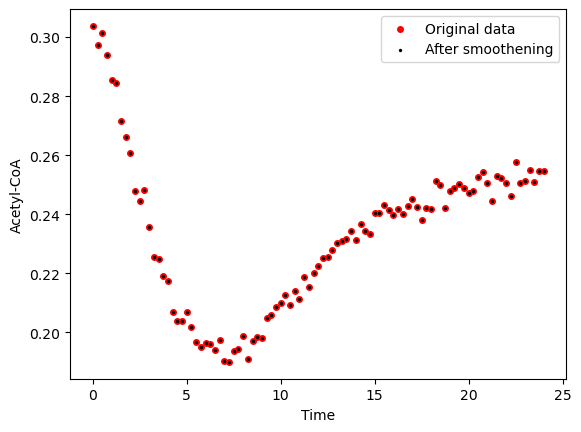

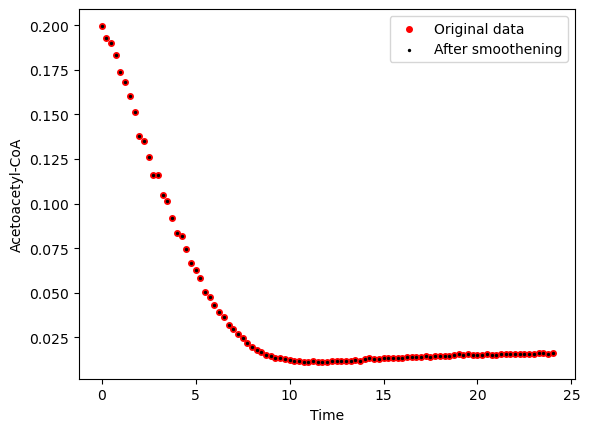

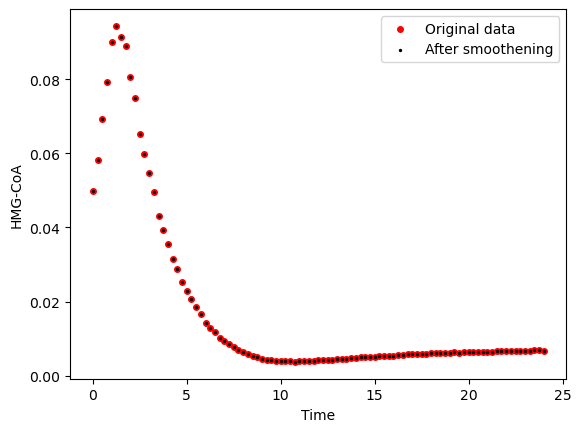

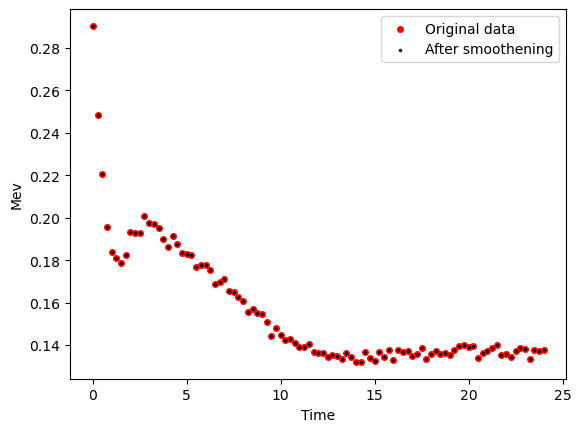

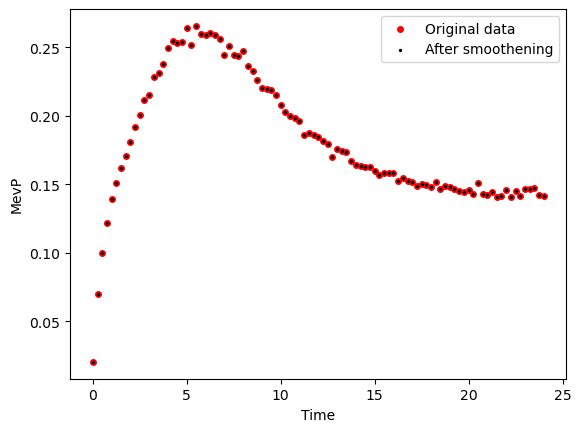

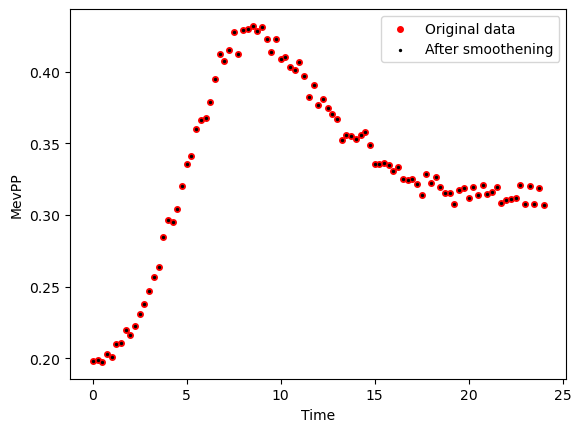

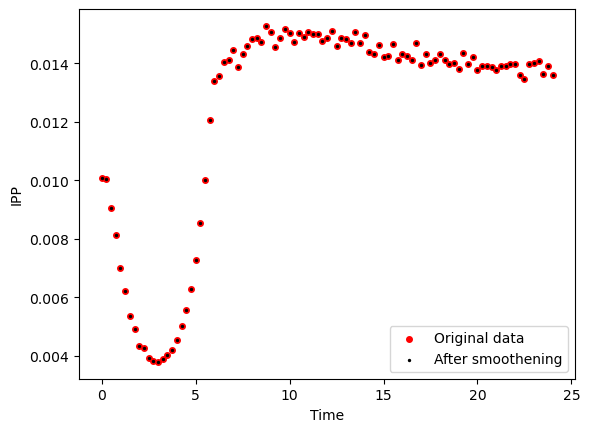

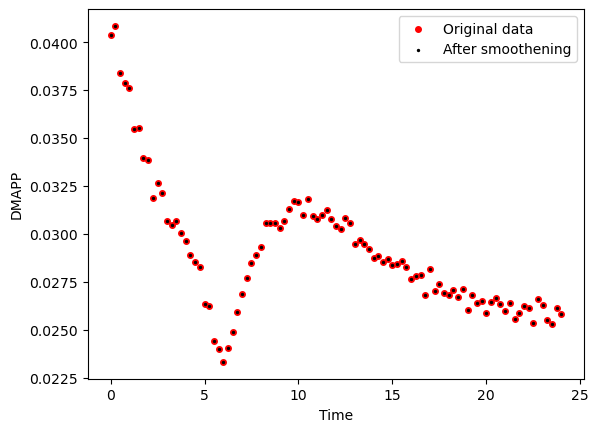

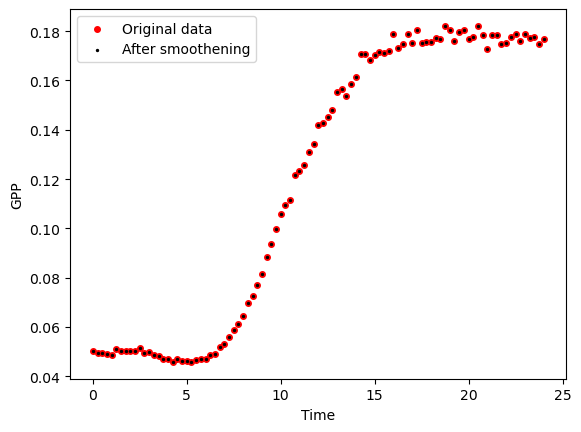

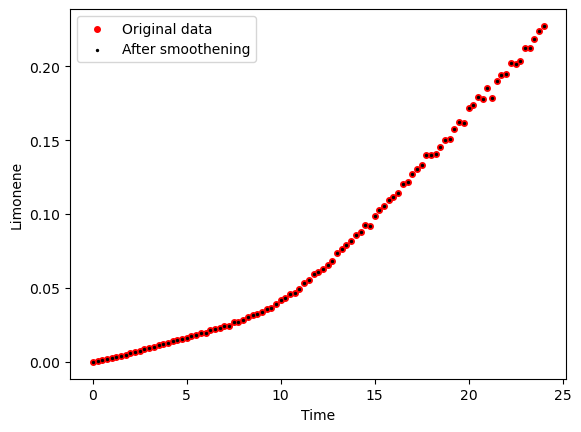

Strain Strain 2


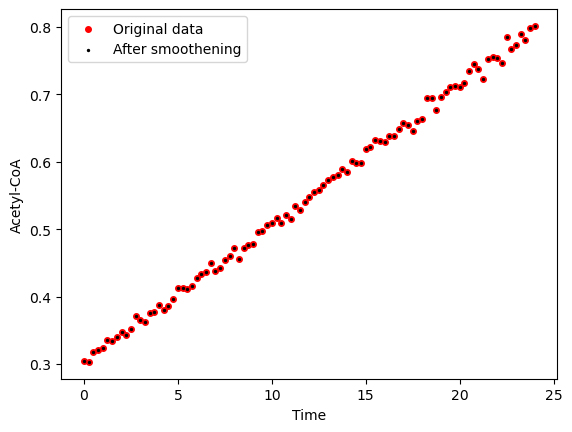

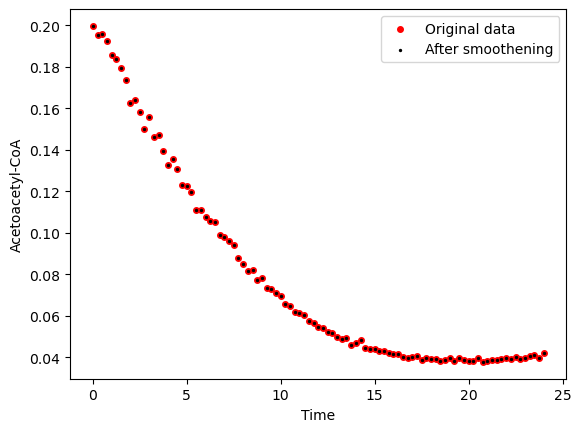

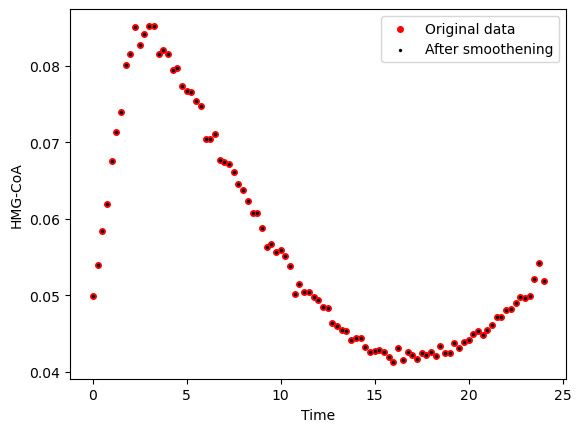

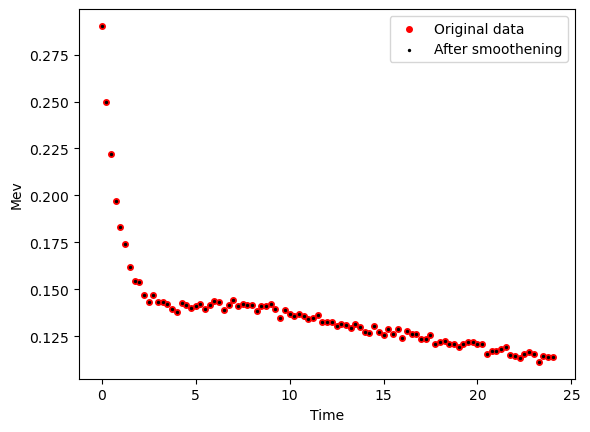

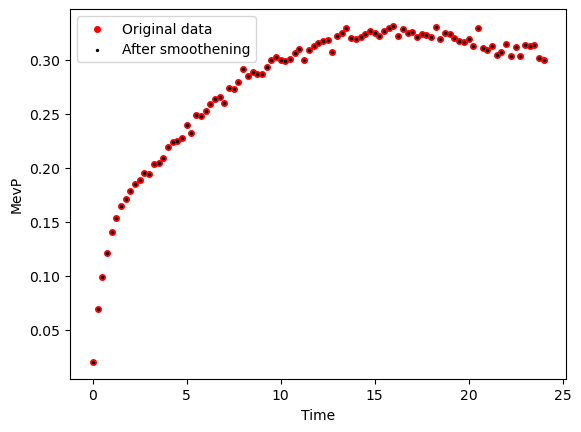

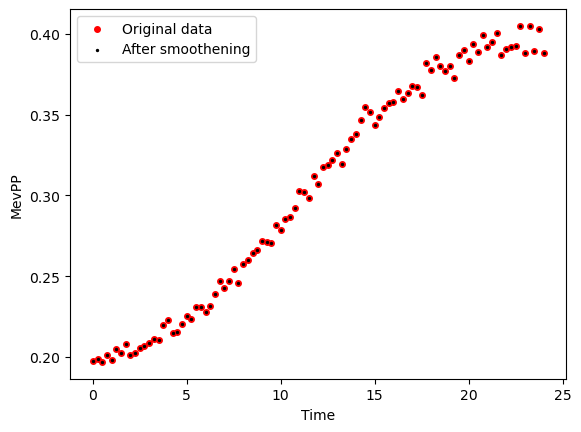

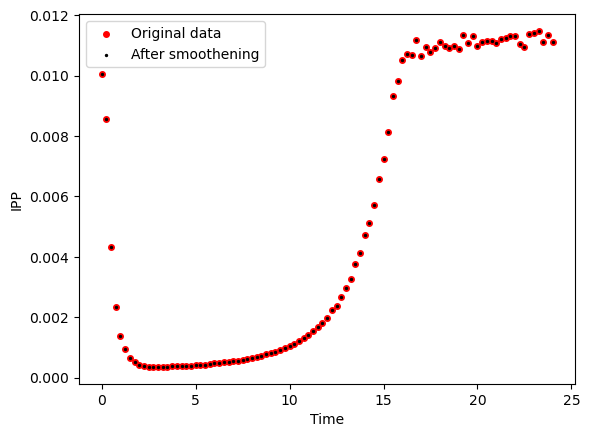

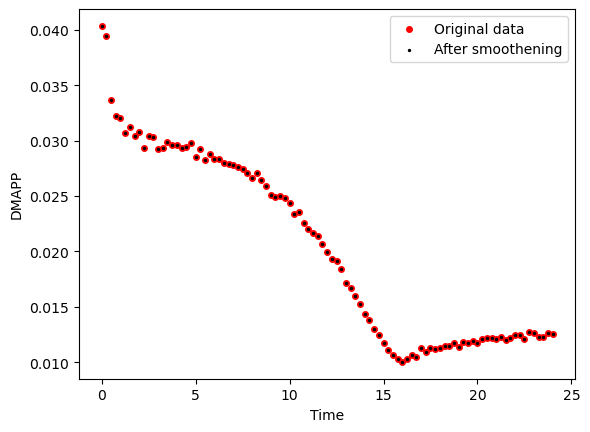

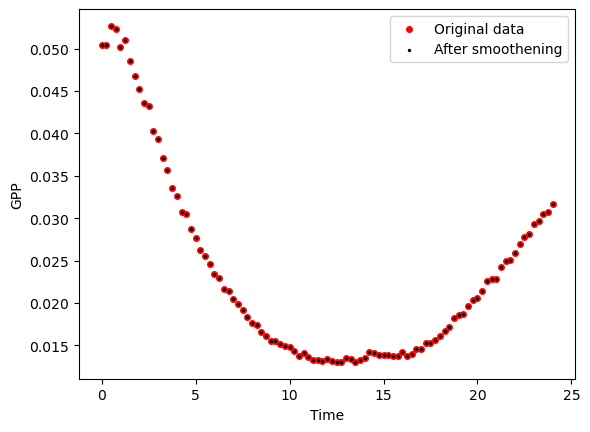

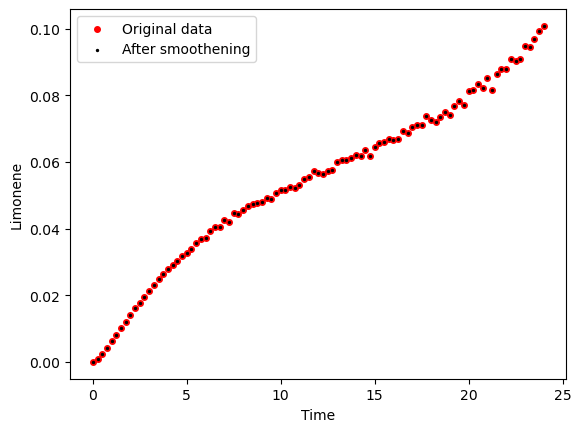

Strain Strain 3


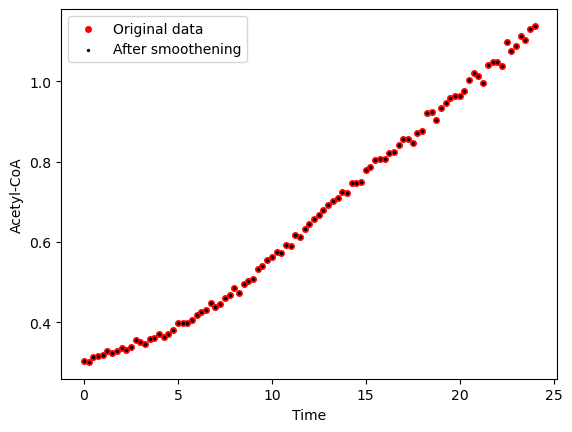

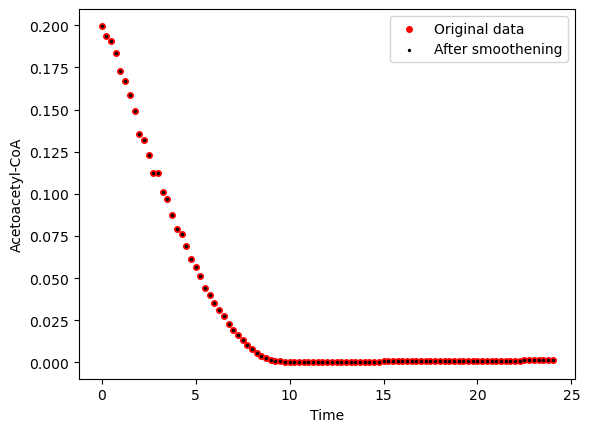

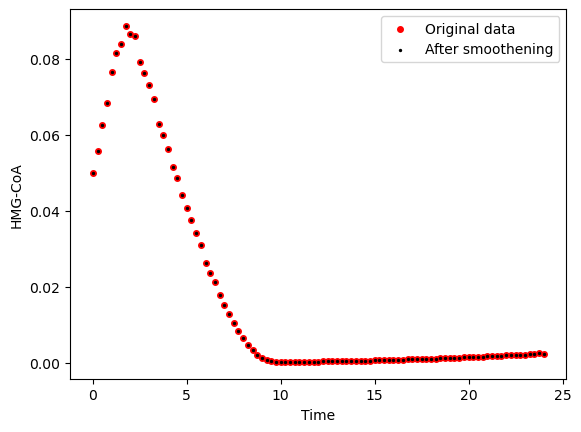

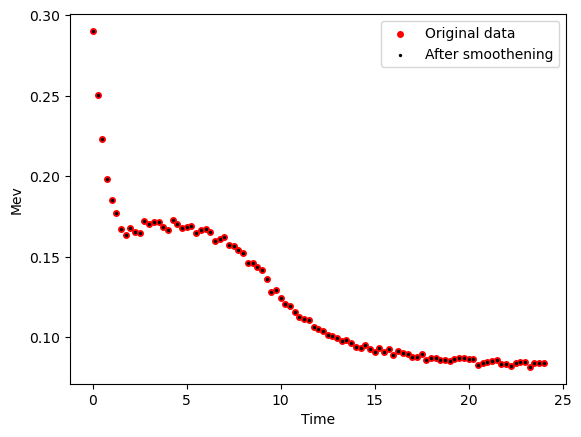

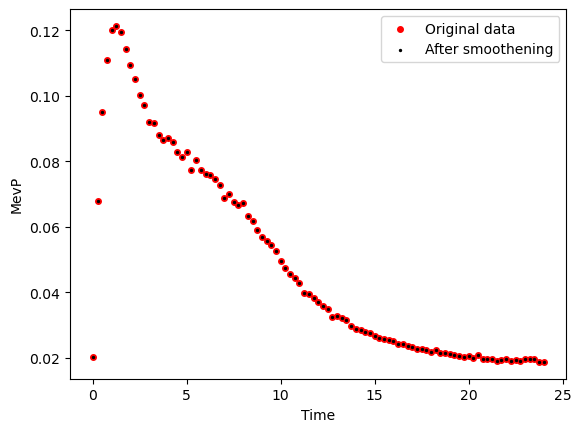

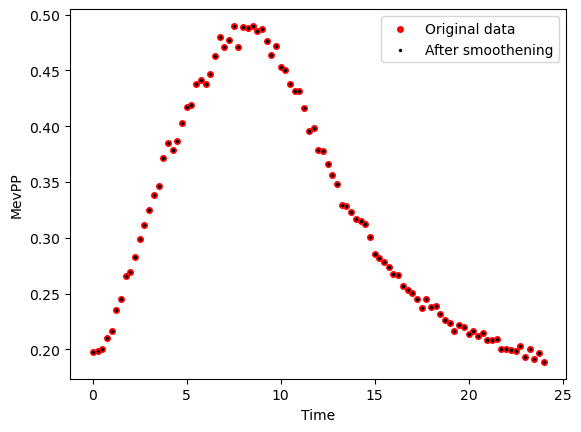

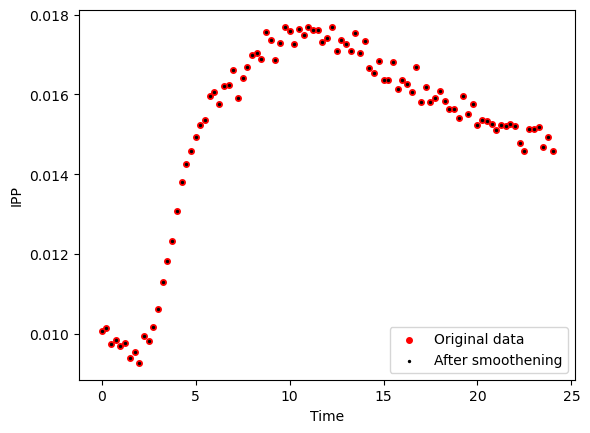

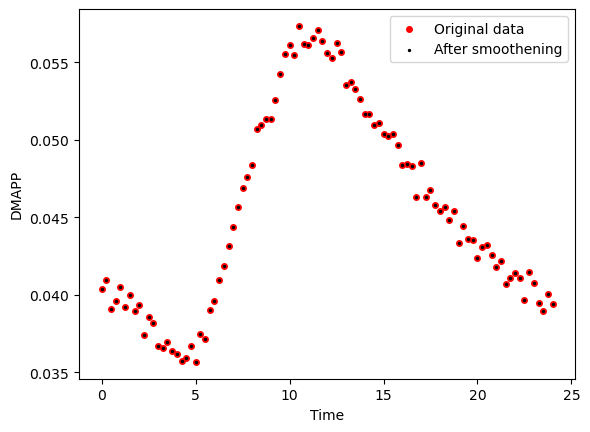

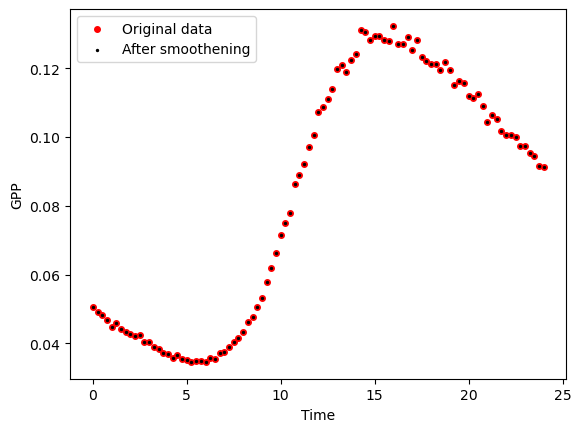

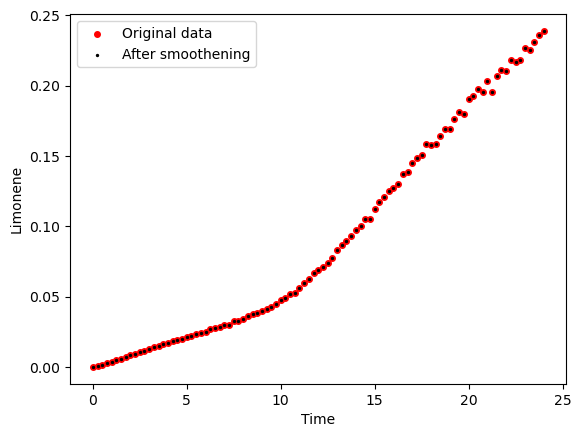

Strain WT


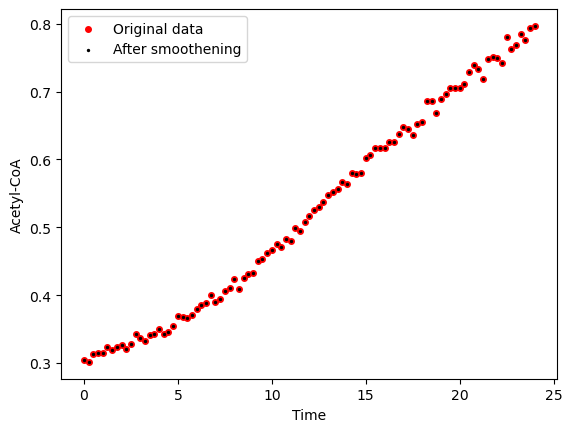

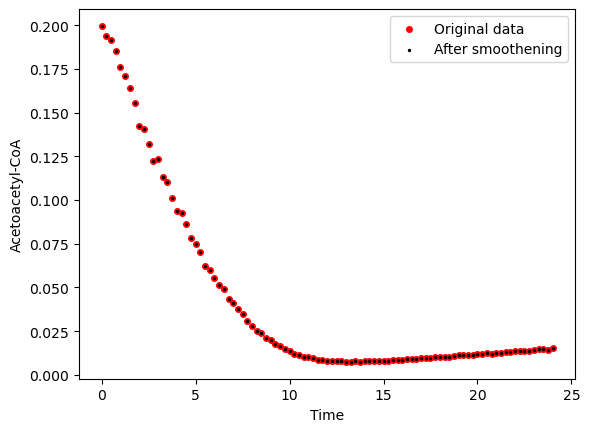

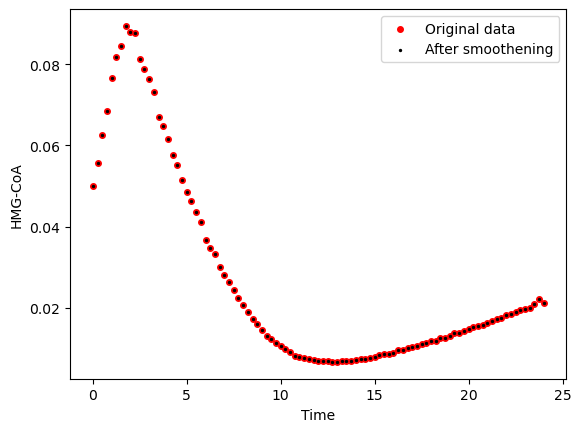

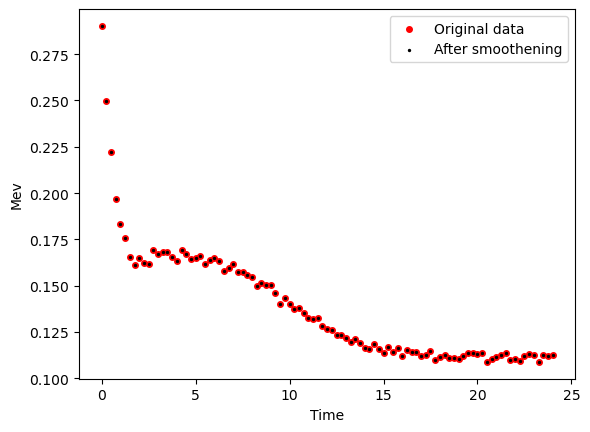

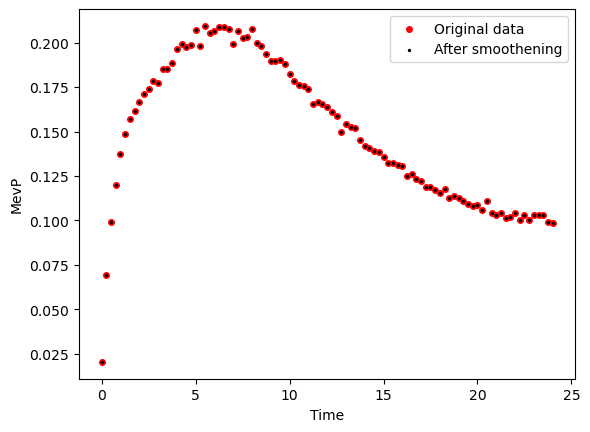

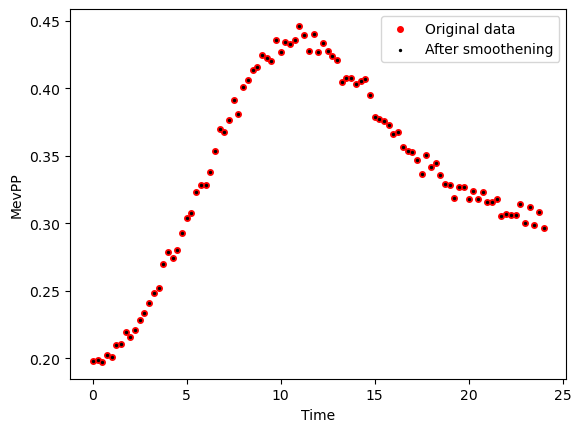

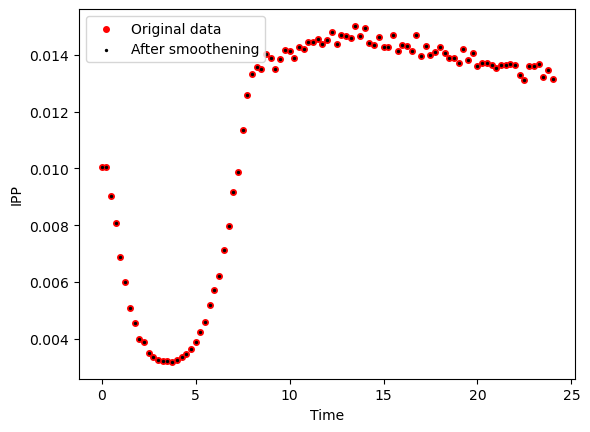

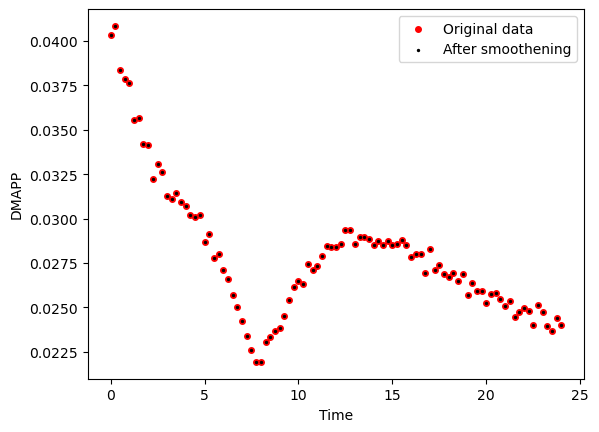

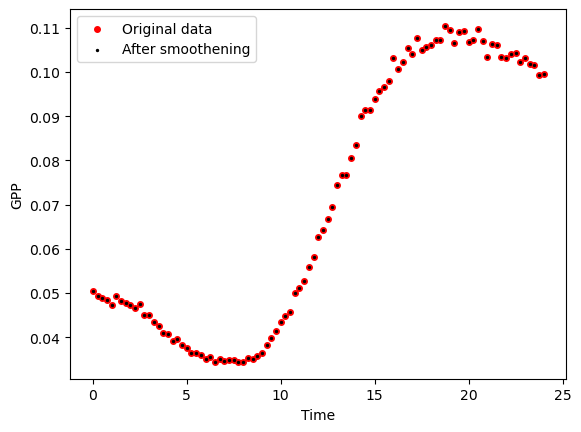

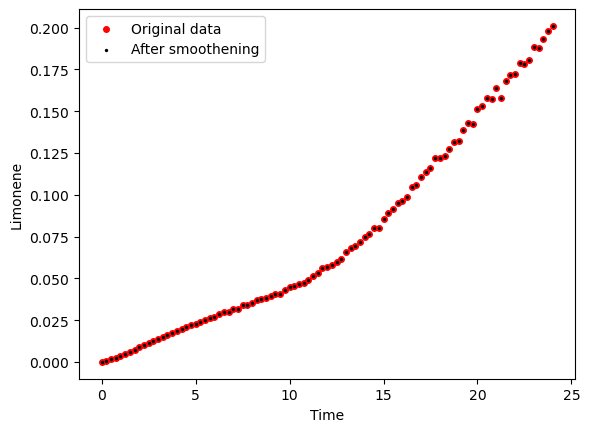

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


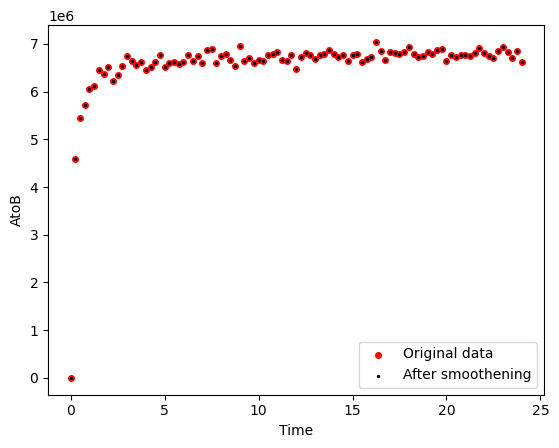

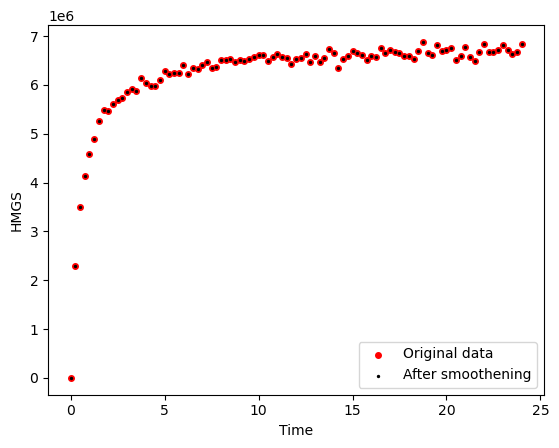

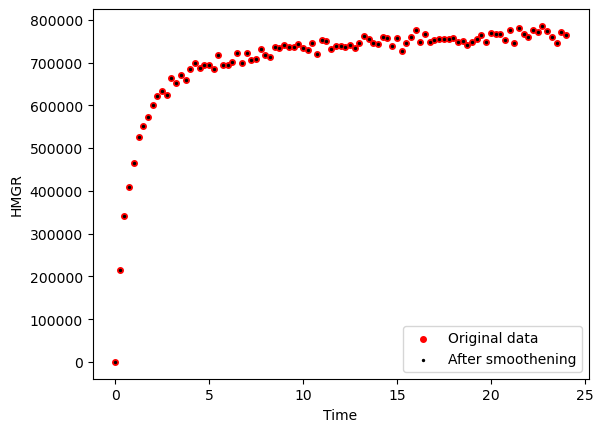

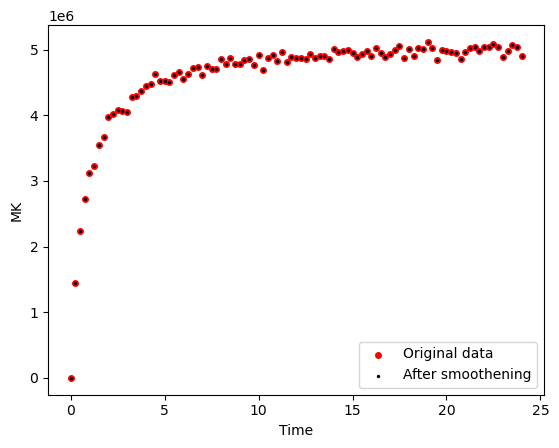

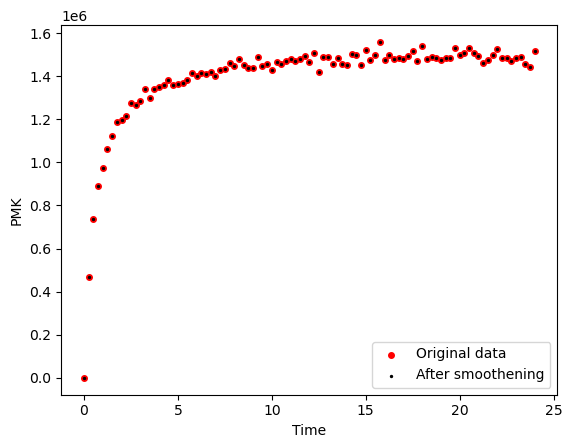

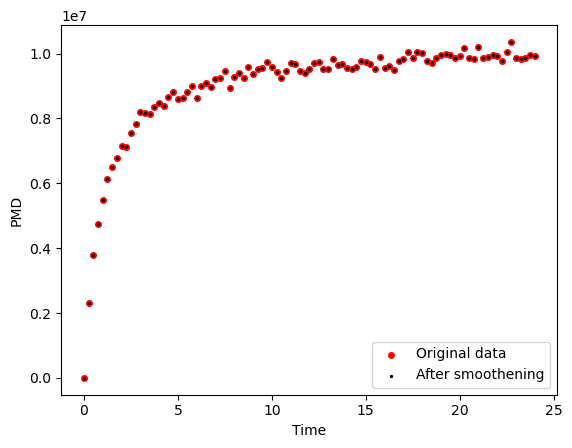

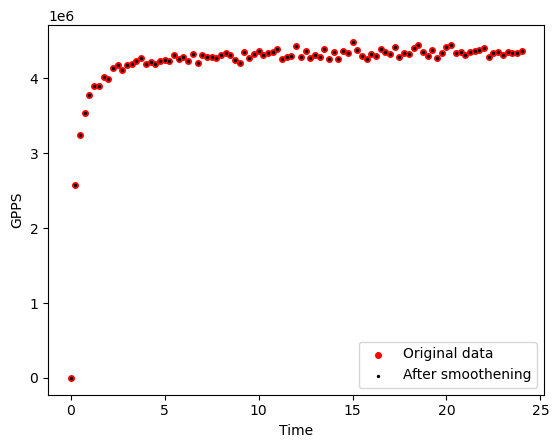

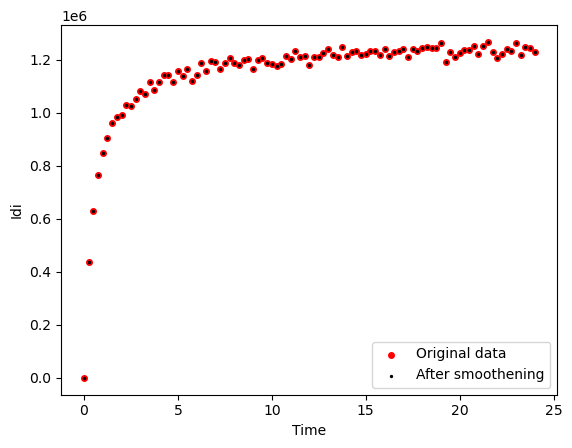

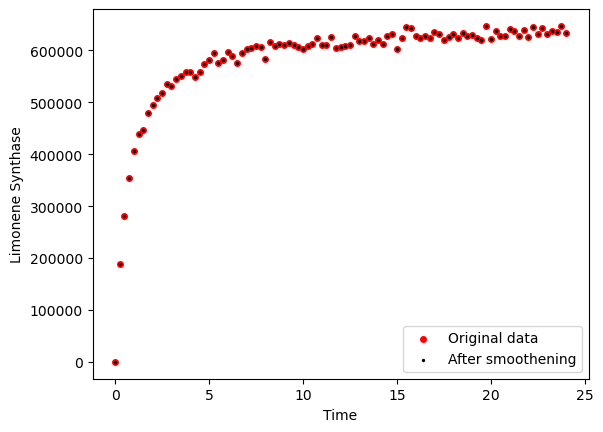

Strain Strain 2


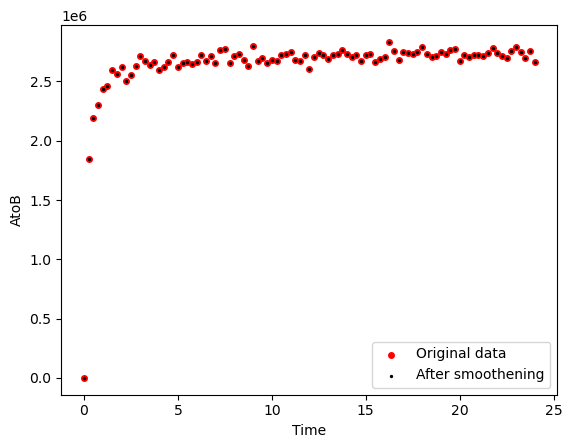

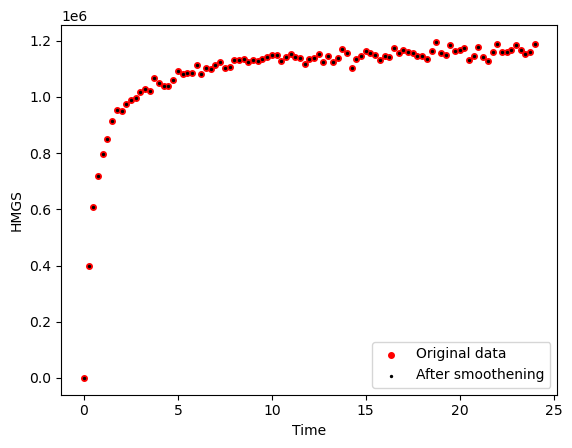

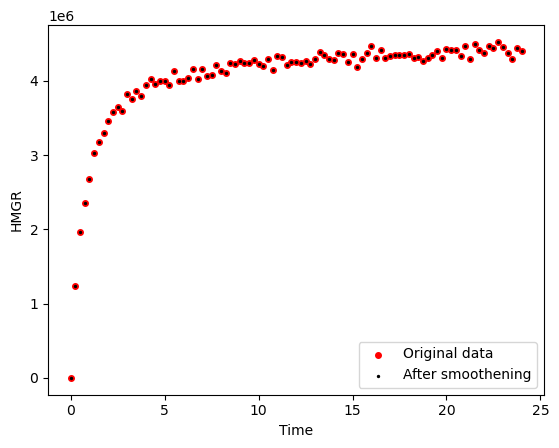

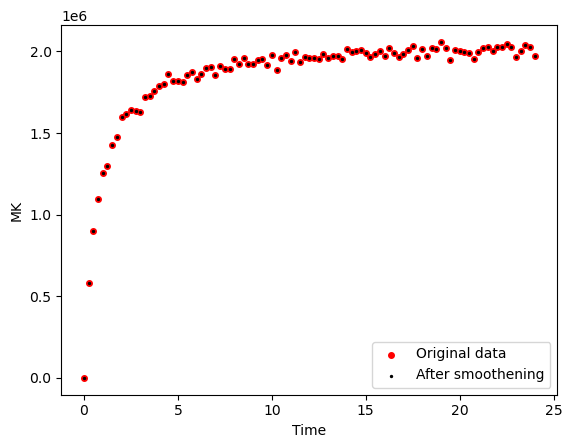

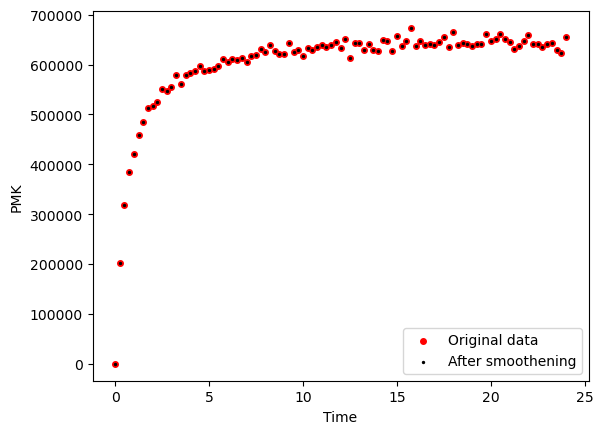

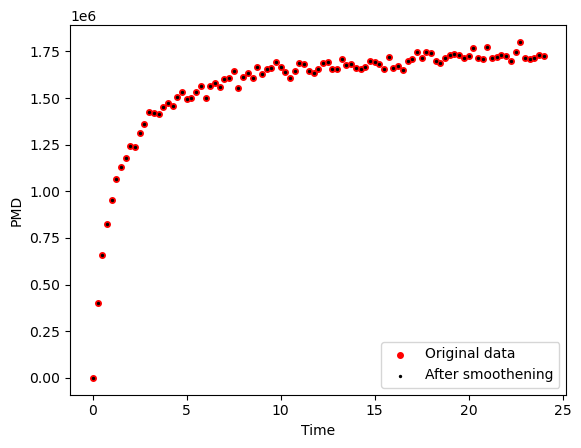

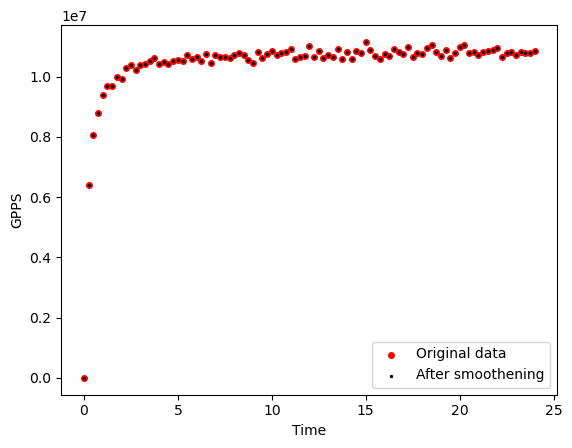

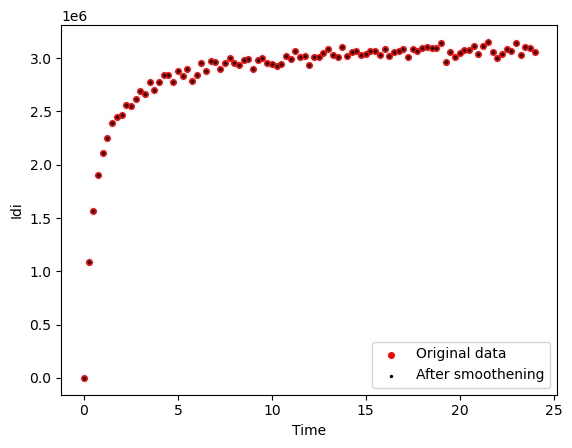

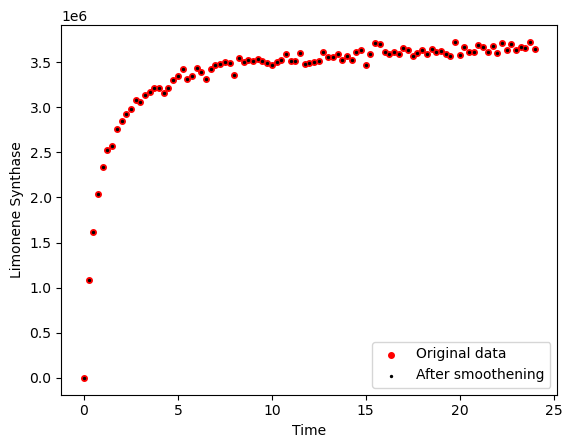

Strain Strain 3


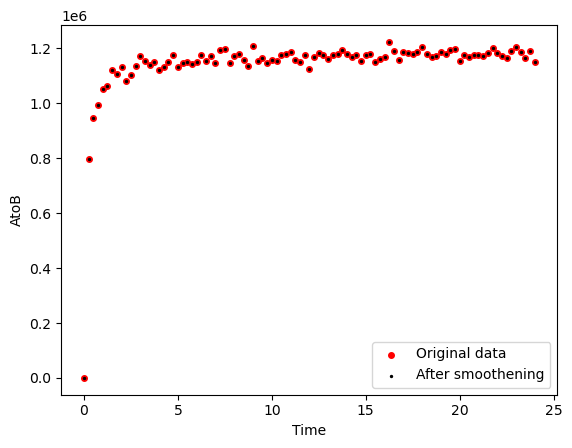

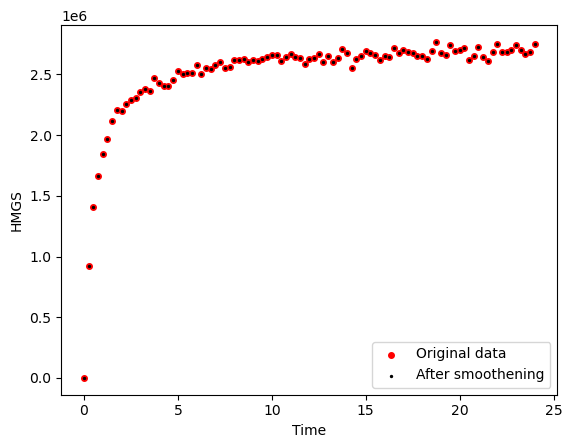

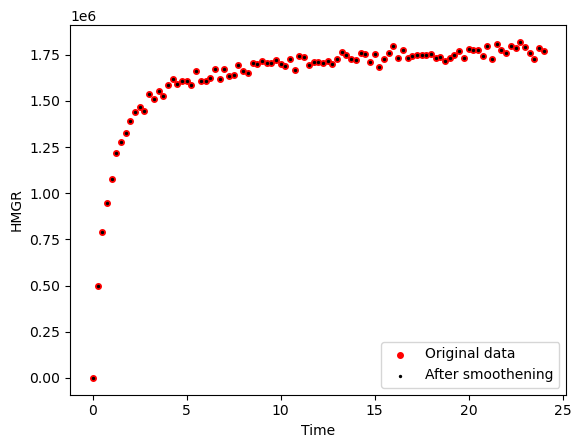

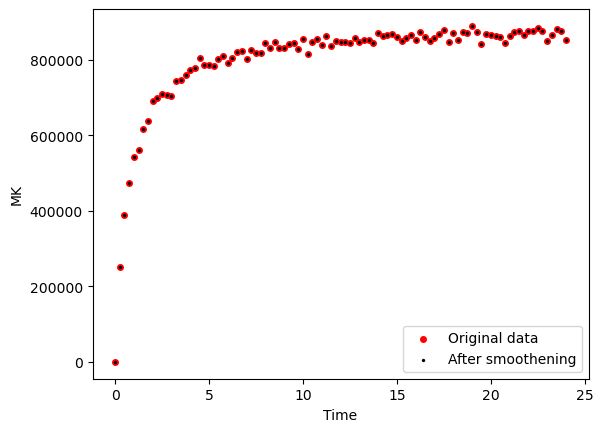

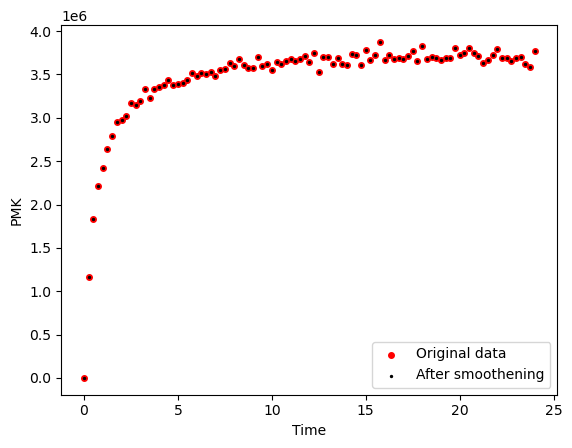

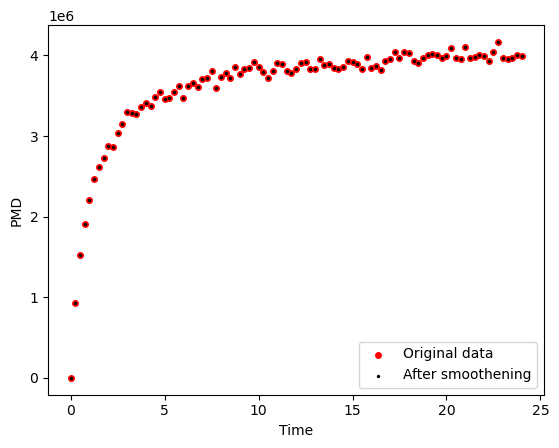

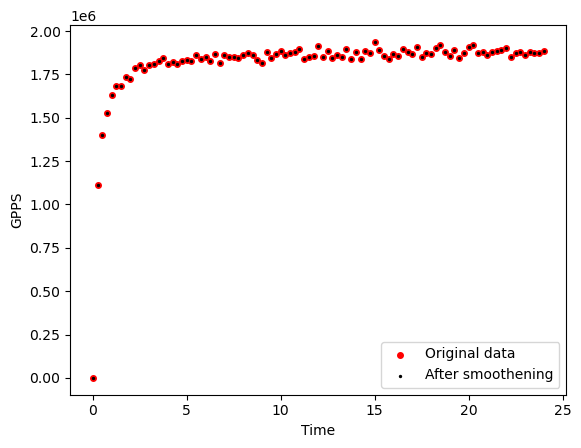

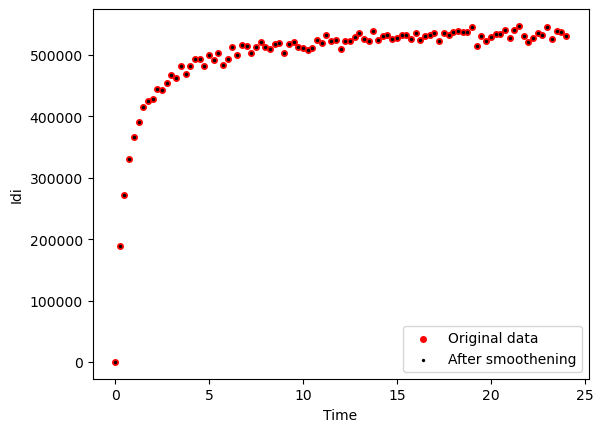

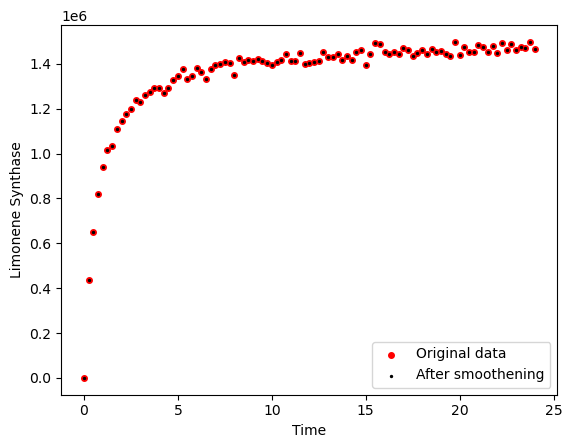

Strain WT


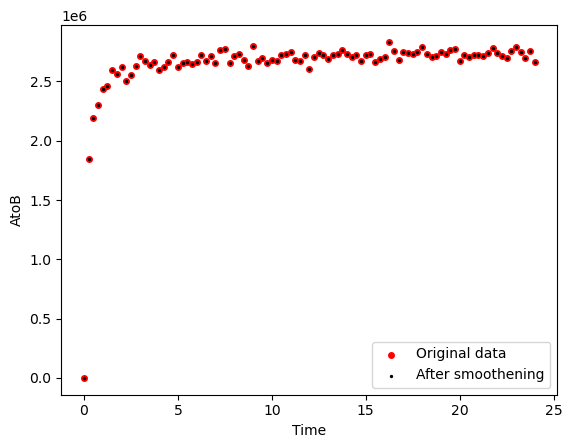

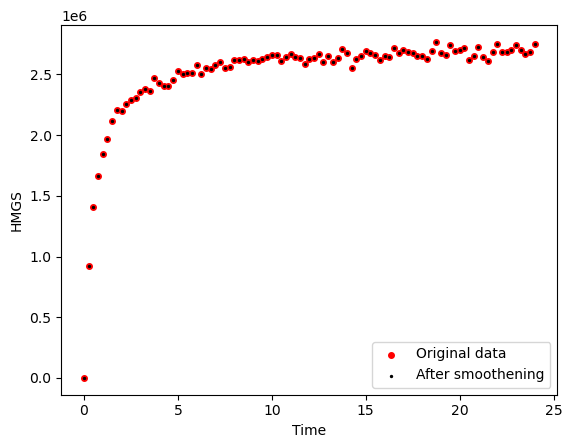

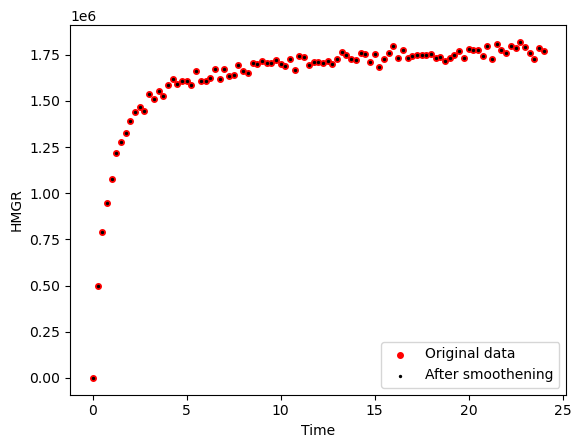

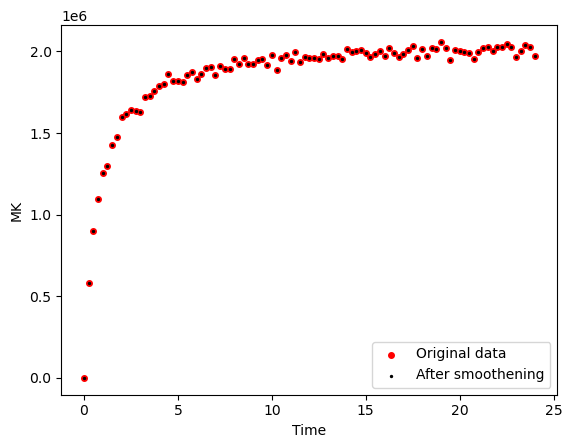

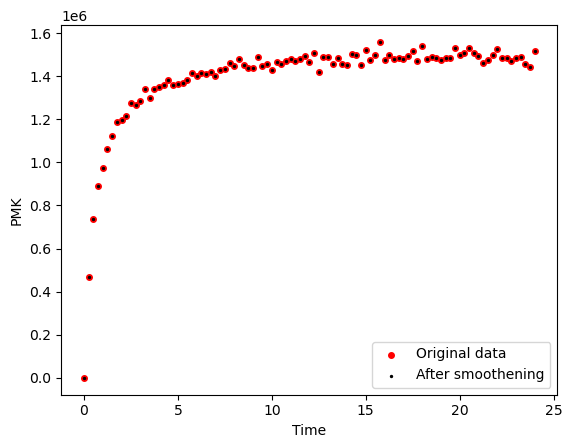

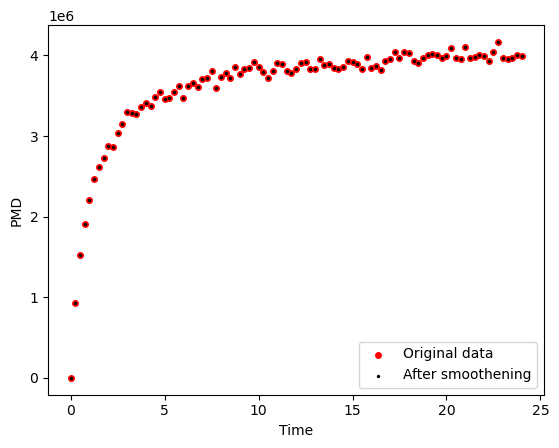

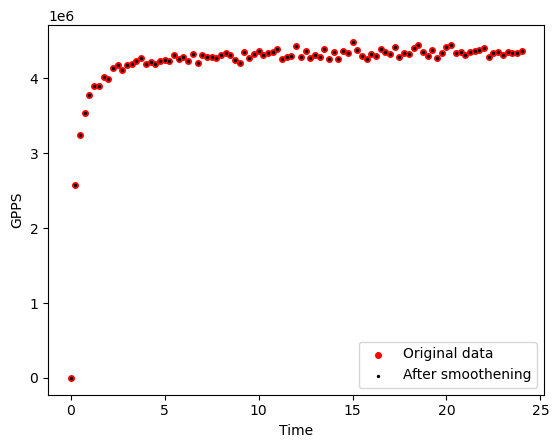

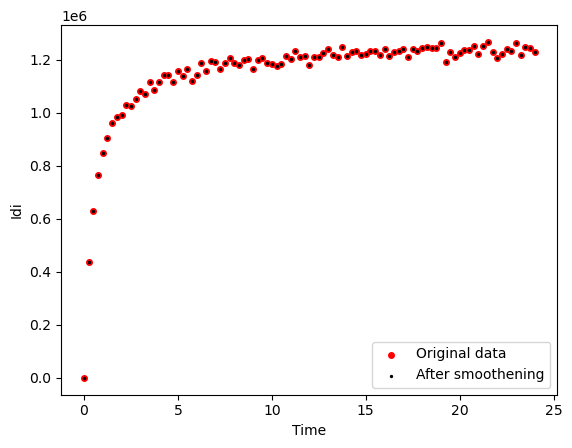

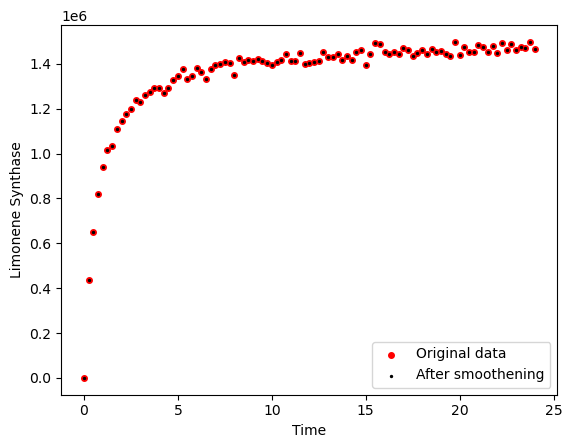

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.303775        0.199644  0.049881  0.290244  0.020348   
         0.25    0.297332        0.192987  0.058274  0.248439  0.070213   
         0.50    0.301426        0.190143  0.069352  0.220738  0.100173   
         0.75    0.293944        0.183535  0.079207  0.195724  0.121619   
         1.00    0.285485        0.173787  0.090185  0.184059  0.139288   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.769224        0.014075  0.019669  0.112578  0.103296   
         23.25   0.785095        0.014489  0.019931  0.108903  0.102898   
         23.50   0.776450        0.014718  0.021030  0.112413  0.103132   
         23.75   0.793054        0.014361  0.022105  0.112245  0.099320   
         24.00   0.796784        0.015254  0.021279  0.112532  0.098608   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.197797  0.010068  0.040352  0.050455  0.000000  ...   
         0.25   0.198518  0.010056  0.040849  0.049528  0.000381  ...   
         0.50   0.197364  0.009050  0.038381  0.049360  0.000962  ...   
         0.75   0.202837  0.008137  0.037858  0.049269  0.001704  ...   
         1.00   0.200781  0.007005  0.037615  0.048540  0.002470  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.300182  0.013600  0.024718  0.103254  0.188130  ...   
         23.25  0.311743  0.013662  0.023956  0.101739  0.187894  ...   
         23.50  0.298873  0.013209  0.023681  0.101541  0.193228  ...   
         23.75  0.308564  0.013453  0.024392  0.099273  0.197959  ...   
         24.00  0.296592  0.013155  0.024012  0.099637  0.200995  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.001850       -0.013098  0.036106 -0.177997  0.199033   
         0.25    -0.007068       -0.018782  0.038361 -0.142016  0.157374   
         0.50    -0.015987       -0.024466  0.040617 -0.106034  0.115715   
         0.75    -0.016725       -0.026359  0.037226 -0.068562  0.080391   
         1.00    -0.027558       -0.029903  0.023632 -0.039425  0.061280   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.005779        0.001013  0.001810 -0.001209  0.001409   
         23.25    0.027309        0.000829  0.002646 -0.000740 -0.000659   
         23.50    0.025231        0.000892  0.002158  0.001300 -0.005182   
         23.75    0.025783        0.001104  0.000900  0.003727 -0.007853   
         24.00    0.026334        0.001315 -0.000357  0.006153 -0.010525   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002890 -0.000764 -0.003917 -0.002178  0.001443  
         0.25   0.003503 -0.001991 -0.003652 -0.001907  0.001974  
         0.50   0.004115 -0.003218 -0.003386 -0.001636  0.002505  
         0.75   0.010566 -0.003886 -0.004590  0.000907  0.002923  
         1.00   0.013311 -0.003718 -0.003251  0.001521  0.003188  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.006662  0.000106 -0.000711 -0.002420  0.014961  
         23.25 -0.005010 -0.000281 -0.001001 -0.003048  0.016149  
         23.50 -0.004143 -0.000440 -0.000391 -0.003880  0.014318  
         23.75 -0.018147 -0.000453  0.000609 -0.002916  0.017712  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

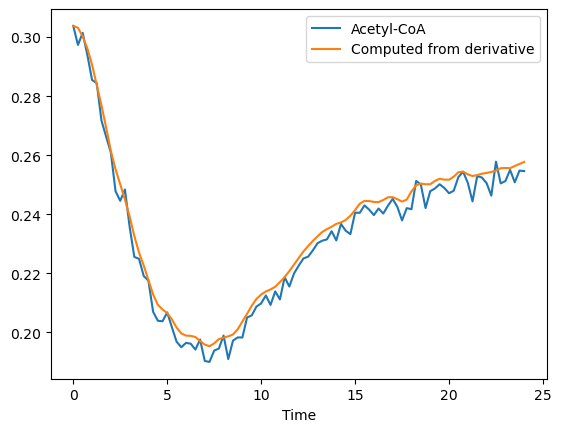

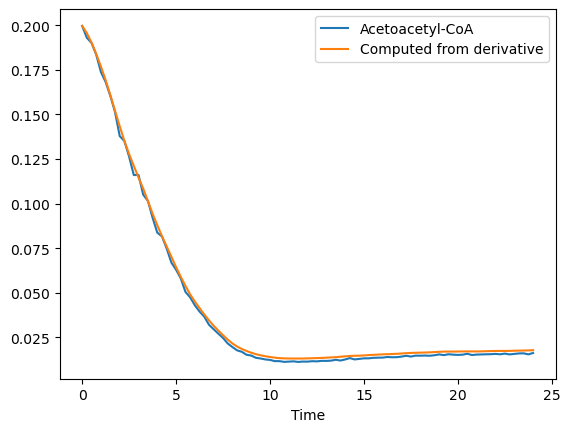

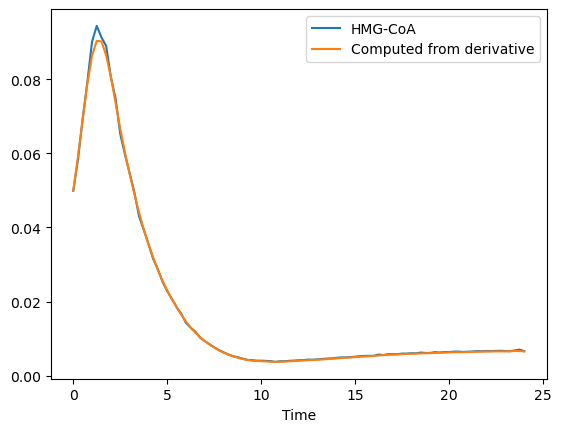

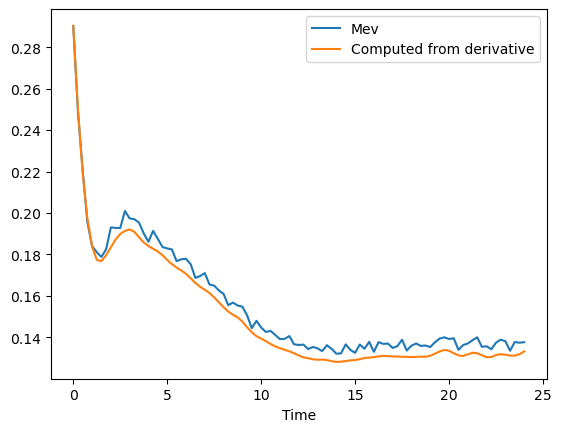

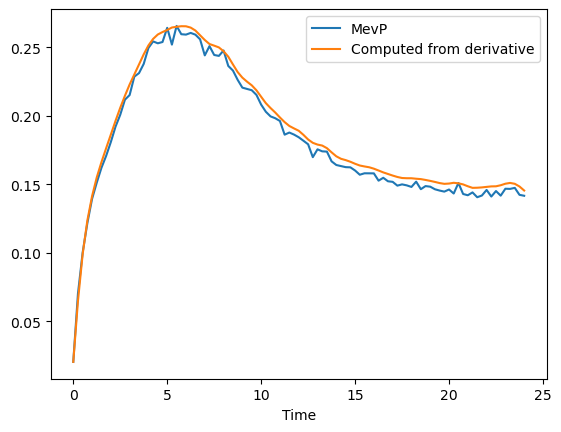

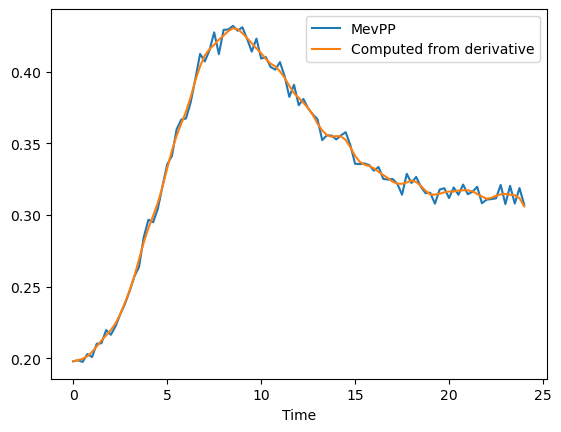

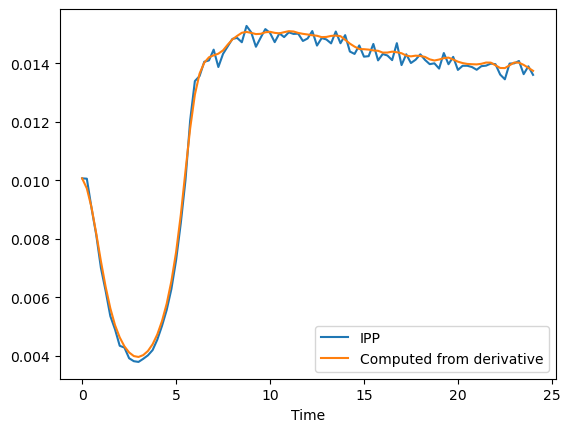

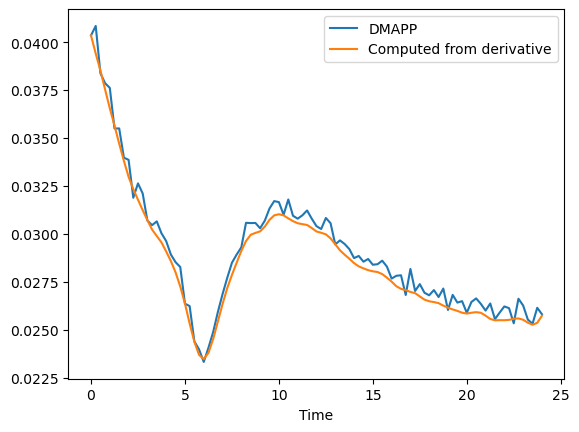

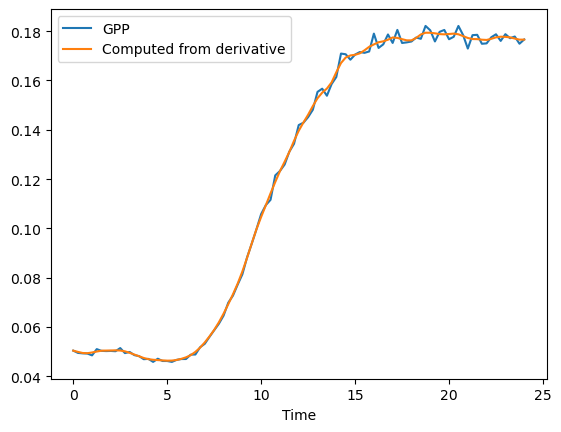

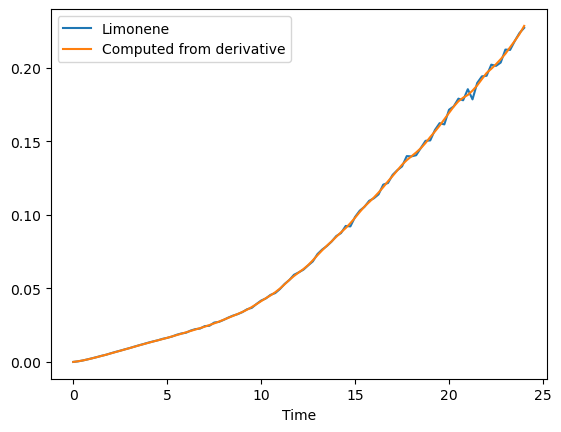

'Time profile from derivative vs. actual profile for Strain 2'

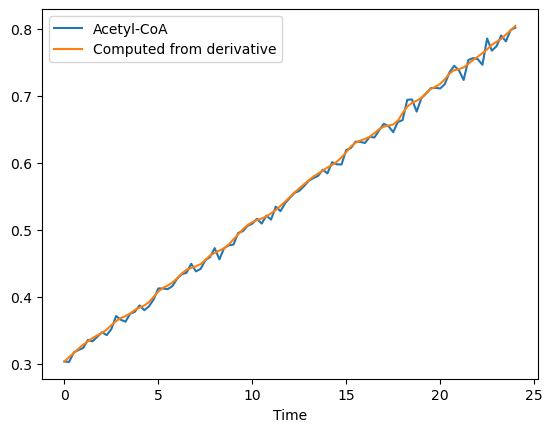

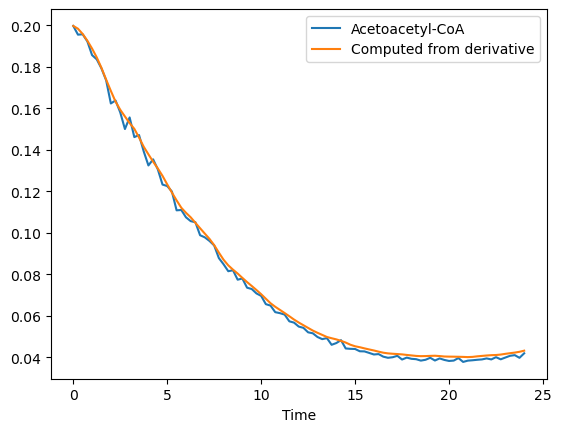

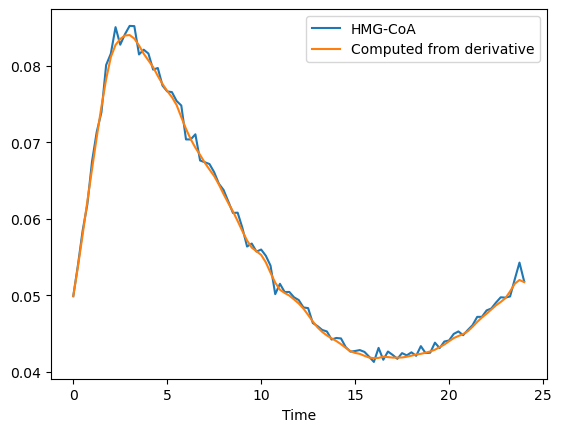

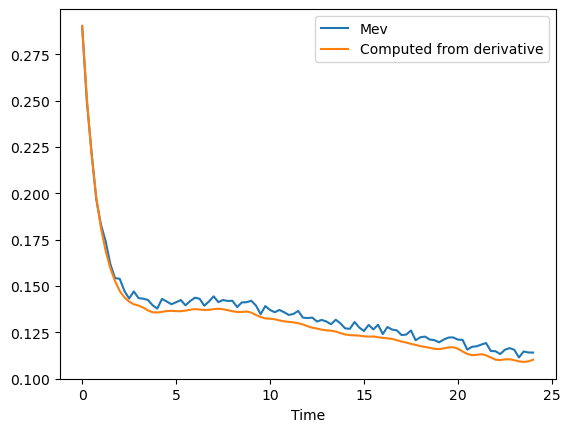

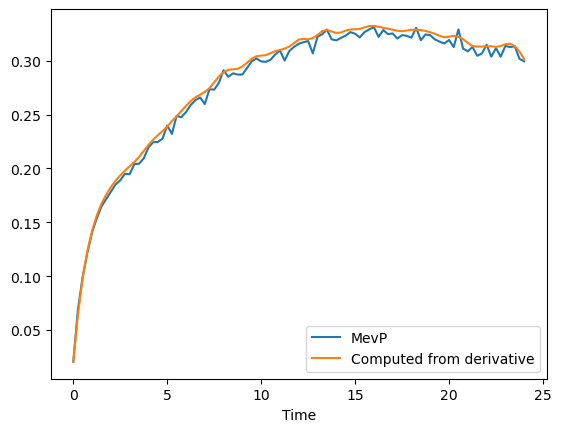

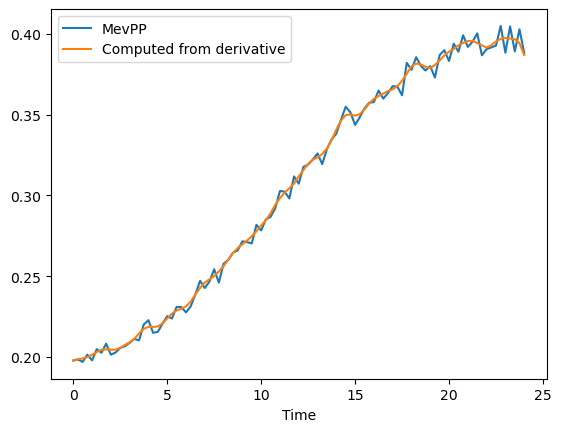

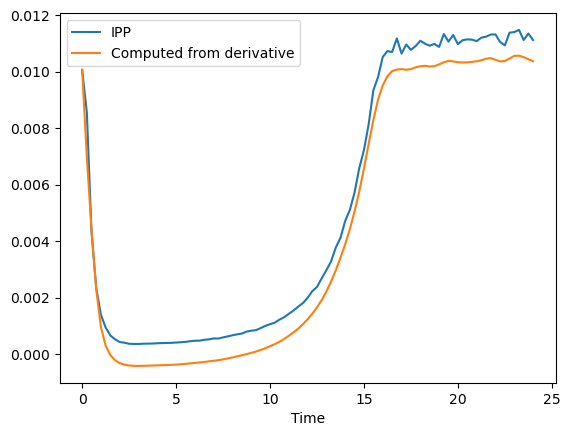

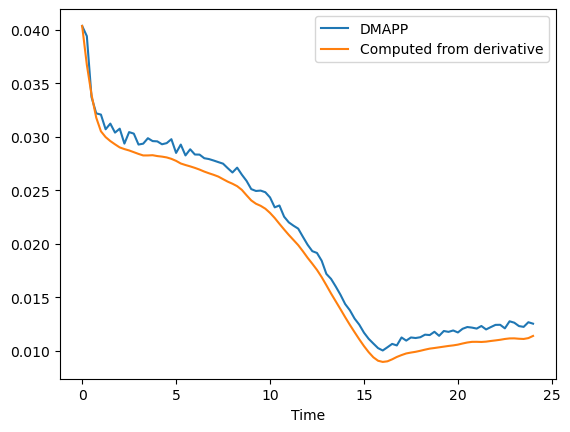

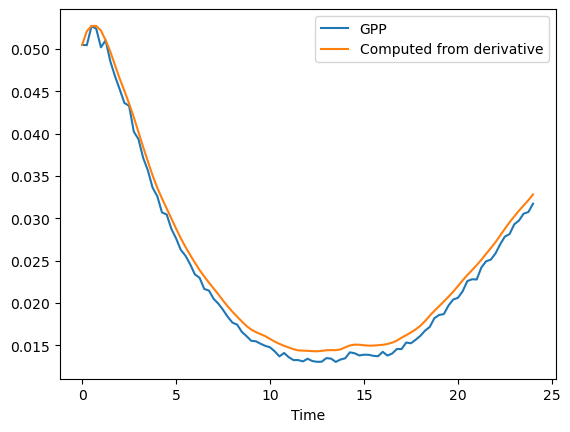

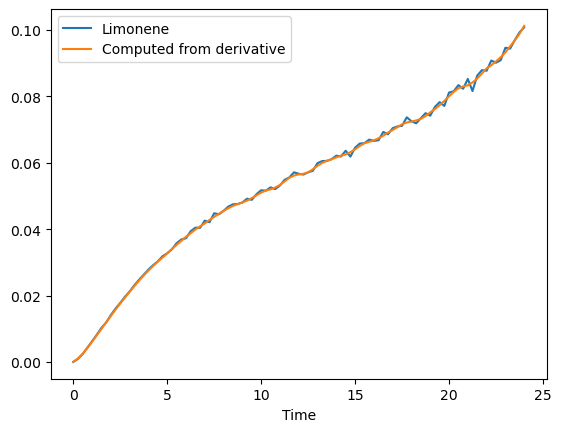

'Time profile from derivative vs. actual profile for Strain 3'

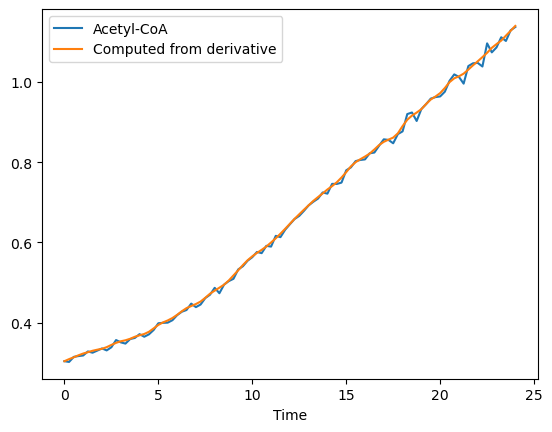

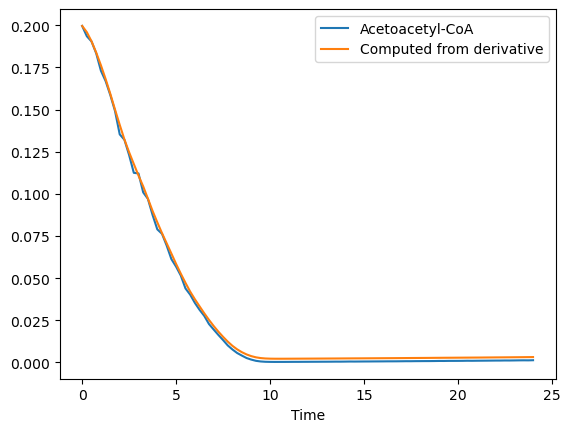

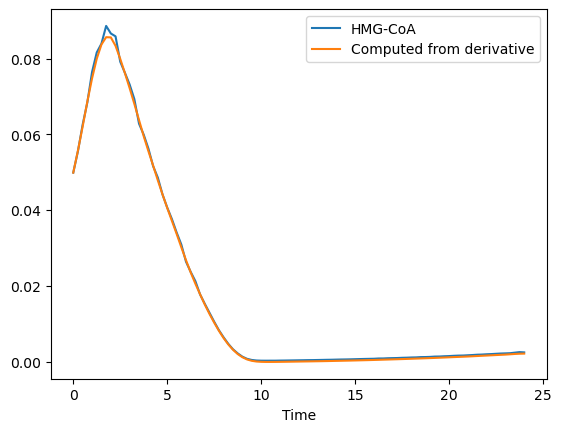

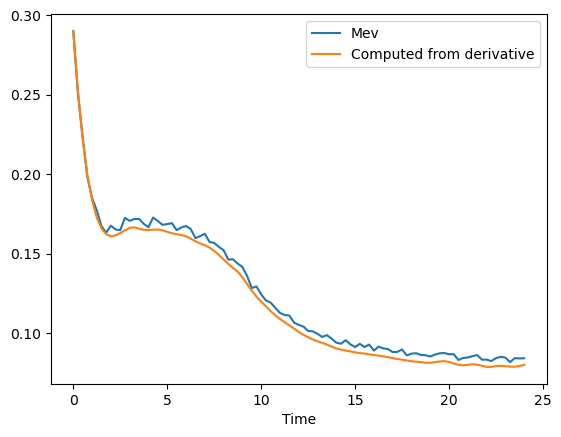

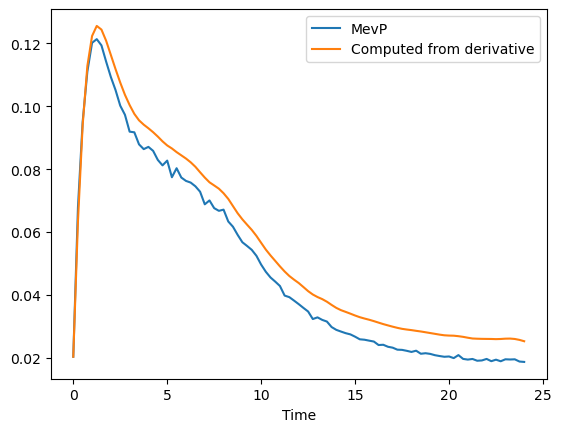

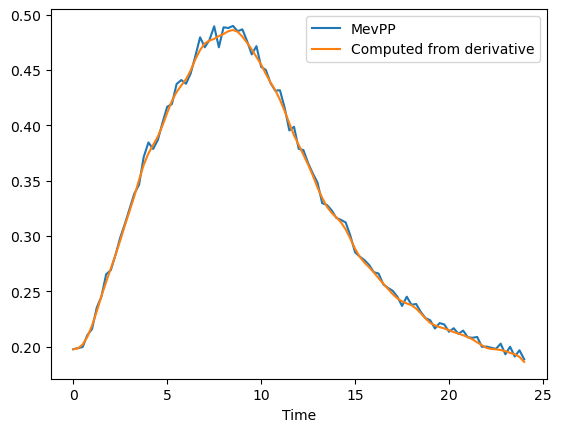

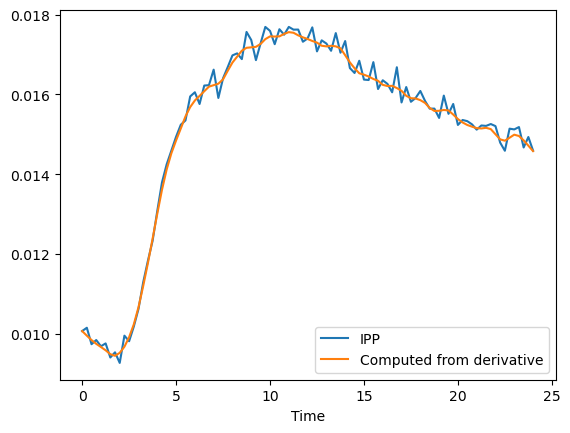

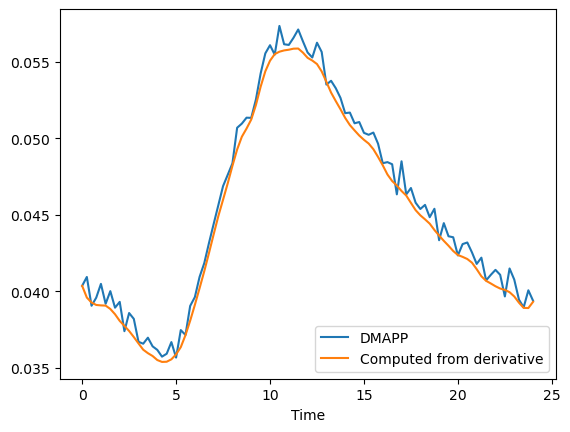

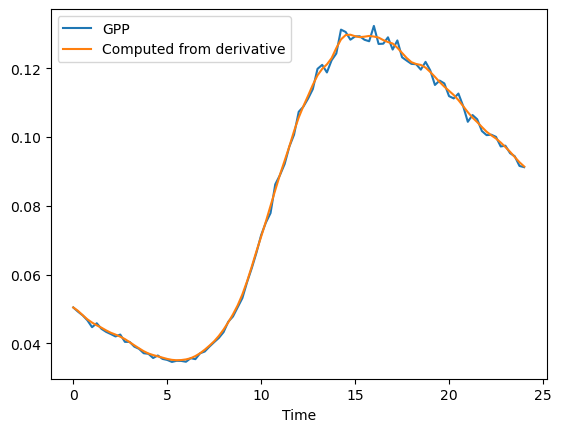

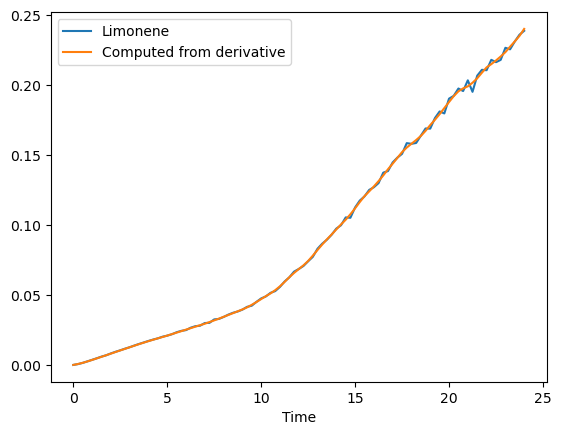

'Time profile from derivative vs. actual profile for WT'

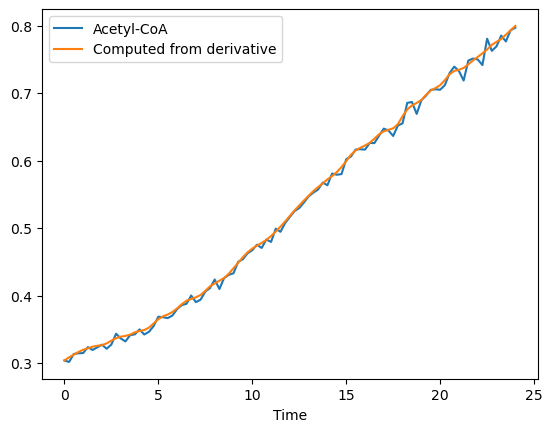

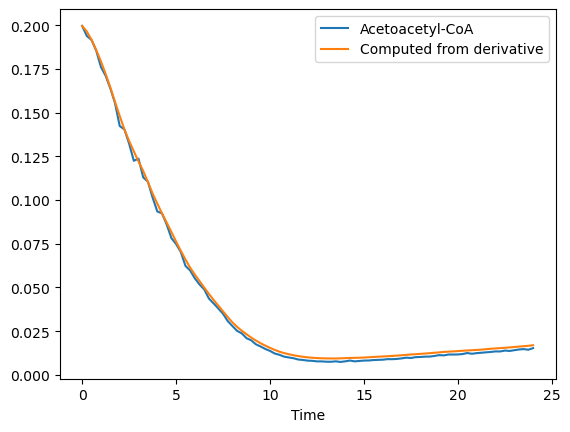

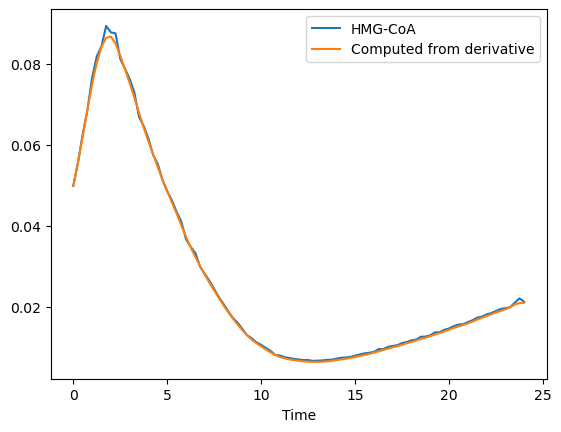

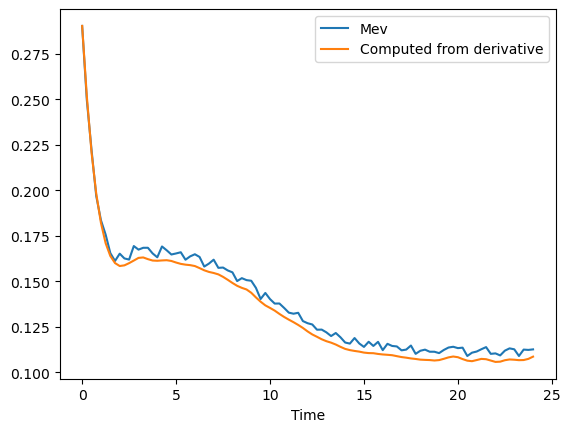

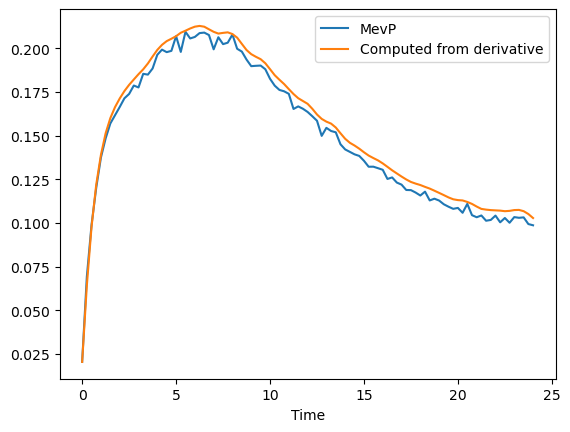

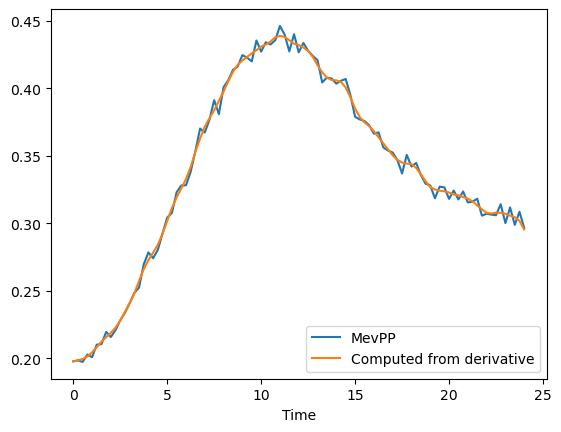

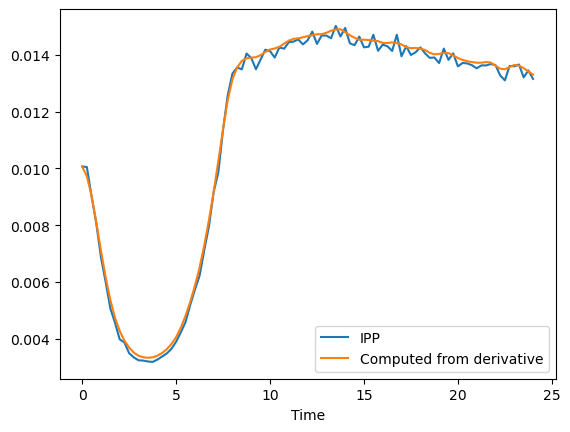

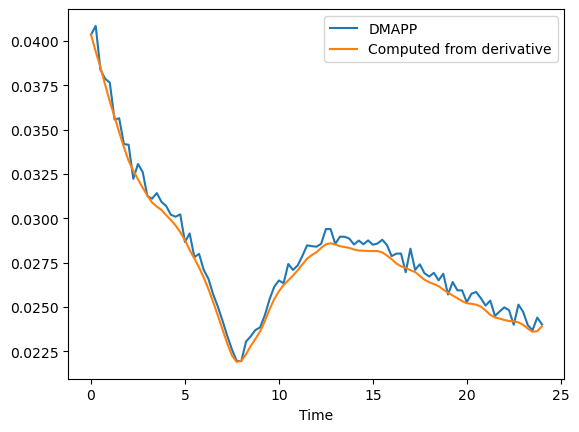

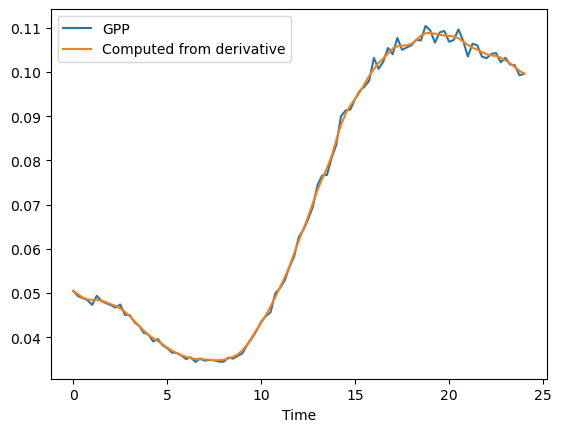

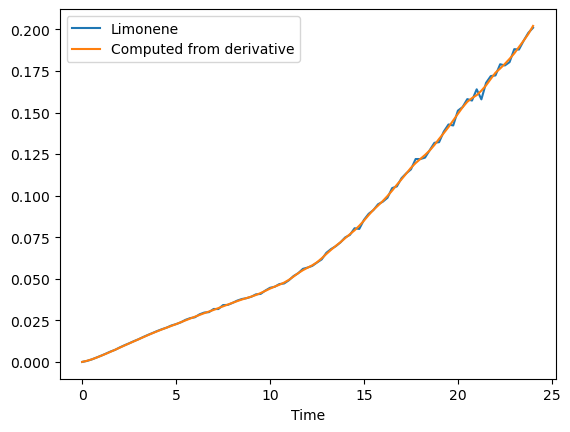

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   6.021797e+01  3.965937e+01  3.688062e+01  5.574897e+01   
         0.25   4.597010e+06  2.294929e+06  2.142199e+05  1.441146e+06   
         0.50   5.451159e+06  3.497433e+06  3.411840e+05  2.236004e+06   
         0.75   5.726004e+06  4.126494e+06  4.088181e+05  2.730130e+06   
         1.00   6.057275e+06  4.578212e+06  4.650788e+05  3.116428e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.793791e+06  2.738508e+06  1.790636e+06  1.966353e+06   
         23.25  2.746174e+06  2.697411e+06  1.756996e+06  2.003719e+06   
         23.50  2.698579e+06  2.671747e+06  1.725002e+06  2.042148e+06   
         23.75  2.757368e+06  2.681689e+06  1.787784e+06  2.026437e+06   
         24.00  2.666181e+06  2.746572e+06  1.769606e+06  1.972738e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.706286e+01  5.388111e+01  5.585060e+01  1.885230e+01   
         0.25   4.699780e+05  2.319278e+06  2.580479e+06  4.355049e+05   
         0.50   7.381283e+05  3.792402e+06  3.246965e+06  6.298491e+05   
         0.75   8.892703e+05  4.747093e+06  3.533031e+06  7.660397e+05   
         1.00   9.754842e+05  5.500615e+06  3.769851e+06  8.493837e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.482486e+06  3.965407e+06  4.311209e+06  1.264628e+06   
         23.25  1.489485e+06  3.960609e+06  4.348569e+06  1.216766e+06   
         23.50  1.458418e+06  3.966576e+06  4.333144e+06  1.247226e+06   
         23.75  1.441278e+06  4.010404e+06  4.335370e+06  1.245131e+06   
         24.00  1.518104e+06  3.997498e+06  4.359388e+06  1.231153e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.061737e+01   0.303775        0.199644  0.049881   
         0.25       1.880093e+05   0.297332        0.192987  0.058274   
         0.50       2.804316e+05   0.301426        0.190143  0.069352   
         0.75       3.543398e+05   0.293944        0.183535  0.079207   
         1.00       4.066978e+05   0.285485        0.173787  0.090185   
...                          ...        ...             ...       ...   
WT       23.00      1.460242e+06   0.769224        0.014075  0.019669   
         23.25      1.473482e+06   0.785095        0.014489  0.019931   
         23.50      1.469301e+06   0.776450        0.014718  0.021030   
         23.75      1.497003e+06   0.793054        0.014361  0.022105   
         24.00      1.463968e+06   0.796784        0.015254  0.021279   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.290244  0.020348  0.197797  0.010068  0.040352  0.050455   
         0.25   0.248439  0.070213  0.198518  0.010056  0.040849  0.049528   
         0.50   0.220738  0.100173  0.197364  0.009050  0.038381  0.049360   
         0.75   0.195724  0.121619  0.202837  0.008137  0.037858  0.049269   
         1.00   0.184059  0.139288  0.200781  0.007005  0.037615  0.048540   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112578  0.103296  0.300182  0.013600  0.024718  0.103254   
         23.25  0.108903  0.102898  0.311743  0.013662  0.023956  0.101739   
         23.50  0.112413  0.103132  0.298873  0.013209  0.023681 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.001850       -0.013098  0.036106 -0.177997  0.199033   
         0.25    -0.007068       -0.018782  0.038361 -0.142016  0.157374   
         0.50    -0.015987       -0.024466  0.040617 -0.106034  0.115715   
         0.75    -0.016725       -0.026359  0.037226 -0.068562  0.080391   
         1.00    -0.027558       -0.029903  0.023632 -0.039425  0.061280   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.005779        0.001013  0.001810 -0.001209  0.001409   
         23.25    0.027309        0.000829  0.002646 -0.000740 -0.000659   
         23.50    0.025231        0.000892  0.002158  0.001300 -0.005182   
         23.75    0.025783        0.001104  0.000900  0.003727 -0.007853   
         24.00    0.026334        0.001315 -0.000357  0.006153 -0.010525   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002890 -0.000764 -0.003917 -0.002178  0.001443  
         0.25   0.003503 -0.001991 -0.003652 -0.001907  0.001974  
         0.50   0.004115 -0.003218 -0.003386 -0.001636  0.002505  
         0.75   0.010566 -0.003886 -0.004590  0.000907  0.002923  
         1.00   0.013311 -0.003718 -0.003251  0.001521  0.003188  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.006662  0.000106 -0.000711 -0.002420  0.014961  
         23.25 -0.005010 -0.000281 -0.001001 -0.003048  0.016149  
         23.50 -0.004143 -0.000440 -0.000391 -0.003880  0.014318  
         23.75 -0.018147 -0.000453  0.000609 -0.002916  0.017712  
         24.00 -0.032151 -0.000467  0.001608 -0.001952  0.021107  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'ISRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: ISRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 4.804047E+188 | 8.020824E+113
     2 |       74 | 2.315630E+127 |  2.991427E+84
     3 |      138 |  6.204882E+98 |  2.450754E+70
     4 |      202 |  5.432000E+78 |  3.958857E+66
     5 |      266 |  2.484423E+73 |  6.890831E+62
     6 |      330 |  3.273226E+66 |  9.368898E+54
     7 |      394 |  1.316802E+69 |  3.005350E+53
     8 |      458 |  1.198068E+64 |  7.888138E+42
     9 |      522 |  6.514414E+51 |  1.314642E+40
    10 |      586 |  1.980477E+45 |  6.013667E+34
    11 |      650 |  5.879608E+45 |  6.373638E+30
    12 |      714 |  1.639869E+45 |  6.373638E+30
    13 |      778 |  4.189848E+38 |  1.691378E+24
    14 |      842 |  1.670359E+34 |  1.691378E+24
    15 |      906 |  4.467640E+30 |  3.680360E+22
    16 |      970 |  8.575225E+33 |  3.680360E+22
    17 |     1034 |  3.590371E+32 |  1.218137E+20
    18 |     1098 |  3.177305E+29 |  1.218137E+20
    19 |     1162 |  1.02

   162 |    10314 |  2.068598E+01 |  2.030999E+01
   163 |    10378 |  2.076010E+01 |  2.030999E+01
   164 |    10442 |  2.087425E+01 |  2.030999E+01
   165 |    10506 |  2.076054E+01 |  2.030999E+01
   166 |    10570 |  2.068076E+01 |  2.013371E+01
   167 |    10634 |  2.049091E+01 |  1.990407E+01
   168 |    10698 |  2.041987E+01 |  1.990407E+01
   169 |    10762 |  2.028508E+01 |  1.990407E+01
   170 |    10826 |  2.036720E+01 |  1.990407E+01
   171 |    10890 |  2.028868E+01 |  1.990078E+01
   172 |    10954 |  2.044990E+01 |  1.990078E+01
   173 |    11018 |  2.047613E+01 |  1.990078E+01
   174 |    11082 |  2.036833E+01 |  1.990078E+01
   175 |    11146 |  2.035179E+01 |  1.990078E+01
   176 |    11210 |  2.021116E+01 |  1.990078E+01
   177 |    11274 |  2.012306E+01 |  1.984910E+01
   178 |    11338 |  2.014710E+01 |  1.982809E+01
   179 |    11402 |  2.004292E+01 |  1.973016E+01
   180 |    11466 |  2.032656E+01 |  1.967690E+01
   181 |    11530 |  2.010222E+01 |  1.967690E+01


   326 |    20810 |  1.511541E+01 |  1.506050E+01
   327 |    20874 |  1.509575E+01 |  1.503702E+01
   328 |    20938 |  1.510309E+01 |  1.503702E+01
   329 |    21002 |  1.505956E+01 |  1.496204E+01
   330 |    21066 |  1.500225E+01 |  1.494549E+01
   331 |    21130 |  1.499750E+01 |  1.493472E+01
   332 |    21194 |  1.496982E+01 |  1.493472E+01
   333 |    21258 |  1.497446E+01 |  1.492663E+01
   334 |    21322 |  1.497786E+01 |  1.492663E+01
   335 |    21386 |  1.494933E+01 |  1.490662E+01
   336 |    21450 |  1.493616E+01 |  1.490330E+01
   337 |    21514 |  1.493591E+01 |  1.490330E+01
   338 |    21578 |  1.492131E+01 |  1.488870E+01
   339 |    21642 |  1.490680E+01 |  1.485698E+01
   340 |    21706 |  1.487028E+01 |  1.485088E+01
   341 |    21770 |  1.486686E+01 |  1.480627E+01
   342 |    21834 |  1.483851E+01 |  1.480097E+01
   343 |    21898 |  1.483707E+01 |  1.480097E+01
   344 |    21962 |  1.483398E+01 |  1.480097E+01
   345 |    22026 |  1.483197E+01 |  1.480097E+01


   490 |    31306 |  1.409014E+01 |  1.408172E+01
   491 |    31370 |  1.408871E+01 |  1.408172E+01
   492 |    31434 |  1.408532E+01 |  1.408172E+01
   493 |    31498 |  1.408449E+01 |  1.407946E+01
   494 |    31562 |  1.408020E+01 |  1.407570E+01
   495 |    31626 |  1.407851E+01 |  1.407203E+01
   496 |    31690 |  1.407658E+01 |  1.407203E+01
   497 |    31754 |  1.407418E+01 |  1.406957E+01
   498 |    31818 |  1.407253E+01 |  1.406598E+01
   499 |    31882 |  1.407094E+01 |  1.406598E+01
   500 |    31946 |  1.406947E+01 |  1.406236E+01
   501 |    32010 |  1.406528E+01 |  1.405677E+01
   502 |    32074 |  1.406179E+01 |  1.405504E+01
   503 |    32138 |  1.405572E+01 |  1.404744E+01
   504 |    32202 |  1.405051E+01 |  1.404498E+01
   505 |    32266 |  1.404786E+01 |  1.403932E+01
   506 |    32330 |  1.404433E+01 |  1.403517E+01
   507 |    32394 |  1.403917E+01 |  1.403325E+01
   508 |    32458 |  1.403886E+01 |  1.403325E+01
   509 |    32522 |  1.403647E+01 |  1.402930E+01


   654 |    41802 |  1.365867E+01 |  1.364990E+01
   655 |    41866 |  1.364561E+01 |  1.363826E+01
   656 |    41930 |  1.363795E+01 |  1.361468E+01
   657 |    41994 |  1.362749E+01 |  1.361468E+01
   658 |    42058 |  1.362633E+01 |  1.361468E+01
   659 |    42122 |  1.362256E+01 |  1.361004E+01
   660 |    42186 |  1.361455E+01 |  1.360361E+01
   661 |    42250 |  1.360833E+01 |  1.359448E+01
   662 |    42314 |  1.359947E+01 |  1.359234E+01
   663 |    42378 |  1.359690E+01 |  1.359234E+01
   664 |    42442 |  1.359254E+01 |  1.358592E+01
   665 |    42506 |  1.359042E+01 |  1.357800E+01
   666 |    42570 |  1.358601E+01 |  1.357800E+01
   667 |    42634 |  1.358042E+01 |  1.357266E+01
   668 |    42698 |  1.357428E+01 |  1.356070E+01
   669 |    42762 |  1.356760E+01 |  1.355175E+01
   670 |    42826 |  1.355777E+01 |  1.355124E+01
   671 |    42890 |  1.355692E+01 |  1.354759E+01
   672 |    42954 |  1.355421E+01 |  1.354506E+01
   673 |    43018 |  1.355196E+01 |  1.354506E+01


   818 |    52298 |  1.301290E+01 |  1.301043E+01
   819 |    52362 |  1.300967E+01 |  1.300605E+01
   820 |    52426 |  1.300744E+01 |  1.299961E+01
   821 |    52490 |  1.300187E+01 |  1.299808E+01
   822 |    52554 |  1.299837E+01 |  1.298974E+01
   823 |    52618 |  1.299124E+01 |  1.298664E+01
   824 |    52682 |  1.298900E+01 |  1.298480E+01
   825 |    52746 |  1.298827E+01 |  1.298387E+01
   826 |    52810 |  1.298409E+01 |  1.298143E+01
   827 |    52874 |  1.298182E+01 |  1.297921E+01
   828 |    52938 |  1.297925E+01 |  1.297713E+01
   829 |    53002 |  1.297681E+01 |  1.297430E+01
   830 |    53066 |  1.297512E+01 |  1.296967E+01
   831 |    53130 |  1.297386E+01 |  1.296913E+01
   832 |    53194 |  1.297136E+01 |  1.296157E+01
   833 |    53258 |  1.296804E+01 |  1.296119E+01
   834 |    53322 |  1.296485E+01 |  1.296119E+01
   835 |    53386 |  1.296368E+01 |  1.295802E+01
   836 |    53450 |  1.296265E+01 |  1.295802E+01
   837 |    53514 |  1.296065E+01 |  1.295598E+01


   982 |    62794 |  1.228803E+01 |  1.227508E+01
   983 |    62858 |  1.228319E+01 |  1.226429E+01
   984 |    62922 |  1.227118E+01 |  1.225336E+01
   985 |    62986 |  1.226093E+01 |  1.223918E+01
   986 |    63050 |  1.225540E+01 |  1.223631E+01
   987 |    63114 |  1.223808E+01 |  1.221364E+01
   988 |    63178 |  1.221844E+01 |  1.219358E+01
   989 |    63242 |  1.219562E+01 |  1.217407E+01
   990 |    63306 |  1.218521E+01 |  1.217301E+01
   991 |    63370 |  1.217790E+01 |  1.215958E+01
   992 |    63434 |  1.216508E+01 |  1.213161E+01
   993 |    63498 |  1.214771E+01 |  1.212384E+01
   994 |    63562 |  1.212320E+01 |  1.209847E+01
   995 |    63626 |  1.210884E+01 |  1.209655E+01
   996 |    63690 |  1.209966E+01 |  1.209542E+01
   997 |    63754 |  1.210328E+01 |  1.209061E+01
   998 |    63818 |  1.209457E+01 |  1.208315E+01
   999 |    63882 |  1.208269E+01 |  1.206927E+01
  1000 |    63946 |  1.207464E+01 |  1.206674E+01
  1001 |    64010 |  1.207265E+01 |  1.206444E+01


  1146 |    73290 |  1.110237E+01 |  1.109775E+01
  1147 |    73354 |  1.110035E+01 |  1.109723E+01
  1148 |    73418 |  1.110082E+01 |  1.109481E+01
  1149 |    73482 |  1.110074E+01 |  1.109254E+01
  1150 |    73546 |  1.109813E+01 |  1.109254E+01
  1151 |    73610 |  1.109946E+01 |  1.109254E+01
  1152 |    73674 |  1.109874E+01 |  1.109254E+01
  1153 |    73738 |  1.109592E+01 |  1.108983E+01
  1154 |    73802 |  1.109551E+01 |  1.108902E+01
  1155 |    73866 |  1.109336E+01 |  1.108708E+01
  1156 |    73930 |  1.109299E+01 |  1.108708E+01
  1157 |    73994 |  1.109216E+01 |  1.108528E+01
  1158 |    74058 |  1.109234E+01 |  1.108510E+01
  1159 |    74122 |  1.108936E+01 |  1.108510E+01
  1160 |    74186 |  1.103889E+01 |  1.062986E+01
  1161 |    74250 |  1.083106E+01 |  1.031327E+01
  1162 |    74314 |  1.014804E+01 |  9.1461516296
  1163 |    74378 |  8.3523190826 |  7.5671640568
  1164 |    74442 |  7.9952141048 |  7.4335429038
  1165 |    74506 |  7.4714448693 |  7.3110593255


  1310 |    83786 |  7.0860278637 |  7.0844238120
  1311 |    83850 |  7.0862769704 |  7.0836999592
  1312 |    83914 |  7.0849007878 |  7.0826412203
  1313 |    83978 |  7.0833482705 |  7.0823992998
  1314 |    84042 |  7.0834611086 |  7.0823992998
  1315 |    84106 |  7.0830387276 |  7.0816932256
  1316 |    84170 |  7.0828816863 |  7.0811007919
  1317 |    84234 |  7.0823064054 |  7.0810852292
  1318 |    84298 |  7.0825363574 |  7.0810852292
  1319 |    84362 |  7.0816115728 |  7.0799585919
  1320 |    84426 |  7.0811681096 |  7.0799027700
  1321 |    84490 |  7.0802846937 |  7.0783303616
  1322 |    84554 |  7.0787890282 |  7.0773146423
  1323 |    84618 |  7.0785839902 |  7.0770452077
  1324 |    84682 |  7.0773252737 |  7.0762783955
  1325 |    84746 |  7.0770043230 |  7.0747618367
  1326 |    84810 |  7.0764693408 |  7.0742312261
  1327 |    84874 |  7.0758186152 |  7.0737316786
  1328 |    84938 |  7.0749550662 |  7.0729881938
  1329 |    85002 |  7.0748954991 |  7.0729562534


  1474 |    94282 |  6.9492029268 |  6.9481490870
  1475 |    94346 |  6.9483438552 |  6.9469910244
  1476 |    94410 |  6.9478882738 |  6.9469910244
  1477 |    94474 |  6.9476205912 |  6.9467003185
  1478 |    94538 |  6.9473683214 |  6.9453845238
  1479 |    94602 |  6.9467133933 |  6.9453845238
  1480 |    94666 |  6.9467715259 |  6.9453845238
  1481 |    94730 |  6.9462508022 |  6.9452208701
  1482 |    94794 |  6.9458062085 |  6.9452208701
  1483 |    94858 |  6.9455088501 |  6.9447818794
  1484 |    94922 |  6.9455139176 |  6.9447818794
  1485 |    94986 |  6.9453288901 |  6.9445350954
  1486 |    95050 |  6.9451429689 |  6.9441592318
  1487 |    95114 |  6.9446408814 |  6.9438100110
  1488 |    95178 |  6.9442385832 |  6.9428996016
  1489 |    95242 |  6.9436796930 |  6.9425412298
  1490 |    95306 |  6.9428442737 |  6.9420865371
  1491 |    95370 |  6.9424579070 |  6.9416913246
  1492 |    95434 |  6.9420173430 |  6.9412898752
  1493 |    95498 |  6.9414007218 |  6.9410376043


  1638 |   104778 |  6.8580271330 |  6.8569232360
  1639 |   104842 |  6.8575075650 |  6.8564256541
  1640 |   104906 |  6.8568526269 |  6.8560789760
  1641 |   104970 |  6.8564697976 |  6.8560001754
  1642 |   105034 |  6.8562184384 |  6.8558932398
  1643 |   105098 |  6.8563395185 |  6.8558829437
  1644 |   105162 |  6.8560334222 |  6.8557054708
  1645 |   105226 |  6.8557773918 |  6.8551052549
  1646 |   105290 |  6.8553091334 |  6.8548970604
  1647 |   105354 |  6.8550339762 |  6.8546740553
  1648 |   105418 |  6.8547555310 |  6.8544731236
  1649 |   105482 |  6.8545408494 |  6.8540454033
  1650 |   105546 |  6.8542585560 |  6.8538002333
  1651 |   105610 |  6.8537236440 |  6.8532687238
  1652 |   105674 |  6.8534640210 |  6.8528341917
  1653 |   105738 |  6.8533010586 |  6.8525899065
  1654 |   105802 |  6.8529568054 |  6.8525899065
  1655 |   105866 |  6.8527434032 |  6.8525233938
  1656 |   105930 |  6.8527370292 |  6.8523812487
  1657 |   105994 |  6.8525285132 |  6.8521327407


  1802 |   115274 |  6.4528901781 |  6.4485387207
  1803 |   115338 |  6.4517341395 |  6.4485387207
  1804 |   115402 |  6.4518417109 |  6.4479794153
  1805 |   115466 |  6.4520258978 |  6.4469326745
  1806 |   115530 |  6.4480811758 |  6.4453292594
  1807 |   115594 |  6.4463948794 |  6.4420280889
  1808 |   115658 |  6.4462746145 |  6.4404562636
  1809 |   115722 |  6.4464307949 |  6.4404562636
  1810 |   115786 |  6.4457886279 |  6.4404562636
  1811 |   115850 |  6.4445655764 |  6.4399314776
  1812 |   115914 |  6.4429010009 |  6.4371117844
  1813 |   115978 |  6.4419989920 |  6.4371117844
  1814 |   116042 |  6.4405449563 |  6.4371117844
  1815 |   116106 |  6.4396747208 |  6.4355327770
  1816 |   116170 |  6.4377839901 |  6.4331060363
  1817 |   116234 |  6.4371722101 |  6.4318073139
  1818 |   116298 |  6.4364986679 |  6.4318073139
  1819 |   116362 |  6.4354736902 |  6.4318073139
  1820 |   116426 |  6.4351484404 |  6.4318073139
  1821 |   116490 |  6.4334578056 |  6.4317340903


  1966 |   125770 |  6.3453106182 |  6.3444950180
  1967 |   125834 |  6.3449875888 |  6.3444144022
  1968 |   125898 |  6.3447604939 |  6.3442310823
  1969 |   125962 |  6.3446530264 |  6.3433089824
  1970 |   126026 |  6.3443891462 |  6.3432600637
  1971 |   126090 |  6.3437460088 |  6.3429790306
  1972 |   126154 |  6.3433583489 |  6.3424180851
  1973 |   126218 |  6.3430376137 |  6.3424180851
  1974 |   126282 |  6.3429348469 |  6.3424180851
  1975 |   126346 |  6.3422345845 |  6.3410189160
  1976 |   126410 |  6.3417352353 |  6.3410189160
  1977 |   126474 |  6.3418044611 |  6.3408817054
  1978 |   126538 |  6.3414562830 |  6.3407648237
  1979 |   126602 |  6.3408207744 |  6.3403615422
  1980 |   126666 |  6.3404425349 |  6.3398194734
  1981 |   126730 |  6.3400290511 |  6.3396539041
  1982 |   126794 |  6.3395903375 |  6.3389217991
  1983 |   126858 |  6.3393557847 |  6.3388564364
  1984 |   126922 |  6.3393895302 |  6.3388564364
  1985 |   126986 |  6.3394045575 |  6.3388564364


  2130 |   136266 |  6.3105027866 |  6.3102389910
  2131 |   136330 |  6.3104048148 |  6.3101157416
  2132 |   136394 |  6.3103186583 |  6.3099718696
  2133 |   136458 |  6.3103488856 |  6.3099718696
  2134 |   136522 |  6.3101986246 |  6.3099181816
  2135 |   136586 |  6.3100173007 |  6.3097452784
  2136 |   136650 |  6.3098172663 |  6.3095786991
  2137 |   136714 |  6.3097003595 |  6.3095231472
  2138 |   136778 |  6.3095641767 |  6.3090228554
  2139 |   136842 |  6.3094310463 |  6.3090228554
  2140 |   136906 |  6.3092598480 |  6.3090228554
  2141 |   136970 |  6.3090376960 |  6.3087714210
  2142 |   137034 |  6.3089052418 |  6.3086907698
  2143 |   137098 |  6.3088205584 |  6.3086433453
  2144 |   137162 |  6.3087546107 |  6.3084159443
  2145 |   137226 |  6.3087081247 |  6.3084159443
  2146 |   137290 |  6.3086288897 |  6.3084159443
  2147 |   137354 |  6.3085357163 |  6.3083202374
  2148 |   137418 |  6.3085299557 |  6.3082752608
  2149 |   137482 |  6.3084081583 |  6.3080531883


  2294 |   146762 |  6.2723827296 |  6.2681674776
  2295 |   146826 |  6.2688897598 |  6.2652281400
  2296 |   146890 |  6.2673424990 |  6.2652281400
  2297 |   146954 |  6.2663472897 |  6.2642129251
  2298 |   147018 |  6.2647324623 |  6.2621677298
  2299 |   147082 |  6.2638551526 |  6.2621677298
  2300 |   147146 |  6.2626163070 |  6.2600455849
  2301 |   147210 |  6.2611940692 |  6.2600409937
  2302 |   147274 |  6.2607172404 |  6.2593272877
  2303 |   147338 |  6.2601708225 |  6.2572674911
  2304 |   147402 |  6.2580421259 |  6.2567079820
  2305 |   147466 |  6.2573648177 |  6.2563760742
  2306 |   147530 |  6.2570007688 |  6.2554074783
  2307 |   147594 |  6.2560675384 |  6.2543174853
  2308 |   147658 |  6.2553664899 |  6.2536613338
  2309 |   147722 |  6.2552591632 |  6.2536613338
  2310 |   147786 |  6.2545577421 |  6.2527215899
  2311 |   147850 |  6.2538728336 |  6.2519623509
  2312 |   147914 |  6.2527065454 |  6.2517102489
  2313 |   147978 |  6.2523971582 |  6.2512295386


  2458 |   157258 |  6.1831419574 |  6.1829843246
  2459 |   157322 |  6.1829103528 |  6.1824585555
  2460 |   157386 |  6.1826196265 |  6.1822483106
  2461 |   157450 |  6.1822713312 |  6.1820183740
  2462 |   157514 |  6.1820384522 |  6.1818493275
  2463 |   157578 |  6.1818419244 |  6.1811023743
  2464 |   157642 |  6.1813427047 |  6.1809494001
  2465 |   157706 |  6.1810695140 |  6.1808319456
  2466 |   157770 |  6.1806741770 |  6.1801674445
  2467 |   157834 |  6.1805543613 |  6.1799725645
  2468 |   157898 |  6.1802025134 |  6.1798857269
  2469 |   157962 |  6.1798805977 |  6.1796931660
  2470 |   158026 |  6.1797671470 |  6.1791023669
  2471 |   158090 |  6.1795440582 |  6.1791023669
  2472 |   158154 |  6.1792514267 |  6.1790018719
  2473 |   158218 |  6.1789956686 |  6.1786451391
  2474 |   158282 |  6.1784812443 |  6.1778085660
  2475 |   158346 |  6.1776696174 |  6.1770130144
  2476 |   158410 |  6.1771712237 |  6.1765779192
  2477 |   158474 |  6.1769748246 |  6.1761934758


  2622 |   167754 |  6.1264860343 |  6.1258512747
  2623 |   167818 |  6.1261341053 |  6.1257072634
  2624 |   167882 |  6.1258338562 |  6.1250893077
  2625 |   167946 |  6.1251605386 |  6.1246509276
  2626 |   168010 |  6.1247895080 |  6.1245020105
  2627 |   168074 |  6.1245993819 |  6.1239477005
  2628 |   168138 |  6.1243107368 |  6.1237729545
  2629 |   168202 |  6.1239040795 |  6.1233897737
  2630 |   168266 |  6.1236609385 |  6.1233513334
  2631 |   168330 |  6.1232715336 |  6.1225846086
  2632 |   168394 |  6.1229543851 |  6.1222390408
  2633 |   168458 |  6.1228910484 |  6.1222390408
  2634 |   168522 |  6.1226777487 |  6.1221580245
  2635 |   168586 |  6.1223434548 |  6.1220889064
  2636 |   168650 |  6.1223120025 |  6.1220889064
  2637 |   168714 |  6.1222658939 |  6.1218336642
  2638 |   168778 |  6.1219636363 |  6.1209176725
  2639 |   168842 |  6.1214581438 |  6.1207865288
  2640 |   168906 |  6.1211730693 |  6.1205775252
  2641 |   168970 |  6.1208569274 |  6.1199043761


  2786 |   178250 |  6.0717964821 |  6.0713672879
  2787 |   178314 |  6.0715337224 |  6.0710701022
  2788 |   178378 |  6.0712703149 |  6.0702128594
  2789 |   178442 |  6.0709165461 |  6.0700236237
  2790 |   178506 |  6.0707132343 |  6.0699482928
  2791 |   178570 |  6.0703020885 |  6.0696022704
  2792 |   178634 |  6.0701600315 |  6.0696022704
  2793 |   178698 |  6.0698932573 |  6.0693190312
  2794 |   178762 |  6.0697209693 |  6.0691133769
  2795 |   178826 |  6.0694280770 |  6.0691133769
  2796 |   178890 |  6.0693811921 |  6.0690967374
  2797 |   178954 |  6.0691163820 |  6.0688006699
  2798 |   179018 |  6.0689066118 |  6.0684077860
  2799 |   179082 |  6.0687550983 |  6.0684077860
  2800 |   179146 |  6.0686646697 |  6.0683021863
  2801 |   179210 |  6.0685675553 |  6.0682128983
  2802 |   179274 |  6.0682998577 |  6.0680560222
  2803 |   179338 |  6.0681294520 |  6.0676770449
  2804 |   179402 |  6.0679066322 |  6.0676163574
  2805 |   179466 |  6.0677511514 |  6.0673056588


  2950 |   188746 |  6.0471581846 |  6.0468039618
  2951 |   188810 |  6.0468480193 |  6.0462874128
  2952 |   188874 |  6.0464894652 |  6.0460207245
  2953 |   188938 |  6.0462362399 |  6.0459182439
  2954 |   189002 |  6.0461229892 |  6.0459182439
  2955 |   189066 |  6.0459303359 |  6.0453549832
  2956 |   189130 |  6.0453218163 |  6.0446431784
  2957 |   189194 |  6.0452048796 |  6.0441773853
  2958 |   189258 |  6.0447277483 |  6.0441090371
  2959 |   189322 |  6.0442325565 |  6.0434970694
  2960 |   189386 |  6.0439275595 |  6.0433186312
  2961 |   189450 |  6.0436218726 |  6.0431587556
  2962 |   189514 |  6.0434011896 |  6.0430425016
  2963 |   189578 |  6.0431933769 |  6.0427854514
  2964 |   189642 |  6.0430618304 |  6.0422244678
  2965 |   189706 |  6.0426468636 |  6.0414544246
  2966 |   189770 |  6.0420121346 |  6.0413597182
  2967 |   189834 |  6.0410886916 |  6.0400642180
  2968 |   189898 |  6.0407856302 |  6.0393883371
  2969 |   189962 |  6.0402615562 |  6.0392799381


  3114 |   199242 |  5.9397921319 |  5.9388698874
  3115 |   199306 |  5.9389267634 |  5.9372106269
  3116 |   199370 |  5.9379853789 |  5.9360915183
  3117 |   199434 |  5.9368659648 |  5.9359526259
  3118 |   199498 |  5.9360141815 |  5.9348396579
  3119 |   199562 |  5.9350067435 |  5.9342347380
  3120 |   199626 |  5.9344110233 |  5.9331037577
  3121 |   199690 |  5.9337377610 |  5.9322562785
  3122 |   199754 |  5.9330720032 |  5.9316793279
  3123 |   199818 |  5.9324122941 |  5.9314338419
  3124 |   199882 |  5.9316006819 |  5.9307784902
  3125 |   199946 |  5.9310807102 |  5.9307430030
  3126 |   200010 |  5.9305887557 |  5.9299771451
  3127 |   200074 |  5.9303206858 |  5.9298476659
  3128 |   200138 |  5.9301981171 |  5.9294921220
  3129 |   200202 |  5.9299587832 |  5.9293013554
  3130 |   200266 |  5.9296950956 |  5.9292122528
  3131 |   200330 |  5.9295885707 |  5.9290491289
  3132 |   200394 |  5.9290028278 |  5.9262270076
  3133 |   200458 |  5.9272801473 |  5.9254857037


  3278 |   209738 |  5.6933030320 |  5.6883766779
  3279 |   209802 |  5.6916838252 |  5.6877191701
  3280 |   209866 |  5.6901981038 |  5.6877191701
  3281 |   209930 |  5.6881443356 |  5.6855154120
  3282 |   209994 |  5.6869258896 |  5.6816165762
  3283 |   210058 |  5.6864959772 |  5.6816165762
  3284 |   210122 |  5.6849705425 |  5.6816165762
  3285 |   210186 |  5.6833760454 |  5.6803359789
  3286 |   210250 |  5.6815845954 |  5.6791232130
  3287 |   210314 |  5.6810756698 |  5.6750245987
  3288 |   210378 |  5.6784296809 |  5.6737025619
  3289 |   210442 |  5.6769780126 |  5.6730012821
  3290 |   210506 |  5.6744453071 |  5.6717821158
  3291 |   210570 |  5.6733889755 |  5.6716797758
  3292 |   210634 |  5.6718848702 |  5.6691044675
  3293 |   210698 |  5.6706113718 |  5.6663917455
  3294 |   210762 |  5.6695141442 |  5.6614897640
  3295 |   210826 |  5.6667205874 |  5.6614897640
  3296 |   210890 |  5.6655615418 |  5.6614897640
  3297 |   210954 |  5.6619743100 |  5.6581904024


  3442 |   220234 |  5.5100341074 |  5.5090376766
  3443 |   220298 |  5.5093681690 |  5.5074751428
  3444 |   220362 |  5.5089170775 |  5.5074751428
  3445 |   220426 |  5.5079174085 |  5.5062086685
  3446 |   220490 |  5.5066844237 |  5.5058170879
  3447 |   220554 |  5.5060974548 |  5.5047378682
  3448 |   220618 |  5.5049991539 |  5.5038956484
  3449 |   220682 |  5.5048028412 |  5.5038836455
  3450 |   220746 |  5.5041857920 |  5.5028781846
  3451 |   220810 |  5.5031056282 |  5.5008628128
  3452 |   220874 |  5.5024983208 |  5.5008628128
  3453 |   220938 |  5.5014367534 |  5.5003280048
  3454 |   221002 |  5.5008213080 |  5.4997089077
  3455 |   221066 |  5.5007602075 |  5.4997089077
  3456 |   221130 |  5.5007678676 |  5.4997089077
  3457 |   221194 |  5.4993829776 |  5.4978432256
  3458 |   221258 |  5.4988728679 |  5.4971939345
  3459 |   221322 |  5.4983515207 |  5.4971615796
  3460 |   221386 |  5.4978182605 |  5.4963968923
  3461 |   221450 |  5.4972857545 |  5.4952387868


  3606 |   230730 |  5.4075850981 |  5.4056409500
  3607 |   230794 |  5.4075772673 |  5.4056409500
  3608 |   230858 |  5.4073894037 |  5.4056409500
  3609 |   230922 |  5.4062204524 |  5.4019645573
  3610 |   230986 |  5.4034832457 |  5.3994711873
  3611 |   231050 |  5.4009930861 |  5.3993336568
  3612 |   231114 |  5.3995685174 |  5.3972443174
  3613 |   231178 |  5.3985299875 |  5.3932636157
  3614 |   231242 |  5.3947341091 |  5.3900686229
  3615 |   231306 |  5.3930356987 |  5.3900686229
  3616 |   231370 |  5.3925344143 |  5.3900686229
  3617 |   231434 |  5.3914028877 |  5.3900465851
  3618 |   231498 |  5.3911908758 |  5.3890959093
  3619 |   231562 |  5.3892952911 |  5.3855719271
  3620 |   231626 |  5.3884317520 |  5.3855719271
  3621 |   231690 |  5.3874497572 |  5.3841897621
  3622 |   231754 |  5.3861463705 |  5.3840131614
  3623 |   231818 |  5.3851640463 |  5.3832285098
  3624 |   231882 |  5.3830519370 |  5.3818213438
  3625 |   231946 |  5.3829590163 |  5.3815941189


  3770 |   241226 |  5.3094815049 |  5.3090479693
  3771 |   241290 |  5.3093787314 |  5.3090060160
  3772 |   241354 |  5.3091827445 |  5.3086639495
  3773 |   241418 |  5.3089043901 |  5.3081378146
  3774 |   241482 |  5.3085111500 |  5.3079884875
  3775 |   241546 |  5.3083026969 |  5.3079439907
  3776 |   241610 |  5.3082224246 |  5.3078251181
  3777 |   241674 |  5.3080639984 |  5.3075975668
  3778 |   241738 |  5.3078866206 |  5.3075975668
  3779 |   241802 |  5.3077319439 |  5.3074131779
  3780 |   241866 |  5.3076318797 |  5.3070054416
  3781 |   241930 |  5.3074971551 |  5.3067067865
  3782 |   241994 |  5.3071621938 |  5.3065062375
  3783 |   242058 |  5.3070709914 |  5.3065062375
  3784 |   242122 |  5.3070534968 |  5.3065062375
  3785 |   242186 |  5.3068177691 |  5.3065062375
  3786 |   242250 |  5.3065022198 |  5.3055064381
  3787 |   242314 |  5.3060865153 |  5.3055064381
  3788 |   242378 |  5.3058760982 |  5.3051749128
  3789 |   242442 |  5.3055749203 |  5.3046052929


  3934 |   251722 |  5.2644602961 |  5.2631406552
  3935 |   251786 |  5.2639031075 |  5.2631406552
  3936 |   251850 |  5.2638235309 |  5.2631406552
  3937 |   251914 |  5.2634814415 |  5.2631406552
  3938 |   251978 |  5.2634103153 |  5.2630169429
  3939 |   252042 |  5.2636554155 |  5.2630169429
  3940 |   252106 |  5.2631695779 |  5.2623172547
  3941 |   252170 |  5.2627833920 |  5.2623172547
  3942 |   252234 |  5.2628194600 |  5.2618997527
  3943 |   252298 |  5.2624290256 |  5.2616369702
  3944 |   252362 |  5.2621577490 |  5.2616106412
  3945 |   252426 |  5.2616225991 |  5.2611941606
  3946 |   252490 |  5.2614715042 |  5.2611941507
  3947 |   252554 |  5.2608856848 |  5.2603213083
  3948 |   252618 |  5.2603592589 |  5.2600818610
  3949 |   252682 |  5.2602576226 |  5.2598412988
  3950 |   252746 |  5.2600148988 |  5.2596790153
  3951 |   252810 |  5.2597705645 |  5.2585571676
  3952 |   252874 |  5.2594323298 |  5.2585090807
  3953 |   252938 |  5.2588974327 |  5.2576185233


  4098 |   262218 |  5.1993435420 |  5.1987553840
  4099 |   262282 |  5.1990979014 |  5.1985081889
  4100 |   262346 |  5.1984930000 |  5.1969290772
  4101 |   262410 |  5.1973621204 |  5.1965212237
  4102 |   262474 |  5.1970660709 |  5.1958018164
  4103 |   262538 |  5.1964949284 |  5.1954814554
  4104 |   262602 |  5.1965896638 |  5.1954814554
  4105 |   262666 |  5.1961584781 |  5.1954814554
  4106 |   262730 |  5.1956577617 |  5.1947500278
  4107 |   262794 |  5.1952626881 |  5.1944153025
  4108 |   262858 |  5.1944103005 |  5.1924810688
  4109 |   262922 |  5.1935552114 |  5.1924810688
  4110 |   262986 |  5.1924462661 |  5.1904793516
  4111 |   263050 |  5.1915542207 |  5.1899669915
  4112 |   263114 |  5.1910048021 |  5.1893596276
  4113 |   263178 |  5.1900495801 |  5.1875722771
  4114 |   263242 |  5.1887659805 |  5.1868798762
  4115 |   263306 |  5.1878228707 |  5.1863805658
  4116 |   263370 |  5.1872293293 |  5.1863805658
  4117 |   263434 |  5.1864294269 |  5.1850941489


  4262 |   272714 |  5.1075262076 |  5.1058492947
  4263 |   272778 |  5.1073678812 |  5.1058492947
  4264 |   272842 |  5.1072437141 |  5.1052804937
  4265 |   272906 |  5.1067723017 |  5.1049157400
  4266 |   272970 |  5.1055952639 |  5.1040528000
  4267 |   273034 |  5.1049181400 |  5.1022406229
  4268 |   273098 |  5.1035820765 |  5.1002255833
  4269 |   273162 |  5.1023089120 |  5.0989171718
  4270 |   273226 |  5.1007915916 |  5.0982859125
  4271 |   273290 |  5.0988089173 |  5.0965553596
  4272 |   273354 |  5.0984199108 |  5.0950557005
  4273 |   273418 |  5.0971991286 |  5.0947048542
  4274 |   273482 |  5.0962063552 |  5.0945309993
  4275 |   273546 |  5.0941324250 |  5.0925884917
  4276 |   273610 |  5.0943107535 |  5.0925884917
  4277 |   273674 |  5.0928221880 |  5.0897203028
  4278 |   273738 |  5.0913501155 |  5.0882395943
  4279 |   273802 |  5.0894803172 |  5.0869650365
  4280 |   273866 |  5.0882152733 |  5.0862441181
  4281 |   273930 |  5.0865551252 |  5.0831286242


  4426 |   283210 |  5.0079699434 |  5.0078215474
  4427 |   283274 |  5.0078633049 |  5.0076416998
  4428 |   283338 |  5.0077535506 |  5.0076416998
  4429 |   283402 |  5.0076550711 |  5.0076118476
  4430 |   283466 |  5.0075515159 |  5.0073206056
  4431 |   283530 |  5.0073838390 |  5.0070462821
  4432 |   283594 |  5.0072174842 |  5.0070462821
  4433 |   283658 |  5.0071519144 |  5.0069374070
  4434 |   283722 |  5.0069678603 |  5.0067674096
  4435 |   283786 |  5.0069386430 |  5.0067674096
  4436 |   283850 |  5.0068211110 |  5.0066719994
  4437 |   283914 |  5.0068479142 |  5.0066719994
  4438 |   283978 |  5.0066443644 |  5.0065156057
  4439 |   284042 |  5.0066090155 |  5.0064556380
  4440 |   284106 |  5.0065428397 |  5.0063548755
  4441 |   284170 |  5.0063423693 |  5.0061308106
  4442 |   284234 |  5.0061821987 |  5.0060086683
  4443 |   284298 |  5.0060467039 |  5.0056458262
  4444 |   284362 |  5.0057201729 |  5.0054402528
  4445 |   284426 |  5.0055606534 |  5.0052013114


  4590 |   293706 |  4.9436210756 |  4.9421875103
  4591 |   293770 |  4.9424605171 |  4.9408951358
  4592 |   293834 |  4.9418853786 |  4.9408951358
  4593 |   293898 |  4.9405643758 |  4.9398016840
  4594 |   293962 |  4.9395196004 |  4.9386098367
  4595 |   294026 |  4.9388344940 |  4.9375055532
  4596 |   294090 |  4.9378169422 |  4.9363835758
  4597 |   294154 |  4.9370510618 |  4.9363835758
  4598 |   294218 |  4.9366871535 |  4.9357291019
  4599 |   294282 |  4.9363869732 |  4.9350915360
  4600 |   294346 |  4.9356580221 |  4.9345956012
  4601 |   294410 |  4.9348640712 |  4.9328152000
  4602 |   294474 |  4.9334028297 |  4.9323083081
  4603 |   294538 |  4.9329127732 |  4.9316044722
  4604 |   294602 |  4.9325317103 |  4.9313978164
  4605 |   294666 |  4.9327663379 |  4.9295646015
  4606 |   294730 |  4.9313830587 |  4.9268773933
  4607 |   294794 |  4.9301294814 |  4.9268773933
  4608 |   294858 |  4.9285238531 |  4.9260416300
  4609 |   294922 |  4.9272552160 |  4.9240232719


  4754 |   304202 |  4.8342060887 |  4.8331451060
  4755 |   304266 |  4.8337080693 |  4.8326556333
  4756 |   304330 |  4.8331056439 |  4.8316737955
  4757 |   304394 |  4.8330369927 |  4.8316737955
  4758 |   304458 |  4.8327918141 |  4.8316737955
  4759 |   304522 |  4.8325129827 |  4.8316737955
  4760 |   304586 |  4.8322181541 |  4.8315153491
  4761 |   304650 |  4.8326848823 |  4.8314291772
  4762 |   304714 |  4.8323142976 |  4.8308826537
  4763 |   304778 |  4.8321085621 |  4.8307744501
  4764 |   304842 |  4.8318413730 |  4.8306565485
  4765 |   304906 |  4.8316998065 |  4.8306534631
  4766 |   304970 |  4.8317229801 |  4.8300546151
  4767 |   305034 |  4.8306879417 |  4.8299362618
  4768 |   305098 |  4.8308476035 |  4.8299362618
  4769 |   305162 |  4.8305880932 |  4.8293489098
  4770 |   305226 |  4.8304621750 |  4.8291527269
  4771 |   305290 |  4.8303648221 |  4.8278463884
  4772 |   305354 |  4.8291280964 |  4.8278463884
  4773 |   305418 |  4.8289446762 |  4.8278463884


  4918 |   314698 |  4.7878396656 |  4.7874923948
  4919 |   314762 |  4.7877349686 |  4.7873072298
  4920 |   314826 |  4.7874322784 |  4.7869903831
  4921 |   314890 |  4.7871909837 |  4.7858846444
  4922 |   314954 |  4.7866354094 |  4.7858846444
  4923 |   315018 |  4.7864508175 |  4.7856600234
  4924 |   315082 |  4.7863593820 |  4.7855430148
  4925 |   315146 |  4.7861182382 |  4.7855430148
  4926 |   315210 |  4.7858062140 |  4.7852038024
  4927 |   315274 |  4.7855728408 |  4.7851109040
  4928 |   315338 |  4.7854964204 |  4.7846049395
  4929 |   315402 |  4.7850181054 |  4.7839719354
  4930 |   315466 |  4.7843704678 |  4.7836905695
  4931 |   315530 |  4.7836987114 |  4.7826720231
  4932 |   315594 |  4.7827807791 |  4.7817204166
  4933 |   315658 |  4.7822935587 |  4.7817204166
  4934 |   315722 |  4.7823256858 |  4.7812016201
  4935 |   315786 |  4.7816528140 |  4.7808189421
  4936 |   315850 |  4.7811435727 |  4.7808189421
  4937 |   315914 |  4.7809968892 |  4.7802677456


  5082 |   325194 |  4.7478615606 |  4.7475588711
  5083 |   325258 |  4.7478893604 |  4.7475588711
  5084 |   325322 |  4.7474825222 |  4.7465962158
  5085 |   325386 |  4.7471577502 |  4.7461965084
  5086 |   325450 |  4.7468678327 |  4.7455942078
  5087 |   325514 |  4.7466709514 |  4.7455942078
  5088 |   325578 |  4.7464139437 |  4.7455942078
  5089 |   325642 |  4.7463804110 |  4.7455942078
  5090 |   325706 |  4.7462699360 |  4.7455942078
  5091 |   325770 |  4.7459523272 |  4.7455942078
  5092 |   325834 |  4.7457609462 |  4.7455108316
  5093 |   325898 |  4.7454882802 |  4.7452179166
  5094 |   325962 |  4.7452511236 |  4.7447969608
  5095 |   326026 |  4.7450056411 |  4.7446533734
  5096 |   326090 |  4.7446826284 |  4.7442938523
  5097 |   326154 |  4.7444313795 |  4.7440996618
  5098 |   326218 |  4.7442633351 |  4.7440996618
  5099 |   326282 |  4.7441531069 |  4.7438101257
  5100 |   326346 |  4.7438709948 |  4.7434861527
  5101 |   326410 |  4.7436197086 |  4.7434221795


  5246 |   335690 |  4.7029915594 |  4.7025862299
  5247 |   335754 |  4.7025016999 |  4.7020323758
  5248 |   335818 |  4.7020992955 |  4.7017195639
  5249 |   335882 |  4.7019141908 |  4.7017195639
  5250 |   335946 |  4.7016638681 |  4.7013164140
  5251 |   336010 |  4.7014812081 |  4.7011914366
  5252 |   336074 |  4.7013469724 |  4.7011448487
  5253 |   336138 |  4.7009246859 |  4.7002655172
  5254 |   336202 |  4.7004914513 |  4.6998924226
  5255 |   336266 |  4.7001790313 |  4.6997518703
  5256 |   336330 |  4.6999741342 |  4.6997329847
  5257 |   336394 |  4.6998128562 |  4.6995453374
  5258 |   336458 |  4.6994867144 |  4.6986473090
  5259 |   336522 |  4.6990333470 |  4.6985749936
  5260 |   336586 |  4.6988430080 |  4.6980947524
  5261 |   336650 |  4.6982909192 |  4.6979613009
  5262 |   336714 |  4.6981920571 |  4.6978982925
  5263 |   336778 |  4.6980563696 |  4.6976138518
  5264 |   336842 |  4.6978246927 |  4.6974564173
  5265 |   336906 |  4.6975301949 |  4.6971509350


  5410 |   346186 |  4.6611382628 |  4.6606685933
  5411 |   346250 |  4.6608820099 |  4.6604015001
  5412 |   346314 |  4.6605239513 |  4.6602781362
  5413 |   346378 |  4.6603789388 |  4.6601972471
  5414 |   346442 |  4.6603095808 |  4.6600229988
  5415 |   346506 |  4.6602748988 |  4.6600229988
  5416 |   346570 |  4.6602673215 |  4.6600229988
  5417 |   346634 |  4.6600492343 |  4.6593682792
  5418 |   346698 |  4.6597084867 |  4.6591038403
  5419 |   346762 |  4.6595207563 |  4.6589666970
  5420 |   346826 |  4.6591182331 |  4.6584096451
  5421 |   346890 |  4.6587676590 |  4.6582165034
  5422 |   346954 |  4.6585733028 |  4.6579197513
  5423 |   347018 |  4.6583294776 |  4.6578548099
  5424 |   347082 |  4.6580196718 |  4.6575490218
  5425 |   347146 |  4.6578807559 |  4.6575490218
  5426 |   347210 |  4.6580669958 |  4.6575490218
  5427 |   347274 |  4.6577693534 |  4.6573534161
  5428 |   347338 |  4.6576741010 |  4.6569602299
  5429 |   347402 |  4.6573890668 |  4.6567549366


  5574 |   356682 |  4.6315242765 |  4.6308185952
  5575 |   356746 |  4.6311835939 |  4.6307922858
  5576 |   356810 |  4.6309508297 |  4.6307442130
  5577 |   356874 |  4.6308499036 |  4.6305970838
  5578 |   356938 |  4.6307428440 |  4.6305802043
  5579 |   357002 |  4.6305902988 |  4.6302913753
  5580 |   357066 |  4.6304351674 |  4.6302913753
  5581 |   357130 |  4.6304172971 |  4.6302369661
  5582 |   357194 |  4.6302940136 |  4.6299165446
  5583 |   357258 |  4.6300609269 |  4.6297892212
  5584 |   357322 |  4.6298186100 |  4.6292180882
  5585 |   357386 |  4.6296284514 |  4.6292180882
  5586 |   357450 |  4.6293797023 |  4.6290820328
  5587 |   357514 |  4.6291908331 |  4.6289149679
  5588 |   357578 |  4.6288679650 |  4.6286944339
  5589 |   357642 |  4.6287029979 |  4.6285495411
  5590 |   357706 |  4.6286286142 |  4.6283155888
  5591 |   357770 |  4.6284971992 |  4.6281945507
  5592 |   357834 |  4.6283268014 |  4.6280606773
  5593 |   357898 |  4.6281877758 |  4.6278687427


  5738 |   367178 |  4.5976883988 |  4.5972384536
  5739 |   367242 |  4.5976770381 |  4.5972384536
  5740 |   367306 |  4.5974534874 |  4.5968475384
  5741 |   367370 |  4.5973208633 |  4.5966161452
  5742 |   367434 |  4.5970735824 |  4.5966010942
  5743 |   367498 |  4.5968896238 |  4.5963994012
  5744 |   367562 |  4.5966636834 |  4.5963994012
  5745 |   367626 |  4.5965980433 |  4.5961075236
  5746 |   367690 |  4.5964940945 |  4.5956806423
  5747 |   367754 |  4.5961642561 |  4.5956806423
  5748 |   367818 |  4.5962362467 |  4.5956806423
  5749 |   367882 |  4.5960581583 |  4.5956806423
  5750 |   367946 |  4.5960867105 |  4.5956806423
  5751 |   368010 |  4.5960202717 |  4.5956806423
  5752 |   368074 |  4.5959163235 |  4.5951865377
  5753 |   368138 |  4.5955245615 |  4.5950203938
  5754 |   368202 |  4.5951492896 |  4.5945134274
  5755 |   368266 |  4.5948493146 |  4.5941112368
  5756 |   368330 |  4.5945165873 |  4.5938937362
  5757 |   368394 |  4.5943953010 |  4.5938937362


  5902 |   377674 |  4.5655111411 |  4.5653552959
  5903 |   377738 |  4.5654758201 |  4.5652751373
  5904 |   377802 |  4.5653907594 |  4.5652344279
  5905 |   377866 |  4.5652823438 |  4.5651263349
  5906 |   377930 |  4.5652331116 |  4.5650407555
  5907 |   377994 |  4.5651968115 |  4.5649047457
  5908 |   378058 |  4.5650792556 |  4.5649047457
  5909 |   378122 |  4.5649605471 |  4.5646504994
  5910 |   378186 |  4.5647181765 |  4.5643336429
  5911 |   378250 |  4.5645186749 |  4.5641958211
  5912 |   378314 |  4.5642483229 |  4.5639416818
  5913 |   378378 |  4.5641410811 |  4.5638939654
  5914 |   378442 |  4.5640379979 |  4.5638939654
  5915 |   378506 |  4.5639822520 |  4.5638301552
  5916 |   378570 |  4.5638770123 |  4.5636238190
  5917 |   378634 |  4.5638093882 |  4.5634765316
  5918 |   378698 |  4.5637068492 |  4.5634765316
  5919 |   378762 |  4.5635902972 |  4.5633180373
  5920 |   378826 |  4.5633230869 |  4.5629967181
  5921 |   378890 |  4.5630024936 |  4.5628433930


  6066 |   388170 |  4.5024729496 |  4.5013824568
  6067 |   388234 |  4.5028240663 |  4.5013824568
  6068 |   388298 |  4.5026278152 |  4.5013824568
  6069 |   388362 |  4.5019261563 |  4.5007050089
  6070 |   388426 |  4.5012721142 |  4.5000174029
  6071 |   388490 |  4.5004953786 |  4.4992497192
  6072 |   388554 |  4.5002829993 |  4.4992497192
  6073 |   388618 |  4.5003733762 |  4.4988674577
  6074 |   388682 |  4.4998391584 |  4.4983267414
  6075 |   388746 |  4.4992225404 |  4.4981368801
  6076 |   388810 |  4.4990067395 |  4.4981368801
  6077 |   388874 |  4.4990686381 |  4.4981368801
  6078 |   388938 |  4.4994641604 |  4.4980909609
  6079 |   389002 |  4.4991104740 |  4.4980909609
  6080 |   389066 |  4.4990940334 |  4.4980909609
  6081 |   389130 |  4.4985540430 |  4.4980909609
  6082 |   389194 |  4.4983054089 |  4.4978097105
  6083 |   389258 |  4.4982179142 |  4.4978097105
  6084 |   389322 |  4.4982879615 |  4.4978097105
  6085 |   389386 |  4.4982162471 |  4.4968871303


  6230 |   398666 |  4.4653514743 |  4.4645299531
  6231 |   398730 |  4.4651772653 |  4.4645299531
  6232 |   398794 |  4.4648522627 |  4.4644480673
  6233 |   398858 |  4.4646626438 |  4.4640827817
  6234 |   398922 |  4.4640108825 |  4.4627610087
  6235 |   398986 |  4.4634398097 |  4.4626642534
  6236 |   399050 |  4.4631634326 |  4.4626642534
  6237 |   399114 |  4.4625902151 |  4.4608785304
  6238 |   399178 |  4.4616917684 |  4.4608785304
  6239 |   399242 |  4.4616338625 |  4.4608785304
  6240 |   399306 |  4.4612916377 |  4.4608785304
  6241 |   399370 |  4.4609297787 |  4.4603096890
  6242 |   399434 |  4.4610783245 |  4.4603096890
  6243 |   399498 |  4.4608141875 |  4.4597665523
  6244 |   399562 |  4.4606234524 |  4.4597665523
  6245 |   399626 |  4.4601859991 |  4.4595270626
  6246 |   399690 |  4.4595516962 |  4.4589104440
  6247 |   399754 |  4.4592453824 |  4.4588915925
  6248 |   399818 |  4.4590439546 |  4.4586636137
  6249 |   399882 |  4.4588267549 |  4.4584070241


  6394 |   409162 |  4.3996168104 |  4.3987653355
  6395 |   409226 |  4.3994314321 |  4.3984531209
  6396 |   409290 |  4.3990844960 |  4.3982918598
  6397 |   409354 |  4.3987243817 |  4.3978913369
  6398 |   409418 |  4.3981745062 |  4.3976125430
  6399 |   409482 |  4.3977585983 |  4.3973382882
  6400 |   409546 |  4.3977288136 |  4.3971727848
  6401 |   409610 |  4.3973715610 |  4.3967855114
  6402 |   409674 |  4.3970409836 |  4.3967855114
  6403 |   409738 |  4.3971253874 |  4.3967058985
  6404 |   409802 |  4.3965033559 |  4.3956206225
  6405 |   409866 |  4.3962860003 |  4.3955553110
  6406 |   409930 |  4.3958491074 |  4.3953289390
  6407 |   409994 |  4.3954734787 |  4.3948023892
  6408 |   410058 |  4.3949752394 |  4.3942149493
  6409 |   410122 |  4.3949867787 |  4.3942149493
  6410 |   410186 |  4.3946596201 |  4.3941640190
  6411 |   410250 |  4.3944480610 |  4.3940907160
  6412 |   410314 |  4.3940251011 |  4.3928079583
  6413 |   410378 |  4.3932460040 |  4.3915707391


  6558 |   419658 |  4.3558122186 |  4.3550452565
  6559 |   419722 |  4.3553301608 |  4.3550452565
  6560 |   419786 |  4.3553142285 |  4.3544526541
  6561 |   419850 |  4.3549272601 |  4.3544526541
  6562 |   419914 |  4.3548333544 |  4.3541482159
  6563 |   419978 |  4.3546374302 |  4.3541439164
  6564 |   420042 |  4.3544757782 |  4.3538708292
  6565 |   420106 |  4.3543645149 |  4.3537478936
  6566 |   420170 |  4.3542325751 |  4.3537478936
  6567 |   420234 |  4.3539383298 |  4.3530861999
  6568 |   420298 |  4.3535247386 |  4.3529655005
  6569 |   420362 |  4.3532274112 |  4.3529090830
  6570 |   420426 |  4.3533122134 |  4.3529090830
  6571 |   420490 |  4.3532173113 |  4.3528851956
  6572 |   420554 |  4.3532557435 |  4.3528851956
  6573 |   420618 |  4.3532214427 |  4.3528318172
  6574 |   420682 |  4.3531946247 |  4.3526620685
  6575 |   420746 |  4.3530875763 |  4.3526620685
  6576 |   420810 |  4.3530029980 |  4.3526620685
  6577 |   420874 |  4.3529622096 |  4.3526592726


  6722 |   430154 |  4.3253978978 |  4.3247330605
  6723 |   430218 |  4.3251210704 |  4.3246885021
  6724 |   430282 |  4.3247705094 |  4.3244266470
  6725 |   430346 |  4.3244818646 |  4.3240717835
  6726 |   430410 |  4.3243071617 |  4.3240664954
  6727 |   430474 |  4.3242491653 |  4.3240180143
  6728 |   430538 |  4.3241542590 |  4.3239736810
  6729 |   430602 |  4.3241236111 |  4.3239126239
  6730 |   430666 |  4.3240381991 |  4.3238371301
  6731 |   430730 |  4.3239717194 |  4.3236278422
  6732 |   430794 |  4.3239035989 |  4.3234762549
  6733 |   430858 |  4.3237289336 |  4.3233779505
  6734 |   430922 |  4.3236239850 |  4.3233645763
  6735 |   430986 |  4.3235208701 |  4.3230207324
  6736 |   431050 |  4.3233210363 |  4.3228631767
  6737 |   431114 |  4.3231072070 |  4.3226851921
  6738 |   431178 |  4.3226955801 |  4.3224680476
  6739 |   431242 |  4.3225175104 |  4.3221861801
  6740 |   431306 |  4.3225019068 |  4.3221861801
  6741 |   431370 |  4.3225092166 |  4.3221861801


  6886 |   440650 |  4.2989423577 |  4.2984056490
  6887 |   440714 |  4.2985649406 |  4.2983253218
  6888 |   440778 |  4.2983106552 |  4.2980893971
  6889 |   440842 |  4.2981038676 |  4.2979379608
  6890 |   440906 |  4.2979357329 |  4.2977214518
  6891 |   440970 |  4.2978355184 |  4.2976384588
  6892 |   441034 |  4.2976992486 |  4.2976360085
  6893 |   441098 |  4.2975848092 |  4.2972973573
  6894 |   441162 |  4.2974283253 |  4.2971684887
  6895 |   441226 |  4.2973051888 |  4.2971684887
  6896 |   441290 |  4.2971582000 |  4.2970867869
  6897 |   441354 |  4.2970520955 |  4.2969232425
  6898 |   441418 |  4.2969621098 |  4.2968882527
  6899 |   441482 |  4.2968730548 |  4.2966765117
  6900 |   441546 |  4.2967892192 |  4.2966765117
  6901 |   441610 |  4.2967193564 |  4.2965135648
  6902 |   441674 |  4.2966025580 |  4.2963399735
  6903 |   441738 |  4.2965378099 |  4.2963399735
  6904 |   441802 |  4.2964264288 |  4.2961701698
  6905 |   441866 |  4.2962184765 |  4.2960571042


  7050 |   451146 |  4.2776341181 |  4.2773712597
  7051 |   451210 |  4.2774312944 |  4.2770891741
  7052 |   451274 |  4.2772879417 |  4.2770088095
  7053 |   451338 |  4.2769905332 |  4.2766819973
  7054 |   451402 |  4.2767939003 |  4.2765794230
  7055 |   451466 |  4.2765514737 |  4.2760900923
  7056 |   451530 |  4.2762887124 |  4.2760786418
  7057 |   451594 |  4.2762579064 |  4.2759534266
  7058 |   451658 |  4.2759346606 |  4.2755040150
  7059 |   451722 |  4.2757811856 |  4.2750985271
  7060 |   451786 |  4.2753026908 |  4.2748357897
  7061 |   451850 |  4.2748793752 |  4.2746282287
  7062 |   451914 |  4.2746142364 |  4.2744090760
  7063 |   451978 |  4.2742607481 |  4.2740164197
  7064 |   452042 |  4.2739163623 |  4.2732236064
  7065 |   452106 |  4.2735715519 |  4.2729027886
  7066 |   452170 |  4.2731928398 |  4.2728680821
  7067 |   452234 |  4.2727224526 |  4.2722101433
  7068 |   452298 |  4.2723935681 |  4.2721970013
  7069 |   452362 |  4.2719329716 |  4.2715458012


  7214 |   461642 |  4.2244653495 |  4.2234771972
  7215 |   461706 |  4.2243234131 |  4.2229610194
  7216 |   461770 |  4.2236258666 |  4.2225020580
  7217 |   461834 |  4.2233626820 |  4.2225020580
  7218 |   461898 |  4.2228741678 |  4.2225020580
  7219 |   461962 |  4.2224881078 |  4.2219842105
  7220 |   462026 |  4.2220183441 |  4.2212951721
  7221 |   462090 |  4.2216101762 |  4.2210542050
  7222 |   462154 |  4.2213408410 |  4.2204709240
  7223 |   462218 |  4.2211786188 |  4.2204305962
  7224 |   462282 |  4.2211131892 |  4.2204027675
  7225 |   462346 |  4.2205981656 |  4.2201380247
  7226 |   462410 |  4.2204145620 |  4.2199848572
  7227 |   462474 |  4.2201616278 |  4.2197842066
  7228 |   462538 |  4.2198395952 |  4.2192990459
  7229 |   462602 |  4.2193453669 |  4.2188123749
  7230 |   462666 |  4.2190276565 |  4.2183432703
  7231 |   462730 |  4.2185990554 |  4.2177254251
  7232 |   462794 |  4.2182839116 |  4.2174773870
  7233 |   462858 |  4.2177860679 |  4.2169461384


  7378 |   472138 |  4.2000423475 |  4.1994958191
  7379 |   472202 |  4.1998375027 |  4.1991754495
  7380 |   472266 |  4.1994599312 |  4.1989745583
  7381 |   472330 |  4.1991682915 |  4.1989014737
  7382 |   472394 |  4.1989799314 |  4.1984779516
  7383 |   472458 |  4.1987299419 |  4.1984765430
  7384 |   472522 |  4.1985084320 |  4.1983061034
  7385 |   472586 |  4.1983121511 |  4.1979754185
  7386 |   472650 |  4.1981724084 |  4.1979151432
  7387 |   472714 |  4.1981342694 |  4.1979151432
  7388 |   472778 |  4.1979621500 |  4.1978553846
  7389 |   472842 |  4.1977810461 |  4.1975529038
  7390 |   472906 |  4.1977208584 |  4.1972678247
  7391 |   472970 |  4.1975451412 |  4.1970616514
  7392 |   473034 |  4.1972429550 |  4.1966841073
  7393 |   473098 |  4.1969638965 |  4.1964017459
  7394 |   473162 |  4.1967173554 |  4.1963004434
  7395 |   473226 |  4.1966979906 |  4.1963004434
  7396 |   473290 |  4.1963670630 |  4.1954642261
  7397 |   473354 |  4.1961422356 |  4.1953008202


  7542 |   482634 |  4.1466016397 |  4.1463049808
  7543 |   482698 |  4.1463013954 |  4.1457982910
  7544 |   482762 |  4.1462096916 |  4.1457982910
  7545 |   482826 |  4.1460592668 |  4.1457956380
  7546 |   482890 |  4.1458340853 |  4.1450532017
  7547 |   482954 |  4.1453954230 |  4.1450115539
  7548 |   483018 |  4.1452430635 |  4.1447538426
  7549 |   483082 |  4.1450943442 |  4.1447203865
  7550 |   483146 |  4.1450545179 |  4.1447073246
  7551 |   483210 |  4.1447577659 |  4.1444331830
  7552 |   483274 |  4.1446674432 |  4.1440692387
  7553 |   483338 |  4.1446091780 |  4.1440692387
  7554 |   483402 |  4.1444355412 |  4.1440168637
  7555 |   483466 |  4.1442402455 |  4.1438265420
  7556 |   483530 |  4.1438800328 |  4.1436218814
  7557 |   483594 |  4.1437521199 |  4.1435009634
  7558 |   483658 |  4.1436104433 |  4.1433061801
  7559 |   483722 |  4.1435904152 |  4.1431713726
  7560 |   483786 |  4.1434925899 |  4.1431713726
  7561 |   483850 |  4.1433191419 |  4.1428662402


  7706 |   493130 |  4.1263893189 |  4.1258706414
  7707 |   493194 |  4.1261665796 |  4.1258706414
  7708 |   493258 |  4.1259472735 |  4.1258483649
  7709 |   493322 |  4.1258891725 |  4.1256347553
  7710 |   493386 |  4.1257752439 |  4.1253072157
  7711 |   493450 |  4.1256754466 |  4.1253072157
  7712 |   493514 |  4.1254807438 |  4.1249622976
  7713 |   493578 |  4.1251344383 |  4.1247488680
  7714 |   493642 |  4.1249088727 |  4.1247215956
  7715 |   493706 |  4.1248581528 |  4.1247215956
  7716 |   493770 |  4.1248234125 |  4.1246984608
  7717 |   493834 |  4.1247250684 |  4.1245693143
  7718 |   493898 |  4.1245922724 |  4.1242664400
  7719 |   493962 |  4.1243033067 |  4.1241267470
  7720 |   494026 |  4.1241784618 |  4.1239551390
  7721 |   494090 |  4.1240917097 |  4.1238614362
  7722 |   494154 |  4.1238725528 |  4.1236591352
  7723 |   494218 |  4.1238095774 |  4.1236591352
  7724 |   494282 |  4.1237391367 |  4.1236591352
  7725 |   494346 |  4.1236393689 |  4.1234757022


  7870 |   503626 |  4.1043658756 |  4.1038295331
  7871 |   503690 |  4.1039335399 |  4.1035742328
  7872 |   503754 |  4.1037608195 |  4.1021031896
  7873 |   503818 |  4.1025462809 |  4.1015870828
  7874 |   503882 |  4.1018963605 |  4.1013226159
  7875 |   503946 |  4.1012751135 |  4.1007973139
  7876 |   504010 |  4.1008729286 |  4.1004368625
  7877 |   504074 |  4.1006287542 |  4.1001832789
  7878 |   504138 |  4.1003447496 |  4.0999203757
  7879 |   504202 |  4.1001686251 |  4.0996413850
  7880 |   504266 |  4.0998817591 |  4.0993871465
  7881 |   504330 |  4.0993104817 |  4.0987679895
  7882 |   504394 |  4.0990727515 |  4.0987182741
  7883 |   504458 |  4.0988644586 |  4.0982084225
  7884 |   504522 |  4.0985156810 |  4.0977577294
  7885 |   504586 |  4.0983381380 |  4.0977577294
  7886 |   504650 |  4.0980548338 |  4.0975617039
  7887 |   504714 |  4.0979234238 |  4.0975232794
  7888 |   504778 |  4.0976120664 |  4.0974348671
  7889 |   504842 |  4.0973490640 |  4.0968493090


  8034 |   514122 |  4.0651185211 |  4.0648703771
  8035 |   514186 |  4.0651842408 |  4.0648703771
  8036 |   514250 |  4.0650097334 |  4.0645980402
  8037 |   514314 |  4.0650095471 |  4.0645980402
  8038 |   514378 |  4.0648908237 |  4.0643746823
  8039 |   514442 |  4.0643579106 |  4.0637813627
  8040 |   514506 |  4.0641619722 |  4.0636262574
  8041 |   514570 |  4.0640955034 |  4.0634854824
  8042 |   514634 |  4.0642174318 |  4.0633874906
  8043 |   514698 |  4.0639662285 |  4.0632087100
  8044 |   514762 |  4.0639675883 |  4.0632087100
  8045 |   514826 |  4.0633096183 |  4.0627059726
  8046 |   514890 |  4.0632772081 |  4.0627059726
  8047 |   514954 |  4.0633968043 |  4.0627059726
  8048 |   515018 |  4.0632061504 |  4.0623075404
  8049 |   515082 |  4.0627942785 |  4.0621082539
  8050 |   515146 |  4.0625076022 |  4.0620243734
  8051 |   515210 |  4.0623818594 |  4.0615241090
  8052 |   515274 |  4.0622258034 |  4.0613929407
  8053 |   515338 |  4.0618629057 |  4.0612335902


  8198 |   524618 |  4.0042004681 |  4.0034554603
  8199 |   524682 |  4.0039020374 |  4.0033523543
  8200 |   524746 |  4.0038572293 |  4.0032792724
  8201 |   524810 |  4.0033730326 |  4.0027031555
  8202 |   524874 |  4.0028984072 |  4.0020175194
  8203 |   524938 |  4.0022706729 |  4.0015353289
  8204 |   525002 |  4.0019810318 |  4.0014132957
  8205 |   525066 |  4.0019873208 |  4.0014132957
  8206 |   525130 |  4.0017069710 |  4.0014132957
  8207 |   525194 |  4.0014578911 |  4.0008774896
  8208 |   525258 |  4.0013625936 |  4.0008774896
  8209 |   525322 |  4.0011661719 |  4.0004737445
  8210 |   525386 |  4.0012431986 |  4.0004401930
  8211 |   525450 |  4.0010878962 |  4.0004401930
  8212 |   525514 |  4.0008346626 |  4.0002025165
  8213 |   525578 |  4.0004040484 |  3.9999794897
  8214 |   525642 |  4.0002280932 |  3.9999794897
  8215 |   525706 |  4.0001135430 |  3.9992477746
  8216 |   525770 |  3.9996432274 |  3.9992477746
  8217 |   525834 |  3.9996867728 |  3.9989343367


  8362 |   535114 |  3.9740574762 |  3.9738622298
  8363 |   535178 |  3.9738753538 |  3.9737548317
  8364 |   535242 |  3.9738050379 |  3.9733704270
  8365 |   535306 |  3.9736790288 |  3.9733704270
  8366 |   535370 |  3.9735392232 |  3.9733117205
  8367 |   535434 |  3.9733556684 |  3.9730191048
  8368 |   535498 |  3.9732410080 |  3.9728234206
  8369 |   535562 |  3.9730986470 |  3.9728144330
  8370 |   535626 |  3.9728936799 |  3.9726706257
  8371 |   535690 |  3.9728649816 |  3.9726706257
  8372 |   535754 |  3.9727952874 |  3.9724997383
  8373 |   535818 |  3.9726853045 |  3.9722860367
  8374 |   535882 |  3.9725575093 |  3.9722860367
  8375 |   535946 |  3.9725782356 |  3.9722860367
  8376 |   536010 |  3.9724018276 |  3.9721953632
  8377 |   536074 |  3.9722305918 |  3.9720598310
  8378 |   536138 |  3.9721517090 |  3.9718725979
  8379 |   536202 |  3.9719183706 |  3.9712528431
  8380 |   536266 |  3.9716482159 |  3.9712528431
  8381 |   536330 |  3.9715047330 |  3.9712528431


  8526 |   545610 |  3.9385686277 |  3.9373293329
  8527 |   545674 |  3.9369004390 |  3.9359294904
  8528 |   545738 |  3.9356083255 |  3.9341431998
  8529 |   545802 |  3.9345348155 |  3.9333886985
  8530 |   545866 |  3.9336495869 |  3.9323176821
  8531 |   545930 |  3.9330279495 |  3.9323176821
  8532 |   545994 |  3.9323277344 |  3.9310736210
  8533 |   546058 |  3.9311929103 |  3.9299752973
  8534 |   546122 |  3.9295285931 |  3.9282864902
  8535 |   546186 |  3.9280286071 |  3.9259686420
  8536 |   546250 |  3.9269961144 |  3.9249297626
  8537 |   546314 |  3.9263643044 |  3.9249297626
  8538 |   546378 |  3.9259332320 |  3.9247264704
  8539 |   546442 |  3.9253887979 |  3.9240996954
  8540 |   546506 |  3.9250796817 |  3.9240996954
  8541 |   546570 |  3.9243917812 |  3.9232100686
  8542 |   546634 |  3.9238473310 |  3.9232100686
  8543 |   546698 |  3.9234320109 |  3.9231501790
  8544 |   546762 |  3.9232558740 |  3.9229840651
  8545 |   546826 |  3.9230629533 |  3.9222183423


  8690 |   556106 |  3.8899663711 |  3.8897093929
  8691 |   556170 |  3.8898977932 |  3.8897093929
  8692 |   556234 |  3.8897284806 |  3.8893672683
  8693 |   556298 |  3.8893835473 |  3.8890637282
  8694 |   556362 |  3.8891414785 |  3.8889851145
  8695 |   556426 |  3.8890781236 |  3.8889031829
  8696 |   556490 |  3.8889339615 |  3.8886324607
  8697 |   556554 |  3.8888198725 |  3.8884994787
  8698 |   556618 |  3.8885673539 |  3.8882141622
  8699 |   556682 |  3.8883149510 |  3.8881175373
  8700 |   556746 |  3.8882056192 |  3.8879659802
  8701 |   556810 |  3.8881214593 |  3.8879069565
  8702 |   556874 |  3.8879629908 |  3.8877635518
  8703 |   556938 |  3.8878409889 |  3.8876590762
  8704 |   557002 |  3.8877971164 |  3.8875948541
  8705 |   557066 |  3.8877269544 |  3.8875742900
  8706 |   557130 |  3.8876658183 |  3.8874599987
  8707 |   557194 |  3.8875325711 |  3.8873844951
  8708 |   557258 |  3.8874859930 |  3.8871901109
  8709 |   557322 |  3.8873945170 |  3.8871901109


  8854 |   566602 |  3.8725385351 |  3.8723653394
  8855 |   566666 |  3.8724017382 |  3.8721861981
  8856 |   566730 |  3.8722652280 |  3.8721453350
  8857 |   566794 |  3.8721255515 |  3.8719294460
  8858 |   566858 |  3.8720121585 |  3.8719079204
  8859 |   566922 |  3.8719444258 |  3.8718148762
  8860 |   566986 |  3.8718117828 |  3.8716639785
  8861 |   567050 |  3.8717098647 |  3.8710629781
  8862 |   567114 |  3.8713255449 |  3.8710629781
  8863 |   567178 |  3.8711718605 |  3.8709720989
  8864 |   567242 |  3.8710532921 |  3.8709019317
  8865 |   567306 |  3.8708743400 |  3.8706409876
  8866 |   567370 |  3.8707859185 |  3.8706409876
  8867 |   567434 |  3.8707837329 |  3.8706409876
  8868 |   567498 |  3.8708083050 |  3.8706171288
  8869 |   567562 |  3.8706130192 |  3.8698959020
  8870 |   567626 |  3.8703714435 |  3.8698260554
  8871 |   567690 |  3.8701515544 |  3.8698260554
  8872 |   567754 |  3.8700290632 |  3.8698260554
  8873 |   567818 |  3.8698172430 |  3.8695286218


  9018 |   577098 |  3.8469002681 |  3.8466644819
  9019 |   577162 |  3.8468903057 |  3.8466644819
  9020 |   577226 |  3.8468955617 |  3.8466050254
  9021 |   577290 |  3.8466834479 |  3.8465781790
  9022 |   577354 |  3.8466640707 |  3.8465527599
  9023 |   577418 |  3.8466192722 |  3.8463482033
  9024 |   577482 |  3.8464807562 |  3.8460708959
  9025 |   577546 |  3.8462718462 |  3.8459313856
  9026 |   577610 |  3.8460577351 |  3.8455939619
  9027 |   577674 |  3.8458951758 |  3.8455939619
  9028 |   577738 |  3.8459014080 |  3.8455939619
  9029 |   577802 |  3.8459316940 |  3.8455508208
  9030 |   577866 |  3.8457194754 |  3.8453275000
  9031 |   577930 |  3.8456373037 |  3.8453275000
  9032 |   577994 |  3.8455500166 |  3.8453275000
  9033 |   578058 |  3.8454322830 |  3.8452043620
  9034 |   578122 |  3.8452690323 |  3.8448462631
  9035 |   578186 |  3.8450452072 |  3.8447250750
  9036 |   578250 |  3.8448122050 |  3.8445819155
  9037 |   578314 |  3.8447541109 |  3.8445159162


  9182 |   587594 |  3.8381529593 |  3.8380561806
  9183 |   587658 |  3.8381097237 |  3.8380561806
  9184 |   587722 |  3.8380810054 |  3.8380543754
  9185 |   587786 |  3.8380502742 |  3.8379934910
  9186 |   587850 |  3.8380153991 |  3.8379667757
  9187 |   587914 |  3.8379836816 |  3.8379041481
  9188 |   587978 |  3.8379472994 |  3.8379037407
  9189 |   588042 |  3.8379119625 |  3.8378894361
  9190 |   588106 |  3.8379013968 |  3.8378677646
  9191 |   588170 |  3.8378885622 |  3.8378349943
  9192 |   588234 |  3.8378510060 |  3.8378016983
  9193 |   588298 |  3.8377941907 |  3.8377341574
  9194 |   588362 |  3.8377338444 |  3.8376819607
  9195 |   588426 |  3.8377085949 |  3.8376334862
  9196 |   588490 |  3.8376762785 |  3.8376053484
  9197 |   588554 |  3.8376191848 |  3.8375365502
  9198 |   588618 |  3.8375671928 |  3.8375257430
  9199 |   588682 |  3.8374990013 |  3.8374501168
  9200 |   588746 |  3.8374544108 |  3.8374311498
  9201 |   588810 |  3.8374404345 |  3.8373291967


  9346 |   598090 |  3.8180645201 |  3.8176201622
  9347 |   598154 |  3.8179232531 |  3.8171322627
  9348 |   598218 |  3.8176982919 |  3.8171322627
  9349 |   598282 |  3.8175080468 |  3.8171322627
  9350 |   598346 |  3.8174597994 |  3.8171322627
  9351 |   598410 |  3.8175191382 |  3.8171322627
  9352 |   598474 |  3.8172812711 |  3.8169840904
  9353 |   598538 |  3.8171086651 |  3.8167673780
  9354 |   598602 |  3.8168327723 |  3.8166793986
  9355 |   598666 |  3.8167021923 |  3.8163333899
  9356 |   598730 |  3.8166435407 |  3.8163333899
  9357 |   598794 |  3.8164646043 |  3.8157435452
  9358 |   598858 |  3.8160325589 |  3.8155610224
  9359 |   598922 |  3.8158977357 |  3.8153523531
  9360 |   598986 |  3.8155211717 |  3.8153009203
  9361 |   599050 |  3.8155336991 |  3.8151139144
  9362 |   599114 |  3.8154137630 |  3.8148635562
  9363 |   599178 |  3.8152653918 |  3.8148543943
  9364 |   599242 |  3.8152158280 |  3.8148543943
  9365 |   599306 |  3.8150706393 |  3.8145526647


  9510 |   608586 |  3.7656941009 |  3.7641922862
  9511 |   608650 |  3.7653893692 |  3.7637339924
  9512 |   608714 |  3.7650912797 |  3.7634169003
  9513 |   608778 |  3.7643738040 |  3.7634169003
  9514 |   608842 |  3.7643338348 |  3.7625577500
  9515 |   608906 |  3.7638925960 |  3.7625577500
  9516 |   608970 |  3.7638637196 |  3.7625577500
  9517 |   609034 |  3.7637516905 |  3.7625577500
  9518 |   609098 |  3.7629684449 |  3.7622177901
  9519 |   609162 |  3.7625691179 |  3.7618874474
  9520 |   609226 |  3.7623053822 |  3.7616358992
  9521 |   609290 |  3.7622024203 |  3.7616358992
  9522 |   609354 |  3.7621990139 |  3.7616358992
  9523 |   609418 |  3.7617130757 |  3.7610996657
  9524 |   609482 |  3.7613429794 |  3.7610149510
  9525 |   609546 |  3.7610370854 |  3.7602840404
  9526 |   609610 |  3.7606445801 |  3.7602840404
  9527 |   609674 |  3.7608604889 |  3.7602840404
  9528 |   609738 |  3.7607713553 |  3.7602840404
  9529 |   609802 |  3.7605135509 |  3.7602084705


  9674 |   619082 |  3.7193165828 |  3.7189789925
  9675 |   619146 |  3.7192392101 |  3.7185599296
  9676 |   619210 |  3.7189906026 |  3.7183520658
  9677 |   619274 |  3.7186596517 |  3.7181024805
  9678 |   619338 |  3.7183148550 |  3.7168727723
  9679 |   619402 |  3.7175022036 |  3.7167649011
  9680 |   619466 |  3.7170500110 |  3.7161960944
  9681 |   619530 |  3.7166098141 |  3.7160341873
  9682 |   619594 |  3.7162100314 |  3.7159862781
  9683 |   619658 |  3.7163282050 |  3.7158771646
  9684 |   619722 |  3.7161258911 |  3.7158062044
  9685 |   619786 |  3.7155789485 |  3.7152724961
  9686 |   619850 |  3.7155461416 |  3.7152580356
  9687 |   619914 |  3.7152282773 |  3.7141370462
  9688 |   619978 |  3.7146542973 |  3.7139736910
  9689 |   620042 |  3.7142723941 |  3.7137590592
  9690 |   620106 |  3.7139293990 |  3.7135846432
  9691 |   620170 |  3.7136061227 |  3.7130539135
  9692 |   620234 |  3.7132877270 |  3.7130118746
  9693 |   620298 |  3.7131794391 |  3.7125855271


  9838 |   629578 |  3.6845492788 |  3.6843865748
  9839 |   629642 |  3.6843984773 |  3.6842751737
  9840 |   629706 |  3.6842582670 |  3.6838657702
  9841 |   629770 |  3.6841370577 |  3.6837674287
  9842 |   629834 |  3.6837749304 |  3.6834445407
  9843 |   629898 |  3.6835924229 |  3.6833490384
  9844 |   629962 |  3.6833957977 |  3.6833181421
  9845 |   630026 |  3.6833070075 |  3.6832152180
  9846 |   630090 |  3.6832826137 |  3.6830962531
  9847 |   630154 |  3.6832020907 |  3.6830211163
  9848 |   630218 |  3.6831411774 |  3.6829471756
  9849 |   630282 |  3.6829669029 |  3.6827855913
  9850 |   630346 |  3.6828803198 |  3.6826625429
  9851 |   630410 |  3.6826997429 |  3.6825177055
  9852 |   630474 |  3.6826889206 |  3.6824563021
  9853 |   630538 |  3.6826274892 |  3.6823366381
  9854 |   630602 |  3.6824825827 |  3.6822393139
  9855 |   630666 |  3.6823797830 |  3.6821273892
  9856 |   630730 |  3.6822659488 |  3.6819890398
  9857 |   630794 |  3.6821180106 |  3.6819634378


 10002 |   640074 |  3.6565934959 |  3.6559987509
 10003 |   640138 |  3.6563097676 |  3.6559184316
 10004 |   640202 |  3.6561800527 |  3.6558174432
 10005 |   640266 |  3.6559901432 |  3.6555274949
 10006 |   640330 |  3.6558783554 |  3.6555274949
 10007 |   640394 |  3.6557729001 |  3.6555274949
 10008 |   640458 |  3.6557993548 |  3.6553518598
 10009 |   640522 |  3.6557227649 |  3.6553518598
 10010 |   640586 |  3.6556257836 |  3.6552289041
 10011 |   640650 |  3.6555046728 |  3.6552289041
 10012 |   640714 |  3.6553576219 |  3.6548401222
 10013 |   640778 |  3.6552139033 |  3.6547301708
 10014 |   640842 |  3.6548801447 |  3.6545987081
 10015 |   640906 |  3.6547696974 |  3.6542308024
 10016 |   640970 |  3.6545294021 |  3.6540382937
 10017 |   641034 |  3.6543494579 |  3.6540382937
 10018 |   641098 |  3.6542165760 |  3.6540275201
 10019 |   641162 |  3.6540267643 |  3.6538259108
 10020 |   641226 |  3.6539171755 |  3.6535365546
 10021 |   641290 |  3.6536785501 |  3.6533458205


 10166 |   650570 |  3.6373668798 |  3.6372687715
 10167 |   650634 |  3.6373576745 |  3.6372437172
 10168 |   650698 |  3.6373350127 |  3.6371827076
 10169 |   650762 |  3.6372923027 |  3.6371827076
 10170 |   650826 |  3.6372214822 |  3.6369764559
 10171 |   650890 |  3.6371588681 |  3.6369764559
 10172 |   650954 |  3.6371102800 |  3.6369764559
 10173 |   651018 |  3.6370309510 |  3.6369473680
 10174 |   651082 |  3.6369861359 |  3.6368738479
 10175 |   651146 |  3.6370380055 |  3.6368738479
 10176 |   651210 |  3.6370907987 |  3.6368738479
 10177 |   651274 |  3.6369588220 |  3.6368445351
 10178 |   651338 |  3.6368641472 |  3.6367047625
 10179 |   651402 |  3.6367425324 |  3.6365729521
 10180 |   651466 |  3.6366831894 |  3.6365389915
 10181 |   651530 |  3.6365833716 |  3.6364549572
 10182 |   651594 |  3.6365122575 |  3.6362711204
 10183 |   651658 |  3.6364013432 |  3.6362670424
 10184 |   651722 |  3.6363137990 |  3.6361802130
 10185 |   651786 |  3.6362733166 |  3.6361802130


 10330 |   661066 |  3.6297457303 |  3.6296285487
 10331 |   661130 |  3.6296880306 |  3.6296173277
 10332 |   661194 |  3.6296395653 |  3.6295669882
 10333 |   661258 |  3.6296076385 |  3.6295380316
 10334 |   661322 |  3.6294724874 |  3.6293874944
 10335 |   661386 |  3.6294186924 |  3.6293236467
 10336 |   661450 |  3.6293299447 |  3.6291545065
 10337 |   661514 |  3.6292250492 |  3.6290826847
 10338 |   661578 |  3.6291320819 |  3.6290194522
 10339 |   661642 |  3.6290576016 |  3.6289406923
 10340 |   661706 |  3.6289926900 |  3.6289376459
 10341 |   661770 |  3.6289097897 |  3.6285793352
 10342 |   661834 |  3.6287560249 |  3.6285375265
 10343 |   661898 |  3.6286162180 |  3.6285217932
 10344 |   661962 |  3.6285370445 |  3.6281955797
 10345 |   662026 |  3.6283402977 |  3.6280853913
 10346 |   662090 |  3.6281983704 |  3.6280847292
 10347 |   662154 |  3.6281196473 |  3.6280133338
 10348 |   662218 |  3.6280836698 |  3.6279434516
 10349 |   662282 |  3.6279873647 |  3.6278350449


 10494 |   671562 |  3.6109341839 |  3.6105854429
 10495 |   671626 |  3.6107855589 |  3.6104681578
 10496 |   671690 |  3.6107182105 |  3.6104681578
 10497 |   671754 |  3.6105513732 |  3.6102658127
 10498 |   671818 |  3.6103691654 |  3.6100669962
 10499 |   671882 |  3.6102201939 |  3.6098113305
 10500 |   671946 |  3.6100213515 |  3.6096552271
 10501 |   672010 |  3.6097288657 |  3.6094695009
 10502 |   672074 |  3.6095333651 |  3.6093935280
 10503 |   672138 |  3.6094142126 |  3.6091540041
 10504 |   672202 |  3.6091018499 |  3.6089480574
 10505 |   672266 |  3.6091032874 |  3.6089480574
 10506 |   672330 |  3.6089422820 |  3.6086888926
 10507 |   672394 |  3.6088416754 |  3.6086009163
 10508 |   672458 |  3.6087693359 |  3.6084817046
 10509 |   672522 |  3.6085274662 |  3.6083986709
 10510 |   672586 |  3.6084974199 |  3.6082100696
 10511 |   672650 |  3.6080362270 |  3.6077832704
 10512 |   672714 |  3.6079679371 |  3.6076225525
 10513 |   672778 |  3.6078231748 |  3.6076101891


 10658 |   682058 |  3.5861492390 |  3.5859410714
 10659 |   682122 |  3.5861110405 |  3.5859410714
 10660 |   682186 |  3.5860169911 |  3.5857156665
 10661 |   682250 |  3.5858889670 |  3.5854996516
 10662 |   682314 |  3.5857619357 |  3.5853807765
 10663 |   682378 |  3.5856330835 |  3.5853024088
 10664 |   682442 |  3.5854665775 |  3.5852325681
 10665 |   682506 |  3.5853579556 |  3.5850241314
 10666 |   682570 |  3.5850680896 |  3.5847949546
 10667 |   682634 |  3.5849947797 |  3.5847271321
 10668 |   682698 |  3.5848702712 |  3.5846478049
 10669 |   682762 |  3.5847084469 |  3.5845522791
 10670 |   682826 |  3.5846495758 |  3.5844431427
 10671 |   682890 |  3.5846287265 |  3.5843524539
 10672 |   682954 |  3.5844869961 |  3.5843524539
 10673 |   683018 |  3.5844668959 |  3.5842654441
 10674 |   683082 |  3.5844061977 |  3.5842039380
 10675 |   683146 |  3.5842294941 |  3.5839277203
 10676 |   683210 |  3.5841444556 |  3.5836910414
 10677 |   683274 |  3.5839527733 |  3.5836607602


 10822 |   692554 |  3.5610762887 |  3.5604694062
 10823 |   692618 |  3.5605929000 |  3.5599563713
 10824 |   692682 |  3.5601843774 |  3.5597590387
 10825 |   692746 |  3.5598976408 |  3.5596853331
 10826 |   692810 |  3.5596257657 |  3.5593610471
 10827 |   692874 |  3.5595344605 |  3.5591261192
 10828 |   692938 |  3.5591293850 |  3.5587462865
 10829 |   693002 |  3.5589526969 |  3.5584498856
 10830 |   693066 |  3.5587198910 |  3.5580735448
 10831 |   693130 |  3.5584135181 |  3.5579251820
 10832 |   693194 |  3.5582100583 |  3.5577978319
 10833 |   693258 |  3.5580508875 |  3.5577978319
 10834 |   693322 |  3.5578656741 |  3.5575278727
 10835 |   693386 |  3.5575931117 |  3.5570430391
 10836 |   693450 |  3.5571728631 |  3.5567859164
 10837 |   693514 |  3.5571050740 |  3.5566646081
 10838 |   693578 |  3.5568677678 |  3.5565747413
 10839 |   693642 |  3.5568594078 |  3.5565747413
 10840 |   693706 |  3.5566494048 |  3.5564063907
 10841 |   693770 |  3.5565401917 |  3.5560522482


 10986 |   703050 |  3.5151035807 |  3.5146025317
 10987 |   703114 |  3.5150080370 |  3.5142607446
 10988 |   703178 |  3.5145132325 |  3.5138240155
 10989 |   703242 |  3.5141928786 |  3.5138058142
 10990 |   703306 |  3.5141241474 |  3.5138058142
 10991 |   703370 |  3.5140910107 |  3.5138058142
 10992 |   703434 |  3.5140009473 |  3.5137013577
 10993 |   703498 |  3.5137832842 |  3.5134385517
 10994 |   703562 |  3.5136139144 |  3.5130754185
 10995 |   703626 |  3.5135365823 |  3.5130754185
 10996 |   703690 |  3.5135786992 |  3.5130754185
 10997 |   703754 |  3.5133353079 |  3.5130293061
 10998 |   703818 |  3.5132128789 |  3.5129144409
 10999 |   703882 |  3.5131683124 |  3.5129144409
 11000 |   703946 |  3.5129441658 |  3.5125917400
 11001 |   704010 |  3.5128880681 |  3.5125917400
 11002 |   704074 |  3.5129801404 |  3.5125917400
 11003 |   704138 |  3.5127815984 |  3.5125274181
 11004 |   704202 |  3.5127353731 |  3.5125026066
 11005 |   704266 |  3.5125471182 |  3.5122647057


 11150 |   713546 |  3.4997272390 |  3.4995993189
 11151 |   713610 |  3.4996146304 |  3.4995429450
 11152 |   713674 |  3.4995278511 |  3.4993372477
 11153 |   713738 |  3.4994823527 |  3.4992415067
 11154 |   713802 |  3.4993808670 |  3.4990084009
 11155 |   713866 |  3.4991952315 |  3.4989683363
 11156 |   713930 |  3.4991913880 |  3.4989683363
 11157 |   713994 |  3.4991076259 |  3.4989683363
 11158 |   714058 |  3.4990825969 |  3.4989315149
 11159 |   714122 |  3.4990098881 |  3.4988591786
 11160 |   714186 |  3.4989383745 |  3.4987016733
 11161 |   714250 |  3.4988729741 |  3.4986595218
 11162 |   714314 |  3.4988287495 |  3.4986595218
 11163 |   714378 |  3.4987948791 |  3.4986595218
 11164 |   714442 |  3.4987139484 |  3.4986292804
 11165 |   714506 |  3.4986487492 |  3.4985318051
 11166 |   714570 |  3.4985680195 |  3.4984364171
 11167 |   714634 |  3.4985395312 |  3.4984058105
 11168 |   714698 |  3.4985005473 |  3.4983314624
 11169 |   714762 |  3.4984406735 |  3.4983314624


 11314 |   724042 |  3.4759447283 |  3.4753373930
 11315 |   724106 |  3.4755085871 |  3.4745931178
 11316 |   724170 |  3.4749129541 |  3.4744114803
 11317 |   724234 |  3.4744449559 |  3.4733906125
 11318 |   724298 |  3.4741553109 |  3.4733906125
 11319 |   724362 |  3.4739436849 |  3.4730775880
 11320 |   724426 |  3.4740243633 |  3.4730699830
 11321 |   724490 |  3.4737668560 |  3.4730699830
 11322 |   724554 |  3.4730535939 |  3.4720116121
 11323 |   724618 |  3.4727078252 |  3.4718801794
 11324 |   724682 |  3.4722286577 |  3.4716945635
 11325 |   724746 |  3.4716967342 |  3.4707889543
 11326 |   724810 |  3.4713824880 |  3.4707889543
 11327 |   724874 |  3.4713101170 |  3.4707889543
 11328 |   724938 |  3.4710164516 |  3.4702752141
 11329 |   725002 |  3.4704207683 |  3.4697633286
 11330 |   725066 |  3.4700880798 |  3.4696077173
 11331 |   725130 |  3.4695915935 |  3.4688123605
 11332 |   725194 |  3.4692353932 |  3.4686111630
 11333 |   725258 |  3.4690198521 |  3.4684827515


 11478 |   734538 |  3.4472071710 |  3.4470185093
 11479 |   734602 |  3.4471258400 |  3.4469008505
 11480 |   734666 |  3.4470188167 |  3.4469008505
 11481 |   734730 |  3.4469707873 |  3.4468673897
 11482 |   734794 |  3.4469205692 |  3.4468018599
 11483 |   734858 |  3.4468804406 |  3.4467455984
 11484 |   734922 |  3.4468021211 |  3.4467455984
 11485 |   734986 |  3.4467187623 |  3.4465560260
 11486 |   735050 |  3.4465988960 |  3.4463269397
 11487 |   735114 |  3.4464057659 |  3.4461969363
 11488 |   735178 |  3.4463309814 |  3.4460894322
 11489 |   735242 |  3.4462325468 |  3.4460894322
 11490 |   735306 |  3.4461960070 |  3.4460894322
 11491 |   735370 |  3.4461724446 |  3.4460539356
 11492 |   735434 |  3.4461294813 |  3.4459808452
 11493 |   735498 |  3.4460686538 |  3.4458482146
 11494 |   735562 |  3.4460061883 |  3.4458482146
 11495 |   735626 |  3.4460029374 |  3.4458482146
 11496 |   735690 |  3.4459588210 |  3.4457682820
 11497 |   735754 |  3.4458784755 |  3.4456774573


 11642 |   745034 |  3.4343069579 |  3.4339114302
 11643 |   745098 |  3.4339864445 |  3.4334381189
 11644 |   745162 |  3.4336029905 |  3.4331217509
 11645 |   745226 |  3.4332824827 |  3.4329639234
 11646 |   745290 |  3.4330178040 |  3.4328039067
 11647 |   745354 |  3.4328727994 |  3.4326482274
 11648 |   745418 |  3.4327291825 |  3.4324432638
 11649 |   745482 |  3.4325557425 |  3.4323025783
 11650 |   745546 |  3.4323344631 |  3.4320777242
 11651 |   745610 |  3.4322467532 |  3.4320452930
 11652 |   745674 |  3.4320353903 |  3.4317447014
 11653 |   745738 |  3.4318800909 |  3.4317165390
 11654 |   745802 |  3.4317767885 |  3.4313538556
 11655 |   745866 |  3.4315718584 |  3.4313086552
 11656 |   745930 |  3.4314426856 |  3.4312691594
 11657 |   745994 |  3.4313971030 |  3.4310173613
 11658 |   746058 |  3.4312185768 |  3.4308674879
 11659 |   746122 |  3.4311406694 |  3.4308674879
 11660 |   746186 |  3.4310373628 |  3.4307416482
 11661 |   746250 |  3.4310274775 |  3.4307416482


 11806 |   755530 |  3.4207246038 |  3.4206545323
 11807 |   755594 |  3.4206979016 |  3.4206545323
 11808 |   755658 |  3.4206775569 |  3.4206246693
 11809 |   755722 |  3.4206631410 |  3.4205993530
 11810 |   755786 |  3.4206575990 |  3.4205993530
 11811 |   755850 |  3.4206216731 |  3.4205671654
 11812 |   755914 |  3.4206209916 |  3.4205671654
 11813 |   755978 |  3.4206040133 |  3.4205338956
 11814 |   756042 |  3.4205777769 |  3.4204747465
 11815 |   756106 |  3.4204993476 |  3.4204558714
 11816 |   756170 |  3.4204283078 |  3.4202808938
 11817 |   756234 |  3.4203531738 |  3.4202670077
 11818 |   756298 |  3.4203339465 |  3.4202670077
 11819 |   756362 |  3.4203173374 |  3.4202233697
 11820 |   756426 |  3.4202737026 |  3.4202008348
 11821 |   756490 |  3.4202111979 |  3.4201649478
 11822 |   756554 |  3.4202213832 |  3.4201649478
 11823 |   756618 |  3.4202269362 |  3.4201297116
 11824 |   756682 |  3.4202230135 |  3.4201297116
 11825 |   756746 |  3.4201823956 |  3.4200794828


 11970 |   766026 |  3.4070520002 |  3.4067720246
 11971 |   766090 |  3.4070279851 |  3.4066375571
 11972 |   766154 |  3.4067352431 |  3.4063858601
 11973 |   766218 |  3.4064847143 |  3.4059814484
 11974 |   766282 |  3.4062017768 |  3.4058851049
 11975 |   766346 |  3.4061126145 |  3.4057312631
 11976 |   766410 |  3.4058766081 |  3.4055266039
 11977 |   766474 |  3.4056029015 |  3.4051774015
 11978 |   766538 |  3.4053600668 |  3.4050157529
 11979 |   766602 |  3.4051557794 |  3.4046740852
 11980 |   766666 |  3.4048265496 |  3.4045912554
 11981 |   766730 |  3.4046394904 |  3.4044322387
 11982 |   766794 |  3.4044612047 |  3.4042689731
 11983 |   766858 |  3.4042789146 |  3.4040458103
 11984 |   766922 |  3.4039361045 |  3.4036595457
 11985 |   766986 |  3.4036664779 |  3.4034391559
 11986 |   767050 |  3.4034106928 |  3.4027145376
 11987 |   767114 |  3.4030362262 |  3.4025845094
 11988 |   767178 |  3.4027319317 |  3.4024180772
 11989 |   767242 |  3.4025277103 |  3.4022071577


 12134 |   776522 |  3.3909491883 |  3.3908213856
 12135 |   776586 |  3.3908895320 |  3.3908060993
 12136 |   776650 |  3.3908391885 |  3.3907903578
 12137 |   776714 |  3.3908512397 |  3.3907541119
 12138 |   776778 |  3.3908278177 |  3.3907541119
 12139 |   776842 |  3.3908135549 |  3.3907136378
 12140 |   776906 |  3.3907261915 |  3.3906644479
 12141 |   776970 |  3.3906875637 |  3.3906007867
 12142 |   777034 |  3.3906805013 |  3.3905618674
 12143 |   777098 |  3.3905916025 |  3.3905467544
 12144 |   777162 |  3.3905644557 |  3.3904230410
 12145 |   777226 |  3.3904678158 |  3.3903566994
 12146 |   777290 |  3.3903712981 |  3.3902549155
 12147 |   777354 |  3.3902926319 |  3.3901426865
 12148 |   777418 |  3.3902145028 |  3.3901230626
 12149 |   777482 |  3.3901434430 |  3.3899926735
 12150 |   777546 |  3.3900802202 |  3.3899926735
 12151 |   777610 |  3.3900237877 |  3.3898757210
 12152 |   777674 |  3.3899357445 |  3.3898473510
 12153 |   777738 |  3.3898856187 |  3.3898165157


 12298 |   787018 |  3.3688726315 |  3.3685002597
 12299 |   787082 |  3.3686574669 |  3.3685002597
 12300 |   787146 |  3.3686668873 |  3.3684843888
 12301 |   787210 |  3.3686207226 |  3.3684843888
 12302 |   787274 |  3.3684977736 |  3.3683059784
 12303 |   787338 |  3.3683802287 |  3.3680983306
 12304 |   787402 |  3.3683276427 |  3.3680983306
 12305 |   787466 |  3.3683083127 |  3.3680983306
 12306 |   787530 |  3.3683446633 |  3.3680983306
 12307 |   787594 |  3.3682018501 |  3.3680369706
 12308 |   787658 |  3.3680749776 |  3.3678789471
 12309 |   787722 |  3.3680600740 |  3.3676096624
 12310 |   787786 |  3.3679416277 |  3.3676096624
 12311 |   787850 |  3.3679860050 |  3.3676096624
 12312 |   787914 |  3.3678436079 |  3.3676096624
 12313 |   787978 |  3.3676419475 |  3.3673995077
 12314 |   788042 |  3.3675387140 |  3.3673582655
 12315 |   788106 |  3.3674496163 |  3.3671294997
 12316 |   788170 |  3.3673256525 |  3.3670403575
 12317 |   788234 |  3.3672334235 |  3.3667185225


 12462 |   797514 |  3.3248164464 |  3.3239339696
 12463 |   797578 |  3.3241784923 |  3.3233174497
 12464 |   797642 |  3.3239067421 |  3.3209332241
 12465 |   797706 |  3.3226091890 |  3.3209332241
 12466 |   797770 |  3.3221616930 |  3.3205333325
 12467 |   797834 |  3.3221387931 |  3.3205333325
 12468 |   797898 |  3.3227004419 |  3.3205333325
 12469 |   797962 |  3.3223570504 |  3.3205333325
 12470 |   798026 |  3.3220097182 |  3.3205333325
 12471 |   798090 |  3.3216451767 |  3.3205333325
 12472 |   798154 |  3.3217074266 |  3.3202971023
 12473 |   798218 |  3.3211003067 |  3.3191364435
 12474 |   798282 |  3.3204502896 |  3.3189056695
 12475 |   798346 |  3.3201533149 |  3.3189056695
 12476 |   798410 |  3.3198218127 |  3.3189056695
 12477 |   798474 |  3.3196756638 |  3.3185183839
 12478 |   798538 |  3.3190604095 |  3.3182787020
 12479 |   798602 |  3.3190012234 |  3.3173506246
 12480 |   798666 |  3.3183303667 |  3.3171775810
 12481 |   798730 |  3.3179504539 |  3.3169369398


 12626 |   808010 |  3.3085499254 |  3.3084918947
 12627 |   808074 |  3.3085343656 |  3.3084477709
 12628 |   808138 |  3.3085218062 |  3.3084369622
 12629 |   808202 |  3.3084720996 |  3.3083973534
 12630 |   808266 |  3.3084493622 |  3.3083893706
 12631 |   808330 |  3.3084172672 |  3.3083863664
 12632 |   808394 |  3.3084175456 |  3.3083863664
 12633 |   808458 |  3.3084151231 |  3.3083597638
 12634 |   808522 |  3.3084111670 |  3.3083597638
 12635 |   808586 |  3.3083764821 |  3.3082940550
 12636 |   808650 |  3.3083422774 |  3.3082658933
 12637 |   808714 |  3.3083007592 |  3.3082639987
 12638 |   808778 |  3.3083078041 |  3.3082639987
 12639 |   808842 |  3.3082789454 |  3.3082365287
 12640 |   808906 |  3.3082521928 |  3.3081444527
 12641 |   808970 |  3.3081897170 |  3.3081271111
 12642 |   809034 |  3.3081650610 |  3.3081159893
 12643 |   809098 |  3.3081640432 |  3.3081023781
 12644 |   809162 |  3.3081477254 |  3.3081009497
 12645 |   809226 |  3.3081151503 |  3.3080702021


 12790 |   818506 |  3.3022405537 |  3.3020537441
 12791 |   818570 |  3.3021868266 |  3.3020211267
 12792 |   818634 |  3.3020998271 |  3.3019597589
 12793 |   818698 |  3.3019731178 |  3.3018546028
 12794 |   818762 |  3.3018120926 |  3.3016470236
 12795 |   818826 |  3.3017206256 |  3.3015072621
 12796 |   818890 |  3.3015936616 |  3.3013884076
 12797 |   818954 |  3.3014169682 |  3.3013116141
 12798 |   819018 |  3.3013649905 |  3.3012703839
 12799 |   819082 |  3.3013166889 |  3.3012702982
 12800 |   819146 |  3.3013102253 |  3.3012637378
 12801 |   819210 |  3.3013290425 |  3.3012586499
 12802 |   819274 |  3.3012511951 |  3.3011828380
 12803 |   819338 |  3.3012277700 |  3.3010779821
 12804 |   819402 |  3.3012323982 |  3.3010779821
 12805 |   819466 |  3.3011536509 |  3.3010779821
 12806 |   819530 |  3.3011508414 |  3.3009650726
 12807 |   819594 |  3.3010998954 |  3.3009650726
 12808 |   819658 |  3.3010396818 |  3.3009650726
 12809 |   819722 |  3.3010033485 |  3.3008423689


 12954 |   829002 |  3.2845035227 |  3.2839416194
 12955 |   829066 |  3.2841311444 |  3.2837496400
 12956 |   829130 |  3.2840025809 |  3.2836263478
 12957 |   829194 |  3.2838646435 |  3.2836086894
 12958 |   829258 |  3.2837930568 |  3.2836086894
 12959 |   829322 |  3.2837363404 |  3.2836086894
 12960 |   829386 |  3.2837335519 |  3.2835382445
 12961 |   829450 |  3.2835826515 |  3.2834408345
 12962 |   829514 |  3.2835938523 |  3.2832423764
 12963 |   829578 |  3.2834693186 |  3.2832041144
 12964 |   829642 |  3.2834718760 |  3.2832041144
 12965 |   829706 |  3.2833942511 |  3.2831631013
 12966 |   829770 |  3.2833480431 |  3.2831631013
 12967 |   829834 |  3.2832794639 |  3.2831368105
 12968 |   829898 |  3.2831875800 |  3.2830938291
 12969 |   829962 |  3.2831367749 |  3.2829792914
 12970 |   830026 |  3.2830696307 |  3.2829792914
 12971 |   830090 |  3.2830612731 |  3.2829509779
 12972 |   830154 |  3.2829741132 |  3.2828357216
 12973 |   830218 |  3.2829168630 |  3.2827654714


 13118 |   839498 |  3.2722749948 |  3.2722365442
 13119 |   839562 |  3.2722798703 |  3.2722044410
 13120 |   839626 |  3.2722830467 |  3.2721777491
 13121 |   839690 |  3.2722552631 |  3.2721464585
 13122 |   839754 |  3.2722208145 |  3.2721455762
 13123 |   839818 |  3.2722189873 |  3.2721386793
 13124 |   839882 |  3.2722227645 |  3.2721386793
 13125 |   839946 |  3.2721705155 |  3.2721197931
 13126 |   840010 |  3.2721432856 |  3.2720770524
 13127 |   840074 |  3.2720911728 |  3.2719967304
 13128 |   840138 |  3.2720337863 |  3.2719497771
 13129 |   840202 |  3.2720131587 |  3.2719497771
 13130 |   840266 |  3.2720036311 |  3.2719497771
 13131 |   840330 |  3.2719804181 |  3.2719304722
 13132 |   840394 |  3.2719744191 |  3.2718753456
 13133 |   840458 |  3.2719665628 |  3.2718492731
 13134 |   840522 |  3.2719231991 |  3.2718472251
 13135 |   840586 |  3.2718538276 |  3.2717621181
 13136 |   840650 |  3.2717933602 |  3.2717191477
 13137 |   840714 |  3.2717657309 |  3.2716774261


 13282 |   849994 |  3.2677210187 |  3.2676742591
 13283 |   850058 |  3.2677210132 |  3.2676742591
 13284 |   850122 |  3.2677161626 |  3.2676537674
 13285 |   850186 |  3.2676862796 |  3.2676537674
 13286 |   850250 |  3.2676841966 |  3.2676194682
 13287 |   850314 |  3.2676577456 |  3.2675690157
 13288 |   850378 |  3.2676491947 |  3.2675690157
 13289 |   850442 |  3.2676080196 |  3.2675661339
 13290 |   850506 |  3.2675818906 |  3.2675339862
 13291 |   850570 |  3.2675578252 |  3.2675150386
 13292 |   850634 |  3.2675551456 |  3.2675150386
 13293 |   850698 |  3.2675372191 |  3.2675044533
 13294 |   850762 |  3.2675044994 |  3.2674672403
 13295 |   850826 |  3.2675028978 |  3.2674635351
 13296 |   850890 |  3.2674938485 |  3.2674602212
 13297 |   850954 |  3.2674812857 |  3.2674270160
 13298 |   851018 |  3.2674468744 |  3.2673983029
 13299 |   851082 |  3.2674278805 |  3.2673966048
 13300 |   851146 |  3.2674036130 |  3.2673560299
 13301 |   851210 |  3.2673937653 |  3.2673560299


 13446 |   860490 |  3.2522783766 |  3.2520071665
 13447 |   860554 |  3.2521031222 |  3.2516767980
 13448 |   860618 |  3.2519665284 |  3.2516767980
 13449 |   860682 |  3.2518131056 |  3.2515291643
 13450 |   860746 |  3.2516820611 |  3.2513976607
 13451 |   860810 |  3.2514836209 |  3.2511931367
 13452 |   860874 |  3.2514885308 |  3.2511931367
 13453 |   860938 |  3.2512302543 |  3.2508968587
 13454 |   861002 |  3.2511905886 |  3.2508968587
 13455 |   861066 |  3.2511131688 |  3.2507936144
 13456 |   861130 |  3.2508897678 |  3.2506292104
 13457 |   861194 |  3.2506115548 |  3.2504280448
 13458 |   861258 |  3.2504989215 |  3.2502095949
 13459 |   861322 |  3.2503845824 |  3.2501675841
 13460 |   861386 |  3.2501722710 |  3.2494612587
 13461 |   861450 |  3.2498297073 |  3.2494612587
 13462 |   861514 |  3.2496642899 |  3.2491287249
 13463 |   861578 |  3.2493786957 |  3.2491287249
 13464 |   861642 |  3.2493283807 |  3.2489714191
 13465 |   861706 |  3.2492600287 |  3.2487523310


 13610 |   870986 |  3.2220365826 |  3.2214924529
 13611 |   871050 |  3.2218960966 |  3.2214924529
 13612 |   871114 |  3.2220561943 |  3.2214924529
 13613 |   871178 |  3.2218448137 |  3.2214924529
 13614 |   871242 |  3.2217460986 |  3.2213320407
 13615 |   871306 |  3.2216803621 |  3.2213320407
 13616 |   871370 |  3.2215775180 |  3.2213320407
 13617 |   871434 |  3.2216317348 |  3.2213320407
 13618 |   871498 |  3.2216982877 |  3.2212952743
 13619 |   871562 |  3.2216671539 |  3.2212952743
 13620 |   871626 |  3.2216009647 |  3.2212952743
 13621 |   871690 |  3.2214439947 |  3.2209837399
 13622 |   871754 |  3.2213563501 |  3.2209837399
 13623 |   871818 |  3.2212072836 |  3.2208656516
 13624 |   871882 |  3.2211632387 |  3.2208656516
 13625 |   871946 |  3.2211480934 |  3.2207707696
 13626 |   872010 |  3.2208617922 |  3.2205675626
 13627 |   872074 |  3.2206783322 |  3.2204459778
 13628 |   872138 |  3.2205747011 |  3.2203118337
 13629 |   872202 |  3.2204191142 |  3.2203096331


 13774 |   881482 |  3.2115375199 |  3.2114976467
 13775 |   881546 |  3.2115179763 |  3.2114897056
 13776 |   881610 |  3.2114873830 |  3.2113572438
 13777 |   881674 |  3.2114419914 |  3.2113572438
 13778 |   881738 |  3.2113915036 |  3.2113188995
 13779 |   881802 |  3.2113369855 |  3.2112652295
 13780 |   881866 |  3.2113174605 |  3.2112652295
 13781 |   881930 |  3.2112936287 |  3.2111852706
 13782 |   881994 |  3.2112601601 |  3.2111852706
 13783 |   882058 |  3.2112180241 |  3.2111514779
 13784 |   882122 |  3.2111897531 |  3.2111514779
 13785 |   882186 |  3.2111869134 |  3.2111514779
 13786 |   882250 |  3.2111853629 |  3.2111173498
 13787 |   882314 |  3.2111825692 |  3.2110965376
 13788 |   882378 |  3.2111455855 |  3.2110852124
 13789 |   882442 |  3.2111268380 |  3.2110747747
 13790 |   882506 |  3.2110968512 |  3.2110475271
 13791 |   882570 |  3.2111050330 |  3.2110475271
 13792 |   882634 |  3.2111057339 |  3.2110475271
 13793 |   882698 |  3.2111097444 |  3.2110475271


 13938 |   891978 |  3.2053246806 |  3.2052172568
 13939 |   892042 |  3.2052910622 |  3.2051717046
 13940 |   892106 |  3.2051888679 |  3.2050827129
 13941 |   892170 |  3.2051208043 |  3.2050335561
 13942 |   892234 |  3.2050927239 |  3.2050335561
 13943 |   892298 |  3.2050728360 |  3.2050286512
 13944 |   892362 |  3.2050797623 |  3.2050286512
 13945 |   892426 |  3.2050723094 |  3.2050286512
 13946 |   892490 |  3.2050663326 |  3.2049418268
 13947 |   892554 |  3.2050176318 |  3.2049029860
 13948 |   892618 |  3.2049335310 |  3.2048467699
 13949 |   892682 |  3.2049168827 |  3.2048467699
 13950 |   892746 |  3.2048980265 |  3.2048428736
 13951 |   892810 |  3.2048706269 |  3.2048230062
 13952 |   892874 |  3.2048645484 |  3.2047883953
 13953 |   892938 |  3.2048532161 |  3.2047883953
 13954 |   893002 |  3.2048451533 |  3.2047796356
 13955 |   893066 |  3.2048207339 |  3.2047309624
 13956 |   893130 |  3.2048002191 |  3.2047025817
 13957 |   893194 |  3.2047709417 |  3.2046957902


 14102 |   902474 |  3.2008010933 |  3.2007516713
 14103 |   902538 |  3.2007560560 |  3.2007157363
 14104 |   902602 |  3.2007276947 |  3.2006617436
 14105 |   902666 |  3.2007089947 |  3.2006617436
 14106 |   902730 |  3.2007034115 |  3.2006582910
 14107 |   902794 |  3.2006879347 |  3.2006127810
 14108 |   902858 |  3.2006579401 |  3.2006127810
 14109 |   902922 |  3.2006561667 |  3.2006127810
 14110 |   902986 |  3.2006550309 |  3.2005840979
 14111 |   903050 |  3.2006221455 |  3.2005773191
 14112 |   903114 |  3.2006032905 |  3.2005773191
 14113 |   903178 |  3.2005873888 |  3.2005393709
 14114 |   903242 |  3.2005654988 |  3.2005325044
 14115 |   903306 |  3.2005455818 |  3.2005078492
 14116 |   903370 |  3.2005422676 |  3.2004970277
 14117 |   903434 |  3.2005307395 |  3.2004923409
 14118 |   903498 |  3.2005119461 |  3.2004801611
 14119 |   903562 |  3.2004864614 |  3.2004476149
 14120 |   903626 |  3.2004620353 |  3.2004371764
 14121 |   903690 |  3.2004496216 |  3.2004230731


 14266 |   912970 |  3.1828553387 |  3.1824733580
 14267 |   913034 |  3.1826893417 |  3.1821777290
 14268 |   913098 |  3.1825535361 |  3.1820285846
 14269 |   913162 |  3.1822992482 |  3.1818504943
 14270 |   913226 |  3.1820411160 |  3.1817276420
 14271 |   913290 |  3.1818801793 |  3.1813764753
 14272 |   913354 |  3.1816009154 |  3.1810456265
 14273 |   913418 |  3.1813555534 |  3.1810456265
 14274 |   913482 |  3.1812658899 |  3.1810456265
 14275 |   913546 |  3.1812391404 |  3.1809091834
 14276 |   913610 |  3.1811226240 |  3.1808526912
 14277 |   913674 |  3.1808641603 |  3.1805681945
 14278 |   913738 |  3.1807768003 |  3.1804773416
 14279 |   913802 |  3.1803283925 |  3.1799379170
 14280 |   913866 |  3.1802023887 |  3.1796527261
 14281 |   913930 |  3.1799877831 |  3.1792998236
 14282 |   913994 |  3.1795154507 |  3.1791028558
 14283 |   914058 |  3.1792045958 |  3.1788758083
 14284 |   914122 |  3.1791951828 |  3.1788311677
 14285 |   914186 |  3.1788640237 |  3.1782877025


 14430 |   923466 |  3.1633307321 |  3.1632493835
 14431 |   923530 |  3.1632354456 |  3.1630787477
 14432 |   923594 |  3.1630724208 |  3.1628927029
 14433 |   923658 |  3.1629749603 |  3.1627042106
 14434 |   923722 |  3.1628010369 |  3.1626657956
 14435 |   923786 |  3.1626985971 |  3.1626012813
 14436 |   923850 |  3.1626332172 |  3.1625439230
 14437 |   923914 |  3.1625537271 |  3.1624349260
 14438 |   923978 |  3.1625079943 |  3.1624287296
 14439 |   924042 |  3.1625163751 |  3.1624287296
 14440 |   924106 |  3.1624513439 |  3.1624067809
 14441 |   924170 |  3.1623988806 |  3.1623466355
 14442 |   924234 |  3.1623410241 |  3.1622569729
 14443 |   924298 |  3.1622738672 |  3.1621609585
 14444 |   924362 |  3.1621611192 |  3.1619983063
 14445 |   924426 |  3.1620775068 |  3.1619477001
 14446 |   924490 |  3.1619864923 |  3.1616379223
 14447 |   924554 |  3.1617412504 |  3.1615881176
 14448 |   924618 |  3.1615244416 |  3.1613783921
 14449 |   924682 |  3.1613189801 |  3.1611469845


 14594 |   933962 |  3.1272490759 |  3.1270392848
 14595 |   934026 |  3.1271878962 |  3.1270392848
 14596 |   934090 |  3.1271174936 |  3.1269174965
 14597 |   934154 |  3.1268217614 |  3.1265630575
 14598 |   934218 |  3.1265946371 |  3.1264410310
 14599 |   934282 |  3.1264220576 |  3.1262133658
 14600 |   934346 |  3.1261886616 |  3.1260769151
 14601 |   934410 |  3.1261551523 |  3.1260143443
 14602 |   934474 |  3.1260156090 |  3.1258066501
 14603 |   934538 |  3.1259118817 |  3.1257372863
 14604 |   934602 |  3.1258419085 |  3.1256986209
 14605 |   934666 |  3.1257650523 |  3.1256750810
 14606 |   934730 |  3.1256253218 |  3.1254393122
 14607 |   934794 |  3.1254894071 |  3.1253443025
 14608 |   934858 |  3.1253458449 |  3.1251588042
 14609 |   934922 |  3.1252554570 |  3.1251588042
 14610 |   934986 |  3.1251821271 |  3.1250363646
 14611 |   935050 |  3.1250583572 |  3.1247108993
 14612 |   935114 |  3.1248756799 |  3.1245552305
 14613 |   935178 |  3.1247360506 |  3.1245552305


 14758 |   944458 |  3.0985064997 |  3.0982026546
 14759 |   944522 |  3.0985019798 |  3.0982026546
 14760 |   944586 |  3.0984242800 |  3.0982026546
 14761 |   944650 |  3.0982171072 |  3.0980606198
 14762 |   944714 |  3.0980450442 |  3.0974241312
 14763 |   944778 |  3.0979231094 |  3.0970202346
 14764 |   944842 |  3.0974603959 |  3.0970202346
 14765 |   944906 |  3.0972713127 |  3.0970202346
 14766 |   944970 |  3.0971456732 |  3.0968044489
 14767 |   945034 |  3.0970220963 |  3.0968044489
 14768 |   945098 |  3.0970505845 |  3.0968044489
 14769 |   945162 |  3.0969029428 |  3.0966182449
 14770 |   945226 |  3.0967818231 |  3.0966006181
 14771 |   945290 |  3.0968068766 |  3.0966006181
 14772 |   945354 |  3.0967237955 |  3.0966006181
 14773 |   945418 |  3.0966054916 |  3.0963164396
 14774 |   945482 |  3.0965224779 |  3.0963164396
 14775 |   945546 |  3.0964824155 |  3.0963164396
 14776 |   945610 |  3.0963396837 |  3.0961549587
 14777 |   945674 |  3.0962531113 |  3.0961325667


 14922 |   954954 |  3.0867233974 |  3.0866502101
 14923 |   955018 |  3.0867480792 |  3.0866270090
 14924 |   955082 |  3.0866952977 |  3.0864936035
 14925 |   955146 |  3.0865528266 |  3.0864274141
 14926 |   955210 |  3.0865494159 |  3.0864274141
 14927 |   955274 |  3.0865660614 |  3.0864274141
 14928 |   955338 |  3.0866017897 |  3.0864274141
 14929 |   955402 |  3.0865235538 |  3.0862644325
 14930 |   955466 |  3.0864287885 |  3.0862210530
 14931 |   955530 |  3.0863741351 |  3.0862210530
 14932 |   955594 |  3.0863849128 |  3.0862210530
 14933 |   955658 |  3.0863267970 |  3.0862210530
 14934 |   955722 |  3.0862989808 |  3.0862210530
 14935 |   955786 |  3.0862395887 |  3.0861745553
 14936 |   955850 |  3.0862081088 |  3.0861457030
 14937 |   955914 |  3.0861821201 |  3.0861212580
 14938 |   955978 |  3.0861736317 |  3.0860344851
 14939 |   956042 |  3.0861225429 |  3.0860315092
 14940 |   956106 |  3.0860418884 |  3.0859895427
 14941 |   956170 |  3.0860299498 |  3.0859179028


 15086 |   965450 |  3.0824772939 |  3.0823788402
 15087 |   965514 |  3.0824301706 |  3.0823788402
 15088 |   965578 |  3.0824553317 |  3.0823788402
 15089 |   965642 |  3.0824312300 |  3.0823779569
 15090 |   965706 |  3.0824096573 |  3.0823779569
 15091 |   965770 |  3.0823974758 |  3.0823389418
 15092 |   965834 |  3.0823790826 |  3.0823389418
 15093 |   965898 |  3.0823558383 |  3.0823124150
 15094 |   965962 |  3.0823528868 |  3.0822957408
 15095 |   966026 |  3.0823283472 |  3.0822843227
 15096 |   966090 |  3.0823209849 |  3.0822829171
 15097 |   966154 |  3.0822976994 |  3.0822263813
 15098 |   966218 |  3.0822795725 |  3.0822176374
 15099 |   966282 |  3.0822699739 |  3.0822121810
 15100 |   966346 |  3.0822569254 |  3.0821954852
 15101 |   966410 |  3.0822636013 |  3.0821455678
 15102 |   966474 |  3.0822038645 |  3.0820709119
 15103 |   966538 |  3.0821533044 |  3.0820709119
 15104 |   966602 |  3.0821131244 |  3.0820469627
 15105 |   966666 |  3.0820943445 |  3.0819657780


 15250 |   975946 |  3.0753994042 |  3.0752819043
 15251 |   976010 |  3.0753510144 |  3.0752387699
 15252 |   976074 |  3.0752989129 |  3.0752291012
 15253 |   976138 |  3.0752728450 |  3.0752291012
 15254 |   976202 |  3.0752632492 |  3.0751871485
 15255 |   976266 |  3.0752385071 |  3.0751495915
 15256 |   976330 |  3.0751977686 |  3.0751305475
 15257 |   976394 |  3.0751640070 |  3.0750141780
 15258 |   976458 |  3.0750512798 |  3.0749479860
 15259 |   976522 |  3.0749709718 |  3.0748916756
 15260 |   976586 |  3.0749429306 |  3.0748364064
 15261 |   976650 |  3.0749161694 |  3.0748364064
 15262 |   976714 |  3.0748781912 |  3.0747831413
 15263 |   976778 |  3.0748711585 |  3.0747469680
 15264 |   976842 |  3.0748440883 |  3.0747143023
 15265 |   976906 |  3.0748347831 |  3.0747143023
 15266 |   976970 |  3.0748458669 |  3.0747143023
 15267 |   977034 |  3.0747405384 |  3.0746277505
 15268 |   977098 |  3.0747277046 |  3.0745796813
 15269 |   977162 |  3.0746752931 |  3.0745167633


 15414 |   986442 |  3.0703876719 |  3.0703602324
 15415 |   986506 |  3.0703745616 |  3.0703107553
 15416 |   986570 |  3.0703425610 |  3.0702815302
 15417 |   986634 |  3.0703011987 |  3.0702604766
 15418 |   986698 |  3.0702803987 |  3.0702269208
 15419 |   986762 |  3.0702531177 |  3.0702056039
 15420 |   986826 |  3.0702288630 |  3.0701871100
 15421 |   986890 |  3.0702088716 |  3.0701811975
 15422 |   986954 |  3.0702125148 |  3.0701222713
 15423 |   987018 |  3.0702218470 |  3.0701222713
 15424 |   987082 |  3.0701979658 |  3.0701222713
 15425 |   987146 |  3.0701762882 |  3.0701222713
 15426 |   987210 |  3.0701555281 |  3.0700713629
 15427 |   987274 |  3.0701046796 |  3.0700543248
 15428 |   987338 |  3.0700898703 |  3.0700216376
 15429 |   987402 |  3.0700721874 |  3.0700216376
 15430 |   987466 |  3.0700433475 |  3.0699857319
 15431 |   987530 |  3.0700112920 |  3.0699857319
 15432 |   987594 |  3.0699856836 |  3.0699177361
 15433 |   987658 |  3.0699375941 |  3.0699085633


 15578 |   996938 |  3.0659728393 |  3.0659100392
 15579 |   997002 |  3.0659665360 |  3.0659100392
 15580 |   997066 |  3.0659574175 |  3.0659026987
 15581 |   997130 |  3.0659455635 |  3.0659016911
 15582 |   997194 |  3.0659294630 |  3.0659007426
 15583 |   997258 |  3.0659182432 |  3.0658750369
 15584 |   997322 |  3.0659165011 |  3.0658653513
 15585 |   997386 |  3.0658982887 |  3.0658620922
 15586 |   997450 |  3.0658682196 |  3.0658312364
 15587 |   997514 |  3.0658318390 |  3.0657705993
 15588 |   997578 |  3.0658142386 |  3.0657362515
 15589 |   997642 |  3.0657974339 |  3.0657362515
 15590 |   997706 |  3.0657643331 |  3.0657238521
 15591 |   997770 |  3.0657657700 |  3.0657192178
 15592 |   997834 |  3.0657261126 |  3.0656668932
 15593 |   997898 |  3.0656961926 |  3.0656438223
 15594 |   997962 |  3.0656902724 |  3.0656438223
 15595 |   998026 |  3.0656958410 |  3.0656386047
 15596 |   998090 |  3.0656655883 |  3.0656386047
 15597 |   998154 |  3.0656542753 |  3.0656386047


 15742 |  1007434 |  3.0610189387 |  3.0609302770
 15743 |  1007498 |  3.0609626123 |  3.0607301766
 15744 |  1007562 |  3.0608779325 |  3.0607301766
 15745 |  1007626 |  3.0608368732 |  3.0607301766
 15746 |  1007690 |  3.0607509221 |  3.0606848311
 15747 |  1007754 |  3.0606891300 |  3.0606499298
 15748 |  1007818 |  3.0606619439 |  3.0606274659
 15749 |  1007882 |  3.0606286501 |  3.0605995739
 15750 |  1007946 |  3.0605470833 |  3.0604695717
 15751 |  1008010 |  3.0605274774 |  3.0604053956
 15752 |  1008074 |  3.0604617805 |  3.0603958327
 15753 |  1008138 |  3.0604205842 |  3.0603355242
 15754 |  1008202 |  3.0603750876 |  3.0602155227
 15755 |  1008266 |  3.0603172346 |  3.0601968543
 15756 |  1008330 |  3.0602754047 |  3.0601480545
 15757 |  1008394 |  3.0601776623 |  3.0601010186
 15758 |  1008458 |  3.0600891743 |  3.0599860030
 15759 |  1008522 |  3.0600164183 |  3.0599635416
 15760 |  1008586 |  3.0599619392 |  3.0598391955
 15761 |  1008650 |  3.0598464131 |  3.0597669882


 15906 |  1017930 |  3.0425449146 |  3.0424733124
 15907 |  1017994 |  3.0425155407 |  3.0424686912
 15908 |  1018058 |  3.0424736784 |  3.0424358901
 15909 |  1018122 |  3.0424440097 |  3.0424030128
 15910 |  1018186 |  3.0424363567 |  3.0423863158
 15911 |  1018250 |  3.0424168952 |  3.0423731678
 15912 |  1018314 |  3.0424163233 |  3.0423528917
 15913 |  1018378 |  3.0423767947 |  3.0423360880
 15914 |  1018442 |  3.0423387925 |  3.0422898484
 15915 |  1018506 |  3.0423145258 |  3.0422681539
 15916 |  1018570 |  3.0422771256 |  3.0422517637
 15917 |  1018634 |  3.0422026520 |  3.0421290982
 15918 |  1018698 |  3.0421679780 |  3.0421235456
 15919 |  1018762 |  3.0421501474 |  3.0421089188
 15920 |  1018826 |  3.0421461582 |  3.0420952031
 15921 |  1018890 |  3.0420948333 |  3.0420637628
 15922 |  1018954 |  3.0420508712 |  3.0419468784
 15923 |  1019018 |  3.0419942026 |  3.0419118471
 15924 |  1019082 |  3.0419557189 |  3.0419118471
 15925 |  1019146 |  3.0419207715 |  3.0418079992


 16070 |  1028426 |  3.0338900180 |  3.0338254380
 16071 |  1028490 |  3.0338808036 |  3.0338254380
 16072 |  1028554 |  3.0338545432 |  3.0337927529
 16073 |  1028618 |  3.0338092242 |  3.0336935267
 16074 |  1028682 |  3.0337468267 |  3.0336935267
 16075 |  1028746 |  3.0337392751 |  3.0336935267
 16076 |  1028810 |  3.0336927785 |  3.0336198551
 16077 |  1028874 |  3.0336498971 |  3.0335520125
 16078 |  1028938 |  3.0335664411 |  3.0334686464
 16079 |  1029002 |  3.0334931138 |  3.0333078849
 16080 |  1029066 |  3.0334107324 |  3.0333078849
 16081 |  1029130 |  3.0333236981 |  3.0332943544
 16082 |  1029194 |  3.0332923957 |  3.0332301047
 16083 |  1029258 |  3.0332495859 |  3.0330649349
 16084 |  1029322 |  3.0331345125 |  3.0329441492
 16085 |  1029386 |  3.0330514259 |  3.0328686867
 16086 |  1029450 |  3.0329417309 |  3.0327358732
 16087 |  1029514 |  3.0328145262 |  3.0326265958
 16088 |  1029578 |  3.0326735402 |  3.0325141397
 16089 |  1029642 |  3.0326186981 |  3.0325141397


 16234 |  1038922 |  3.0279969525 |  3.0279499601
 16235 |  1038986 |  3.0279636839 |  3.0279411751
 16236 |  1039050 |  3.0279454858 |  3.0279192135
 16237 |  1039114 |  3.0279307291 |  3.0279029398
 16238 |  1039178 |  3.0279173966 |  3.0278494609
 16239 |  1039242 |  3.0278749678 |  3.0278494609
 16240 |  1039306 |  3.0278957910 |  3.0278370287
 16241 |  1039370 |  3.0278847260 |  3.0278108085
 16242 |  1039434 |  3.0278376810 |  3.0278005890
 16243 |  1039498 |  3.0278342277 |  3.0277860485
 16244 |  1039562 |  3.0278270159 |  3.0277785287
 16245 |  1039626 |  3.0278086339 |  3.0277755316
 16246 |  1039690 |  3.0278065494 |  3.0277270848
 16247 |  1039754 |  3.0277993665 |  3.0277270848
 16248 |  1039818 |  3.0277786646 |  3.0277270848
 16249 |  1039882 |  3.0277579552 |  3.0277144428
 16250 |  1039946 |  3.0277557414 |  3.0277144428
 16251 |  1040010 |  3.0277244009 |  3.0276706573
 16252 |  1040074 |  3.0276834852 |  3.0276505854
 16253 |  1040138 |  3.0276777207 |  3.0275723577


 16398 |  1049418 |  3.0222840064 |  3.0221709122
 16399 |  1049482 |  3.0222496140 |  3.0221614203
 16400 |  1049546 |  3.0221666447 |  3.0221309248
 16401 |  1049610 |  3.0221231713 |  3.0220668292
 16402 |  1049674 |  3.0220661643 |  3.0220023874
 16403 |  1049738 |  3.0220250843 |  3.0219851062
 16404 |  1049802 |  3.0220005457 |  3.0219580902
 16405 |  1049866 |  3.0219634784 |  3.0218903030
 16406 |  1049930 |  3.0219245224 |  3.0218612280
 16407 |  1049994 |  3.0219142509 |  3.0218612280
 16408 |  1050058 |  3.0219039207 |  3.0218612280
 16409 |  1050122 |  3.0218640889 |  3.0218147185
 16410 |  1050186 |  3.0218246564 |  3.0217918766
 16411 |  1050250 |  3.0217917494 |  3.0217546847
 16412 |  1050314 |  3.0217500663 |  3.0217152211
 16413 |  1050378 |  3.0217133916 |  3.0216916913
 16414 |  1050442 |  3.0216812276 |  3.0216381382
 16415 |  1050506 |  3.0216666469 |  3.0216307693
 16416 |  1050570 |  3.0216380531 |  3.0215747935
 16417 |  1050634 |  3.0216105853 |  3.0215680005


 16562 |  1059914 |  3.0141318182 |  3.0140034442
 16563 |  1059978 |  3.0141581029 |  3.0139574223
 16564 |  1060042 |  3.0141205256 |  3.0139473837
 16565 |  1060106 |  3.0141165495 |  3.0139473837
 16566 |  1060170 |  3.0140373062 |  3.0138355331
 16567 |  1060234 |  3.0139853781 |  3.0137921932
 16568 |  1060298 |  3.0139519862 |  3.0137859741
 16569 |  1060362 |  3.0138237490 |  3.0136392013
 16570 |  1060426 |  3.0137530415 |  3.0135673977
 16571 |  1060490 |  3.0135800291 |  3.0133574424
 16572 |  1060554 |  3.0135668363 |  3.0133244639
 16573 |  1060618 |  3.0135134730 |  3.0133244639
 16574 |  1060682 |  3.0134865319 |  3.0133244639
 16575 |  1060746 |  3.0133434665 |  3.0129582471
 16576 |  1060810 |  3.0131187888 |  3.0127190881
 16577 |  1060874 |  3.0128865454 |  3.0126915269
 16578 |  1060938 |  3.0129031309 |  3.0126907212
 16579 |  1061002 |  3.0128273678 |  3.0126348756
 16580 |  1061066 |  3.0126303688 |  3.0124692917
 16581 |  1061130 |  3.0125276679 |  3.0123299284


 16726 |  1070410 |  3.0064092410 |  3.0063145869
 16727 |  1070474 |  3.0064059982 |  3.0063145869
 16728 |  1070538 |  3.0063821305 |  3.0062777584
 16729 |  1070602 |  3.0063465072 |  3.0062777584
 16730 |  1070666 |  3.0063555534 |  3.0062086461
 16731 |  1070730 |  3.0062946780 |  3.0062086461
 16732 |  1070794 |  3.0062715458 |  3.0061911989
 16733 |  1070858 |  3.0062352605 |  3.0061243530
 16734 |  1070922 |  3.0062312503 |  3.0061243530
 16735 |  1070986 |  3.0061978970 |  3.0060455835
 16736 |  1071050 |  3.0061036630 |  3.0060138351
 16737 |  1071114 |  3.0060619302 |  3.0059955440
 16738 |  1071178 |  3.0060623511 |  3.0059738676
 16739 |  1071242 |  3.0060284901 |  3.0058987448
 16740 |  1071306 |  3.0059891877 |  3.0058974615
 16741 |  1071370 |  3.0059940519 |  3.0058974615
 16742 |  1071434 |  3.0059555017 |  3.0058788930
 16743 |  1071498 |  3.0058953352 |  3.0058091409
 16744 |  1071562 |  3.0058871552 |  3.0057864747
 16745 |  1071626 |  3.0059075527 |  3.0057864747


 16890 |  1080906 |  3.0019673356 |  3.0019444263
 16891 |  1080970 |  3.0019446192 |  3.0018831910
 16892 |  1081034 |  3.0018865834 |  3.0018179123
 16893 |  1081098 |  3.0018552108 |  3.0018179123
 16894 |  1081162 |  3.0018568234 |  3.0018058933
 16895 |  1081226 |  3.0018143755 |  3.0017600943
 16896 |  1081290 |  3.0017986753 |  3.0017498970
 16897 |  1081354 |  3.0017652563 |  3.0016893083
 16898 |  1081418 |  3.0017251798 |  3.0016850746
 16899 |  1081482 |  3.0017192608 |  3.0016557359
 16900 |  1081546 |  3.0016618454 |  3.0015622293
 16901 |  1081610 |  3.0016026850 |  3.0015100226
 16902 |  1081674 |  3.0015560306 |  3.0014649351
 16903 |  1081738 |  3.0015057573 |  3.0014188946
 16904 |  1081802 |  3.0014433348 |  3.0013868352
 16905 |  1081866 |  3.0013968148 |  3.0013510304
 16906 |  1081930 |  3.0013557428 |  3.0012625066
 16907 |  1081994 |  3.0013015496 |  3.0012189692
 16908 |  1082058 |  3.0012764306 |  3.0012189692
 16909 |  1082122 |  3.0012333734 |  3.0011569695


 17054 |  1091402 |  2.9898531088 |  2.9897025632
 17055 |  1091466 |  2.9898441142 |  2.9897025632
 17056 |  1091530 |  2.9897984367 |  2.9896990875
 17057 |  1091594 |  2.9897582483 |  2.9896463967
 17058 |  1091658 |  2.9897221263 |  2.9896273835
 17059 |  1091722 |  2.9896626269 |  2.9895491525
 17060 |  1091786 |  2.9896077958 |  2.9895396616
 17061 |  1091850 |  2.9895862951 |  2.9895127006
 17062 |  1091914 |  2.9895079368 |  2.9894484042
 17063 |  1091978 |  2.9894290617 |  2.9893673296
 17064 |  1092042 |  2.9894001454 |  2.9893501154
 17065 |  1092106 |  2.9894070584 |  2.9893114103
 17066 |  1092170 |  2.9894160333 |  2.9893114103
 17067 |  1092234 |  2.9893671774 |  2.9892853941
 17068 |  1092298 |  2.9893310085 |  2.9891848109
 17069 |  1092362 |  2.9892856485 |  2.9891848109
 17070 |  1092426 |  2.9892896916 |  2.9891848109
 17071 |  1092490 |  2.9892861462 |  2.9891848109
 17072 |  1092554 |  2.9892934107 |  2.9891681181
 17073 |  1092618 |  2.9892713844 |  2.9891681181


 17218 |  1101898 |  2.9841607538 |  2.9840998341
 17219 |  1101962 |  2.9841161474 |  2.9840765197
 17220 |  1102026 |  2.9841158482 |  2.9840408616
 17221 |  1102090 |  2.9841012368 |  2.9840408616
 17222 |  1102154 |  2.9840644208 |  2.9839998364
 17223 |  1102218 |  2.9840218778 |  2.9839732432
 17224 |  1102282 |  2.9839812026 |  2.9839372245
 17225 |  1102346 |  2.9839430059 |  2.9838501051
 17226 |  1102410 |  2.9839031089 |  2.9838501051
 17227 |  1102474 |  2.9838883528 |  2.9838501051
 17228 |  1102538 |  2.9838390072 |  2.9837970388
 17229 |  1102602 |  2.9838192476 |  2.9837485059
 17230 |  1102666 |  2.9837591116 |  2.9836340409
 17231 |  1102730 |  2.9836927270 |  2.9835963651
 17232 |  1102794 |  2.9836536872 |  2.9835936905
 17233 |  1102858 |  2.9836216983 |  2.9835379911
 17234 |  1102922 |  2.9835905257 |  2.9835275206
 17235 |  1102986 |  2.9835539401 |  2.9835204388
 17236 |  1103050 |  2.9835406081 |  2.9834675040
 17237 |  1103114 |  2.9835102735 |  2.9834253977


 17382 |  1112394 |  2.9793257441 |  2.9792685947
 17383 |  1112458 |  2.9793120893 |  2.9792672219
 17384 |  1112522 |  2.9792905025 |  2.9792468125
 17385 |  1112586 |  2.9792581348 |  2.9792162681
 17386 |  1112650 |  2.9792318348 |  2.9791884689
 17387 |  1112714 |  2.9791799523 |  2.9790673080
 17388 |  1112778 |  2.9791198438 |  2.9789844719
 17389 |  1112842 |  2.9790466086 |  2.9789844719
 17390 |  1112906 |  2.9790304829 |  2.9789786419
 17391 |  1112970 |  2.9789982846 |  2.9789058818
 17392 |  1113034 |  2.9789281219 |  2.9788680086
 17393 |  1113098 |  2.9789010096 |  2.9788412557
 17394 |  1113162 |  2.9788475594 |  2.9787404095
 17395 |  1113226 |  2.9787380596 |  2.9786426500
 17396 |  1113290 |  2.9787299712 |  2.9786426500
 17397 |  1113354 |  2.9786883418 |  2.9786386851
 17398 |  1113418 |  2.9786499537 |  2.9785820945
 17399 |  1113482 |  2.9786200403 |  2.9785524434
 17400 |  1113546 |  2.9785778629 |  2.9785317426
 17401 |  1113610 |  2.9785437425 |  2.9784886128


 17546 |  1122890 |  2.9723969407 |  2.9720563623
 17547 |  1122954 |  2.9721456222 |  2.9719223729
 17548 |  1123018 |  2.9719913481 |  2.9718671029
 17549 |  1123082 |  2.9720098973 |  2.9718287284
 17550 |  1123146 |  2.9718474746 |  2.9715960655
 17551 |  1123210 |  2.9716801822 |  2.9715174289
 17552 |  1123274 |  2.9716360064 |  2.9713040217
 17553 |  1123338 |  2.9715200560 |  2.9713040217
 17554 |  1123402 |  2.9713618932 |  2.9710452273
 17555 |  1123466 |  2.9711743536 |  2.9708649512
 17556 |  1123530 |  2.9708979708 |  2.9707896139
 17557 |  1123594 |  2.9708695042 |  2.9707896139
 17558 |  1123658 |  2.9708273216 |  2.9706008541
 17559 |  1123722 |  2.9707392844 |  2.9705869412
 17560 |  1123786 |  2.9705172053 |  2.9700627940
 17561 |  1123850 |  2.9702386722 |  2.9698907575
 17562 |  1123914 |  2.9700304878 |  2.9698140186
 17563 |  1123978 |  2.9699184678 |  2.9696409594
 17564 |  1124042 |  2.9697723420 |  2.9694675220
 17565 |  1124106 |  2.9695257052 |  2.9693287772


 17710 |  1133386 |  2.9577183308 |  2.9576349170
 17711 |  1133450 |  2.9577262594 |  2.9576074774
 17712 |  1133514 |  2.9576779764 |  2.9575809488
 17713 |  1133578 |  2.9576423496 |  2.9575514848
 17714 |  1133642 |  2.9575776187 |  2.9575319756
 17715 |  1133706 |  2.9575819545 |  2.9575319756
 17716 |  1133770 |  2.9575638531 |  2.9575297534
 17717 |  1133834 |  2.9575356450 |  2.9574966952
 17718 |  1133898 |  2.9575208345 |  2.9574784198
 17719 |  1133962 |  2.9575009865 |  2.9574692582
 17720 |  1134026 |  2.9574971450 |  2.9574417333
 17721 |  1134090 |  2.9574573684 |  2.9574144803
 17722 |  1134154 |  2.9574190099 |  2.9573380552
 17723 |  1134218 |  2.9574141837 |  2.9573368546
 17724 |  1134282 |  2.9574321085 |  2.9573368546
 17725 |  1134346 |  2.9573466614 |  2.9572611512
 17726 |  1134410 |  2.9572944054 |  2.9572538844
 17727 |  1134474 |  2.9572539738 |  2.9571693298
 17728 |  1134538 |  2.9572045203 |  2.9571294661
 17729 |  1134602 |  2.9571934403 |  2.9571294661


 17874 |  1143882 |  2.9517395976 |  2.9516276306
 17875 |  1143946 |  2.9516991770 |  2.9516276306
 17876 |  1144010 |  2.9516437120 |  2.9515197720
 17877 |  1144074 |  2.9515905645 |  2.9514700750
 17878 |  1144138 |  2.9515894004 |  2.9514700750
 17879 |  1144202 |  2.9515487247 |  2.9514583647
 17880 |  1144266 |  2.9514878135 |  2.9514172913
 17881 |  1144330 |  2.9514727184 |  2.9513836111
 17882 |  1144394 |  2.9514137975 |  2.9513483777
 17883 |  1144458 |  2.9514062094 |  2.9513483777
 17884 |  1144522 |  2.9513731357 |  2.9512843989
 17885 |  1144586 |  2.9513219986 |  2.9511965179
 17886 |  1144650 |  2.9512866192 |  2.9511864396
 17887 |  1144714 |  2.9512481914 |  2.9511864396
 17888 |  1144778 |  2.9512546728 |  2.9511738403
 17889 |  1144842 |  2.9511995911 |  2.9511291728
 17890 |  1144906 |  2.9512284694 |  2.9511291728
 17891 |  1144970 |  2.9511710821 |  2.9510797420
 17892 |  1145034 |  2.9510960040 |  2.9510528466
 17893 |  1145098 |  2.9510751492 |  2.9510070310


 18038 |  1154378 |  2.9456015935 |  2.9455333388
 18039 |  1154442 |  2.9455500783 |  2.9454680220
 18040 |  1154506 |  2.9455079928 |  2.9454461785
 18041 |  1154570 |  2.9454529199 |  2.9454229672
 18042 |  1154634 |  2.9454222194 |  2.9453603806
 18043 |  1154698 |  2.9453830960 |  2.9453286029
 18044 |  1154762 |  2.9453458440 |  2.9453112058
 18045 |  1154826 |  2.9453281687 |  2.9452883809
 18046 |  1154890 |  2.9453004926 |  2.9452411355
 18047 |  1154954 |  2.9452862918 |  2.9452194646
 18048 |  1155018 |  2.9452494210 |  2.9451611087
 18049 |  1155082 |  2.9451933972 |  2.9451586342
 18050 |  1155146 |  2.9451760644 |  2.9451282374
 18051 |  1155210 |  2.9451705262 |  2.9451282374
 18052 |  1155274 |  2.9451321828 |  2.9450506106
 18053 |  1155338 |  2.9451324273 |  2.9450506106
 18054 |  1155402 |  2.9450826836 |  2.9450337695
 18055 |  1155466 |  2.9450566689 |  2.9449865567
 18056 |  1155530 |  2.9450385717 |  2.9449862824
 18057 |  1155594 |  2.9450467801 |  2.9449862824


 18202 |  1164874 |  2.9422191412 |  2.9421681259
 18203 |  1164938 |  2.9421962090 |  2.9421477115
 18204 |  1165002 |  2.9421598070 |  2.9421033274
 18205 |  1165066 |  2.9421138283 |  2.9420794495
 18206 |  1165130 |  2.9420665396 |  2.9419785571
 18207 |  1165194 |  2.9420257566 |  2.9419785571
 18208 |  1165258 |  2.9419701790 |  2.9418782216
 18209 |  1165322 |  2.9419062488 |  2.9418677119
 18210 |  1165386 |  2.9418654747 |  2.9418023055
 18211 |  1165450 |  2.9418357403 |  2.9417814562
 18212 |  1165514 |  2.9418328753 |  2.9417767457
 18213 |  1165578 |  2.9417743223 |  2.9416976175
 18214 |  1165642 |  2.9417416363 |  2.9416718192
 18215 |  1165706 |  2.9417297903 |  2.9416718192
 18216 |  1165770 |  2.9416927458 |  2.9416650381
 18217 |  1165834 |  2.9416660358 |  2.9416266661
 18218 |  1165898 |  2.9416541758 |  2.9416155105
 18219 |  1165962 |  2.9416414352 |  2.9415738351
 18220 |  1166026 |  2.9416013776 |  2.9415738351
 18221 |  1166090 |  2.9415951447 |  2.9415110248


 18366 |  1175370 |  2.9383336202 |  2.9383111786
 18367 |  1175434 |  2.9383143237 |  2.9382868916
 18368 |  1175498 |  2.9382840481 |  2.9382278673
 18369 |  1175562 |  2.9382604661 |  2.9382020831
 18370 |  1175626 |  2.9382125362 |  2.9380984712
 18371 |  1175690 |  2.9381564742 |  2.9380984712
 18372 |  1175754 |  2.9381488265 |  2.9380713658
 18373 |  1175818 |  2.9381000214 |  2.9380158684
 18374 |  1175882 |  2.9380366075 |  2.9380058242
 18375 |  1175946 |  2.9380237629 |  2.9379411074
 18376 |  1176010 |  2.9379785339 |  2.9379223734
 18377 |  1176074 |  2.9379145287 |  2.9377961928
 18378 |  1176138 |  2.9378465059 |  2.9377961928
 18379 |  1176202 |  2.9378174281 |  2.9377626787
 18380 |  1176266 |  2.9377985110 |  2.9377344507
 18381 |  1176330 |  2.9377750567 |  2.9376935875
 18382 |  1176394 |  2.9377308348 |  2.9376477325
 18383 |  1176458 |  2.9376802380 |  2.9376028612
 18384 |  1176522 |  2.9376547487 |  2.9376028612
 18385 |  1176586 |  2.9376474402 |  2.9375832607


 18530 |  1185866 |  2.9326678445 |  2.9326247984
 18531 |  1185930 |  2.9326232482 |  2.9325519663
 18532 |  1185994 |  2.9325740207 |  2.9325207198
 18533 |  1186058 |  2.9325511331 |  2.9325134394
 18534 |  1186122 |  2.9324928085 |  2.9323790437
 18535 |  1186186 |  2.9324139933 |  2.9323165579
 18536 |  1186250 |  2.9323213640 |  2.9322069086
 18537 |  1186314 |  2.9322004909 |  2.9319596403
 18538 |  1186378 |  2.9320061255 |  2.9318449694
 18539 |  1186442 |  2.9318733093 |  2.9317779203
 18540 |  1186506 |  2.9318209950 |  2.9317478884
 18541 |  1186570 |  2.9318070480 |  2.9317478884
 18542 |  1186634 |  2.9317252510 |  2.9316293065
 18543 |  1186698 |  2.9316250468 |  2.9314592450
 18544 |  1186762 |  2.9315281084 |  2.9312763228
 18545 |  1186826 |  2.9314379123 |  2.9312763228
 18546 |  1186890 |  2.9313943686 |  2.9312678696
 18547 |  1186954 |  2.9314021949 |  2.9312678696
 18548 |  1187018 |  2.9313377561 |  2.9311346026
 18549 |  1187082 |  2.9311451684 |  2.9309920617


 18694 |  1196362 |  2.9220668233 |  2.9219411588
 18695 |  1196426 |  2.9219581091 |  2.9218408945
 18696 |  1196490 |  2.9219117591 |  2.9217927716
 18697 |  1196554 |  2.9218861314 |  2.9217927716
 18698 |  1196618 |  2.9218680985 |  2.9217851003
 18699 |  1196682 |  2.9218351802 |  2.9217848795
 18700 |  1196746 |  2.9218404462 |  2.9217650526
 18701 |  1196810 |  2.9217964065 |  2.9216868000
 18702 |  1196874 |  2.9217479120 |  2.9216520440
 18703 |  1196938 |  2.9217062328 |  2.9216411451
 18704 |  1197002 |  2.9216842613 |  2.9216411451
 18705 |  1197066 |  2.9216683572 |  2.9216142161
 18706 |  1197130 |  2.9216174553 |  2.9215871372
 18707 |  1197194 |  2.9216121889 |  2.9215220458
 18708 |  1197258 |  2.9216083802 |  2.9215220458
 18709 |  1197322 |  2.9215443469 |  2.9214861946
 18710 |  1197386 |  2.9215004945 |  2.9214494435
 18711 |  1197450 |  2.9214321731 |  2.9213915988
 18712 |  1197514 |  2.9214134264 |  2.9213426488
 18713 |  1197578 |  2.9213888220 |  2.9213426488


 18858 |  1206858 |  2.9164867786 |  2.9164285973
 18859 |  1206922 |  2.9164758584 |  2.9163609818
 18860 |  1206986 |  2.9164240988 |  2.9162976580
 18861 |  1207050 |  2.9163986304 |  2.9162976580
 18862 |  1207114 |  2.9163392537 |  2.9161981504
 18863 |  1207178 |  2.9162995508 |  2.9161981504
 18864 |  1207242 |  2.9163422057 |  2.9161981504
 18865 |  1207306 |  2.9162500551 |  2.9161192632
 18866 |  1207370 |  2.9161943675 |  2.9160923760
 18867 |  1207434 |  2.9161480000 |  2.9159838264
 18868 |  1207498 |  2.9160690942 |  2.9159587974
 18869 |  1207562 |  2.9159626294 |  2.9156902416
 18870 |  1207626 |  2.9158427883 |  2.9156197718
 18871 |  1207690 |  2.9157834950 |  2.9155712236
 18872 |  1207754 |  2.9156601205 |  2.9155475231
 18873 |  1207818 |  2.9155210267 |  2.9154323721
 18874 |  1207882 |  2.9154630334 |  2.9154101606
 18875 |  1207946 |  2.9154758541 |  2.9153673892
 18876 |  1208010 |  2.9154098821 |  2.9153294748
 18877 |  1208074 |  2.9154183966 |  2.9153294748


 19022 |  1217354 |  2.9075250943 |  2.9073877430
 19023 |  1217418 |  2.9074782006 |  2.9073877430
 19024 |  1217482 |  2.9074585243 |  2.9073390442
 19025 |  1217546 |  2.9074033076 |  2.9073198102
 19026 |  1217610 |  2.9073528656 |  2.9072549370
 19027 |  1217674 |  2.9073418166 |  2.9072531435
 19028 |  1217738 |  2.9073437384 |  2.9072531435
 19029 |  1217802 |  2.9072734702 |  2.9071668173
 19030 |  1217866 |  2.9072046508 |  2.9070711216
 19031 |  1217930 |  2.9071044889 |  2.9070014760
 19032 |  1217994 |  2.9070790825 |  2.9069950087
 19033 |  1218058 |  2.9070483227 |  2.9069229937
 19034 |  1218122 |  2.9069754980 |  2.9068628912
 19035 |  1218186 |  2.9069466459 |  2.9068628912
 19036 |  1218250 |  2.9069189635 |  2.9068340301
 19037 |  1218314 |  2.9068604603 |  2.9067935724
 19038 |  1218378 |  2.9068303139 |  2.9067295764
 19039 |  1218442 |  2.9067696260 |  2.9065544111
 19040 |  1218506 |  2.9066587036 |  2.9063786629
 19041 |  1218570 |  2.9064889889 |  2.9063786629


 19186 |  1227850 |  2.8979660737 |  2.8978846094
 19187 |  1227914 |  2.8979537722 |  2.8978846094
 19188 |  1227978 |  2.8979273562 |  2.8978790391
 19189 |  1228042 |  2.8978607591 |  2.8977728023
 19190 |  1228106 |  2.8978581868 |  2.8977728023
 19191 |  1228170 |  2.8978241198 |  2.8977544996
 19192 |  1228234 |  2.8978157203 |  2.8977110286
 19193 |  1228298 |  2.8977794706 |  2.8977110286
 19194 |  1228362 |  2.8977269928 |  2.8976759441
 19195 |  1228426 |  2.8976788736 |  2.8976246243
 19196 |  1228490 |  2.8976441499 |  2.8975959910
 19197 |  1228554 |  2.8976219136 |  2.8975554649
 19198 |  1228618 |  2.8976062158 |  2.8975278821
 19199 |  1228682 |  2.8975482397 |  2.8974805366
 19200 |  1228746 |  2.8974985081 |  2.8973971171
 19201 |  1228810 |  2.8974474584 |  2.8973898280
 19202 |  1228874 |  2.8974505367 |  2.8973898280
 19203 |  1228938 |  2.8974484499 |  2.8973203617
 19204 |  1229002 |  2.8974178739 |  2.8973203617
 19205 |  1229066 |  2.8973666442 |  2.8972573192


 19350 |  1238346 |  2.8924025215 |  2.8922711388
 19351 |  1238410 |  2.8923150850 |  2.8921662094
 19352 |  1238474 |  2.8922601724 |  2.8921612834
 19353 |  1238538 |  2.8922153173 |  2.8921575573
 19354 |  1238602 |  2.8921705864 |  2.8921234207
 19355 |  1238666 |  2.8920979367 |  2.8920389136
 19356 |  1238730 |  2.8920807378 |  2.8919665651
 19357 |  1238794 |  2.8920308477 |  2.8919116503
 19358 |  1238858 |  2.8919570720 |  2.8918985664
 19359 |  1238922 |  2.8919551958 |  2.8918985664
 19360 |  1238986 |  2.8919441982 |  2.8918985664
 19361 |  1239050 |  2.8919394925 |  2.8918677473
 19362 |  1239114 |  2.8919348544 |  2.8918505257
 19363 |  1239178 |  2.8918609093 |  2.8917974071
 19364 |  1239242 |  2.8918048191 |  2.8917236025
 19365 |  1239306 |  2.8917741916 |  2.8917050661
 19366 |  1239370 |  2.8917120764 |  2.8916674443
 19367 |  1239434 |  2.8916971634 |  2.8915925161
 19368 |  1239498 |  2.8916394649 |  2.8915752661
 19369 |  1239562 |  2.8916287797 |  2.8915752212


 19514 |  1248842 |  2.8869519944 |  2.8868430058
 19515 |  1248906 |  2.8869295679 |  2.8868430058
 19516 |  1248970 |  2.8869175637 |  2.8868430058
 19517 |  1249034 |  2.8868994526 |  2.8868150647
 19518 |  1249098 |  2.8868610047 |  2.8867798501
 19519 |  1249162 |  2.8868482760 |  2.8867798501
 19520 |  1249226 |  2.8868212828 |  2.8867249898
 19521 |  1249290 |  2.8867684471 |  2.8866780359
 19522 |  1249354 |  2.8867201754 |  2.8866346509
 19523 |  1249418 |  2.8866808921 |  2.8866346509
 19524 |  1249482 |  2.8866623257 |  2.8865978820
 19525 |  1249546 |  2.8866399455 |  2.8865412356
 19526 |  1249610 |  2.8865833226 |  2.8865087879
 19527 |  1249674 |  2.8865361931 |  2.8864586811
 19528 |  1249738 |  2.8865346476 |  2.8864530139
 19529 |  1249802 |  2.8865214872 |  2.8864347783
 19530 |  1249866 |  2.8864843019 |  2.8863701674
 19531 |  1249930 |  2.8864407186 |  2.8863656481
 19532 |  1249994 |  2.8863813706 |  2.8862837958
 19533 |  1250058 |  2.8863543699 |  2.8862837958


 19678 |  1259338 |  2.8804649209 |  2.8803265464
 19679 |  1259402 |  2.8803980136 |  2.8803209055
 19680 |  1259466 |  2.8803498032 |  2.8802748567
 19681 |  1259530 |  2.8803105441 |  2.8802360885
 19682 |  1259594 |  2.8802705287 |  2.8802180003
 19683 |  1259658 |  2.8802480857 |  2.8802060588
 19684 |  1259722 |  2.8802057950 |  2.8801628939
 19685 |  1259786 |  2.8801803965 |  2.8801037791
 19686 |  1259850 |  2.8801313349 |  2.8800444475
 19687 |  1259914 |  2.8800910232 |  2.8800052526
 19688 |  1259978 |  2.8800447187 |  2.8799928197
 19689 |  1260042 |  2.8800426351 |  2.8799825139
 19690 |  1260106 |  2.8800091920 |  2.8799487236
 19691 |  1260170 |  2.8799774016 |  2.8798962095
 19692 |  1260234 |  2.8799481801 |  2.8798751976
 19693 |  1260298 |  2.8798781697 |  2.8798027785
 19694 |  1260362 |  2.8798318171 |  2.8797729306
 19695 |  1260426 |  2.8798210681 |  2.8797389521
 19696 |  1260490 |  2.8797891306 |  2.8797389521
 19697 |  1260554 |  2.8797636653 |  2.8796745367


 19842 |  1269834 |  2.8751153434 |  2.8750594722
 19843 |  1269898 |  2.8750983983 |  2.8750594722
 19844 |  1269962 |  2.8750889689 |  2.8750594722
 19845 |  1270026 |  2.8750534823 |  2.8750065256
 19846 |  1270090 |  2.8750494193 |  2.8750065256
 19847 |  1270154 |  2.8750202117 |  2.8749774714
 19848 |  1270218 |  2.8749987742 |  2.8749510181
 19849 |  1270282 |  2.8749734377 |  2.8749448832
 19850 |  1270346 |  2.8749602245 |  2.8749133892
 19851 |  1270410 |  2.8749286855 |  2.8748743360
 19852 |  1270474 |  2.8749167862 |  2.8748638796
 19853 |  1270538 |  2.8749127810 |  2.8748566219
 19854 |  1270602 |  2.8749106643 |  2.8748566219
 19855 |  1270666 |  2.8748767048 |  2.8747854575
 19856 |  1270730 |  2.8748449554 |  2.8747854575
 19857 |  1270794 |  2.8747798597 |  2.8746886306
 19858 |  1270858 |  2.8747573511 |  2.8746886306
 19859 |  1270922 |  2.8747590557 |  2.8746886306
 19860 |  1270986 |  2.8747261899 |  2.8746260649
 19861 |  1271050 |  2.8746960604 |  2.8746260649


 20006 |  1280330 |  2.8704151406 |  2.8703371184
 20007 |  1280394 |  2.8703985477 |  2.8703371184
 20008 |  1280458 |  2.8703736878 |  2.8703306393
 20009 |  1280522 |  2.8703511743 |  2.8703112733
 20010 |  1280586 |  2.8703233661 |  2.8703008721
 20011 |  1280650 |  2.8703143637 |  2.8702903026
 20012 |  1280714 |  2.8703112013 |  2.8702870028
 20013 |  1280778 |  2.8703030910 |  2.8702668873
 20014 |  1280842 |  2.8702844121 |  2.8702460862
 20015 |  1280906 |  2.8702789239 |  2.8702352704
 20016 |  1280970 |  2.8702404415 |  2.8701919032
 20017 |  1281034 |  2.8701979933 |  2.8701358204
 20018 |  1281098 |  2.8701763218 |  2.8701358204
 20019 |  1281162 |  2.8701662625 |  2.8701358204
 20020 |  1281226 |  2.8701519607 |  2.8701272041
 20021 |  1281290 |  2.8701533080 |  2.8701272041
 20022 |  1281354 |  2.8701515971 |  2.8701272041
 20023 |  1281418 |  2.8701421749 |  2.8701137392
 20024 |  1281482 |  2.8701373433 |  2.8700974694
 20025 |  1281546 |  2.8701322657 |  2.8700974694


 20170 |  1290826 |  2.8670349247 |  2.8669513957
 20171 |  1290890 |  2.8670228677 |  2.8669513957
 20172 |  1290954 |  2.8670066728 |  2.8669513957
 20173 |  1291018 |  2.8669683862 |  2.8669308611
 20174 |  1291082 |  2.8669371952 |  2.8669008497
 20175 |  1291146 |  2.8669149253 |  2.8668856687
 20176 |  1291210 |  2.8669106233 |  2.8668550737
 20177 |  1291274 |  2.8669065126 |  2.8668211024
 20178 |  1291338 |  2.8668926201 |  2.8668192195
 20179 |  1291402 |  2.8668684517 |  2.8668192195
 20180 |  1291466 |  2.8668328504 |  2.8667596466
 20181 |  1291530 |  2.8667928003 |  2.8667559700
 20182 |  1291594 |  2.8667668084 |  2.8667299543
 20183 |  1291658 |  2.8667536854 |  2.8666749801
 20184 |  1291722 |  2.8667126655 |  2.8666461575
 20185 |  1291786 |  2.8667060186 |  2.8666461575
 20186 |  1291850 |  2.8666864789 |  2.8666366762
 20187 |  1291914 |  2.8666595395 |  2.8665779770
 20188 |  1291978 |  2.8666417086 |  2.8665066587
 20189 |  1292042 |  2.8665703185 |  2.8665066587


 20334 |  1301322 |  2.8621161840 |  2.8620867976
 20335 |  1301386 |  2.8621036821 |  2.8620434366
 20336 |  1301450 |  2.8620557532 |  2.8620352957
 20337 |  1301514 |  2.8620319318 |  2.8619671256
 20338 |  1301578 |  2.8619855736 |  2.8619243478
 20339 |  1301642 |  2.8619502144 |  2.8618938998
 20340 |  1301706 |  2.8619132905 |  2.8618695523
 20341 |  1301770 |  2.8619078964 |  2.8618509479
 20342 |  1301834 |  2.8618866087 |  2.8618305850
 20343 |  1301898 |  2.8618568606 |  2.8617862609
 20344 |  1301962 |  2.8618103622 |  2.8617279958
 20345 |  1302026 |  2.8617931592 |  2.8617279958
 20346 |  1302090 |  2.8617371945 |  2.8616564575
 20347 |  1302154 |  2.8616952533 |  2.8616389038
 20348 |  1302218 |  2.8616745841 |  2.8616096393
 20349 |  1302282 |  2.8616576700 |  2.8616096393
 20350 |  1302346 |  2.8616527655 |  2.8616096393
 20351 |  1302410 |  2.8616157212 |  2.8615461811
 20352 |  1302474 |  2.8616043633 |  2.8615461811
 20353 |  1302538 |  2.8615419756 |  2.8614611064


 20498 |  1311818 |  2.8573345267 |  2.8572780942
 20499 |  1311882 |  2.8572968444 |  2.8571739434
 20500 |  1311946 |  2.8572584375 |  2.8571696750
 20501 |  1312010 |  2.8572114541 |  2.8571633712
 20502 |  1312074 |  2.8572020312 |  2.8571584057
 20503 |  1312138 |  2.8571810645 |  2.8570791364
 20504 |  1312202 |  2.8571692077 |  2.8570791364
 20505 |  1312266 |  2.8571485719 |  2.8570732564
 20506 |  1312330 |  2.8571801952 |  2.8570732564
 20507 |  1312394 |  2.8571740467 |  2.8570732564
 20508 |  1312458 |  2.8571446754 |  2.8570732564
 20509 |  1312522 |  2.8570984185 |  2.8570389524
 20510 |  1312586 |  2.8570824085 |  2.8570389524
 20511 |  1312650 |  2.8570593975 |  2.8570053797
 20512 |  1312714 |  2.8570590924 |  2.8570053797
 20513 |  1312778 |  2.8570504105 |  2.8570053797
 20514 |  1312842 |  2.8570802204 |  2.8570053797
 20515 |  1312906 |  2.8570415468 |  2.8569781800
 20516 |  1312970 |  2.8569910154 |  2.8569491080
 20517 |  1313034 |  2.8569827826 |  2.8569439723


 20662 |  1322314 |  2.8539816304 |  2.8539412514
 20663 |  1322378 |  2.8539701035 |  2.8539291100
 20664 |  1322442 |  2.8539526460 |  2.8538963937
 20665 |  1322506 |  2.8539214482 |  2.8538905816
 20666 |  1322570 |  2.8539041429 |  2.8538640402
 20667 |  1322634 |  2.8538866649 |  2.8538496610
 20668 |  1322698 |  2.8538720220 |  2.8538340355
 20669 |  1322762 |  2.8538268097 |  2.8537105486
 20670 |  1322826 |  2.8537602056 |  2.8537065857
 20671 |  1322890 |  2.8537157063 |  2.8536896038
 20672 |  1322954 |  2.8536970258 |  2.8536464770
 20673 |  1323018 |  2.8536673705 |  2.8536323676
 20674 |  1323082 |  2.8536413091 |  2.8536245605
 20675 |  1323146 |  2.8536188458 |  2.8535776752
 20676 |  1323210 |  2.8535932661 |  2.8535337514
 20677 |  1323274 |  2.8535675425 |  2.8535142966
 20678 |  1323338 |  2.8535719355 |  2.8535142966
 20679 |  1323402 |  2.8535385347 |  2.8534941329
 20680 |  1323466 |  2.8535252177 |  2.8534922579
 20681 |  1323530 |  2.8535081684 |  2.8534916200


 20826 |  1332810 |  2.8473914666 |  2.8472317601
 20827 |  1332874 |  2.8473834024 |  2.8472204777
 20828 |  1332938 |  2.8473466297 |  2.8472204777
 20829 |  1333002 |  2.8473154833 |  2.8472204777
 20830 |  1333066 |  2.8473267148 |  2.8471335212
 20831 |  1333130 |  2.8473136706 |  2.8471335212
 20832 |  1333194 |  2.8473079149 |  2.8471335212
 20833 |  1333258 |  2.8472512706 |  2.8471335212
 20834 |  1333322 |  2.8472500057 |  2.8471335212
 20835 |  1333386 |  2.8472701246 |  2.8470137715
 20836 |  1333450 |  2.8471703044 |  2.8470137715
 20837 |  1333514 |  2.8471392671 |  2.8470137715
 20838 |  1333578 |  2.8471249055 |  2.8470137715
 20839 |  1333642 |  2.8471318391 |  2.8469316119
 20840 |  1333706 |  2.8470496857 |  2.8469316119
 20841 |  1333770 |  2.8470203983 |  2.8468557113
 20842 |  1333834 |  2.8470135684 |  2.8468557113
 20843 |  1333898 |  2.8469833958 |  2.8468553978
 20844 |  1333962 |  2.8469079277 |  2.8467934083
 20845 |  1334026 |  2.8468793518 |  2.8465993070


 20990 |  1343306 |  2.8423176651 |  2.8422501482
 20991 |  1343370 |  2.8422996870 |  2.8422501482
 20992 |  1343434 |  2.8422764157 |  2.8422258238
 20993 |  1343498 |  2.8422623083 |  2.8422258238
 20994 |  1343562 |  2.8422476185 |  2.8421884759
 20995 |  1343626 |  2.8422339428 |  2.8421884759
 20996 |  1343690 |  2.8422227323 |  2.8421877148
 20997 |  1343754 |  2.8422065293 |  2.8421759969
 20998 |  1343818 |  2.8422034008 |  2.8421759969
 20999 |  1343882 |  2.8421912604 |  2.8421562155
 21000 |  1343946 |  2.8421807326 |  2.8421433842
 21001 |  1344010 |  2.8421613715 |  2.8421171329
 21002 |  1344074 |  2.8421455919 |  2.8420988407
 21003 |  1344138 |  2.8421155497 |  2.8420575924
 21004 |  1344202 |  2.8420865032 |  2.8420575924
 21005 |  1344266 |  2.8420724988 |  2.8420423862
 21006 |  1344330 |  2.8420837860 |  2.8420423862
 21007 |  1344394 |  2.8420767534 |  2.8420396354
 21008 |  1344458 |  2.8420625896 |  2.8420339825
 21009 |  1344522 |  2.8420525299 |  2.8420216955


 21154 |  1353802 |  2.8403267557 |  2.8403068060
 21155 |  1353866 |  2.8403120564 |  2.8402911791
 21156 |  1353930 |  2.8403051849 |  2.8402861165
 21157 |  1353994 |  2.8402844287 |  2.8402572260
 21158 |  1354058 |  2.8402667595 |  2.8402414401
 21159 |  1354122 |  2.8402528280 |  2.8402135834
 21160 |  1354186 |  2.8402281764 |  2.8402005080
 21161 |  1354250 |  2.8402157980 |  2.8401984814
 21162 |  1354314 |  2.8401978438 |  2.8401544061
 21163 |  1354378 |  2.8401687143 |  2.8401544061
 21164 |  1354442 |  2.8401582422 |  2.8401334571
 21165 |  1354506 |  2.8401502914 |  2.8401163153
 21166 |  1354570 |  2.8401260389 |  2.8400946974
 21167 |  1354634 |  2.8401043561 |  2.8400944694
 21168 |  1354698 |  2.8400931103 |  2.8400811299
 21169 |  1354762 |  2.8400837455 |  2.8400500199
 21170 |  1354826 |  2.8400736494 |  2.8400500199
 21171 |  1354890 |  2.8400698061 |  2.8400418062
 21172 |  1354954 |  2.8400591938 |  2.8400220809
 21173 |  1355018 |  2.8400366496 |  2.8400195703


 21318 |  1364298 |  2.8365692795 |  2.8365013060
 21319 |  1364362 |  2.8365418200 |  2.8364898992
 21320 |  1364426 |  2.8365188004 |  2.8364777125
 21321 |  1364490 |  2.8364953065 |  2.8364685167
 21322 |  1364554 |  2.8364852303 |  2.8364521300
 21323 |  1364618 |  2.8364590027 |  2.8364451538
 21324 |  1364682 |  2.8364417556 |  2.8364066913
 21325 |  1364746 |  2.8364233542 |  2.8364022694
 21326 |  1364810 |  2.8364055066 |  2.8363562204
 21327 |  1364874 |  2.8363812924 |  2.8363396530
 21328 |  1364938 |  2.8363436336 |  2.8363089757
 21329 |  1365002 |  2.8363285971 |  2.8362832730
 21330 |  1365066 |  2.8362876937 |  2.8362460967
 21331 |  1365130 |  2.8362630385 |  2.8362337838
 21332 |  1365194 |  2.8362319863 |  2.8361950604
 21333 |  1365258 |  2.8362249286 |  2.8361950604
 21334 |  1365322 |  2.8361912221 |  2.8361605830
 21335 |  1365386 |  2.8361681649 |  2.8361298115
 21336 |  1365450 |  2.8361487135 |  2.8361190020
 21337 |  1365514 |  2.8361348994 |  2.8361028178


 21482 |  1374794 |  2.8316245039 |  2.8315939817
 21483 |  1374858 |  2.8315936027 |  2.8315651799
 21484 |  1374922 |  2.8315685778 |  2.8315577576
 21485 |  1374986 |  2.8315597712 |  2.8315419403
 21486 |  1375050 |  2.8315614041 |  2.8315419403
 21487 |  1375114 |  2.8315604975 |  2.8315419403
 21488 |  1375178 |  2.8315519527 |  2.8315307925
 21489 |  1375242 |  2.8315381330 |  2.8315213440
 21490 |  1375306 |  2.8315331461 |  2.8315196446
 21491 |  1375370 |  2.8315329144 |  2.8315196446
 21492 |  1375434 |  2.8315211055 |  2.8314910763
 21493 |  1375498 |  2.8315164723 |  2.8314910763
 21494 |  1375562 |  2.8315003533 |  2.8314714443
 21495 |  1375626 |  2.8314910844 |  2.8314714443
 21496 |  1375690 |  2.8314841639 |  2.8314655727
 21497 |  1375754 |  2.8314813425 |  2.8314617047
 21498 |  1375818 |  2.8314726675 |  2.8314424146
 21499 |  1375882 |  2.8314567729 |  2.8314424146
 21500 |  1375946 |  2.8314418157 |  2.8314368402
 21501 |  1376010 |  2.8314462284 |  2.8314368402


 21646 |  1385290 |  2.8294397274 |  2.8294237859
 21647 |  1385354 |  2.8294344062 |  2.8294207818
 21648 |  1385418 |  2.8294159778 |  2.8293793766
 21649 |  1385482 |  2.8293964106 |  2.8293793766
 21650 |  1385546 |  2.8293746520 |  2.8293394500
 21651 |  1385610 |  2.8293632127 |  2.8293249839
 21652 |  1385674 |  2.8293192207 |  2.8292576827
 21653 |  1385738 |  2.8292969019 |  2.8292576827
 21654 |  1385802 |  2.8292494393 |  2.8292208889
 21655 |  1385866 |  2.8292286074 |  2.8291868115
 21656 |  1385930 |  2.8291908173 |  2.8291032060
 21657 |  1385994 |  2.8291446817 |  2.8290271019
 21658 |  1386058 |  2.8291226595 |  2.8290271019
 21659 |  1386122 |  2.8290264164 |  2.8289148100
 21660 |  1386186 |  2.8289595179 |  2.8289148100
 21661 |  1386250 |  2.8289426248 |  2.8289148100
 21662 |  1386314 |  2.8288975328 |  2.8288430668
 21663 |  1386378 |  2.8288478126 |  2.8288002257
 21664 |  1386442 |  2.8288193211 |  2.8287779777
 21665 |  1386506 |  2.8287903720 |  2.8287310813


 21810 |  1395786 |  2.8242784763 |  2.8242454240
 21811 |  1395850 |  2.8242627035 |  2.8242377460
 21812 |  1395914 |  2.8242534886 |  2.8242319594
 21813 |  1395978 |  2.8242459989 |  2.8242028100
 21814 |  1396042 |  2.8242335665 |  2.8242028100
 21815 |  1396106 |  2.8242343285 |  2.8241868160
 21816 |  1396170 |  2.8242207819 |  2.8241868160
 21817 |  1396234 |  2.8242083110 |  2.8241868160
 21818 |  1396298 |  2.8242061997 |  2.8241868160
 21819 |  1396362 |  2.8242034176 |  2.8241867602
 21820 |  1396426 |  2.8241894653 |  2.8241674533
 21821 |  1396490 |  2.8241896449 |  2.8241674533
 21822 |  1396554 |  2.8241869085 |  2.8241572621
 21823 |  1396618 |  2.8241716044 |  2.8241484728
 21824 |  1396682 |  2.8241650071 |  2.8241423188
 21825 |  1396746 |  2.8241538505 |  2.8241304666
 21826 |  1396810 |  2.8241282232 |  2.8240953404
 21827 |  1396874 |  2.8241126019 |  2.8240681994
 21828 |  1396938 |  2.8241087010 |  2.8240681994
 21829 |  1397002 |  2.8241044965 |  2.8240681994


 21974 |  1406282 |  2.8217697418 |  2.8217533790
 21975 |  1406346 |  2.8217684165 |  2.8217445201
 21976 |  1406410 |  2.8217657631 |  2.8217445201
 21977 |  1406474 |  2.8217605649 |  2.8217445201
 21978 |  1406538 |  2.8217608609 |  2.8217445201
 21979 |  1406602 |  2.8217515317 |  2.8217246860
 21980 |  1406666 |  2.8217500589 |  2.8217224946
 21981 |  1406730 |  2.8217297855 |  2.8217053010
 21982 |  1406794 |  2.8217107948 |  2.8216867875
 21983 |  1406858 |  2.8216889631 |  2.8216711555
 21984 |  1406922 |  2.8216697847 |  2.8216336579
 21985 |  1406986 |  2.8216455484 |  2.8216133669
 21986 |  1407050 |  2.8216284169 |  2.8216038985
 21987 |  1407114 |  2.8216214720 |  2.8216038985
 21988 |  1407178 |  2.8216182587 |  2.8216038985
 21989 |  1407242 |  2.8216143606 |  2.8216029253
 21990 |  1407306 |  2.8216074096 |  2.8215825264
 21991 |  1407370 |  2.8215970720 |  2.8215825264
 21992 |  1407434 |  2.8215860355 |  2.8215667897
 21993 |  1407498 |  2.8215707852 |  2.8215461167


 22138 |  1416778 |  2.8197401237 |  2.8197006036
 22139 |  1416842 |  2.8197161262 |  2.8196667397
 22140 |  1416906 |  2.8197050853 |  2.8196667397
 22141 |  1416970 |  2.8197003092 |  2.8196667397
 22142 |  1417034 |  2.8196815963 |  2.8196588584
 22143 |  1417098 |  2.8196698240 |  2.8196457235
 22144 |  1417162 |  2.8196524029 |  2.8195968653
 22145 |  1417226 |  2.8196182296 |  2.8195565717
 22146 |  1417290 |  2.8195781139 |  2.8195435448
 22147 |  1417354 |  2.8195603793 |  2.8195427114
 22148 |  1417418 |  2.8195537447 |  2.8195427114
 22149 |  1417482 |  2.8195400155 |  2.8195159801
 22150 |  1417546 |  2.8195130212 |  2.8194920258
 22151 |  1417610 |  2.8195021035 |  2.8194804438
 22152 |  1417674 |  2.8194872343 |  2.8194597907
 22153 |  1417738 |  2.8194730844 |  2.8194597907
 22154 |  1417802 |  2.8194689512 |  2.8194511700
 22155 |  1417866 |  2.8194561370 |  2.8194467438
 22156 |  1417930 |  2.8194457061 |  2.8194310030
 22157 |  1417994 |  2.8194392448 |  2.8194207043


 22302 |  1427274 |  2.8166179197 |  2.8165802995
 22303 |  1427338 |  2.8165984504 |  2.8165623386
 22304 |  1427402 |  2.8165915689 |  2.8165483214
 22305 |  1427466 |  2.8165661956 |  2.8164369152
 22306 |  1427530 |  2.8165175450 |  2.8164369152
 22307 |  1427594 |  2.8165061068 |  2.8164359077
 22308 |  1427658 |  2.8164701682 |  2.8164079943
 22309 |  1427722 |  2.8164280175 |  2.8163717480
 22310 |  1427786 |  2.8164355751 |  2.8163555168
 22311 |  1427850 |  2.8164276843 |  2.8163533331
 22312 |  1427914 |  2.8163982854 |  2.8163533331
 22313 |  1427978 |  2.8163794699 |  2.8162889037
 22314 |  1428042 |  2.8163559281 |  2.8162816847
 22315 |  1428106 |  2.8163217940 |  2.8162591196
 22316 |  1428170 |  2.8162935538 |  2.8162590090
 22317 |  1428234 |  2.8162728088 |  2.8162320166
 22318 |  1428298 |  2.8162428887 |  2.8161848031
 22319 |  1428362 |  2.8162214602 |  2.8161754036
 22320 |  1428426 |  2.8161926437 |  2.8161539339
 22321 |  1428490 |  2.8161770659 |  2.8161489463


 22466 |  1437770 |  2.8125120700 |  2.8124449252
 22467 |  1437834 |  2.8125046641 |  2.8124144113
 22468 |  1437898 |  2.8124921927 |  2.8124088851
 22469 |  1437962 |  2.8124613401 |  2.8124051666
 22470 |  1438026 |  2.8124008026 |  2.8123036112
 22471 |  1438090 |  2.8123553499 |  2.8122792644
 22472 |  1438154 |  2.8123226151 |  2.8122014331
 22473 |  1438218 |  2.8123113420 |  2.8122014331
 22474 |  1438282 |  2.8122767824 |  2.8122014331
 22475 |  1438346 |  2.8122553441 |  2.8121506554
 22476 |  1438410 |  2.8122139280 |  2.8121408752
 22477 |  1438474 |  2.8121376072 |  2.8119657424
 22478 |  1438538 |  2.8120395394 |  2.8119657424
 22479 |  1438602 |  2.8120226579 |  2.8119338941
 22480 |  1438666 |  2.8119206230 |  2.8117569894
 22481 |  1438730 |  2.8119188750 |  2.8117569894
 22482 |  1438794 |  2.8118701592 |  2.8117569894
 22483 |  1438858 |  2.8118125464 |  2.8117482105
 22484 |  1438922 |  2.8118269176 |  2.8117482105
 22485 |  1438986 |  2.8117893037 |  2.8116657252


 22630 |  1448266 |  2.8067713426 |  2.8067543089
 22631 |  1448330 |  2.8067624026 |  2.8067199857
 22632 |  1448394 |  2.8067524965 |  2.8067199857
 22633 |  1448458 |  2.8067337745 |  2.8066871403
 22634 |  1448522 |  2.8067224509 |  2.8066871403
 22635 |  1448586 |  2.8067238072 |  2.8066871403
 22636 |  1448650 |  2.8067119633 |  2.8066580608
 22637 |  1448714 |  2.8066982651 |  2.8066525721
 22638 |  1448778 |  2.8066804407 |  2.8066223723
 22639 |  1448842 |  2.8066564714 |  2.8066125400
 22640 |  1448906 |  2.8066215273 |  2.8065842982
 22641 |  1448970 |  2.8066006927 |  2.8065381430
 22642 |  1449034 |  2.8065677333 |  2.8065230220
 22643 |  1449098 |  2.8065417829 |  2.8065010397
 22644 |  1449162 |  2.8065155173 |  2.8064855113
 22645 |  1449226 |  2.8065008997 |  2.8064851264
 22646 |  1449290 |  2.8064930989 |  2.8064742340
 22647 |  1449354 |  2.8064797581 |  2.8064627545
 22648 |  1449418 |  2.8064713521 |  2.8064358117
 22649 |  1449482 |  2.8064622193 |  2.8064358117


 22794 |  1458762 |  2.8048589676 |  2.8047924700
 22795 |  1458826 |  2.8048301082 |  2.8047644007
 22796 |  1458890 |  2.8047936513 |  2.8047488829
 22797 |  1458954 |  2.8047885533 |  2.8047488829
 22798 |  1459018 |  2.8047745677 |  2.8047488829
 22799 |  1459082 |  2.8047767055 |  2.8047412733
 22800 |  1459146 |  2.8047643994 |  2.8047326293
 22801 |  1459210 |  2.8047538695 |  2.8047109737
 22802 |  1459274 |  2.8047347722 |  2.8047109737
 22803 |  1459338 |  2.8047042350 |  2.8046430128
 22804 |  1459402 |  2.8046815487 |  2.8046405546
 22805 |  1459466 |  2.8046529249 |  2.8045954655
 22806 |  1459530 |  2.8046481182 |  2.8045954655
 22807 |  1459594 |  2.8046485490 |  2.8045954655
 22808 |  1459658 |  2.8046170872 |  2.8045423076
 22809 |  1459722 |  2.8046015018 |  2.8045423076
 22810 |  1459786 |  2.8045846300 |  2.8045099284
 22811 |  1459850 |  2.8045659117 |  2.8045099284
 22812 |  1459914 |  2.8045535144 |  2.8045099284
 22813 |  1459978 |  2.8045349732 |  2.8044866153


 22958 |  1469258 |  2.8023467492 |  2.8023129861
 22959 |  1469322 |  2.8023235280 |  2.8022941165
 22960 |  1469386 |  2.8022931506 |  2.8022596122
 22961 |  1469450 |  2.8022647673 |  2.8022241061
 22962 |  1469514 |  2.8022148157 |  2.8021612627
 22963 |  1469578 |  2.8021917375 |  2.8021612627
 22964 |  1469642 |  2.8021713565 |  2.8021256453
 22965 |  1469706 |  2.8021386033 |  2.8020922029
 22966 |  1469770 |  2.8021013387 |  2.8020753720
 22967 |  1469834 |  2.8020766855 |  2.8020373219
 22968 |  1469898 |  2.8020564686 |  2.8020039078
 22969 |  1469962 |  2.8020184108 |  2.8019868581
 22970 |  1470026 |  2.8020101816 |  2.8019868581
 22971 |  1470090 |  2.8019960058 |  2.8019683709
 22972 |  1470154 |  2.8019820742 |  2.8019430466
 22973 |  1470218 |  2.8019775117 |  2.8019430466
 22974 |  1470282 |  2.8019591298 |  2.8019430466
 22975 |  1470346 |  2.8019313580 |  2.8018909867
 22976 |  1470410 |  2.8019163431 |  2.8018701990
 22977 |  1470474 |  2.8019016102 |  2.8018701990


 23122 |  1479754 |  2.7992498009 |  2.7991852436
 23123 |  1479818 |  2.7992142511 |  2.7991797108
 23124 |  1479882 |  2.7991987023 |  2.7991797108
 23125 |  1479946 |  2.7991916140 |  2.7991644675
 23126 |  1480010 |  2.7991937207 |  2.7991588669
 23127 |  1480074 |  2.7991741284 |  2.7991242120
 23128 |  1480138 |  2.7991421703 |  2.7991141823
 23129 |  1480202 |  2.7991219486 |  2.7991074977
 23130 |  1480266 |  2.7991093791 |  2.7990735837
 23131 |  1480330 |  2.7991017934 |  2.7990735837
 23132 |  1480394 |  2.7990877100 |  2.7990652183
 23133 |  1480458 |  2.7990613946 |  2.7990390104
 23134 |  1480522 |  2.7990609199 |  2.7990390104
 23135 |  1480586 |  2.7990427314 |  2.7990235929
 23136 |  1480650 |  2.7990299102 |  2.7989904843
 23137 |  1480714 |  2.7990083125 |  2.7989762959
 23138 |  1480778 |  2.7989975371 |  2.7989762959
 23139 |  1480842 |  2.7989933633 |  2.7989678170
 23140 |  1480906 |  2.7989763022 |  2.7989494106
 23141 |  1480970 |  2.7989683354 |  2.7989488541


 23286 |  1490250 |  2.7968459723 |  2.7968349336
 23287 |  1490314 |  2.7968315648 |  2.7968137166
 23288 |  1490378 |  2.7968220800 |  2.7967988296
 23289 |  1490442 |  2.7968166013 |  2.7967988296
 23290 |  1490506 |  2.7968118219 |  2.7967974381
 23291 |  1490570 |  2.7968034048 |  2.7967914993
 23292 |  1490634 |  2.7967905840 |  2.7967794019
 23293 |  1490698 |  2.7967759675 |  2.7967363753
 23294 |  1490762 |  2.7967507011 |  2.7967363753
 23295 |  1490826 |  2.7967429991 |  2.7967279118
 23296 |  1490890 |  2.7967305395 |  2.7967180105
 23297 |  1490954 |  2.7967110832 |  2.7966951416
 23298 |  1491018 |  2.7967038640 |  2.7966879466
 23299 |  1491082 |  2.7966943800 |  2.7966696070
 23300 |  1491146 |  2.7966721768 |  2.7966566545
 23301 |  1491210 |  2.7966638407 |  2.7966566545
 23302 |  1491274 |  2.7966509129 |  2.7966387187
 23303 |  1491338 |  2.7966405369 |  2.7965953984
 23304 |  1491402 |  2.7966004126 |  2.7965733649
 23305 |  1491466 |  2.7965802534 |  2.7965590084


 23450 |  1500746 |  2.7936178455 |  2.7935863004
 23451 |  1500810 |  2.7936077624 |  2.7935807650
 23452 |  1500874 |  2.7935962905 |  2.7935737134
 23453 |  1500938 |  2.7935562681 |  2.7935279275
 23454 |  1501002 |  2.7935425454 |  2.7934974089
 23455 |  1501066 |  2.7935519258 |  2.7934775621
 23456 |  1501130 |  2.7935154441 |  2.7934254094
 23457 |  1501194 |  2.7934953116 |  2.7934254094
 23458 |  1501258 |  2.7934733368 |  2.7934176693
 23459 |  1501322 |  2.7934509137 |  2.7933921855
 23460 |  1501386 |  2.7934382546 |  2.7933921855
 23461 |  1501450 |  2.7934221124 |  2.7933365338
 23462 |  1501514 |  2.7933859053 |  2.7933365338
 23463 |  1501578 |  2.7933798011 |  2.7933365338
 23464 |  1501642 |  2.7933524794 |  2.7933230676
 23465 |  1501706 |  2.7933477805 |  2.7932751216
 23466 |  1501770 |  2.7933250963 |  2.7932680553
 23467 |  1501834 |  2.7932780208 |  2.7932187040
 23468 |  1501898 |  2.7932542715 |  2.7932187040
 23469 |  1501962 |  2.7932114307 |  2.7931374818


 23614 |  1511242 |  2.7897484314 |  2.7896504799
 23615 |  1511306 |  2.7897164484 |  2.7896435676
 23616 |  1511370 |  2.7897037631 |  2.7896435676
 23617 |  1511434 |  2.7896938646 |  2.7896435676
 23618 |  1511498 |  2.7896880513 |  2.7896318600
 23619 |  1511562 |  2.7896738759 |  2.7896318600
 23620 |  1511626 |  2.7896630764 |  2.7896227428
 23621 |  1511690 |  2.7896614203 |  2.7895894050
 23622 |  1511754 |  2.7896516090 |  2.7895766679
 23623 |  1511818 |  2.7896556599 |  2.7895475369
 23624 |  1511882 |  2.7896799568 |  2.7895475369
 23625 |  1511946 |  2.7896618055 |  2.7895475369
 23626 |  1512010 |  2.7896347893 |  2.7895208444
 23627 |  1512074 |  2.7896266090 |  2.7895208444
 23628 |  1512138 |  2.7896056206 |  2.7895208444
 23629 |  1512202 |  2.7895756533 |  2.7894949979
 23630 |  1512266 |  2.7895709521 |  2.7894949979
 23631 |  1512330 |  2.7895414054 |  2.7894575639
 23632 |  1512394 |  2.7895257293 |  2.7894575639
 23633 |  1512458 |  2.7895284860 |  2.7894575639


 23778 |  1521738 |  2.7865402303 |  2.7864849892
 23779 |  1521802 |  2.7865277946 |  2.7864122517
 23780 |  1521866 |  2.7864779374 |  2.7864068360
 23781 |  1521930 |  2.7864348451 |  2.7863435390
 23782 |  1521994 |  2.7863911793 |  2.7862623465
 23783 |  1522058 |  2.7863391617 |  2.7862428626
 23784 |  1522122 |  2.7863371967 |  2.7862428626
 23785 |  1522186 |  2.7863220064 |  2.7862428626
 23786 |  1522250 |  2.7863294757 |  2.7862428626
 23787 |  1522314 |  2.7863213010 |  2.7862428626
 23788 |  1522378 |  2.7863023430 |  2.7862428626
 23789 |  1522442 |  2.7862779375 |  2.7862428626
 23790 |  1522506 |  2.7862681971 |  2.7862174312
 23791 |  1522570 |  2.7862546026 |  2.7862131001
 23792 |  1522634 |  2.7862467598 |  2.7861874556
 23793 |  1522698 |  2.7862187755 |  2.7861874556
 23794 |  1522762 |  2.7861777384 |  2.7861173937
 23795 |  1522826 |  2.7861666224 |  2.7861173937
 23796 |  1522890 |  2.7861593412 |  2.7861025216
 23797 |  1522954 |  2.7861265091 |  2.7860768004


 23942 |  1532234 |  2.7836150571 |  2.7835878079
 23943 |  1532298 |  2.7836066398 |  2.7835823827
 23944 |  1532362 |  2.7836050466 |  2.7835665949
 23945 |  1532426 |  2.7836052087 |  2.7835665949
 23946 |  1532490 |  2.7835802470 |  2.7835506076
 23947 |  1532554 |  2.7835627666 |  2.7835399941
 23948 |  1532618 |  2.7835610831 |  2.7835268876
 23949 |  1532682 |  2.7835465129 |  2.7835139092
 23950 |  1532746 |  2.7835268869 |  2.7834998157
 23951 |  1532810 |  2.7835210000 |  2.7834844427
 23952 |  1532874 |  2.7835069081 |  2.7834844427
 23953 |  1532938 |  2.7835092043 |  2.7834844427
 23954 |  1533002 |  2.7835094766 |  2.7834844427
 23955 |  1533066 |  2.7834942486 |  2.7834771747
 23956 |  1533130 |  2.7834889378 |  2.7834684659
 23957 |  1533194 |  2.7834848147 |  2.7834684659
 23958 |  1533258 |  2.7834739944 |  2.7834427772
 23959 |  1533322 |  2.7834545437 |  2.7834371187
 23960 |  1533386 |  2.7834384299 |  2.7834218056
 23961 |  1533450 |  2.7834331903 |  2.7834167291


 24106 |  1542730 |  2.7816630602 |  2.7816279961
 24107 |  1542794 |  2.7816467903 |  2.7816251877
 24108 |  1542858 |  2.7816335356 |  2.7816196060
 24109 |  1542922 |  2.7816241642 |  2.7815909417
 24110 |  1542986 |  2.7816013057 |  2.7815842311
 24111 |  1543050 |  2.7816006746 |  2.7815842311
 24112 |  1543114 |  2.7815953385 |  2.7815632394
 24113 |  1543178 |  2.7815849670 |  2.7815632394
 24114 |  1543242 |  2.7815716757 |  2.7815399388
 24115 |  1543306 |  2.7815420508 |  2.7815202233
 24116 |  1543370 |  2.7815233542 |  2.7815032634
 24117 |  1543434 |  2.7815263125 |  2.7815032634
 24118 |  1543498 |  2.7815150877 |  2.7815009550
 24119 |  1543562 |  2.7815034076 |  2.7814788877
 24120 |  1543626 |  2.7814945270 |  2.7814705803
 24121 |  1543690 |  2.7814813205 |  2.7814662391
 24122 |  1543754 |  2.7814572909 |  2.7814180553
 24123 |  1543818 |  2.7814260211 |  2.7814093555
 24124 |  1543882 |  2.7814108594 |  2.7813883904
 24125 |  1543946 |  2.7814008723 |  2.7813882646


 24270 |  1553226 |  2.7796324289 |  2.7796206214
 24271 |  1553290 |  2.7796307860 |  2.7796206022
 24272 |  1553354 |  2.7796159509 |  2.7796020027
 24273 |  1553418 |  2.7796041091 |  2.7795774855
 24274 |  1553482 |  2.7795949199 |  2.7795745151
 24275 |  1553546 |  2.7795778434 |  2.7795633132
 24276 |  1553610 |  2.7795744858 |  2.7795628717
 24277 |  1553674 |  2.7795620160 |  2.7795424121
 24278 |  1553738 |  2.7795409881 |  2.7795214362
 24279 |  1553802 |  2.7795275967 |  2.7795193925
 24280 |  1553866 |  2.7795216462 |  2.7795077396
 24281 |  1553930 |  2.7795093401 |  2.7794914484
 24282 |  1553994 |  2.7794953019 |  2.7794844122
 24283 |  1554058 |  2.7794848736 |  2.7794584612
 24284 |  1554122 |  2.7794655013 |  2.7794156394
 24285 |  1554186 |  2.7794403849 |  2.7794118408
 24286 |  1554250 |  2.7794336405 |  2.7794118408
 24287 |  1554314 |  2.7794106806 |  2.7793881484
 24288 |  1554378 |  2.7793985998 |  2.7793794973
 24289 |  1554442 |  2.7793802144 |  2.7793570639


 24434 |  1563722 |  2.7768155633 |  2.7767209978
 24435 |  1563786 |  2.7767993424 |  2.7767209978
 24436 |  1563850 |  2.7767523446 |  2.7767209978
 24437 |  1563914 |  2.7767117847 |  2.7766430050
 24438 |  1563978 |  2.7766783064 |  2.7765641491
 24439 |  1564042 |  2.7766252807 |  2.7765639446
 24440 |  1564106 |  2.7765975495 |  2.7765528852
 24441 |  1564170 |  2.7765662510 |  2.7765199336
 24442 |  1564234 |  2.7765396743 |  2.7765169047
 24443 |  1564298 |  2.7765128962 |  2.7764617426
 24444 |  1564362 |  2.7764930861 |  2.7764504958
 24445 |  1564426 |  2.7764965623 |  2.7764504958
 24446 |  1564490 |  2.7764894918 |  2.7764504958
 24447 |  1564554 |  2.7764705295 |  2.7764479213
 24448 |  1564618 |  2.7764472735 |  2.7763950087
 24449 |  1564682 |  2.7764299354 |  2.7763619322
 24450 |  1564746 |  2.7763885904 |  2.7763494008
 24451 |  1564810 |  2.7763673978 |  2.7763281401
 24452 |  1564874 |  2.7763449640 |  2.7763107031
 24453 |  1564938 |  2.7763460760 |  2.7763107031


 24598 |  1574218 |  2.7746883972 |  2.7746731677
 24599 |  1574282 |  2.7746748010 |  2.7746644046
 24600 |  1574346 |  2.7746626692 |  2.7746522035
 24601 |  1574410 |  2.7746570772 |  2.7746425701
 24602 |  1574474 |  2.7746455533 |  2.7746328799
 24603 |  1574538 |  2.7746357385 |  2.7746263181
 24604 |  1574602 |  2.7746242121 |  2.7746069015
 24605 |  1574666 |  2.7746221257 |  2.7746069015
 24606 |  1574730 |  2.7746112260 |  2.7746002464
 24607 |  1574794 |  2.7745998931 |  2.7745379686
 24608 |  1574858 |  2.7745609396 |  2.7745231134
 24609 |  1574922 |  2.7745254352 |  2.7745112059
 24610 |  1574986 |  2.7745186403 |  2.7744954962
 24611 |  1575050 |  2.7745020816 |  2.7744715811
 24612 |  1575114 |  2.7744825513 |  2.7744715811
 24613 |  1575178 |  2.7744689629 |  2.7744559880
 24614 |  1575242 |  2.7744562167 |  2.7744352478
 24615 |  1575306 |  2.7744478726 |  2.7744178298
 24616 |  1575370 |  2.7744352452 |  2.7744021401
 24617 |  1575434 |  2.7744170170 |  2.7743963982


 24762 |  1584714 |  2.7698636124 |  2.7697781694
 24763 |  1584778 |  2.7698423565 |  2.7697109508
 24764 |  1584842 |  2.7697774047 |  2.7697080727
 24765 |  1584906 |  2.7697525360 |  2.7696298187
 24766 |  1584970 |  2.7697185818 |  2.7696298187
 24767 |  1585034 |  2.7696651294 |  2.7695364811
 24768 |  1585098 |  2.7695939008 |  2.7695183137
 24769 |  1585162 |  2.7695387328 |  2.7693895449
 24770 |  1585226 |  2.7694585938 |  2.7693616093
 24771 |  1585290 |  2.7693920607 |  2.7692358842
 24772 |  1585354 |  2.7693345126 |  2.7692313815
 24773 |  1585418 |  2.7692736034 |  2.7691678087
 24774 |  1585482 |  2.7692298144 |  2.7691506065
 24775 |  1585546 |  2.7692003631 |  2.7690291142
 24776 |  1585610 |  2.7692132538 |  2.7690291142
 24777 |  1585674 |  2.7691371965 |  2.7690291142
 24778 |  1585738 |  2.7691080667 |  2.7690265178
 24779 |  1585802 |  2.7690779684 |  2.7689452730
 24780 |  1585866 |  2.7690430523 |  2.7689335808
 24781 |  1585930 |  2.7690075429 |  2.7689335808


 24926 |  1595210 |  2.7642054079 |  2.7641592373
 24927 |  1595274 |  2.7641510521 |  2.7640837655
 24928 |  1595338 |  2.7641200510 |  2.7640470590
 24929 |  1595402 |  2.7640898771 |  2.7640296521
 24930 |  1595466 |  2.7640366051 |  2.7639180446
 24931 |  1595530 |  2.7639657602 |  2.7639113595
 24932 |  1595594 |  2.7639405684 |  2.7638441912
 24933 |  1595658 |  2.7638489095 |  2.7637332780
 24934 |  1595722 |  2.7638044572 |  2.7635735174
 24935 |  1595786 |  2.7636692493 |  2.7635475961
 24936 |  1595850 |  2.7635431245 |  2.7634748441
 24937 |  1595914 |  2.7635207341 |  2.7634721305
 24938 |  1595978 |  2.7635041359 |  2.7634476748
 24939 |  1596042 |  2.7634777687 |  2.7634476748
 24940 |  1596106 |  2.7634526103 |  2.7633574572
 24941 |  1596170 |  2.7633475878 |  2.7632199737
 24942 |  1596234 |  2.7632807191 |  2.7631139570
 24943 |  1596298 |  2.7632142393 |  2.7631139570
 24944 |  1596362 |  2.7631537045 |  2.7630485987
 24945 |  1596426 |  2.7631225025 |  2.7630022676


 25090 |  1605706 |  2.7552631468 |  2.7551146575
 25091 |  1605770 |  2.7550930364 |  2.7549399796
 25092 |  1605834 |  2.7549964457 |  2.7548405268
 25093 |  1605898 |  2.7549141523 |  2.7547112583
 25094 |  1605962 |  2.7548645816 |  2.7547112583
 25095 |  1606026 |  2.7547543295 |  2.7545506363
 25096 |  1606090 |  2.7546355904 |  2.7544732405
 25097 |  1606154 |  2.7545801767 |  2.7544732405
 25098 |  1606218 |  2.7545828497 |  2.7544732405
 25099 |  1606282 |  2.7546016860 |  2.7544732405
 25100 |  1606346 |  2.7545406798 |  2.7544271934
 25101 |  1606410 |  2.7544905320 |  2.7542849299
 25102 |  1606474 |  2.7544537942 |  2.7542742589
 25103 |  1606538 |  2.7543856992 |  2.7542237118
 25104 |  1606602 |  2.7543034696 |  2.7541960400
 25105 |  1606666 |  2.7542920665 |  2.7541626236
 25106 |  1606730 |  2.7542326981 |  2.7541010742
 25107 |  1606794 |  2.7541770375 |  2.7540886433
 25108 |  1606858 |  2.7541146249 |  2.7540500618
 25109 |  1606922 |  2.7541047862 |  2.7539944611


 25254 |  1616202 |  2.7500070575 |  2.7498905531
 25255 |  1616266 |  2.7499580793 |  2.7498905531
 25256 |  1616330 |  2.7499449566 |  2.7498655809
 25257 |  1616394 |  2.7499032445 |  2.7498329084
 25258 |  1616458 |  2.7498773943 |  2.7497914569
 25259 |  1616522 |  2.7498138610 |  2.7497572175
 25260 |  1616586 |  2.7498062734 |  2.7497243061
 25261 |  1616650 |  2.7497762065 |  2.7496803835
 25262 |  1616714 |  2.7497638269 |  2.7496764208
 25263 |  1616778 |  2.7497306354 |  2.7496573445
 25264 |  1616842 |  2.7496984731 |  2.7496384058
 25265 |  1616906 |  2.7496648742 |  2.7496180064
 25266 |  1616970 |  2.7496660071 |  2.7495862445
 25267 |  1617034 |  2.7496528262 |  2.7495862445
 25268 |  1617098 |  2.7495772699 |  2.7494631982
 25269 |  1617162 |  2.7495549412 |  2.7494355837
 25270 |  1617226 |  2.7495028258 |  2.7494194905
 25271 |  1617290 |  2.7494754193 |  2.7494194905
 25272 |  1617354 |  2.7494061746 |  2.7493436395
 25273 |  1617418 |  2.7493941977 |  2.7493436395


 25418 |  1626698 |  2.7472746179 |  2.7472528786
 25419 |  1626762 |  2.7472605880 |  2.7472470791
 25420 |  1626826 |  2.7472452947 |  2.7472160823
 25421 |  1626890 |  2.7472135028 |  2.7471834881
 25422 |  1626954 |  2.7471976831 |  2.7471660095
 25423 |  1627018 |  2.7471779027 |  2.7471640248
 25424 |  1627082 |  2.7471607138 |  2.7471354581
 25425 |  1627146 |  2.7471299478 |  2.7470764002
 25426 |  1627210 |  2.7470806411 |  2.7470462917
 25427 |  1627274 |  2.7470524974 |  2.7470277729
 25428 |  1627338 |  2.7470226679 |  2.7469925228
 25429 |  1627402 |  2.7469949343 |  2.7469657774
 25430 |  1627466 |  2.7469749530 |  2.7469299662
 25431 |  1627530 |  2.7469464749 |  2.7468612647
 25432 |  1627594 |  2.7469025651 |  2.7468573997
 25433 |  1627658 |  2.7468827725 |  2.7468573997
 25434 |  1627722 |  2.7468783297 |  2.7468503848
 25435 |  1627786 |  2.7468605577 |  2.7468279178
 25436 |  1627850 |  2.7468485793 |  2.7468279178
 25437 |  1627914 |  2.7468358405 |  2.7467945607


 25582 |  1637194 |  2.7425643752 |  2.7424527290
 25583 |  1637258 |  2.7425545221 |  2.7424527290
 25584 |  1637322 |  2.7425097531 |  2.7422917268
 25585 |  1637386 |  2.7424223116 |  2.7422485004
 25586 |  1637450 |  2.7423788527 |  2.7422485004
 25587 |  1637514 |  2.7422183374 |  2.7420775852
 25588 |  1637578 |  2.7420899678 |  2.7419736609
 25589 |  1637642 |  2.7419798000 |  2.7419003998
 25590 |  1637706 |  2.7419411795 |  2.7418593072
 25591 |  1637770 |  2.7419018715 |  2.7417762443
 25592 |  1637834 |  2.7418893336 |  2.7417762443
 25593 |  1637898 |  2.7419150310 |  2.7417762443
 25594 |  1637962 |  2.7418286911 |  2.7417418094
 25595 |  1638026 |  2.7418229306 |  2.7417418094
 25596 |  1638090 |  2.7417570413 |  2.7416301914
 25597 |  1638154 |  2.7417228727 |  2.7416208469
 25598 |  1638218 |  2.7416839467 |  2.7415958911
 25599 |  1638282 |  2.7416346150 |  2.7415575043
 25600 |  1638346 |  2.7415962254 |  2.7415277068
 25601 |  1638410 |  2.7415691047 |  2.7414796226


 25746 |  1647690 |  2.7371980342 |  2.7371811407
 25747 |  1647754 |  2.7371862780 |  2.7371580167
 25748 |  1647818 |  2.7371686436 |  2.7371381293
 25749 |  1647882 |  2.7371447390 |  2.7371288848
 25750 |  1647946 |  2.7371245979 |  2.7371098231
 25751 |  1648010 |  2.7371185803 |  2.7370955626
 25752 |  1648074 |  2.7371102452 |  2.7370743953
 25753 |  1648138 |  2.7371030094 |  2.7370743953
 25754 |  1648202 |  2.7370877877 |  2.7370690068
 25755 |  1648266 |  2.7370780250 |  2.7370590013
 25756 |  1648330 |  2.7370659125 |  2.7370288901
 25757 |  1648394 |  2.7370472652 |  2.7370288901
 25758 |  1648458 |  2.7370365344 |  2.7370134838
 25759 |  1648522 |  2.7370299027 |  2.7370134838
 25760 |  1648586 |  2.7370239646 |  2.7370092630
 25761 |  1648650 |  2.7370196639 |  2.7369822363
 25762 |  1648714 |  2.7369997928 |  2.7369615968
 25763 |  1648778 |  2.7369799879 |  2.7369447861
 25764 |  1648842 |  2.7369517098 |  2.7368992882
 25765 |  1648906 |  2.7369169316 |  2.7368951689


 25910 |  1658186 |  2.7336563087 |  2.7335963846
 25911 |  1658250 |  2.7336410196 |  2.7335963846
 25912 |  1658314 |  2.7336106143 |  2.7335699326
 25913 |  1658378 |  2.7335864353 |  2.7335384434
 25914 |  1658442 |  2.7335542077 |  2.7335294087
 25915 |  1658506 |  2.7335373294 |  2.7335110843
 25916 |  1658570 |  2.7335162671 |  2.7334875379
 25917 |  1658634 |  2.7334968208 |  2.7334724226
 25918 |  1658698 |  2.7334671372 |  2.7334115044
 25919 |  1658762 |  2.7334030146 |  2.7333548269
 25920 |  1658826 |  2.7333709286 |  2.7333464428
 25921 |  1658890 |  2.7333520109 |  2.7333395553
 25922 |  1658954 |  2.7333359820 |  2.7333215579
 25923 |  1659018 |  2.7333293706 |  2.7332907663
 25924 |  1659082 |  2.7333085989 |  2.7332780176
 25925 |  1659146 |  2.7332915690 |  2.7332682839
 25926 |  1659210 |  2.7332813354 |  2.7332666894
 25927 |  1659274 |  2.7332685022 |  2.7332563626
 25928 |  1659338 |  2.7332618704 |  2.7332469930
 25929 |  1659402 |  2.7332574885 |  2.7332283610


 26074 |  1668682 |  2.7316770840 |  2.7316483237
 26075 |  1668746 |  2.7316742268 |  2.7316483237
 26076 |  1668810 |  2.7316619134 |  2.7316264796
 26077 |  1668874 |  2.7316539501 |  2.7316092161
 26078 |  1668938 |  2.7316359715 |  2.7316008566
 26079 |  1669002 |  2.7316098695 |  2.7315816708
 26080 |  1669066 |  2.7315945725 |  2.7315705928
 26081 |  1669130 |  2.7315743845 |  2.7315616013
 26082 |  1669194 |  2.7315650999 |  2.7315504552
 26083 |  1669258 |  2.7315639773 |  2.7315489912
 26084 |  1669322 |  2.7315610855 |  2.7315472863
 26085 |  1669386 |  2.7315570833 |  2.7315436857
 26086 |  1669450 |  2.7315328888 |  2.7315121001
 26087 |  1669514 |  2.7315189756 |  2.7315057924
 26088 |  1669578 |  2.7315131727 |  2.7314762014
 26089 |  1669642 |  2.7315043657 |  2.7314762014
 26090 |  1669706 |  2.7314967676 |  2.7314762014
 26091 |  1669770 |  2.7314955493 |  2.7314762014
 26092 |  1669834 |  2.7314738777 |  2.7314497911
 26093 |  1669898 |  2.7314529071 |  2.7314337736


 26238 |  1679178 |  2.7281588952 |  2.7281016019
 26239 |  1679242 |  2.7281374599 |  2.7281016019
 26240 |  1679306 |  2.7281347541 |  2.7281016019
 26241 |  1679370 |  2.7280893841 |  2.7280582734
 26242 |  1679434 |  2.7280760317 |  2.7279939642
 26243 |  1679498 |  2.7280330239 |  2.7279298511
 26244 |  1679562 |  2.7280235689 |  2.7279298511
 26245 |  1679626 |  2.7279946948 |  2.7279298511
 26246 |  1679690 |  2.7279691731 |  2.7279006419
 26247 |  1679754 |  2.7279274173 |  2.7278422973
 26248 |  1679818 |  2.7279177730 |  2.7278422973
 26249 |  1679882 |  2.7278853215 |  2.7278350079
 26250 |  1679946 |  2.7278717597 |  2.7278177189
 26251 |  1680010 |  2.7278415296 |  2.7277756125
 26252 |  1680074 |  2.7278326960 |  2.7277756125
 26253 |  1680138 |  2.7278340981 |  2.7277444032
 26254 |  1680202 |  2.7278396527 |  2.7277444032
 26255 |  1680266 |  2.7278234368 |  2.7277444032
 26256 |  1680330 |  2.7277983180 |  2.7277063198
 26257 |  1680394 |  2.7277954579 |  2.7276956284


 26402 |  1689674 |  2.7263219965 |  2.7263053380
 26403 |  1689738 |  2.7263092205 |  2.7263040993
 26404 |  1689802 |  2.7262992016 |  2.7262939186
 26405 |  1689866 |  2.7263038844 |  2.7262896383
 26406 |  1689930 |  2.7262953589 |  2.7262811204
 26407 |  1689994 |  2.7262875663 |  2.7262748589
 26408 |  1690058 |  2.7262864400 |  2.7262718782
 26409 |  1690122 |  2.7262725354 |  2.7262492552
 26410 |  1690186 |  2.7262642483 |  2.7262489189
 26411 |  1690250 |  2.7262500985 |  2.7262324782
 26412 |  1690314 |  2.7262459575 |  2.7262298789
 26413 |  1690378 |  2.7262511990 |  2.7262298789
 26414 |  1690442 |  2.7262422122 |  2.7262164749
 26415 |  1690506 |  2.7262366906 |  2.7262157613
 26416 |  1690570 |  2.7262351239 |  2.7262157613
 26417 |  1690634 |  2.7262356137 |  2.7262094628
 26418 |  1690698 |  2.7262184636 |  2.7261853450
 26419 |  1690762 |  2.7261990467 |  2.7261853450
 26420 |  1690826 |  2.7261859338 |  2.7261644929
 26421 |  1690890 |  2.7261685547 |  2.7261430649


 26566 |  1700170 |  2.7244703676 |  2.7244001815
 26567 |  1700234 |  2.7244136463 |  2.7243646512
 26568 |  1700298 |  2.7243819380 |  2.7243278898
 26569 |  1700362 |  2.7243745106 |  2.7243278898
 26570 |  1700426 |  2.7243475816 |  2.7243261172
 26571 |  1700490 |  2.7243119641 |  2.7242211391
 26572 |  1700554 |  2.7242656812 |  2.7241973237
 26573 |  1700618 |  2.7242242739 |  2.7241745060
 26574 |  1700682 |  2.7241895183 |  2.7241272263
 26575 |  1700746 |  2.7241426088 |  2.7240727781
 26576 |  1700810 |  2.7240950570 |  2.7240201503
 26577 |  1700874 |  2.7240531027 |  2.7240062502
 26578 |  1700938 |  2.7240156007 |  2.7239099910
 26579 |  1701002 |  2.7239770586 |  2.7239099910
 26580 |  1701066 |  2.7239141759 |  2.7238794621
 26581 |  1701130 |  2.7238978243 |  2.7238629163
 26582 |  1701194 |  2.7238731799 |  2.7238531247
 26583 |  1701258 |  2.7238453876 |  2.7237965046
 26584 |  1701322 |  2.7238254466 |  2.7237965046
 26585 |  1701386 |  2.7237910583 |  2.7237506526


 26730 |  1710666 |  2.7191911694 |  2.7190892585
 26731 |  1710730 |  2.7191553134 |  2.7189437669
 26732 |  1710794 |  2.7190433876 |  2.7189316313
 26733 |  1710858 |  2.7189880279 |  2.7188985526
 26734 |  1710922 |  2.7189221285 |  2.7188358807
 26735 |  1710986 |  2.7188500063 |  2.7187816899
 26736 |  1711050 |  2.7188148407 |  2.7187625654
 26737 |  1711114 |  2.7187474218 |  2.7186580453
 26738 |  1711178 |  2.7187008728 |  2.7185958603
 26739 |  1711242 |  2.7186848080 |  2.7185583215
 26740 |  1711306 |  2.7186469854 |  2.7185252044
 26741 |  1711370 |  2.7185912513 |  2.7184951823
 26742 |  1711434 |  2.7185480290 |  2.7184811599
 26743 |  1711498 |  2.7184824338 |  2.7184197661
 26744 |  1711562 |  2.7184190319 |  2.7183073793
 26745 |  1711626 |  2.7183047259 |  2.7181765110
 26746 |  1711690 |  2.7183238317 |  2.7181765110
 26747 |  1711754 |  2.7183436340 |  2.7181765110
 26748 |  1711818 |  2.7183423878 |  2.7181765110
 26749 |  1711882 |  2.7183169458 |  2.7181765110


 26894 |  1721162 |  2.7149091235 |  2.7148593144
 26895 |  1721226 |  2.7149010439 |  2.7148445709
 26896 |  1721290 |  2.7148917712 |  2.7148445709
 26897 |  1721354 |  2.7148811346 |  2.7148445709
 26898 |  1721418 |  2.7148646136 |  2.7147968166
 26899 |  1721482 |  2.7148591200 |  2.7147968166
 26900 |  1721546 |  2.7148286898 |  2.7147940219
 26901 |  1721610 |  2.7147932392 |  2.7147497385
 26902 |  1721674 |  2.7147788301 |  2.7147367628
 26903 |  1721738 |  2.7147661161 |  2.7147208481
 26904 |  1721802 |  2.7147221995 |  2.7146785681
 26905 |  1721866 |  2.7147043716 |  2.7146491526
 26906 |  1721930 |  2.7146860866 |  2.7146379660
 26907 |  1721994 |  2.7146748393 |  2.7146163935
 26908 |  1722058 |  2.7146493601 |  2.7145535236
 26909 |  1722122 |  2.7146005425 |  2.7145535236
 26910 |  1722186 |  2.7145545760 |  2.7144888798
 26911 |  1722250 |  2.7145420058 |  2.7144888798
 26912 |  1722314 |  2.7145086225 |  2.7144597845
 26913 |  1722378 |  2.7144786019 |  2.7144168005


 27058 |  1731658 |  2.7107050910 |  2.7106872831
 27059 |  1731722 |  2.7107000728 |  2.7106872831
 27060 |  1731786 |  2.7106923463 |  2.7106515124
 27061 |  1731850 |  2.7106795815 |  2.7106515124
 27062 |  1731914 |  2.7106756632 |  2.7106515124
 27063 |  1731978 |  2.7106662076 |  2.7106422292
 27064 |  1732042 |  2.7106498964 |  2.7106276480
 27065 |  1732106 |  2.7106505465 |  2.7106276480
 27066 |  1732170 |  2.7106349655 |  2.7106033038
 27067 |  1732234 |  2.7106248107 |  2.7106033038
 27068 |  1732298 |  2.7106095681 |  2.7105740029
 27069 |  1732362 |  2.7106061631 |  2.7105740029
 27070 |  1732426 |  2.7106039425 |  2.7105607255
 27071 |  1732490 |  2.7105952313 |  2.7105607255
 27072 |  1732554 |  2.7105835568 |  2.7105498203
 27073 |  1732618 |  2.7105645708 |  2.7105337382
 27074 |  1732682 |  2.7105536583 |  2.7105337382
 27075 |  1732746 |  2.7105532214 |  2.7105337382
 27076 |  1732810 |  2.7105474206 |  2.7105230900
 27077 |  1732874 |  2.7105430054 |  2.7105230900


 27222 |  1742154 |  2.7057238778 |  2.7056148384
 27223 |  1742218 |  2.7057080828 |  2.7056045769
 27224 |  1742282 |  2.7057164584 |  2.7055950793
 27225 |  1742346 |  2.7057255323 |  2.7055411994
 27226 |  1742410 |  2.7056511485 |  2.7054463613
 27227 |  1742474 |  2.7056336046 |  2.7054463613
 27228 |  1742538 |  2.7055571403 |  2.7054463613
 27229 |  1742602 |  2.7055828677 |  2.7054463613
 27230 |  1742666 |  2.7055960428 |  2.7054463613
 27231 |  1742730 |  2.7055045132 |  2.7053563181
 27232 |  1742794 |  2.7054288698 |  2.7051972706
 27233 |  1742858 |  2.7054116930 |  2.7051972706
 27234 |  1742922 |  2.7053494203 |  2.7051234034
 27235 |  1742986 |  2.7053200267 |  2.7051234034
 27236 |  1743050 |  2.7052759594 |  2.7051234034
 27237 |  1743114 |  2.7052697652 |  2.7051234034
 27238 |  1743178 |  2.7052116092 |  2.7050569640
 27239 |  1743242 |  2.7051245051 |  2.7049846225
 27240 |  1743306 |  2.7051323083 |  2.7049043682
 27241 |  1743370 |  2.7050503160 |  2.7049043682


 27386 |  1752650 |  2.7002362945 |  2.7001390131
 27387 |  1752714 |  2.7002189690 |  2.7000765736
 27388 |  1752778 |  2.7002020560 |  2.7000765736
 27389 |  1752842 |  2.7001500017 |  2.7000487978
 27390 |  1752906 |  2.7001456047 |  2.7000385853
 27391 |  1752970 |  2.7001016317 |  2.6999893533
 27392 |  1753034 |  2.7000716351 |  2.6999576313
 27393 |  1753098 |  2.7000336456 |  2.6999413187
 27394 |  1753162 |  2.7000022286 |  2.6999394684
 27395 |  1753226 |  2.6999379978 |  2.6998779186
 27396 |  1753290 |  2.6998997263 |  2.6998346309
 27397 |  1753354 |  2.6998822981 |  2.6997869690
 27398 |  1753418 |  2.6998214890 |  2.6997432861
 27399 |  1753482 |  2.6997777937 |  2.6996361822
 27400 |  1753546 |  2.6997409604 |  2.6996361822
 27401 |  1753610 |  2.6997135788 |  2.6996224476
 27402 |  1753674 |  2.6996297317 |  2.6994552663
 27403 |  1753738 |  2.6995667648 |  2.6993068034
 27404 |  1753802 |  2.6994715192 |  2.6993068034
 27405 |  1753866 |  2.6993847624 |  2.6992137597


 27550 |  1763146 |  2.6944840827 |  2.6944322446
 27551 |  1763210 |  2.6944270395 |  2.6943682948
 27552 |  1763274 |  2.6944127939 |  2.6943368672
 27553 |  1763338 |  2.6944199924 |  2.6942848840
 27554 |  1763402 |  2.6943908742 |  2.6942812194
 27555 |  1763466 |  2.6943732805 |  2.6942730119
 27556 |  1763530 |  2.6943671555 |  2.6942705732
 27557 |  1763594 |  2.6944066734 |  2.6942705732
 27558 |  1763658 |  2.6943487059 |  2.6942656241
 27559 |  1763722 |  2.6943235374 |  2.6942603954
 27560 |  1763786 |  2.6942979769 |  2.6942412048
 27561 |  1763850 |  2.6942370847 |  2.6941713857
 27562 |  1763914 |  2.6942259655 |  2.6941610381
 27563 |  1763978 |  2.6942224013 |  2.6941425580
 27564 |  1764042 |  2.6941883961 |  2.6941170028
 27565 |  1764106 |  2.6941420600 |  2.6940749762
 27566 |  1764170 |  2.6941139272 |  2.6940193194
 27567 |  1764234 |  2.6940710960 |  2.6939386020
 27568 |  1764298 |  2.6940307254 |  2.6939386020
 27569 |  1764362 |  2.6939613821 |  2.6938526743


 27714 |  1773642 |  2.6911884771 |  2.6911106064
 27715 |  1773706 |  2.6911572877 |  2.6911106064
 27716 |  1773770 |  2.6911150207 |  2.6910796539
 27717 |  1773834 |  2.6910914897 |  2.6910617341
 27718 |  1773898 |  2.6910684042 |  2.6910299308
 27719 |  1773962 |  2.6910477276 |  2.6910175537
 27720 |  1774026 |  2.6910431159 |  2.6910175537
 27721 |  1774090 |  2.6910266521 |  2.6909836493
 27722 |  1774154 |  2.6910200085 |  2.6909771485
 27723 |  1774218 |  2.6909951124 |  2.6909593173
 27724 |  1774282 |  2.6909781348 |  2.6909409336
 27725 |  1774346 |  2.6909465514 |  2.6909187078
 27726 |  1774410 |  2.6909495069 |  2.6909097769
 27727 |  1774474 |  2.6909183074 |  2.6908751456
 27728 |  1774538 |  2.6908865591 |  2.6908524169
 27729 |  1774602 |  2.6908612462 |  2.6908466368
 27730 |  1774666 |  2.6908314517 |  2.6907964096
 27731 |  1774730 |  2.6908179519 |  2.6907701787
 27732 |  1774794 |  2.6908039056 |  2.6907701787
 27733 |  1774858 |  2.6907928477 |  2.6907569778


 27878 |  1784138 |  2.6891866959 |  2.6891618540
 27879 |  1784202 |  2.6891800155 |  2.6891543220
 27880 |  1784266 |  2.6891651901 |  2.6891330048
 27881 |  1784330 |  2.6891487538 |  2.6891330048
 27882 |  1784394 |  2.6891314576 |  2.6891050919
 27883 |  1784458 |  2.6891168289 |  2.6890914783
 27884 |  1784522 |  2.6890948227 |  2.6890813829
 27885 |  1784586 |  2.6890752609 |  2.6890414899
 27886 |  1784650 |  2.6890567093 |  2.6890275386
 27887 |  1784714 |  2.6890345928 |  2.6890209297
 27888 |  1784778 |  2.6890197522 |  2.6890001227
 27889 |  1784842 |  2.6890183134 |  2.6889937329
 27890 |  1784906 |  2.6890165038 |  2.6889830497
 27891 |  1784970 |  2.6890140373 |  2.6889830497
 27892 |  1785034 |  2.6890045205 |  2.6889673022
 27893 |  1785098 |  2.6889969702 |  2.6889673022
 27894 |  1785162 |  2.6890083425 |  2.6889673022
 27895 |  1785226 |  2.6889983024 |  2.6889432772
 27896 |  1785290 |  2.6889773972 |  2.6889432772
 27897 |  1785354 |  2.6889708112 |  2.6889383642


 28042 |  1794634 |  2.6865802182 |  2.6865478250
 28043 |  1794698 |  2.6865628241 |  2.6865336463
 28044 |  1794762 |  2.6865418758 |  2.6864694260
 28045 |  1794826 |  2.6865159306 |  2.6864532701
 28046 |  1794890 |  2.6864984730 |  2.6864532701
 28047 |  1794954 |  2.6864801001 |  2.6864532701
 28048 |  1795018 |  2.6864745131 |  2.6864175153
 28049 |  1795082 |  2.6864541359 |  2.6864175153
 28050 |  1795146 |  2.6864513897 |  2.6864066573
 28051 |  1795210 |  2.6864283200 |  2.6863491993
 28052 |  1795274 |  2.6864035826 |  2.6863060411
 28053 |  1795338 |  2.6863858037 |  2.6863060411
 28054 |  1795402 |  2.6863498914 |  2.6862910680
 28055 |  1795466 |  2.6863186843 |  2.6862834071
 28056 |  1795530 |  2.6863047903 |  2.6862713296
 28057 |  1795594 |  2.6862958204 |  2.6862713296
 28058 |  1795658 |  2.6862769373 |  2.6862358340
 28059 |  1795722 |  2.6862648387 |  2.6862358340
 28060 |  1795786 |  2.6862569059 |  2.6862052777
 28061 |  1795850 |  2.6862375002 |  2.6862033972


 28206 |  1805130 |  2.6844198173 |  2.6844024406
 28207 |  1805194 |  2.6844081901 |  2.6843852513
 28208 |  1805258 |  2.6844019935 |  2.6843796985
 28209 |  1805322 |  2.6843936122 |  2.6843731903
 28210 |  1805386 |  2.6843788907 |  2.6843573724
 28211 |  1805450 |  2.6843679378 |  2.6843445776
 28212 |  1805514 |  2.6843498182 |  2.6843239222
 28213 |  1805578 |  2.6843213413 |  2.6842864625
 28214 |  1805642 |  2.6842973380 |  2.6842742773
 28215 |  1805706 |  2.6842901376 |  2.6842742773
 28216 |  1805770 |  2.6842844776 |  2.6842513005
 28217 |  1805834 |  2.6842685211 |  2.6842497906
 28218 |  1805898 |  2.6842689839 |  2.6842497906
 28219 |  1805962 |  2.6842511766 |  2.6842282632
 28220 |  1806026 |  2.6842355178 |  2.6842221993
 28221 |  1806090 |  2.6842299678 |  2.6842122319
 28222 |  1806154 |  2.6842199185 |  2.6841882111
 28223 |  1806218 |  2.6842076992 |  2.6841833008
 28224 |  1806282 |  2.6841926604 |  2.6841691366
 28225 |  1806346 |  2.6841765398 |  2.6841547083


 28370 |  1815626 |  2.6825054336 |  2.6824911573
 28371 |  1815690 |  2.6825048251 |  2.6824911573
 28372 |  1815754 |  2.6824960963 |  2.6824829793
 28373 |  1815818 |  2.6824884720 |  2.6824729569
 28374 |  1815882 |  2.6824841124 |  2.6824724547
 28375 |  1815946 |  2.6824825813 |  2.6824687210
 28376 |  1816010 |  2.6824775472 |  2.6824687210
 28377 |  1816074 |  2.6824698348 |  2.6824519244
 28378 |  1816138 |  2.6824644366 |  2.6824519244
 28379 |  1816202 |  2.6824629194 |  2.6824519244
 28380 |  1816266 |  2.6824609589 |  2.6824519244
 28381 |  1816330 |  2.6824607559 |  2.6824519244
 28382 |  1816394 |  2.6824551013 |  2.6824431639
 28383 |  1816458 |  2.6824562328 |  2.6824420491
 28384 |  1816522 |  2.6824491963 |  2.6824401348
 28385 |  1816586 |  2.6824447663 |  2.6824341372
 28386 |  1816650 |  2.6824400159 |  2.6824317993
 28387 |  1816714 |  2.6824355942 |  2.6824275560
 28388 |  1816778 |  2.6824331518 |  2.6824274967
 28389 |  1816842 |  2.6824328036 |  2.6824220497


 28534 |  1826122 |  2.6802344211 |  2.6801672589
 28535 |  1826186 |  2.6802103079 |  2.6801303894
 28536 |  1826250 |  2.6801528441 |  2.6800504226
 28537 |  1826314 |  2.6801050137 |  2.6800504226
 28538 |  1826378 |  2.6800627104 |  2.6800103992
 28539 |  1826442 |  2.6799962902 |  2.6799177426
 28540 |  1826506 |  2.6799450528 |  2.6798515538
 28541 |  1826570 |  2.6799135662 |  2.6798336637
 28542 |  1826634 |  2.6798669457 |  2.6798117240
 28543 |  1826698 |  2.6798240841 |  2.6797490996
 28544 |  1826762 |  2.6797956645 |  2.6797241253
 28545 |  1826826 |  2.6797091952 |  2.6795612767
 28546 |  1826890 |  2.6796360046 |  2.6795612767
 28547 |  1826954 |  2.6795936839 |  2.6795424547
 28548 |  1827018 |  2.6795807898 |  2.6795424547
 28549 |  1827082 |  2.6795512280 |  2.6794559620
 28550 |  1827146 |  2.6795175026 |  2.6794559620
 28551 |  1827210 |  2.6794630740 |  2.6793583648
 28552 |  1827274 |  2.6794012931 |  2.6793170109
 28553 |  1827338 |  2.6793538652 |  2.6792914371


 28698 |  1836618 |  2.6734879656 |  2.6734358452
 28699 |  1836682 |  2.6734567778 |  2.6734004588
 28700 |  1836746 |  2.6734049619 |  2.6733628621
 28701 |  1836810 |  2.6733466297 |  2.6732785565
 28702 |  1836874 |  2.6732910535 |  2.6732363613
 28703 |  1836938 |  2.6732352544 |  2.6731782017
 28704 |  1837002 |  2.6732159210 |  2.6731731713
 28705 |  1837066 |  2.6732049271 |  2.6731649765
 28706 |  1837130 |  2.6732105460 |  2.6731349554
 28707 |  1837194 |  2.6731930726 |  2.6731034840
 28708 |  1837258 |  2.6731389415 |  2.6730636769
 28709 |  1837322 |  2.6730865176 |  2.6730070686
 28710 |  1837386 |  2.6730014502 |  2.6729039612
 28711 |  1837450 |  2.6729583147 |  2.6729019228
 28712 |  1837514 |  2.6729138067 |  2.6728744488
 28713 |  1837578 |  2.6729046522 |  2.6728727772
 28714 |  1837642 |  2.6728667396 |  2.6728122527
 28715 |  1837706 |  2.6728378068 |  2.6727626420
 28716 |  1837770 |  2.6728043749 |  2.6726936074
 28717 |  1837834 |  2.6727306484 |  2.6726917371


 28862 |  1847114 |  2.6673175679 |  2.6672044116
 28863 |  1847178 |  2.6672719167 |  2.6672044116
 28864 |  1847242 |  2.6672605793 |  2.6671643519
 28865 |  1847306 |  2.6672101287 |  2.6671376994
 28866 |  1847370 |  2.6671647350 |  2.6670971742
 28867 |  1847434 |  2.6671050479 |  2.6670390968
 28868 |  1847498 |  2.6670821723 |  2.6670390968
 28869 |  1847562 |  2.6670553428 |  2.6670059384
 28870 |  1847626 |  2.6670294998 |  2.6669819531
 28871 |  1847690 |  2.6669918785 |  2.6669626303
 28872 |  1847754 |  2.6669697316 |  2.6669426116
 28873 |  1847818 |  2.6669453326 |  2.6669084028
 28874 |  1847882 |  2.6669346160 |  2.6668851547
 28875 |  1847946 |  2.6668818006 |  2.6668229530
 28876 |  1848010 |  2.6668261788 |  2.6667737614
 28877 |  1848074 |  2.6668078676 |  2.6667737614
 28878 |  1848138 |  2.6667975117 |  2.6667737614
 28879 |  1848202 |  2.6667666008 |  2.6667122727
 28880 |  1848266 |  2.6667485581 |  2.6667122727
 28881 |  1848330 |  2.6667295651 |  2.6666647864


 29026 |  1857610 |  2.6628579660 |  2.6627630113
 29027 |  1857674 |  2.6628357270 |  2.6627630113
 29028 |  1857738 |  2.6627854210 |  2.6627435505
 29029 |  1857802 |  2.6627509049 |  2.6626948415
 29030 |  1857866 |  2.6627426358 |  2.6626861268
 29031 |  1857930 |  2.6627181169 |  2.6626861268
 29032 |  1857994 |  2.6627037006 |  2.6626533103
 29033 |  1858058 |  2.6626821673 |  2.6626183948
 29034 |  1858122 |  2.6626674493 |  2.6626183948
 29035 |  1858186 |  2.6626375320 |  2.6625920066
 29036 |  1858250 |  2.6626277949 |  2.6625833643
 29037 |  1858314 |  2.6626231382 |  2.6625833643
 29038 |  1858378 |  2.6626055441 |  2.6625739464
 29039 |  1858442 |  2.6625911106 |  2.6625528924
 29040 |  1858506 |  2.6625721731 |  2.6625185020
 29041 |  1858570 |  2.6625404325 |  2.6625185020
 29042 |  1858634 |  2.6625188782 |  2.6624795505
 29043 |  1858698 |  2.6625097284 |  2.6624452897
 29044 |  1858762 |  2.6624945918 |  2.6624452897
 29045 |  1858826 |  2.6624895268 |  2.6624452897


 29190 |  1868106 |  2.6596070499 |  2.6595720624
 29191 |  1868170 |  2.6595926457 |  2.6595628246
 29192 |  1868234 |  2.6595926840 |  2.6595628246
 29193 |  1868298 |  2.6595915880 |  2.6595592369
 29194 |  1868362 |  2.6595937299 |  2.6595592369
 29195 |  1868426 |  2.6595905209 |  2.6595287244
 29196 |  1868490 |  2.6595672038 |  2.6595287244
 29197 |  1868554 |  2.6595462721 |  2.6595066062
 29198 |  1868618 |  2.6595234022 |  2.6594877393
 29199 |  1868682 |  2.6595064033 |  2.6594643341
 29200 |  1868746 |  2.6594972786 |  2.6594643341
 29201 |  1868810 |  2.6594840965 |  2.6594579624
 29202 |  1868874 |  2.6594750352 |  2.6594515714
 29203 |  1868938 |  2.6594663828 |  2.6594370373
 29204 |  1869002 |  2.6594507039 |  2.6594091610
 29205 |  1869066 |  2.6594333576 |  2.6593932191
 29206 |  1869130 |  2.6594129481 |  2.6593820729
 29207 |  1869194 |  2.6593963492 |  2.6593714610
 29208 |  1869258 |  2.6593704725 |  2.6593326934
 29209 |  1869322 |  2.6593469739 |  2.6593232816


 29354 |  1878602 |  2.6579745746 |  2.6579670261
 29355 |  1878666 |  2.6579690877 |  2.6579607774
 29356 |  1878730 |  2.6579648121 |  2.6579607774
 29357 |  1878794 |  2.6579625596 |  2.6579520757
 29358 |  1878858 |  2.6579585465 |  2.6579520757
 29359 |  1878922 |  2.6579556946 |  2.6579511700
 29360 |  1878986 |  2.6579488179 |  2.6579414372
 29361 |  1879050 |  2.6579463646 |  2.6579411474
 29362 |  1879114 |  2.6579422068 |  2.6579226569
 29363 |  1879178 |  2.6579310226 |  2.6579111854
 29364 |  1879242 |  2.6579230908 |  2.6579111349
 29365 |  1879306 |  2.6579133844 |  2.6579053942
 29366 |  1879370 |  2.6579056112 |  2.6578869905
 29367 |  1879434 |  2.6578992709 |  2.6578869905
 29368 |  1879498 |  2.6578953684 |  2.6578869905
 29369 |  1879562 |  2.6578890795 |  2.6578791925
 29370 |  1879626 |  2.6578818686 |  2.6578773663
 29371 |  1879690 |  2.6578762911 |  2.6578633176
 29372 |  1879754 |  2.6578707350 |  2.6578633176
 29373 |  1879818 |  2.6578619642 |  2.6578443624


 29518 |  1889098 |  2.6563648041 |  2.6563344958
 29519 |  1889162 |  2.6563484758 |  2.6563292206
 29520 |  1889226 |  2.6563298734 |  2.6563157329
 29521 |  1889290 |  2.6563250886 |  2.6563138576
 29522 |  1889354 |  2.6563097358 |  2.6562884162
 29523 |  1889418 |  2.6562935595 |  2.6562638092
 29524 |  1889482 |  2.6562911679 |  2.6562633377
 29525 |  1889546 |  2.6562996913 |  2.6562633377
 29526 |  1889610 |  2.6562802353 |  2.6562340735
 29527 |  1889674 |  2.6562636065 |  2.6561859818
 29528 |  1889738 |  2.6562105908 |  2.6561597943
 29529 |  1889802 |  2.6562083020 |  2.6561597943
 29530 |  1889866 |  2.6561934649 |  2.6561584415
 29531 |  1889930 |  2.6561604581 |  2.6561096071
 29532 |  1889994 |  2.6561157765 |  2.6560685563
 29533 |  1890058 |  2.6560322334 |  2.6559432205
 29534 |  1890122 |  2.6559345972 |  2.6559085011
 29535 |  1890186 |  2.6559201608 |  2.6558807796
 29536 |  1890250 |  2.6559155954 |  2.6558433168
 29537 |  1890314 |  2.6558898463 |  2.6558433168


 29682 |  1899594 |  2.6542974525 |  2.6542677578
 29683 |  1899658 |  2.6542886599 |  2.6542596656
 29684 |  1899722 |  2.6542649166 |  2.6542414061
 29685 |  1899786 |  2.6542589891 |  2.6542241052
 29686 |  1899850 |  2.6542579673 |  2.6542241052
 29687 |  1899914 |  2.6542493746 |  2.6541977779
 29688 |  1899978 |  2.6542278789 |  2.6541795414
 29689 |  1900042 |  2.6542039787 |  2.6541785472
 29690 |  1900106 |  2.6541964610 |  2.6541526914
 29691 |  1900170 |  2.6541833814 |  2.6541363207
 29692 |  1900234 |  2.6541586671 |  2.6541069045
 29693 |  1900298 |  2.6541264045 |  2.6540899312
 29694 |  1900362 |  2.6540929288 |  2.6540508438
 29695 |  1900426 |  2.6540698613 |  2.6540427014
 29696 |  1900490 |  2.6540717247 |  2.6540427014
 29697 |  1900554 |  2.6540630840 |  2.6540279116
 29698 |  1900618 |  2.6540403695 |  2.6540071607
 29699 |  1900682 |  2.6540186751 |  2.6539932975
 29700 |  1900746 |  2.6540041715 |  2.6539557044
 29701 |  1900810 |  2.6540004278 |  2.6539557044


 29846 |  1910090 |  2.6508336758 |  2.6507926115
 29847 |  1910154 |  2.6508184437 |  2.6507740307
 29848 |  1910218 |  2.6508206442 |  2.6507740307
 29849 |  1910282 |  2.6508176299 |  2.6507740307
 29850 |  1910346 |  2.6507947975 |  2.6507144636
 29851 |  1910410 |  2.6507749640 |  2.6507144636
 29852 |  1910474 |  2.6507766907 |  2.6507144636
 29853 |  1910538 |  2.6507534546 |  2.6507067260
 29854 |  1910602 |  2.6507497670 |  2.6506916299
 29855 |  1910666 |  2.6507046908 |  2.6506372457
 29856 |  1910730 |  2.6506740012 |  2.6506372457
 29857 |  1910794 |  2.6506575830 |  2.6506366981
 29858 |  1910858 |  2.6506260064 |  2.6505760911
 29859 |  1910922 |  2.6505879207 |  2.6505379631
 29860 |  1910986 |  2.6505664482 |  2.6505379631
 29861 |  1911050 |  2.6505450953 |  2.6504997078
 29862 |  1911114 |  2.6505239407 |  2.6504918691
 29863 |  1911178 |  2.6505105667 |  2.6504918691
 29864 |  1911242 |  2.6505008201 |  2.6504677046
 29865 |  1911306 |  2.6504838170 |  2.6504624124


 30010 |  1920586 |  2.6490325115 |  2.6489873866
 30011 |  1920650 |  2.6490274735 |  2.6489871766
 30012 |  1920714 |  2.6490390369 |  2.6489871766
 30013 |  1920778 |  2.6490380270 |  2.6489871766
 30014 |  1920842 |  2.6490346165 |  2.6489811917
 30015 |  1920906 |  2.6490319444 |  2.6489811917
 30016 |  1920970 |  2.6490252954 |  2.6489811917
 30017 |  1921034 |  2.6490265286 |  2.6489811917
 30018 |  1921098 |  2.6490486471 |  2.6489811917
 30019 |  1921162 |  2.6490303194 |  2.6489811917
 30020 |  1921226 |  2.6490162508 |  2.6489811917
 30021 |  1921290 |  2.6489904484 |  2.6489606025
 30022 |  1921354 |  2.6489825097 |  2.6489606025
 30023 |  1921418 |  2.6489717528 |  2.6489488181
 30024 |  1921482 |  2.6489659824 |  2.6489077921
 30025 |  1921546 |  2.6489375601 |  2.6488754597
 30026 |  1921610 |  2.6489092756 |  2.6488702976
 30027 |  1921674 |  2.6488878135 |  2.6488500817
 30028 |  1921738 |  2.6488740774 |  2.6488321646
 30029 |  1921802 |  2.6488789075 |  2.6488321646


 30174 |  1931082 |  2.6478842348 |  2.6478784335
 30175 |  1931146 |  2.6478806581 |  2.6478746069
 30176 |  1931210 |  2.6478754404 |  2.6478681318
 30177 |  1931274 |  2.6478730450 |  2.6478667132
 30178 |  1931338 |  2.6478693941 |  2.6478605374
 30179 |  1931402 |  2.6478634542 |  2.6478587305
 30180 |  1931466 |  2.6478594828 |  2.6478549378
 30181 |  1931530 |  2.6478533613 |  2.6478452815
 30182 |  1931594 |  2.6478510007 |  2.6478452815
 30183 |  1931658 |  2.6478463813 |  2.6478399786
 30184 |  1931722 |  2.6478409298 |  2.6478360156
 30185 |  1931786 |  2.6478384627 |  2.6478354323
 30186 |  1931850 |  2.6478363560 |  2.6478316361
 30187 |  1931914 |  2.6478339739 |  2.6478315453
 30188 |  1931978 |  2.6478286587 |  2.6478242692
 30189 |  1932042 |  2.6478244705 |  2.6478170146
 30190 |  1932106 |  2.6478209779 |  2.6478159652
 30191 |  1932170 |  2.6478132285 |  2.6478074136
 30192 |  1932234 |  2.6478078917 |  2.6478037408
 30193 |  1932298 |  2.6478035071 |  2.6477981525


 30338 |  1941578 |  2.6470152018 |  2.6470002979
 30339 |  1941642 |  2.6470135245 |  2.6469861334
 30340 |  1941706 |  2.6469991696 |  2.6469809655
 30341 |  1941770 |  2.6469928484 |  2.6469713831
 30342 |  1941834 |  2.6469832163 |  2.6469713831
 30343 |  1941898 |  2.6469835251 |  2.6469444270
 30344 |  1941962 |  2.6469658935 |  2.6469444270
 30345 |  1942026 |  2.6469611544 |  2.6469423002
 30346 |  1942090 |  2.6469466434 |  2.6469321493
 30347 |  1942154 |  2.6469372452 |  2.6469087795
 30348 |  1942218 |  2.6469341389 |  2.6469087795
 30349 |  1942282 |  2.6469230674 |  2.6469035068
 30350 |  1942346 |  2.6469123644 |  2.6468962228
 30351 |  1942410 |  2.6469132880 |  2.6468798641
 30352 |  1942474 |  2.6468985424 |  2.6468798641
 30353 |  1942538 |  2.6468945672 |  2.6468780627
 30354 |  1942602 |  2.6468830144 |  2.6468715555
 30355 |  1942666 |  2.6468714037 |  2.6468175920
 30356 |  1942730 |  2.6468503176 |  2.6468175920
 30357 |  1942794 |  2.6468405185 |  2.6467890999


 30502 |  1952074 |  2.6452605414 |  2.6452187870
 30503 |  1952138 |  2.6452528918 |  2.6451943961
 30504 |  1952202 |  2.6452439564 |  2.6451943961
 30505 |  1952266 |  2.6452610523 |  2.6451943961
 30506 |  1952330 |  2.6452289774 |  2.6451901659
 30507 |  1952394 |  2.6451918642 |  2.6451155360
 30508 |  1952458 |  2.6451662826 |  2.6451109002
 30509 |  1952522 |  2.6451555142 |  2.6451109002
 30510 |  1952586 |  2.6451640853 |  2.6451109002
 30511 |  1952650 |  2.6451542806 |  2.6451044341
 30512 |  1952714 |  2.6451324030 |  2.6451044341
 30513 |  1952778 |  2.6451200287 |  2.6450993193
 30514 |  1952842 |  2.6451010804 |  2.6450747622
 30515 |  1952906 |  2.6450984938 |  2.6450747622
 30516 |  1952970 |  2.6450860978 |  2.6450625226
 30517 |  1953034 |  2.6450607738 |  2.6450280526
 30518 |  1953098 |  2.6450481296 |  2.6450280526
 30519 |  1953162 |  2.6450364745 |  2.6449969153
 30520 |  1953226 |  2.6450179886 |  2.6449907813
 30521 |  1953290 |  2.6450013753 |  2.6449532465


 30666 |  1962570 |  2.6431849220 |  2.6431520125
 30667 |  1962634 |  2.6431545200 |  2.6430594877
 30668 |  1962698 |  2.6431208303 |  2.6430594877
 30669 |  1962762 |  2.6430925959 |  2.6430483597
 30670 |  1962826 |  2.6430407204 |  2.6429898769
 30671 |  1962890 |  2.6430381996 |  2.6429797731
 30672 |  1962954 |  2.6430198391 |  2.6429720830
 30673 |  1963018 |  2.6430105609 |  2.6429678990
 30674 |  1963082 |  2.6429773324 |  2.6429025053
 30675 |  1963146 |  2.6429446522 |  2.6428858554
 30676 |  1963210 |  2.6429332615 |  2.6428858554
 30677 |  1963274 |  2.6429315367 |  2.6428765989
 30678 |  1963338 |  2.6429153295 |  2.6428703166
 30679 |  1963402 |  2.6428747115 |  2.6428317689
 30680 |  1963466 |  2.6428604074 |  2.6428317689
 30681 |  1963530 |  2.6428448558 |  2.6427948869
 30682 |  1963594 |  2.6428281708 |  2.6427837268
 30683 |  1963658 |  2.6428072114 |  2.6427837268
 30684 |  1963722 |  2.6427953724 |  2.6427768672
 30685 |  1963786 |  2.6427866547 |  2.6427730190


 30830 |  1973066 |  2.6406003326 |  2.6405829777
 30831 |  1973130 |  2.6405943506 |  2.6405583953
 30832 |  1973194 |  2.6405813300 |  2.6405336277
 30833 |  1973258 |  2.6405558450 |  2.6405141316
 30834 |  1973322 |  2.6405240814 |  2.6405045871
 30835 |  1973386 |  2.6405109569 |  2.6404868779
 30836 |  1973450 |  2.6404957201 |  2.6404859384
 30837 |  1973514 |  2.6404868062 |  2.6404699070
 30838 |  1973578 |  2.6404750615 |  2.6404410298
 30839 |  1973642 |  2.6404610793 |  2.6404245300
 30840 |  1973706 |  2.6404475692 |  2.6404101153
 30841 |  1973770 |  2.6404239213 |  2.6404052984
 30842 |  1973834 |  2.6404137699 |  2.6403706140
 30843 |  1973898 |  2.6403883112 |  2.6403573045
 30844 |  1973962 |  2.6403473086 |  2.6403271960
 30845 |  1974026 |  2.6403384901 |  2.6403144995
 30846 |  1974090 |  2.6403201835 |  2.6402852017
 30847 |  1974154 |  2.6403063635 |  2.6402839822
 30848 |  1974218 |  2.6403018919 |  2.6402839822
 30849 |  1974282 |  2.6402869944 |  2.6402724898


 30994 |  1983562 |  2.6389143550 |  2.6388666361
 30995 |  1983626 |  2.6388918809 |  2.6388584174
 30996 |  1983690 |  2.6388886430 |  2.6388486600
 30997 |  1983754 |  2.6388681058 |  2.6388437403
 30998 |  1983818 |  2.6388622914 |  2.6388250575
 30999 |  1983882 |  2.6388406721 |  2.6388114213
 31000 |  1983946 |  2.6388240844 |  2.6388058518
 31001 |  1984010 |  2.6388194274 |  2.6387870010
 31002 |  1984074 |  2.6387973941 |  2.6387748044
 31003 |  1984138 |  2.6387917648 |  2.6387707464
 31004 |  1984202 |  2.6387801955 |  2.6387490556
 31005 |  1984266 |  2.6387615648 |  2.6387320279
 31006 |  1984330 |  2.6387524805 |  2.6387233001
 31007 |  1984394 |  2.6387391868 |  2.6386976826
 31008 |  1984458 |  2.6387322520 |  2.6386969108
 31009 |  1984522 |  2.6387212692 |  2.6386701733
 31010 |  1984586 |  2.6386996142 |  2.6386701733
 31011 |  1984650 |  2.6386804211 |  2.6386451304
 31012 |  1984714 |  2.6386652144 |  2.6386386186
 31013 |  1984778 |  2.6386419934 |  2.6386221335


 31158 |  1994058 |  2.6368450375 |  2.6368229709
 31159 |  1994122 |  2.6368420341 |  2.6368229709
 31160 |  1994186 |  2.6368413018 |  2.6368229709
 31161 |  1994250 |  2.6368350965 |  2.6368229709
 31162 |  1994314 |  2.6368236060 |  2.6367986302
 31163 |  1994378 |  2.6368092214 |  2.6367986302
 31164 |  1994442 |  2.6368015862 |  2.6367816874
 31165 |  1994506 |  2.6367931179 |  2.6367663779
 31166 |  1994570 |  2.6367840627 |  2.6367621711
 31167 |  1994634 |  2.6367734393 |  2.6367399070
 31168 |  1994698 |  2.6367548489 |  2.6367351824
 31169 |  1994762 |  2.6367447080 |  2.6367351824
 31170 |  1994826 |  2.6367361478 |  2.6367167510
 31171 |  1994890 |  2.6367262356 |  2.6367055950
 31172 |  1994954 |  2.6367244019 |  2.6367052314
 31173 |  1995018 |  2.6367209645 |  2.6367052314
 31174 |  1995082 |  2.6367160800 |  2.6367049560
 31175 |  1995146 |  2.6367015583 |  2.6366857616
 31176 |  1995210 |  2.6366897819 |  2.6366723796
 31177 |  1995274 |  2.6366730724 |  2.6366537161


 31322 |  2004554 |  2.6336303809 |  2.6336107922
 31323 |  2004618 |  2.6336193162 |  2.6336090079
 31324 |  2004682 |  2.6336111495 |  2.6335932596
 31325 |  2004746 |  2.6336062724 |  2.6335806815
 31326 |  2004810 |  2.6336046798 |  2.6335784604
 31327 |  2004874 |  2.6335978318 |  2.6335784604
 31328 |  2004938 |  2.6335884685 |  2.6335659983
 31329 |  2005002 |  2.6335795432 |  2.6335659983
 31330 |  2005066 |  2.6335899857 |  2.6335659983
 31331 |  2005130 |  2.6335905276 |  2.6335659983
 31332 |  2005194 |  2.6335828294 |  2.6335558863
 31333 |  2005258 |  2.6335709898 |  2.6335558863
 31334 |  2005322 |  2.6335641482 |  2.6335394528
 31335 |  2005386 |  2.6335489382 |  2.6335332445
 31336 |  2005450 |  2.6335442820 |  2.6335208826
 31337 |  2005514 |  2.6335394479 |  2.6335100226
 31338 |  2005578 |  2.6335312719 |  2.6335100226
 31339 |  2005642 |  2.6335183590 |  2.6335083002
 31340 |  2005706 |  2.6335174359 |  2.6335039756
 31341 |  2005770 |  2.6335246314 |  2.6335039756


 31486 |  2015050 |  2.6322660374 |  2.6322530358
 31487 |  2015114 |  2.6322642129 |  2.6322528981
 31488 |  2015178 |  2.6322589466 |  2.6322182956
 31489 |  2015242 |  2.6322493263 |  2.6322182956
 31490 |  2015306 |  2.6322394471 |  2.6322182956
 31491 |  2015370 |  2.6322358762 |  2.6322158544
 31492 |  2015434 |  2.6322213465 |  2.6322073365
 31493 |  2015498 |  2.6322147749 |  2.6321971204
 31494 |  2015562 |  2.6322034901 |  2.6321854533
 31495 |  2015626 |  2.6321889669 |  2.6321689008
 31496 |  2015690 |  2.6321785379 |  2.6321689008
 31497 |  2015754 |  2.6321658664 |  2.6321431424
 31498 |  2015818 |  2.6321634632 |  2.6321350611
 31499 |  2015882 |  2.6321564630 |  2.6321283783
 31500 |  2015946 |  2.6321431550 |  2.6321241127
 31501 |  2016010 |  2.6321326915 |  2.6321130091
 31502 |  2016074 |  2.6321208547 |  2.6320893547
 31503 |  2016138 |  2.6320976751 |  2.6320653894
 31504 |  2016202 |  2.6320954895 |  2.6320653894
 31505 |  2016266 |  2.6320780685 |  2.6320653894


 31650 |  2025546 |  2.6301416417 |  2.6301122626
 31651 |  2025610 |  2.6301354315 |  2.6301122626
 31652 |  2025674 |  2.6301219940 |  2.6301081529
 31653 |  2025738 |  2.6301207408 |  2.6301029014
 31654 |  2025802 |  2.6301170254 |  2.6301029014
 31655 |  2025866 |  2.6301143407 |  2.6300955167
 31656 |  2025930 |  2.6301013201 |  2.6300843707
 31657 |  2025994 |  2.6300929671 |  2.6300708097
 31658 |  2026058 |  2.6300798052 |  2.6300645765
 31659 |  2026122 |  2.6300716723 |  2.6300580039
 31660 |  2026186 |  2.6300620421 |  2.6300397425
 31661 |  2026250 |  2.6300579546 |  2.6300207181
 31662 |  2026314 |  2.6300339823 |  2.6300125462
 31663 |  2026378 |  2.6300220556 |  2.6300125462
 31664 |  2026442 |  2.6300104207 |  2.6299982841
 31665 |  2026506 |  2.6300037176 |  2.6299879275
 31666 |  2026570 |  2.6299874149 |  2.6299687745
 31667 |  2026634 |  2.6299834295 |  2.6299519394
 31668 |  2026698 |  2.6299716901 |  2.6299519394
 31669 |  2026762 |  2.6299646976 |  2.6299416946


 31814 |  2036042 |  2.6283200924 |  2.6282720783
 31815 |  2036106 |  2.6282946681 |  2.6282702705
 31816 |  2036170 |  2.6282844539 |  2.6282627602
 31817 |  2036234 |  2.6282709828 |  2.6282452730
 31818 |  2036298 |  2.6282604443 |  2.6282429482
 31819 |  2036362 |  2.6282584575 |  2.6282406195
 31820 |  2036426 |  2.6282580693 |  2.6282384109
 31821 |  2036490 |  2.6282405303 |  2.6282019149
 31822 |  2036554 |  2.6282213644 |  2.6281812428
 31823 |  2036618 |  2.6281978538 |  2.6281599597
 31824 |  2036682 |  2.6281811003 |  2.6281557203
 31825 |  2036746 |  2.6281618582 |  2.6281319652
 31826 |  2036810 |  2.6281514258 |  2.6281266187
 31827 |  2036874 |  2.6281370402 |  2.6281152745
 31828 |  2036938 |  2.6281236617 |  2.6281044284
 31829 |  2037002 |  2.6281174465 |  2.6280997394
 31830 |  2037066 |  2.6281043076 |  2.6280935953
 31831 |  2037130 |  2.6281022978 |  2.6280837205
 31832 |  2037194 |  2.6280828966 |  2.6280630028
 31833 |  2037258 |  2.6280750727 |  2.6280518996


 31978 |  2046538 |  2.6257025488 |  2.6256547973
 31979 |  2046602 |  2.6256850561 |  2.6256547973
 31980 |  2046666 |  2.6256662413 |  2.6256368822
 31981 |  2046730 |  2.6256512086 |  2.6256223277
 31982 |  2046794 |  2.6256393074 |  2.6256223277
 31983 |  2046858 |  2.6256394860 |  2.6256223277
 31984 |  2046922 |  2.6256285836 |  2.6256204813
 31985 |  2046986 |  2.6256120101 |  2.6255981786
 31986 |  2047050 |  2.6256087368 |  2.6255825982
 31987 |  2047114 |  2.6256036693 |  2.6255708921
 31988 |  2047178 |  2.6255994290 |  2.6255652958
 31989 |  2047242 |  2.6255936168 |  2.6255652958
 31990 |  2047306 |  2.6255882078 |  2.6255652958
 31991 |  2047370 |  2.6255685656 |  2.6255553092
 31992 |  2047434 |  2.6255601356 |  2.6255493684
 31993 |  2047498 |  2.6255532148 |  2.6255437703
 31994 |  2047562 |  2.6255484824 |  2.6255332646
 31995 |  2047626 |  2.6255398946 |  2.6255292186
 31996 |  2047690 |  2.6255366421 |  2.6255292186
 31997 |  2047754 |  2.6255262269 |  2.6255132554


 32142 |  2057034 |  2.6243741270 |  2.6243560355
 32143 |  2057098 |  2.6243732328 |  2.6243540878
 32144 |  2057162 |  2.6243608666 |  2.6243364477
 32145 |  2057226 |  2.6243539264 |  2.6243294469
 32146 |  2057290 |  2.6243388796 |  2.6243294469
 32147 |  2057354 |  2.6243354595 |  2.6243148166
 32148 |  2057418 |  2.6243268139 |  2.6243148166
 32149 |  2057482 |  2.6243163070 |  2.6242834748
 32150 |  2057546 |  2.6243158871 |  2.6242780342
 32151 |  2057610 |  2.6243071781 |  2.6242780342
 32152 |  2057674 |  2.6243075486 |  2.6242780342
 32153 |  2057738 |  2.6242888091 |  2.6242665143
 32154 |  2057802 |  2.6242797880 |  2.6242539441
 32155 |  2057866 |  2.6242679437 |  2.6242522002
 32156 |  2057930 |  2.6242591914 |  2.6242455497
 32157 |  2057994 |  2.6242425137 |  2.6242098033
 32158 |  2058058 |  2.6242118192 |  2.6241657795
 32159 |  2058122 |  2.6241687234 |  2.6241426088
 32160 |  2058186 |  2.6241647578 |  2.6241426088
 32161 |  2058250 |  2.6241491010 |  2.6241286879


 32306 |  2067530 |  2.6222983459 |  2.6222477133
 32307 |  2067594 |  2.6222760747 |  2.6222212281
 32308 |  2067658 |  2.6222396525 |  2.6221912056
 32309 |  2067722 |  2.6222286915 |  2.6221912056
 32310 |  2067786 |  2.6222139306 |  2.6221671329
 32311 |  2067850 |  2.6221902697 |  2.6221450633
 32312 |  2067914 |  2.6221706746 |  2.6221316695
 32313 |  2067978 |  2.6221411162 |  2.6220858377
 32314 |  2068042 |  2.6221150503 |  2.6220569162
 32315 |  2068106 |  2.6220705189 |  2.6220082754
 32316 |  2068170 |  2.6220512247 |  2.6220043183
 32317 |  2068234 |  2.6220255125 |  2.6219912251
 32318 |  2068298 |  2.6220268655 |  2.6219912251
 32319 |  2068362 |  2.6220137737 |  2.6219610567
 32320 |  2068426 |  2.6219812411 |  2.6219241345
 32321 |  2068490 |  2.6219614966 |  2.6219241345
 32322 |  2068554 |  2.6219736880 |  2.6219241345
 32323 |  2068618 |  2.6219609214 |  2.6219223460
 32324 |  2068682 |  2.6219695254 |  2.6219223460
 32325 |  2068746 |  2.6219340780 |  2.6219116071


 32470 |  2078026 |  2.6202032861 |  2.6201843576
 32471 |  2078090 |  2.6201975987 |  2.6201843576
 32472 |  2078154 |  2.6201923934 |  2.6201625545
 32473 |  2078218 |  2.6201893418 |  2.6201619695
 32474 |  2078282 |  2.6201846754 |  2.6201613326
 32475 |  2078346 |  2.6201807259 |  2.6201594150
 32476 |  2078410 |  2.6201753764 |  2.6201388106
 32477 |  2078474 |  2.6201447670 |  2.6201232271
 32478 |  2078538 |  2.6201442136 |  2.6201232271
 32479 |  2078602 |  2.6201258492 |  2.6201044744
 32480 |  2078666 |  2.6201085926 |  2.6200981623
 32481 |  2078730 |  2.6200999272 |  2.6200650407
 32482 |  2078794 |  2.6200909191 |  2.6200650407
 32483 |  2078858 |  2.6200817250 |  2.6200487947
 32484 |  2078922 |  2.6200624000 |  2.6200420869
 32485 |  2078986 |  2.6200429383 |  2.6200166244
 32486 |  2079050 |  2.6200431026 |  2.6200166244
 32487 |  2079114 |  2.6200403961 |  2.6200069705
 32488 |  2079178 |  2.6200334330 |  2.6200069705
 32489 |  2079242 |  2.6200200634 |  2.6200069705


 32634 |  2088522 |  2.6184637450 |  2.6184396075
 32635 |  2088586 |  2.6184584193 |  2.6184396075
 32636 |  2088650 |  2.6184447162 |  2.6184281698
 32637 |  2088714 |  2.6184362952 |  2.6184224695
 32638 |  2088778 |  2.6184235840 |  2.6184010910
 32639 |  2088842 |  2.6184071421 |  2.6183774909
 32640 |  2088906 |  2.6183956535 |  2.6183627688
 32641 |  2088970 |  2.6183719557 |  2.6183533496
 32642 |  2089034 |  2.6183703755 |  2.6183533496
 32643 |  2089098 |  2.6183503196 |  2.6183066414
 32644 |  2089162 |  2.6183339518 |  2.6183066414
 32645 |  2089226 |  2.6183360342 |  2.6183066414
 32646 |  2089290 |  2.6183315758 |  2.6182878427
 32647 |  2089354 |  2.6183079835 |  2.6182672450
 32648 |  2089418 |  2.6182830260 |  2.6182445448
 32649 |  2089482 |  2.6182763707 |  2.6182445448
 32650 |  2089546 |  2.6182791877 |  2.6182445448
 32651 |  2089610 |  2.6182779244 |  2.6182394065
 32652 |  2089674 |  2.6182702839 |  2.6182394065
 32653 |  2089738 |  2.6182635673 |  2.6182198001


 32798 |  2099018 |  2.6172187248 |  2.6172039059
 32799 |  2099082 |  2.6172154358 |  2.6171984318
 32800 |  2099146 |  2.6172017186 |  2.6171799948
 32801 |  2099210 |  2.6171868773 |  2.6171713966
 32802 |  2099274 |  2.6171765380 |  2.6171665442
 32803 |  2099338 |  2.6171727345 |  2.6171569453
 32804 |  2099402 |  2.6171719176 |  2.6171569453
 32805 |  2099466 |  2.6171686319 |  2.6171517444
 32806 |  2099530 |  2.6171692334 |  2.6171517444
 32807 |  2099594 |  2.6171667797 |  2.6171378291
 32808 |  2099658 |  2.6171551911 |  2.6171378291
 32809 |  2099722 |  2.6171527749 |  2.6171378291
 32810 |  2099786 |  2.6171464279 |  2.6171249715
 32811 |  2099850 |  2.6171377141 |  2.6171177498
 32812 |  2099914 |  2.6171309133 |  2.6171111633
 32813 |  2099978 |  2.6171210676 |  2.6171062786
 32814 |  2100042 |  2.6171149726 |  2.6170963671
 32815 |  2100106 |  2.6170956863 |  2.6170808146
 32816 |  2100170 |  2.6170861586 |  2.6170507338
 32817 |  2100234 |  2.6170599938 |  2.6170322039


 32962 |  2109514 |  2.6158059246 |  2.6157946661
 32963 |  2109578 |  2.6158017856 |  2.6157946661
 32964 |  2109642 |  2.6157992047 |  2.6157919670
 32965 |  2109706 |  2.6157928060 |  2.6157856870
 32966 |  2109770 |  2.6157886621 |  2.6157826438
 32967 |  2109834 |  2.6157836230 |  2.6157805130
 32968 |  2109898 |  2.6157797137 |  2.6157762923
 32969 |  2109962 |  2.6157778942 |  2.6157747397
 32970 |  2110026 |  2.6157756730 |  2.6157672635
 32971 |  2110090 |  2.6157678986 |  2.6157614802
 32972 |  2110154 |  2.6157643719 |  2.6157612235
 32973 |  2110218 |  2.6157631262 |  2.6157578973
 32974 |  2110282 |  2.6157610819 |  2.6157564287
 32975 |  2110346 |  2.6157573504 |  2.6157434185
 32976 |  2110410 |  2.6157494437 |  2.6157360499
 32977 |  2110474 |  2.6157435128 |  2.6157360499
 32978 |  2110538 |  2.6157375591 |  2.6157309445
 32979 |  2110602 |  2.6157335100 |  2.6157214951
 32980 |  2110666 |  2.6157251421 |  2.6157170854
 32981 |  2110730 |  2.6157236826 |  2.6157170854


 33126 |  2120010 |  2.6148813805 |  2.6148710761
 33127 |  2120074 |  2.6148679697 |  2.6148499261
 33128 |  2120138 |  2.6148589809 |  2.6148405510
 33129 |  2120202 |  2.6148425693 |  2.6148206305
 33130 |  2120266 |  2.6148327117 |  2.6148206305
 33131 |  2120330 |  2.6148189302 |  2.6147954004
 33132 |  2120394 |  2.6148064356 |  2.6147928819
 33133 |  2120458 |  2.6147912204 |  2.6147676496
 33134 |  2120522 |  2.6147712516 |  2.6147616855
 33135 |  2120586 |  2.6147560560 |  2.6147429722
 33136 |  2120650 |  2.6147407657 |  2.6146855098
 33137 |  2120714 |  2.6147075828 |  2.6146748447
 33138 |  2120778 |  2.6146909496 |  2.6146693463
 33139 |  2120842 |  2.6146745712 |  2.6146505755
 33140 |  2120906 |  2.6146565639 |  2.6146431468
 33141 |  2120970 |  2.6146529703 |  2.6146421482
 33142 |  2121034 |  2.6146501845 |  2.6146360611
 33143 |  2121098 |  2.6146491236 |  2.6146360611
 33144 |  2121162 |  2.6146382686 |  2.6146114479
 33145 |  2121226 |  2.6146245600 |  2.6145843316


 33290 |  2130506 |  2.6138364535 |  2.6138273149
 33291 |  2130570 |  2.6138311344 |  2.6138202232
 33292 |  2130634 |  2.6138156332 |  2.6138011896
 33293 |  2130698 |  2.6138039952 |  2.6137818177
 33294 |  2130762 |  2.6138013113 |  2.6137818177
 33295 |  2130826 |  2.6137949800 |  2.6137805884
 33296 |  2130890 |  2.6137879012 |  2.6137746367
 33297 |  2130954 |  2.6137909264 |  2.6137746367
 33298 |  2131018 |  2.6137874314 |  2.6137729940
 33299 |  2131082 |  2.6137702491 |  2.6137497651
 33300 |  2131146 |  2.6137567611 |  2.6137393926
 33301 |  2131210 |  2.6137504338 |  2.6137386241
 33302 |  2131274 |  2.6137452342 |  2.6137267477
 33303 |  2131338 |  2.6137375551 |  2.6137265607
 33304 |  2131402 |  2.6137213497 |  2.6137076855
 33305 |  2131466 |  2.6137150074 |  2.6137020889
 33306 |  2131530 |  2.6137099541 |  2.6137013449
 33307 |  2131594 |  2.6137103693 |  2.6136936593
 33308 |  2131658 |  2.6136982259 |  2.6136863932
 33309 |  2131722 |  2.6136930067 |  2.6136795790


 33454 |  2141002 |  2.6126176415 |  2.6126092300
 33455 |  2141066 |  2.6126068812 |  2.6125971075
 33456 |  2141130 |  2.6126002092 |  2.6125928913
 33457 |  2141194 |  2.6125932263 |  2.6125682260
 33458 |  2141258 |  2.6125779262 |  2.6125561405
 33459 |  2141322 |  2.6125685767 |  2.6125501263
 33460 |  2141386 |  2.6125581610 |  2.6125390904
 33461 |  2141450 |  2.6125464930 |  2.6125285035
 33462 |  2141514 |  2.6125356239 |  2.6125150605
 33463 |  2141578 |  2.6125176673 |  2.6124954780
 33464 |  2141642 |  2.6125086368 |  2.6124954780
 33465 |  2141706 |  2.6125013810 |  2.6124932870
 33466 |  2141770 |  2.6124977096 |  2.6124886890
 33467 |  2141834 |  2.6124880737 |  2.6124732789
 33468 |  2141898 |  2.6124836848 |  2.6124727688
 33469 |  2141962 |  2.6124770323 |  2.6124676087
 33470 |  2142026 |  2.6124757368 |  2.6124676087
 33471 |  2142090 |  2.6124717854 |  2.6124595861
 33472 |  2142154 |  2.6124685142 |  2.6124523375
 33473 |  2142218 |  2.6124623556 |  2.6124330648


 33618 |  2151498 |  2.6093979612 |  2.6093550748
 33619 |  2151562 |  2.6093707923 |  2.6092826403
 33620 |  2151626 |  2.6093281210 |  2.6092512838
 33621 |  2151690 |  2.6093173566 |  2.6092494224
 33622 |  2151754 |  2.6092699209 |  2.6092141703
 33623 |  2151818 |  2.6092495802 |  2.6091830230
 33624 |  2151882 |  2.6091964145 |  2.6091361570
 33625 |  2151946 |  2.6091895308 |  2.6091361570
 33626 |  2152010 |  2.6091608819 |  2.6091093972
 33627 |  2152074 |  2.6091278701 |  2.6090637032
 33628 |  2152138 |  2.6090852209 |  2.6090061521
 33629 |  2152202 |  2.6090716073 |  2.6090061521
 33630 |  2152266 |  2.6090299933 |  2.6088320936
 33631 |  2152330 |  2.6089965307 |  2.6088320936
 33632 |  2152394 |  2.6089462598 |  2.6088320936
 33633 |  2152458 |  2.6088963296 |  2.6088320936
 33634 |  2152522 |  2.6088136035 |  2.6087148690
 33635 |  2152586 |  2.6087364370 |  2.6087004783
 33636 |  2152650 |  2.6087005854 |  2.6085901336
 33637 |  2152714 |  2.6086927687 |  2.6085901336


 33782 |  2161994 |  2.6054246762 |  2.6054103938
 33783 |  2162058 |  2.6054154265 |  2.6054023840
 33784 |  2162122 |  2.6054070864 |  2.6053947484
 33785 |  2162186 |  2.6054037844 |  2.6053780111
 33786 |  2162250 |  2.6053931584 |  2.6053780111
 33787 |  2162314 |  2.6053736209 |  2.6053524437
 33788 |  2162378 |  2.6053588633 |  2.6053390498
 33789 |  2162442 |  2.6053473000 |  2.6053307920
 33790 |  2162506 |  2.6053308822 |  2.6053034159
 33791 |  2162570 |  2.6053171124 |  2.6052971905
 33792 |  2162634 |  2.6053038244 |  2.6052815026
 33793 |  2162698 |  2.6052890462 |  2.6052775018
 33794 |  2162762 |  2.6052821642 |  2.6052672222
 33795 |  2162826 |  2.6052735530 |  2.6052645104
 33796 |  2162890 |  2.6052546322 |  2.6052261503
 33797 |  2162954 |  2.6052477136 |  2.6052261503
 33798 |  2163018 |  2.6052418687 |  2.6052261503
 33799 |  2163082 |  2.6052378779 |  2.6052261503
 33800 |  2163146 |  2.6052262360 |  2.6052185252
 33801 |  2163210 |  2.6052209145 |  2.6052163875


 33946 |  2172490 |  2.6031241484 |  2.6031149068
 33947 |  2172554 |  2.6031133487 |  2.6030910598
 33948 |  2172618 |  2.6031043932 |  2.6030891579
 33949 |  2172682 |  2.6030926364 |  2.6030828645
 33950 |  2172746 |  2.6030880927 |  2.6030780529
 33951 |  2172810 |  2.6030771860 |  2.6030633389
 33952 |  2172874 |  2.6030636119 |  2.6030426243
 33953 |  2172938 |  2.6030434302 |  2.6030170401
 33954 |  2173002 |  2.6030225423 |  2.6029932628
 33955 |  2173066 |  2.6030002274 |  2.6029816944
 33956 |  2173130 |  2.6029816177 |  2.6029487368
 33957 |  2173194 |  2.6029629866 |  2.6029230929
 33958 |  2173258 |  2.6029317712 |  2.6028980906
 33959 |  2173322 |  2.6029104298 |  2.6028787606
 33960 |  2173386 |  2.6028948671 |  2.6028428023
 33961 |  2173450 |  2.6028686976 |  2.6028428023
 33962 |  2173514 |  2.6028563955 |  2.6028400491
 33963 |  2173578 |  2.6028393655 |  2.6028100761
 33964 |  2173642 |  2.6027989546 |  2.6027209594
 33965 |  2173706 |  2.6027682492 |  2.6026962378


 34110 |  2182986 |  2.5997271045 |  2.5996761786
 34111 |  2183050 |  2.5997197760 |  2.5996761786
 34112 |  2183114 |  2.5996978470 |  2.5996472688
 34113 |  2183178 |  2.5997037307 |  2.5996317586
 34114 |  2183242 |  2.5997075222 |  2.5996317586
 34115 |  2183306 |  2.5996922445 |  2.5996317586
 34116 |  2183370 |  2.5996696305 |  2.5996311283
 34117 |  2183434 |  2.5996562277 |  2.5995978638
 34118 |  2183498 |  2.5996453777 |  2.5995956657
 34119 |  2183562 |  2.5996370822 |  2.5995956657
 34120 |  2183626 |  2.5996031504 |  2.5995696666
 34121 |  2183690 |  2.5995936663 |  2.5995297547
 34122 |  2183754 |  2.5995631679 |  2.5995297547
 34123 |  2183818 |  2.5995497987 |  2.5994945290
 34124 |  2183882 |  2.5995358551 |  2.5994860874
 34125 |  2183946 |  2.5995142798 |  2.5994738883
 34126 |  2184010 |  2.5995130304 |  2.5994738883
 34127 |  2184074 |  2.5994931015 |  2.5994623807
 34128 |  2184138 |  2.5994832224 |  2.5994546521
 34129 |  2184202 |  2.5994731140 |  2.5994475294


 34274 |  2193482 |  2.5982999453 |  2.5982627763
 34275 |  2193546 |  2.5982800367 |  2.5982528616
 34276 |  2193610 |  2.5982655990 |  2.5982330679
 34277 |  2193674 |  2.5982538699 |  2.5982330679
 34278 |  2193738 |  2.5982351572 |  2.5982136891
 34279 |  2193802 |  2.5982250011 |  2.5982000283
 34280 |  2193866 |  2.5982200405 |  2.5981979062
 34281 |  2193930 |  2.5982002222 |  2.5981434944
 34282 |  2193994 |  2.5981639467 |  2.5981273665
 34283 |  2194058 |  2.5981376503 |  2.5980962414
 34284 |  2194122 |  2.5980948232 |  2.5980470488
 34285 |  2194186 |  2.5980442547 |  2.5979656600
 34286 |  2194250 |  2.5980002289 |  2.5979656600
 34287 |  2194314 |  2.5979763137 |  2.5979459604
 34288 |  2194378 |  2.5979569737 |  2.5979387137
 34289 |  2194442 |  2.5979442655 |  2.5979157885
 34290 |  2194506 |  2.5979217410 |  2.5978882376
 34291 |  2194570 |  2.5979133346 |  2.5978882376
 34292 |  2194634 |  2.5979102540 |  2.5978781494
 34293 |  2194698 |  2.5978954458 |  2.5978749163


 34438 |  2203978 |  2.5936819880 |  2.5936264184
 34439 |  2204042 |  2.5936688417 |  2.5936264184
 34440 |  2204106 |  2.5936635005 |  2.5936264184
 34441 |  2204170 |  2.5936417195 |  2.5936138760
 34442 |  2204234 |  2.5936287098 |  2.5935905008
 34443 |  2204298 |  2.5936221960 |  2.5935800376
 34444 |  2204362 |  2.5936245294 |  2.5935786164
 34445 |  2204426 |  2.5936281579 |  2.5935786164
 34446 |  2204490 |  2.5936132537 |  2.5935786164
 34447 |  2204554 |  2.5935751984 |  2.5935166583
 34448 |  2204618 |  2.5935426092 |  2.5935166583
 34449 |  2204682 |  2.5935193744 |  2.5934947550
 34450 |  2204746 |  2.5935215798 |  2.5934929128
 34451 |  2204810 |  2.5935182554 |  2.5934816248
 34452 |  2204874 |  2.5934986680 |  2.5934659419
 34453 |  2204938 |  2.5935043367 |  2.5934659419
 34454 |  2205002 |  2.5934977322 |  2.5934547847
 34455 |  2205066 |  2.5934896869 |  2.5934547847
 34456 |  2205130 |  2.5934832678 |  2.5934441528
 34457 |  2205194 |  2.5934616175 |  2.5934074079


 34602 |  2214474 |  2.5917596419 |  2.5917232748
 34603 |  2214538 |  2.5917409966 |  2.5917097116
 34604 |  2214602 |  2.5917288517 |  2.5916971864
 34605 |  2214666 |  2.5917133971 |  2.5916842740
 34606 |  2214730 |  2.5916952743 |  2.5916620726
 34607 |  2214794 |  2.5916850352 |  2.5916600554
 34608 |  2214858 |  2.5916696927 |  2.5916385320
 34609 |  2214922 |  2.5916624224 |  2.5916385320
 34610 |  2214986 |  2.5916771586 |  2.5916385320
 34611 |  2215050 |  2.5916630679 |  2.5916218205
 34612 |  2215114 |  2.5916463161 |  2.5916197430
 34613 |  2215178 |  2.5916236817 |  2.5915715196
 34614 |  2215242 |  2.5915984222 |  2.5915636207
 34615 |  2215306 |  2.5915910964 |  2.5915618822
 34616 |  2215370 |  2.5915744331 |  2.5915319378
 34617 |  2215434 |  2.5915606258 |  2.5915246311
 34618 |  2215498 |  2.5915448330 |  2.5914987249
 34619 |  2215562 |  2.5915235923 |  2.5914926499
 34620 |  2215626 |  2.5915135046 |  2.5914677698
 34621 |  2215690 |  2.5915051926 |  2.5914677698


 34766 |  2224970 |  2.5895335385 |  2.5895164836
 34767 |  2225034 |  2.5895230669 |  2.5894917726
 34768 |  2225098 |  2.5895278991 |  2.5894917726
 34769 |  2225162 |  2.5895159912 |  2.5894916948
 34770 |  2225226 |  2.5894896993 |  2.5894504386
 34771 |  2225290 |  2.5894867343 |  2.5894504386
 34772 |  2225354 |  2.5894715206 |  2.5894313596
 34773 |  2225418 |  2.5894661879 |  2.5894313596
 34774 |  2225482 |  2.5894504178 |  2.5894099868
 34775 |  2225546 |  2.5894306885 |  2.5893756667
 34776 |  2225610 |  2.5894152435 |  2.5893756667
 34777 |  2225674 |  2.5893809092 |  2.5893122467
 34778 |  2225738 |  2.5893515155 |  2.5892835839
 34779 |  2225802 |  2.5893231028 |  2.5892526479
 34780 |  2225866 |  2.5892843922 |  2.5892394350
 34781 |  2225930 |  2.5892556347 |  2.5892076875
 34782 |  2225994 |  2.5892229867 |  2.5891854180
 34783 |  2226058 |  2.5892023539 |  2.5891531566
 34784 |  2226122 |  2.5891795316 |  2.5891449504
 34785 |  2226186 |  2.5891621795 |  2.5891433624


 34930 |  2235466 |  2.5871309025 |  2.5871143344
 34931 |  2235530 |  2.5871213459 |  2.5871143344
 34932 |  2235594 |  2.5871200762 |  2.5871051922
 34933 |  2235658 |  2.5871135380 |  2.5870914208
 34934 |  2235722 |  2.5870991741 |  2.5870914208
 34935 |  2235786 |  2.5870965158 |  2.5870897307
 34936 |  2235850 |  2.5870883151 |  2.5870836431
 34937 |  2235914 |  2.5870900011 |  2.5870817076
 34938 |  2235978 |  2.5870857052 |  2.5870727306
 34939 |  2236042 |  2.5870721177 |  2.5870643800
 34940 |  2236106 |  2.5870645696 |  2.5870481424
 34941 |  2236170 |  2.5870537990 |  2.5870453732
 34942 |  2236234 |  2.5870456581 |  2.5870307187
 34943 |  2236298 |  2.5870377797 |  2.5870230623
 34944 |  2236362 |  2.5870304264 |  2.5870228583
 34945 |  2236426 |  2.5870262669 |  2.5870186093
 34946 |  2236490 |  2.5870250217 |  2.5870134885
 34947 |  2236554 |  2.5870263931 |  2.5870134885
 34948 |  2236618 |  2.5870190191 |  2.5870068708
 34949 |  2236682 |  2.5870076080 |  2.5869934133


 35094 |  2245962 |  2.5860425771 |  2.5860347105
 35095 |  2246026 |  2.5860392130 |  2.5860303267
 35096 |  2246090 |  2.5860328918 |  2.5860233749
 35097 |  2246154 |  2.5860248415 |  2.5860183510
 35098 |  2246218 |  2.5860270821 |  2.5860147466
 35099 |  2246282 |  2.5860187095 |  2.5859912201
 35100 |  2246346 |  2.5860083700 |  2.5859883099
 35101 |  2246410 |  2.5860011365 |  2.5859879659
 35102 |  2246474 |  2.5859946175 |  2.5859829505
 35103 |  2246538 |  2.5859902003 |  2.5859750656
 35104 |  2246602 |  2.5859821681 |  2.5859707126
 35105 |  2246666 |  2.5859751479 |  2.5859671649
 35106 |  2246730 |  2.5859735578 |  2.5859576567
 35107 |  2246794 |  2.5859736434 |  2.5859576567
 35108 |  2246858 |  2.5859742564 |  2.5859576567
 35109 |  2246922 |  2.5859633578 |  2.5859482680
 35110 |  2246986 |  2.5859559719 |  2.5859482680
 35111 |  2247050 |  2.5859511699 |  2.5859265669
 35112 |  2247114 |  2.5859435159 |  2.5859250996
 35113 |  2247178 |  2.5859438128 |  2.5859250996


 35258 |  2256458 |  2.5848653304 |  2.5848514881
 35259 |  2256522 |  2.5848576979 |  2.5848431288
 35260 |  2256586 |  2.5848513638 |  2.5848409683
 35261 |  2256650 |  2.5848441554 |  2.5848215332
 35262 |  2256714 |  2.5848338136 |  2.5848127195
 35263 |  2256778 |  2.5848186164 |  2.5848040030
 35264 |  2256842 |  2.5848057078 |  2.5847952570
 35265 |  2256906 |  2.5848044046 |  2.5847952570
 35266 |  2256970 |  2.5848058978 |  2.5847896621
 35267 |  2257034 |  2.5847907873 |  2.5847828668
 35268 |  2257098 |  2.5847769866 |  2.5847607266
 35269 |  2257162 |  2.5847679141 |  2.5847585193
 35270 |  2257226 |  2.5847607591 |  2.5847430116
 35271 |  2257290 |  2.5847470134 |  2.5847281408
 35272 |  2257354 |  2.5847381410 |  2.5847281408
 35273 |  2257418 |  2.5847375839 |  2.5847281408
 35274 |  2257482 |  2.5847293918 |  2.5847197298
 35275 |  2257546 |  2.5847201703 |  2.5847100441
 35276 |  2257610 |  2.5847193987 |  2.5847100441
 35277 |  2257674 |  2.5847166234 |  2.5847008803


 35422 |  2266954 |  2.5830759283 |  2.5830573263
 35423 |  2267018 |  2.5830655458 |  2.5830272019
 35424 |  2267082 |  2.5830504984 |  2.5830198531
 35425 |  2267146 |  2.5830485448 |  2.5830190701
 35426 |  2267210 |  2.5830225495 |  2.5829805494
 35427 |  2267274 |  2.5829992664 |  2.5829783783
 35428 |  2267338 |  2.5829909701 |  2.5829712597
 35429 |  2267402 |  2.5829815103 |  2.5829680874
 35430 |  2267466 |  2.5829777419 |  2.5829573093
 35431 |  2267530 |  2.5829668975 |  2.5829490054
 35432 |  2267594 |  2.5829615032 |  2.5829314570
 35433 |  2267658 |  2.5829609907 |  2.5829314570
 35434 |  2267722 |  2.5829443160 |  2.5829286764
 35435 |  2267786 |  2.5829247792 |  2.5828904850
 35436 |  2267850 |  2.5829060823 |  2.5828797851
 35437 |  2267914 |  2.5828721781 |  2.5828061793
 35438 |  2267978 |  2.5828471282 |  2.5828061793
 35439 |  2268042 |  2.5828177031 |  2.5827925212
 35440 |  2268106 |  2.5828038542 |  2.5827801752
 35441 |  2268170 |  2.5827859024 |  2.5827329203


 35586 |  2277450 |  2.5791020965 |  2.5790867697
 35587 |  2277514 |  2.5790913308 |  2.5790843253
 35588 |  2277578 |  2.5790796932 |  2.5790681864
 35589 |  2277642 |  2.5790705175 |  2.5790434520
 35590 |  2277706 |  2.5790504027 |  2.5790361154
 35591 |  2277770 |  2.5790402687 |  2.5790247704
 35592 |  2277834 |  2.5790275446 |  2.5790171103
 35593 |  2277898 |  2.5790203445 |  2.5790034680
 35594 |  2277962 |  2.5790151493 |  2.5790018494
 35595 |  2278026 |  2.5790052892 |  2.5790000652
 35596 |  2278090 |  2.5790027193 |  2.5789819017
 35597 |  2278154 |  2.5790016151 |  2.5789819017
 35598 |  2278218 |  2.5789985054 |  2.5789674494
 35599 |  2278282 |  2.5789781388 |  2.5789471852
 35600 |  2278346 |  2.5789613943 |  2.5789471852
 35601 |  2278410 |  2.5789480303 |  2.5789264721
 35602 |  2278474 |  2.5789402183 |  2.5789144859
 35603 |  2278538 |  2.5789208391 |  2.5789144859
 35604 |  2278602 |  2.5789166334 |  2.5789090480
 35605 |  2278666 |  2.5789109727 |  2.5789035323


 35750 |  2287946 |  2.5772143483 |  2.5771874897
 35751 |  2288010 |  2.5771977265 |  2.5771702472
 35752 |  2288074 |  2.5771721268 |  2.5771471096
 35753 |  2288138 |  2.5771627666 |  2.5771431146
 35754 |  2288202 |  2.5771504794 |  2.5771086117
 35755 |  2288266 |  2.5771387598 |  2.5771086117
 35756 |  2288330 |  2.5771345561 |  2.5771086117
 35757 |  2288394 |  2.5771085983 |  2.5770912747
 35758 |  2288458 |  2.5771077593 |  2.5770896010
 35759 |  2288522 |  2.5771173382 |  2.5770896010
 35760 |  2288586 |  2.5771020089 |  2.5770890928
 35761 |  2288650 |  2.5771108371 |  2.5770879858
 35762 |  2288714 |  2.5770953659 |  2.5770821938
 35763 |  2288778 |  2.5770943425 |  2.5770765524
 35764 |  2288842 |  2.5770874074 |  2.5770552126
 35765 |  2288906 |  2.5770683688 |  2.5770404624
 35766 |  2288970 |  2.5770626306 |  2.5770404624
 35767 |  2289034 |  2.5770473840 |  2.5770166238
 35768 |  2289098 |  2.5770315128 |  2.5770113135
 35769 |  2289162 |  2.5770374902 |  2.5770113135


 35914 |  2298442 |  2.5741309011 |  2.5740684109
 35915 |  2298506 |  2.5741126917 |  2.5740417865
 35916 |  2298570 |  2.5740615404 |  2.5740105208
 35917 |  2298634 |  2.5740436231 |  2.5739761228
 35918 |  2298698 |  2.5740161102 |  2.5739535469
 35919 |  2298762 |  2.5740021781 |  2.5739234941
 35920 |  2298826 |  2.5739862811 |  2.5738703829
 35921 |  2298890 |  2.5739832500 |  2.5738703829
 35922 |  2298954 |  2.5739519320 |  2.5738703829
 35923 |  2299018 |  2.5739094975 |  2.5738304267
 35924 |  2299082 |  2.5738809367 |  2.5737945639
 35925 |  2299146 |  2.5738426629 |  2.5737918271
 35926 |  2299210 |  2.5738411831 |  2.5737849854
 35927 |  2299274 |  2.5738601897 |  2.5737849854
 35928 |  2299338 |  2.5738304249 |  2.5737637297
 35929 |  2299402 |  2.5737958524 |  2.5737413149
 35930 |  2299466 |  2.5737825030 |  2.5737156534
 35931 |  2299530 |  2.5737455937 |  2.5736775839
 35932 |  2299594 |  2.5737272673 |  2.5736724845
 35933 |  2299658 |  2.5736934552 |  2.5736213198


 36078 |  2308938 |  2.5728048420 |  2.5727982054
 36079 |  2309002 |  2.5728058885 |  2.5727982054
 36080 |  2309066 |  2.5728028781 |  2.5727828837
 36081 |  2309130 |  2.5727959688 |  2.5727828837
 36082 |  2309194 |  2.5727897819 |  2.5727828837
 36083 |  2309258 |  2.5727872273 |  2.5727756507
 36084 |  2309322 |  2.5727846030 |  2.5727756507
 36085 |  2309386 |  2.5727812553 |  2.5727746198
 36086 |  2309450 |  2.5727731358 |  2.5727598551
 36087 |  2309514 |  2.5727623279 |  2.5727516493
 36088 |  2309578 |  2.5727572030 |  2.5727486731
 36089 |  2309642 |  2.5727548165 |  2.5727425490
 36090 |  2309706 |  2.5727481174 |  2.5727384844
 36091 |  2309770 |  2.5727388558 |  2.5727295049
 36092 |  2309834 |  2.5727321501 |  2.5727223237
 36093 |  2309898 |  2.5727307293 |  2.5727201752
 36094 |  2309962 |  2.5727262122 |  2.5727168075
 36095 |  2310026 |  2.5727223304 |  2.5727128341
 36096 |  2310090 |  2.5727114385 |  2.5727030526
 36097 |  2310154 |  2.5727069031 |  2.5727000426


 36242 |  2319434 |  2.5704430566 |  2.5704127756
 36243 |  2319498 |  2.5704236017 |  2.5703948471
 36244 |  2319562 |  2.5704217733 |  2.5703928337
 36245 |  2319626 |  2.5704238417 |  2.5703928337
 36246 |  2319690 |  2.5704133271 |  2.5703917728
 36247 |  2319754 |  2.5704024691 |  2.5703595251
 36248 |  2319818 |  2.5703936188 |  2.5703595251
 36249 |  2319882 |  2.5703968677 |  2.5703595251
 36250 |  2319946 |  2.5703983094 |  2.5703595251
 36251 |  2320010 |  2.5703721300 |  2.5703429290
 36252 |  2320074 |  2.5703516552 |  2.5703332309
 36253 |  2320138 |  2.5703420240 |  2.5703272670
 36254 |  2320202 |  2.5703462459 |  2.5703063949
 36255 |  2320266 |  2.5703458079 |  2.5703063949
 36256 |  2320330 |  2.5703297102 |  2.5703063949
 36257 |  2320394 |  2.5703152216 |  2.5702799471
 36258 |  2320458 |  2.5702978882 |  2.5702683439
 36259 |  2320522 |  2.5702883047 |  2.5702561569
 36260 |  2320586 |  2.5702727524 |  2.5702561569
 36261 |  2320650 |  2.5702721292 |  2.5702521985


 36406 |  2329930 |  2.5694235387 |  2.5694119241
 36407 |  2329994 |  2.5694164070 |  2.5694075260
 36408 |  2330058 |  2.5694122454 |  2.5694032035
 36409 |  2330122 |  2.5694082002 |  2.5694006731
 36410 |  2330186 |  2.5694036803 |  2.5693983525
 36411 |  2330250 |  2.5693998920 |  2.5693769606
 36412 |  2330314 |  2.5693835600 |  2.5693709523
 36413 |  2330378 |  2.5693758441 |  2.5693689328
 36414 |  2330442 |  2.5693780202 |  2.5693689328
 36415 |  2330506 |  2.5693711833 |  2.5693661477
 36416 |  2330570 |  2.5693667710 |  2.5693610648
 36417 |  2330634 |  2.5693639009 |  2.5693551735
 36418 |  2330698 |  2.5693654329 |  2.5693514064
 36419 |  2330762 |  2.5693588346 |  2.5693508946
 36420 |  2330826 |  2.5693568792 |  2.5693464174
 36421 |  2330890 |  2.5693533642 |  2.5693454327
 36422 |  2330954 |  2.5693474971 |  2.5693354554
 36423 |  2331018 |  2.5693365808 |  2.5693116073
 36424 |  2331082 |  2.5693234808 |  2.5693116073
 36425 |  2331146 |  2.5693169330 |  2.5693093764


 36570 |  2340426 |  2.5681614720 |  2.5681570811
 36571 |  2340490 |  2.5681610854 |  2.5681550103
 36572 |  2340554 |  2.5681632729 |  2.5681550103
 36573 |  2340618 |  2.5681621701 |  2.5681550103
 36574 |  2340682 |  2.5681572863 |  2.5681480730
 36575 |  2340746 |  2.5681520243 |  2.5681453262
 36576 |  2340810 |  2.5681480605 |  2.5681401606
 36577 |  2340874 |  2.5681431807 |  2.5681382807
 36578 |  2340938 |  2.5681438164 |  2.5681376362
 36579 |  2341002 |  2.5681432699 |  2.5681321765
 36580 |  2341066 |  2.5681398928 |  2.5681313583
 36581 |  2341130 |  2.5681375602 |  2.5681313583
 36582 |  2341194 |  2.5681371386 |  2.5681313583
 36583 |  2341258 |  2.5681365035 |  2.5681293414
 36584 |  2341322 |  2.5681340306 |  2.5681288048
 36585 |  2341386 |  2.5681295841 |  2.5681250770
 36586 |  2341450 |  2.5681284657 |  2.5681213462
 36587 |  2341514 |  2.5681260151 |  2.5681174810
 36588 |  2341578 |  2.5681249468 |  2.5681174810
 36589 |  2341642 |  2.5681227993 |  2.5681139769


 36734 |  2350922 |  2.5673304382 |  2.5673143070
 36735 |  2350986 |  2.5673203037 |  2.5673092288
 36736 |  2351050 |  2.5673227394 |  2.5672996853
 36737 |  2351114 |  2.5673117007 |  2.5672996853
 36738 |  2351178 |  2.5673097190 |  2.5672784892
 36739 |  2351242 |  2.5673033678 |  2.5672784892
 36740 |  2351306 |  2.5672927308 |  2.5672653918
 36741 |  2351370 |  2.5672698502 |  2.5672166657
 36742 |  2351434 |  2.5672405451 |  2.5672017903
 36743 |  2351498 |  2.5672302799 |  2.5672017903
 36744 |  2351562 |  2.5672211461 |  2.5672017903
 36745 |  2351626 |  2.5672232317 |  2.5671971129
 36746 |  2351690 |  2.5672059347 |  2.5671945842
 36747 |  2351754 |  2.5671924183 |  2.5671720346
 36748 |  2351818 |  2.5671836215 |  2.5671602509
 36749 |  2351882 |  2.5671655704 |  2.5671505962
 36750 |  2351946 |  2.5671502028 |  2.5671294028
 36751 |  2352010 |  2.5671219608 |  2.5671002751
 36752 |  2352074 |  2.5671032483 |  2.5670976851
 36753 |  2352138 |  2.5670951716 |  2.5670703128


 36898 |  2361418 |  2.5650620391 |  2.5650349592
 36899 |  2361482 |  2.5650538925 |  2.5650349592
 36900 |  2361546 |  2.5650441929 |  2.5650263620
 36901 |  2361610 |  2.5650337501 |  2.5650110630
 36902 |  2361674 |  2.5650168198 |  2.5649961290
 36903 |  2361738 |  2.5650073014 |  2.5649862652
 36904 |  2361802 |  2.5649985885 |  2.5649758697
 36905 |  2361866 |  2.5649925349 |  2.5649758697
 36906 |  2361930 |  2.5649933001 |  2.5649722975
 36907 |  2361994 |  2.5649922047 |  2.5649636816
 36908 |  2362058 |  2.5649887334 |  2.5649636816
 36909 |  2362122 |  2.5649754454 |  2.5649440910
 36910 |  2362186 |  2.5649705371 |  2.5649440910
 36911 |  2362250 |  2.5649645429 |  2.5649440910
 36912 |  2362314 |  2.5649720644 |  2.5649440910
 36913 |  2362378 |  2.5649595605 |  2.5649358753
 36914 |  2362442 |  2.5649612965 |  2.5649358753
 36915 |  2362506 |  2.5649532315 |  2.5649358753
 36916 |  2362570 |  2.5649407940 |  2.5649326996
 36917 |  2362634 |  2.5649427316 |  2.5649229597


 37062 |  2371914 |  2.5639908481 |  2.5639792337
 37063 |  2371978 |  2.5639911123 |  2.5639792337
 37064 |  2372042 |  2.5639877798 |  2.5639792337
 37065 |  2372106 |  2.5639759947 |  2.5639639382
 37066 |  2372170 |  2.5639638475 |  2.5639497515
 37067 |  2372234 |  2.5639543422 |  2.5639379703
 37068 |  2372298 |  2.5639511956 |  2.5639337547
 37069 |  2372362 |  2.5639404328 |  2.5639249628
 37070 |  2372426 |  2.5639308978 |  2.5639096019
 37071 |  2372490 |  2.5639250741 |  2.5638737171
 37072 |  2372554 |  2.5639026689 |  2.5638737171
 37073 |  2372618 |  2.5638908061 |  2.5638737171
 37074 |  2372682 |  2.5638840571 |  2.5638737171
 37075 |  2372746 |  2.5638804376 |  2.5638714138
 37076 |  2372810 |  2.5638759143 |  2.5638629917
 37077 |  2372874 |  2.5638746105 |  2.5638629917
 37078 |  2372938 |  2.5638676311 |  2.5638594324
 37079 |  2373002 |  2.5638561840 |  2.5638460798
 37080 |  2373066 |  2.5638534400 |  2.5638409216
 37081 |  2373130 |  2.5638508741 |  2.5638409216


 37226 |  2382410 |  2.5617986577 |  2.5617556763
 37227 |  2382474 |  2.5617880882 |  2.5617503753
 37228 |  2382538 |  2.5617794720 |  2.5617503753
 37229 |  2382602 |  2.5617556418 |  2.5617345752
 37230 |  2382666 |  2.5617529418 |  2.5617308204
 37231 |  2382730 |  2.5617390752 |  2.5616935788
 37232 |  2382794 |  2.5617276943 |  2.5616935788
 37233 |  2382858 |  2.5616920945 |  2.5616567961
 37234 |  2382922 |  2.5616693591 |  2.5616293593
 37235 |  2382986 |  2.5616686751 |  2.5616293593
 37236 |  2383050 |  2.5616712636 |  2.5616293593
 37237 |  2383114 |  2.5616631885 |  2.5616293593
 37238 |  2383178 |  2.5616499017 |  2.5616187170
 37239 |  2383242 |  2.5616512390 |  2.5616187170
 37240 |  2383306 |  2.5616324965 |  2.5615799248
 37241 |  2383370 |  2.5616125553 |  2.5615639884
 37242 |  2383434 |  2.5615975901 |  2.5615639884
 37243 |  2383498 |  2.5615823957 |  2.5615543826
 37244 |  2383562 |  2.5615715858 |  2.5615243327
 37245 |  2383626 |  2.5615463093 |  2.5615243327


 37390 |  2392906 |  2.5601229235 |  2.5600899153
 37391 |  2392970 |  2.5601276845 |  2.5600899153
 37392 |  2393034 |  2.5601157488 |  2.5600877693
 37393 |  2393098 |  2.5601088844 |  2.5600683067
 37394 |  2393162 |  2.5600981974 |  2.5600618465
 37395 |  2393226 |  2.5600847180 |  2.5600556178
 37396 |  2393290 |  2.5600552863 |  2.5600211179
 37397 |  2393354 |  2.5600386942 |  2.5600206516
 37398 |  2393418 |  2.5600241928 |  2.5600103381
 37399 |  2393482 |  2.5600144888 |  2.5600092215
 37400 |  2393546 |  2.5600145820 |  2.5600006241
 37401 |  2393610 |  2.5600069495 |  2.5599878452
 37402 |  2393674 |  2.5600044748 |  2.5599851275
 37403 |  2393738 |  2.5599872620 |  2.5599765905
 37404 |  2393802 |  2.5599856763 |  2.5599675305
 37405 |  2393866 |  2.5599783629 |  2.5599537894
 37406 |  2393930 |  2.5599702706 |  2.5599537894
 37407 |  2393994 |  2.5599639078 |  2.5599449710
 37408 |  2394058 |  2.5599593112 |  2.5599449710
 37409 |  2394122 |  2.5599532535 |  2.5599449710


 37554 |  2403402 |  2.5592989960 |  2.5592905506
 37555 |  2403466 |  2.5592958117 |  2.5592863039
 37556 |  2403530 |  2.5592882636 |  2.5592797263
 37557 |  2403594 |  2.5592775653 |  2.5592669459
 37558 |  2403658 |  2.5592661278 |  2.5592531612
 37559 |  2403722 |  2.5592587951 |  2.5592433295
 37560 |  2403786 |  2.5592506333 |  2.5592424938
 37561 |  2403850 |  2.5592427396 |  2.5592290146
 37562 |  2403914 |  2.5592337712 |  2.5592100700
 37563 |  2403978 |  2.5592288807 |  2.5592100700
 37564 |  2404042 |  2.5592273322 |  2.5592100700
 37565 |  2404106 |  2.5592197212 |  2.5592064219
 37566 |  2404170 |  2.5592131472 |  2.5591992239
 37567 |  2404234 |  2.5592039034 |  2.5591950998
 37568 |  2404298 |  2.5591987539 |  2.5591839782
 37569 |  2404362 |  2.5591926905 |  2.5591839782
 37570 |  2404426 |  2.5591892966 |  2.5591838133
 37571 |  2404490 |  2.5591846932 |  2.5591749366
 37572 |  2404554 |  2.5591740507 |  2.5591535551
 37573 |  2404618 |  2.5591624385 |  2.5591526984


 37718 |  2413898 |  2.5574749742 |  2.5574636809
 37719 |  2413962 |  2.5574659751 |  2.5574524893
 37720 |  2414026 |  2.5574666989 |  2.5574524893
 37721 |  2414090 |  2.5574687223 |  2.5574524893
 37722 |  2414154 |  2.5574549980 |  2.5574387937
 37723 |  2414218 |  2.5574459234 |  2.5574305075
 37724 |  2414282 |  2.5574411597 |  2.5574174203
 37725 |  2414346 |  2.5574312943 |  2.5574073275
 37726 |  2414410 |  2.5574287556 |  2.5574073275
 37727 |  2414474 |  2.5574312041 |  2.5574073275
 37728 |  2414538 |  2.5574234246 |  2.5574073275
 37729 |  2414602 |  2.5574124254 |  2.5573854230
 37730 |  2414666 |  2.5574106611 |  2.5573854230
 37731 |  2414730 |  2.5574050011 |  2.5573854230
 37732 |  2414794 |  2.5573947752 |  2.5573767116
 37733 |  2414858 |  2.5573928806 |  2.5573635043
 37734 |  2414922 |  2.5573805568 |  2.5573615863
 37735 |  2414986 |  2.5573670947 |  2.5573477129
 37736 |  2415050 |  2.5573668500 |  2.5573477129
 37737 |  2415114 |  2.5573685884 |  2.5573477129


 37882 |  2424394 |  2.5565655662 |  2.5565557286
 37883 |  2424458 |  2.5565597026 |  2.5565502225
 37884 |  2424522 |  2.5565520970 |  2.5565483822
 37885 |  2424586 |  2.5565477679 |  2.5565425786
 37886 |  2424650 |  2.5565460855 |  2.5565402790
 37887 |  2424714 |  2.5565413067 |  2.5565323418
 37888 |  2424778 |  2.5565352941 |  2.5565273779
 37889 |  2424842 |  2.5565297989 |  2.5565187170
 37890 |  2424906 |  2.5565288779 |  2.5565187170
 37891 |  2424970 |  2.5565257187 |  2.5565183190
 37892 |  2425034 |  2.5565202918 |  2.5565124050
 37893 |  2425098 |  2.5565158657 |  2.5565053266
 37894 |  2425162 |  2.5565110356 |  2.5565039985
 37895 |  2425226 |  2.5565068043 |  2.5564992876
 37896 |  2425290 |  2.5565023756 |  2.5564953962
 37897 |  2425354 |  2.5565005891 |  2.5564953962
 37898 |  2425418 |  2.5564953842 |  2.5564829418
 37899 |  2425482 |  2.5564903170 |  2.5564787860
 37900 |  2425546 |  2.5564823684 |  2.5564668485
 37901 |  2425610 |  2.5564743763 |  2.5564483185


 38046 |  2434890 |  2.5555968110 |  2.5555840659
 38047 |  2434954 |  2.5555863353 |  2.5555737982
 38048 |  2435018 |  2.5555744294 |  2.5555563287
 38049 |  2435082 |  2.5555678245 |  2.5555563287
 38050 |  2435146 |  2.5555606228 |  2.5555477066
 38051 |  2435210 |  2.5555545773 |  2.5555454269
 38052 |  2435274 |  2.5555468171 |  2.5555402704
 38053 |  2435338 |  2.5555412101 |  2.5555362414
 38054 |  2435402 |  2.5555360531 |  2.5555250015
 38055 |  2435466 |  2.5555296330 |  2.5555235820
 38056 |  2435530 |  2.5555257833 |  2.5555235820
 38057 |  2435594 |  2.5555224823 |  2.5555173605
 38058 |  2435658 |  2.5555216998 |  2.5555173605
 38059 |  2435722 |  2.5555176488 |  2.5555088049
 38060 |  2435786 |  2.5555117317 |  2.5555079244
 38061 |  2435850 |  2.5555081273 |  2.5554990769
 38062 |  2435914 |  2.5555013539 |  2.5554924205
 38063 |  2435978 |  2.5554953811 |  2.5554899251
 38064 |  2436042 |  2.5554914517 |  2.5554835636
 38065 |  2436106 |  2.5554868153 |  2.5554797269


 38210 |  2445386 |  2.5547344343 |  2.5547265707
 38211 |  2445450 |  2.5547337574 |  2.5547265707
 38212 |  2445514 |  2.5547306996 |  2.5547252870
 38213 |  2445578 |  2.5547287772 |  2.5547250571
 38214 |  2445642 |  2.5547304916 |  2.5547250571
 38215 |  2445706 |  2.5547282443 |  2.5547187115
 38216 |  2445770 |  2.5547292358 |  2.5547173361
 38217 |  2445834 |  2.5547255136 |  2.5547128105
 38218 |  2445898 |  2.5547227472 |  2.5547104394
 38219 |  2445962 |  2.5547189051 |  2.5547104394
 38220 |  2446026 |  2.5547145109 |  2.5547023667
 38221 |  2446090 |  2.5547127615 |  2.5546997946
 38222 |  2446154 |  2.5547042466 |  2.5546962148
 38223 |  2446218 |  2.5547015732 |  2.5546959084
 38224 |  2446282 |  2.5546994264 |  2.5546921534
 38225 |  2446346 |  2.5546951976 |  2.5546900407
 38226 |  2446410 |  2.5546912875 |  2.5546838284
 38227 |  2446474 |  2.5546886422 |  2.5546837560
 38228 |  2446538 |  2.5546874195 |  2.5546810952
 38229 |  2446602 |  2.5546874478 |  2.5546799637


 38374 |  2455882 |  2.5543540419 |  2.5543404419
 38375 |  2455946 |  2.5543427953 |  2.5543273722
 38376 |  2456010 |  2.5543334825 |  2.5543172931
 38377 |  2456074 |  2.5543226805 |  2.5543094373
 38378 |  2456138 |  2.5543072905 |  2.5542606132
 38379 |  2456202 |  2.5542824538 |  2.5542557361
 38380 |  2456266 |  2.5542418107 |  2.5541835503
 38381 |  2456330 |  2.5541684083 |  2.5541263563
 38382 |  2456394 |  2.5541455367 |  2.5541140002
 38383 |  2456458 |  2.5541312872 |  2.5540898129
 38384 |  2456522 |  2.5541102707 |  2.5540711685
 38385 |  2456586 |  2.5540653362 |  2.5540380361
 38386 |  2456650 |  2.5540450877 |  2.5540287055
 38387 |  2456714 |  2.5540284837 |  2.5540141801
 38388 |  2456778 |  2.5540058879 |  2.5539219294
 38389 |  2456842 |  2.5539570776 |  2.5538807269
 38390 |  2456906 |  2.5539140736 |  2.5538758039
 38391 |  2456970 |  2.5538906978 |  2.5538552621
 38392 |  2457034 |  2.5538735904 |  2.5538249563
 38393 |  2457098 |  2.5538506900 |  2.5538249563


 38538 |  2466378 |  2.5500317127 |  2.5499677328
 38539 |  2466442 |  2.5500034636 |  2.5499677328
 38540 |  2466506 |  2.5499687374 |  2.5499301627
 38541 |  2466570 |  2.5499426572 |  2.5498972501
 38542 |  2466634 |  2.5499304659 |  2.5498767727
 38543 |  2466698 |  2.5499213287 |  2.5498526736
 38544 |  2466762 |  2.5499164777 |  2.5498526736
 38545 |  2466826 |  2.5498914400 |  2.5498373938
 38546 |  2466890 |  2.5498809095 |  2.5498177780
 38547 |  2466954 |  2.5498311011 |  2.5497285231
 38548 |  2467018 |  2.5497825732 |  2.5496938289
 38549 |  2467082 |  2.5497425274 |  2.5496466609
 38550 |  2467146 |  2.5496762533 |  2.5496390928
 38551 |  2467210 |  2.5496346677 |  2.5495980089
 38552 |  2467274 |  2.5496101914 |  2.5495543106
 38553 |  2467338 |  2.5495988923 |  2.5495543106
 38554 |  2467402 |  2.5496001233 |  2.5495543106
 38555 |  2467466 |  2.5495957349 |  2.5495543106
 38556 |  2467530 |  2.5495559995 |  2.5495394446
 38557 |  2467594 |  2.5495482721 |  2.5495023581


 38702 |  2476874 |  2.5474067251 |  2.5473920386
 38703 |  2476938 |  2.5474013544 |  2.5473830179
 38704 |  2477002 |  2.5473934283 |  2.5473612142
 38705 |  2477066 |  2.5473875906 |  2.5473612142
 38706 |  2477130 |  2.5473782712 |  2.5473612142
 38707 |  2477194 |  2.5473773837 |  2.5473522988
 38708 |  2477258 |  2.5473709854 |  2.5473522988
 38709 |  2477322 |  2.5473661304 |  2.5473406604
 38710 |  2477386 |  2.5473591446 |  2.5473328944
 38711 |  2477450 |  2.5473495774 |  2.5473328944
 38712 |  2477514 |  2.5473383265 |  2.5473233337
 38713 |  2477578 |  2.5473311266 |  2.5473198970
 38714 |  2477642 |  2.5473199259 |  2.5473049263
 38715 |  2477706 |  2.5473010502 |  2.5472792958
 38716 |  2477770 |  2.5473041911 |  2.5472745415
 38717 |  2477834 |  2.5472938602 |  2.5472745415
 38718 |  2477898 |  2.5472881747 |  2.5472692976
 38719 |  2477962 |  2.5472774270 |  2.5472673575
 38720 |  2478026 |  2.5472662736 |  2.5472406926
 38721 |  2478090 |  2.5472555519 |  2.5472383793


 38866 |  2487370 |  2.5454015711 |  2.5453225378
 38867 |  2487434 |  2.5453468715 |  2.5453075911
 38868 |  2487498 |  2.5453398508 |  2.5452968931
 38869 |  2487562 |  2.5453397951 |  2.5452762783
 38870 |  2487626 |  2.5453493602 |  2.5452762783
 38871 |  2487690 |  2.5453338054 |  2.5452762783
 38872 |  2487754 |  2.5453251251 |  2.5452762783
 38873 |  2487818 |  2.5453202152 |  2.5452762783
 38874 |  2487882 |  2.5453067331 |  2.5452683114
 38875 |  2487946 |  2.5453115328 |  2.5452683114
 38876 |  2488010 |  2.5453131491 |  2.5452683114
 38877 |  2488074 |  2.5453092451 |  2.5452625865
 38878 |  2488138 |  2.5452931480 |  2.5452625865
 38879 |  2488202 |  2.5452760794 |  2.5452434719
 38880 |  2488266 |  2.5452574285 |  2.5452278846
 38881 |  2488330 |  2.5452540018 |  2.5452278846
 38882 |  2488394 |  2.5452503629 |  2.5452278846
 38883 |  2488458 |  2.5452390997 |  2.5452166961
 38884 |  2488522 |  2.5452237351 |  2.5451536961
 38885 |  2488586 |  2.5451978948 |  2.5451536961


 39030 |  2497866 |  2.5430630346 |  2.5430419238
 39031 |  2497930 |  2.5430610504 |  2.5430419238
 39032 |  2497994 |  2.5430623400 |  2.5430419238
 39033 |  2498058 |  2.5430550342 |  2.5430274835
 39034 |  2498122 |  2.5430424207 |  2.5430211615
 39035 |  2498186 |  2.5430264264 |  2.5430010721
 39036 |  2498250 |  2.5430116383 |  2.5429798323
 39037 |  2498314 |  2.5429969352 |  2.5429795708
 39038 |  2498378 |  2.5429948245 |  2.5429697596
 39039 |  2498442 |  2.5429959262 |  2.5429697596
 39040 |  2498506 |  2.5429897778 |  2.5429593555
 39041 |  2498570 |  2.5429748592 |  2.5429592188
 39042 |  2498634 |  2.5429670990 |  2.5429582596
 39043 |  2498698 |  2.5429603231 |  2.5429382232
 39044 |  2498762 |  2.5429470010 |  2.5429326578
 39045 |  2498826 |  2.5429476217 |  2.5429326578
 39046 |  2498890 |  2.5429480550 |  2.5429201238
 39047 |  2498954 |  2.5429439599 |  2.5429201238
 39048 |  2499018 |  2.5429284803 |  2.5429172174
 39049 |  2499082 |  2.5429234132 |  2.5429043155


 39194 |  2508362 |  2.5419986739 |  2.5419874331
 39195 |  2508426 |  2.5419933494 |  2.5419824459
 39196 |  2508490 |  2.5419898819 |  2.5419746327
 39197 |  2508554 |  2.5419783856 |  2.5419529207
 39198 |  2508618 |  2.5419709770 |  2.5419482817
 39199 |  2508682 |  2.5419656638 |  2.5419338721
 39200 |  2508746 |  2.5419581921 |  2.5419338721
 39201 |  2508810 |  2.5419441944 |  2.5419316221
 39202 |  2508874 |  2.5419357728 |  2.5419199153
 39203 |  2508938 |  2.5419309538 |  2.5419065161
 39204 |  2509002 |  2.5419236907 |  2.5419027143
 39205 |  2509066 |  2.5419143919 |  2.5418993509
 39206 |  2509130 |  2.5418997581 |  2.5418883181
 39207 |  2509194 |  2.5418989467 |  2.5418868073
 39208 |  2509258 |  2.5418953102 |  2.5418868073
 39209 |  2509322 |  2.5418878660 |  2.5418841060
 39210 |  2509386 |  2.5418849769 |  2.5418700342
 39211 |  2509450 |  2.5418729745 |  2.5418479202
 39212 |  2509514 |  2.5418627438 |  2.5418422577
 39213 |  2509578 |  2.5418532829 |  2.5418384553


 39358 |  2518858 |  2.5387837372 |  2.5387577831
 39359 |  2518922 |  2.5387688189 |  2.5387505521
 39360 |  2518986 |  2.5387622224 |  2.5387404254
 39361 |  2519050 |  2.5387500110 |  2.5387286749
 39362 |  2519114 |  2.5387293083 |  2.5386932229
 39363 |  2519178 |  2.5387046829 |  2.5386473765
 39364 |  2519242 |  2.5386812124 |  2.5386473765
 39365 |  2519306 |  2.5386777691 |  2.5386473765
 39366 |  2519370 |  2.5386733471 |  2.5386473765
 39367 |  2519434 |  2.5386757911 |  2.5386349354
 39368 |  2519498 |  2.5386653323 |  2.5386349354
 39369 |  2519562 |  2.5386750380 |  2.5386349354
 39370 |  2519626 |  2.5386707585 |  2.5386349354
 39371 |  2519690 |  2.5386533000 |  2.5386269254
 39372 |  2519754 |  2.5386458200 |  2.5386099607
 39373 |  2519818 |  2.5386203701 |  2.5386042951
 39374 |  2519882 |  2.5386021639 |  2.5385714823
 39375 |  2519946 |  2.5385976374 |  2.5385714823
 39376 |  2520010 |  2.5385790842 |  2.5385196592
 39377 |  2520074 |  2.5385446987 |  2.5385004595


 39522 |  2529354 |  2.5366297237 |  2.5366114974
 39523 |  2529418 |  2.5366241722 |  2.5366113283
 39524 |  2529482 |  2.5366202632 |  2.5366113283
 39525 |  2529546 |  2.5366180062 |  2.5366075566
 39526 |  2529610 |  2.5366153528 |  2.5365926204
 39527 |  2529674 |  2.5366051627 |  2.5365918582
 39528 |  2529738 |  2.5366058227 |  2.5365790563
 39529 |  2529802 |  2.5365994045 |  2.5365790563
 39530 |  2529866 |  2.5366013436 |  2.5365764130
 39531 |  2529930 |  2.5365868255 |  2.5365750569
 39532 |  2529994 |  2.5365777146 |  2.5365568843
 39533 |  2530058 |  2.5365643308 |  2.5365456092
 39534 |  2530122 |  2.5365599261 |  2.5365456092
 39535 |  2530186 |  2.5365564923 |  2.5365417469
 39536 |  2530250 |  2.5365503365 |  2.5365360780
 39537 |  2530314 |  2.5365382737 |  2.5365108213
 39538 |  2530378 |  2.5365231696 |  2.5365108213
 39539 |  2530442 |  2.5365265333 |  2.5365108213
 39540 |  2530506 |  2.5365273075 |  2.5365108213
 39541 |  2530570 |  2.5365265273 |  2.5365100805


 39686 |  2539850 |  2.5358403806 |  2.5358372278
 39687 |  2539914 |  2.5358386950 |  2.5358355251
 39688 |  2539978 |  2.5358376236 |  2.5358355251
 39689 |  2540042 |  2.5358360455 |  2.5358308040
 39690 |  2540106 |  2.5358320669 |  2.5358294375
 39691 |  2540170 |  2.5358288280 |  2.5358232523
 39692 |  2540234 |  2.5358254710 |  2.5358221282
 39693 |  2540298 |  2.5358221359 |  2.5358156955
 39694 |  2540362 |  2.5358193489 |  2.5358156955
 39695 |  2540426 |  2.5358177278 |  2.5358156955
 39696 |  2540490 |  2.5358158224 |  2.5358098785
 39697 |  2540554 |  2.5358116373 |  2.5358085267
 39698 |  2540618 |  2.5358086141 |  2.5358032987
 39699 |  2540682 |  2.5358043892 |  2.5357969136
 39700 |  2540746 |  2.5357983158 |  2.5357931722
 39701 |  2540810 |  2.5357944779 |  2.5357866307
 39702 |  2540874 |  2.5357892501 |  2.5357813113
 39703 |  2540938 |  2.5357873186 |  2.5357813113
 39704 |  2541002 |  2.5357842924 |  2.5357793236
 39705 |  2541066 |  2.5357796588 |  2.5357751805


 39850 |  2550346 |  2.5350591670 |  2.5350550290
 39851 |  2550410 |  2.5350553837 |  2.5350486666
 39852 |  2550474 |  2.5350520448 |  2.5350449385
 39853 |  2550538 |  2.5350479455 |  2.5350383994
 39854 |  2550602 |  2.5350440152 |  2.5350359670
 39855 |  2550666 |  2.5350376685 |  2.5350304040
 39856 |  2550730 |  2.5350337993 |  2.5350263855
 39857 |  2550794 |  2.5350298832 |  2.5350238221
 39858 |  2550858 |  2.5350268213 |  2.5350223056
 39859 |  2550922 |  2.5350250157 |  2.5350187586
 39860 |  2550986 |  2.5350224722 |  2.5350187586
 39861 |  2551050 |  2.5350210550 |  2.5350146483
 39862 |  2551114 |  2.5350173801 |  2.5349982573
 39863 |  2551178 |  2.5350046319 |  2.5349969892
 39864 |  2551242 |  2.5350020738 |  2.5349962851
 39865 |  2551306 |  2.5349952312 |  2.5349899671
 39866 |  2551370 |  2.5349918105 |  2.5349801278
 39867 |  2551434 |  2.5349872650 |  2.5349794586
 39868 |  2551498 |  2.5349825067 |  2.5349794586
 39869 |  2551562 |  2.5349786012 |  2.5349608607


 40014 |  2560842 |  2.5342106839 |  2.5341985311
 40015 |  2560906 |  2.5342032684 |  2.5341928619
 40016 |  2560970 |  2.5341892100 |  2.5341704512
 40017 |  2561034 |  2.5341811594 |  2.5341690288
 40018 |  2561098 |  2.5341684709 |  2.5341507458
 40019 |  2561162 |  2.5341647495 |  2.5341342521
 40020 |  2561226 |  2.5341559923 |  2.5341342521
 40021 |  2561290 |  2.5341488358 |  2.5341305941
 40022 |  2561354 |  2.5341472631 |  2.5341280422
 40023 |  2561418 |  2.5341330010 |  2.5341071696
 40024 |  2561482 |  2.5341274151 |  2.5341036655
 40025 |  2561546 |  2.5341105555 |  2.5341020581
 40026 |  2561610 |  2.5341066303 |  2.5340990780
 40027 |  2561674 |  2.5340968383 |  2.5340767317
 40028 |  2561738 |  2.5340880338 |  2.5340732505
 40029 |  2561802 |  2.5340864570 |  2.5340730500
 40030 |  2561866 |  2.5340860964 |  2.5340717190
 40031 |  2561930 |  2.5340750973 |  2.5340457975
 40032 |  2561994 |  2.5340527380 |  2.5340321421
 40033 |  2562058 |  2.5340378436 |  2.5340236100


 40178 |  2571338 |  2.5332618132 |  2.5332534458
 40179 |  2571402 |  2.5332592598 |  2.5332530764
 40180 |  2571466 |  2.5332530742 |  2.5332432059
 40181 |  2571530 |  2.5332507990 |  2.5332391514
 40182 |  2571594 |  2.5332457683 |  2.5332349232
 40183 |  2571658 |  2.5332387648 |  2.5332119553
 40184 |  2571722 |  2.5332262036 |  2.5332119553
 40185 |  2571786 |  2.5332230264 |  2.5332050266
 40186 |  2571850 |  2.5332093469 |  2.5331974265
 40187 |  2571914 |  2.5331998217 |  2.5331886379
 40188 |  2571978 |  2.5331873916 |  2.5331702086
 40189 |  2572042 |  2.5331813903 |  2.5331686942
 40190 |  2572106 |  2.5331692299 |  2.5331489359
 40191 |  2572170 |  2.5331619169 |  2.5331415730
 40192 |  2572234 |  2.5331491141 |  2.5331328860
 40193 |  2572298 |  2.5331360182 |  2.5331150107
 40194 |  2572362 |  2.5331303713 |  2.5331150107
 40195 |  2572426 |  2.5331253963 |  2.5331150107
 40196 |  2572490 |  2.5331156646 |  2.5331063251
 40197 |  2572554 |  2.5331085461 |  2.5331006088


 40342 |  2581834 |  2.5312516774 |  2.5312097187
 40343 |  2581898 |  2.5312428540 |  2.5312097187
 40344 |  2581962 |  2.5312337524 |  2.5312097187
 40345 |  2582026 |  2.5312073402 |  2.5311909109
 40346 |  2582090 |  2.5311940963 |  2.5311529635
 40347 |  2582154 |  2.5311993749 |  2.5311529635
 40348 |  2582218 |  2.5311843713 |  2.5311529635
 40349 |  2582282 |  2.5311654628 |  2.5311423523
 40350 |  2582346 |  2.5311412796 |  2.5311201805
 40351 |  2582410 |  2.5311312184 |  2.5310947844
 40352 |  2582474 |  2.5311094582 |  2.5310902812
 40353 |  2582538 |  2.5310910842 |  2.5310790084
 40354 |  2582602 |  2.5310833228 |  2.5310476161
 40355 |  2582666 |  2.5310772254 |  2.5310476161
 40356 |  2582730 |  2.5310529063 |  2.5310341768
 40357 |  2582794 |  2.5310489043 |  2.5309943284
 40358 |  2582858 |  2.5310272987 |  2.5309943284
 40359 |  2582922 |  2.5310117079 |  2.5309783413
 40360 |  2582986 |  2.5309991317 |  2.5309783413
 40361 |  2583050 |  2.5309995121 |  2.5309783413


 40506 |  2592330 |  2.5290739648 |  2.5290281442
 40507 |  2592394 |  2.5290569549 |  2.5290281442
 40508 |  2592458 |  2.5290537656 |  2.5289972017
 40509 |  2592522 |  2.5290307013 |  2.5289851971
 40510 |  2592586 |  2.5289984782 |  2.5289676782
 40511 |  2592650 |  2.5289725379 |  2.5289328446
 40512 |  2592714 |  2.5289573176 |  2.5289169190
 40513 |  2592778 |  2.5289483886 |  2.5288716184
 40514 |  2592842 |  2.5289156199 |  2.5288506505
 40515 |  2592906 |  2.5289028166 |  2.5288506505
 40516 |  2592970 |  2.5288950545 |  2.5288506505
 40517 |  2593034 |  2.5288911670 |  2.5288506505
 40518 |  2593098 |  2.5288855496 |  2.5288463515
 40519 |  2593162 |  2.5288856234 |  2.5288463515
 40520 |  2593226 |  2.5288804028 |  2.5288463515
 40521 |  2593290 |  2.5288648690 |  2.5288203343
 40522 |  2593354 |  2.5288550453 |  2.5288203343
 40523 |  2593418 |  2.5288650587 |  2.5288203343
 40524 |  2593482 |  2.5288366327 |  2.5287661275
 40525 |  2593546 |  2.5288189716 |  2.5287422020


 40670 |  2602826 |  2.5274630906 |  2.5274599741
 40671 |  2602890 |  2.5274643838 |  2.5274599741
 40672 |  2602954 |  2.5274642516 |  2.5274599741
 40673 |  2603018 |  2.5274633911 |  2.5274575692
 40674 |  2603082 |  2.5274632404 |  2.5274575692
 40675 |  2603146 |  2.5274609364 |  2.5274575692
 40676 |  2603210 |  2.5274595523 |  2.5274547475
 40677 |  2603274 |  2.5274598895 |  2.5274547475
 40678 |  2603338 |  2.5274568725 |  2.5274519737
 40679 |  2603402 |  2.5274535367 |  2.5274488628
 40680 |  2603466 |  2.5274521081 |  2.5274481349
 40681 |  2603530 |  2.5274503190 |  2.5274453244
 40682 |  2603594 |  2.5274480764 |  2.5274422048
 40683 |  2603658 |  2.5274492456 |  2.5274422048
 40684 |  2603722 |  2.5274473908 |  2.5274380523
 40685 |  2603786 |  2.5274430116 |  2.5274361679
 40686 |  2603850 |  2.5274378600 |  2.5274334801
 40687 |  2603914 |  2.5274373603 |  2.5274331396
 40688 |  2603978 |  2.5274338076 |  2.5274208346
 40689 |  2604042 |  2.5274296015 |  2.5274140620


 40834 |  2613322 |  2.5269443005 |  2.5269335970
 40835 |  2613386 |  2.5269393908 |  2.5269311347
 40836 |  2613450 |  2.5269351992 |  2.5269244262
 40837 |  2613514 |  2.5269276462 |  2.5269199732
 40838 |  2613578 |  2.5269232969 |  2.5269139271
 40839 |  2613642 |  2.5269172139 |  2.5269089642
 40840 |  2613706 |  2.5269124555 |  2.5269011224
 40841 |  2613770 |  2.5269064653 |  2.5268959944
 40842 |  2613834 |  2.5269013158 |  2.5268930940
 40843 |  2613898 |  2.5268980247 |  2.5268917253
 40844 |  2613962 |  2.5268878661 |  2.5268779390
 40845 |  2614026 |  2.5268816285 |  2.5268644618
 40846 |  2614090 |  2.5268727730 |  2.5268594654
 40847 |  2614154 |  2.5268696105 |  2.5268593195
 40848 |  2614218 |  2.5268706368 |  2.5268556718
 40849 |  2614282 |  2.5268655746 |  2.5268556718
 40850 |  2614346 |  2.5268694459 |  2.5268547298
 40851 |  2614410 |  2.5268615288 |  2.5268499603
 40852 |  2614474 |  2.5268578887 |  2.5268383145
 40853 |  2614538 |  2.5268433763 |  2.5268186034


 40998 |  2623818 |  2.5260421009 |  2.5260263151
 40999 |  2623882 |  2.5260353969 |  2.5260176484
 41000 |  2623946 |  2.5260341490 |  2.5260176484
 41001 |  2624010 |  2.5260346501 |  2.5260176484
 41002 |  2624074 |  2.5260289476 |  2.5260176484
 41003 |  2624138 |  2.5260252948 |  2.5260151036
 41004 |  2624202 |  2.5260233169 |  2.5260121138
 41005 |  2624266 |  2.5260172738 |  2.5260121138
 41006 |  2624330 |  2.5260143354 |  2.5260074242
 41007 |  2624394 |  2.5260149043 |  2.5260074242
 41008 |  2624458 |  2.5260124284 |  2.5259995642
 41009 |  2624522 |  2.5260072808 |  2.5259995642
 41010 |  2624586 |  2.5260046647 |  2.5259982271
 41011 |  2624650 |  2.5260023376 |  2.5259964565
 41012 |  2624714 |  2.5259991225 |  2.5259924122
 41013 |  2624778 |  2.5259948015 |  2.5259880194
 41014 |  2624842 |  2.5259922462 |  2.5259866639
 41015 |  2624906 |  2.5259921298 |  2.5259854641
 41016 |  2624970 |  2.5259903795 |  2.5259835192
 41017 |  2625034 |  2.5259842669 |  2.5259806766


 41162 |  2634314 |  2.5257127032 |  2.5257042495
 41163 |  2634378 |  2.5257073596 |  2.5257011669
 41164 |  2634442 |  2.5257042147 |  2.5257002271
 41165 |  2634506 |  2.5257037621 |  2.5257002271
 41166 |  2634570 |  2.5257038496 |  2.5257002271
 41167 |  2634634 |  2.5257019901 |  2.5256960466
 41168 |  2634698 |  2.5256983280 |  2.5256924301
 41169 |  2634762 |  2.5256941164 |  2.5256866642
 41170 |  2634826 |  2.5256899484 |  2.5256804184
 41171 |  2634890 |  2.5256847933 |  2.5256734473
 41172 |  2634954 |  2.5256769082 |  2.5256734473
 41173 |  2635018 |  2.5256709246 |  2.5256620563
 41174 |  2635082 |  2.5256681341 |  2.5256620563
 41175 |  2635146 |  2.5256650331 |  2.5256585017
 41176 |  2635210 |  2.5256643227 |  2.5256557668
 41177 |  2635274 |  2.5256623954 |  2.5256557668
 41178 |  2635338 |  2.5256606009 |  2.5256556706
 41179 |  2635402 |  2.5256587965 |  2.5256554733
 41180 |  2635466 |  2.5256580692 |  2.5256530578
 41181 |  2635530 |  2.5256554264 |  2.5256487009


 41326 |  2644810 |  2.5252017635 |  2.5251995975
 41327 |  2644874 |  2.5251993513 |  2.5251972959
 41328 |  2644938 |  2.5251980079 |  2.5251959992
 41329 |  2645002 |  2.5251969319 |  2.5251955907
 41330 |  2645066 |  2.5251963885 |  2.5251950501
 41331 |  2645130 |  2.5251945508 |  2.5251918747
 41332 |  2645194 |  2.5251929868 |  2.5251912454
 41333 |  2645258 |  2.5251907524 |  2.5251878423
 41334 |  2645322 |  2.5251883897 |  2.5251839608
 41335 |  2645386 |  2.5251856079 |  2.5251825383
 41336 |  2645450 |  2.5251845249 |  2.5251825383
 41337 |  2645514 |  2.5251829989 |  2.5251780651
 41338 |  2645578 |  2.5251802187 |  2.5251776122
 41339 |  2645642 |  2.5251761332 |  2.5251720838
 41340 |  2645706 |  2.5251729059 |  2.5251682821
 41341 |  2645770 |  2.5251688476 |  2.5251596181
 41342 |  2645834 |  2.5251651744 |  2.5251596181
 41343 |  2645898 |  2.5251631931 |  2.5251596181
 41344 |  2645962 |  2.5251619623 |  2.5251590071
 41345 |  2646026 |  2.5251600401 |  2.5251571806


 41490 |  2655306 |  2.5244313808 |  2.5244261993
 41491 |  2655370 |  2.5244317721 |  2.5244257394
 41492 |  2655434 |  2.5244293207 |  2.5244238621
 41493 |  2655498 |  2.5244248569 |  2.5244215500
 41494 |  2655562 |  2.5244242840 |  2.5244208597
 41495 |  2655626 |  2.5244238806 |  2.5244194231
 41496 |  2655690 |  2.5244220696 |  2.5244173989
 41497 |  2655754 |  2.5244178536 |  2.5244148162
 41498 |  2655818 |  2.5244149228 |  2.5244107830
 41499 |  2655882 |  2.5244120886 |  2.5244083468
 41500 |  2655946 |  2.5244103967 |  2.5244070350
 41501 |  2656010 |  2.5244086795 |  2.5244036545
 41502 |  2656074 |  2.5244046679 |  2.5244015049
 41503 |  2656138 |  2.5244020092 |  2.5243997440
 41504 |  2656202 |  2.5243996994 |  2.5243974891
 41505 |  2656266 |  2.5243973864 |  2.5243862327
 41506 |  2656330 |  2.5243930289 |  2.5243822562
 41507 |  2656394 |  2.5243895384 |  2.5243819216
 41508 |  2656458 |  2.5243833136 |  2.5243705118
 41509 |  2656522 |  2.5243756941 |  2.5243601844


 41654 |  2665802 |  2.5231051606 |  2.5230974906
 41655 |  2665866 |  2.5231000340 |  2.5230897352
 41656 |  2665930 |  2.5230880396 |  2.5230556990
 41657 |  2665994 |  2.5230775517 |  2.5230556990
 41658 |  2666058 |  2.5230757839 |  2.5230556990
 41659 |  2666122 |  2.5230628192 |  2.5230499468
 41660 |  2666186 |  2.5230586102 |  2.5230457015
 41661 |  2666250 |  2.5230447021 |  2.5230295074
 41662 |  2666314 |  2.5230371564 |  2.5230231158
 41663 |  2666378 |  2.5230335882 |  2.5230081167
 41664 |  2666442 |  2.5230186710 |  2.5230052176
 41665 |  2666506 |  2.5230138125 |  2.5229961459
 41666 |  2666570 |  2.5229874634 |  2.5229589524
 41667 |  2666634 |  2.5229771597 |  2.5229390903
 41668 |  2666698 |  2.5229641332 |  2.5229290105
 41669 |  2666762 |  2.5229388801 |  2.5229033044
 41670 |  2666826 |  2.5229270181 |  2.5229012394
 41671 |  2666890 |  2.5229095646 |  2.5228631882
 41672 |  2666954 |  2.5228780274 |  2.5228405810
 41673 |  2667018 |  2.5228575309 |  2.5228381136


 41818 |  2676298 |  2.5208352719 |  2.5208187754
 41819 |  2676362 |  2.5208294096 |  2.5208068382
 41820 |  2676426 |  2.5208180355 |  2.5208059220
 41821 |  2676490 |  2.5208094014 |  2.5207848133
 41822 |  2676554 |  2.5207925498 |  2.5207701767
 41823 |  2676618 |  2.5207907149 |  2.5207701767
 41824 |  2676682 |  2.5207805586 |  2.5207650979
 41825 |  2676746 |  2.5207676002 |  2.5207543583
 41826 |  2676810 |  2.5207646982 |  2.5207437621
 41827 |  2676874 |  2.5207510303 |  2.5207103336
 41828 |  2676938 |  2.5207371280 |  2.5207103336
 41829 |  2677002 |  2.5207327788 |  2.5207073243
 41830 |  2677066 |  2.5207214105 |  2.5206971975
 41831 |  2677130 |  2.5207178795 |  2.5206773185
 41832 |  2677194 |  2.5206951418 |  2.5206672015
 41833 |  2677258 |  2.5206780790 |  2.5206617415
 41834 |  2677322 |  2.5206731157 |  2.5206530357
 41835 |  2677386 |  2.5206675701 |  2.5206484677
 41836 |  2677450 |  2.5206544726 |  2.5206428317
 41837 |  2677514 |  2.5206462621 |  2.5206353876


 41982 |  2686794 |  2.5194865774 |  2.5194630003
 41983 |  2686858 |  2.5194815378 |  2.5194344355
 41984 |  2686922 |  2.5194579167 |  2.5194344355
 41985 |  2686986 |  2.5194283598 |  2.5193907101
 41986 |  2687050 |  2.5194072962 |  2.5193540944
 41987 |  2687114 |  2.5193891037 |  2.5193410176
 41988 |  2687178 |  2.5193866643 |  2.5193410176
 41989 |  2687242 |  2.5193834196 |  2.5193410176
 41990 |  2687306 |  2.5193881334 |  2.5193410176
 41991 |  2687370 |  2.5193679206 |  2.5193398904
 41992 |  2687434 |  2.5193536925 |  2.5193334698
 41993 |  2687498 |  2.5193477725 |  2.5193267698
 41994 |  2687562 |  2.5193466456 |  2.5193238264
 41995 |  2687626 |  2.5193556673 |  2.5193238264
 41996 |  2687690 |  2.5193345458 |  2.5193050304
 41997 |  2687754 |  2.5193146301 |  2.5192779698
 41998 |  2687818 |  2.5193138185 |  2.5192779698
 41999 |  2687882 |  2.5192986863 |  2.5192517899
 42000 |  2687946 |  2.5192764488 |  2.5192509010
 42001 |  2688010 |  2.5192592415 |  2.5192370958


 42146 |  2697290 |  2.5172088513 |  2.5171814705
 42147 |  2697354 |  2.5171938007 |  2.5171669389
 42148 |  2697418 |  2.5171868962 |  2.5171619544
 42149 |  2697482 |  2.5171652801 |  2.5171432016
 42150 |  2697546 |  2.5171435981 |  2.5171218464
 42151 |  2697610 |  2.5171274868 |  2.5171184567
 42152 |  2697674 |  2.5171237320 |  2.5171119597
 42153 |  2697738 |  2.5171128810 |  2.5171011472
 42154 |  2697802 |  2.5171100484 |  2.5170886192
 42155 |  2697866 |  2.5170862991 |  2.5170636825
 42156 |  2697930 |  2.5170695513 |  2.5170410535
 42157 |  2697994 |  2.5170576073 |  2.5170240370
 42158 |  2698058 |  2.5170319852 |  2.5170135484
 42159 |  2698122 |  2.5170295035 |  2.5170135484
 42160 |  2698186 |  2.5170213269 |  2.5170078898
 42161 |  2698250 |  2.5170146906 |  2.5170078898
 42162 |  2698314 |  2.5170079955 |  2.5169993231
 42163 |  2698378 |  2.5170008004 |  2.5169730567
 42164 |  2698442 |  2.5169889881 |  2.5169650627
 42165 |  2698506 |  2.5169811204 |  2.5169622771


 42310 |  2707786 |  2.5157818769 |  2.5157600466
 42311 |  2707850 |  2.5157737002 |  2.5157600466
 42312 |  2707914 |  2.5157629399 |  2.5157510364
 42313 |  2707978 |  2.5157544352 |  2.5157323208
 42314 |  2708042 |  2.5157474238 |  2.5157323208
 42315 |  2708106 |  2.5157359913 |  2.5157173207
 42316 |  2708170 |  2.5157297840 |  2.5157173207
 42317 |  2708234 |  2.5157268903 |  2.5157007466
 42318 |  2708298 |  2.5157165976 |  2.5156848260
 42319 |  2708362 |  2.5156975524 |  2.5156840505
 42320 |  2708426 |  2.5156875247 |  2.5156800328
 42321 |  2708490 |  2.5156908334 |  2.5156762456
 42322 |  2708554 |  2.5156921860 |  2.5156762456
 42323 |  2708618 |  2.5156924268 |  2.5156762456
 42324 |  2708682 |  2.5156885367 |  2.5156742366
 42325 |  2708746 |  2.5156825929 |  2.5156719062
 42326 |  2708810 |  2.5156709120 |  2.5156458689
 42327 |  2708874 |  2.5156605355 |  2.5156385937
 42328 |  2708938 |  2.5156442084 |  2.5156215158
 42329 |  2709002 |  2.5156238039 |  2.5155874066


 42474 |  2718282 |  2.5137391206 |  2.5137279560
 42475 |  2718346 |  2.5137333776 |  2.5137271406
 42476 |  2718410 |  2.5137267290 |  2.5137102406
 42477 |  2718474 |  2.5137145657 |  2.5136928445
 42478 |  2718538 |  2.5137099126 |  2.5136928445
 42479 |  2718602 |  2.5137087326 |  2.5136928445
 42480 |  2718666 |  2.5137100301 |  2.5136928445
 42481 |  2718730 |  2.5137095181 |  2.5136928445
 42482 |  2718794 |  2.5136965736 |  2.5136792214
 42483 |  2718858 |  2.5136930825 |  2.5136707016
 42484 |  2718922 |  2.5136896394 |  2.5136707016
 42485 |  2718986 |  2.5136720921 |  2.5136427380
 42486 |  2719050 |  2.5136600349 |  2.5135927617
 42487 |  2719114 |  2.5136227102 |  2.5135927617
 42488 |  2719178 |  2.5136057930 |  2.5135886189
 42489 |  2719242 |  2.5135858720 |  2.5135348515
 42490 |  2719306 |  2.5135475203 |  2.5135348515
 42491 |  2719370 |  2.5135445199 |  2.5135244770
 42492 |  2719434 |  2.5135323822 |  2.5135133641
 42493 |  2719498 |  2.5135128625 |  2.5134934641


 42638 |  2728778 |  2.5115330325 |  2.5114760583
 42639 |  2728842 |  2.5115401448 |  2.5114760583
 42640 |  2728906 |  2.5115014859 |  2.5114264700
 42641 |  2728970 |  2.5115053319 |  2.5114264700
 42642 |  2729034 |  2.5114455830 |  2.5113868730
 42643 |  2729098 |  2.5114076557 |  2.5113521045
 42644 |  2729162 |  2.5113734874 |  2.5112991666
 42645 |  2729226 |  2.5113167075 |  2.5112476671
 42646 |  2729290 |  2.5112665008 |  2.5112258639
 42647 |  2729354 |  2.5112294936 |  2.5111943787
 42648 |  2729418 |  2.5112057131 |  2.5111592349
 42649 |  2729482 |  2.5111693564 |  2.5111305064
 42650 |  2729546 |  2.5111529763 |  2.5110851388
 42651 |  2729610 |  2.5111388879 |  2.5110851388
 42652 |  2729674 |  2.5111451444 |  2.5110699474
 42653 |  2729738 |  2.5111152603 |  2.5110158614
 42654 |  2729802 |  2.5110593210 |  2.5110105448
 42655 |  2729866 |  2.5110277873 |  2.5109741609
 42656 |  2729930 |  2.5110020623 |  2.5109496004
 42657 |  2729994 |  2.5109588697 |  2.5109186060


 42802 |  2739274 |  2.5092559022 |  2.5092299001
 42803 |  2739338 |  2.5092589568 |  2.5092299001
 42804 |  2739402 |  2.5092518658 |  2.5092299001
 42805 |  2739466 |  2.5092487892 |  2.5092299001
 42806 |  2739530 |  2.5092387658 |  2.5092199620
 42807 |  2739594 |  2.5092396554 |  2.5092199620
 42808 |  2739658 |  2.5092399793 |  2.5092068685
 42809 |  2739722 |  2.5092316712 |  2.5092068685
 42810 |  2739786 |  2.5092219886 |  2.5092068685
 42811 |  2739850 |  2.5092138611 |  2.5092068685
 42812 |  2739914 |  2.5092079312 |  2.5091975335
 42813 |  2739978 |  2.5092067750 |  2.5091880249
 42814 |  2740042 |  2.5091977397 |  2.5091726372
 42815 |  2740106 |  2.5091937355 |  2.5091726372
 42816 |  2740170 |  2.5091882868 |  2.5091612026
 42817 |  2740234 |  2.5091779567 |  2.5091612026
 42818 |  2740298 |  2.5091667715 |  2.5091464345
 42819 |  2740362 |  2.5091650488 |  2.5091464345
 42820 |  2740426 |  2.5091530786 |  2.5091393234
 42821 |  2740490 |  2.5091505529 |  2.5091359909


 42966 |  2749770 |  2.5082791581 |  2.5082574326
 42967 |  2749834 |  2.5082654762 |  2.5082497391
 42968 |  2749898 |  2.5082556565 |  2.5082414994
 42969 |  2749962 |  2.5082409992 |  2.5082254123
 42970 |  2750026 |  2.5082413742 |  2.5082254123
 42971 |  2750090 |  2.5082345078 |  2.5082226232
 42972 |  2750154 |  2.5082199791 |  2.5081985049
 42973 |  2750218 |  2.5082088197 |  2.5081930174
 42974 |  2750282 |  2.5082006229 |  2.5081829971
 42975 |  2750346 |  2.5081712856 |  2.5081459330
 42976 |  2750410 |  2.5081501310 |  2.5081392133
 42977 |  2750474 |  2.5081444165 |  2.5081228218
 42978 |  2750538 |  2.5081304519 |  2.5081045669
 42979 |  2750602 |  2.5081210596 |  2.5080980974
 42980 |  2750666 |  2.5081128453 |  2.5080916282
 42981 |  2750730 |  2.5080949769 |  2.5080574114
 42982 |  2750794 |  2.5080758288 |  2.5080477115
 42983 |  2750858 |  2.5080559313 |  2.5080372094
 42984 |  2750922 |  2.5080421701 |  2.5080231899
 42985 |  2750986 |  2.5080213436 |  2.5079841425


 43130 |  2760266 |  2.5060170246 |  2.5059798513
 43131 |  2760330 |  2.5059983031 |  2.5059682669
 43132 |  2760394 |  2.5059695633 |  2.5059318526
 43133 |  2760458 |  2.5059563623 |  2.5059318526
 43134 |  2760522 |  2.5059454535 |  2.5059196732
 43135 |  2760586 |  2.5059287192 |  2.5059003107
 43136 |  2760650 |  2.5059311068 |  2.5059003107
 43137 |  2760714 |  2.5059058436 |  2.5058599792
 43138 |  2760778 |  2.5058831623 |  2.5058299659
 43139 |  2760842 |  2.5058521950 |  2.5058299659
 43140 |  2760906 |  2.5058485763 |  2.5058290756
 43141 |  2760970 |  2.5058362704 |  2.5057754307
 43142 |  2761034 |  2.5058131353 |  2.5057754307
 43143 |  2761098 |  2.5058033846 |  2.5057535244
 43144 |  2761162 |  2.5058102860 |  2.5057518575
 43145 |  2761226 |  2.5057762829 |  2.5057367677
 43146 |  2761290 |  2.5057673364 |  2.5057190972
 43147 |  2761354 |  2.5057210002 |  2.5056722346
 43148 |  2761418 |  2.5056991639 |  2.5056531924
 43149 |  2761482 |  2.5056715227 |  2.5056407129


 43294 |  2770762 |  2.5006919551 |  2.5006010099
 43295 |  2770826 |  2.5006577049 |  2.5005912852
 43296 |  2770890 |  2.5006230580 |  2.5005239349
 43297 |  2770954 |  2.5005821726 |  2.5004812886
 43298 |  2771018 |  2.5005355677 |  2.5004345827
 43299 |  2771082 |  2.5005001583 |  2.5004161555
 43300 |  2771146 |  2.5004899691 |  2.5004161555
 43301 |  2771210 |  2.5004566328 |  2.5003527578
 43302 |  2771274 |  2.5004225683 |  2.5003527578
 43303 |  2771338 |  2.5003480739 |  2.5002354442
 43304 |  2771402 |  2.5003337316 |  2.5002354442
 43305 |  2771466 |  2.5003059614 |  2.5001832819
 43306 |  2771530 |  2.5003064912 |  2.5001832819
 43307 |  2771594 |  2.5002392177 |  2.5001397204
 43308 |  2771658 |  2.5001733317 |  2.5000899274
 43309 |  2771722 |  2.5001543506 |  2.5000517933
 43310 |  2771786 |  2.5001228706 |  2.4999923797
 43311 |  2771850 |  2.5001063368 |  2.4999923797
 43312 |  2771914 |  2.5000311504 |  2.4999373334
 43313 |  2771978 |  2.5000296936 |  2.4999373334


 43458 |  2781258 |  2.4978123762 |  2.4977967972
 43459 |  2781322 |  2.4978071478 |  2.4977967972
 43460 |  2781386 |  2.4977996407 |  2.4977886130
 43461 |  2781450 |  2.4977948126 |  2.4977856231
 43462 |  2781514 |  2.4977875768 |  2.4977794976
 43463 |  2781578 |  2.4977859915 |  2.4977736854
 43464 |  2781642 |  2.4977853884 |  2.4977736854
 43465 |  2781706 |  2.4977850548 |  2.4977736854
 43466 |  2781770 |  2.4977866366 |  2.4977725172
 43467 |  2781834 |  2.4977821776 |  2.4977723053
 43468 |  2781898 |  2.4977801009 |  2.4977723053
 43469 |  2781962 |  2.4977767046 |  2.4977674430
 43470 |  2782026 |  2.4977709129 |  2.4977617164
 43471 |  2782090 |  2.4977703030 |  2.4977615551
 43472 |  2782154 |  2.4977658625 |  2.4977566345
 43473 |  2782218 |  2.4977639809 |  2.4977532498
 43474 |  2782282 |  2.4977626507 |  2.4977437029
 43475 |  2782346 |  2.4977645124 |  2.4977437029
 43476 |  2782410 |  2.4977598246 |  2.4977437029
 43477 |  2782474 |  2.4977554153 |  2.4977410404


 43622 |  2791754 |  2.4970362390 |  2.4970292571
 43623 |  2791818 |  2.4970362234 |  2.4970292571
 43624 |  2791882 |  2.4970324345 |  2.4970189873
 43625 |  2791946 |  2.4970276405 |  2.4970189873
 43626 |  2792010 |  2.4970229485 |  2.4970164853
 43627 |  2792074 |  2.4970185248 |  2.4970129821
 43628 |  2792138 |  2.4970135547 |  2.4970018269
 43629 |  2792202 |  2.4970072015 |  2.4970008814
 43630 |  2792266 |  2.4970033616 |  2.4969965244
 43631 |  2792330 |  2.4969978010 |  2.4969943619
 43632 |  2792394 |  2.4969942215 |  2.4969915545
 43633 |  2792458 |  2.4969915929 |  2.4969880043
 43634 |  2792522 |  2.4969883060 |  2.4969841830
 43635 |  2792586 |  2.4969877613 |  2.4969839988
 43636 |  2792650 |  2.4969856490 |  2.4969810155
 43637 |  2792714 |  2.4969800687 |  2.4969698805
 43638 |  2792778 |  2.4969707413 |  2.4969671280
 43639 |  2792842 |  2.4969670730 |  2.4969574738
 43640 |  2792906 |  2.4969609713 |  2.4969554923
 43641 |  2792970 |  2.4969568887 |  2.4969510869


 43786 |  2802250 |  2.4961268688 |  2.4961196557
 43787 |  2802314 |  2.4961239834 |  2.4961167681
 43788 |  2802378 |  2.4961169408 |  2.4961072592
 43789 |  2802442 |  2.4961148576 |  2.4961051764
 43790 |  2802506 |  2.4961135309 |  2.4960984600
 43791 |  2802570 |  2.4960991720 |  2.4960751538
 43792 |  2802634 |  2.4960835716 |  2.4960673061
 43793 |  2802698 |  2.4960774257 |  2.4960595433
 43794 |  2802762 |  2.4960691159 |  2.4960538046
 43795 |  2802826 |  2.4960647814 |  2.4960538046
 43796 |  2802890 |  2.4960642885 |  2.4960401969
 43797 |  2802954 |  2.4960635356 |  2.4960401969
 43798 |  2803018 |  2.4960503017 |  2.4960214413
 43799 |  2803082 |  2.4960394655 |  2.4960214413
 43800 |  2803146 |  2.4960413019 |  2.4960214413
 43801 |  2803210 |  2.4960365348 |  2.4960214413
 43802 |  2803274 |  2.4960305599 |  2.4960214413
 43803 |  2803338 |  2.4960326772 |  2.4960214413
 43804 |  2803402 |  2.4960276999 |  2.4960195693
 43805 |  2803466 |  2.4960282279 |  2.4960158349


 43950 |  2812746 |  2.4951310341 |  2.4951247722
 43951 |  2812810 |  2.4951262743 |  2.4951207121
 43952 |  2812874 |  2.4951197738 |  2.4951030336
 43953 |  2812938 |  2.4951131121 |  2.4951011835
 43954 |  2813002 |  2.4951081097 |  2.4950992713
 43955 |  2813066 |  2.4951019247 |  2.4950977352
 43956 |  2813130 |  2.4950958878 |  2.4950898098
 43957 |  2813194 |  2.4950924378 |  2.4950821060
 43958 |  2813258 |  2.4950871332 |  2.4950811204
 43959 |  2813322 |  2.4950811113 |  2.4950593625
 43960 |  2813386 |  2.4950775009 |  2.4950593625
 43961 |  2813450 |  2.4950698510 |  2.4950593625
 43962 |  2813514 |  2.4950696306 |  2.4950593625
 43963 |  2813578 |  2.4950592231 |  2.4950292766
 43964 |  2813642 |  2.4950472881 |  2.4950257256
 43965 |  2813706 |  2.4950346370 |  2.4950235717
 43966 |  2813770 |  2.4950271123 |  2.4950227576
 43967 |  2813834 |  2.4950180935 |  2.4950071979
 43968 |  2813898 |  2.4950070954 |  2.4949923433
 43969 |  2813962 |  2.4949976195 |  2.4949832315


 44114 |  2823242 |  2.4934437041 |  2.4934026162
 44115 |  2823306 |  2.4934185256 |  2.4933774105
 44116 |  2823370 |  2.4934167930 |  2.4933563373
 44117 |  2823434 |  2.4934018690 |  2.4933505042
 44118 |  2823498 |  2.4933976737 |  2.4933505042
 44119 |  2823562 |  2.4933719958 |  2.4933465328
 44120 |  2823626 |  2.4933447489 |  2.4933069416
 44121 |  2823690 |  2.4933451412 |  2.4932934984
 44122 |  2823754 |  2.4933314371 |  2.4932489282
 44123 |  2823818 |  2.4932971561 |  2.4932489282
 44124 |  2823882 |  2.4933136580 |  2.4932489282
 44125 |  2823946 |  2.4932763768 |  2.4932317071
 44126 |  2824010 |  2.4932416843 |  2.4931633627
 44127 |  2824074 |  2.4932155789 |  2.4931633627
 44128 |  2824138 |  2.4931868803 |  2.4931384077
 44129 |  2824202 |  2.4931696277 |  2.4931319463
 44130 |  2824266 |  2.4931601029 |  2.4931319463
 44131 |  2824330 |  2.4931417327 |  2.4931138804
 44132 |  2824394 |  2.4931393558 |  2.4931138804
 44133 |  2824458 |  2.4931335918 |  2.4931138804


 44278 |  2833738 |  2.4919438959 |  2.4919408605
 44279 |  2833802 |  2.4919390361 |  2.4919276795
 44280 |  2833866 |  2.4919271726 |  2.4919158922
 44281 |  2833930 |  2.4919219313 |  2.4919157725
 44282 |  2833994 |  2.4919141272 |  2.4919025168
 44283 |  2834058 |  2.4919032070 |  2.4918967082
 44284 |  2834122 |  2.4919015100 |  2.4918817175
 44285 |  2834186 |  2.4918940524 |  2.4918781812
 44286 |  2834250 |  2.4918832084 |  2.4918655463
 44287 |  2834314 |  2.4918767194 |  2.4918655463
 44288 |  2834378 |  2.4918698213 |  2.4918603071
 44289 |  2834442 |  2.4918613567 |  2.4918480631
 44290 |  2834506 |  2.4918515780 |  2.4918426098
 44291 |  2834570 |  2.4918510538 |  2.4918426098
 44292 |  2834634 |  2.4918457168 |  2.4918330775
 44293 |  2834698 |  2.4918410256 |  2.4918299652
 44294 |  2834762 |  2.4918201338 |  2.4917094403
 44295 |  2834826 |  2.4917562654 |  2.4916821641
 44296 |  2834890 |  2.4917152157 |  2.4916821641
 44297 |  2834954 |  2.4916888335 |  2.4916709227


 44442 |  2844234 |  2.4900631246 |  2.4900517311
 44443 |  2844298 |  2.4900544676 |  2.4900461142
 44444 |  2844362 |  2.4900442641 |  2.4900212649
 44445 |  2844426 |  2.4900256638 |  2.4900086521
 44446 |  2844490 |  2.4900076798 |  2.4899933901
 44447 |  2844554 |  2.4899889358 |  2.4899716143
 44448 |  2844618 |  2.4899804913 |  2.4899700093
 44449 |  2844682 |  2.4899680781 |  2.4899451875
 44450 |  2844746 |  2.4899492405 |  2.4899376867
 44451 |  2844810 |  2.4899344766 |  2.4899134544
 44452 |  2844874 |  2.4899126982 |  2.4898697106
 44453 |  2844938 |  2.4898787412 |  2.4898642437
 44454 |  2845002 |  2.4898642348 |  2.4898492518
 44455 |  2845066 |  2.4898516905 |  2.4898420080
 44456 |  2845130 |  2.4898499831 |  2.4898244386
 44457 |  2845194 |  2.4898427889 |  2.4898244386
 44458 |  2845258 |  2.4898223444 |  2.4897982111
 44459 |  2845322 |  2.4898146711 |  2.4897810164
 44460 |  2845386 |  2.4897876061 |  2.4897728542
 44461 |  2845450 |  2.4897797000 |  2.4897599303


 44606 |  2854730 |  2.4882594923 |  2.4882457869
 44607 |  2854794 |  2.4882522772 |  2.4882271834
 44608 |  2854858 |  2.4882459312 |  2.4882148095
 44609 |  2854922 |  2.4882346302 |  2.4882148095
 44610 |  2854986 |  2.4882244413 |  2.4881966565
 44611 |  2855050 |  2.4882093463 |  2.4881824095
 44612 |  2855114 |  2.4882052736 |  2.4881824095
 44613 |  2855178 |  2.4882076607 |  2.4881824095
 44614 |  2855242 |  2.4882033666 |  2.4881818438
 44615 |  2855306 |  2.4881955693 |  2.4881818438
 44616 |  2855370 |  2.4881864726 |  2.4881400347
 44617 |  2855434 |  2.4881775409 |  2.4881400347
 44618 |  2855498 |  2.4881618653 |  2.4881400347
 44619 |  2855562 |  2.4881558901 |  2.4881176274
 44620 |  2855626 |  2.4881349711 |  2.4881100792
 44621 |  2855690 |  2.4881152264 |  2.4881043089
 44622 |  2855754 |  2.4881081360 |  2.4880941831
 44623 |  2855818 |  2.4881087799 |  2.4880941831
 44624 |  2855882 |  2.4881140515 |  2.4880922142
 44625 |  2855946 |  2.4881035794 |  2.4880731851


 44770 |  2865226 |  2.4862275939 |  2.4862156738
 44771 |  2865290 |  2.4862182042 |  2.4861986710
 44772 |  2865354 |  2.4862087092 |  2.4861986710
 44773 |  2865418 |  2.4862052886 |  2.4861831953
 44774 |  2865482 |  2.4861936301 |  2.4861727055
 44775 |  2865546 |  2.4861850391 |  2.4861727055
 44776 |  2865610 |  2.4861825160 |  2.4861535924
 44777 |  2865674 |  2.4861635212 |  2.4861495937
 44778 |  2865738 |  2.4861492554 |  2.4861154936
 44779 |  2865802 |  2.4861274935 |  2.4861049896
 44780 |  2865866 |  2.4861180429 |  2.4860994764
 44781 |  2865930 |  2.4861115636 |  2.4860920425
 44782 |  2865994 |  2.4860916544 |  2.4860420396
 44783 |  2866058 |  2.4860606779 |  2.4860317046
 44784 |  2866122 |  2.4860362367 |  2.4860223024
 44785 |  2866186 |  2.4860329193 |  2.4860204548
 44786 |  2866250 |  2.4860185831 |  2.4860068020
 44787 |  2866314 |  2.4860037571 |  2.4859933625
 44788 |  2866378 |  2.4859946088 |  2.4859795696
 44789 |  2866442 |  2.4859920862 |  2.4859795696


 44934 |  2875722 |  2.4851870978 |  2.4851812775
 44935 |  2875786 |  2.4851831747 |  2.4851791438
 44936 |  2875850 |  2.4851819268 |  2.4851752770
 44937 |  2875914 |  2.4851786788 |  2.4851730580
 44938 |  2875978 |  2.4851774164 |  2.4851679060
 44939 |  2876042 |  2.4851747507 |  2.4851664616
 44940 |  2876106 |  2.4851691163 |  2.4851586215
 44941 |  2876170 |  2.4851651325 |  2.4851586215
 44942 |  2876234 |  2.4851647448 |  2.4851586215
 44943 |  2876298 |  2.4851588729 |  2.4851471906
 44944 |  2876362 |  2.4851541845 |  2.4851433471
 44945 |  2876426 |  2.4851516988 |  2.4851433471
 44946 |  2876490 |  2.4851479254 |  2.4851433471
 44947 |  2876554 |  2.4851471163 |  2.4851414469
 44948 |  2876618 |  2.4851448169 |  2.4851375057
 44949 |  2876682 |  2.4851390188 |  2.4851306520
 44950 |  2876746 |  2.4851342400 |  2.4851306520
 44951 |  2876810 |  2.4851307631 |  2.4851252884
 44952 |  2876874 |  2.4851269611 |  2.4851235812
 44953 |  2876938 |  2.4851236439 |  2.4851138907


 45098 |  2886218 |  2.4829742962 |  2.4829618717
 45099 |  2886282 |  2.4829663678 |  2.4829474375
 45100 |  2886346 |  2.4829592687 |  2.4829449018
 45101 |  2886410 |  2.4829469930 |  2.4829365616
 45102 |  2886474 |  2.4829388529 |  2.4829273521
 45103 |  2886538 |  2.4829333245 |  2.4829212969
 45104 |  2886602 |  2.4829302123 |  2.4829212969
 45105 |  2886666 |  2.4829215781 |  2.4829044080
 45106 |  2886730 |  2.4829109226 |  2.4828995241
 45107 |  2886794 |  2.4828989259 |  2.4828839231
 45108 |  2886858 |  2.4828898292 |  2.4828696732
 45109 |  2886922 |  2.4828805707 |  2.4828566438
 45110 |  2886986 |  2.4828625583 |  2.4828477112
 45111 |  2887050 |  2.4828497639 |  2.4828325664
 45112 |  2887114 |  2.4828445889 |  2.4828310500
 45113 |  2887178 |  2.4828401410 |  2.4828223417
 45114 |  2887242 |  2.4828356924 |  2.4828223417
 45115 |  2887306 |  2.4828371862 |  2.4828027008
 45116 |  2887370 |  2.4828138845 |  2.4827769039
 45117 |  2887434 |  2.4827946586 |  2.4827764147


 45262 |  2896714 |  2.4816936521 |  2.4816837610
 45263 |  2896778 |  2.4816872238 |  2.4816592897
 45264 |  2896842 |  2.4816750002 |  2.4816592897
 45265 |  2896906 |  2.4816623360 |  2.4816541572
 45266 |  2896970 |  2.4816636069 |  2.4816467844
 45267 |  2897034 |  2.4816528404 |  2.4816171482
 45268 |  2897098 |  2.4816417634 |  2.4816171482
 45269 |  2897162 |  2.4816349663 |  2.4816171482
 45270 |  2897226 |  2.4816307588 |  2.4816085704
 45271 |  2897290 |  2.4816225949 |  2.4816081400
 45272 |  2897354 |  2.4816070634 |  2.4815941554
 45273 |  2897418 |  2.4815931922 |  2.4815786759
 45274 |  2897482 |  2.4815836815 |  2.4815384609
 45275 |  2897546 |  2.4815562595 |  2.4815179929
 45276 |  2897610 |  2.4815231388 |  2.4814930609
 45277 |  2897674 |  2.4815021431 |  2.4814736573
 45278 |  2897738 |  2.4814896581 |  2.4814736573
 45279 |  2897802 |  2.4814790277 |  2.4814651878
 45280 |  2897866 |  2.4814717404 |  2.4814332908
 45281 |  2897930 |  2.4814527507 |  2.4814187609


 45426 |  2907210 |  2.4798210475 |  2.4797980381
 45427 |  2907274 |  2.4798177674 |  2.4797980381
 45428 |  2907338 |  2.4798075227 |  2.4797882827
 45429 |  2907402 |  2.4797979947 |  2.4797848056
 45430 |  2907466 |  2.4797878577 |  2.4797576366
 45431 |  2907530 |  2.4797854593 |  2.4797576366
 45432 |  2907594 |  2.4797854946 |  2.4797576366
 45433 |  2907658 |  2.4797783105 |  2.4797540683
 45434 |  2907722 |  2.4797751399 |  2.4797540683
 45435 |  2907786 |  2.4797688482 |  2.4797520106
 45436 |  2907850 |  2.4797738602 |  2.4797520106
 45437 |  2907914 |  2.4797606541 |  2.4797317531
 45438 |  2907978 |  2.4797462531 |  2.4797192471
 45439 |  2908042 |  2.4797431547 |  2.4797192471
 45440 |  2908106 |  2.4797393066 |  2.4797183990
 45441 |  2908170 |  2.4797275026 |  2.4796946370
 45442 |  2908234 |  2.4797095905 |  2.4796919273
 45443 |  2908298 |  2.4797022333 |  2.4796865846
 45444 |  2908362 |  2.4796921444 |  2.4796768576
 45445 |  2908426 |  2.4796855170 |  2.4796621097


 45590 |  2917706 |  2.4781807768 |  2.4781640839
 45591 |  2917770 |  2.4781676360 |  2.4781505337
 45592 |  2917834 |  2.4781553722 |  2.4781340632
 45593 |  2917898 |  2.4781447348 |  2.4781240762
 45594 |  2917962 |  2.4781376841 |  2.4781227303
 45595 |  2918026 |  2.4781408574 |  2.4781227303
 45596 |  2918090 |  2.4781368738 |  2.4781178096
 45597 |  2918154 |  2.4781294324 |  2.4781092822
 45598 |  2918218 |  2.4781261325 |  2.4781047321
 45599 |  2918282 |  2.4781130449 |  2.4781021306
 45600 |  2918346 |  2.4781009340 |  2.4780879867
 45601 |  2918410 |  2.4780862579 |  2.4780757451
 45602 |  2918474 |  2.4780791734 |  2.4780664122
 45603 |  2918538 |  2.4780729541 |  2.4780661429
 45604 |  2918602 |  2.4780546569 |  2.4780345788
 45605 |  2918666 |  2.4780438437 |  2.4780213202
 45606 |  2918730 |  2.4780344442 |  2.4780203764
 45607 |  2918794 |  2.4780234310 |  2.4779971984
 45608 |  2918858 |  2.4780055564 |  2.4779883850
 45609 |  2918922 |  2.4780061788 |  2.4779883850


 45754 |  2928202 |  2.4764136752 |  2.4764023106
 45755 |  2928266 |  2.4764058537 |  2.4763958753
 45756 |  2928330 |  2.4763998798 |  2.4763864627
 45757 |  2928394 |  2.4763915120 |  2.4763761860
 45758 |  2928458 |  2.4763869968 |  2.4763569557
 45759 |  2928522 |  2.4763716077 |  2.4763500929
 45760 |  2928586 |  2.4763666971 |  2.4763473995
 45761 |  2928650 |  2.4763700316 |  2.4763473995
 45762 |  2928714 |  2.4763587293 |  2.4763207286
 45763 |  2928778 |  2.4763487685 |  2.4763207286
 45764 |  2928842 |  2.4763429506 |  2.4763152031
 45765 |  2928906 |  2.4763255746 |  2.4762908554
 45766 |  2928970 |  2.4763024326 |  2.4762903963
 45767 |  2929034 |  2.4762943237 |  2.4762807322
 45768 |  2929098 |  2.4762873442 |  2.4762687932
 45769 |  2929162 |  2.4762754854 |  2.4762618229
 45770 |  2929226 |  2.4762724198 |  2.4762569313
 45771 |  2929290 |  2.4762617357 |  2.4762415318
 45772 |  2929354 |  2.4762512265 |  2.4762389098
 45773 |  2929418 |  2.4762350408 |  2.4762134638


 45918 |  2938698 |  2.4735240626 |  2.4734404614
 45919 |  2938762 |  2.4734946561 |  2.4733371659
 45920 |  2938826 |  2.4734144945 |  2.4733371659
 45921 |  2938890 |  2.4733771526 |  2.4733108387
 45922 |  2938954 |  2.4733005828 |  2.4732442678
 45923 |  2939018 |  2.4732616630 |  2.4732108756
 45924 |  2939082 |  2.4732564505 |  2.4732108756
 45925 |  2939146 |  2.4732521875 |  2.4732108756
 45926 |  2939210 |  2.4732400066 |  2.4732072533
 45927 |  2939274 |  2.4732258151 |  2.4731964452
 45928 |  2939338 |  2.4732152347 |  2.4731964452
 45929 |  2939402 |  2.4732165344 |  2.4731862462
 45930 |  2939466 |  2.4732020152 |  2.4731729846
 45931 |  2939530 |  2.4731869377 |  2.4731355053
 45932 |  2939594 |  2.4731396607 |  2.4730442087
 45933 |  2939658 |  2.4730860280 |  2.4730278097
 45934 |  2939722 |  2.4730520876 |  2.4730136714
 45935 |  2939786 |  2.4730291107 |  2.4729959906
 45936 |  2939850 |  2.4730075862 |  2.4729577217
 45937 |  2939914 |  2.4729952355 |  2.4729577217


 46082 |  2949194 |  2.4718635237 |  2.4718536590
 46083 |  2949258 |  2.4718588917 |  2.4718488520
 46084 |  2949322 |  2.4718508805 |  2.4718354769
 46085 |  2949386 |  2.4718410926 |  2.4718354769
 46086 |  2949450 |  2.4718365946 |  2.4718313230
 46087 |  2949514 |  2.4718310286 |  2.4718274623
 46088 |  2949578 |  2.4718251263 |  2.4718180905
 46089 |  2949642 |  2.4718227630 |  2.4718175198
 46090 |  2949706 |  2.4718207528 |  2.4718151777
 46091 |  2949770 |  2.4718165840 |  2.4718119240
 46092 |  2949834 |  2.4718145306 |  2.4718070771
 46093 |  2949898 |  2.4718098212 |  2.4718023250
 46094 |  2949962 |  2.4718031953 |  2.4717906843
 46095 |  2950026 |  2.4718013718 |  2.4717906843
 46096 |  2950090 |  2.4717984692 |  2.4717906508
 46097 |  2950154 |  2.4717936618 |  2.4717874692
 46098 |  2950218 |  2.4717893207 |  2.4717817775
 46099 |  2950282 |  2.4717851644 |  2.4717786978
 46100 |  2950346 |  2.4717783836 |  2.4717707278
 46101 |  2950410 |  2.4717760733 |  2.4717697895


 46246 |  2959690 |  2.4712024072 |  2.4711918930
 46247 |  2959754 |  2.4711952768 |  2.4711906876
 46248 |  2959818 |  2.4711907345 |  2.4711815466
 46249 |  2959882 |  2.4711860966 |  2.4711780838
 46250 |  2959946 |  2.4711829591 |  2.4711780838
 46251 |  2960010 |  2.4711768437 |  2.4711692124
 46252 |  2960074 |  2.4711721533 |  2.4711631823
 46253 |  2960138 |  2.4711697124 |  2.4711611591
 46254 |  2960202 |  2.4711648706 |  2.4711597888
 46255 |  2960266 |  2.4711628404 |  2.4711569954
 46256 |  2960330 |  2.4711631813 |  2.4711569954
 46257 |  2960394 |  2.4711630009 |  2.4711569954
 46258 |  2960458 |  2.4711596420 |  2.4711534475
 46259 |  2960522 |  2.4711562371 |  2.4711486716
 46260 |  2960586 |  2.4711521500 |  2.4711486716
 46261 |  2960650 |  2.4711530630 |  2.4711431297
 46262 |  2960714 |  2.4711500455 |  2.4711431297
 46263 |  2960778 |  2.4711414552 |  2.4711323356
 46264 |  2960842 |  2.4711397991 |  2.4711320749
 46265 |  2960906 |  2.4711332717 |  2.4711177930


 46410 |  2970186 |  2.4701722074 |  2.4701561507
 46411 |  2970250 |  2.4701622043 |  2.4701516390
 46412 |  2970314 |  2.4701573818 |  2.4701386197
 46413 |  2970378 |  2.4701466988 |  2.4701260014
 46414 |  2970442 |  2.4701362593 |  2.4701201462
 46415 |  2970506 |  2.4701296756 |  2.4701196708
 46416 |  2970570 |  2.4701271794 |  2.4700851102
 46417 |  2970634 |  2.4701214056 |  2.4700851102
 46418 |  2970698 |  2.4701140772 |  2.4700774602
 46419 |  2970762 |  2.4701073483 |  2.4700774602
 46420 |  2970826 |  2.4700975913 |  2.4700774602
 46421 |  2970890 |  2.4700888094 |  2.4700756995
 46422 |  2970954 |  2.4700813963 |  2.4700634745
 46423 |  2971018 |  2.4700740760 |  2.4700563578
 46424 |  2971082 |  2.4700640037 |  2.4700498860
 46425 |  2971146 |  2.4700497209 |  2.4700341329
 46426 |  2971210 |  2.4700391964 |  2.4700341329
 46427 |  2971274 |  2.4700297746 |  2.4700180628
 46428 |  2971338 |  2.4700182511 |  2.4700082858
 46429 |  2971402 |  2.4700106413 |  2.4699878367


 46574 |  2980682 |  2.4692619301 |  2.4692350323
 46575 |  2980746 |  2.4692525861 |  2.4692337860
 46576 |  2980810 |  2.4692406274 |  2.4692155239
 46577 |  2980874 |  2.4692311876 |  2.4692096071
 46578 |  2980938 |  2.4692197525 |  2.4691980040
 46579 |  2981002 |  2.4692049066 |  2.4691881290
 46580 |  2981066 |  2.4691948034 |  2.4691824100
 46581 |  2981130 |  2.4691830849 |  2.4691636283
 46582 |  2981194 |  2.4691696461 |  2.4691536215
 46583 |  2981258 |  2.4691548404 |  2.4691120914
 46584 |  2981322 |  2.4691321246 |  2.4691068645
 46585 |  2981386 |  2.4691194526 |  2.4690943774
 46586 |  2981450 |  2.4691043725 |  2.4690756182
 46587 |  2981514 |  2.4690904830 |  2.4690756182
 46588 |  2981578 |  2.4690783220 |  2.4690572080
 46589 |  2981642 |  2.4690644961 |  2.4690441791
 46590 |  2981706 |  2.4690465189 |  2.4690302311
 46591 |  2981770 |  2.4690339955 |  2.4690139275
 46592 |  2981834 |  2.4690195225 |  2.4690081866
 46593 |  2981898 |  2.4690248587 |  2.4690081866


 46738 |  2991178 |  2.4681738688 |  2.4681708878
 46739 |  2991242 |  2.4681704024 |  2.4681632157
 46740 |  2991306 |  2.4681669647 |  2.4681616848
 46741 |  2991370 |  2.4681625495 |  2.4681602808
 46742 |  2991434 |  2.4681609203 |  2.4681599454
 46743 |  2991498 |  2.4681598312 |  2.4681578931
 46744 |  2991562 |  2.4681580212 |  2.4681543383
 46745 |  2991626 |  2.4681556717 |  2.4681539772
 46746 |  2991690 |  2.4681540721 |  2.4681525163
 46747 |  2991754 |  2.4681520443 |  2.4681489101
 46748 |  2991818 |  2.4681493778 |  2.4681459021
 46749 |  2991882 |  2.4681485175 |  2.4681455978
 46750 |  2991946 |  2.4681452933 |  2.4681431741
 46751 |  2992010 |  2.4681435903 |  2.4681414871
 46752 |  2992074 |  2.4681405348 |  2.4681351715
 46753 |  2992138 |  2.4681384446 |  2.4681351715
 46754 |  2992202 |  2.4681358401 |  2.4681298483
 46755 |  2992266 |  2.4681325274 |  2.4681274359
 46756 |  2992330 |  2.4681291553 |  2.4681232931
 46757 |  2992394 |  2.4681258716 |  2.4681176493


 46902 |  3001674 |  2.4668231251 |  2.4668078531
 46903 |  3001738 |  2.4668110236 |  2.4667962198
 46904 |  3001802 |  2.4667979702 |  2.4667809804
 46905 |  3001866 |  2.4667847501 |  2.4667671732
 46906 |  3001930 |  2.4667718646 |  2.4667591770
 46907 |  3001994 |  2.4667663414 |  2.4667380654
 46908 |  3002058 |  2.4667518354 |  2.4667340003
 46909 |  3002122 |  2.4667389738 |  2.4667234122
 46910 |  3002186 |  2.4667202123 |  2.4667039194
 46911 |  3002250 |  2.4667176960 |  2.4667013406
 46912 |  3002314 |  2.4667127238 |  2.4666803799
 46913 |  3002378 |  2.4666844069 |  2.4666566021
 46914 |  3002442 |  2.4666779635 |  2.4666566021
 46915 |  3002506 |  2.4666654786 |  2.4666520240
 46916 |  3002570 |  2.4666630307 |  2.4666520240
 46917 |  3002634 |  2.4666580225 |  2.4666445118
 46918 |  3002698 |  2.4666499658 |  2.4666215358
 46919 |  3002762 |  2.4666399531 |  2.4666209058
 46920 |  3002826 |  2.4666347995 |  2.4665994566
 46921 |  3002890 |  2.4666239706 |  2.4665973261


 47066 |  3012170 |  2.4655741009 |  2.4655714062
 47067 |  3012234 |  2.4655672508 |  2.4655613628
 47068 |  3012298 |  2.4655612450 |  2.4655533054
 47069 |  3012362 |  2.4655561863 |  2.4655512610
 47070 |  3012426 |  2.4655477953 |  2.4655340366
 47071 |  3012490 |  2.4655439370 |  2.4655317103
 47072 |  3012554 |  2.4655354103 |  2.4655285515
 47073 |  3012618 |  2.4655300119 |  2.4655225090
 47074 |  3012682 |  2.4655263114 |  2.4655224599
 47075 |  3012746 |  2.4655209357 |  2.4655134730
 47076 |  3012810 |  2.4655191163 |  2.4655111963
 47077 |  3012874 |  2.4655138483 |  2.4655101235
 47078 |  3012938 |  2.4655111487 |  2.4655083645
 47079 |  3013002 |  2.4655089541 |  2.4654991438
 47080 |  3013066 |  2.4655078707 |  2.4654972333
 47081 |  3013130 |  2.4655012262 |  2.4654909681
 47082 |  3013194 |  2.4654963349 |  2.4654895564
 47083 |  3013258 |  2.4654945605 |  2.4654890188
 47084 |  3013322 |  2.4654901891 |  2.4654847627
 47085 |  3013386 |  2.4654858935 |  2.4654783401


 47230 |  3022666 |  2.4644674368 |  2.4644395517
 47231 |  3022730 |  2.4644620209 |  2.4644395517
 47232 |  3022794 |  2.4644419662 |  2.4644142866
 47233 |  3022858 |  2.4644351520 |  2.4644125587
 47234 |  3022922 |  2.4644280760 |  2.4644006209
 47235 |  3022986 |  2.4644388710 |  2.4644006209
 47236 |  3023050 |  2.4644317079 |  2.4644006209
 47237 |  3023114 |  2.4644240562 |  2.4643727585
 47238 |  3023178 |  2.4643688614 |  2.4643416648
 47239 |  3023242 |  2.4643592264 |  2.4643183792
 47240 |  3023306 |  2.4643520525 |  2.4643004929
 47241 |  3023370 |  2.4643343329 |  2.4643004929
 47242 |  3023434 |  2.4643309289 |  2.4642665757
 47243 |  3023498 |  2.4643132561 |  2.4642665757
 47244 |  3023562 |  2.4642982191 |  2.4642587808
 47245 |  3023626 |  2.4642815436 |  2.4642546061
 47246 |  3023690 |  2.4642809697 |  2.4642546061
 47247 |  3023754 |  2.4642762932 |  2.4642542774
 47248 |  3023818 |  2.4642652560 |  2.4642212335
 47249 |  3023882 |  2.4642552420 |  2.4642212335


 47394 |  3033162 |  2.4632584222 |  2.4632514708
 47395 |  3033226 |  2.4632560719 |  2.4632492858
 47396 |  3033290 |  2.4632512705 |  2.4632479359
 47397 |  3033354 |  2.4632485435 |  2.4632397991
 47398 |  3033418 |  2.4632450366 |  2.4632320973
 47399 |  3033482 |  2.4632389687 |  2.4632313069
 47400 |  3033546 |  2.4632353980 |  2.4632311830
 47401 |  3033610 |  2.4632305215 |  2.4632265297
 47402 |  3033674 |  2.4632286072 |  2.4632199607
 47403 |  3033738 |  2.4632249377 |  2.4632135225
 47404 |  3033802 |  2.4632208414 |  2.4632085547
 47405 |  3033866 |  2.4632143388 |  2.4632079715
 47406 |  3033930 |  2.4632103574 |  2.4632056640
 47407 |  3033994 |  2.4632080500 |  2.4631980871
 47408 |  3034058 |  2.4632049991 |  2.4631980871
 47409 |  3034122 |  2.4632021015 |  2.4631966387
 47410 |  3034186 |  2.4631990663 |  2.4631900143
 47411 |  3034250 |  2.4631936417 |  2.4631782506
 47412 |  3034314 |  2.4631926317 |  2.4631782506
 47413 |  3034378 |  2.4631932066 |  2.4631782506


 47558 |  3043658 |  2.4627217384 |  2.4627105762
 47559 |  3043722 |  2.4627182719 |  2.4627105762
 47560 |  3043786 |  2.4627175879 |  2.4627083019
 47561 |  3043850 |  2.4627124091 |  2.4627053291
 47562 |  3043914 |  2.4627108746 |  2.4627018520
 47563 |  3043978 |  2.4627086585 |  2.4627018520
 47564 |  3044042 |  2.4627058720 |  2.4627014219
 47565 |  3044106 |  2.4626994225 |  2.4626949824
 47566 |  3044170 |  2.4626980050 |  2.4626942319
 47567 |  3044234 |  2.4626979048 |  2.4626942319
 47568 |  3044298 |  2.4626962251 |  2.4626928913
 47569 |  3044362 |  2.4626929935 |  2.4626858984
 47570 |  3044426 |  2.4626909467 |  2.4626858984
 47571 |  3044490 |  2.4626899442 |  2.4626858984
 47572 |  3044554 |  2.4626857500 |  2.4626790786
 47573 |  3044618 |  2.4626865343 |  2.4626790786
 47574 |  3044682 |  2.4626827326 |  2.4626769759
 47575 |  3044746 |  2.4626802878 |  2.4626733755
 47576 |  3044810 |  2.4626821951 |  2.4626733755
 47577 |  3044874 |  2.4626755087 |  2.4626672210


 47722 |  3054154 |  2.4619877005 |  2.4619774835
 47723 |  3054218 |  2.4619750391 |  2.4619600720
 47724 |  3054282 |  2.4619663515 |  2.4619488748
 47725 |  3054346 |  2.4619567149 |  2.4619461515
 47726 |  3054410 |  2.4619538630 |  2.4619434307
 47727 |  3054474 |  2.4619410635 |  2.4619268955
 47728 |  3054538 |  2.4619311400 |  2.4619246927
 47729 |  3054602 |  2.4619302669 |  2.4619129747
 47730 |  3054666 |  2.4619247948 |  2.4619115883
 47731 |  3054730 |  2.4619179765 |  2.4618952904
 47732 |  3054794 |  2.4619033254 |  2.4618952904
 47733 |  3054858 |  2.4619018341 |  2.4618921032
 47734 |  3054922 |  2.4618997184 |  2.4618878020
 47735 |  3054986 |  2.4618944737 |  2.4618878020
 47736 |  3055050 |  2.4618912267 |  2.4618838298
 47737 |  3055114 |  2.4618906011 |  2.4618775246
 47738 |  3055178 |  2.4618844588 |  2.4618694529
 47739 |  3055242 |  2.4618756310 |  2.4618625326
 47740 |  3055306 |  2.4618665715 |  2.4618616327
 47741 |  3055370 |  2.4618596269 |  2.4618432043


 47886 |  3064650 |  2.4606264552 |  2.4606068052
 47887 |  3064714 |  2.4606189214 |  2.4606068052
 47888 |  3064778 |  2.4606180728 |  2.4605990422
 47889 |  3064842 |  2.4606157723 |  2.4605939807
 47890 |  3064906 |  2.4606124944 |  2.4605939807
 47891 |  3064970 |  2.4606002251 |  2.4605889751
 47892 |  3065034 |  2.4605962019 |  2.4605781981
 47893 |  3065098 |  2.4605894017 |  2.4605699497
 47894 |  3065162 |  2.4605773089 |  2.4605447435
 47895 |  3065226 |  2.4605697051 |  2.4605447435
 47896 |  3065290 |  2.4605572642 |  2.4605291544
 47897 |  3065354 |  2.4605438802 |  2.4605279052
 47898 |  3065418 |  2.4605374784 |  2.4605198339
 47899 |  3065482 |  2.4605321118 |  2.4605150762
 47900 |  3065546 |  2.4605254473 |  2.4605003359
 47901 |  3065610 |  2.4605182306 |  2.4605003359
 47902 |  3065674 |  2.4605196668 |  2.4605003359
 47903 |  3065738 |  2.4605088858 |  2.4604988671
 47904 |  3065802 |  2.4605032436 |  2.4604920615
 47905 |  3065866 |  2.4604940054 |  2.4604784369


 48050 |  3075146 |  2.4591912929 |  2.4591767150
 48051 |  3075210 |  2.4591891074 |  2.4591626192
 48052 |  3075274 |  2.4591850368 |  2.4591624272
 48053 |  3075338 |  2.4591795798 |  2.4591624272
 48054 |  3075402 |  2.4591770509 |  2.4591562580
 48055 |  3075466 |  2.4591754328 |  2.4591562580
 48056 |  3075530 |  2.4591719043 |  2.4591562580
 48057 |  3075594 |  2.4591536923 |  2.4591309748
 48058 |  3075658 |  2.4591481742 |  2.4591077179
 48059 |  3075722 |  2.4591363501 |  2.4591077179
 48060 |  3075786 |  2.4591277223 |  2.4591070382
 48061 |  3075850 |  2.4591095785 |  2.4590822376
 48062 |  3075914 |  2.4590985237 |  2.4590806208
 48063 |  3075978 |  2.4590911422 |  2.4590806208
 48064 |  3076042 |  2.4590842752 |  2.4590611136
 48065 |  3076106 |  2.4590769534 |  2.4590611136
 48066 |  3076170 |  2.4590692337 |  2.4590611136
 48067 |  3076234 |  2.4590676963 |  2.4590611136
 48068 |  3076298 |  2.4590652673 |  2.4590574603
 48069 |  3076362 |  2.4590616183 |  2.4590547392


 48214 |  3085642 |  2.4578201425 |  2.4578125857
 48215 |  3085706 |  2.4578166673 |  2.4577806700
 48216 |  3085770 |  2.4578085425 |  2.4577726647
 48217 |  3085834 |  2.4577897449 |  2.4577565972
 48218 |  3085898 |  2.4577845217 |  2.4577565972
 48219 |  3085962 |  2.4577664216 |  2.4577369412
 48220 |  3086026 |  2.4577621792 |  2.4577369412
 48221 |  3086090 |  2.4577495577 |  2.4577275274
 48222 |  3086154 |  2.4577405380 |  2.4577152799
 48223 |  3086218 |  2.4577317561 |  2.4577064822
 48224 |  3086282 |  2.4577275545 |  2.4577064822
 48225 |  3086346 |  2.4577039335 |  2.4576815418
 48226 |  3086410 |  2.4576919302 |  2.4576633847
 48227 |  3086474 |  2.4576769723 |  2.4576486516
 48228 |  3086538 |  2.4576536308 |  2.4575825041
 48229 |  3086602 |  2.4576072688 |  2.4575825041
 48230 |  3086666 |  2.4576015767 |  2.4575825041
 48231 |  3086730 |  2.4575855190 |  2.4575734085
 48232 |  3086794 |  2.4575799646 |  2.4575663266
 48233 |  3086858 |  2.4575663820 |  2.4575538178


 48378 |  3096138 |  2.4563706939 |  2.4563505703
 48379 |  3096202 |  2.4563666303 |  2.4563505703
 48380 |  3096266 |  2.4563650968 |  2.4563505703
 48381 |  3096330 |  2.4563600745 |  2.4563492212
 48382 |  3096394 |  2.4563613630 |  2.4563481839
 48383 |  3096458 |  2.4563555812 |  2.4563481839
 48384 |  3096522 |  2.4563525089 |  2.4563365535
 48385 |  3096586 |  2.4563391734 |  2.4563162903
 48386 |  3096650 |  2.4563341948 |  2.4563119634
 48387 |  3096714 |  2.4563328349 |  2.4563119634
 48388 |  3096778 |  2.4563317391 |  2.4563119634
 48389 |  3096842 |  2.4563201743 |  2.4563025631
 48390 |  3096906 |  2.4563151772 |  2.4562948622
 48391 |  3096970 |  2.4562976812 |  2.4562812876
 48392 |  3097034 |  2.4562895442 |  2.4562804165
 48393 |  3097098 |  2.4562864605 |  2.4562717158
 48394 |  3097162 |  2.4562783192 |  2.4562641053
 48395 |  3097226 |  2.4562741599 |  2.4562589672
 48396 |  3097290 |  2.4562681359 |  2.4562557604
 48397 |  3097354 |  2.4562639031 |  2.4562554122


 48542 |  3106634 |  2.4558170703 |  2.4558131024
 48543 |  3106698 |  2.4558130827 |  2.4558090159
 48544 |  3106762 |  2.4558099113 |  2.4558072648
 48545 |  3106826 |  2.4558074521 |  2.4558040930
 48546 |  3106890 |  2.4558052115 |  2.4558000691
 48547 |  3106954 |  2.4558027178 |  2.4558000691
 48548 |  3107018 |  2.4558003803 |  2.4557992045
 48549 |  3107082 |  2.4558000471 |  2.4557972780
 48550 |  3107146 |  2.4557968442 |  2.4557931200
 48551 |  3107210 |  2.4557943432 |  2.4557897844
 48552 |  3107274 |  2.4557917259 |  2.4557879852
 48553 |  3107338 |  2.4557908644 |  2.4557878976
 48554 |  3107402 |  2.4557891482 |  2.4557870322
 48555 |  3107466 |  2.4557891875 |  2.4557850272
 48556 |  3107530 |  2.4557868176 |  2.4557818817
 48557 |  3107594 |  2.4557849485 |  2.4557806147
 48558 |  3107658 |  2.4557814480 |  2.4557759801
 48559 |  3107722 |  2.4557808035 |  2.4557759801
 48560 |  3107786 |  2.4557801087 |  2.4557759801
 48561 |  3107850 |  2.4557768698 |  2.4557748367


 48706 |  3117130 |  2.4554580452 |  2.4554565570
 48707 |  3117194 |  2.4554585367 |  2.4554565570
 48708 |  3117258 |  2.4554566536 |  2.4554545933
 48709 |  3117322 |  2.4554556983 |  2.4554545070
 48710 |  3117386 |  2.4554547020 |  2.4554534904
 48711 |  3117450 |  2.4554538598 |  2.4554516896
 48712 |  3117514 |  2.4554538018 |  2.4554516896
 48713 |  3117578 |  2.4554538577 |  2.4554516896
 48714 |  3117642 |  2.4554537415 |  2.4554516896
 48715 |  3117706 |  2.4554526990 |  2.4554516896
 48716 |  3117770 |  2.4554513846 |  2.4554499048
 48717 |  3117834 |  2.4554512540 |  2.4554497781
 48718 |  3117898 |  2.4554510395 |  2.4554486094
 48719 |  3117962 |  2.4554498661 |  2.4554480209
 48720 |  3118026 |  2.4554484226 |  2.4554474645
 48721 |  3118090 |  2.4554486487 |  2.4554462215
 48722 |  3118154 |  2.4554464314 |  2.4554457069
 48723 |  3118218 |  2.4554461640 |  2.4554450375
 48724 |  3118282 |  2.4554457557 |  2.4554447876
 48725 |  3118346 |  2.4554453205 |  2.4554440513


 48870 |  3127626 |  2.4550462573 |  2.4550240273
 48871 |  3127690 |  2.4550288453 |  2.4550135924
 48872 |  3127754 |  2.4550045781 |  2.4549699601
 48873 |  3127818 |  2.4549849529 |  2.4549699601
 48874 |  3127882 |  2.4549737651 |  2.4549658157
 48875 |  3127946 |  2.4549630152 |  2.4549471374
 48876 |  3128010 |  2.4549418767 |  2.4549243981
 48877 |  3128074 |  2.4549246611 |  2.4548988744
 48878 |  3128138 |  2.4548991593 |  2.4548561618
 48879 |  3128202 |  2.4548664031 |  2.4548321651
 48880 |  3128266 |  2.4548505037 |  2.4548232364
 48881 |  3128330 |  2.4548290712 |  2.4548142111
 48882 |  3128394 |  2.4548141467 |  2.4547937463
 48883 |  3128458 |  2.4547920963 |  2.4547566626
 48884 |  3128522 |  2.4547653879 |  2.4547462707
 48885 |  3128586 |  2.4547487904 |  2.4547369347
 48886 |  3128650 |  2.4547418662 |  2.4547223966
 48887 |  3128714 |  2.4547290438 |  2.4546949929
 48888 |  3128778 |  2.4546973208 |  2.4546670011
 48889 |  3128842 |  2.4546753882 |  2.4546665775


 49034 |  3138122 |  2.4531232688 |  2.4530849736
 49035 |  3138186 |  2.4531171263 |  2.4530849736
 49036 |  3138250 |  2.4531110023 |  2.4530796164
 49037 |  3138314 |  2.4530833782 |  2.4530646999
 49038 |  3138378 |  2.4530761857 |  2.4530599700
 49039 |  3138442 |  2.4530697936 |  2.4530435425
 49040 |  3138506 |  2.4530572653 |  2.4530284220
 49041 |  3138570 |  2.4530480295 |  2.4530236571
 49042 |  3138634 |  2.4530357497 |  2.4530236571
 49043 |  3138698 |  2.4530212273 |  2.4530010049
 49044 |  3138762 |  2.4530088530 |  2.4529900981
 49045 |  3138826 |  2.4530045415 |  2.4529824788
 49046 |  3138890 |  2.4530016206 |  2.4529734101
 49047 |  3138954 |  2.4529952102 |  2.4529734101
 49048 |  3139018 |  2.4529803337 |  2.4529358600
 49049 |  3139082 |  2.4529618448 |  2.4529358600
 49050 |  3139146 |  2.4529404299 |  2.4528775909
 49051 |  3139210 |  2.4529191181 |  2.4528775909
 49052 |  3139274 |  2.4528873450 |  2.4528628508
 49053 |  3139338 |  2.4528769476 |  2.4528628508


 49198 |  3148618 |  2.4520322528 |  2.4520149650
 49199 |  3148682 |  2.4520241033 |  2.4520108949
 49200 |  3148746 |  2.4520228276 |  2.4520066241
 49201 |  3148810 |  2.4520131741 |  2.4519910409
 49202 |  3148874 |  2.4520022494 |  2.4519897851
 49203 |  3148938 |  2.4519944962 |  2.4519882097
 49204 |  3149002 |  2.4519949948 |  2.4519874482
 49205 |  3149066 |  2.4519888036 |  2.4519765059
 49206 |  3149130 |  2.4519819905 |  2.4519758766
 49207 |  3149194 |  2.4519783056 |  2.4519718449
 49208 |  3149258 |  2.4519736138 |  2.4519694599
 49209 |  3149322 |  2.4519719594 |  2.4519584859
 49210 |  3149386 |  2.4519666014 |  2.4519584859
 49211 |  3149450 |  2.4519612126 |  2.4519578385
 49212 |  3149514 |  2.4519594393 |  2.4519556652
 49213 |  3149578 |  2.4519569085 |  2.4519530498
 49214 |  3149642 |  2.4519546278 |  2.4519477443
 49215 |  3149706 |  2.4519536384 |  2.4519446249
 49216 |  3149770 |  2.4519469756 |  2.4519414065
 49217 |  3149834 |  2.4519451283 |  2.4519304487


 49362 |  3159114 |  2.4510450998 |  2.4510385954
 49363 |  3159178 |  2.4510411039 |  2.4510244856
 49364 |  3159242 |  2.4510336466 |  2.4510244856
 49365 |  3159306 |  2.4510272102 |  2.4510209726
 49366 |  3159370 |  2.4510269013 |  2.4510183365
 49367 |  3159434 |  2.4510182558 |  2.4510138926
 49368 |  3159498 |  2.4510110918 |  2.4510048492
 49369 |  3159562 |  2.4510068507 |  2.4510027944
 49370 |  3159626 |  2.4510010476 |  2.4509958625
 49371 |  3159690 |  2.4509943335 |  2.4509867522
 49372 |  3159754 |  2.4509914687 |  2.4509782509
 49373 |  3159818 |  2.4509844176 |  2.4509779877
 49374 |  3159882 |  2.4509797901 |  2.4509727517
 49375 |  3159946 |  2.4509767069 |  2.4509655499
 49376 |  3160010 |  2.4509701979 |  2.4509628380
 49377 |  3160074 |  2.4509621485 |  2.4509414321
 49378 |  3160138 |  2.4509506525 |  2.4509414321
 49379 |  3160202 |  2.4509434367 |  2.4509302096
 49380 |  3160266 |  2.4509338693 |  2.4509189988
 49381 |  3160330 |  2.4509274887 |  2.4509166129


 49526 |  3169610 |  2.4498706126 |  2.4498519159
 49527 |  3169674 |  2.4498667202 |  2.4498519159
 49528 |  3169738 |  2.4498553030 |  2.4498365943
 49529 |  3169802 |  2.4498493757 |  2.4498365943
 49530 |  3169866 |  2.4498420364 |  2.4498351634
 49531 |  3169930 |  2.4498339862 |  2.4498231768
 49532 |  3169994 |  2.4498352833 |  2.4498207776
 49533 |  3170058 |  2.4498368081 |  2.4498207776
 49534 |  3170122 |  2.4498357465 |  2.4498192035
 49535 |  3170186 |  2.4498277522 |  2.4498170166
 49536 |  3170250 |  2.4498207320 |  2.4498130368
 49537 |  3170314 |  2.4498172060 |  2.4498037610
 49538 |  3170378 |  2.4498163266 |  2.4497968444
 49539 |  3170442 |  2.4498057058 |  2.4497889076
 49540 |  3170506 |  2.4497958616 |  2.4497854055
 49541 |  3170570 |  2.4497892559 |  2.4497830147
 49542 |  3170634 |  2.4497894241 |  2.4497754507
 49543 |  3170698 |  2.4497855058 |  2.4497754507
 49544 |  3170762 |  2.4497900312 |  2.4497754507
 49545 |  3170826 |  2.4497775530 |  2.4497681085


 49690 |  3180106 |  2.4492648737 |  2.4492590075
 49691 |  3180170 |  2.4492603954 |  2.4492523030
 49692 |  3180234 |  2.4492574769 |  2.4492444675
 49693 |  3180298 |  2.4492514852 |  2.4492432798
 49694 |  3180362 |  2.4492434850 |  2.4492368030
 49695 |  3180426 |  2.4492427597 |  2.4492368030
 49696 |  3180490 |  2.4492414081 |  2.4492360883
 49697 |  3180554 |  2.4492405724 |  2.4492297546
 49698 |  3180618 |  2.4492371769 |  2.4492297546
 49699 |  3180682 |  2.4492323529 |  2.4492266937
 49700 |  3180746 |  2.4492259291 |  2.4492201864
 49701 |  3180810 |  2.4492210265 |  2.4492100741
 49702 |  3180874 |  2.4492123976 |  2.4491997018
 49703 |  3180938 |  2.4492080861 |  2.4491997018
 49704 |  3181002 |  2.4492069209 |  2.4491963552
 49705 |  3181066 |  2.4492014315 |  2.4491927379
 49706 |  3181130 |  2.4491971654 |  2.4491908243
 49707 |  3181194 |  2.4491965676 |  2.4491879977
 49708 |  3181258 |  2.4491974565 |  2.4491879977
 49709 |  3181322 |  2.4491967364 |  2.4491879977


 49854 |  3190602 |  2.4488186592 |  2.4488061073
 49855 |  3190666 |  2.4488149754 |  2.4488061073
 49856 |  3190730 |  2.4488126898 |  2.4488061073
 49857 |  3190794 |  2.4488108264 |  2.4488040415
 49858 |  3190858 |  2.4488081420 |  2.4487996242
 49859 |  3190922 |  2.4488076536 |  2.4487996242
 49860 |  3190986 |  2.4488070194 |  2.4487996242
 49861 |  3191050 |  2.4488021359 |  2.4487992961
 49862 |  3191114 |  2.4488013922 |  2.4487930081
 49863 |  3191178 |  2.4487991806 |  2.4487930081
 49864 |  3191242 |  2.4488014053 |  2.4487930081
 49865 |  3191306 |  2.4487970838 |  2.4487929132
 49866 |  3191370 |  2.4487932150 |  2.4487832368
 49867 |  3191434 |  2.4487893919 |  2.4487832368
 49868 |  3191498 |  2.4487878556 |  2.4487832368
 49869 |  3191562 |  2.4487862867 |  2.4487832368
 49870 |  3191626 |  2.4487852261 |  2.4487771261
 49871 |  3191690 |  2.4487812472 |  2.4487771261
 49872 |  3191754 |  2.4487777840 |  2.4487737006
 49873 |  3191818 |  2.4487764249 |  2.4487737006


 50018 |  3201098 |  2.4485210647 |  2.4485190131
 50019 |  3201162 |  2.4485196014 |  2.4485163155
 50020 |  3201226 |  2.4485176153 |  2.4485151160
 50021 |  3201290 |  2.4485172155 |  2.4485137634
 50022 |  3201354 |  2.4485158274 |  2.4485102341
 50023 |  3201418 |  2.4485138316 |  2.4485102341
 50024 |  3201482 |  2.4485119335 |  2.4485102341
 50025 |  3201546 |  2.4485117634 |  2.4485092214
 50026 |  3201610 |  2.4485101741 |  2.4485078015
 50027 |  3201674 |  2.4485096045 |  2.4485077662
 50028 |  3201738 |  2.4485080903 |  2.4485031902
 50029 |  3201802 |  2.4485050490 |  2.4484992108
 50030 |  3201866 |  2.4485021452 |  2.4484990764
 50031 |  3201930 |  2.4484982283 |  2.4484931918
 50032 |  3201994 |  2.4484954067 |  2.4484912610
 50033 |  3202058 |  2.4484930403 |  2.4484867397
 50034 |  3202122 |  2.4484883106 |  2.4484857739
 50035 |  3202186 |  2.4484854219 |  2.4484836927
 50036 |  3202250 |  2.4484836631 |  2.4484793603
 50037 |  3202314 |  2.4484803299 |  2.4484766724


 50182 |  3211594 |  2.4480178996 |  2.4480071424
 50183 |  3211658 |  2.4480143442 |  2.4480015926
 50184 |  3211722 |  2.4480063585 |  2.4479971419
 50185 |  3211786 |  2.4480003715 |  2.4479938959
 50186 |  3211850 |  2.4479990763 |  2.4479936182
 50187 |  3211914 |  2.4479948320 |  2.4479862863
 50188 |  3211978 |  2.4479929276 |  2.4479831907
 50189 |  3212042 |  2.4479844269 |  2.4479768367
 50190 |  3212106 |  2.4479772735 |  2.4479663026
 50191 |  3212170 |  2.4479712488 |  2.4479568409
 50192 |  3212234 |  2.4479596101 |  2.4479537229
 50193 |  3212298 |  2.4479510792 |  2.4479407106
 50194 |  3212362 |  2.4479479473 |  2.4479407106
 50195 |  3212426 |  2.4479442680 |  2.4479399952
 50196 |  3212490 |  2.4479373799 |  2.4479299483
 50197 |  3212554 |  2.4479340953 |  2.4479284574
 50198 |  3212618 |  2.4479296252 |  2.4479226390
 50199 |  3212682 |  2.4479261603 |  2.4479209339
 50200 |  3212746 |  2.4479227612 |  2.4479178536
 50201 |  3212810 |  2.4479180876 |  2.4479097604


 50346 |  3222090 |  2.4474441800 |  2.4474385044
 50347 |  3222154 |  2.4474439174 |  2.4474385044
 50348 |  3222218 |  2.4474420343 |  2.4474347145
 50349 |  3222282 |  2.4474403844 |  2.4474347145
 50350 |  3222346 |  2.4474399007 |  2.4474347145
 50351 |  3222410 |  2.4474389335 |  2.4474347145
 50352 |  3222474 |  2.4474374665 |  2.4474309821
 50353 |  3222538 |  2.4474360065 |  2.4474272449
 50354 |  3222602 |  2.4474313033 |  2.4474261467
 50355 |  3222666 |  2.4474272002 |  2.4474214160
 50356 |  3222730 |  2.4474243080 |  2.4474209353
 50357 |  3222794 |  2.4474208457 |  2.4474144702
 50358 |  3222858 |  2.4474150331 |  2.4474111113
 50359 |  3222922 |  2.4474131122 |  2.4474086522
 50360 |  3222986 |  2.4474126219 |  2.4474041046
 50361 |  3223050 |  2.4474106719 |  2.4474041046
 50362 |  3223114 |  2.4474098088 |  2.4474041046
 50363 |  3223178 |  2.4474070301 |  2.4474028460
 50364 |  3223242 |  2.4474025653 |  2.4473936272
 50365 |  3223306 |  2.4473998597 |  2.4473936272


 50510 |  3232586 |  2.4471638752 |  2.4471619995
 50511 |  3232650 |  2.4471634973 |  2.4471619995
 50512 |  3232714 |  2.4471627952 |  2.4471609134
 50513 |  3232778 |  2.4471612700 |  2.4471600456
 50514 |  3232842 |  2.4471600021 |  2.4471584323
 50515 |  3232906 |  2.4471588775 |  2.4471575547
 50516 |  3232970 |  2.4471578193 |  2.4471557669
 50517 |  3233034 |  2.4471558203 |  2.4471540974
 50518 |  3233098 |  2.4471545286 |  2.4471501739
 50519 |  3233162 |  2.4471520150 |  2.4471497800
 50520 |  3233226 |  2.4471495094 |  2.4471481957
 50521 |  3233290 |  2.4471483124 |  2.4471468836
 50522 |  3233354 |  2.4471475252 |  2.4471457903
 50523 |  3233418 |  2.4471457761 |  2.4471450416
 50524 |  3233482 |  2.4471453362 |  2.4471448341
 50525 |  3233546 |  2.4471445330 |  2.4471426536
 50526 |  3233610 |  2.4471434735 |  2.4471417439
 50527 |  3233674 |  2.4471427300 |  2.4471408459
 50528 |  3233738 |  2.4471423469 |  2.4471408459
 50529 |  3233802 |  2.4471420739 |  2.4471406114


 50674 |  3243082 |  2.4468323767 |  2.4468234331
 50675 |  3243146 |  2.4468266517 |  2.4468202555
 50676 |  3243210 |  2.4468199933 |  2.4468145299
 50677 |  3243274 |  2.4468175674 |  2.4468130138
 50678 |  3243338 |  2.4468137522 |  2.4468083426
 50679 |  3243402 |  2.4468120300 |  2.4468066853
 50680 |  3243466 |  2.4468098070 |  2.4468050480
 50681 |  3243530 |  2.4468059116 |  2.4468012924
 50682 |  3243594 |  2.4468030133 |  2.4467899922
 50683 |  3243658 |  2.4467950939 |  2.4467821974
 50684 |  3243722 |  2.4467876094 |  2.4467636834
 50685 |  3243786 |  2.4467798800 |  2.4467636834
 50686 |  3243850 |  2.4467788728 |  2.4467636834
 50687 |  3243914 |  2.4467731543 |  2.4467594602
 50688 |  3243978 |  2.4467629827 |  2.4467559104
 50689 |  3244042 |  2.4467517563 |  2.4467390164
 50690 |  3244106 |  2.4467453286 |  2.4467291851
 50691 |  3244170 |  2.4467370992 |  2.4467291851
 50692 |  3244234 |  2.4467351418 |  2.4467291851
 50693 |  3244298 |  2.4467269530 |  2.4467180735


 50838 |  3253578 |  2.4463181328 |  2.4463136968
 50839 |  3253642 |  2.4463161475 |  2.4463123080
 50840 |  3253706 |  2.4463155500 |  2.4463123080
 50841 |  3253770 |  2.4463158927 |  2.4463092537
 50842 |  3253834 |  2.4463145037 |  2.4463075029
 50843 |  3253898 |  2.4463121396 |  2.4463075029
 50844 |  3253962 |  2.4463090841 |  2.4463062126
 50845 |  3254026 |  2.4463083325 |  2.4463021787
 50846 |  3254090 |  2.4463081522 |  2.4463021787
 50847 |  3254154 |  2.4463083004 |  2.4463021787
 50848 |  3254218 |  2.4463071732 |  2.4463016535
 50849 |  3254282 |  2.4463047697 |  2.4463003860
 50850 |  3254346 |  2.4463038070 |  2.4462996276
 50851 |  3254410 |  2.4463013052 |  2.4462956831
 50852 |  3254474 |  2.4462980906 |  2.4462923995
 50853 |  3254538 |  2.4462954347 |  2.4462917021
 50854 |  3254602 |  2.4462943410 |  2.4462876456
 50855 |  3254666 |  2.4462901003 |  2.4462837156
 50856 |  3254730 |  2.4462839681 |  2.4462796717
 50857 |  3254794 |  2.4462814118 |  2.4462781053


 51002 |  3264074 |  2.4455074406 |  2.4454995194
 51003 |  3264138 |  2.4455021172 |  2.4454913039
 51004 |  3264202 |  2.4454980382 |  2.4454842304
 51005 |  3264266 |  2.4454910143 |  2.4454828522
 51006 |  3264330 |  2.4454870140 |  2.4454781219
 51007 |  3264394 |  2.4454802331 |  2.4454753639
 51008 |  3264458 |  2.4454769194 |  2.4454724719
 51009 |  3264522 |  2.4454746323 |  2.4454671586
 51010 |  3264586 |  2.4454707740 |  2.4454643437
 51011 |  3264650 |  2.4454664974 |  2.4454530450
 51012 |  3264714 |  2.4454605326 |  2.4454505702
 51013 |  3264778 |  2.4454542504 |  2.4454505702
 51014 |  3264842 |  2.4454518848 |  2.4454444484
 51015 |  3264906 |  2.4454490742 |  2.4454444484
 51016 |  3264970 |  2.4454435893 |  2.4454388053
 51017 |  3265034 |  2.4454382996 |  2.4454248662
 51018 |  3265098 |  2.4454326334 |  2.4454248662
 51019 |  3265162 |  2.4454278970 |  2.4454143624
 51020 |  3265226 |  2.4454206879 |  2.4454135880
 51021 |  3265290 |  2.4454162880 |  2.4454092828


 51166 |  3274570 |  2.4443449964 |  2.4443319130
 51167 |  3274634 |  2.4443373762 |  2.4443230629
 51168 |  3274698 |  2.4443330403 |  2.4443180103
 51169 |  3274762 |  2.4443300735 |  2.4443180103
 51170 |  3274826 |  2.4443243595 |  2.4443177325
 51171 |  3274890 |  2.4443206555 |  2.4443069605
 51172 |  3274954 |  2.4443123485 |  2.4442946302
 51173 |  3275018 |  2.4443067614 |  2.4442936567
 51174 |  3275082 |  2.4443008927 |  2.4442870380
 51175 |  3275146 |  2.4442895672 |  2.4442836412
 51176 |  3275210 |  2.4442855012 |  2.4442800917
 51177 |  3275274 |  2.4442795909 |  2.4442740834
 51178 |  3275338 |  2.4442784875 |  2.4442674612
 51179 |  3275402 |  2.4442737630 |  2.4442625702
 51180 |  3275466 |  2.4442667541 |  2.4442548065
 51181 |  3275530 |  2.4442659586 |  2.4442548065
 51182 |  3275594 |  2.4442616124 |  2.4442496541
 51183 |  3275658 |  2.4442509778 |  2.4442375125
 51184 |  3275722 |  2.4442473168 |  2.4442329413
 51185 |  3275786 |  2.4442420162 |  2.4442179420


 51330 |  3285066 |  2.4429453299 |  2.4429317720
 51331 |  3285130 |  2.4429333519 |  2.4429257442
 51332 |  3285194 |  2.4429248902 |  2.4429064830
 51333 |  3285258 |  2.4429119359 |  2.4428992149
 51334 |  3285322 |  2.4429048806 |  2.4428911850
 51335 |  3285386 |  2.4428987035 |  2.4428875834
 51336 |  3285450 |  2.4429019358 |  2.4428875834
 51337 |  3285514 |  2.4428865642 |  2.4428572633
 51338 |  3285578 |  2.4428767609 |  2.4428572633
 51339 |  3285642 |  2.4428618676 |  2.4428552470
 51340 |  3285706 |  2.4428523920 |  2.4428354901
 51341 |  3285770 |  2.4428516518 |  2.4428281054
 51342 |  3285834 |  2.4428327217 |  2.4428180756
 51343 |  3285898 |  2.4428173160 |  2.4427808117
 51344 |  3285962 |  2.4427982769 |  2.4427686238
 51345 |  3286026 |  2.4427796138 |  2.4427637998
 51346 |  3286090 |  2.4427621374 |  2.4427233068
 51347 |  3286154 |  2.4427251433 |  2.4427096423
 51348 |  3286218 |  2.4427116301 |  2.4426945689
 51349 |  3286282 |  2.4427048353 |  2.4426776910


 51494 |  3295562 |  2.4404529561 |  2.4404136014
 51495 |  3295626 |  2.4404289611 |  2.4403484262
 51496 |  3295690 |  2.4404050540 |  2.4403484262
 51497 |  3295754 |  2.4403636979 |  2.4403045879
 51498 |  3295818 |  2.4403448705 |  2.4403045879
 51499 |  3295882 |  2.4403180336 |  2.4402485633
 51500 |  3295946 |  2.4402864390 |  2.4402485633
 51501 |  3296010 |  2.4402811393 |  2.4402372781
 51502 |  3296074 |  2.4402584402 |  2.4402312552
 51503 |  3296138 |  2.4402464251 |  2.4402073295
 51504 |  3296202 |  2.4402284813 |  2.4401726122
 51505 |  3296266 |  2.4402017727 |  2.4401565758
 51506 |  3296330 |  2.4401889297 |  2.4401467899
 51507 |  3296394 |  2.4401698985 |  2.4401449242
 51508 |  3296458 |  2.4401584023 |  2.4401134830
 51509 |  3296522 |  2.4401396439 |  2.4401134830
 51510 |  3296586 |  2.4401300784 |  2.4401111703
 51511 |  3296650 |  2.4401242374 |  2.4401038851
 51512 |  3296714 |  2.4401064356 |  2.4400931452
 51513 |  3296778 |  2.4401054248 |  2.4400712212


 51658 |  3306058 |  2.4387295852 |  2.4387128622
 51659 |  3306122 |  2.4387311949 |  2.4387128622
 51660 |  3306186 |  2.4387232208 |  2.4387057845
 51661 |  3306250 |  2.4387219120 |  2.4386944477
 51662 |  3306314 |  2.4387034031 |  2.4386786390
 51663 |  3306378 |  2.4386870358 |  2.4386724576
 51664 |  3306442 |  2.4386806165 |  2.4386574791
 51665 |  3306506 |  2.4386558016 |  2.4386351095
 51666 |  3306570 |  2.4386534189 |  2.4386269787
 51667 |  3306634 |  2.4386483124 |  2.4386252319
 51668 |  3306698 |  2.4386474130 |  2.4386070212
 51669 |  3306762 |  2.4386437981 |  2.4386070212
 51670 |  3306826 |  2.4386289625 |  2.4385853012
 51671 |  3306890 |  2.4386169867 |  2.4385853012
 51672 |  3306954 |  2.4386013394 |  2.4385847576
 51673 |  3307018 |  2.4385940824 |  2.4385847576
 51674 |  3307082 |  2.4385918993 |  2.4385666119
 51675 |  3307146 |  2.4385873266 |  2.4385666119
 51676 |  3307210 |  2.4385803054 |  2.4385648669
 51677 |  3307274 |  2.4385685414 |  2.4385495650


 51822 |  3316554 |  2.4375079860 |  2.4374939706
 51823 |  3316618 |  2.4374995210 |  2.4374862946
 51824 |  3316682 |  2.4374907609 |  2.4374761917
 51825 |  3316746 |  2.4374829038 |  2.4374725320
 51826 |  3316810 |  2.4374788696 |  2.4374725320
 51827 |  3316874 |  2.4374791768 |  2.4374723178
 51828 |  3316938 |  2.4374717973 |  2.4374657066
 51829 |  3317002 |  2.4374707055 |  2.4374602060
 51830 |  3317066 |  2.4374677723 |  2.4374573752
 51831 |  3317130 |  2.4374629133 |  2.4374501864
 51832 |  3317194 |  2.4374602787 |  2.4374451858
 51833 |  3317258 |  2.4374528553 |  2.4374416689
 51834 |  3317322 |  2.4374500956 |  2.4374302587
 51835 |  3317386 |  2.4374458704 |  2.4374302587
 51836 |  3317450 |  2.4374377398 |  2.4374251095
 51837 |  3317514 |  2.4374292408 |  2.4374193023
 51838 |  3317578 |  2.4374247388 |  2.4374078230
 51839 |  3317642 |  2.4374189219 |  2.4374078230
 51840 |  3317706 |  2.4374158899 |  2.4374061091
 51841 |  3317770 |  2.4374129616 |  2.4374055486


 51986 |  3327050 |  2.4368079782 |  2.4367997318
 51987 |  3327114 |  2.4368019042 |  2.4367951935
 51988 |  3327178 |  2.4367983229 |  2.4367930770
 51989 |  3327242 |  2.4367965805 |  2.4367909308
 51990 |  3327306 |  2.4367941482 |  2.4367909308
 51991 |  3327370 |  2.4367922603 |  2.4367904165
 51992 |  3327434 |  2.4367909028 |  2.4367844820
 51993 |  3327498 |  2.4367862445 |  2.4367827472
 51994 |  3327562 |  2.4367848848 |  2.4367825199
 51995 |  3327626 |  2.4367844576 |  2.4367825199
 51996 |  3327690 |  2.4367827187 |  2.4367776257
 51997 |  3327754 |  2.4367801338 |  2.4367749390
 51998 |  3327818 |  2.4367767649 |  2.4367742053
 51999 |  3327882 |  2.4367771223 |  2.4367742053
 52000 |  3327946 |  2.4367746186 |  2.4367720300
 52001 |  3328010 |  2.4367701425 |  2.4367664380
 52002 |  3328074 |  2.4367688157 |  2.4367653687
 52003 |  3328138 |  2.4367674148 |  2.4367625327
 52004 |  3328202 |  2.4367641547 |  2.4367624801
 52005 |  3328266 |  2.4367608438 |  2.4367568351


 52150 |  3337546 |  2.4354203058 |  2.4354061233
 52151 |  3337610 |  2.4354160811 |  2.4353958462
 52152 |  3337674 |  2.4354052994 |  2.4353847746
 52153 |  3337738 |  2.4353933664 |  2.4353845880
 52154 |  3337802 |  2.4353898376 |  2.4353827149
 52155 |  3337866 |  2.4353917360 |  2.4353827149
 52156 |  3337930 |  2.4353922039 |  2.4353827149
 52157 |  3337994 |  2.4353938847 |  2.4353807735
 52158 |  3338058 |  2.4353875736 |  2.4353769998
 52159 |  3338122 |  2.4353802636 |  2.4353692917
 52160 |  3338186 |  2.4353663983 |  2.4353427234
 52161 |  3338250 |  2.4353497823 |  2.4353336079
 52162 |  3338314 |  2.4353436675 |  2.4353320849
 52163 |  3338378 |  2.4353255087 |  2.4353113101
 52164 |  3338442 |  2.4353152187 |  2.4353056714
 52165 |  3338506 |  2.4353135516 |  2.4353056714
 52166 |  3338570 |  2.4353085766 |  2.4353030028
 52167 |  3338634 |  2.4353126043 |  2.4353002364
 52168 |  3338698 |  2.4353030200 |  2.4352818690
 52169 |  3338762 |  2.4352913459 |  2.4352744161


 52314 |  3348042 |  2.4340382065 |  2.4340334310
 52315 |  3348106 |  2.4340307534 |  2.4340209028
 52316 |  3348170 |  2.4340281635 |  2.4340208401
 52317 |  3348234 |  2.4340196619 |  2.4340147289
 52318 |  3348298 |  2.4340122460 |  2.4340025548
 52319 |  3348362 |  2.4340035515 |  2.4339899290
 52320 |  3348426 |  2.4339979634 |  2.4339899290
 52321 |  3348490 |  2.4339923555 |  2.4339805125
 52322 |  3348554 |  2.4339795661 |  2.4339723354
 52323 |  3348618 |  2.4339753461 |  2.4339712281
 52324 |  3348682 |  2.4339690837 |  2.4339593477
 52325 |  3348746 |  2.4339625534 |  2.4339532210
 52326 |  3348810 |  2.4339554314 |  2.4339354793
 52327 |  3348874 |  2.4339482605 |  2.4339332955
 52328 |  3348938 |  2.4339346815 |  2.4339246452
 52329 |  3349002 |  2.4339247875 |  2.4339129068
 52330 |  3349066 |  2.4339154050 |  2.4339072492
 52331 |  3349130 |  2.4339132820 |  2.4338990922
 52332 |  3349194 |  2.4339047247 |  2.4338979280
 52333 |  3349258 |  2.4338945867 |  2.4338858365


 52478 |  3358538 |  2.4331231558 |  2.4331186511
 52479 |  3358602 |  2.4331211913 |  2.4331164989
 52480 |  3358666 |  2.4331206441 |  2.4331164989
 52481 |  3358730 |  2.4331191834 |  2.4331091285
 52482 |  3358794 |  2.4331159929 |  2.4331091285
 52483 |  3358858 |  2.4331130735 |  2.4331077325
 52484 |  3358922 |  2.4331116583 |  2.4331077325
 52485 |  3358986 |  2.4331103279 |  2.4331071602
 52486 |  3359050 |  2.4331071504 |  2.4331032782
 52487 |  3359114 |  2.4331064409 |  2.4330990079
 52488 |  3359178 |  2.4331034356 |  2.4330965818
 52489 |  3359242 |  2.4330992462 |  2.4330960596
 52490 |  3359306 |  2.4330980687 |  2.4330952346
 52491 |  3359370 |  2.4330948724 |  2.4330910998
 52492 |  3359434 |  2.4330936490 |  2.4330903415
 52493 |  3359498 |  2.4330943418 |  2.4330903415
 52494 |  3359562 |  2.4330926817 |  2.4330816446
 52495 |  3359626 |  2.4330877688 |  2.4330801403
 52496 |  3359690 |  2.4330863002 |  2.4330801403
 52497 |  3359754 |  2.4330842996 |  2.4330774112


 52642 |  3369034 |  2.4326338784 |  2.4326268407
 52643 |  3369098 |  2.4326298277 |  2.4326228418
 52644 |  3369162 |  2.4326243062 |  2.4326199629
 52645 |  3369226 |  2.4326197668 |  2.4326152702
 52646 |  3369290 |  2.4326165947 |  2.4326090560
 52647 |  3369354 |  2.4326075051 |  2.4326012066
 52648 |  3369418 |  2.4326031752 |  2.4325998976
 52649 |  3369482 |  2.4325981654 |  2.4325932794
 52650 |  3369546 |  2.4325949828 |  2.4325881099
 52651 |  3369610 |  2.4325905547 |  2.4325797375
 52652 |  3369674 |  2.4325862655 |  2.4325797375
 52653 |  3369738 |  2.4325805957 |  2.4325743022
 52654 |  3369802 |  2.4325789509 |  2.4325725164
 52655 |  3369866 |  2.4325738451 |  2.4325450763
 52656 |  3369930 |  2.4325573395 |  2.4325217954
 52657 |  3369994 |  2.4325466160 |  2.4325217954
 52658 |  3370058 |  2.4325362769 |  2.4325210095
 52659 |  3370122 |  2.4325390218 |  2.4325210095
 52660 |  3370186 |  2.4325353923 |  2.4325210095
 52661 |  3370250 |  2.4325337293 |  2.4325210095


 52806 |  3379530 |  2.4317138579 |  2.4316988512
 52807 |  3379594 |  2.4317074506 |  2.4316938599
 52808 |  3379658 |  2.4317038889 |  2.4316938599
 52809 |  3379722 |  2.4316977341 |  2.4316863222
 52810 |  3379786 |  2.4316967770 |  2.4316849837
 52811 |  3379850 |  2.4316882812 |  2.4316764536
 52812 |  3379914 |  2.4316824028 |  2.4316734374
 52813 |  3379978 |  2.4316769915 |  2.4316674486
 52814 |  3380042 |  2.4316733041 |  2.4316668258
 52815 |  3380106 |  2.4316666130 |  2.4316566068
 52816 |  3380170 |  2.4316620573 |  2.4316501891
 52817 |  3380234 |  2.4316547907 |  2.4316501891
 52818 |  3380298 |  2.4316523867 |  2.4316494424
 52819 |  3380362 |  2.4316505296 |  2.4316447719
 52820 |  3380426 |  2.4316428158 |  2.4316348420
 52821 |  3380490 |  2.4316374399 |  2.4316236394
 52822 |  3380554 |  2.4316316799 |  2.4316176255
 52823 |  3380618 |  2.4316243936 |  2.4316162447
 52824 |  3380682 |  2.4316127988 |  2.4315998696
 52825 |  3380746 |  2.4316040855 |  2.4315909501


 52970 |  3390026 |  2.4306689868 |  2.4306310414
 52971 |  3390090 |  2.4306554828 |  2.4306284590
 52972 |  3390154 |  2.4306452511 |  2.4306284590
 52973 |  3390218 |  2.4306361833 |  2.4306178358
 52974 |  3390282 |  2.4306269808 |  2.4306147625
 52975 |  3390346 |  2.4306170451 |  2.4306103987
 52976 |  3390410 |  2.4306096495 |  2.4305948516
 52977 |  3390474 |  2.4306112120 |  2.4305948516
 52978 |  3390538 |  2.4306047725 |  2.4305845062
 52979 |  3390602 |  2.4305867038 |  2.4305417536
 52980 |  3390666 |  2.4305703393 |  2.4305417536
 52981 |  3390730 |  2.4305733758 |  2.4305417536
 52982 |  3390794 |  2.4305698344 |  2.4305417536
 52983 |  3390858 |  2.4305664660 |  2.4305417536
 52984 |  3390922 |  2.4305565308 |  2.4305417536
 52985 |  3390986 |  2.4305453468 |  2.4305381281
 52986 |  3391050 |  2.4305380472 |  2.4305238050
 52987 |  3391114 |  2.4305323989 |  2.4305238050
 52988 |  3391178 |  2.4305279311 |  2.4305178049
 52989 |  3391242 |  2.4305223733 |  2.4305037851


 53134 |  3400522 |  2.4298284254 |  2.4298112969
 53135 |  3400586 |  2.4298190928 |  2.4297673270
 53136 |  3400650 |  2.4297915950 |  2.4297521562
 53137 |  3400714 |  2.4297698086 |  2.4297434176
 53138 |  3400778 |  2.4297514569 |  2.4297321339
 53139 |  3400842 |  2.4297462916 |  2.4297255912
 53140 |  3400906 |  2.4297349676 |  2.4297246009
 53141 |  3400970 |  2.4297294142 |  2.4296813880
 53142 |  3401034 |  2.4297280506 |  2.4296813880
 53143 |  3401098 |  2.4297251442 |  2.4296813880
 53144 |  3401162 |  2.4297118672 |  2.4296813880
 53145 |  3401226 |  2.4297047707 |  2.4296691218
 53146 |  3401290 |  2.4296917564 |  2.4296650160
 53147 |  3401354 |  2.4296911147 |  2.4296599670
 53148 |  3401418 |  2.4296823531 |  2.4296599670
 53149 |  3401482 |  2.4296799422 |  2.4296599670
 53150 |  3401546 |  2.4296770545 |  2.4296599670
 53151 |  3401610 |  2.4296740693 |  2.4296441705
 53152 |  3401674 |  2.4296535425 |  2.4296298486
 53153 |  3401738 |  2.4296405826 |  2.4296087195


 53298 |  3411018 |  2.4290726120 |  2.4290687063
 53299 |  3411082 |  2.4290704566 |  2.4290670452
 53300 |  3411146 |  2.4290689580 |  2.4290669740
 53301 |  3411210 |  2.4290672425 |  2.4290653712
 53302 |  3411274 |  2.4290672767 |  2.4290649921
 53303 |  3411338 |  2.4290655083 |  2.4290620371
 53304 |  3411402 |  2.4290618000 |  2.4290582546
 53305 |  3411466 |  2.4290582549 |  2.4290525269
 53306 |  3411530 |  2.4290535736 |  2.4290494364
 53307 |  3411594 |  2.4290525676 |  2.4290477273
 53308 |  3411658 |  2.4290514059 |  2.4290477273
 53309 |  3411722 |  2.4290490062 |  2.4290447553
 53310 |  3411786 |  2.4290477181 |  2.4290447553
 53311 |  3411850 |  2.4290433955 |  2.4290358714
 53312 |  3411914 |  2.4290387811 |  2.4290332215
 53313 |  3411978 |  2.4290346368 |  2.4290271847
 53314 |  3412042 |  2.4290317700 |  2.4290268361
 53315 |  3412106 |  2.4290295394 |  2.4290245937
 53316 |  3412170 |  2.4290284620 |  2.4290237702
 53317 |  3412234 |  2.4290262101 |  2.4290219632


 53462 |  3421514 |  2.4286524190 |  2.4286446824
 53463 |  3421578 |  2.4286472885 |  2.4286426790
 53464 |  3421642 |  2.4286457189 |  2.4286370896
 53465 |  3421706 |  2.4286429312 |  2.4286367525
 53466 |  3421770 |  2.4286394912 |  2.4286318470
 53467 |  3421834 |  2.4286359097 |  2.4286309114
 53468 |  3421898 |  2.4286341151 |  2.4286274314
 53469 |  3421962 |  2.4286294248 |  2.4286241605
 53470 |  3422026 |  2.4286250299 |  2.4286192748
 53471 |  3422090 |  2.4286211567 |  2.4286189528
 53472 |  3422154 |  2.4286217039 |  2.4286170443
 53473 |  3422218 |  2.4286184287 |  2.4286106198
 53474 |  3422282 |  2.4286128538 |  2.4286046450
 53475 |  3422346 |  2.4286095746 |  2.4286023109
 53476 |  3422410 |  2.4286043818 |  2.4285921502
 53477 |  3422474 |  2.4285935235 |  2.4285839970
 53478 |  3422538 |  2.4285841751 |  2.4285788812
 53479 |  3422602 |  2.4285793307 |  2.4285716704
 53480 |  3422666 |  2.4285701457 |  2.4285651123
 53481 |  3422730 |  2.4285647512 |  2.4285555386


 53626 |  3432010 |  2.4272149931 |  2.4271859730
 53627 |  3432074 |  2.4271996739 |  2.4271844861
 53628 |  3432138 |  2.4271879099 |  2.4271716351
 53629 |  3432202 |  2.4271775831 |  2.4271603515
 53630 |  3432266 |  2.4271738481 |  2.4271603515
 53631 |  3432330 |  2.4271690257 |  2.4271571506
 53632 |  3432394 |  2.4271662221 |  2.4271571506
 53633 |  3432458 |  2.4271620371 |  2.4271564459
 53634 |  3432522 |  2.4271573860 |  2.4271501164
 53635 |  3432586 |  2.4271466736 |  2.4271371243
 53636 |  3432650 |  2.4271397538 |  2.4271242049
 53637 |  3432714 |  2.4271366796 |  2.4271242049
 53638 |  3432778 |  2.4271361053 |  2.4271230064
 53639 |  3432842 |  2.4271309291 |  2.4271198774
 53640 |  3432906 |  2.4271222296 |  2.4271092193
 53641 |  3432970 |  2.4271070223 |  2.4270963838
 53642 |  3433034 |  2.4271027803 |  2.4270742696
 53643 |  3433098 |  2.4270862558 |  2.4270742696
 53644 |  3433162 |  2.4270854578 |  2.4270734749
 53645 |  3433226 |  2.4270789812 |  2.4270721788


 53790 |  3442506 |  2.4264211355 |  2.4264066820
 53791 |  3442570 |  2.4264208501 |  2.4264061622
 53792 |  3442634 |  2.4264136555 |  2.4263999360
 53793 |  3442698 |  2.4264102499 |  2.4263999360
 53794 |  3442762 |  2.4264106387 |  2.4263954871
 53795 |  3442826 |  2.4264062732 |  2.4263892129
 53796 |  3442890 |  2.4264061438 |  2.4263892129
 53797 |  3442954 |  2.4264027590 |  2.4263892129
 53798 |  3443018 |  2.4263967973 |  2.4263791866
 53799 |  3443082 |  2.4263925839 |  2.4263771424
 53800 |  3443146 |  2.4263867494 |  2.4263771424
 53801 |  3443210 |  2.4263865033 |  2.4263721218
 53802 |  3443274 |  2.4263775037 |  2.4263545486
 53803 |  3443338 |  2.4263718391 |  2.4263494072
 53804 |  3443402 |  2.4263617734 |  2.4263494072
 53805 |  3443466 |  2.4263564399 |  2.4263445939
 53806 |  3443530 |  2.4263500876 |  2.4263409458
 53807 |  3443594 |  2.4263514150 |  2.4263409458
 53808 |  3443658 |  2.4263535252 |  2.4263409458
 53809 |  3443722 |  2.4263567301 |  2.4263409458


 53954 |  3453002 |  2.4256659537 |  2.4256613786
 53955 |  3453066 |  2.4256608682 |  2.4256487197
 53956 |  3453130 |  2.4256513468 |  2.4256441349
 53957 |  3453194 |  2.4256486899 |  2.4256438863
 53958 |  3453258 |  2.4256463025 |  2.4256404978
 53959 |  3453322 |  2.4256432772 |  2.4256369234
 53960 |  3453386 |  2.4256390792 |  2.4256336488
 53961 |  3453450 |  2.4256362196 |  2.4256318694
 53962 |  3453514 |  2.4256315681 |  2.4256256843
 53963 |  3453578 |  2.4256265811 |  2.4256176817
 53964 |  3453642 |  2.4256254301 |  2.4256176817
 53965 |  3453706 |  2.4256233694 |  2.4256176817
 53966 |  3453770 |  2.4256189659 |  2.4256117461
 53967 |  3453834 |  2.4256185040 |  2.4256117461
 53968 |  3453898 |  2.4256172403 |  2.4256115933
 53969 |  3453962 |  2.4256134102 |  2.4256112072
 53970 |  3454026 |  2.4256102540 |  2.4256028761
 53971 |  3454090 |  2.4256071449 |  2.4256027864
 53972 |  3454154 |  2.4256034765 |  2.4255982800
 53973 |  3454218 |  2.4256002816 |  2.4255946435


 54118 |  3463498 |  2.4246115131 |  2.4246005580
 54119 |  3463562 |  2.4246046752 |  2.4245893637
 54120 |  3463626 |  2.4246020276 |  2.4245893637
 54121 |  3463690 |  2.4245982046 |  2.4245851549
 54122 |  3463754 |  2.4245894025 |  2.4245740590
 54123 |  3463818 |  2.4245803708 |  2.4245542951
 54124 |  3463882 |  2.4245635692 |  2.4245466763
 54125 |  3463946 |  2.4245566603 |  2.4245445316
 54126 |  3464010 |  2.4245501885 |  2.4245378014
 54127 |  3464074 |  2.4245430435 |  2.4245366221
 54128 |  3464138 |  2.4245328616 |  2.4245206983
 54129 |  3464202 |  2.4245280372 |  2.4245100769
 54130 |  3464266 |  2.4245240582 |  2.4245100769
 54131 |  3464330 |  2.4245156820 |  2.4244869766
 54132 |  3464394 |  2.4245010389 |  2.4244816891
 54133 |  3464458 |  2.4244858932 |  2.4244689084
 54134 |  3464522 |  2.4244819600 |  2.4244660229
 54135 |  3464586 |  2.4244762450 |  2.4244641935
 54136 |  3464650 |  2.4244749008 |  2.4244622311
 54137 |  3464714 |  2.4244730152 |  2.4244571856


 54282 |  3473994 |  2.4235057777 |  2.4234897324
 54283 |  3474058 |  2.4235019376 |  2.4234853234
 54284 |  3474122 |  2.4234961265 |  2.4234790764
 54285 |  3474186 |  2.4234882262 |  2.4234365805
 54286 |  3474250 |  2.4234628814 |  2.4234339329
 54287 |  3474314 |  2.4234491516 |  2.4234289746
 54288 |  3474378 |  2.4234436838 |  2.4234289746
 54289 |  3474442 |  2.4234477120 |  2.4234289746
 54290 |  3474506 |  2.4234387360 |  2.4234190962
 54291 |  3474570 |  2.4234335562 |  2.4233874794
 54292 |  3474634 |  2.4234191248 |  2.4233835074
 54293 |  3474698 |  2.4234003952 |  2.4233701909
 54294 |  3474762 |  2.4233885070 |  2.4233642600
 54295 |  3474826 |  2.4233738008 |  2.4233604454
 54296 |  3474890 |  2.4233692819 |  2.4233442828
 54297 |  3474954 |  2.4233519219 |  2.4233307080
 54298 |  3475018 |  2.4233497104 |  2.4233307080
 54299 |  3475082 |  2.4233433658 |  2.4233271968
 54300 |  3475146 |  2.4233420237 |  2.4233204269
 54301 |  3475210 |  2.4233203470 |  2.4232903332


 54446 |  3484490 |  2.4218157514 |  2.4218020221
 54447 |  3484554 |  2.4218112759 |  2.4217930647
 54448 |  3484618 |  2.4217979050 |  2.4217749357
 54449 |  3484682 |  2.4217815905 |  2.4217646734
 54450 |  3484746 |  2.4217750895 |  2.4217599636
 54451 |  3484810 |  2.4217624194 |  2.4217519551
 54452 |  3484874 |  2.4217578554 |  2.4217519355
 54453 |  3484938 |  2.4217570260 |  2.4217474350
 54454 |  3485002 |  2.4217529416 |  2.4217411166
 54455 |  3485066 |  2.4217511054 |  2.4217397603
 54456 |  3485130 |  2.4217442429 |  2.4217373444
 54457 |  3485194 |  2.4217346772 |  2.4217244969
 54458 |  3485258 |  2.4217271767 |  2.4217205603
 54459 |  3485322 |  2.4217195893 |  2.4217138403
 54460 |  3485386 |  2.4217160471 |  2.4217104321
 54461 |  3485450 |  2.4217180031 |  2.4217104321
 54462 |  3485514 |  2.4217154665 |  2.4217086289
 54463 |  3485578 |  2.4217133981 |  2.4217049528
 54464 |  3485642 |  2.4217118237 |  2.4217028712
 54465 |  3485706 |  2.4217077673 |  2.4216944565


 54610 |  3494986 |  2.4212125789 |  2.4212089023
 54611 |  3495050 |  2.4212101510 |  2.4212075271
 54612 |  3495114 |  2.4212074937 |  2.4212041108
 54613 |  3495178 |  2.4212072205 |  2.4212041108
 54614 |  3495242 |  2.4212072198 |  2.4212026695
 54615 |  3495306 |  2.4212056030 |  2.4212020794
 54616 |  3495370 |  2.4212025610 |  2.4211985186
 54617 |  3495434 |  2.4212004862 |  2.4211980830
 54618 |  3495498 |  2.4211990165 |  2.4211956735
 54619 |  3495562 |  2.4211994236 |  2.4211956321
 54620 |  3495626 |  2.4211976822 |  2.4211927485
 54621 |  3495690 |  2.4211937690 |  2.4211859654
 54622 |  3495754 |  2.4211923796 |  2.4211859654
 54623 |  3495818 |  2.4211907623 |  2.4211859654
 54624 |  3495882 |  2.4211876238 |  2.4211801934
 54625 |  3495946 |  2.4211836383 |  2.4211757777
 54626 |  3496010 |  2.4211807837 |  2.4211676644
 54627 |  3496074 |  2.4211766412 |  2.4211676644
 54628 |  3496138 |  2.4211706251 |  2.4211631880
 54629 |  3496202 |  2.4211624259 |  2.4211541521


 54774 |  3505482 |  2.4207105465 |  2.4207038095
 54775 |  3505546 |  2.4207085298 |  2.4206969024
 54776 |  3505610 |  2.4207027476 |  2.4206937780
 54777 |  3505674 |  2.4207012165 |  2.4206937780
 54778 |  3505738 |  2.4206980870 |  2.4206909905
 54779 |  3505802 |  2.4206941254 |  2.4206909905
 54780 |  3505866 |  2.4206917247 |  2.4206821314
 54781 |  3505930 |  2.4206905556 |  2.4206821314
 54782 |  3505994 |  2.4206864264 |  2.4206821314
 54783 |  3506058 |  2.4206820961 |  2.4206751742
 54784 |  3506122 |  2.4206784044 |  2.4206731434
 54785 |  3506186 |  2.4206758549 |  2.4206709657
 54786 |  3506250 |  2.4206762507 |  2.4206668711
 54787 |  3506314 |  2.4206720218 |  2.4206636163
 54788 |  3506378 |  2.4206685286 |  2.4206572723
 54789 |  3506442 |  2.4206656054 |  2.4206572723
 54790 |  3506506 |  2.4206622698 |  2.4206572723
 54791 |  3506570 |  2.4206586994 |  2.4206572280
 54792 |  3506634 |  2.4206576032 |  2.4206530921
 54793 |  3506698 |  2.4206555986 |  2.4206506329


 54938 |  3515978 |  2.4201613630 |  2.4201521624
 54939 |  3516042 |  2.4201596835 |  2.4201502873
 54940 |  3516106 |  2.4201579128 |  2.4201502873
 54941 |  3516170 |  2.4201581816 |  2.4201502873
 54942 |  3516234 |  2.4201541196 |  2.4201422986
 54943 |  3516298 |  2.4201492166 |  2.4201388013
 54944 |  3516362 |  2.4201410343 |  2.4201306907
 54945 |  3516426 |  2.4201377573 |  2.4201263455
 54946 |  3516490 |  2.4201361535 |  2.4201263455
 54947 |  3516554 |  2.4201354053 |  2.4201263455
 54948 |  3516618 |  2.4201321274 |  2.4201263455
 54949 |  3516682 |  2.4201274755 |  2.4201201808
 54950 |  3516746 |  2.4201266258 |  2.4201183168
 54951 |  3516810 |  2.4201196406 |  2.4201131748
 54952 |  3516874 |  2.4201178063 |  2.4201086426
 54953 |  3516938 |  2.4201169062 |  2.4201086426
 54954 |  3517002 |  2.4201153326 |  2.4201059954
 54955 |  3517066 |  2.4201093026 |  2.4200982429
 54956 |  3517130 |  2.4201007757 |  2.4200905072
 54957 |  3517194 |  2.4200917868 |  2.4200843470


 55102 |  3526474 |  2.4185381478 |  2.4185220656
 55103 |  3526538 |  2.4185258104 |  2.4185047269
 55104 |  3526602 |  2.4185136718 |  2.4184984554
 55105 |  3526666 |  2.4185051425 |  2.4184947391
 55106 |  3526730 |  2.4185050434 |  2.4184947391
 55107 |  3526794 |  2.4185015736 |  2.4184947391
 55108 |  3526858 |  2.4185047739 |  2.4184947391
 55109 |  3526922 |  2.4184983387 |  2.4184894438
 55110 |  3526986 |  2.4184889778 |  2.4184757419
 55111 |  3527050 |  2.4184868551 |  2.4184757419
 55112 |  3527114 |  2.4184863415 |  2.4184737830
 55113 |  3527178 |  2.4184782687 |  2.4184717990
 55114 |  3527242 |  2.4184769511 |  2.4184667919
 55115 |  3527306 |  2.4184697678 |  2.4184651509
 55116 |  3527370 |  2.4184692498 |  2.4184616985
 55117 |  3527434 |  2.4184674097 |  2.4184556967
 55118 |  3527498 |  2.4184565208 |  2.4184301586
 55119 |  3527562 |  2.4184421285 |  2.4184183018
 55120 |  3527626 |  2.4184309931 |  2.4184183018
 55121 |  3527690 |  2.4184282753 |  2.4184127414


 55266 |  3536970 |  2.4175657109 |  2.4175469097
 55267 |  3537034 |  2.4175624572 |  2.4175469097
 55268 |  3537098 |  2.4175595168 |  2.4175469097
 55269 |  3537162 |  2.4175531517 |  2.4175444376
 55270 |  3537226 |  2.4175474356 |  2.4175353675
 55271 |  3537290 |  2.4175420356 |  2.4175337536
 55272 |  3537354 |  2.4175406253 |  2.4175312864
 55273 |  3537418 |  2.4175333229 |  2.4175244926
 55274 |  3537482 |  2.4175255170 |  2.4175224004
 55275 |  3537546 |  2.4175239271 |  2.4175156492
 55276 |  3537610 |  2.4175225856 |  2.4175156492
 55277 |  3537674 |  2.4175172238 |  2.4174991387
 55278 |  3537738 |  2.4175141091 |  2.4174991387
 55279 |  3537802 |  2.4175123591 |  2.4174991387
 55280 |  3537866 |  2.4175121817 |  2.4174977492
 55281 |  3537930 |  2.4175052389 |  2.4174854411
 55282 |  3537994 |  2.4174976264 |  2.4174854411
 55283 |  3538058 |  2.4174878415 |  2.4174756545
 55284 |  3538122 |  2.4174819111 |  2.4174756545
 55285 |  3538186 |  2.4174814794 |  2.4174716124


 55430 |  3547466 |  2.4168400163 |  2.4168372598
 55431 |  3547530 |  2.4168369618 |  2.4168326199
 55432 |  3547594 |  2.4168346922 |  2.4168304411
 55433 |  3547658 |  2.4168310767 |  2.4168266284
 55434 |  3547722 |  2.4168299634 |  2.4168266284
 55435 |  3547786 |  2.4168292941 |  2.4168255427
 55436 |  3547850 |  2.4168267161 |  2.4168216295
 55437 |  3547914 |  2.4168239250 |  2.4168179069
 55438 |  3547978 |  2.4168217107 |  2.4168145167
 55439 |  3548042 |  2.4168191918 |  2.4168145167
 55440 |  3548106 |  2.4168159071 |  2.4168067060
 55441 |  3548170 |  2.4168103869 |  2.4168020823
 55442 |  3548234 |  2.4168054682 |  2.4167993139
 55443 |  3548298 |  2.4168026169 |  2.4167969758
 55444 |  3548362 |  2.4168009053 |  2.4167930988
 55445 |  3548426 |  2.4167977058 |  2.4167930024
 55446 |  3548490 |  2.4167963221 |  2.4167860750
 55447 |  3548554 |  2.4167932797 |  2.4167860750
 55448 |  3548618 |  2.4167913695 |  2.4167860750
 55449 |  3548682 |  2.4167893920 |  2.4167839335


 55594 |  3557962 |  2.4154818890 |  2.4154651249
 55595 |  3558026 |  2.4154635490 |  2.4154185839
 55596 |  3558090 |  2.4154414061 |  2.4154162282
 55597 |  3558154 |  2.4154200322 |  2.4154070837
 55598 |  3558218 |  2.4154011232 |  2.4153860945
 55599 |  3558282 |  2.4153787108 |  2.4153492886
 55600 |  3558346 |  2.4153554163 |  2.4153313311
 55601 |  3558410 |  2.4153129421 |  2.4152396286
 55602 |  3558474 |  2.4152645694 |  2.4152043047
 55603 |  3558538 |  2.4152390767 |  2.4151778507
 55604 |  3558602 |  2.4151864268 |  2.4150472071
 55605 |  3558666 |  2.4151272096 |  2.4150330976
 55606 |  3558730 |  2.4150689870 |  2.4149779248
 55607 |  3558794 |  2.4150294458 |  2.4149369789
 55608 |  3558858 |  2.4150073215 |  2.4149221102
 55609 |  3558922 |  2.4149560616 |  2.4148663389
 55610 |  3558986 |  2.4149172861 |  2.4148592319
 55611 |  3559050 |  2.4148878246 |  2.4148078107
 55612 |  3559114 |  2.4148527181 |  2.4148078107
 55613 |  3559178 |  2.4148392691 |  2.4147812604


 55758 |  3568458 |  2.4132835595 |  2.4132639674
 55759 |  3568522 |  2.4132716081 |  2.4132570255
 55760 |  3568586 |  2.4132647779 |  2.4132538757
 55761 |  3568650 |  2.4132543357 |  2.4132465307
 55762 |  3568714 |  2.4132504228 |  2.4132440225
 55763 |  3568778 |  2.4132458105 |  2.4132368725
 55764 |  3568842 |  2.4132384916 |  2.4132283400
 55765 |  3568906 |  2.4132393221 |  2.4132115353
 55766 |  3568970 |  2.4132355070 |  2.4132106526
 55767 |  3569034 |  2.4132285415 |  2.4132081023
 55768 |  3569098 |  2.4132147611 |  2.4131998825
 55769 |  3569162 |  2.4132055783 |  2.4131688839
 55770 |  3569226 |  2.4131843205 |  2.4131565508
 55771 |  3569290 |  2.4131724617 |  2.4131565508
 55772 |  3569354 |  2.4131628296 |  2.4131439347
 55773 |  3569418 |  2.4131418587 |  2.4131009949
 55774 |  3569482 |  2.4131093236 |  2.4130603043
 55775 |  3569546 |  2.4130854993 |  2.4130603043
 55776 |  3569610 |  2.4130727981 |  2.4130586135
 55777 |  3569674 |  2.4130637753 |  2.4130429646


 55922 |  3578954 |  2.4119821613 |  2.4119614900
 55923 |  3579018 |  2.4119717022 |  2.4119582590
 55924 |  3579082 |  2.4119658839 |  2.4119559973
 55925 |  3579146 |  2.4119528558 |  2.4119483402
 55926 |  3579210 |  2.4119486376 |  2.4119393892
 55927 |  3579274 |  2.4119426197 |  2.4119267245
 55928 |  3579338 |  2.4119316889 |  2.4119245034
 55929 |  3579402 |  2.4119264160 |  2.4119168144
 55930 |  3579466 |  2.4119271694 |  2.4119168144
 55931 |  3579530 |  2.4119252614 |  2.4119151823
 55932 |  3579594 |  2.4119243594 |  2.4119124043
 55933 |  3579658 |  2.4119181451 |  2.4119021037
 55934 |  3579722 |  2.4119113619 |  2.4118958861
 55935 |  3579786 |  2.4119070562 |  2.4118958861
 55936 |  3579850 |  2.4119007823 |  2.4118840067
 55937 |  3579914 |  2.4118979378 |  2.4118793971
 55938 |  3579978 |  2.4118899952 |  2.4118761369
 55939 |  3580042 |  2.4118832556 |  2.4118709410
 55940 |  3580106 |  2.4118770975 |  2.4118652548
 55941 |  3580170 |  2.4118701018 |  2.4118623294


 56086 |  3589450 |  2.4102110880 |  2.4101756036
 56087 |  3589514 |  2.4101812072 |  2.4101212578
 56088 |  3589578 |  2.4101470786 |  2.4101212578
 56089 |  3589642 |  2.4101309718 |  2.4100964677
 56090 |  3589706 |  2.4101103490 |  2.4100895200
 56091 |  3589770 |  2.4101001756 |  2.4100848076
 56092 |  3589834 |  2.4100937082 |  2.4100440816
 56093 |  3589898 |  2.4100827064 |  2.4100440816
 56094 |  3589962 |  2.4100702142 |  2.4100440816
 56095 |  3590026 |  2.4100599851 |  2.4100399059
 56096 |  3590090 |  2.4100645053 |  2.4100155215
 56097 |  3590154 |  2.4100455551 |  2.4100111663
 56098 |  3590218 |  2.4100422567 |  2.4100111663
 56099 |  3590282 |  2.4100384983 |  2.4100111663
 56100 |  3590346 |  2.4100394241 |  2.4100084995
 56101 |  3590410 |  2.4100237309 |  2.4099962346
 56102 |  3590474 |  2.4100054696 |  2.4099797612
 56103 |  3590538 |  2.4099869266 |  2.4099634090
 56104 |  3590602 |  2.4099804223 |  2.4099563498
 56105 |  3590666 |  2.4099719891 |  2.4099361853


 56250 |  3599946 |  2.4086741116 |  2.4086636502
 56251 |  3600010 |  2.4086704490 |  2.4086593692
 56252 |  3600074 |  2.4086665398 |  2.4086564490
 56253 |  3600138 |  2.4086644628 |  2.4086526055
 56254 |  3600202 |  2.4086615212 |  2.4086526055
 56255 |  3600266 |  2.4086573639 |  2.4086510247
 56256 |  3600330 |  2.4086545865 |  2.4086497783
 56257 |  3600394 |  2.4086521492 |  2.4086439307
 56258 |  3600458 |  2.4086459519 |  2.4086297908
 56259 |  3600522 |  2.4086370925 |  2.4086214855
 56260 |  3600586 |  2.4086312460 |  2.4086214855
 56261 |  3600650 |  2.4086301533 |  2.4086214855
 56262 |  3600714 |  2.4086230781 |  2.4086051841
 56263 |  3600778 |  2.4086170311 |  2.4086051841
 56264 |  3600842 |  2.4086122402 |  2.4086007539
 56265 |  3600906 |  2.4086067153 |  2.4085962583
 56266 |  3600970 |  2.4086061453 |  2.4085962583
 56267 |  3601034 |  2.4086038721 |  2.4085962583
 56268 |  3601098 |  2.4086004386 |  2.4085905817
 56269 |  3601162 |  2.4085985566 |  2.4085905817


 56414 |  3610442 |  2.4077970458 |  2.4077923563
 56415 |  3610506 |  2.4077934051 |  2.4077824904
 56416 |  3610570 |  2.4077833261 |  2.4077733827
 56417 |  3610634 |  2.4077760081 |  2.4077666296
 56418 |  3610698 |  2.4077691950 |  2.4077577951
 56419 |  3610762 |  2.4077637036 |  2.4077563408
 56420 |  3610826 |  2.4077624739 |  2.4077448484
 56421 |  3610890 |  2.4077538332 |  2.4077416637
 56422 |  3610954 |  2.4077476408 |  2.4077403369
 56423 |  3611018 |  2.4077477147 |  2.4077336653
 56424 |  3611082 |  2.4077393909 |  2.4077336653
 56425 |  3611146 |  2.4077354411 |  2.4077310086
 56426 |  3611210 |  2.4077298147 |  2.4077195976
 56427 |  3611274 |  2.4077216559 |  2.4077119687
 56428 |  3611338 |  2.4077207692 |  2.4077119687
 56429 |  3611402 |  2.4077158210 |  2.4076973496
 56430 |  3611466 |  2.4077073325 |  2.4076830092
 56431 |  3611530 |  2.4076994879 |  2.4076758423
 56432 |  3611594 |  2.4076888758 |  2.4076668603
 56433 |  3611658 |  2.4076754847 |  2.4076668603


 56578 |  3620938 |  2.4065396520 |  2.4065307752
 56579 |  3621002 |  2.4065293480 |  2.4065197679
 56580 |  3621066 |  2.4065273503 |  2.4065165249
 56581 |  3621130 |  2.4065182018 |  2.4065131667
 56582 |  3621194 |  2.4065180220 |  2.4065041898
 56583 |  3621258 |  2.4065108599 |  2.4065041898
 56584 |  3621322 |  2.4065030651 |  2.4064824597
 56585 |  3621386 |  2.4064974219 |  2.4064824597
 56586 |  3621450 |  2.4064835892 |  2.4064621527
 56587 |  3621514 |  2.4064658423 |  2.4064527625
 56588 |  3621578 |  2.4064561985 |  2.4064323701
 56589 |  3621642 |  2.4064503155 |  2.4064323701
 56590 |  3621706 |  2.4064395165 |  2.4064297055
 56591 |  3621770 |  2.4064391333 |  2.4064277744
 56592 |  3621834 |  2.4064439500 |  2.4064176678
 56593 |  3621898 |  2.4064368645 |  2.4064176678
 56594 |  3621962 |  2.4064247280 |  2.4063969206
 56595 |  3622026 |  2.4064114152 |  2.4063953699
 56596 |  3622090 |  2.4064103925 |  2.4063939540
 56597 |  3622154 |  2.4063990017 |  2.4063679643


 56742 |  3631434 |  2.4054264342 |  2.4054184962
 56743 |  3631498 |  2.4054278885 |  2.4054184962
 56744 |  3631562 |  2.4054285109 |  2.4054184962
 56745 |  3631626 |  2.4054302025 |  2.4054184962
 56746 |  3631690 |  2.4054322264 |  2.4054184962
 56747 |  3631754 |  2.4054295609 |  2.4054184962
 56748 |  3631818 |  2.4054281318 |  2.4054184962
 56749 |  3631882 |  2.4054263549 |  2.4054184962
 56750 |  3631946 |  2.4054248145 |  2.4054184962
 56751 |  3632010 |  2.4054208475 |  2.4054107500
 56752 |  3632074 |  2.4054175220 |  2.4054075322
 56753 |  3632138 |  2.4054130766 |  2.4054075322
 56754 |  3632202 |  2.4054131948 |  2.4054073330
 56755 |  3632266 |  2.4054092278 |  2.4054060167
 56756 |  3632330 |  2.4054092677 |  2.4054060167
 56757 |  3632394 |  2.4054093411 |  2.4054042862
 56758 |  3632458 |  2.4054061919 |  2.4054042862
 56759 |  3632522 |  2.4054061001 |  2.4054016268
 56760 |  3632586 |  2.4054019995 |  2.4053986840
 56761 |  3632650 |  2.4053988320 |  2.4053949740


 56906 |  3641930 |  2.4050610075 |  2.4050532654
 56907 |  3641994 |  2.4050600325 |  2.4050530424
 56908 |  3642058 |  2.4050564129 |  2.4050506501
 56909 |  3642122 |  2.4050551752 |  2.4050481422
 56910 |  3642186 |  2.4050536166 |  2.4050481422
 56911 |  3642250 |  2.4050521988 |  2.4050461761
 56912 |  3642314 |  2.4050495567 |  2.4050461761
 56913 |  3642378 |  2.4050498026 |  2.4050442290
 56914 |  3642442 |  2.4050479349 |  2.4050438448
 56915 |  3642506 |  2.4050445929 |  2.4050418901
 56916 |  3642570 |  2.4050435082 |  2.4050373323
 56917 |  3642634 |  2.4050418638 |  2.4050373323
 56918 |  3642698 |  2.4050406684 |  2.4050339189
 56919 |  3642762 |  2.4050395778 |  2.4050325516
 56920 |  3642826 |  2.4050358516 |  2.4050216042
 56921 |  3642890 |  2.4050275561 |  2.4050201611
 56922 |  3642954 |  2.4050223111 |  2.4050185578
 56923 |  3643018 |  2.4050156204 |  2.4050096898
 56924 |  3643082 |  2.4050161814 |  2.4050058321
 56925 |  3643146 |  2.4050136279 |  2.4050058321


 57070 |  3652426 |  2.4044947552 |  2.4044843104
 57071 |  3652490 |  2.4044878652 |  2.4044807666
 57072 |  3652554 |  2.4044842899 |  2.4044769219
 57073 |  3652618 |  2.4044803540 |  2.4044679561
 57074 |  3652682 |  2.4044748598 |  2.4044668600
 57075 |  3652746 |  2.4044688133 |  2.4044544221
 57076 |  3652810 |  2.4044591021 |  2.4044493631
 57077 |  3652874 |  2.4044564022 |  2.4044369604
 57078 |  3652938 |  2.4044466876 |  2.4044365764
 57079 |  3653002 |  2.4044432738 |  2.4044308131
 57080 |  3653066 |  2.4044340381 |  2.4044180325
 57081 |  3653130 |  2.4044292621 |  2.4044098329
 57082 |  3653194 |  2.4044208281 |  2.4044093384
 57083 |  3653258 |  2.4044142343 |  2.4043903556
 57084 |  3653322 |  2.4044066423 |  2.4043903556
 57085 |  3653386 |  2.4043940412 |  2.4043774749
 57086 |  3653450 |  2.4043900892 |  2.4043746866
 57087 |  3653514 |  2.4043770897 |  2.4043625578
 57088 |  3653578 |  2.4043639665 |  2.4043515545
 57089 |  3653642 |  2.4043593780 |  2.4043450286


 57234 |  3662922 |  2.4028346651 |  2.4028184207
 57235 |  3662986 |  2.4028279851 |  2.4028153336
 57236 |  3663050 |  2.4028242347 |  2.4028133355
 57237 |  3663114 |  2.4028159225 |  2.4027958082
 57238 |  3663178 |  2.4028108700 |  2.4027958082
 57239 |  3663242 |  2.4028050934 |  2.4027938291
 57240 |  3663306 |  2.4027995540 |  2.4027892552
 57241 |  3663370 |  2.4028000229 |  2.4027892552
 57242 |  3663434 |  2.4028010138 |  2.4027892552
 57243 |  3663498 |  2.4027969954 |  2.4027800530
 57244 |  3663562 |  2.4027949923 |  2.4027800530
 57245 |  3663626 |  2.4027831181 |  2.4027672499
 57246 |  3663690 |  2.4027798487 |  2.4027672499
 57247 |  3663754 |  2.4027709785 |  2.4027542944
 57248 |  3663818 |  2.4027675894 |  2.4027542944
 57249 |  3663882 |  2.4027606727 |  2.4027542944
 57250 |  3663946 |  2.4027598196 |  2.4027538864
 57251 |  3664010 |  2.4027612970 |  2.4027481094
 57252 |  3664074 |  2.4027558084 |  2.4027428016
 57253 |  3664138 |  2.4027502480 |  2.4027248229


 57398 |  3673418 |  2.4022792293 |  2.4022758527
 57399 |  3673482 |  2.4022757778 |  2.4022688172
 57400 |  3673546 |  2.4022710814 |  2.4022665102
 57401 |  3673610 |  2.4022675007 |  2.4022633814
 57402 |  3673674 |  2.4022634409 |  2.4022512927
 57403 |  3673738 |  2.4022558143 |  2.4022453493
 57404 |  3673802 |  2.4022479285 |  2.4022385930
 57405 |  3673866 |  2.4022416697 |  2.4022316363
 57406 |  3673930 |  2.4022365863 |  2.4022314430
 57407 |  3673994 |  2.4022315811 |  2.4022283026
 57408 |  3674058 |  2.4022296067 |  2.4022234220
 57409 |  3674122 |  2.4022251389 |  2.4022171935
 57410 |  3674186 |  2.4022214587 |  2.4022158150
 57411 |  3674250 |  2.4022180776 |  2.4022130907
 57412 |  3674314 |  2.4022144537 |  2.4022085237
 57413 |  3674378 |  2.4022117703 |  2.4022048478
 57414 |  3674442 |  2.4022093722 |  2.4022048478
 57415 |  3674506 |  2.4022072295 |  2.4022009753
 57416 |  3674570 |  2.4022062142 |  2.4022009753
 57417 |  3674634 |  2.4022036539 |  2.4021970522


 57562 |  3683914 |  2.4016761009 |  2.4016521158
 57563 |  3683978 |  2.4016696377 |  2.4016489721
 57564 |  3684042 |  2.4016632871 |  2.4016440591
 57565 |  3684106 |  2.4016556913 |  2.4016390611
 57566 |  3684170 |  2.4016486450 |  2.4016390611
 57567 |  3684234 |  2.4016466284 |  2.4016368612
 57568 |  3684298 |  2.4016396838 |  2.4016319045
 57569 |  3684362 |  2.4016430617 |  2.4016319045
 57570 |  3684426 |  2.4016458858 |  2.4016130989
 57571 |  3684490 |  2.4016355102 |  2.4016130989
 57572 |  3684554 |  2.4016305155 |  2.4016130989
 57573 |  3684618 |  2.4016314032 |  2.4016130989
 57574 |  3684682 |  2.4016220853 |  2.4016097545
 57575 |  3684746 |  2.4016202420 |  2.4016097545
 57576 |  3684810 |  2.4016118408 |  2.4015964659
 57577 |  3684874 |  2.4016083491 |  2.4015882231
 57578 |  3684938 |  2.4016016118 |  2.4015882231
 57579 |  3685002 |  2.4016056807 |  2.4015882231
 57580 |  3685066 |  2.4016056205 |  2.4015868009
 57581 |  3685130 |  2.4015965669 |  2.4015823121


 57726 |  3694410 |  2.4012195744 |  2.4012162079
 57727 |  3694474 |  2.4012174839 |  2.4012128734
 57728 |  3694538 |  2.4012155350 |  2.4012128734
 57729 |  3694602 |  2.4012145491 |  2.4012101970
 57730 |  3694666 |  2.4012120827 |  2.4012097460
 57731 |  3694730 |  2.4012105060 |  2.4012086594
 57732 |  3694794 |  2.4012097277 |  2.4012080544
 57733 |  3694858 |  2.4012085589 |  2.4012059374
 57734 |  3694922 |  2.4012065129 |  2.4012031667
 57735 |  3694986 |  2.4012051637 |  2.4012017242
 57736 |  3695050 |  2.4012049906 |  2.4012017242
 57737 |  3695114 |  2.4012040719 |  2.4012017242
 57738 |  3695178 |  2.4012030592 |  2.4012017242
 57739 |  3695242 |  2.4012022527 |  2.4012003619
 57740 |  3695306 |  2.4012006690 |  2.4011985727
 57741 |  3695370 |  2.4011996357 |  2.4011977599
 57742 |  3695434 |  2.4011989434 |  2.4011975823
 57743 |  3695498 |  2.4011976882 |  2.4011951789
 57744 |  3695562 |  2.4011966060 |  2.4011940852
 57745 |  3695626 |  2.4011954627 |  2.4011938945


 57890 |  3704906 |  2.4009899261 |  2.4009869098
 57891 |  3704970 |  2.4009813742 |  2.4009674938
 57892 |  3705034 |  2.4009727870 |  2.4009652092
 57893 |  3705098 |  2.4009678507 |  2.4009626737
 57894 |  3705162 |  2.4009641013 |  2.4009596241
 57895 |  3705226 |  2.4009624441 |  2.4009585800
 57896 |  3705290 |  2.4009631407 |  2.4009583766
 57897 |  3705354 |  2.4009610179 |  2.4009578317
 57898 |  3705418 |  2.4009601445 |  2.4009574338
 57899 |  3705482 |  2.4009601476 |  2.4009554922
 57900 |  3705546 |  2.4009600880 |  2.4009554922
 57901 |  3705610 |  2.4009545084 |  2.4009507385
 57902 |  3705674 |  2.4009531261 |  2.4009467385
 57903 |  3705738 |  2.4009516430 |  2.4009464049
 57904 |  3705802 |  2.4009502855 |  2.4009464049
 57905 |  3705866 |  2.4009486051 |  2.4009459420
 57906 |  3705930 |  2.4009467006 |  2.4009410904
 57907 |  3705994 |  2.4009422818 |  2.4009394285
 57908 |  3706058 |  2.4009398820 |  2.4009361259
 57909 |  3706122 |  2.4009391252 |  2.4009357169


 58054 |  3715402 |  2.4004667020 |  2.4004579637
 58055 |  3715466 |  2.4004622791 |  2.4004512573
 58056 |  3715530 |  2.4004609105 |  2.4004512573
 58057 |  3715594 |  2.4004614427 |  2.4004489555
 58058 |  3715658 |  2.4004608177 |  2.4004489555
 58059 |  3715722 |  2.4004573152 |  2.4004456822
 58060 |  3715786 |  2.4004546132 |  2.4004456822
 58061 |  3715850 |  2.4004494705 |  2.4004395091
 58062 |  3715914 |  2.4004499338 |  2.4004395091
 58063 |  3715978 |  2.4004495709 |  2.4004384343
 58064 |  3716042 |  2.4004423650 |  2.4004315446
 58065 |  3716106 |  2.4004354402 |  2.4004236646
 58066 |  3716170 |  2.4004293829 |  2.4004140458
 58067 |  3716234 |  2.4004220984 |  2.4004140458
 58068 |  3716298 |  2.4004225965 |  2.4004138467
 58069 |  3716362 |  2.4004176589 |  2.4004120844
 58070 |  3716426 |  2.4004164411 |  2.4004047006
 58071 |  3716490 |  2.4004155627 |  2.4004047006
 58072 |  3716554 |  2.4004068049 |  2.4003969488
 58073 |  3716618 |  2.4003969870 |  2.4003816002


 58218 |  3725898 |  2.3995553385 |  2.3995488883
 58219 |  3725962 |  2.3995524382 |  2.3995437494
 58220 |  3726026 |  2.3995460454 |  2.3995424072
 58221 |  3726090 |  2.3995420747 |  2.3995365694
 58222 |  3726154 |  2.3995393023 |  2.3995316074
 58223 |  3726218 |  2.3995354983 |  2.3995292392
 58224 |  3726282 |  2.3995327447 |  2.3995284057
 58225 |  3726346 |  2.3995310213 |  2.3995282129
 58226 |  3726410 |  2.3995290190 |  2.3995258184
 58227 |  3726474 |  2.3995257503 |  2.3995230856
 58228 |  3726538 |  2.3995256134 |  2.3995222174
 58229 |  3726602 |  2.3995241733 |  2.3995181223
 58230 |  3726666 |  2.3995203286 |  2.3995147427
 58231 |  3726730 |  2.3995172905 |  2.3995147427
 58232 |  3726794 |  2.3995159581 |  2.3995135445
 58233 |  3726858 |  2.3995133112 |  2.3995095216
 58234 |  3726922 |  2.3995107969 |  2.3995083873
 58235 |  3726986 |  2.3995100700 |  2.3995071560
 58236 |  3727050 |  2.3995084475 |  2.3995002554
 58237 |  3727114 |  2.3995050437 |  2.3994971517


 58382 |  3736394 |  2.3990142716 |  2.3990101056
 58383 |  3736458 |  2.3990096853 |  2.3990064260
 58384 |  3736522 |  2.3990056831 |  2.3990008037
 58385 |  3736586 |  2.3990028653 |  2.3989969354
 58386 |  3736650 |  2.3989982146 |  2.3989932333
 58387 |  3736714 |  2.3989956852 |  2.3989908148
 58388 |  3736778 |  2.3989937095 |  2.3989893658
 58389 |  3736842 |  2.3989908775 |  2.3989883163
 58390 |  3736906 |  2.3989897152 |  2.3989864674
 58391 |  3736970 |  2.3989868403 |  2.3989817608
 58392 |  3737034 |  2.3989850884 |  2.3989817608
 58393 |  3737098 |  2.3989830246 |  2.3989797884
 58394 |  3737162 |  2.3989789387 |  2.3989718271
 58395 |  3737226 |  2.3989757005 |  2.3989700780
 58396 |  3737290 |  2.3989722746 |  2.3989607429
 58397 |  3737354 |  2.3989654878 |  2.3989591227
 58398 |  3737418 |  2.3989625471 |  2.3989584702
 58399 |  3737482 |  2.3989583526 |  2.3989559589
 58400 |  3737546 |  2.3989562931 |  2.3989475976
 58401 |  3737610 |  2.3989512556 |  2.3989471188


 58546 |  3746890 |  2.3985865132 |  2.3985828652
 58547 |  3746954 |  2.3985832953 |  2.3985780277
 58548 |  3747018 |  2.3985801430 |  2.3985753545
 58549 |  3747082 |  2.3985779987 |  2.3985734559
 58550 |  3747146 |  2.3985777433 |  2.3985720021
 58551 |  3747210 |  2.3985749918 |  2.3985698902
 58552 |  3747274 |  2.3985723727 |  2.3985695989
 58553 |  3747338 |  2.3985730025 |  2.3985684260
 58554 |  3747402 |  2.3985705872 |  2.3985654595
 58555 |  3747466 |  2.3985680934 |  2.3985645011
 58556 |  3747530 |  2.3985672369 |  2.3985623794
 58557 |  3747594 |  2.3985669919 |  2.3985616301
 58558 |  3747658 |  2.3985641967 |  2.3985590317
 58559 |  3747722 |  2.3985628286 |  2.3985588340
 58560 |  3747786 |  2.3985613401 |  2.3985558273
 58561 |  3747850 |  2.3985602770 |  2.3985558273
 58562 |  3747914 |  2.3985604749 |  2.3985524443
 58563 |  3747978 |  2.3985597092 |  2.3985524443
 58564 |  3748042 |  2.3985550623 |  2.3985494412
 58565 |  3748106 |  2.3985525737 |  2.3985470567


 58710 |  3757386 |  2.3981211324 |  2.3981104038
 58711 |  3757450 |  2.3981157460 |  2.3981023571
 58712 |  3757514 |  2.3981119997 |  2.3981023571
 58713 |  3757578 |  2.3981054867 |  2.3980969620
 58714 |  3757642 |  2.3981031029 |  2.3980964046
 58715 |  3757706 |  2.3980985813 |  2.3980915693
 58716 |  3757770 |  2.3980942466 |  2.3980841661
 58717 |  3757834 |  2.3980922650 |  2.3980839687
 58718 |  3757898 |  2.3980907544 |  2.3980839687
 58719 |  3757962 |  2.3980881842 |  2.3980805274
 58720 |  3758026 |  2.3980855969 |  2.3980802262
 58721 |  3758090 |  2.3980832928 |  2.3980751684
 58722 |  3758154 |  2.3980792956 |  2.3980751684
 58723 |  3758218 |  2.3980796585 |  2.3980723517
 58724 |  3758282 |  2.3980767487 |  2.3980683635
 58725 |  3758346 |  2.3980748217 |  2.3980683635
 58726 |  3758410 |  2.3980732631 |  2.3980673508
 58727 |  3758474 |  2.3980736500 |  2.3980673508
 58728 |  3758538 |  2.3980733499 |  2.3980673508
 58729 |  3758602 |  2.3980709687 |  2.3980673098


 58874 |  3767882 |  2.3977335324 |  2.3977296346
 58875 |  3767946 |  2.3977307633 |  2.3977286252
 58876 |  3768010 |  2.3977301823 |  2.3977286087
 58877 |  3768074 |  2.3977295433 |  2.3977271042
 58878 |  3768138 |  2.3977283222 |  2.3977259880
 58879 |  3768202 |  2.3977279852 |  2.3977244311
 58880 |  3768266 |  2.3977250871 |  2.3977186636
 58881 |  3768330 |  2.3977222811 |  2.3977186636
 58882 |  3768394 |  2.3977190807 |  2.3977152688
 58883 |  3768458 |  2.3977176318 |  2.3977149336
 58884 |  3768522 |  2.3977169976 |  2.3977130826
 58885 |  3768586 |  2.3977151522 |  2.3977120805
 58886 |  3768650 |  2.3977141140 |  2.3977093774
 58887 |  3768714 |  2.3977105925 |  2.3977081932
 58888 |  3768778 |  2.3977075790 |  2.3977039081
 58889 |  3768842 |  2.3977035889 |  2.3976958628
 58890 |  3768906 |  2.3976973991 |  2.3976886795
 58891 |  3768970 |  2.3976928807 |  2.3976877630
 58892 |  3769034 |  2.3976927426 |  2.3976876826
 58893 |  3769098 |  2.3976884024 |  2.3976820555


 59038 |  3778378 |  2.3972180439 |  2.3972066237
 59039 |  3778442 |  2.3972129419 |  2.3972045340
 59040 |  3778506 |  2.3972064539 |  2.3971988293
 59041 |  3778570 |  2.3972036981 |  2.3971978760
 59042 |  3778634 |  2.3971952855 |  2.3971842199
 59043 |  3778698 |  2.3971851973 |  2.3971703171
 59044 |  3778762 |  2.3971715414 |  2.3971498526
 59045 |  3778826 |  2.3971622494 |  2.3971474637
 59046 |  3778890 |  2.3971530608 |  2.3971279213
 59047 |  3778954 |  2.3971462082 |  2.3971279213
 59048 |  3779018 |  2.3971445648 |  2.3971221175
 59049 |  3779082 |  2.3971263654 |  2.3971105079
 59050 |  3779146 |  2.3971174983 |  2.3971058165
 59051 |  3779210 |  2.3971110880 |  2.3971023792
 59052 |  3779274 |  2.3971054578 |  2.3970984631
 59053 |  3779338 |  2.3970951467 |  2.3970879898
 59054 |  3779402 |  2.3970867256 |  2.3970760457
 59055 |  3779466 |  2.3970804970 |  2.3970746091
 59056 |  3779530 |  2.3970698236 |  2.3970592918
 59057 |  3779594 |  2.3970565649 |  2.3970281846


 59202 |  3788874 |  2.3950390372 |  2.3949755406
 59203 |  3788938 |  2.3949934077 |  2.3949616272
 59204 |  3789002 |  2.3949645246 |  2.3949202604
 59205 |  3789066 |  2.3949540167 |  2.3948926268
 59206 |  3789130 |  2.3949351805 |  2.3948903310
 59207 |  3789194 |  2.3949200299 |  2.3948514675
 59208 |  3789258 |  2.3949007871 |  2.3948514675
 59209 |  3789322 |  2.3948769052 |  2.3948474065
 59210 |  3789386 |  2.3948810726 |  2.3948474065
 59211 |  3789450 |  2.3948692493 |  2.3948156488
 59212 |  3789514 |  2.3948567207 |  2.3948156488
 59213 |  3789578 |  2.3948247925 |  2.3947917343
 59214 |  3789642 |  2.3948262878 |  2.3947917343
 59215 |  3789706 |  2.3948147303 |  2.3947892461
 59216 |  3789770 |  2.3947872327 |  2.3947323358
 59217 |  3789834 |  2.3947771726 |  2.3947323358
 59218 |  3789898 |  2.3947703618 |  2.3947323358
 59219 |  3789962 |  2.3947537983 |  2.3947046225
 59220 |  3790026 |  2.3947470505 |  2.3947046225
 59221 |  3790090 |  2.3947027419 |  2.3946572584


 59366 |  3799370 |  2.3933417777 |  2.3933346328
 59367 |  3799434 |  2.3933396084 |  2.3933346328
 59368 |  3799498 |  2.3933394901 |  2.3933346328
 59369 |  3799562 |  2.3933388497 |  2.3933314387
 59370 |  3799626 |  2.3933318712 |  2.3933253247
 59371 |  3799690 |  2.3933321394 |  2.3933249735
 59372 |  3799754 |  2.3933279582 |  2.3933176691
 59373 |  3799818 |  2.3933247190 |  2.3933143729
 59374 |  3799882 |  2.3933192937 |  2.3933125767
 59375 |  3799946 |  2.3933152256 |  2.3933118885
 59376 |  3800010 |  2.3933141976 |  2.3933093644
 59377 |  3800074 |  2.3933103809 |  2.3933022223
 59378 |  3800138 |  2.3933071855 |  2.3933022223
 59379 |  3800202 |  2.3933089321 |  2.3933022223
 59380 |  3800266 |  2.3933068583 |  2.3933000653
 59381 |  3800330 |  2.3933027232 |  2.3933000653
 59382 |  3800394 |  2.3933020189 |  2.3932982904
 59383 |  3800458 |  2.3932999965 |  2.3932956165
 59384 |  3800522 |  2.3932991131 |  2.3932950486
 59385 |  3800586 |  2.3932976484 |  2.3932950486


 59530 |  3809866 |  2.3925933776 |  2.3925807890
 59531 |  3809930 |  2.3925904750 |  2.3925784094
 59532 |  3809994 |  2.3925860439 |  2.3925784094
 59533 |  3810058 |  2.3925754148 |  2.3925582106
 59534 |  3810122 |  2.3925687208 |  2.3925579634
 59535 |  3810186 |  2.3925607116 |  2.3925504431
 59536 |  3810250 |  2.3925458100 |  2.3925206718
 59537 |  3810314 |  2.3925337104 |  2.3925206718
 59538 |  3810378 |  2.3925259610 |  2.3925166841
 59539 |  3810442 |  2.3925248035 |  2.3925095671
 59540 |  3810506 |  2.3925155629 |  2.3925029867
 59541 |  3810570 |  2.3925027526 |  2.3924939499
 59542 |  3810634 |  2.3924910134 |  2.3924835500
 59543 |  3810698 |  2.3924825410 |  2.3924739299
 59544 |  3810762 |  2.3924762043 |  2.3924676696
 59545 |  3810826 |  2.3924708254 |  2.3924635657
 59546 |  3810890 |  2.3924685624 |  2.3924635657
 59547 |  3810954 |  2.3924701365 |  2.3924556066
 59548 |  3811018 |  2.3924638390 |  2.3924527592
 59549 |  3811082 |  2.3924621699 |  2.3924527592


 59694 |  3820362 |  2.3917056413 |  2.3916944518
 59695 |  3820426 |  2.3917017595 |  2.3916920735
 59696 |  3820490 |  2.3916961327 |  2.3916826187
 59697 |  3820554 |  2.3916879529 |  2.3916739631
 59698 |  3820618 |  2.3916823118 |  2.3916739631
 59699 |  3820682 |  2.3916824979 |  2.3916569277
 59700 |  3820746 |  2.3916739437 |  2.3916561631
 59701 |  3820810 |  2.3916704396 |  2.3916553534
 59702 |  3820874 |  2.3916572675 |  2.3916366303
 59703 |  3820938 |  2.3916426017 |  2.3916282235
 59704 |  3821002 |  2.3916378513 |  2.3916248884
 59705 |  3821066 |  2.3916341465 |  2.3916248884
 59706 |  3821130 |  2.3916330595 |  2.3916147207
 59707 |  3821194 |  2.3916238462 |  2.3916072983
 59708 |  3821258 |  2.3916225934 |  2.3916072983
 59709 |  3821322 |  2.3916207580 |  2.3916072983
 59710 |  3821386 |  2.3916147034 |  2.3915990199
 59711 |  3821450 |  2.3916092604 |  2.3915990199
 59712 |  3821514 |  2.3916027903 |  2.3915832462
 59713 |  3821578 |  2.3915933000 |  2.3915784240


 59858 |  3830858 |  2.3903436313 |  2.3903103873
 59859 |  3830922 |  2.3903253162 |  2.3903048466
 59860 |  3830986 |  2.3903239193 |  2.3902735609
 59861 |  3831050 |  2.3903178914 |  2.3902735609
 59862 |  3831114 |  2.3902858950 |  2.3902430564
 59863 |  3831178 |  2.3902744124 |  2.3902110800
 59864 |  3831242 |  2.3902634917 |  2.3902110800
 59865 |  3831306 |  2.3902531195 |  2.3902110800
 59866 |  3831370 |  2.3902315026 |  2.3902037689
 59867 |  3831434 |  2.3902328856 |  2.3901879634
 59868 |  3831498 |  2.3902383359 |  2.3901778632
 59869 |  3831562 |  2.3902377523 |  2.3901778632
 59870 |  3831626 |  2.3902192435 |  2.3901597513
 59871 |  3831690 |  2.3901955000 |  2.3901488868
 59872 |  3831754 |  2.3901874390 |  2.3901231192
 59873 |  3831818 |  2.3901420051 |  2.3900847303
 59874 |  3831882 |  2.3901158362 |  2.3900512401
 59875 |  3831946 |  2.3900679935 |  2.3900087899
 59876 |  3832010 |  2.3900556856 |  2.3900050260
 59877 |  3832074 |  2.3900621347 |  2.3899897147


 60022 |  3841354 |  2.3890692145 |  2.3890644912
 60023 |  3841418 |  2.3890667721 |  2.3890637489
 60024 |  3841482 |  2.3890666970 |  2.3890620780
 60025 |  3841546 |  2.3890647650 |  2.3890608231
 60026 |  3841610 |  2.3890625873 |  2.3890592334
 60027 |  3841674 |  2.3890620134 |  2.3890572609
 60028 |  3841738 |  2.3890593574 |  2.3890536875
 60029 |  3841802 |  2.3890584776 |  2.3890485543
 60030 |  3841866 |  2.3890554215 |  2.3890437621
 60031 |  3841930 |  2.3890516736 |  2.3890414660
 60032 |  3841994 |  2.3890451146 |  2.3890355614
 60033 |  3842058 |  2.3890384985 |  2.3890279333
 60034 |  3842122 |  2.3890348226 |  2.3890256047
 60035 |  3842186 |  2.3890290282 |  2.3890186422
 60036 |  3842250 |  2.3890196833 |  2.3890139762
 60037 |  3842314 |  2.3890163921 |  2.3890069123
 60038 |  3842378 |  2.3890141709 |  2.3890069123
 60039 |  3842442 |  2.3890092842 |  2.3890059700
 60040 |  3842506 |  2.3890071666 |  2.3889934570
 60041 |  3842570 |  2.3890034656 |  2.3889934570


 60186 |  3851850 |  2.3885272433 |  2.3885179726
 60187 |  3851914 |  2.3885222365 |  2.3885155710
 60188 |  3851978 |  2.3885217910 |  2.3885116992
 60189 |  3852042 |  2.3885177768 |  2.3885099374
 60190 |  3852106 |  2.3885074723 |  2.3884978942
 60191 |  3852170 |  2.3885049666 |  2.3884952118
 60192 |  3852234 |  2.3885029901 |  2.3884952118
 60193 |  3852298 |  2.3885034949 |  2.3884905017
 60194 |  3852362 |  2.3884933966 |  2.3884871905
 60195 |  3852426 |  2.3884894563 |  2.3884842928
 60196 |  3852490 |  2.3884885924 |  2.3884840284
 60197 |  3852554 |  2.3884830075 |  2.3884723582
 60198 |  3852618 |  2.3884787037 |  2.3884723582
 60199 |  3852682 |  2.3884799860 |  2.3884723582
 60200 |  3852746 |  2.3884746404 |  2.3884680250
 60201 |  3852810 |  2.3884694813 |  2.3884645500
 60202 |  3852874 |  2.3884704578 |  2.3884645500
 60203 |  3852938 |  2.3884659709 |  2.3884573324
 60204 |  3853002 |  2.3884577556 |  2.3884484526
 60205 |  3853066 |  2.3884518461 |  2.3884414475


 60350 |  3862346 |  2.3878153476 |  2.3877999280
 60351 |  3862410 |  2.3878056927 |  2.3877909319
 60352 |  3862474 |  2.3878011402 |  2.3877832255
 60353 |  3862538 |  2.3877968036 |  2.3877832255
 60354 |  3862602 |  2.3877896176 |  2.3877786972
 60355 |  3862666 |  2.3877808235 |  2.3877718272
 60356 |  3862730 |  2.3877762115 |  2.3877684651
 60357 |  3862794 |  2.3877786939 |  2.3877679949
 60358 |  3862858 |  2.3877773298 |  2.3877679949
 60359 |  3862922 |  2.3877726781 |  2.3877579983
 60360 |  3862986 |  2.3877687181 |  2.3877579983
 60361 |  3863050 |  2.3877644694 |  2.3877544797
 60362 |  3863114 |  2.3877604288 |  2.3877535344
 60363 |  3863178 |  2.3877513402 |  2.3877397362
 60364 |  3863242 |  2.3877462603 |  2.3877397362
 60365 |  3863306 |  2.3877413614 |  2.3877317328
 60366 |  3863370 |  2.3877356372 |  2.3877132784
 60367 |  3863434 |  2.3877292730 |  2.3877132784
 60368 |  3863498 |  2.3877267472 |  2.3877132784
 60369 |  3863562 |  2.3877267881 |  2.3877100074


 60514 |  3872842 |  2.3872665594 |  2.3872612112
 60515 |  3872906 |  2.3872658214 |  2.3872612112
 60516 |  3872970 |  2.3872629996 |  2.3872558526
 60517 |  3873034 |  2.3872584121 |  2.3872492869
 60518 |  3873098 |  2.3872542585 |  2.3872479523
 60519 |  3873162 |  2.3872513386 |  2.3872459165
 60520 |  3873226 |  2.3872494525 |  2.3872459165
 60521 |  3873290 |  2.3872468303 |  2.3872446079
 60522 |  3873354 |  2.3872452969 |  2.3872424389
 60523 |  3873418 |  2.3872442747 |  2.3872416774
 60524 |  3873482 |  2.3872419661 |  2.3872392604
 60525 |  3873546 |  2.3872401113 |  2.3872379809
 60526 |  3873610 |  2.3872399768 |  2.3872362518
 60527 |  3873674 |  2.3872379653 |  2.3872352159
 60528 |  3873738 |  2.3872371371 |  2.3872341497
 60529 |  3873802 |  2.3872366067 |  2.3872333929
 60530 |  3873866 |  2.3872341096 |  2.3872319146
 60531 |  3873930 |  2.3872340461 |  2.3872319146
 60532 |  3873994 |  2.3872327670 |  2.3872316143
 60533 |  3874058 |  2.3872309953 |  2.3872291599


 60678 |  3883338 |  2.3866544258 |  2.3866451638
 60679 |  3883402 |  2.3866530104 |  2.3866451638
 60680 |  3883466 |  2.3866500700 |  2.3866421797
 60681 |  3883530 |  2.3866474762 |  2.3866374420
 60682 |  3883594 |  2.3866435253 |  2.3866303576
 60683 |  3883658 |  2.3866416444 |  2.3866303576
 60684 |  3883722 |  2.3866368867 |  2.3866293713
 60685 |  3883786 |  2.3866345999 |  2.3866265022
 60686 |  3883850 |  2.3866312735 |  2.3866265022
 60687 |  3883914 |  2.3866295259 |  2.3866228131
 60688 |  3883978 |  2.3866299159 |  2.3866228131
 60689 |  3884042 |  2.3866303677 |  2.3866228131
 60690 |  3884106 |  2.3866341518 |  2.3866228131
 60691 |  3884170 |  2.3866292513 |  2.3866224493
 60692 |  3884234 |  2.3866306327 |  2.3866176813
 60693 |  3884298 |  2.3866238760 |  2.3866102486
 60694 |  3884362 |  2.3866193164 |  2.3866100815
 60695 |  3884426 |  2.3866151702 |  2.3866095585
 60696 |  3884490 |  2.3866114520 |  2.3866056007
 60697 |  3884554 |  2.3866099580 |  2.3866011959


 60842 |  3893834 |  2.3862718894 |  2.3862694772
 60843 |  3893898 |  2.3862706088 |  2.3862689065
 60844 |  3893962 |  2.3862693364 |  2.3862684976
 60845 |  3894026 |  2.3862685154 |  2.3862653324
 60846 |  3894090 |  2.3862680661 |  2.3862653324
 60847 |  3894154 |  2.3862669446 |  2.3862649275
 60848 |  3894218 |  2.3862669913 |  2.3862649275
 60849 |  3894282 |  2.3862663353 |  2.3862649275
 60850 |  3894346 |  2.3862657932 |  2.3862645743
 60851 |  3894410 |  2.3862656181 |  2.3862637329
 60852 |  3894474 |  2.3862650718 |  2.3862632068
 60853 |  3894538 |  2.3862647278 |  2.3862626179
 60854 |  3894602 |  2.3862635952 |  2.3862614191
 60855 |  3894666 |  2.3862632292 |  2.3862610436
 60856 |  3894730 |  2.3862621703 |  2.3862607526
 60857 |  3894794 |  2.3862623871 |  2.3862607526
 60858 |  3894858 |  2.3862619450 |  2.3862601637
 60859 |  3894922 |  2.3862613825 |  2.3862600446
 60860 |  3894986 |  2.3862615568 |  2.3862594994
 60861 |  3895050 |  2.3862598490 |  2.3862584683


 61006 |  3904330 |  2.3858146219 |  2.3858105773
 61007 |  3904394 |  2.3858138871 |  2.3858105239
 61008 |  3904458 |  2.3858132894 |  2.3858090970
 61009 |  3904522 |  2.3858119645 |  2.3858079145
 61010 |  3904586 |  2.3858090795 |  2.3858041020
 61011 |  3904650 |  2.3858069038 |  2.3858041020
 61012 |  3904714 |  2.3858056913 |  2.3858018057
 61013 |  3904778 |  2.3858044273 |  2.3857968682
 61014 |  3904842 |  2.3858017197 |  2.3857878714
 61015 |  3904906 |  2.3857920118 |  2.3857845183
 61016 |  3904970 |  2.3857881419 |  2.3857807610
 61017 |  3905034 |  2.3857819287 |  2.3857771777
 61018 |  3905098 |  2.3857807260 |  2.3857755047
 61019 |  3905162 |  2.3857769357 |  2.3857718845
 61020 |  3905226 |  2.3857750592 |  2.3857718845
 61021 |  3905290 |  2.3857754007 |  2.3857705612
 61022 |  3905354 |  2.3857746561 |  2.3857705612
 61023 |  3905418 |  2.3857754073 |  2.3857705255
 61024 |  3905482 |  2.3857746353 |  2.3857695221
 61025 |  3905546 |  2.3857727240 |  2.3857665214


 61170 |  3914826 |  2.3854134562 |  2.3854078770
 61171 |  3914890 |  2.3854101929 |  2.3854072840
 61172 |  3914954 |  2.3854090933 |  2.3854070633
 61173 |  3915018 |  2.3854090705 |  2.3854070633
 61174 |  3915082 |  2.3854080561 |  2.3854057860
 61175 |  3915146 |  2.3854068155 |  2.3854051805
 61176 |  3915210 |  2.3854052282 |  2.3854036696
 61177 |  3915274 |  2.3854035625 |  2.3854022437
 61178 |  3915338 |  2.3854031132 |  2.3854020197
 61179 |  3915402 |  2.3854022797 |  2.3853990114
 61180 |  3915466 |  2.3854001977 |  2.3853977638
 61181 |  3915530 |  2.3853985737 |  2.3853969512
 61182 |  3915594 |  2.3853981982 |  2.3853965095
 61183 |  3915658 |  2.3853976881 |  2.3853921484
 61184 |  3915722 |  2.3853935653 |  2.3853908449
 61185 |  3915786 |  2.3853907434 |  2.3853861624
 61186 |  3915850 |  2.3853879148 |  2.3853842885
 61187 |  3915914 |  2.3853851377 |  2.3853834312
 61188 |  3915978 |  2.3853835586 |  2.3853823249
 61189 |  3916042 |  2.3853818896 |  2.3853769763


 61334 |  3925322 |  2.3847530640 |  2.3847481325
 61335 |  3925386 |  2.3847504026 |  2.3847449705
 61336 |  3925450 |  2.3847475735 |  2.3847406617
 61337 |  3925514 |  2.3847444128 |  2.3847404478
 61338 |  3925578 |  2.3847398036 |  2.3847361723
 61339 |  3925642 |  2.3847365038 |  2.3847290869
 61340 |  3925706 |  2.3847324533 |  2.3847256326
 61341 |  3925770 |  2.3847283941 |  2.3847169097
 61342 |  3925834 |  2.3847234095 |  2.3847145678
 61343 |  3925898 |  2.3847167236 |  2.3847115488
 61344 |  3925962 |  2.3847099191 |  2.3847045864
 61345 |  3926026 |  2.3847057275 |  2.3847006249
 61346 |  3926090 |  2.3847028612 |  2.3846958916
 61347 |  3926154 |  2.3846965659 |  2.3846883098
 61348 |  3926218 |  2.3846899378 |  2.3846831364
 61349 |  3926282 |  2.3846895778 |  2.3846801389
 61350 |  3926346 |  2.3846843831 |  2.3846715059
 61351 |  3926410 |  2.3846740598 |  2.3846632643
 61352 |  3926474 |  2.3846610084 |  2.3846460576
 61353 |  3926538 |  2.3846558068 |  2.3846460576


 61498 |  3935818 |  2.3835623567 |  2.3835496931
 61499 |  3935882 |  2.3835552742 |  2.3835492867
 61500 |  3935946 |  2.3835543587 |  2.3835420071
 61501 |  3936010 |  2.3835524050 |  2.3835368463
 61502 |  3936074 |  2.3835449489 |  2.3835287186
 61503 |  3936138 |  2.3835351570 |  2.3835188226
 61504 |  3936202 |  2.3835241009 |  2.3835117732
 61505 |  3936266 |  2.3835176814 |  2.3835059763
 61506 |  3936330 |  2.3835110826 |  2.3834974135
 61507 |  3936394 |  2.3835039748 |  2.3834973247
 61508 |  3936458 |  2.3834972762 |  2.3834889070
 61509 |  3936522 |  2.3834902249 |  2.3834825445
 61510 |  3936586 |  2.3834834663 |  2.3834742226
 61511 |  3936650 |  2.3834773889 |  2.3834641473
 61512 |  3936714 |  2.3834660323 |  2.3834539404
 61513 |  3936778 |  2.3834542573 |  2.3834404861
 61514 |  3936842 |  2.3834423711 |  2.3834195385
 61515 |  3936906 |  2.3834268557 |  2.3834094817
 61516 |  3936970 |  2.3834164615 |  2.3834059195
 61517 |  3937034 |  2.3834144116 |  2.3834040758


 61662 |  3946314 |  2.3827075711 |  2.3826975707
 61663 |  3946378 |  2.3827067909 |  2.3826975707
 61664 |  3946442 |  2.3827079655 |  2.3826975707
 61665 |  3946506 |  2.3827062808 |  2.3826975707
 61666 |  3946570 |  2.3827062766 |  2.3826975707
 61667 |  3946634 |  2.3827056718 |  2.3826955177
 61668 |  3946698 |  2.3827019314 |  2.3826955177
 61669 |  3946762 |  2.3827004083 |  2.3826940294
 61670 |  3946826 |  2.3826982794 |  2.3826908998
 61671 |  3946890 |  2.3826984030 |  2.3826900848
 61672 |  3946954 |  2.3826955508 |  2.3826878219
 61673 |  3947018 |  2.3826927931 |  2.3826840600
 61674 |  3947082 |  2.3826873748 |  2.3826817844
 61675 |  3947146 |  2.3826859888 |  2.3826767026
 61676 |  3947210 |  2.3826773865 |  2.3826713875
 61677 |  3947274 |  2.3826723839 |  2.3826690405
 61678 |  3947338 |  2.3826720960 |  2.3826686589
 61679 |  3947402 |  2.3826708697 |  2.3826639484
 61680 |  3947466 |  2.3826693036 |  2.3826596610
 61681 |  3947530 |  2.3826666996 |  2.3826578388


 61826 |  3956810 |  2.3820425140 |  2.3820362866
 61827 |  3956874 |  2.3820418838 |  2.3820325922
 61828 |  3956938 |  2.3820406069 |  2.3820325922
 61829 |  3957002 |  2.3820429901 |  2.3820282296
 61830 |  3957066 |  2.3820376012 |  2.3820219052
 61831 |  3957130 |  2.3820382342 |  2.3820219052
 61832 |  3957194 |  2.3820303271 |  2.3820219052
 61833 |  3957258 |  2.3820326561 |  2.3820219052
 61834 |  3957322 |  2.3820302416 |  2.3820219052
 61835 |  3957386 |  2.3820220467 |  2.3820050015
 61836 |  3957450 |  2.3820166084 |  2.3820009206
 61837 |  3957514 |  2.3820117965 |  2.3819984156
 61838 |  3957578 |  2.3820067104 |  2.3819972655
 61839 |  3957642 |  2.3819995896 |  2.3819924441
 61840 |  3957706 |  2.3819961216 |  2.3819924441
 61841 |  3957770 |  2.3819963472 |  2.3819889857
 61842 |  3957834 |  2.3819936778 |  2.3819804684
 61843 |  3957898 |  2.3819876953 |  2.3819804510
 61844 |  3957962 |  2.3819821852 |  2.3819717878
 61845 |  3958026 |  2.3819775445 |  2.3819706383


 61990 |  3967306 |  2.3816669745 |  2.3816616092
 61991 |  3967370 |  2.3816627545 |  2.3816551845
 61992 |  3967434 |  2.3816614329 |  2.3816551845
 61993 |  3967498 |  2.3816572732 |  2.3816547376
 61994 |  3967562 |  2.3816553481 |  2.3816504940
 61995 |  3967626 |  2.3816524495 |  2.3816497149
 61996 |  3967690 |  2.3816525384 |  2.3816482864
 61997 |  3967754 |  2.3816520278 |  2.3816482864
 61998 |  3967818 |  2.3816496508 |  2.3816433585
 61999 |  3967882 |  2.3816441003 |  2.3816342723
 62000 |  3967946 |  2.3816395548 |  2.3816319206
 62001 |  3968010 |  2.3816330002 |  2.3816308058
 62002 |  3968074 |  2.3816320971 |  2.3816288778
 62003 |  3968138 |  2.3816275521 |  2.3816209104
 62004 |  3968202 |  2.3816243455 |  2.3816194547
 62005 |  3968266 |  2.3816183591 |  2.3816125473
 62006 |  3968330 |  2.3816141222 |  2.3816095005
 62007 |  3968394 |  2.3816113782 |  2.3816060437
 62008 |  3968458 |  2.3816093258 |  2.3816008606
 62009 |  3968522 |  2.3816048819 |  2.3815983043


 62154 |  3977802 |  2.3811452761 |  2.3811399920
 62155 |  3977866 |  2.3811461170 |  2.3811383798
 62156 |  3977930 |  2.3811422245 |  2.3811339994
 62157 |  3977994 |  2.3811405478 |  2.3811290264
 62158 |  3978058 |  2.3811364974 |  2.3811290264
 62159 |  3978122 |  2.3811353034 |  2.3811290264
 62160 |  3978186 |  2.3811334455 |  2.3811254737
 62161 |  3978250 |  2.3811319409 |  2.3811210726
 62162 |  3978314 |  2.3811278304 |  2.3811154151
 62163 |  3978378 |  2.3811198410 |  2.3811141629
 62164 |  3978442 |  2.3811126873 |  2.3811034882
 62165 |  3978506 |  2.3811123358 |  2.3811034882
 62166 |  3978570 |  2.3811104369 |  2.3811034882
 62167 |  3978634 |  2.3811056960 |  2.3810896742
 62168 |  3978698 |  2.3810987815 |  2.3810819038
 62169 |  3978762 |  2.3810936030 |  2.3810819038
 62170 |  3978826 |  2.3810890452 |  2.3810819038
 62171 |  3978890 |  2.3810839338 |  2.3810743955
 62172 |  3978954 |  2.3810806548 |  2.3810710484
 62173 |  3979018 |  2.3810785722 |  2.3810710484


 62318 |  3988298 |  2.3806398418 |  2.3806310137
 62319 |  3988362 |  2.3806373824 |  2.3806298738
 62320 |  3988426 |  2.3806321523 |  2.3806129098
 62321 |  3988490 |  2.3806257332 |  2.3806107591
 62322 |  3988554 |  2.3806217380 |  2.3806107591
 62323 |  3988618 |  2.3806222891 |  2.3806107591
 62324 |  3988682 |  2.3806165750 |  2.3806095639
 62325 |  3988746 |  2.3806094874 |  2.3805984032
 62326 |  3988810 |  2.3806057328 |  2.3805984032
 62327 |  3988874 |  2.3806052533 |  2.3805911563
 62328 |  3988938 |  2.3806037565 |  2.3805911563
 62329 |  3989002 |  2.3805972836 |  2.3805801939
 62330 |  3989066 |  2.3805936535 |  2.3805801939
 62331 |  3989130 |  2.3805924495 |  2.3805801939
 62332 |  3989194 |  2.3805946510 |  2.3805801939
 62333 |  3989258 |  2.3805956923 |  2.3805801939
 62334 |  3989322 |  2.3805906941 |  2.3805801939
 62335 |  3989386 |  2.3805864391 |  2.3805702844
 62336 |  3989450 |  2.3805824074 |  2.3805702844
 62337 |  3989514 |  2.3805805033 |  2.3805702844


 62482 |  3998794 |  2.3801652522 |  2.3801584854
 62483 |  3998858 |  2.3801621101 |  2.3801578466
 62484 |  3998922 |  2.3801598020 |  2.3801559383
 62485 |  3998986 |  2.3801591442 |  2.3801556847
 62486 |  3999050 |  2.3801585056 |  2.3801550891
 62487 |  3999114 |  2.3801588252 |  2.3801550891
 62488 |  3999178 |  2.3801570159 |  2.3801537435
 62489 |  3999242 |  2.3801564786 |  2.3801495251
 62490 |  3999306 |  2.3801546321 |  2.3801495251
 62491 |  3999370 |  2.3801546890 |  2.3801495251
 62492 |  3999434 |  2.3801535266 |  2.3801495251
 62493 |  3999498 |  2.3801519491 |  2.3801495251
 62494 |  3999562 |  2.3801525539 |  2.3801489911
 62495 |  3999626 |  2.3801508556 |  2.3801470016
 62496 |  3999690 |  2.3801499419 |  2.3801470016
 62497 |  3999754 |  2.3801501878 |  2.3801470016
 62498 |  3999818 |  2.3801512614 |  2.3801470016
 62499 |  3999882 |  2.3801509080 |  2.3801453869
 62500 |  3999946 |  2.3801490976 |  2.3801449227
 62501 |  4000010 |  2.3801453521 |  2.3801409659


 62646 |  4009290 |  2.3799402010 |  2.3799321022
 62647 |  4009354 |  2.3799357867 |  2.3799274981
 62648 |  4009418 |  2.3799251336 |  2.3799126271
 62649 |  4009482 |  2.3799150079 |  2.3799095921
 62650 |  4009546 |  2.3799116427 |  2.3799064348
 62651 |  4009610 |  2.3799060647 |  2.3798993531
 62652 |  4009674 |  2.3799008738 |  2.3798955916
 62653 |  4009738 |  2.3798974604 |  2.3798931644
 62654 |  4009802 |  2.3798943935 |  2.3798908683
 62655 |  4009866 |  2.3798933319 |  2.3798856738
 62656 |  4009930 |  2.3798893664 |  2.3798856738
 62657 |  4009994 |  2.3798843554 |  2.3798755958
 62658 |  4010058 |  2.3798817056 |  2.3798716893
 62659 |  4010122 |  2.3798781268 |  2.3798660245
 62660 |  4010186 |  2.3798697575 |  2.3798628418
 62661 |  4010250 |  2.3798623614 |  2.3798544319
 62662 |  4010314 |  2.3798541645 |  2.3798409223
 62663 |  4010378 |  2.3798498821 |  2.3798363380
 62664 |  4010442 |  2.3798478357 |  2.3798363380
 62665 |  4010506 |  2.3798426507 |  2.3798295916


 62810 |  4019786 |  2.3789942616 |  2.3789808771
 62811 |  4019850 |  2.3789858269 |  2.3789786450
 62812 |  4019914 |  2.3789794422 |  2.3789746219
 62813 |  4019978 |  2.3789766887 |  2.3789715315
 62814 |  4020042 |  2.3789712330 |  2.3789632596
 62815 |  4020106 |  2.3789653098 |  2.3789606863
 62816 |  4020170 |  2.3789626579 |  2.3789539897
 62817 |  4020234 |  2.3789577169 |  2.3789539897
 62818 |  4020298 |  2.3789557794 |  2.3789523260
 62819 |  4020362 |  2.3789509131 |  2.3789394284
 62820 |  4020426 |  2.3789460027 |  2.3789394284
 62821 |  4020490 |  2.3789434081 |  2.3789381024
 62822 |  4020554 |  2.3789389965 |  2.3789324381
 62823 |  4020618 |  2.3789355825 |  2.3789321505
 62824 |  4020682 |  2.3789297661 |  2.3789211056
 62825 |  4020746 |  2.3789251023 |  2.3789189348
 62826 |  4020810 |  2.3789222780 |  2.3789177172
 62827 |  4020874 |  2.3789149535 |  2.3789102753
 62828 |  4020938 |  2.3789095972 |  2.3789055872
 62829 |  4021002 |  2.3789065051 |  2.3788902208


 62974 |  4030282 |  2.3785871509 |  2.3785855614
 62975 |  4030346 |  2.3785870459 |  2.3785854729
 62976 |  4030410 |  2.3785858667 |  2.3785844255
 62977 |  4030474 |  2.3785849466 |  2.3785815988
 62978 |  4030538 |  2.3785835620 |  2.3785815988
 62979 |  4030602 |  2.3785819349 |  2.3785785311
 62980 |  4030666 |  2.3785805066 |  2.3785783418
 62981 |  4030730 |  2.3785774824 |  2.3785734892
 62982 |  4030794 |  2.3785747085 |  2.3785718062
 62983 |  4030858 |  2.3785729386 |  2.3785715380
 62984 |  4030922 |  2.3785723364 |  2.3785688083
 62985 |  4030986 |  2.3785699374 |  2.3785679340
 62986 |  4031050 |  2.3785695332 |  2.3785672046
 62987 |  4031114 |  2.3785677125 |  2.3785649708
 62988 |  4031178 |  2.3785667996 |  2.3785640217
 62989 |  4031242 |  2.3785650091 |  2.3785638616
 62990 |  4031306 |  2.3785646567 |  2.3785626371
 62991 |  4031370 |  2.3785636553 |  2.3785612363
 62992 |  4031434 |  2.3785625377 |  2.3785602531
 62993 |  4031498 |  2.3785599781 |  2.3785573783


 63138 |  4040778 |  2.3772410734 |  2.3772253178
 63139 |  4040842 |  2.3772332465 |  2.3772178717
 63140 |  4040906 |  2.3772275364 |  2.3772141945
 63141 |  4040970 |  2.3772182087 |  2.3772031199
 63142 |  4041034 |  2.3772155351 |  2.3772031199
 63143 |  4041098 |  2.3772140453 |  2.3772031199
 63144 |  4041162 |  2.3772058822 |  2.3771997172
 63145 |  4041226 |  2.3771974945 |  2.3771810794
 63146 |  4041290 |  2.3771897519 |  2.3771734242
 63147 |  4041354 |  2.3771817303 |  2.3771702465
 63148 |  4041418 |  2.3771739974 |  2.3771648526
 63149 |  4041482 |  2.3771633657 |  2.3771542621
 63150 |  4041546 |  2.3771598521 |  2.3771384400
 63151 |  4041610 |  2.3771522866 |  2.3771368466
 63152 |  4041674 |  2.3771403434 |  2.3771298574
 63153 |  4041738 |  2.3771353240 |  2.3771228676
 63154 |  4041802 |  2.3771308406 |  2.3770982333
 63155 |  4041866 |  2.3771159151 |  2.3770982333
 63156 |  4041930 |  2.3771162461 |  2.3770944324
 63157 |  4041994 |  2.3771157014 |  2.3770944324


 63302 |  4051274 |  2.3764084473 |  2.3763936782
 63303 |  4051338 |  2.3764045928 |  2.3763936782
 63304 |  4051402 |  2.3764026168 |  2.3763936782
 63305 |  4051466 |  2.3764022719 |  2.3763936782
 63306 |  4051530 |  2.3764029636 |  2.3763936782
 63307 |  4051594 |  2.3763977015 |  2.3763894537
 63308 |  4051658 |  2.3763901193 |  2.3763759713
 63309 |  4051722 |  2.3763833427 |  2.3763671116
 63310 |  4051786 |  2.3763729623 |  2.3763642554
 63311 |  4051850 |  2.3763672643 |  2.3763623538
 63312 |  4051914 |  2.3763668762 |  2.3763594086
 63313 |  4051978 |  2.3763664542 |  2.3763588286
 63314 |  4052042 |  2.3763601143 |  2.3763494581
 63315 |  4052106 |  2.3763587705 |  2.3763494581
 63316 |  4052170 |  2.3763546141 |  2.3763466282
 63317 |  4052234 |  2.3763519600 |  2.3763345292
 63318 |  4052298 |  2.3763407041 |  2.3763320584
 63319 |  4052362 |  2.3763374738 |  2.3763257741
 63320 |  4052426 |  2.3763323992 |  2.3763257741
 63321 |  4052490 |  2.3763272509 |  2.3763122452


 63466 |  4061770 |  2.3754942286 |  2.3754867386
 63467 |  4061834 |  2.3754941336 |  2.3754833582
 63468 |  4061898 |  2.3754896627 |  2.3754805742
 63469 |  4061962 |  2.3754876627 |  2.3754805742
 63470 |  4062026 |  2.3754863224 |  2.3754805742
 63471 |  4062090 |  2.3754819935 |  2.3754778764
 63472 |  4062154 |  2.3754827762 |  2.3754761492
 63473 |  4062218 |  2.3754776298 |  2.3754733566
 63474 |  4062282 |  2.3754753580 |  2.3754632970
 63475 |  4062346 |  2.3754683233 |  2.3754565024
 63476 |  4062410 |  2.3754659924 |  2.3754486379
 63477 |  4062474 |  2.3754564542 |  2.3754450108
 63478 |  4062538 |  2.3754516531 |  2.3754280283
 63479 |  4062602 |  2.3754414854 |  2.3754280283
 63480 |  4062666 |  2.3754411910 |  2.3754275074
 63481 |  4062730 |  2.3754343569 |  2.3754257618
 63482 |  4062794 |  2.3754291986 |  2.3754166245
 63483 |  4062858 |  2.3754234419 |  2.3754083932
 63484 |  4062922 |  2.3754243476 |  2.3753937676
 63485 |  4062986 |  2.3754159527 |  2.3753937676


 63630 |  4072266 |  2.3748409611 |  2.3748312419
 63631 |  4072330 |  2.3748380181 |  2.3748312419
 63632 |  4072394 |  2.3748332388 |  2.3748251474
 63633 |  4072458 |  2.3748276309 |  2.3748229605
 63634 |  4072522 |  2.3748301088 |  2.3748200343
 63635 |  4072586 |  2.3748269378 |  2.3748169984
 63636 |  4072650 |  2.3748220724 |  2.3748143834
 63637 |  4072714 |  2.3748169903 |  2.3748041486
 63638 |  4072778 |  2.3748176276 |  2.3748041486
 63639 |  4072842 |  2.3748065938 |  2.3747972483
 63640 |  4072906 |  2.3748006915 |  2.3747844275
 63641 |  4072970 |  2.3747951008 |  2.3747844275
 63642 |  4073034 |  2.3747940932 |  2.3747782989
 63643 |  4073098 |  2.3747818114 |  2.3747675931
 63644 |  4073162 |  2.3747747994 |  2.3747675931
 63645 |  4073226 |  2.3747700383 |  2.3747633598
 63646 |  4073290 |  2.3747653014 |  2.3747588165
 63647 |  4073354 |  2.3747643301 |  2.3747577050
 63648 |  4073418 |  2.3747603883 |  2.3747531675
 63649 |  4073482 |  2.3747578954 |  2.3747523360


 63794 |  4082762 |  2.3741652920 |  2.3741575718
 63795 |  4082826 |  2.3741638096 |  2.3741561803
 63796 |  4082890 |  2.3741592440 |  2.3741473377
 63797 |  4082954 |  2.3741510794 |  2.3741473377
 63798 |  4083018 |  2.3741479369 |  2.3741397421
 63799 |  4083082 |  2.3741430235 |  2.3741397421
 63800 |  4083146 |  2.3741409860 |  2.3741369010
 63801 |  4083210 |  2.3741388016 |  2.3741360493
 63802 |  4083274 |  2.3741342380 |  2.3741222675
 63803 |  4083338 |  2.3741285422 |  2.3741203699
 63804 |  4083402 |  2.3741246148 |  2.3741169320
 63805 |  4083466 |  2.3741224381 |  2.3741168960
 63806 |  4083530 |  2.3741171563 |  2.3741134053
 63807 |  4083594 |  2.3741146204 |  2.3741065123
 63808 |  4083658 |  2.3741098151 |  2.3740964066
 63809 |  4083722 |  2.3741065755 |  2.3740964066
 63810 |  4083786 |  2.3741015272 |  2.3740902858
 63811 |  4083850 |  2.3740949971 |  2.3740884043
 63812 |  4083914 |  2.3740930305 |  2.3740869984
 63813 |  4083978 |  2.3740894893 |  2.3740843114


 63958 |  4093258 |  2.3732963202 |  2.3732887767
 63959 |  4093322 |  2.3732937762 |  2.3732887767
 63960 |  4093386 |  2.3732899216 |  2.3732836585
 63961 |  4093450 |  2.3732888990 |  2.3732836585
 63962 |  4093514 |  2.3732888748 |  2.3732836585
 63963 |  4093578 |  2.3732880931 |  2.3732830009
 63964 |  4093642 |  2.3732861000 |  2.3732823632
 63965 |  4093706 |  2.3732841973 |  2.3732811116
 63966 |  4093770 |  2.3732822418 |  2.3732756608
 63967 |  4093834 |  2.3732789968 |  2.3732754989
 63968 |  4093898 |  2.3732806420 |  2.3732753511
 63969 |  4093962 |  2.3732798935 |  2.3732698062
 63970 |  4094026 |  2.3732755259 |  2.3732698062
 63971 |  4094090 |  2.3732756342 |  2.3732668297
 63972 |  4094154 |  2.3732734613 |  2.3732668297
 63973 |  4094218 |  2.3732678537 |  2.3732619665
 63974 |  4094282 |  2.3732649726 |  2.3732594947
 63975 |  4094346 |  2.3732652420 |  2.3732557914
 63976 |  4094410 |  2.3732629322 |  2.3732557914
 63977 |  4094474 |  2.3732602119 |  2.3732541039


 64122 |  4103754 |  2.3730665337 |  2.3730633143
 64123 |  4103818 |  2.3730652306 |  2.3730633143
 64124 |  4103882 |  2.3730638458 |  2.3730625929
 64125 |  4103946 |  2.3730626359 |  2.3730609678
 64126 |  4104010 |  2.3730621026 |  2.3730596788
 64127 |  4104074 |  2.3730605685 |  2.3730588537
 64128 |  4104138 |  2.3730595535 |  2.3730568346
 64129 |  4104202 |  2.3730576253 |  2.3730547405
 64130 |  4104266 |  2.3730558427 |  2.3730542554
 64131 |  4104330 |  2.3730554037 |  2.3730542554
 64132 |  4104394 |  2.3730553102 |  2.3730531361
 64133 |  4104458 |  2.3730544587 |  2.3730531361
 64134 |  4104522 |  2.3730537704 |  2.3730520842
 64135 |  4104586 |  2.3730529711 |  2.3730499604
 64136 |  4104650 |  2.3730514083 |  2.3730485874
 64137 |  4104714 |  2.3730491947 |  2.3730473323
 64138 |  4104778 |  2.3730485350 |  2.3730457793
 64139 |  4104842 |  2.3730463075 |  2.3730446351
 64140 |  4104906 |  2.3730450326 |  2.3730433411
 64141 |  4104970 |  2.3730434680 |  2.3730412436


 64286 |  4114250 |  2.3727811858 |  2.3727778150
 64287 |  4114314 |  2.3727761677 |  2.3727704487
 64288 |  4114378 |  2.3727748973 |  2.3727695358
 64289 |  4114442 |  2.3727728014 |  2.3727695358
 64290 |  4114506 |  2.3727720136 |  2.3727685906
 64291 |  4114570 |  2.3727713339 |  2.3727685906
 64292 |  4114634 |  2.3727714290 |  2.3727668326
 64293 |  4114698 |  2.3727684640 |  2.3727645436
 64294 |  4114762 |  2.3727678310 |  2.3727645436
 64295 |  4114826 |  2.3727676872 |  2.3727637064
 64296 |  4114890 |  2.3727657405 |  2.3727628848
 64297 |  4114954 |  2.3727646141 |  2.3727614409
 64298 |  4115018 |  2.3727621159 |  2.3727568067
 64299 |  4115082 |  2.3727585877 |  2.3727516804
 64300 |  4115146 |  2.3727575191 |  2.3727516804
 64301 |  4115210 |  2.3727551030 |  2.3727514699
 64302 |  4115274 |  2.3727507681 |  2.3727464908
 64303 |  4115338 |  2.3727492940 |  2.3727433767
 64304 |  4115402 |  2.3727479811 |  2.3727382733
 64305 |  4115466 |  2.3727453616 |  2.3727369429


 64450 |  4124746 |  2.3724655477 |  2.3724555732
 64451 |  4124810 |  2.3724594475 |  2.3724522887
 64452 |  4124874 |  2.3724545894 |  2.3724452968
 64453 |  4124938 |  2.3724523345 |  2.3724452968
 64454 |  4125002 |  2.3724503595 |  2.3724404749
 64455 |  4125066 |  2.3724467011 |  2.3724404749
 64456 |  4125130 |  2.3724467261 |  2.3724404749
 64457 |  4125194 |  2.3724429813 |  2.3724386519
 64458 |  4125258 |  2.3724398840 |  2.3724355418
 64459 |  4125322 |  2.3724383332 |  2.3724355418
 64460 |  4125386 |  2.3724361176 |  2.3724342081
 64461 |  4125450 |  2.3724336169 |  2.3724311612
 64462 |  4125514 |  2.3724309908 |  2.3724280824
 64463 |  4125578 |  2.3724310869 |  2.3724272916
 64464 |  4125642 |  2.3724301101 |  2.3724272916
 64465 |  4125706 |  2.3724290529 |  2.3724272916
 64466 |  4125770 |  2.3724289674 |  2.3724262112
 64467 |  4125834 |  2.3724271804 |  2.3724206003
 64468 |  4125898 |  2.3724259371 |  2.3724206003
 64469 |  4125962 |  2.3724219800 |  2.3724158917


 64614 |  4135242 |  2.3720079812 |  2.3719989732
 64615 |  4135306 |  2.3720035546 |  2.3719934789
 64616 |  4135370 |  2.3719947030 |  2.3719847515
 64617 |  4135434 |  2.3719917182 |  2.3719813407
 64618 |  4135498 |  2.3719849279 |  2.3719692055
 64619 |  4135562 |  2.3719756186 |  2.3719625076
 64620 |  4135626 |  2.3719729659 |  2.3719625076
 64621 |  4135690 |  2.3719742018 |  2.3719625076
 64622 |  4135754 |  2.3719654045 |  2.3719497542
 64623 |  4135818 |  2.3719541891 |  2.3719471474
 64624 |  4135882 |  2.3719513111 |  2.3719373543
 64625 |  4135946 |  2.3719424083 |  2.3719333978
 64626 |  4136010 |  2.3719386154 |  2.3719312606
 64627 |  4136074 |  2.3719353216 |  2.3719282873
 64628 |  4136138 |  2.3719333489 |  2.3719276246
 64629 |  4136202 |  2.3719336677 |  2.3719273392
 64630 |  4136266 |  2.3719258159 |  2.3719095651
 64631 |  4136330 |  2.3719166599 |  2.3719043389
 64632 |  4136394 |  2.3719118021 |  2.3719043389
 64633 |  4136458 |  2.3719085298 |  2.3719003797


 64778 |  4145738 |  2.3713416422 |  2.3713285288
 64779 |  4145802 |  2.3713389081 |  2.3713285288
 64780 |  4145866 |  2.3713359483 |  2.3713285288
 64781 |  4145930 |  2.3713372876 |  2.3713285288
 64782 |  4145994 |  2.3713344025 |  2.3713273881
 64783 |  4146058 |  2.3713330776 |  2.3713273881
 64784 |  4146122 |  2.3713288391 |  2.3713244409
 64785 |  4146186 |  2.3713330080 |  2.3713244409
 64786 |  4146250 |  2.3713276778 |  2.3713190964
 64787 |  4146314 |  2.3713231461 |  2.3713190964
 64788 |  4146378 |  2.3713209945 |  2.3713170120
 64789 |  4146442 |  2.3713219120 |  2.3713166952
 64790 |  4146506 |  2.3713168995 |  2.3713103386
 64791 |  4146570 |  2.3713171530 |  2.3713082094
 64792 |  4146634 |  2.3713149954 |  2.3713082094
 64793 |  4146698 |  2.3713092855 |  2.3712980011
 64794 |  4146762 |  2.3713074151 |  2.3712980011
 64795 |  4146826 |  2.3713037493 |  2.3712980011
 64796 |  4146890 |  2.3713032517 |  2.3712960489
 64797 |  4146954 |  2.3713007917 |  2.3712880454


 64942 |  4156234 |  2.3709384785 |  2.3709340314
 64943 |  4156298 |  2.3709339483 |  2.3709264827
 64944 |  4156362 |  2.3709285027 |  2.3709193321
 64945 |  4156426 |  2.3709254057 |  2.3709163130
 64946 |  4156490 |  2.3709248024 |  2.3709163130
 64947 |  4156554 |  2.3709218253 |  2.3709163130
 64948 |  4156618 |  2.3709180394 |  2.3709136486
 64949 |  4156682 |  2.3709148601 |  2.3709113638
 64950 |  4156746 |  2.3709142655 |  2.3709106213
 64951 |  4156810 |  2.3709120020 |  2.3709037565
 64952 |  4156874 |  2.3709094543 |  2.3709037565
 64953 |  4156938 |  2.3709061879 |  2.3709018968
 64954 |  4157002 |  2.3709041673 |  2.3709003138
 64955 |  4157066 |  2.3709010768 |  2.3708948162
 64956 |  4157130 |  2.3708974177 |  2.3708930544
 64957 |  4157194 |  2.3708938906 |  2.3708918287
 64958 |  4157258 |  2.3708899547 |  2.3708825178
 64959 |  4157322 |  2.3708793836 |  2.3708696222
 64960 |  4157386 |  2.3708728347 |  2.3708676210
 64961 |  4157450 |  2.3708715280 |  2.3708646397


 65106 |  4166730 |  2.3703952629 |  2.3703855696
 65107 |  4166794 |  2.3703910644 |  2.3703842247
 65108 |  4166858 |  2.3703881268 |  2.3703791458
 65109 |  4166922 |  2.3703824506 |  2.3703704320
 65110 |  4166986 |  2.3703751326 |  2.3703704320
 65111 |  4167050 |  2.3703732981 |  2.3703585199
 65112 |  4167114 |  2.3703673683 |  2.3703560842
 65113 |  4167178 |  2.3703648974 |  2.3703560842
 65114 |  4167242 |  2.3703602181 |  2.3703560842
 65115 |  4167306 |  2.3703587691 |  2.3703554997
 65116 |  4167370 |  2.3703574231 |  2.3703517297
 65117 |  4167434 |  2.3703576921 |  2.3703502533
 65118 |  4167498 |  2.3703568378 |  2.3703475310
 65119 |  4167562 |  2.3703503105 |  2.3703340385
 65120 |  4167626 |  2.3703430284 |  2.3703315217
 65121 |  4167690 |  2.3703360997 |  2.3703258298
 65122 |  4167754 |  2.3703291350 |  2.3703126848
 65123 |  4167818 |  2.3703215674 |  2.3703117035
 65124 |  4167882 |  2.3703200376 |  2.3703117035
 65125 |  4167946 |  2.3703110530 |  2.3703071183


 65270 |  4177226 |  2.3698262538 |  2.3698187881
 65271 |  4177290 |  2.3698236109 |  2.3698142433
 65272 |  4177354 |  2.3698211467 |  2.3698142433
 65273 |  4177418 |  2.3698227630 |  2.3698117682
 65274 |  4177482 |  2.3698171753 |  2.3698029363
 65275 |  4177546 |  2.3698122835 |  2.3698004940
 65276 |  4177610 |  2.3698093948 |  2.3697985582
 65277 |  4177674 |  2.3698051292 |  2.3697968435
 65278 |  4177738 |  2.3698047320 |  2.3697968435
 65279 |  4177802 |  2.3697972021 |  2.3697864858
 65280 |  4177866 |  2.3697958006 |  2.3697851919
 65281 |  4177930 |  2.3697912951 |  2.3697851919
 65282 |  4177994 |  2.3697928865 |  2.3697812549
 65283 |  4178058 |  2.3697930911 |  2.3697812549
 65284 |  4178122 |  2.3697888657 |  2.3697735204
 65285 |  4178186 |  2.3697856848 |  2.3697735204
 65286 |  4178250 |  2.3697831923 |  2.3697675807
 65287 |  4178314 |  2.3697742909 |  2.3697628414
 65288 |  4178378 |  2.3697729525 |  2.3697628414
 65289 |  4178442 |  2.3697709751 |  2.3697628414


 65434 |  4187722 |  2.3695092304 |  2.3695035406
 65435 |  4187786 |  2.3695053114 |  2.3694983358
 65436 |  4187850 |  2.3695025314 |  2.3694983358
 65437 |  4187914 |  2.3694996081 |  2.3694942108
 65438 |  4187978 |  2.3694990303 |  2.3694942108
 65439 |  4188042 |  2.3695009252 |  2.3694942108
 65440 |  4188106 |  2.3694974399 |  2.3694929211
 65441 |  4188170 |  2.3694946612 |  2.3694900426
 65442 |  4188234 |  2.3694952010 |  2.3694834612
 65443 |  4188298 |  2.3694862687 |  2.3694813041
 65444 |  4188362 |  2.3694836741 |  2.3694779028
 65445 |  4188426 |  2.3694826039 |  2.3694777260
 65446 |  4188490 |  2.3694798065 |  2.3694740312
 65447 |  4188554 |  2.3694755452 |  2.3694672543
 65448 |  4188618 |  2.3694702074 |  2.3694639068
 65449 |  4188682 |  2.3694702895 |  2.3694639068
 65450 |  4188746 |  2.3694688431 |  2.3694639068
 65451 |  4188810 |  2.3694675381 |  2.3694639068
 65452 |  4188874 |  2.3694673872 |  2.3694579072
 65453 |  4188938 |  2.3694641127 |  2.3694579072


 65598 |  4198218 |  2.3691081959 |  2.3691028467
 65599 |  4198282 |  2.3691047971 |  2.3690995011
 65600 |  4198346 |  2.3691032647 |  2.3690995011
 65601 |  4198410 |  2.3691026947 |  2.3690995011
 65602 |  4198474 |  2.3691005221 |  2.3690972348
 65603 |  4198538 |  2.3690984553 |  2.3690931879
 65604 |  4198602 |  2.3690970789 |  2.3690931879
 65605 |  4198666 |  2.3690956824 |  2.3690902075
 65606 |  4198730 |  2.3690930443 |  2.3690892088
 65607 |  4198794 |  2.3690922427 |  2.3690881411
 65608 |  4198858 |  2.3690919653 |  2.3690881411
 65609 |  4198922 |  2.3690893026 |  2.3690861263
 65610 |  4198986 |  2.3690872209 |  2.3690855896
 65611 |  4199050 |  2.3690849136 |  2.3690781931
 65612 |  4199114 |  2.3690816219 |  2.3690779283
 65613 |  4199178 |  2.3690784537 |  2.3690749907
 65614 |  4199242 |  2.3690755402 |  2.3690724180
 65615 |  4199306 |  2.3690726775 |  2.3690675334
 65616 |  4199370 |  2.3690697525 |  2.3690672473
 65617 |  4199434 |  2.3690676963 |  2.3690614898


 65762 |  4208714 |  2.3688523095 |  2.3688486556
 65763 |  4208778 |  2.3688503479 |  2.3688453106
 65764 |  4208842 |  2.3688472374 |  2.3688444728
 65765 |  4208906 |  2.3688459958 |  2.3688437756
 65766 |  4208970 |  2.3688454183 |  2.3688424577
 65767 |  4209034 |  2.3688445289 |  2.3688412651
 65768 |  4209098 |  2.3688437349 |  2.3688412651
 65769 |  4209162 |  2.3688429153 |  2.3688401637
 65770 |  4209226 |  2.3688409298 |  2.3688389246
 65771 |  4209290 |  2.3688408473 |  2.3688366672
 65772 |  4209354 |  2.3688393602 |  2.3688355743
 65773 |  4209418 |  2.3688384104 |  2.3688345406
 65774 |  4209482 |  2.3688355385 |  2.3688337840
 65775 |  4209546 |  2.3688363945 |  2.3688337840
 65776 |  4209610 |  2.3688334594 |  2.3688282755
 65777 |  4209674 |  2.3688309338 |  2.3688265379
 65778 |  4209738 |  2.3688285007 |  2.3688234227
 65779 |  4209802 |  2.3688269430 |  2.3688234227
 65780 |  4209866 |  2.3688234660 |  2.3688183037
 65781 |  4209930 |  2.3688213103 |  2.3688163797


 65926 |  4219210 |  2.3684269024 |  2.3684239702
 65927 |  4219274 |  2.3684245161 |  2.3684218142
 65928 |  4219338 |  2.3684219179 |  2.3684188220
 65929 |  4219402 |  2.3684185256 |  2.3684092873
 65930 |  4219466 |  2.3684143644 |  2.3684082145
 65931 |  4219530 |  2.3684136898 |  2.3684082145
 65932 |  4219594 |  2.3684115673 |  2.3684073379
 65933 |  4219658 |  2.3684101461 |  2.3684058199
 65934 |  4219722 |  2.3684091881 |  2.3684058199
 65935 |  4219786 |  2.3684061626 |  2.3684035877
 65936 |  4219850 |  2.3684051195 |  2.3684025854
 65937 |  4219914 |  2.3684069395 |  2.3684025854
 65938 |  4219978 |  2.3684048235 |  2.3683984378
 65939 |  4220042 |  2.3684030164 |  2.3683975022
 65940 |  4220106 |  2.3684009008 |  2.3683958896
 65941 |  4220170 |  2.3683999582 |  2.3683958896
 65942 |  4220234 |  2.3683975416 |  2.3683908995
 65943 |  4220298 |  2.3683925794 |  2.3683863479
 65944 |  4220362 |  2.3683895807 |  2.3683836049
 65945 |  4220426 |  2.3683870934 |  2.3683813040


 66090 |  4229706 |  2.3680391910 |  2.3680310621
 66091 |  4229770 |  2.3680322696 |  2.3680212960
 66092 |  4229834 |  2.3680262697 |  2.3680208863
 66093 |  4229898 |  2.3680249752 |  2.3680142417
 66094 |  4229962 |  2.3680238136 |  2.3680142417
 66095 |  4230026 |  2.3680185792 |  2.3680124899
 66096 |  4230090 |  2.3680117889 |  2.3680064550
 66097 |  4230154 |  2.3680101821 |  2.3679920983
 66098 |  4230218 |  2.3680043833 |  2.3679920983
 66099 |  4230282 |  2.3679968406 |  2.3679766596
 66100 |  4230346 |  2.3679843054 |  2.3679766596
 66101 |  4230410 |  2.3679793672 |  2.3679702534
 66102 |  4230474 |  2.3679744176 |  2.3679645842
 66103 |  4230538 |  2.3679668102 |  2.3679587108
 66104 |  4230602 |  2.3679622333 |  2.3679476419
 66105 |  4230666 |  2.3679594903 |  2.3679476419
 66106 |  4230730 |  2.3679538928 |  2.3679436399
 66107 |  4230794 |  2.3679516359 |  2.3679311327
 66108 |  4230858 |  2.3679404333 |  2.3679197823
 66109 |  4230922 |  2.3679315421 |  2.3679033569


 66254 |  4240202 |  2.3672059403 |  2.3671962213
 66255 |  4240266 |  2.3672064328 |  2.3671849206
 66256 |  4240330 |  2.3672088996 |  2.3671849206
 66257 |  4240394 |  2.3672064223 |  2.3671849206
 66258 |  4240458 |  2.3672060191 |  2.3671756042
 66259 |  4240522 |  2.3671964251 |  2.3671756042
 66260 |  4240586 |  2.3671815757 |  2.3671709938
 66261 |  4240650 |  2.3671738593 |  2.3671605964
 66262 |  4240714 |  2.3671649907 |  2.3671496738
 66263 |  4240778 |  2.3671555875 |  2.3671422077
 66264 |  4240842 |  2.3671532165 |  2.3671362670
 66265 |  4240906 |  2.3671497344 |  2.3671362670
 66266 |  4240970 |  2.3671432775 |  2.3671322753
 66267 |  4241034 |  2.3671388294 |  2.3671287110
 66268 |  4241098 |  2.3671354853 |  2.3671176915
 66269 |  4241162 |  2.3671300581 |  2.3671121925
 66270 |  4241226 |  2.3671254013 |  2.3671120787
 66271 |  4241290 |  2.3671251546 |  2.3671120787
 66272 |  4241354 |  2.3671227372 |  2.3671120787
 66273 |  4241418 |  2.3671181122 |  2.3671120787


 66418 |  4250698 |  2.3664118275 |  2.3664021770
 66419 |  4250762 |  2.3664057552 |  2.3663934400
 66420 |  4250826 |  2.3663974357 |  2.3663895859
 66421 |  4250890 |  2.3663943531 |  2.3663875160
 66422 |  4250954 |  2.3663909680 |  2.3663827951
 66423 |  4251018 |  2.3663880142 |  2.3663827951
 66424 |  4251082 |  2.3663876560 |  2.3663827951
 66425 |  4251146 |  2.3663843246 |  2.3663730484
 66426 |  4251210 |  2.3663802916 |  2.3663668213
 66427 |  4251274 |  2.3663726899 |  2.3663606183
 66428 |  4251338 |  2.3663671078 |  2.3663606183
 66429 |  4251402 |  2.3663608072 |  2.3663568674
 66430 |  4251466 |  2.3663579513 |  2.3663549843
 66431 |  4251530 |  2.3663542664 |  2.3663499476
 66432 |  4251594 |  2.3663513501 |  2.3663450039
 66433 |  4251658 |  2.3663464546 |  2.3663397628
 66434 |  4251722 |  2.3663406944 |  2.3663302429
 66435 |  4251786 |  2.3663376100 |  2.3663302429
 66436 |  4251850 |  2.3663342728 |  2.3663219298
 66437 |  4251914 |  2.3663305614 |  2.3663219298


 66582 |  4261194 |  2.3657243072 |  2.3657134313
 66583 |  4261258 |  2.3657191436 |  2.3657134313
 66584 |  4261322 |  2.3657205410 |  2.3657134313
 66585 |  4261386 |  2.3657184517 |  2.3657128795
 66586 |  4261450 |  2.3657163820 |  2.3657064229
 66587 |  4261514 |  2.3657099140 |  2.3657034722
 66588 |  4261578 |  2.3657055595 |  2.3656995862
 66589 |  4261642 |  2.3657025679 |  2.3656948744
 66590 |  4261706 |  2.3656996481 |  2.3656948744
 66591 |  4261770 |  2.3656978204 |  2.3656944102
 66592 |  4261834 |  2.3656961960 |  2.3656897451
 66593 |  4261898 |  2.3656896276 |  2.3656765114
 66594 |  4261962 |  2.3656821235 |  2.3656754866
 66595 |  4262026 |  2.3656780028 |  2.3656714411
 66596 |  4262090 |  2.3656757803 |  2.3656714411
 66597 |  4262154 |  2.3656709937 |  2.3656668672
 66598 |  4262218 |  2.3656689387 |  2.3656618017
 66599 |  4262282 |  2.3656663172 |  2.3656618017
 66600 |  4262346 |  2.3656645514 |  2.3656595591
 66601 |  4262410 |  2.3656614743 |  2.3656550486


 66746 |  4271690 |  2.3649895088 |  2.3649869042
 66747 |  4271754 |  2.3649862035 |  2.3649837438
 66748 |  4271818 |  2.3649849105 |  2.3649827885
 66749 |  4271882 |  2.3649826912 |  2.3649775969
 66750 |  4271946 |  2.3649784136 |  2.3649740531
 66751 |  4272010 |  2.3649752311 |  2.3649713081
 66752 |  4272074 |  2.3649738476 |  2.3649713081
 66753 |  4272138 |  2.3649717131 |  2.3649655565
 66754 |  4272202 |  2.3649690934 |  2.3649655565
 66755 |  4272266 |  2.3649672114 |  2.3649632563
 66756 |  4272330 |  2.3649616576 |  2.3649571954
 66757 |  4272394 |  2.3649555920 |  2.3649522024
 66758 |  4272458 |  2.3649523790 |  2.3649486265
 66759 |  4272522 |  2.3649485361 |  2.3649444387
 66760 |  4272586 |  2.3649482170 |  2.3649443514
 66761 |  4272650 |  2.3649453927 |  2.3649417303
 66762 |  4272714 |  2.3649421264 |  2.3649327752
 66763 |  4272778 |  2.3649379342 |  2.3649327752
 66764 |  4272842 |  2.3649334502 |  2.3649212907
 66765 |  4272906 |  2.3649275335 |  2.3649204040


 66910 |  4282186 |  2.3638452766 |  2.3638387839
 66911 |  4282250 |  2.3638368897 |  2.3638257649
 66912 |  4282314 |  2.3638348534 |  2.3638257649
 66913 |  4282378 |  2.3638314447 |  2.3638192440
 66914 |  4282442 |  2.3638293339 |  2.3638172286
 66915 |  4282506 |  2.3638233212 |  2.3638168408
 66916 |  4282570 |  2.3638235152 |  2.3638134202
 66917 |  4282634 |  2.3638177752 |  2.3637944639
 66918 |  4282698 |  2.3638085593 |  2.3637944639
 66919 |  4282762 |  2.3638033316 |  2.3637944639
 66920 |  4282826 |  2.3638048225 |  2.3637944639
 66921 |  4282890 |  2.3638008241 |  2.3637848373
 66922 |  4282954 |  2.3637896359 |  2.3637752936
 66923 |  4283018 |  2.3637801116 |  2.3637610969
 66924 |  4283082 |  2.3637717810 |  2.3637500593
 66925 |  4283146 |  2.3637602713 |  2.3637500593
 66926 |  4283210 |  2.3637603578 |  2.3637467484
 66927 |  4283274 |  2.3637552420 |  2.3637467484
 66928 |  4283338 |  2.3637487707 |  2.3637326506
 66929 |  4283402 |  2.3637404948 |  2.3637283220


 67074 |  4292682 |  2.3633109077 |  2.3633022892
 67075 |  4292746 |  2.3633072907 |  2.3632990741
 67076 |  4292810 |  2.3633038417 |  2.3632923816
 67077 |  4292874 |  2.3633013218 |  2.3632923816
 67078 |  4292938 |  2.3633000226 |  2.3632923816
 67079 |  4293002 |  2.3632999200 |  2.3632923816
 67080 |  4293066 |  2.3632976735 |  2.3632923816
 67081 |  4293130 |  2.3632977313 |  2.3632923816
 67082 |  4293194 |  2.3632946113 |  2.3632894893
 67083 |  4293258 |  2.3632912435 |  2.3632857939
 67084 |  4293322 |  2.3632896567 |  2.3632849657
 67085 |  4293386 |  2.3632860334 |  2.3632746584
 67086 |  4293450 |  2.3632794734 |  2.3632746584
 67087 |  4293514 |  2.3632783013 |  2.3632716814
 67088 |  4293578 |  2.3632766609 |  2.3632716814
 67089 |  4293642 |  2.3632720799 |  2.3632659813
 67090 |  4293706 |  2.3632693908 |  2.3632612936
 67091 |  4293770 |  2.3632681487 |  2.3632612936
 67092 |  4293834 |  2.3632627458 |  2.3632570366
 67093 |  4293898 |  2.3632605929 |  2.3632570366


 67238 |  4303178 |  2.3626645697 |  2.3626580939
 67239 |  4303242 |  2.3626630512 |  2.3626573266
 67240 |  4303306 |  2.3626631680 |  2.3626552904
 67241 |  4303370 |  2.3626604655 |  2.3626504057
 67242 |  4303434 |  2.3626561684 |  2.3626420714
 67243 |  4303498 |  2.3626509767 |  2.3626381562
 67244 |  4303562 |  2.3626427259 |  2.3626324099
 67245 |  4303626 |  2.3626362428 |  2.3626206288
 67246 |  4303690 |  2.3626316563 |  2.3626206288
 67247 |  4303754 |  2.3626260279 |  2.3626184131
 67248 |  4303818 |  2.3626244723 |  2.3626151431
 67249 |  4303882 |  2.3626194202 |  2.3626151431
 67250 |  4303946 |  2.3626179633 |  2.3626151431
 67251 |  4304010 |  2.3626158044 |  2.3626106944
 67252 |  4304074 |  2.3626119180 |  2.3626074964
 67253 |  4304138 |  2.3626094162 |  2.3626032084
 67254 |  4304202 |  2.3626069968 |  2.3626027330
 67255 |  4304266 |  2.3626068653 |  2.3626027330
 67256 |  4304330 |  2.3626023164 |  2.3625936791
 67257 |  4304394 |  2.3625998865 |  2.3625936791


 67402 |  4313674 |  2.3621356960 |  2.3621306651
 67403 |  4313738 |  2.3621359713 |  2.3621306651
 67404 |  4313802 |  2.3621362210 |  2.3621306651
 67405 |  4313866 |  2.3621338260 |  2.3621299317
 67406 |  4313930 |  2.3621316180 |  2.3621216348
 67407 |  4313994 |  2.3621293098 |  2.3621216348
 67408 |  4314058 |  2.3621281209 |  2.3621216348
 67409 |  4314122 |  2.3621269166 |  2.3621216348
 67410 |  4314186 |  2.3621258391 |  2.3621216348
 67411 |  4314250 |  2.3621234583 |  2.3621172422
 67412 |  4314314 |  2.3621203603 |  2.3621164356
 67413 |  4314378 |  2.3621198344 |  2.3621132697
 67414 |  4314442 |  2.3621171298 |  2.3621117606
 67415 |  4314506 |  2.3621149255 |  2.3621117606
 67416 |  4314570 |  2.3621139704 |  2.3621099380
 67417 |  4314634 |  2.3621139299 |  2.3621099380
 67418 |  4314698 |  2.3621138092 |  2.3621099380
 67419 |  4314762 |  2.3621117171 |  2.3621061149
 67420 |  4314826 |  2.3621119477 |  2.3621029440
 67421 |  4314890 |  2.3621086371 |  2.3621029440


 67566 |  4324170 |  2.3619931554 |  2.3619916606
 67567 |  4324234 |  2.3619925273 |  2.3619916606
 67568 |  4324298 |  2.3619915801 |  2.3619861663
 67569 |  4324362 |  2.3619895852 |  2.3619861663
 67570 |  4324426 |  2.3619873545 |  2.3619793071
 67571 |  4324490 |  2.3619833544 |  2.3619793071
 67572 |  4324554 |  2.3619812616 |  2.3619790276
 67573 |  4324618 |  2.3619778255 |  2.3619730428
 67574 |  4324682 |  2.3619755360 |  2.3619708661
 67575 |  4324746 |  2.3619724717 |  2.3619695356
 67576 |  4324810 |  2.3619692466 |  2.3619647621
 67577 |  4324874 |  2.3619649979 |  2.3619608604
 67578 |  4324938 |  2.3619633217 |  2.3619600666
 67579 |  4325002 |  2.3619614061 |  2.3619572988
 67580 |  4325066 |  2.3619592413 |  2.3619550224
 67581 |  4325130 |  2.3619573549 |  2.3619538937
 67582 |  4325194 |  2.3619535314 |  2.3619473398
 67583 |  4325258 |  2.3619497753 |  2.3619460243
 67584 |  4325322 |  2.3619473296 |  2.3619423109
 67585 |  4325386 |  2.3619448576 |  2.3619410527


 67730 |  4334666 |  2.3616062959 |  2.3615973248
 67731 |  4334730 |  2.3616010430 |  2.3615955476
 67732 |  4334794 |  2.3615968874 |  2.3615932263
 67733 |  4334858 |  2.3615918167 |  2.3615801856
 67734 |  4334922 |  2.3615878501 |  2.3615792380
 67735 |  4334986 |  2.3615834610 |  2.3615792380
 67736 |  4335050 |  2.3615809491 |  2.3615783211
 67737 |  4335114 |  2.3615787878 |  2.3615759478
 67738 |  4335178 |  2.3615754645 |  2.3615696322
 67739 |  4335242 |  2.3615733400 |  2.3615696322
 67740 |  4335306 |  2.3615708875 |  2.3615683171
 67741 |  4335370 |  2.3615688360 |  2.3615656026
 67742 |  4335434 |  2.3615667518 |  2.3615606409
 67743 |  4335498 |  2.3615626819 |  2.3615563428
 67744 |  4335562 |  2.3615590112 |  2.3615519251
 67745 |  4335626 |  2.3615534023 |  2.3615445039
 67746 |  4335690 |  2.3615467019 |  2.3615391141
 67747 |  4335754 |  2.3615409680 |  2.3615355890
 67748 |  4335818 |  2.3615368000 |  2.3615349697
 67749 |  4335882 |  2.3615340337 |  2.3615260103


 67894 |  4345162 |  2.3609373645 |  2.3609360799
 67895 |  4345226 |  2.3609373082 |  2.3609358143
 67896 |  4345290 |  2.3609367100 |  2.3609345673
 67897 |  4345354 |  2.3609358008 |  2.3609335187
 67898 |  4345418 |  2.3609347885 |  2.3609327559
 67899 |  4345482 |  2.3609343035 |  2.3609324974
 67900 |  4345546 |  2.3609325801 |  2.3609299925
 67901 |  4345610 |  2.3609316421 |  2.3609295135
 67902 |  4345674 |  2.3609305922 |  2.3609284314
 67903 |  4345738 |  2.3609304652 |  2.3609284314
 67904 |  4345802 |  2.3609301359 |  2.3609283081
 67905 |  4345866 |  2.3609297768 |  2.3609283081
 67906 |  4345930 |  2.3609299015 |  2.3609283081
 67907 |  4345994 |  2.3609299590 |  2.3609283081
 67908 |  4346058 |  2.3609287743 |  2.3609277545
 67909 |  4346122 |  2.3609283240 |  2.3609266924
 67910 |  4346186 |  2.3609272292 |  2.3609257554
 67911 |  4346250 |  2.3609269623 |  2.3609251586
 67912 |  4346314 |  2.3609261932 |  2.3609241403
 67913 |  4346378 |  2.3609252892 |  2.3609239567


 68058 |  4355658 |  2.3605151542 |  2.3605123023
 68059 |  4355722 |  2.3605151997 |  2.3605045238
 68060 |  4355786 |  2.3605075692 |  2.3604988211
 68061 |  4355850 |  2.3605059196 |  2.3604988211
 68062 |  4355914 |  2.3605030824 |  2.3604983576
 68063 |  4355978 |  2.3605007508 |  2.3604981718
 68064 |  4356042 |  2.3604995003 |  2.3604941809
 68065 |  4356106 |  2.3604970061 |  2.3604916558
 68066 |  4356170 |  2.3604954420 |  2.3604916558
 68067 |  4356234 |  2.3604930658 |  2.3604864775
 68068 |  4356298 |  2.3604932705 |  2.3604864775
 68069 |  4356362 |  2.3604914873 |  2.3604852438
 68070 |  4356426 |  2.3604898039 |  2.3604822836
 68071 |  4356490 |  2.3604861464 |  2.3604788886
 68072 |  4356554 |  2.3604837956 |  2.3604770334
 68073 |  4356618 |  2.3604804618 |  2.3604728982
 68074 |  4356682 |  2.3604789117 |  2.3604727345
 68075 |  4356746 |  2.3604742295 |  2.3604698496
 68076 |  4356810 |  2.3604718469 |  2.3604670196
 68077 |  4356874 |  2.3604701654 |  2.3604670196


 68222 |  4366154 |  2.3599915569 |  2.3599798719
 68223 |  4366218 |  2.3599884417 |  2.3599798719
 68224 |  4366282 |  2.3599782602 |  2.3599682617
 68225 |  4366346 |  2.3599738016 |  2.3599604279
 68226 |  4366410 |  2.3599639439 |  2.3599581784
 68227 |  4366474 |  2.3599595536 |  2.3599418967
 68228 |  4366538 |  2.3599490947 |  2.3599339428
 68229 |  4366602 |  2.3599420609 |  2.3599222876
 68230 |  4366666 |  2.3599337263 |  2.3599207839
 68231 |  4366730 |  2.3599273309 |  2.3599145376
 68232 |  4366794 |  2.3599218627 |  2.3599126717
 68233 |  4366858 |  2.3599155639 |  2.3599035273
 68234 |  4366922 |  2.3599099905 |  2.3598982737
 68235 |  4366986 |  2.3599044303 |  2.3598895424
 68236 |  4367050 |  2.3598951528 |  2.3598783837
 68237 |  4367114 |  2.3598762972 |  2.3598586085
 68238 |  4367178 |  2.3598563404 |  2.3598359417
 68239 |  4367242 |  2.3598400435 |  2.3598246880
 68240 |  4367306 |  2.3598269254 |  2.3598242016
 68241 |  4367370 |  2.3598230255 |  2.3598034660


 68386 |  4376650 |  2.3587248801 |  2.3587145582
 68387 |  4376714 |  2.3587152013 |  2.3586958443
 68388 |  4376778 |  2.3587048768 |  2.3586914248
 68389 |  4376842 |  2.3586942326 |  2.3586750261
 68390 |  4376906 |  2.3586790530 |  2.3586641350
 68391 |  4376970 |  2.3586739873 |  2.3586617198
 68392 |  4377034 |  2.3586679119 |  2.3586593927
 68393 |  4377098 |  2.3586532529 |  2.3586432489
 68394 |  4377162 |  2.3586439981 |  2.3586287944
 68395 |  4377226 |  2.3586376103 |  2.3586272192
 68396 |  4377290 |  2.3586365015 |  2.3586272192
 68397 |  4377354 |  2.3586221401 |  2.3585929641
 68398 |  4377418 |  2.3586065726 |  2.3585752953
 68399 |  4377482 |  2.3585899627 |  2.3585647047
 68400 |  4377546 |  2.3585645822 |  2.3585443305
 68401 |  4377610 |  2.3585454844 |  2.3585204654
 68402 |  4377674 |  2.3585293369 |  2.3584964316
 68403 |  4377738 |  2.3585021440 |  2.3584927642
 68404 |  4377802 |  2.3584942376 |  2.3584756221
 68405 |  4377866 |  2.3584813508 |  2.3584634364


 68550 |  4387146 |  2.3574924958 |  2.3574790973
 68551 |  4387210 |  2.3574775216 |  2.3574508487
 68552 |  4387274 |  2.3574546079 |  2.3574233967
 68553 |  4387338 |  2.3574318434 |  2.3574113688
 68554 |  4387402 |  2.3574274703 |  2.3574113688
 68555 |  4387466 |  2.3574144731 |  2.3573952203
 68556 |  4387530 |  2.3574056023 |  2.3573935010
 68557 |  4387594 |  2.3574009352 |  2.3573784772
 68558 |  4387658 |  2.3573909799 |  2.3573691165
 68559 |  4387722 |  2.3573750300 |  2.3573543381
 68560 |  4387786 |  2.3573628715 |  2.3573447851
 68561 |  4387850 |  2.3573548750 |  2.3573447851
 68562 |  4387914 |  2.3573384587 |  2.3573269666
 68563 |  4387978 |  2.3573333769 |  2.3573186024
 68564 |  4388042 |  2.3573253122 |  2.3573144496
 68565 |  4388106 |  2.3573170208 |  2.3573040596
 68566 |  4388170 |  2.3573100959 |  2.3573018798
 68567 |  4388234 |  2.3573081656 |  2.3573017520
 68568 |  4388298 |  2.3572999998 |  2.3572898406
 68569 |  4388362 |  2.3572989833 |  2.3572898406


 68714 |  4397642 |  2.3568191839 |  2.3568172440
 68715 |  4397706 |  2.3568181818 |  2.3568115486
 68716 |  4397770 |  2.3568147841 |  2.3568114642
 68717 |  4397834 |  2.3568126304 |  2.3568088592
 68718 |  4397898 |  2.3568100977 |  2.3568080488
 68719 |  4397962 |  2.3568084329 |  2.3568056511
 68720 |  4398026 |  2.3568074321 |  2.3568056427
 68721 |  4398090 |  2.3568061373 |  2.3568004703
 68722 |  4398154 |  2.3568030189 |  2.3567932484
 68723 |  4398218 |  2.3567985898 |  2.3567932484
 68724 |  4398282 |  2.3567939866 |  2.3567872345
 68725 |  4398346 |  2.3567916808 |  2.3567850206
 68726 |  4398410 |  2.3567881796 |  2.3567845178
 68727 |  4398474 |  2.3567861980 |  2.3567827501
 68728 |  4398538 |  2.3567849339 |  2.3567827501
 68729 |  4398602 |  2.3567839651 |  2.3567784452
 68730 |  4398666 |  2.3567817297 |  2.3567784452
 68731 |  4398730 |  2.3567799694 |  2.3567754694
 68732 |  4398794 |  2.3567766204 |  2.3567736614
 68733 |  4398858 |  2.3567752495 |  2.3567717528


 68878 |  4408138 |  2.3562284840 |  2.3562213715
 68879 |  4408202 |  2.3562219033 |  2.3562152029
 68880 |  4408266 |  2.3562180880 |  2.3562144081
 68881 |  4408330 |  2.3562141929 |  2.3562100728
 68882 |  4408394 |  2.3562098120 |  2.3562008233
 68883 |  4408458 |  2.3562106715 |  2.3562008233
 68884 |  4408522 |  2.3562090828 |  2.3561930842
 68885 |  4408586 |  2.3562037982 |  2.3561882121
 68886 |  4408650 |  2.3561949443 |  2.3561839692
 68887 |  4408714 |  2.3561883188 |  2.3561818557
 68888 |  4408778 |  2.3561862019 |  2.3561818557
 68889 |  4408842 |  2.3561845437 |  2.3561748820
 68890 |  4408906 |  2.3561804529 |  2.3561675823
 68891 |  4408970 |  2.3561736876 |  2.3561675823
 68892 |  4409034 |  2.3561700321 |  2.3561646825
 68893 |  4409098 |  2.3561650831 |  2.3561531776
 68894 |  4409162 |  2.3561594531 |  2.3561453511
 68895 |  4409226 |  2.3561533675 |  2.3561453511
 68896 |  4409290 |  2.3561523119 |  2.3561449927
 68897 |  4409354 |  2.3561483036 |  2.3561381636


 69042 |  4418634 |  2.3557787866 |  2.3557770572
 69043 |  4418698 |  2.3557779951 |  2.3557770572
 69044 |  4418762 |  2.3557775503 |  2.3557770185
 69045 |  4418826 |  2.3557770321 |  2.3557767040
 69046 |  4418890 |  2.3557767340 |  2.3557761617
 69047 |  4418954 |  2.3557762633 |  2.3557748794
 69048 |  4419018 |  2.3557758774 |  2.3557747869
 69049 |  4419082 |  2.3557752172 |  2.3557743377
 69050 |  4419146 |  2.3557745300 |  2.3557738086
 69051 |  4419210 |  2.3557739292 |  2.3557731385
 69052 |  4419274 |  2.3557735209 |  2.3557728023
 69053 |  4419338 |  2.3557728194 |  2.3557717986
 69054 |  4419402 |  2.3557721493 |  2.3557713023
 69055 |  4419466 |  2.3557717057 |  2.3557700862
 69056 |  4419530 |  2.3557710491 |  2.3557698434
 69057 |  4419594 |  2.3557696224 |  2.3557677952
 69058 |  4419658 |  2.3557683954 |  2.3557676926
 69059 |  4419722 |  2.3557676921 |  2.3557662505
 69060 |  4419786 |  2.3557676669 |  2.3557661437
 69061 |  4419850 |  2.3557672720 |  2.3557661437


 69206 |  4429130 |  2.3555867056 |  2.3555829730
 69207 |  4429194 |  2.3555859352 |  2.3555829730
 69208 |  4429258 |  2.3555857103 |  2.3555829730
 69209 |  4429322 |  2.3555846927 |  2.3555799594
 69210 |  4429386 |  2.3555821098 |  2.3555770524
 69211 |  4429450 |  2.3555784464 |  2.3555743667
 69212 |  4429514 |  2.3555764920 |  2.3555660146
 69213 |  4429578 |  2.3555705257 |  2.3555658554
 69214 |  4429642 |  2.3555681744 |  2.3555656231
 69215 |  4429706 |  2.3555672423 |  2.3555618436
 69216 |  4429770 |  2.3555664193 |  2.3555608571
 69217 |  4429834 |  2.3555629171 |  2.3555598528
 69218 |  4429898 |  2.3555615386 |  2.3555547829
 69219 |  4429962 |  2.3555593254 |  2.3555547829
 69220 |  4430026 |  2.3555567728 |  2.3555512733
 69221 |  4430090 |  2.3555537928 |  2.3555506127
 69222 |  4430154 |  2.3555508072 |  2.3555480354
 69223 |  4430218 |  2.3555494725 |  2.3555455734
 69224 |  4430282 |  2.3555480527 |  2.3555397203
 69225 |  4430346 |  2.3555438999 |  2.3555396803


 69370 |  4439626 |  2.3553202336 |  2.3553175113
 69371 |  4439690 |  2.3553179342 |  2.3553161490
 69372 |  4439754 |  2.3553167518 |  2.3553140638
 69373 |  4439818 |  2.3553149499 |  2.3553121150
 69374 |  4439882 |  2.3553134694 |  2.3553118401
 69375 |  4439946 |  2.3553131154 |  2.3553089796
 69376 |  4440010 |  2.3553115420 |  2.3553089796
 69377 |  4440074 |  2.3553107096 |  2.3553073964
 69378 |  4440138 |  2.3553103095 |  2.3553073964
 69379 |  4440202 |  2.3553082886 |  2.3553026135
 69380 |  4440266 |  2.3553061553 |  2.3553026135
 69381 |  4440330 |  2.3553061691 |  2.3553026135
 69382 |  4440394 |  2.3553056786 |  2.3553019527
 69383 |  4440458 |  2.3553048663 |  2.3553019527
 69384 |  4440522 |  2.3553043964 |  2.3553019527
 69385 |  4440586 |  2.3553034805 |  2.3553019527
 69386 |  4440650 |  2.3553018025 |  2.3552973792
 69387 |  4440714 |  2.3552987249 |  2.3552959340
 69388 |  4440778 |  2.3552961824 |  2.3552936450
 69389 |  4440842 |  2.3552951478 |  2.3552926925


 69534 |  4450122 |  2.3549482052 |  2.3549421515
 69535 |  4450186 |  2.3549437852 |  2.3549392870
 69536 |  4450250 |  2.3549406921 |  2.3549364478
 69537 |  4450314 |  2.3549394092 |  2.3549364478
 69538 |  4450378 |  2.3549379547 |  2.3549349173
 69539 |  4450442 |  2.3549371217 |  2.3549321190
 69540 |  4450506 |  2.3549349083 |  2.3549302777
 69541 |  4450570 |  2.3549326403 |  2.3549280838
 69542 |  4450634 |  2.3549298208 |  2.3549259513
 69543 |  4450698 |  2.3549292484 |  2.3549246538
 69544 |  4450762 |  2.3549274011 |  2.3549246447
 69545 |  4450826 |  2.3549265721 |  2.3549219082
 69546 |  4450890 |  2.3549273875 |  2.3549219082
 69547 |  4450954 |  2.3549271488 |  2.3549219082
 69548 |  4451018 |  2.3549259053 |  2.3549203965
 69549 |  4451082 |  2.3549257203 |  2.3549203965
 69550 |  4451146 |  2.3549246924 |  2.3549203965
 69551 |  4451210 |  2.3549256040 |  2.3549203965
 69552 |  4451274 |  2.3549239404 |  2.3549121616
 69553 |  4451338 |  2.3549198769 |  2.3549121616


 69698 |  4460618 |  2.3547022698 |  2.3547002511
 69699 |  4460682 |  2.3547019690 |  2.3547002511
 69700 |  4460746 |  2.3547019724 |  2.3547002511
 69701 |  4460810 |  2.3547015696 |  2.3546997218
 69702 |  4460874 |  2.3547004761 |  2.3546982845
 69703 |  4460938 |  2.3546987897 |  2.3546969539
 69704 |  4461002 |  2.3546980715 |  2.3546969539
 69705 |  4461066 |  2.3546980145 |  2.3546969539
 69706 |  4461130 |  2.3546980981 |  2.3546969539
 69707 |  4461194 |  2.3546971463 |  2.3546952673
 69708 |  4461258 |  2.3546958149 |  2.3546938002
 69709 |  4461322 |  2.3546943377 |  2.3546927521
 69710 |  4461386 |  2.3546935187 |  2.3546910383
 69711 |  4461450 |  2.3546919647 |  2.3546901188
 69712 |  4461514 |  2.3546904124 |  2.3546880467
 69713 |  4461578 |  2.3546886458 |  2.3546866941
 69714 |  4461642 |  2.3546874216 |  2.3546859835
 69715 |  4461706 |  2.3546859005 |  2.3546832731
 69716 |  4461770 |  2.3546836005 |  2.3546800618
 69717 |  4461834 |  2.3546821037 |  2.3546785260


 69862 |  4471114 |  2.3544230574 |  2.3544154327
 69863 |  4471178 |  2.3544182144 |  2.3544091683
 69864 |  4471242 |  2.3544149784 |  2.3544042660
 69865 |  4471306 |  2.3544123106 |  2.3544042660
 69866 |  4471370 |  2.3544092722 |  2.3543932687
 69867 |  4471434 |  2.3543988956 |  2.3543930231
 69868 |  4471498 |  2.3543980162 |  2.3543918191
 69869 |  4471562 |  2.3543956274 |  2.3543916422
 69870 |  4471626 |  2.3543936385 |  2.3543842943
 69871 |  4471690 |  2.3543919831 |  2.3543842943
 69872 |  4471754 |  2.3543885352 |  2.3543836930
 69873 |  4471818 |  2.3543857786 |  2.3543805711
 69874 |  4471882 |  2.3543821513 |  2.3543776931
 69875 |  4471946 |  2.3543792034 |  2.3543773518
 69876 |  4472010 |  2.3543792888 |  2.3543726154
 69877 |  4472074 |  2.3543728424 |  2.3543693502
 69878 |  4472138 |  2.3543721976 |  2.3543679255
 69879 |  4472202 |  2.3543695718 |  2.3543619594
 69880 |  4472266 |  2.3543675041 |  2.3543602663
 69881 |  4472330 |  2.3543592706 |  2.3543469032


 70026 |  4481610 |  2.3538839997 |  2.3538740020
 70027 |  4481674 |  2.3538800559 |  2.3538740020
 70028 |  4481738 |  2.3538786686 |  2.3538740020
 70029 |  4481802 |  2.3538781117 |  2.3538714400
 70030 |  4481866 |  2.3538740501 |  2.3538683238
 70031 |  4481930 |  2.3538729924 |  2.3538643930
 70032 |  4481994 |  2.3538659158 |  2.3538553117
 70033 |  4482058 |  2.3538617425 |  2.3538553117
 70034 |  4482122 |  2.3538595606 |  2.3538531111
 70035 |  4482186 |  2.3538567012 |  2.3538527962
 70036 |  4482250 |  2.3538543004 |  2.3538483550
 70037 |  4482314 |  2.3538496479 |  2.3538377137
 70038 |  4482378 |  2.3538427663 |  2.3538377137
 70039 |  4482442 |  2.3538417626 |  2.3538377137
 70040 |  4482506 |  2.3538399873 |  2.3538332687
 70041 |  4482570 |  2.3538380235 |  2.3538332687
 70042 |  4482634 |  2.3538377142 |  2.3538306399
 70043 |  4482698 |  2.3538346144 |  2.3538306399
 70044 |  4482762 |  2.3538342263 |  2.3538297109
 70045 |  4482826 |  2.3538344916 |  2.3538297109


 70190 |  4492106 |  2.3535737019 |  2.3535701090
 70191 |  4492170 |  2.3535734598 |  2.3535701090
 70192 |  4492234 |  2.3535723878 |  2.3535701090
 70193 |  4492298 |  2.3535727976 |  2.3535701090
 70194 |  4492362 |  2.3535733315 |  2.3535666639
 70195 |  4492426 |  2.3535702074 |  2.3535643685
 70196 |  4492490 |  2.3535672695 |  2.3535618707
 70197 |  4492554 |  2.3535651858 |  2.3535618707
 70198 |  4492618 |  2.3535637633 |  2.3535617823
 70199 |  4492682 |  2.3535635750 |  2.3535584962
 70200 |  4492746 |  2.3535618886 |  2.3535584962
 70201 |  4492810 |  2.3535609611 |  2.3535573016
 70202 |  4492874 |  2.3535602204 |  2.3535563251
 70203 |  4492938 |  2.3535590244 |  2.3535545281
 70204 |  4493002 |  2.3535584813 |  2.3535545281
 70205 |  4493066 |  2.3535561655 |  2.3535530225
 70206 |  4493130 |  2.3535561703 |  2.3535530225
 70207 |  4493194 |  2.3535559873 |  2.3535525219
 70208 |  4493258 |  2.3535544813 |  2.3535493003
 70209 |  4493322 |  2.3535520179 |  2.3535491566


 70354 |  4502602 |  2.3532466641 |  2.3532422966
 70355 |  4502666 |  2.3532458935 |  2.3532404509
 70356 |  4502730 |  2.3532451013 |  2.3532404509
 70357 |  4502794 |  2.3532419130 |  2.3532370572
 70358 |  4502858 |  2.3532391691 |  2.3532365910
 70359 |  4502922 |  2.3532391452 |  2.3532365910
 70360 |  4502986 |  2.3532398430 |  2.3532365910
 70361 |  4503050 |  2.3532398378 |  2.3532365910
 70362 |  4503114 |  2.3532358726 |  2.3532302739
 70363 |  4503178 |  2.3532346536 |  2.3532284703
 70364 |  4503242 |  2.3532318860 |  2.3532284703
 70365 |  4503306 |  2.3532285059 |  2.3532222493
 70366 |  4503370 |  2.3532256136 |  2.3532222493
 70367 |  4503434 |  2.3532257213 |  2.3532222493
 70368 |  4503498 |  2.3532252037 |  2.3532221353
 70369 |  4503562 |  2.3532233599 |  2.3532197901
 70370 |  4503626 |  2.3532210619 |  2.3532177574
 70371 |  4503690 |  2.3532215505 |  2.3532177574
 70372 |  4503754 |  2.3532210050 |  2.3532167327
 70373 |  4503818 |  2.3532185823 |  2.3532147232


 70518 |  4513098 |  2.3526820037 |  2.3526653356
 70519 |  4513162 |  2.3526767563 |  2.3526653356
 70520 |  4513226 |  2.3526747535 |  2.3526610975
 70521 |  4513290 |  2.3526709431 |  2.3526610975
 70522 |  4513354 |  2.3526686686 |  2.3526610975
 70523 |  4513418 |  2.3526609874 |  2.3526503969
 70524 |  4513482 |  2.3526622534 |  2.3526503969
 70525 |  4513546 |  2.3526589256 |  2.3526503969
 70526 |  4513610 |  2.3526567916 |  2.3526472210
 70527 |  4513674 |  2.3526516900 |  2.3526413522
 70528 |  4513738 |  2.3526505531 |  2.3526396689
 70529 |  4513802 |  2.3526526713 |  2.3526396689
 70530 |  4513866 |  2.3526497592 |  2.3526388145
 70531 |  4513930 |  2.3526450477 |  2.3526317005
 70532 |  4513994 |  2.3526424404 |  2.3526265187
 70533 |  4514058 |  2.3526346765 |  2.3526265187
 70534 |  4514122 |  2.3526372408 |  2.3526265187
 70535 |  4514186 |  2.3526339386 |  2.3526265187
 70536 |  4514250 |  2.3526336006 |  2.3526265187
 70537 |  4514314 |  2.3526341454 |  2.3526265187


 70682 |  4523594 |  2.3521371762 |  2.3521346331
 70683 |  4523658 |  2.3521355144 |  2.3521335399
 70684 |  4523722 |  2.3521324995 |  2.3521250567
 70685 |  4523786 |  2.3521298164 |  2.3521250567
 70686 |  4523850 |  2.3521271500 |  2.3521221716
 70687 |  4523914 |  2.3521249460 |  2.3521218362
 70688 |  4523978 |  2.3521256471 |  2.3521218362
 70689 |  4524042 |  2.3521231628 |  2.3521210830
 70690 |  4524106 |  2.3521221541 |  2.3521205227
 70691 |  4524170 |  2.3521214588 |  2.3521174088
 70692 |  4524234 |  2.3521199598 |  2.3521160704
 70693 |  4524298 |  2.3521184399 |  2.3521148839
 70694 |  4524362 |  2.3521164639 |  2.3521104111
 70695 |  4524426 |  2.3521114311 |  2.3521079027
 70696 |  4524490 |  2.3521093049 |  2.3521051159
 70697 |  4524554 |  2.3521092007 |  2.3521045234
 70698 |  4524618 |  2.3521072445 |  2.3521034438
 70699 |  4524682 |  2.3521058732 |  2.3521034438
 70700 |  4524746 |  2.3521055189 |  2.3521023063
 70701 |  4524810 |  2.3521052026 |  2.3521011393


 70846 |  4534090 |  2.3518044515 |  2.3518020842
 70847 |  4534154 |  2.3518021928 |  2.3517996086
 70848 |  4534218 |  2.3517992557 |  2.3517961863
 70849 |  4534282 |  2.3517965591 |  2.3517952051
 70850 |  4534346 |  2.3517958654 |  2.3517947518
 70851 |  4534410 |  2.3517940915 |  2.3517924208
 70852 |  4534474 |  2.3517917314 |  2.3517859445
 70853 |  4534538 |  2.3517863990 |  2.3517836396
 70854 |  4534602 |  2.3517841147 |  2.3517803294
 70855 |  4534666 |  2.3517815578 |  2.3517794423
 70856 |  4534730 |  2.3517788867 |  2.3517762584
 70857 |  4534794 |  2.3517768860 |  2.3517745581
 70858 |  4534858 |  2.3517756945 |  2.3517737646
 70859 |  4534922 |  2.3517740562 |  2.3517721520
 70860 |  4534986 |  2.3517728174 |  2.3517706117
 70861 |  4535050 |  2.3517714172 |  2.3517696459
 70862 |  4535114 |  2.3517702290 |  2.3517674314
 70863 |  4535178 |  2.3517684789 |  2.3517670717
 70864 |  4535242 |  2.3517673190 |  2.3517656123
 70865 |  4535306 |  2.3517656411 |  2.3517635715


 71010 |  4544586 |  2.3515113597 |  2.3515052070
 71011 |  4544650 |  2.3515072509 |  2.3515025439
 71012 |  4544714 |  2.3515061866 |  2.3515025439
 71013 |  4544778 |  2.3515048691 |  2.3514905639
 71014 |  4544842 |  2.3515005543 |  2.3514905639
 71015 |  4544906 |  2.3514988258 |  2.3514905639
 71016 |  4544970 |  2.3514978236 |  2.3514905639
 71017 |  4545034 |  2.3514968330 |  2.3514905639
 71018 |  4545098 |  2.3514953772 |  2.3514905639
 71019 |  4545162 |  2.3514925023 |  2.3514785107
 71020 |  4545226 |  2.3514842508 |  2.3514785107
 71021 |  4545290 |  2.3514822746 |  2.3514711804
 71022 |  4545354 |  2.3514799093 |  2.3514695008
 71023 |  4545418 |  2.3514771532 |  2.3514695008
 71024 |  4545482 |  2.3514741535 |  2.3514695008
 71025 |  4545546 |  2.3514713841 |  2.3514664316
 71026 |  4545610 |  2.3514704937 |  2.3514645168
 71027 |  4545674 |  2.3514693377 |  2.3514645168
 71028 |  4545738 |  2.3514667590 |  2.3514640894
 71029 |  4545802 |  2.3514659279 |  2.3514609555


 71174 |  4555082 |  2.3510598147 |  2.3510535743
 71175 |  4555146 |  2.3510574619 |  2.3510500226
 71176 |  4555210 |  2.3510566090 |  2.3510494295
 71177 |  4555274 |  2.3510511678 |  2.3510463381
 71178 |  4555338 |  2.3510468336 |  2.3510407254
 71179 |  4555402 |  2.3510416346 |  2.3510373380
 71180 |  4555466 |  2.3510391564 |  2.3510262417
 71181 |  4555530 |  2.3510321122 |  2.3510207568
 71182 |  4555594 |  2.3510266211 |  2.3510174767
 71183 |  4555658 |  2.3510221239 |  2.3510157486
 71184 |  4555722 |  2.3510210940 |  2.3510157486
 71185 |  4555786 |  2.3510188087 |  2.3510137471
 71186 |  4555850 |  2.3510151272 |  2.3510042800
 71187 |  4555914 |  2.3510111279 |  2.3510033919
 71188 |  4555978 |  2.3510074517 |  2.3509973802
 71189 |  4556042 |  2.3510038302 |  2.3509972821
 71190 |  4556106 |  2.3510003433 |  2.3509829539
 71191 |  4556170 |  2.3509954195 |  2.3509829539
 71192 |  4556234 |  2.3509929058 |  2.3509829539
 71193 |  4556298 |  2.3509906727 |  2.3509829539


 71338 |  4565578 |  2.3500010626 |  2.3499786623
 71339 |  4565642 |  2.3499929439 |  2.3499782090
 71340 |  4565706 |  2.3499911335 |  2.3499782090
 71341 |  4565770 |  2.3499869019 |  2.3499727524
 71342 |  4565834 |  2.3499821181 |  2.3499661065
 71343 |  4565898 |  2.3499734871 |  2.3499611350
 71344 |  4565962 |  2.3499704743 |  2.3499611350
 71345 |  4566026 |  2.3499646868 |  2.3499550861
 71346 |  4566090 |  2.3499607250 |  2.3499525454
 71347 |  4566154 |  2.3499619680 |  2.3499495582
 71348 |  4566218 |  2.3499576247 |  2.3499468806
 71349 |  4566282 |  2.3499531867 |  2.3499446730
 71350 |  4566346 |  2.3499500960 |  2.3499354266
 71351 |  4566410 |  2.3499470192 |  2.3499354266
 71352 |  4566474 |  2.3499462530 |  2.3499323389
 71353 |  4566538 |  2.3499434605 |  2.3499323389
 71354 |  4566602 |  2.3499334137 |  2.3499265735
 71355 |  4566666 |  2.3499350055 |  2.3499265735
 71356 |  4566730 |  2.3499348827 |  2.3499265735
 71357 |  4566794 |  2.3499283251 |  2.3499100661


 71502 |  4576074 |  2.3492126420 |  2.3491935373
 71503 |  4576138 |  2.3492032840 |  2.3491814390
 71504 |  4576202 |  2.3492009794 |  2.3491814390
 71505 |  4576266 |  2.3491977448 |  2.3491731194
 71506 |  4576330 |  2.3491897517 |  2.3491731194
 71507 |  4576394 |  2.3491853689 |  2.3491650720
 71508 |  4576458 |  2.3491812610 |  2.3491650720
 71509 |  4576522 |  2.3491779537 |  2.3491569352
 71510 |  4576586 |  2.3491651031 |  2.3491497184
 71511 |  4576650 |  2.3491582718 |  2.3491497184
 71512 |  4576714 |  2.3491461801 |  2.3491353866
 71513 |  4576778 |  2.3491444867 |  2.3491339573
 71514 |  4576842 |  2.3491422005 |  2.3491276379
 71515 |  4576906 |  2.3491388793 |  2.3491218100
 71516 |  4576970 |  2.3491354650 |  2.3491197847
 71517 |  4577034 |  2.3491224642 |  2.3491112115
 71518 |  4577098 |  2.3491102919 |  2.3491024962
 71519 |  4577162 |  2.3491057551 |  2.3490907950
 71520 |  4577226 |  2.3491036448 |  2.3490891446
 71521 |  4577290 |  2.3491033056 |  2.3490833142


 71666 |  4586570 |  2.3486350180 |  2.3486294751
 71667 |  4586634 |  2.3486283931 |  2.3486168522
 71668 |  4586698 |  2.3486207700 |  2.3486097189
 71669 |  4586762 |  2.3486145131 |  2.3485991965
 71670 |  4586826 |  2.3486007669 |  2.3485919224
 71671 |  4586890 |  2.3485962642 |  2.3485879313
 71672 |  4586954 |  2.3485919486 |  2.3485850577
 71673 |  4587018 |  2.3485875775 |  2.3485810291
 71674 |  4587082 |  2.3485844287 |  2.3485795218
 71675 |  4587146 |  2.3485849652 |  2.3485783331
 71676 |  4587210 |  2.3485808576 |  2.3485726917
 71677 |  4587274 |  2.3485781999 |  2.3485711237
 71678 |  4587338 |  2.3485727631 |  2.3485609182
 71679 |  4587402 |  2.3485677369 |  2.3485559157
 71680 |  4587466 |  2.3485696204 |  2.3485559157
 71681 |  4587530 |  2.3485624669 |  2.3485513308
 71682 |  4587594 |  2.3485605590 |  2.3485484770
 71683 |  4587658 |  2.3485558999 |  2.3485474193
 71684 |  4587722 |  2.3485488514 |  2.3485422840
 71685 |  4587786 |  2.3485416490 |  2.3485358219


 71830 |  4597066 |  2.3481547058 |  2.3481504510
 71831 |  4597130 |  2.3481520198 |  2.3481453028
 71832 |  4597194 |  2.3481498066 |  2.3481451149
 71833 |  4597258 |  2.3481470856 |  2.3481385830
 71834 |  4597322 |  2.3481418987 |  2.3481375687
 71835 |  4597386 |  2.3481361200 |  2.3481306429
 71836 |  4597450 |  2.3481348168 |  2.3481305526
 71837 |  4597514 |  2.3481334825 |  2.3481281634
 71838 |  4597578 |  2.3481311213 |  2.3481263698
 71839 |  4597642 |  2.3481299186 |  2.3481263698
 71840 |  4597706 |  2.3481304391 |  2.3481227219
 71841 |  4597770 |  2.3481269776 |  2.3481227219
 71842 |  4597834 |  2.3481272351 |  2.3481227219
 71843 |  4597898 |  2.3481248073 |  2.3481193883
 71844 |  4597962 |  2.3481223062 |  2.3481151802
 71845 |  4598026 |  2.3481197488 |  2.3481129368
 71846 |  4598090 |  2.3481178364 |  2.3481129368
 71847 |  4598154 |  2.3481160232 |  2.3481129368
 71848 |  4598218 |  2.3481126338 |  2.3481081553
 71849 |  4598282 |  2.3481114565 |  2.3481061970


 71994 |  4607562 |  2.3479300105 |  2.3479271762
 71995 |  4607626 |  2.3479287780 |  2.3479271762
 71996 |  4607690 |  2.3479281577 |  2.3479244791
 71997 |  4607754 |  2.3479265454 |  2.3479239434
 71998 |  4607818 |  2.3479254547 |  2.3479239434
 71999 |  4607882 |  2.3479242567 |  2.3479205581
 72000 |  4607946 |  2.3479231804 |  2.3479196516
 72001 |  4608010 |  2.3479213046 |  2.3479189637
 72002 |  4608074 |  2.3479201529 |  2.3479176517
 72003 |  4608138 |  2.3479190605 |  2.3479175593
 72004 |  4608202 |  2.3479181143 |  2.3479157016
 72005 |  4608266 |  2.3479168527 |  2.3479145200
 72006 |  4608330 |  2.3479159364 |  2.3479142474
 72007 |  4608394 |  2.3479159653 |  2.3479142474
 72008 |  4608458 |  2.3479158989 |  2.3479099613
 72009 |  4608522 |  2.3479131050 |  2.3479074670
 72010 |  4608586 |  2.3479094601 |  2.3479072536
 72011 |  4608650 |  2.3479082485 |  2.3479070932
 72012 |  4608714 |  2.3479067661 |  2.3479051784
 72013 |  4608778 |  2.3479056838 |  2.3479033862


 72158 |  4618058 |  2.3476051155 |  2.3475978647
 72159 |  4618122 |  2.3476025868 |  2.3475961499
 72160 |  4618186 |  2.3476014037 |  2.3475955474
 72161 |  4618250 |  2.3476001920 |  2.3475955474
 72162 |  4618314 |  2.3475966164 |  2.3475923862
 72163 |  4618378 |  2.3475961964 |  2.3475903444
 72164 |  4618442 |  2.3475943029 |  2.3475858406
 72165 |  4618506 |  2.3475917258 |  2.3475858406
 72166 |  4618570 |  2.3475892567 |  2.3475858406
 72167 |  4618634 |  2.3475859179 |  2.3475790279
 72168 |  4618698 |  2.3475831061 |  2.3475790279
 72169 |  4618762 |  2.3475827411 |  2.3475782621
 72170 |  4618826 |  2.3475810963 |  2.3475765461
 72171 |  4618890 |  2.3475805207 |  2.3475724123
 72172 |  4618954 |  2.3475804946 |  2.3475706542
 72173 |  4619018 |  2.3475799943 |  2.3475704844
 72174 |  4619082 |  2.3475795512 |  2.3475704844
 72175 |  4619146 |  2.3475780888 |  2.3475671381
 72176 |  4619210 |  2.3475728438 |  2.3475611695
 72177 |  4619274 |  2.3475694415 |  2.3475596185


 72322 |  4628554 |  2.3471972835 |  2.3471915988
 72323 |  4628618 |  2.3471974661 |  2.3471885246
 72324 |  4628682 |  2.3471958766 |  2.3471885246
 72325 |  4628746 |  2.3471924793 |  2.3471874718
 72326 |  4628810 |  2.3471892413 |  2.3471780145
 72327 |  4628874 |  2.3471870905 |  2.3471770953
 72328 |  4628938 |  2.3471852565 |  2.3471770953
 72329 |  4629002 |  2.3471841730 |  2.3471770953
 72330 |  4629066 |  2.3471816729 |  2.3471737845
 72331 |  4629130 |  2.3471802168 |  2.3471704675
 72332 |  4629194 |  2.3471786666 |  2.3471685678
 72333 |  4629258 |  2.3471775369 |  2.3471685678
 72334 |  4629322 |  2.3471768353 |  2.3471675079
 72335 |  4629386 |  2.3471735387 |  2.3471675079
 72336 |  4629450 |  2.3471728461 |  2.3471654193
 72337 |  4629514 |  2.3471707998 |  2.3471654193
 72338 |  4629578 |  2.3471725844 |  2.3471654193
 72339 |  4629642 |  2.3471719368 |  2.3471652619
 72340 |  4629706 |  2.3471700464 |  2.3471652619
 72341 |  4629770 |  2.3471664258 |  2.3471597583


 72486 |  4639050 |  2.3469462845 |  2.3469441685
 72487 |  4639114 |  2.3469458396 |  2.3469417752
 72488 |  4639178 |  2.3469429634 |  2.3469400761
 72489 |  4639242 |  2.3469413149 |  2.3469394024
 72490 |  4639306 |  2.3469399975 |  2.3469375697
 72491 |  4639370 |  2.3469389035 |  2.3469375697
 72492 |  4639434 |  2.3469376926 |  2.3469363070
 72493 |  4639498 |  2.3469365259 |  2.3469352981
 72494 |  4639562 |  2.3469358193 |  2.3469348630
 72495 |  4639626 |  2.3469355567 |  2.3469336366
 72496 |  4639690 |  2.3469340322 |  2.3469321854
 72497 |  4639754 |  2.3469320780 |  2.3469287102
 72498 |  4639818 |  2.3469304271 |  2.3469266092
 72499 |  4639882 |  2.3469287368 |  2.3469266092
 72500 |  4639946 |  2.3469274370 |  2.3469253470
 72501 |  4640010 |  2.3469262535 |  2.3469232405
 72502 |  4640074 |  2.3469253468 |  2.3469220054
 72503 |  4640138 |  2.3469238723 |  2.3469210337
 72504 |  4640202 |  2.3469227994 |  2.3469209312
 72505 |  4640266 |  2.3469210293 |  2.3469148146


 72650 |  4649546 |  2.3466671418 |  2.3466643333
 72651 |  4649610 |  2.3466665486 |  2.3466625101
 72652 |  4649674 |  2.3466645984 |  2.3466623917
 72653 |  4649738 |  2.3466653198 |  2.3466622784
 72654 |  4649802 |  2.3466634463 |  2.3466573874
 72655 |  4649866 |  2.3466613988 |  2.3466573874
 72656 |  4649930 |  2.3466614721 |  2.3466573874
 72657 |  4649994 |  2.3466603097 |  2.3466553267
 72658 |  4650058 |  2.3466574287 |  2.3466498365
 72659 |  4650122 |  2.3466513363 |  2.3466454207
 72660 |  4650186 |  2.3466510810 |  2.3466454207
 72661 |  4650250 |  2.3466486821 |  2.3466410231
 72662 |  4650314 |  2.3466450898 |  2.3466395776
 72663 |  4650378 |  2.3466414287 |  2.3466371612
 72664 |  4650442 |  2.3466383792 |  2.3466329043
 72665 |  4650506 |  2.3466378490 |  2.3466329043
 72666 |  4650570 |  2.3466363808 |  2.3466329043
 72667 |  4650634 |  2.3466353338 |  2.3466326943
 72668 |  4650698 |  2.3466346759 |  2.3466325251
 72669 |  4650762 |  2.3466326073 |  2.3466296603


 72814 |  4660042 |  2.3463621162 |  2.3463558885
 72815 |  4660106 |  2.3463596122 |  2.3463558885
 72816 |  4660170 |  2.3463580491 |  2.3463549398
 72817 |  4660234 |  2.3463564891 |  2.3463540758
 72818 |  4660298 |  2.3463531717 |  2.3463506407
 72819 |  4660362 |  2.3463511096 |  2.3463460338
 72820 |  4660426 |  2.3463490766 |  2.3463440563
 72821 |  4660490 |  2.3463465525 |  2.3463434774
 72822 |  4660554 |  2.3463442380 |  2.3463405857
 72823 |  4660618 |  2.3463426292 |  2.3463379983
 72824 |  4660682 |  2.3463413200 |  2.3463379983
 72825 |  4660746 |  2.3463405139 |  2.3463362796
 72826 |  4660810 |  2.3463374864 |  2.3463346909
 72827 |  4660874 |  2.3463379800 |  2.3463313128
 72828 |  4660938 |  2.3463365627 |  2.3463310988
 72829 |  4661002 |  2.3463337381 |  2.3463295279
 72830 |  4661066 |  2.3463303521 |  2.3463268245
 72831 |  4661130 |  2.3463297749 |  2.3463245438
 72832 |  4661194 |  2.3463307452 |  2.3463245438
 72833 |  4661258 |  2.3463272765 |  2.3463235932


 72978 |  4670538 |  2.3460679191 |  2.3460657582
 72979 |  4670602 |  2.3460663250 |  2.3460642153
 72980 |  4670666 |  2.3460642687 |  2.3460609038
 72981 |  4670730 |  2.3460629953 |  2.3460597836
 72982 |  4670794 |  2.3460609922 |  2.3460546782
 72983 |  4670858 |  2.3460594421 |  2.3460544700
 72984 |  4670922 |  2.3460574527 |  2.3460544700
 72985 |  4670986 |  2.3460551613 |  2.3460540911
 72986 |  4671050 |  2.3460535622 |  2.3460512514
 72987 |  4671114 |  2.3460522718 |  2.3460436879
 72988 |  4671178 |  2.3460468460 |  2.3460424081
 72989 |  4671242 |  2.3460469478 |  2.3460424081
 72990 |  4671306 |  2.3460463573 |  2.3460415707
 72991 |  4671370 |  2.3460450674 |  2.3460415707
 72992 |  4671434 |  2.3460473663 |  2.3460415707
 72993 |  4671498 |  2.3460456855 |  2.3460415707
 72994 |  4671562 |  2.3460420914 |  2.3460392666
 72995 |  4671626 |  2.3460398132 |  2.3460347060
 72996 |  4671690 |  2.3460372101 |  2.3460337001
 72997 |  4671754 |  2.3460327692 |  2.3460270623


 73142 |  4681034 |  2.3458144112 |  2.3458130856
 73143 |  4681098 |  2.3458139064 |  2.3458128881
 73144 |  4681162 |  2.3458138259 |  2.3458128881
 73145 |  4681226 |  2.3458135591 |  2.3458119058
 73146 |  4681290 |  2.3458124431 |  2.3458107881
 73147 |  4681354 |  2.3458118680 |  2.3458107058
 73148 |  4681418 |  2.3458110527 |  2.3458100181
 73149 |  4681482 |  2.3458108586 |  2.3458100181
 73150 |  4681546 |  2.3458100189 |  2.3458074082
 73151 |  4681610 |  2.3458097240 |  2.3458074082
 73152 |  4681674 |  2.3458084721 |  2.3458061667
 73153 |  4681738 |  2.3458073608 |  2.3458061667
 73154 |  4681802 |  2.3458053617 |  2.3458032820
 73155 |  4681866 |  2.3458045608 |  2.3458016254
 73156 |  4681930 |  2.3458032737 |  2.3458013890
 73157 |  4681994 |  2.3458019213 |  2.3458007661
 73158 |  4682058 |  2.3458014588 |  2.3457995608
 73159 |  4682122 |  2.3457999353 |  2.3457985877
 73160 |  4682186 |  2.3457991036 |  2.3457976392
 73161 |  4682250 |  2.3457991343 |  2.3457976392


 73306 |  4691530 |  2.3455538172 |  2.3455509621
 73307 |  4691594 |  2.3455528341 |  2.3455499301
 73308 |  4691658 |  2.3455518188 |  2.3455448344
 73309 |  4691722 |  2.3455483328 |  2.3455436422
 73310 |  4691786 |  2.3455475962 |  2.3455424838
 73311 |  4691850 |  2.3455462773 |  2.3455424838
 73312 |  4691914 |  2.3455457005 |  2.3455417825
 73313 |  4691978 |  2.3455435893 |  2.3455384544
 73314 |  4692042 |  2.3455413380 |  2.3455334551
 73315 |  4692106 |  2.3455395754 |  2.3455334551
 73316 |  4692170 |  2.3455381898 |  2.3455334551
 73317 |  4692234 |  2.3455340148 |  2.3455307631
 73318 |  4692298 |  2.3455358610 |  2.3455230843
 73319 |  4692362 |  2.3455304038 |  2.3455216031
 73320 |  4692426 |  2.3455248754 |  2.3455216031
 73321 |  4692490 |  2.3455228339 |  2.3455176109
 73322 |  4692554 |  2.3455209683 |  2.3455129642
 73323 |  4692618 |  2.3455167993 |  2.3455109986
 73324 |  4692682 |  2.3455159950 |  2.3455103715
 73325 |  4692746 |  2.3455146150 |  2.3455102139


 73470 |  4702026 |  2.3453077914 |  2.3453049933
 73471 |  4702090 |  2.3453064918 |  2.3453033745
 73472 |  4702154 |  2.3453047376 |  2.3453032585
 73473 |  4702218 |  2.3453043121 |  2.3453011870
 73474 |  4702282 |  2.3453028337 |  2.3453001153
 73475 |  4702346 |  2.3453010122 |  2.3452998543
 73476 |  4702410 |  2.3453017209 |  2.3452993187
 73477 |  4702474 |  2.3453003195 |  2.3452982461
 73478 |  4702538 |  2.3452993720 |  2.3452979707
 73479 |  4702602 |  2.3452984444 |  2.3452952564
 73480 |  4702666 |  2.3452975009 |  2.3452946578
 73481 |  4702730 |  2.3452975016 |  2.3452943833
 73482 |  4702794 |  2.3452968911 |  2.3452943766
 73483 |  4702858 |  2.3452963054 |  2.3452942180
 73484 |  4702922 |  2.3452944881 |  2.3452917559
 73485 |  4702986 |  2.3452929803 |  2.3452889142
 73486 |  4703050 |  2.3452918745 |  2.3452876949
 73487 |  4703114 |  2.3452898583 |  2.3452862644
 73488 |  4703178 |  2.3452890797 |  2.3452857995
 73489 |  4703242 |  2.3452868484 |  2.3452829681


 73634 |  4712522 |  2.3450706486 |  2.3450681578
 73635 |  4712586 |  2.3450692234 |  2.3450660214
 73636 |  4712650 |  2.3450669600 |  2.3450639921
 73637 |  4712714 |  2.3450650198 |  2.3450639921
 73638 |  4712778 |  2.3450645143 |  2.3450625984
 73639 |  4712842 |  2.3450631391 |  2.3450614144
 73640 |  4712906 |  2.3450607238 |  2.3450591727
 73641 |  4712970 |  2.3450594932 |  2.3450577521
 73642 |  4713034 |  2.3450580944 |  2.3450558711
 73643 |  4713098 |  2.3450561568 |  2.3450537421
 73644 |  4713162 |  2.3450560303 |  2.3450537421
 73645 |  4713226 |  2.3450548205 |  2.3450528975
 73646 |  4713290 |  2.3450530560 |  2.3450511871
 73647 |  4713354 |  2.3450524401 |  2.3450488656
 73648 |  4713418 |  2.3450510750 |  2.3450488656
 73649 |  4713482 |  2.3450507005 |  2.3450484659
 73650 |  4713546 |  2.3450497404 |  2.3450479507
 73651 |  4713610 |  2.3450490697 |  2.3450479507
 73652 |  4713674 |  2.3450482080 |  2.3450454580
 73653 |  4713738 |  2.3450465507 |  2.3450439663


 73798 |  4723018 |  2.3449551624 |  2.3449540328
 73799 |  4723082 |  2.3449548666 |  2.3449540328
 73800 |  4723146 |  2.3449543013 |  2.3449534396
 73801 |  4723210 |  2.3449527722 |  2.3449509687
 73802 |  4723274 |  2.3449516046 |  2.3449500743
 73803 |  4723338 |  2.3449502803 |  2.3449495844
 73804 |  4723402 |  2.3449498598 |  2.3449494445
 73805 |  4723466 |  2.3449493735 |  2.3449485091
 73806 |  4723530 |  2.3449485743 |  2.3449479059
 73807 |  4723594 |  2.3449476973 |  2.3449464967
 73808 |  4723658 |  2.3449472418 |  2.3449463895
 73809 |  4723722 |  2.3449465177 |  2.3449451101
 73810 |  4723786 |  2.3449458921 |  2.3449451101
 73811 |  4723850 |  2.3449454065 |  2.3449441805
 73812 |  4723914 |  2.3449453467 |  2.3449441805
 73813 |  4723978 |  2.3449448385 |  2.3449441805
 73814 |  4724042 |  2.3449437918 |  2.3449431864
 73815 |  4724106 |  2.3449433822 |  2.3449422012
 73816 |  4724170 |  2.3449426316 |  2.3449417311
 73817 |  4724234 |  2.3449416631 |  2.3449405033


 73962 |  4733514 |  2.3447307958 |  2.3447295078
 73963 |  4733578 |  2.3447301453 |  2.3447276456
 73964 |  4733642 |  2.3447303921 |  2.3447276456
 73965 |  4733706 |  2.3447299035 |  2.3447276456
 73966 |  4733770 |  2.3447288224 |  2.3447269849
 73967 |  4733834 |  2.3447279038 |  2.3447246321
 73968 |  4733898 |  2.3447260603 |  2.3447236323
 73969 |  4733962 |  2.3447240090 |  2.3447219982
 73970 |  4734026 |  2.3447239715 |  2.3447219982
 73971 |  4734090 |  2.3447227938 |  2.3447197060
 73972 |  4734154 |  2.3447187990 |  2.3447162734
 73973 |  4734218 |  2.3447172285 |  2.3447154532
 73974 |  4734282 |  2.3447166406 |  2.3447122607
 73975 |  4734346 |  2.3447161398 |  2.3447122607
 73976 |  4734410 |  2.3447139895 |  2.3447113876
 73977 |  4734474 |  2.3447120455 |  2.3447103169
 73978 |  4734538 |  2.3447115386 |  2.3447083182
 73979 |  4734602 |  2.3447087113 |  2.3447003325
 73980 |  4734666 |  2.3447069134 |  2.3447003325
 73981 |  4734730 |  2.3447057170 |  2.3447003325


 74126 |  4744010 |  2.3445257564 |  2.3445238815
 74127 |  4744074 |  2.3445251813 |  2.3445223875
 74128 |  4744138 |  2.3445237997 |  2.3445219613
 74129 |  4744202 |  2.3445235026 |  2.3445207753
 74130 |  4744266 |  2.3445220818 |  2.3445197765
 74131 |  4744330 |  2.3445193993 |  2.3445151736
 74132 |  4744394 |  2.3445167082 |  2.3445118746
 74133 |  4744458 |  2.3445145501 |  2.3445118746
 74134 |  4744522 |  2.3445127411 |  2.3445103773
 74135 |  4744586 |  2.3445117286 |  2.3445103773
 74136 |  4744650 |  2.3445099250 |  2.3445072194
 74137 |  4744714 |  2.3445081948 |  2.3445052233
 74138 |  4744778 |  2.3445054001 |  2.3444998248
 74139 |  4744842 |  2.3445011804 |  2.3444965754
 74140 |  4744906 |  2.3444980499 |  2.3444953117
 74141 |  4744970 |  2.3444973213 |  2.3444953117
 74142 |  4745034 |  2.3444970557 |  2.3444948265
 74143 |  4745098 |  2.3444948786 |  2.3444906675
 74144 |  4745162 |  2.3444930275 |  2.3444906675
 74145 |  4745226 |  2.3444899781 |  2.3444878271


 74290 |  4754506 |  2.3442396118 |  2.3442334602
 74291 |  4754570 |  2.3442381965 |  2.3442330393
 74292 |  4754634 |  2.3442372200 |  2.3442330393
 74293 |  4754698 |  2.3442382078 |  2.3442330393
 74294 |  4754762 |  2.3442382778 |  2.3442330393
 74295 |  4754826 |  2.3442380213 |  2.3442330393
 74296 |  4754890 |  2.3442370304 |  2.3442330393
 74297 |  4754954 |  2.3442362779 |  2.3442330393
 74298 |  4755018 |  2.3442364599 |  2.3442316623
 74299 |  4755082 |  2.3442352971 |  2.3442307072
 74300 |  4755146 |  2.3442367733 |  2.3442307072
 74301 |  4755210 |  2.3442351067 |  2.3442262723
 74302 |  4755274 |  2.3442337913 |  2.3442262723
 74303 |  4755338 |  2.3442320088 |  2.3442252563
 74304 |  4755402 |  2.3442295313 |  2.3442252563
 74305 |  4755466 |  2.3442282842 |  2.3442239180
 74306 |  4755530 |  2.3442250563 |  2.3442202781
 74307 |  4755594 |  2.3442245484 |  2.3442199040
 74308 |  4755658 |  2.3442210306 |  2.3442177262
 74309 |  4755722 |  2.3442189826 |  2.3442165111


 74454 |  4765002 |  2.3440951921 |  2.3440941918
 74455 |  4765066 |  2.3440947154 |  2.3440935898
 74456 |  4765130 |  2.3440938025 |  2.3440921899
 74457 |  4765194 |  2.3440925861 |  2.3440913824
 74458 |  4765258 |  2.3440924385 |  2.3440912546
 74459 |  4765322 |  2.3440918280 |  2.3440907822
 74460 |  4765386 |  2.3440904908 |  2.3440893437
 74461 |  4765450 |  2.3440893267 |  2.3440878170
 74462 |  4765514 |  2.3440882402 |  2.3440867892
 74463 |  4765578 |  2.3440867977 |  2.3440845712
 74464 |  4765642 |  2.3440855583 |  2.3440835969
 74465 |  4765706 |  2.3440848073 |  2.3440835969
 74466 |  4765770 |  2.3440834497 |  2.3440821102
 74467 |  4765834 |  2.3440823011 |  2.3440801600
 74468 |  4765898 |  2.3440813055 |  2.3440800571
 74469 |  4765962 |  2.3440801772 |  2.3440778009
 74470 |  4766026 |  2.3440783139 |  2.3440766219
 74471 |  4766090 |  2.3440770351 |  2.3440748418
 74472 |  4766154 |  2.3440753865 |  2.3440713510
 74473 |  4766218 |  2.3440721101 |  2.3440698859


 74618 |  4775498 |  2.3439202715 |  2.3439183183
 74619 |  4775562 |  2.3439193267 |  2.3439180618
 74620 |  4775626 |  2.3439186162 |  2.3439170897
 74621 |  4775690 |  2.3439177956 |  2.3439163981
 74622 |  4775754 |  2.3439168395 |  2.3439153226
 74623 |  4775818 |  2.3439159436 |  2.3439148261
 74624 |  4775882 |  2.3439139537 |  2.3439094952
 74625 |  4775946 |  2.3439116060 |  2.3439094952
 74626 |  4776010 |  2.3439101830 |  2.3439063273
 74627 |  4776074 |  2.3439088883 |  2.3439063273
 74628 |  4776138 |  2.3439076588 |  2.3439063273
 74629 |  4776202 |  2.3439073113 |  2.3439061895
 74630 |  4776266 |  2.3439057869 |  2.3439019851
 74631 |  4776330 |  2.3439027069 |  2.3438986870
 74632 |  4776394 |  2.3438990010 |  2.3438971163
 74633 |  4776458 |  2.3438976231 |  2.3438952010
 74634 |  4776522 |  2.3438949549 |  2.3438917333
 74635 |  4776586 |  2.3438927363 |  2.3438904805
 74636 |  4776650 |  2.3438916726 |  2.3438904805
 74637 |  4776714 |  2.3438902652 |  2.3438857751


 74782 |  4785994 |  2.3435670587 |  2.3435617452
 74783 |  4786058 |  2.3435633011 |  2.3435562815
 74784 |  4786122 |  2.3435589096 |  2.3435476287
 74785 |  4786186 |  2.3435535286 |  2.3435445179
 74786 |  4786250 |  2.3435480839 |  2.3435423709
 74787 |  4786314 |  2.3435457069 |  2.3435383487
 74788 |  4786378 |  2.3435440575 |  2.3435383487
 74789 |  4786442 |  2.3435422625 |  2.3435374712
 74790 |  4786506 |  2.3435415889 |  2.3435374712
 74791 |  4786570 |  2.3435391661 |  2.3435331075
 74792 |  4786634 |  2.3435361209 |  2.3435331075
 74793 |  4786698 |  2.3435346890 |  2.3435266855
 74794 |  4786762 |  2.3435300467 |  2.3435235271
 74795 |  4786826 |  2.3435274429 |  2.3435230573
 74796 |  4786890 |  2.3435264001 |  2.3435212330
 74797 |  4786954 |  2.3435249791 |  2.3435202934
 74798 |  4787018 |  2.3435209839 |  2.3435126288
 74799 |  4787082 |  2.3435171362 |  2.3435126288
 74800 |  4787146 |  2.3435164518 |  2.3435121500
 74801 |  4787210 |  2.3435144382 |  2.3435100280


 74946 |  4796490 |  2.3433037539 |  2.3433020026
 74947 |  4796554 |  2.3433023847 |  2.3433017212
 74948 |  4796618 |  2.3433016602 |  2.3433004002
 74949 |  4796682 |  2.3433002564 |  2.3432984170
 74950 |  4796746 |  2.3432994264 |  2.3432969528
 74951 |  4796810 |  2.3432979469 |  2.3432956434
 74952 |  4796874 |  2.3432963596 |  2.3432949926
 74953 |  4796938 |  2.3432950438 |  2.3432939289
 74954 |  4797002 |  2.3432944333 |  2.3432935666
 74955 |  4797066 |  2.3432933534 |  2.3432901001
 74956 |  4797130 |  2.3432919658 |  2.3432892822
 74957 |  4797194 |  2.3432907134 |  2.3432880045
 74958 |  4797258 |  2.3432896832 |  2.3432880045
 74959 |  4797322 |  2.3432880776 |  2.3432849931
 74960 |  4797386 |  2.3432861177 |  2.3432847874
 74961 |  4797450 |  2.3432846238 |  2.3432819781
 74962 |  4797514 |  2.3432828954 |  2.3432799384
 74963 |  4797578 |  2.3432817014 |  2.3432799384
 74964 |  4797642 |  2.3432803654 |  2.3432780963
 74965 |  4797706 |  2.3432803877 |  2.3432780963


 75110 |  4806986 |  2.3429895516 |  2.3429869246
 75111 |  4807050 |  2.3429889407 |  2.3429865857
 75112 |  4807114 |  2.3429859642 |  2.3429830821
 75113 |  4807178 |  2.3429839504 |  2.3429803753
 75114 |  4807242 |  2.3429814303 |  2.3429769807
 75115 |  4807306 |  2.3429789874 |  2.3429733762
 75116 |  4807370 |  2.3429768920 |  2.3429733762
 75117 |  4807434 |  2.3429735166 |  2.3429693896
 75118 |  4807498 |  2.3429704614 |  2.3429669824
 75119 |  4807562 |  2.3429673503 |  2.3429647913
 75120 |  4807626 |  2.3429663366 |  2.3429638926
 75121 |  4807690 |  2.3429642127 |  2.3429609282
 75122 |  4807754 |  2.3429618100 |  2.3429562461
 75123 |  4807818 |  2.3429596802 |  2.3429550414
 75124 |  4807882 |  2.3429563192 |  2.3429527296
 75125 |  4807946 |  2.3429539370 |  2.3429513645
 75126 |  4808010 |  2.3429516655 |  2.3429502269
 75127 |  4808074 |  2.3429503188 |  2.3429455455
 75128 |  4808138 |  2.3429495670 |  2.3429455455
 75129 |  4808202 |  2.3429478710 |  2.3429443377


 75274 |  4817482 |  2.3426845760 |  2.3426813654
 75275 |  4817546 |  2.3426825539 |  2.3426796030
 75276 |  4817610 |  2.3426808087 |  2.3426779029
 75277 |  4817674 |  2.3426792573 |  2.3426764052
 75278 |  4817738 |  2.3426783129 |  2.3426764052
 75279 |  4817802 |  2.3426774485 |  2.3426745419
 75280 |  4817866 |  2.3426762146 |  2.3426714935
 75281 |  4817930 |  2.3426732713 |  2.3426698103
 75282 |  4817994 |  2.3426724779 |  2.3426698103
 75283 |  4818058 |  2.3426710307 |  2.3426696026
 75284 |  4818122 |  2.3426699784 |  2.3426684976
 75285 |  4818186 |  2.3426689808 |  2.3426667403
 75286 |  4818250 |  2.3426686035 |  2.3426652983
 75287 |  4818314 |  2.3426678034 |  2.3426652430
 75288 |  4818378 |  2.3426664071 |  2.3426640640
 75289 |  4818442 |  2.3426656910 |  2.3426640640
 75290 |  4818506 |  2.3426652143 |  2.3426632265
 75291 |  4818570 |  2.3426633304 |  2.3426602371
 75292 |  4818634 |  2.3426618182 |  2.3426577183
 75293 |  4818698 |  2.3426603170 |  2.3426577183


 75438 |  4827978 |  2.3425469630 |  2.3425452415
 75439 |  4828042 |  2.3425458560 |  2.3425434849
 75440 |  4828106 |  2.3425436143 |  2.3425409108
 75441 |  4828170 |  2.3425427861 |  2.3425398797
 75442 |  4828234 |  2.3425406064 |  2.3425378691
 75443 |  4828298 |  2.3425388858 |  2.3425366770
 75444 |  4828362 |  2.3425385359 |  2.3425353386
 75445 |  4828426 |  2.3425377836 |  2.3425349956
 75446 |  4828490 |  2.3425364116 |  2.3425343312
 75447 |  4828554 |  2.3425357702 |  2.3425337470
 75448 |  4828618 |  2.3425349955 |  2.3425330635
 75449 |  4828682 |  2.3425338360 |  2.3425312744
 75450 |  4828746 |  2.3425335217 |  2.3425312744
 75451 |  4828810 |  2.3425327243 |  2.3425312744
 75452 |  4828874 |  2.3425315840 |  2.3425300992
 75453 |  4828938 |  2.3425310882 |  2.3425283278
 75454 |  4829002 |  2.3425283346 |  2.3425261297
 75455 |  4829066 |  2.3425262456 |  2.3425239220
 75456 |  4829130 |  2.3425253239 |  2.3425236707
 75457 |  4829194 |  2.3425244998 |  2.3425223074


 75602 |  4838474 |  2.3423582214 |  2.3423542212
 75603 |  4838538 |  2.3423573455 |  2.3423530846
 75604 |  4838602 |  2.3423550767 |  2.3423524408
 75605 |  4838666 |  2.3423545165 |  2.3423524408
 75606 |  4838730 |  2.3423535969 |  2.3423518092
 75607 |  4838794 |  2.3423537151 |  2.3423503915
 75608 |  4838858 |  2.3423522961 |  2.3423500434
 75609 |  4838922 |  2.3423505112 |  2.3423476362
 75610 |  4838986 |  2.3423485957 |  2.3423468664
 75611 |  4839050 |  2.3423481528 |  2.3423468515
 75612 |  4839114 |  2.3423458749 |  2.3423431953
 75613 |  4839178 |  2.3423443670 |  2.3423427050
 75614 |  4839242 |  2.3423425494 |  2.3423408239
 75615 |  4839306 |  2.3423414931 |  2.3423396181
 75616 |  4839370 |  2.3423397568 |  2.3423369949
 75617 |  4839434 |  2.3423380034 |  2.3423357922
 75618 |  4839498 |  2.3423371624 |  2.3423357922
 75619 |  4839562 |  2.3423366128 |  2.3423353977
 75620 |  4839626 |  2.3423356385 |  2.3423346081
 75621 |  4839690 |  2.3423347645 |  2.3423303274


 75766 |  4848970 |  2.3422146767 |  2.3422124364
 75767 |  4849034 |  2.3422121130 |  2.3422089637
 75768 |  4849098 |  2.3422101866 |  2.3422061762
 75769 |  4849162 |  2.3422094827 |  2.3422042614
 75770 |  4849226 |  2.3422066442 |  2.3422041507
 75771 |  4849290 |  2.3422051994 |  2.3422032902
 75772 |  4849354 |  2.3422041063 |  2.3422027058
 75773 |  4849418 |  2.3422035332 |  2.3422017311
 75774 |  4849482 |  2.3422030318 |  2.3421996479
 75775 |  4849546 |  2.3422017259 |  2.3421989674
 75776 |  4849610 |  2.3421985838 |  2.3421960929
 75777 |  4849674 |  2.3421967045 |  2.3421941775
 75778 |  4849738 |  2.3421957252 |  2.3421920851
 75779 |  4849802 |  2.3421935494 |  2.3421912079
 75780 |  4849866 |  2.3421931181 |  2.3421906275
 75781 |  4849930 |  2.3421928726 |  2.3421866103
 75782 |  4849994 |  2.3421901293 |  2.3421862721
 75783 |  4850058 |  2.3421898354 |  2.3421862721
 75784 |  4850122 |  2.3421885171 |  2.3421862721
 75785 |  4850186 |  2.3421882646 |  2.3421849768


 75930 |  4859466 |  2.3420406752 |  2.3420388054
 75931 |  4859530 |  2.3420404258 |  2.3420388054
 75932 |  4859594 |  2.3420401342 |  2.3420388054
 75933 |  4859658 |  2.3420397934 |  2.3420378338
 75934 |  4859722 |  2.3420388385 |  2.3420373447
 75935 |  4859786 |  2.3420381577 |  2.3420364440
 75936 |  4859850 |  2.3420371127 |  2.3420356230
 75937 |  4859914 |  2.3420367363 |  2.3420348929
 75938 |  4859978 |  2.3420360871 |  2.3420346895
 75939 |  4860042 |  2.3420359186 |  2.3420338005
 75940 |  4860106 |  2.3420345833 |  2.3420330307
 75941 |  4860170 |  2.3420327848 |  2.3420303070
 75942 |  4860234 |  2.3420313627 |  2.3420303070
 75943 |  4860298 |  2.3420311612 |  2.3420300922
 75944 |  4860362 |  2.3420309096 |  2.3420295834
 75945 |  4860426 |  2.3420298602 |  2.3420287025
 75946 |  4860490 |  2.3420292243 |  2.3420283300
 75947 |  4860554 |  2.3420289994 |  2.3420277414
 75948 |  4860618 |  2.3420284006 |  2.3420277414
 75949 |  4860682 |  2.3420277008 |  2.3420264345


 76094 |  4869962 |  2.3419330459 |  2.3419315174
 76095 |  4870026 |  2.3419316599 |  2.3419289513
 76096 |  4870090 |  2.3419297357 |  2.3419271132
 76097 |  4870154 |  2.3419278964 |  2.3419266533
 76098 |  4870218 |  2.3419266230 |  2.3419252747
 76099 |  4870282 |  2.3419258697 |  2.3419248317
 76100 |  4870346 |  2.3419252976 |  2.3419228593
 76101 |  4870410 |  2.3419237262 |  2.3419228593
 76102 |  4870474 |  2.3419222616 |  2.3419205984
 76103 |  4870538 |  2.3419212709 |  2.3419181481
 76104 |  4870602 |  2.3419197566 |  2.3419181481
 76105 |  4870666 |  2.3419191096 |  2.3419181481
 76106 |  4870730 |  2.3419185672 |  2.3419173424
 76107 |  4870794 |  2.3419179157 |  2.3419169856
 76108 |  4870858 |  2.3419173955 |  2.3419165068
 76109 |  4870922 |  2.3419165936 |  2.3419140026
 76110 |  4870986 |  2.3419146178 |  2.3419128207
 76111 |  4871050 |  2.3419133588 |  2.3419122019
 76112 |  4871114 |  2.3419128376 |  2.3419111383
 76113 |  4871178 |  2.3419117604 |  2.3419108621


 76258 |  4880458 |  2.3416764196 |  2.3416701544
 76259 |  4880522 |  2.3416764068 |  2.3416701544
 76260 |  4880586 |  2.3416749407 |  2.3416701544
 76261 |  4880650 |  2.3416746293 |  2.3416701544
 76262 |  4880714 |  2.3416734779 |  2.3416683966
 76263 |  4880778 |  2.3416728377 |  2.3416676686
 76264 |  4880842 |  2.3416734961 |  2.3416676686
 76265 |  4880906 |  2.3416721190 |  2.3416676686
 76266 |  4880970 |  2.3416697203 |  2.3416640050
 76267 |  4881034 |  2.3416661442 |  2.3416617486
 76268 |  4881098 |  2.3416649894 |  2.3416614209
 76269 |  4881162 |  2.3416632663 |  2.3416603214
 76270 |  4881226 |  2.3416632291 |  2.3416603214
 76271 |  4881290 |  2.3416636362 |  2.3416603214
 76272 |  4881354 |  2.3416610843 |  2.3416559008
 76273 |  4881418 |  2.3416582525 |  2.3416552043
 76274 |  4881482 |  2.3416572958 |  2.3416539727
 76275 |  4881546 |  2.3416566727 |  2.3416517717
 76276 |  4881610 |  2.3416553079 |  2.3416507252
 76277 |  4881674 |  2.3416527683 |  2.3416492066


 76422 |  4890954 |  2.3413176531 |  2.3413157829
 76423 |  4891018 |  2.3413168837 |  2.3413139642
 76424 |  4891082 |  2.3413155821 |  2.3413113247
 76425 |  4891146 |  2.3413142789 |  2.3413095833
 76426 |  4891210 |  2.3413111925 |  2.3413084643
 76427 |  4891274 |  2.3413096784 |  2.3413066517
 76428 |  4891338 |  2.3413091903 |  2.3413066517
 76429 |  4891402 |  2.3413061990 |  2.3412992561
 76430 |  4891466 |  2.3413021151 |  2.3412992250
 76431 |  4891530 |  2.3413010014 |  2.3412951225
 76432 |  4891594 |  2.3412990883 |  2.3412935358
 76433 |  4891658 |  2.3412956313 |  2.3412924535
 76434 |  4891722 |  2.3412941264 |  2.3412906086
 76435 |  4891786 |  2.3412928506 |  2.3412895369
 76436 |  4891850 |  2.3412893137 |  2.3412868110
 76437 |  4891914 |  2.3412871631 |  2.3412828350
 76438 |  4891978 |  2.3412857900 |  2.3412828350
 76439 |  4892042 |  2.3412841680 |  2.3412799519
 76440 |  4892106 |  2.3412805890 |  2.3412771382
 76441 |  4892170 |  2.3412783847 |  2.3412755704


 76586 |  4901450 |  2.3408756718 |  2.3408740127
 76587 |  4901514 |  2.3408744198 |  2.3408717064
 76588 |  4901578 |  2.3408731087 |  2.3408700909
 76589 |  4901642 |  2.3408716594 |  2.3408689987
 76590 |  4901706 |  2.3408684320 |  2.3408645141
 76591 |  4901770 |  2.3408652588 |  2.3408621657
 76592 |  4901834 |  2.3408631132 |  2.3408597175
 76593 |  4901898 |  2.3408606532 |  2.3408557871
 76594 |  4901962 |  2.3408574246 |  2.3408530079
 76595 |  4902026 |  2.3408565901 |  2.3408530079
 76596 |  4902090 |  2.3408545938 |  2.3408503893
 76597 |  4902154 |  2.3408507252 |  2.3408472379
 76598 |  4902218 |  2.3408480072 |  2.3408453035
 76599 |  4902282 |  2.3408437431 |  2.3408377683
 76600 |  4902346 |  2.3408402618 |  2.3408312010
 76601 |  4902410 |  2.3408333299 |  2.3408299496
 76602 |  4902474 |  2.3408323988 |  2.3408248616
 76603 |  4902538 |  2.3408311898 |  2.3408248616
 76604 |  4902602 |  2.3408285903 |  2.3408203368
 76605 |  4902666 |  2.3408242985 |  2.3408203368


 76750 |  4911946 |  2.3403775736 |  2.3403711229
 76751 |  4912010 |  2.3403761731 |  2.3403711229
 76752 |  4912074 |  2.3403738311 |  2.3403706823
 76753 |  4912138 |  2.3403727155 |  2.3403702720
 76754 |  4912202 |  2.3403706441 |  2.3403628007
 76755 |  4912266 |  2.3403687378 |  2.3403628007
 76756 |  4912330 |  2.3403668107 |  2.3403578797
 76757 |  4912394 |  2.3403666206 |  2.3403578797
 76758 |  4912458 |  2.3403632821 |  2.3403578797
 76759 |  4912522 |  2.3403590109 |  2.3403527691
 76760 |  4912586 |  2.3403571784 |  2.3403526230
 76761 |  4912650 |  2.3403559555 |  2.3403523653
 76762 |  4912714 |  2.3403515571 |  2.3403449875
 76763 |  4912778 |  2.3403502674 |  2.3403449875
 76764 |  4912842 |  2.3403452987 |  2.3403404119
 76765 |  4912906 |  2.3403432247 |  2.3403383762
 76766 |  4912970 |  2.3403423537 |  2.3403375385
 76767 |  4913034 |  2.3403412120 |  2.3403375385
 76768 |  4913098 |  2.3403401181 |  2.3403341344
 76769 |  4913162 |  2.3403390477 |  2.3403308035


 76914 |  4922442 |  2.3401092741 |  2.3401005614
 76915 |  4922506 |  2.3401049245 |  2.3401005614
 76916 |  4922570 |  2.3401017442 |  2.3400927833
 76917 |  4922634 |  2.3400968851 |  2.3400927833
 76918 |  4922698 |  2.3400885884 |  2.3400786667
 76919 |  4922762 |  2.3400812843 |  2.3400731938
 76920 |  4922826 |  2.3400748095 |  2.3400717450
 76921 |  4922890 |  2.3400714280 |  2.3400663513
 76922 |  4922954 |  2.3400680031 |  2.3400631723
 76923 |  4923018 |  2.3400643189 |  2.3400609602
 76924 |  4923082 |  2.3400607488 |  2.3400579235
 76925 |  4923146 |  2.3400581358 |  2.3400555953
 76926 |  4923210 |  2.3400558492 |  2.3400505552
 76927 |  4923274 |  2.3400530599 |  2.3400492419
 76928 |  4923338 |  2.3400516618 |  2.3400492419
 76929 |  4923402 |  2.3400495047 |  2.3400458768
 76930 |  4923466 |  2.3400447523 |  2.3400377162
 76931 |  4923530 |  2.3400429575 |  2.3400359487
 76932 |  4923594 |  2.3400409366 |  2.3400359487
 76933 |  4923658 |  2.3400395945 |  2.3400344853


 77078 |  4932938 |  2.3392239922 |  2.3392173267
 77079 |  4933002 |  2.3392233522 |  2.3392173267
 77080 |  4933066 |  2.3392192662 |  2.3392134764
 77081 |  4933130 |  2.3392175992 |  2.3392101050
 77082 |  4933194 |  2.3392157554 |  2.3392027635
 77083 |  4933258 |  2.3392117786 |  2.3392027635
 77084 |  4933322 |  2.3392100879 |  2.3392027635
 77085 |  4933386 |  2.3392055100 |  2.3392001754
 77086 |  4933450 |  2.3392047245 |  2.3391990215
 77087 |  4933514 |  2.3392009198 |  2.3391930668
 77088 |  4933578 |  2.3391964570 |  2.3391908737
 77089 |  4933642 |  2.3391921781 |  2.3391827494
 77090 |  4933706 |  2.3391914622 |  2.3391827494
 77091 |  4933770 |  2.3391904800 |  2.3391805982
 77092 |  4933834 |  2.3391918361 |  2.3391805982
 77093 |  4933898 |  2.3391888968 |  2.3391805982
 77094 |  4933962 |  2.3391842604 |  2.3391769927
 77095 |  4934026 |  2.3391818162 |  2.3391751661
 77096 |  4934090 |  2.3391784458 |  2.3391710428
 77097 |  4934154 |  2.3391762457 |  2.3391710428


 77242 |  4943434 |  2.3389097555 |  2.3389083323
 77243 |  4943498 |  2.3389095266 |  2.3389063579
 77244 |  4943562 |  2.3389069265 |  2.3389042390
 77245 |  4943626 |  2.3389050054 |  2.3389016465
 77246 |  4943690 |  2.3389039777 |  2.3389014994
 77247 |  4943754 |  2.3389027031 |  2.3389014994
 77248 |  4943818 |  2.3389015541 |  2.3389002239
 77249 |  4943882 |  2.3389007858 |  2.3388963765
 77250 |  4943946 |  2.3388988810 |  2.3388963017
 77251 |  4944010 |  2.3388978769 |  2.3388959878
 77252 |  4944074 |  2.3388962245 |  2.3388926262
 77253 |  4944138 |  2.3388935316 |  2.3388926262
 77254 |  4944202 |  2.3388920928 |  2.3388895626
 77255 |  4944266 |  2.3388902899 |  2.3388891555
 77256 |  4944330 |  2.3388896009 |  2.3388873425
 77257 |  4944394 |  2.3388885283 |  2.3388867303
 77258 |  4944458 |  2.3388866137 |  2.3388844212
 77259 |  4944522 |  2.3388860815 |  2.3388844212
 77260 |  4944586 |  2.3388846389 |  2.3388820594
 77261 |  4944650 |  2.3388826321 |  2.3388802269


 77406 |  4953930 |  2.3385788238 |  2.3385744576
 77407 |  4953994 |  2.3385774408 |  2.3385712874
 77408 |  4954058 |  2.3385756968 |  2.3385688692
 77409 |  4954122 |  2.3385729750 |  2.3385650037
 77410 |  4954186 |  2.3385704225 |  2.3385627099
 77411 |  4954250 |  2.3385637988 |  2.3385597479
 77412 |  4954314 |  2.3385578654 |  2.3385513775
 77413 |  4954378 |  2.3385527014 |  2.3385444096
 77414 |  4954442 |  2.3385435750 |  2.3385352824
 77415 |  4954506 |  2.3385382682 |  2.3385310453
 77416 |  4954570 |  2.3385364845 |  2.3385285875
 77417 |  4954634 |  2.3385359531 |  2.3385257547
 77418 |  4954698 |  2.3385322282 |  2.3385242303
 77419 |  4954762 |  2.3385279051 |  2.3385219262
 77420 |  4954826 |  2.3385243487 |  2.3385183075
 77421 |  4954890 |  2.3385209998 |  2.3385181073
 77422 |  4954954 |  2.3385173586 |  2.3385128823
 77423 |  4955018 |  2.3385116233 |  2.3385038565
 77424 |  4955082 |  2.3385052931 |  2.3384986890
 77425 |  4955146 |  2.3384991409 |  2.3384867132


 77570 |  4964426 |  2.3381020556 |  2.3380953661
 77571 |  4964490 |  2.3380988521 |  2.3380930300
 77572 |  4964554 |  2.3380928757 |  2.3380812237
 77573 |  4964618 |  2.3380868162 |  2.3380747865
 77574 |  4964682 |  2.3380818426 |  2.3380747865
 77575 |  4964746 |  2.3380790816 |  2.3380747865
 77576 |  4964810 |  2.3380773854 |  2.3380740621
 77577 |  4964874 |  2.3380753371 |  2.3380706289
 77578 |  4964938 |  2.3380717868 |  2.3380644524
 77579 |  4965002 |  2.3380686049 |  2.3380629733
 77580 |  4965066 |  2.3380697098 |  2.3380629733
 77581 |  4965130 |  2.3380677316 |  2.3380614874
 77582 |  4965194 |  2.3380667986 |  2.3380608601
 77583 |  4965258 |  2.3380637952 |  2.3380566972
 77584 |  4965322 |  2.3380641341 |  2.3380566972
 77585 |  4965386 |  2.3380632809 |  2.3380557721
 77586 |  4965450 |  2.3380602728 |  2.3380516297
 77587 |  4965514 |  2.3380606462 |  2.3380516297
 77588 |  4965578 |  2.3380596699 |  2.3380516297
 77589 |  4965642 |  2.3380598776 |  2.3380516297


 77734 |  4974922 |  2.3378253691 |  2.3378230768
 77735 |  4974986 |  2.3378233381 |  2.3378206505
 77736 |  4975050 |  2.3378221084 |  2.3378202307
 77737 |  4975114 |  2.3378213621 |  2.3378191349
 77738 |  4975178 |  2.3378213053 |  2.3378191349
 77739 |  4975242 |  2.3378197475 |  2.3378143706
 77740 |  4975306 |  2.3378174166 |  2.3378143706
 77741 |  4975370 |  2.3378165421 |  2.3378143706
 77742 |  4975434 |  2.3378163077 |  2.3378130461
 77743 |  4975498 |  2.3378143244 |  2.3378113744
 77744 |  4975562 |  2.3378133514 |  2.3378113744
 77745 |  4975626 |  2.3378137581 |  2.3378113744
 77746 |  4975690 |  2.3378122111 |  2.3378097213
 77747 |  4975754 |  2.3378107346 |  2.3378086253
 77748 |  4975818 |  2.3378097525 |  2.3378067184
 77749 |  4975882 |  2.3378077563 |  2.3378059099
 77750 |  4975946 |  2.3378073055 |  2.3378036005
 77751 |  4976010 |  2.3378062845 |  2.3378036005
 77752 |  4976074 |  2.3378062828 |  2.3378036005
 77753 |  4976138 |  2.3378051540 |  2.3378022028


 77898 |  4985418 |  2.3375978604 |  2.3375953552
 77899 |  4985482 |  2.3375968207 |  2.3375948847
 77900 |  4985546 |  2.3375945208 |  2.3375904321
 77901 |  4985610 |  2.3375907210 |  2.3375864135
 77902 |  4985674 |  2.3375889647 |  2.3375857594
 77903 |  4985738 |  2.3375883298 |  2.3375857594
 77904 |  4985802 |  2.3375868810 |  2.3375827537
 77905 |  4985866 |  2.3375857511 |  2.3375816330
 77906 |  4985930 |  2.3375846888 |  2.3375815734
 77907 |  4985994 |  2.3375817621 |  2.3375782375
 77908 |  4986058 |  2.3375803462 |  2.3375768787
 77909 |  4986122 |  2.3375778472 |  2.3375742870
 77910 |  4986186 |  2.3375755009 |  2.3375724107
 77911 |  4986250 |  2.3375744454 |  2.3375723888
 77912 |  4986314 |  2.3375742526 |  2.3375711493
 77913 |  4986378 |  2.3375725074 |  2.3375702094
 77914 |  4986442 |  2.3375690790 |  2.3375663370
 77915 |  4986506 |  2.3375667554 |  2.3375655203
 77916 |  4986570 |  2.3375662125 |  2.3375632244
 77917 |  4986634 |  2.3375645703 |  2.3375611260


 78062 |  4995914 |  2.3373824192 |  2.3373805883
 78063 |  4995978 |  2.3373817419 |  2.3373790055
 78064 |  4996042 |  2.3373795646 |  2.3373742831
 78065 |  4996106 |  2.3373775919 |  2.3373742831
 78066 |  4996170 |  2.3373755428 |  2.3373724460
 78067 |  4996234 |  2.3373746296 |  2.3373717594
 78068 |  4996298 |  2.3373727843 |  2.3373667183
 78069 |  4996362 |  2.3373701075 |  2.3373632993
 78070 |  4996426 |  2.3373659270 |  2.3373604109
 78071 |  4996490 |  2.3373625721 |  2.3373583365
 78072 |  4996554 |  2.3373606069 |  2.3373567740
 78073 |  4996618 |  2.3373597291 |  2.3373542079
 78074 |  4996682 |  2.3373576707 |  2.3373542079
 78075 |  4996746 |  2.3373567587 |  2.3373534524
 78076 |  4996810 |  2.3373554440 |  2.3373504942
 78077 |  4996874 |  2.3373519688 |  2.3373484882
 78078 |  4996938 |  2.3373511257 |  2.3373443570
 78079 |  4997002 |  2.3373476037 |  2.3373380860
 78080 |  4997066 |  2.3373439809 |  2.3373374736
 78081 |  4997130 |  2.3373396502 |  2.3373337974


 78226 |  5006410 |  2.3370427890 |  2.3370376320
 78227 |  5006474 |  2.3370413581 |  2.3370376320
 78228 |  5006538 |  2.3370368395 |  2.3370312951
 78229 |  5006602 |  2.3370341704 |  2.3370293110
 78230 |  5006666 |  2.3370315904 |  2.3370286336
 78231 |  5006730 |  2.3370300309 |  2.3370267187
 78232 |  5006794 |  2.3370303306 |  2.3370259853
 78233 |  5006858 |  2.3370279046 |  2.3370229479
 78234 |  5006922 |  2.3370251461 |  2.3370139102
 78235 |  5006986 |  2.3370171835 |  2.3370112801
 78236 |  5007050 |  2.3370126609 |  2.3370102249
 78237 |  5007114 |  2.3370105119 |  2.3370028517
 78238 |  5007178 |  2.3370087866 |  2.3370012119
 78239 |  5007242 |  2.3370033419 |  2.3370009277
 78240 |  5007306 |  2.3370016457 |  2.3369986329
 78241 |  5007370 |  2.3370007632 |  2.3369977426
 78242 |  5007434 |  2.3369965693 |  2.3369939530
 78243 |  5007498 |  2.3369945772 |  2.3369931772
 78244 |  5007562 |  2.3369940728 |  2.3369907444
 78245 |  5007626 |  2.3369927369 |  2.3369907444


 78390 |  5016906 |  2.3368514748 |  2.3368494688
 78391 |  5016970 |  2.3368501628 |  2.3368478290
 78392 |  5017034 |  2.3368477077 |  2.3368453183
 78393 |  5017098 |  2.3368456598 |  2.3368437661
 78394 |  5017162 |  2.3368455554 |  2.3368437661
 78395 |  5017226 |  2.3368446371 |  2.3368433187
 78396 |  5017290 |  2.3368448903 |  2.3368424992
 78397 |  5017354 |  2.3368430913 |  2.3368404130
 78398 |  5017418 |  2.3368437014 |  2.3368404130
 78399 |  5017482 |  2.3368433973 |  2.3368404130
 78400 |  5017546 |  2.3368423853 |  2.3368394237
 78401 |  5017610 |  2.3368422865 |  2.3368394237
 78402 |  5017674 |  2.3368407860 |  2.3368387492
 78403 |  5017738 |  2.3368399017 |  2.3368381728
 78404 |  5017802 |  2.3368375543 |  2.3368336718
 78405 |  5017866 |  2.3368366081 |  2.3368336718
 78406 |  5017930 |  2.3368348835 |  2.3368336718
 78407 |  5017994 |  2.3368353461 |  2.3368335622
 78408 |  5018058 |  2.3368355688 |  2.3368335622
 78409 |  5018122 |  2.3368337150 |  2.3368318845


 78554 |  5027402 |  2.3366710503 |  2.3366701404
 78555 |  5027466 |  2.3366703544 |  2.3366688190
 78556 |  5027530 |  2.3366690607 |  2.3366663206
 78557 |  5027594 |  2.3366676853 |  2.3366663206
 78558 |  5027658 |  2.3366668123 |  2.3366663086
 78559 |  5027722 |  2.3366666342 |  2.3366660008
 78560 |  5027786 |  2.3366666389 |  2.3366659505
 78561 |  5027850 |  2.3366665658 |  2.3366656309
 78562 |  5027914 |  2.3366659264 |  2.3366649704
 78563 |  5027978 |  2.3366655954 |  2.3366619026
 78564 |  5028042 |  2.3366644145 |  2.3366619026
 78565 |  5028106 |  2.3366634272 |  2.3366619026
 78566 |  5028170 |  2.3366621583 |  2.3366616039
 78567 |  5028234 |  2.3366613484 |  2.3366591717
 78568 |  5028298 |  2.3366608067 |  2.3366576872
 78569 |  5028362 |  2.3366588050 |  2.3366570335
 78570 |  5028426 |  2.3366569214 |  2.3366550614
 78571 |  5028490 |  2.3366557002 |  2.3366524849
 78572 |  5028554 |  2.3366544096 |  2.3366508069
 78573 |  5028618 |  2.3366525204 |  2.3366508069


 78718 |  5037898 |  2.3364626955 |  2.3364575493
 78719 |  5037962 |  2.3364606423 |  2.3364564098
 78720 |  5038026 |  2.3364605371 |  2.3364542839
 78721 |  5038090 |  2.3364578975 |  2.3364524256
 78722 |  5038154 |  2.3364547590 |  2.3364524256
 78723 |  5038218 |  2.3364524120 |  2.3364467675
 78724 |  5038282 |  2.3364483029 |  2.3364400858
 78725 |  5038346 |  2.3364463950 |  2.3364400858
 78726 |  5038410 |  2.3364426863 |  2.3364380788
 78727 |  5038474 |  2.3364385571 |  2.3364368667
 78728 |  5038538 |  2.3364374295 |  2.3364288012
 78729 |  5038602 |  2.3364342774 |  2.3364271362
 78730 |  5038666 |  2.3364315481 |  2.3364269544
 78731 |  5038730 |  2.3364287163 |  2.3364234570
 78732 |  5038794 |  2.3364254573 |  2.3364174524
 78733 |  5038858 |  2.3364195632 |  2.3364159023
 78734 |  5038922 |  2.3364162236 |  2.3364099749
 78735 |  5038986 |  2.3364144651 |  2.3364099749
 78736 |  5039050 |  2.3364132243 |  2.3364095252
 78737 |  5039114 |  2.3364101512 |  2.3364055530


 78882 |  5048394 |  2.3361582322 |  2.3361552917
 78883 |  5048458 |  2.3361556446 |  2.3361507571
 78884 |  5048522 |  2.3361521803 |  2.3361483881
 78885 |  5048586 |  2.3361508482 |  2.3361469757
 78886 |  5048650 |  2.3361483828 |  2.3361454683
 78887 |  5048714 |  2.3361460742 |  2.3361438790
 78888 |  5048778 |  2.3361451541 |  2.3361438113
 78889 |  5048842 |  2.3361448004 |  2.3361423199
 78890 |  5048906 |  2.3361434888 |  2.3361418545
 78891 |  5048970 |  2.3361428211 |  2.3361413780
 78892 |  5049034 |  2.3361417350 |  2.3361405034
 78893 |  5049098 |  2.3361405458 |  2.3361380017
 78894 |  5049162 |  2.3361385441 |  2.3361357595
 78895 |  5049226 |  2.3361364123 |  2.3361320465
 78896 |  5049290 |  2.3361334144 |  2.3361310995
 78897 |  5049354 |  2.3361322443 |  2.3361297404
 78898 |  5049418 |  2.3361306667 |  2.3361271643
 78899 |  5049482 |  2.3361290660 |  2.3361242154
 78900 |  5049546 |  2.3361255276 |  2.3361209804
 78901 |  5049610 |  2.3361214415 |  2.3361166073


 79046 |  5058890 |  2.3358743886 |  2.3358717771
 79047 |  5058954 |  2.3358727480 |  2.3358670315
 79048 |  5059018 |  2.3358719426 |  2.3358664458
 79049 |  5059082 |  2.3358708855 |  2.3358664458
 79050 |  5059146 |  2.3358696377 |  2.3358620754
 79051 |  5059210 |  2.3358678429 |  2.3358582520
 79052 |  5059274 |  2.3358649034 |  2.3358547353
 79053 |  5059338 |  2.3358616531 |  2.3358547353
 79054 |  5059402 |  2.3358583599 |  2.3358546881
 79055 |  5059466 |  2.3358559413 |  2.3358521001
 79056 |  5059530 |  2.3358526940 |  2.3358491109
 79057 |  5059594 |  2.3358513168 |  2.3358491109
 79058 |  5059658 |  2.3358501024 |  2.3358464363
 79059 |  5059722 |  2.3358498084 |  2.3358444044
 79060 |  5059786 |  2.3358472582 |  2.3358410391
 79061 |  5059850 |  2.3358435923 |  2.3358370123
 79062 |  5059914 |  2.3358412949 |  2.3358359309
 79063 |  5059978 |  2.3358400157 |  2.3358355353
 79064 |  5060042 |  2.3358375250 |  2.3358305966
 79065 |  5060106 |  2.3358342163 |  2.3358284884


 79210 |  5069386 |  2.3354975361 |  2.3354915382
 79211 |  5069450 |  2.3354910128 |  2.3354857459
 79212 |  5069514 |  2.3354862752 |  2.3354821027
 79213 |  5069578 |  2.3354834118 |  2.3354787928
 79214 |  5069642 |  2.3354813317 |  2.3354786829
 79215 |  5069706 |  2.3354805879 |  2.3354783160
 79216 |  5069770 |  2.3354801727 |  2.3354768006
 79217 |  5069834 |  2.3354779108 |  2.3354743556
 79218 |  5069898 |  2.3354766255 |  2.3354723690
 79219 |  5069962 |  2.3354763770 |  2.3354717148
 79220 |  5070026 |  2.3354746596 |  2.3354656153
 79221 |  5070090 |  2.3354729701 |  2.3354656153
 79222 |  5070154 |  2.3354723988 |  2.3354656153
 79223 |  5070218 |  2.3354694899 |  2.3354656153
 79224 |  5070282 |  2.3354681637 |  2.3354645166
 79225 |  5070346 |  2.3354672537 |  2.3354643232
 79226 |  5070410 |  2.3354644376 |  2.3354625953
 79227 |  5070474 |  2.3354629860 |  2.3354599311
 79228 |  5070538 |  2.3354623785 |  2.3354599311
 79229 |  5070602 |  2.3354615866 |  2.3354571492


 79374 |  5079882 |  2.3352898406 |  2.3352891836
 79375 |  5079946 |  2.3352896540 |  2.3352888463
 79376 |  5080010 |  2.3352888707 |  2.3352882022
 79377 |  5080074 |  2.3352883736 |  2.3352879343
 79378 |  5080138 |  2.3352877691 |  2.3352865264
 79379 |  5080202 |  2.3352872050 |  2.3352864867
 79380 |  5080266 |  2.3352868315 |  2.3352857525
 79381 |  5080330 |  2.3352861348 |  2.3352856583
 79382 |  5080394 |  2.3352853139 |  2.3352848335
 79383 |  5080458 |  2.3352847006 |  2.3352841910
 79384 |  5080522 |  2.3352840596 |  2.3352836022
 79385 |  5080586 |  2.3352837703 |  2.3352830628
 79386 |  5080650 |  2.3352834244 |  2.3352824375
 79387 |  5080714 |  2.3352826253 |  2.3352804495
 79388 |  5080778 |  2.3352814774 |  2.3352796352
 79389 |  5080842 |  2.3352803070 |  2.3352796352
 79390 |  5080906 |  2.3352798614 |  2.3352792676
 79391 |  5080970 |  2.3352794922 |  2.3352790360
 79392 |  5081034 |  2.3352792832 |  2.3352788491
 79393 |  5081098 |  2.3352786245 |  2.3352774502


 79538 |  5090378 |  2.3349396701 |  2.3349336242
 79539 |  5090442 |  2.3349413500 |  2.3349336242
 79540 |  5090506 |  2.3349402927 |  2.3349336242
 79541 |  5090570 |  2.3349345882 |  2.3349288996
 79542 |  5090634 |  2.3349326668 |  2.3349257026
 79543 |  5090698 |  2.3349328232 |  2.3349257026
 79544 |  5090762 |  2.3349329844 |  2.3349257026
 79545 |  5090826 |  2.3349305820 |  2.3349238694
 79546 |  5090890 |  2.3349286292 |  2.3349238694
 79547 |  5090954 |  2.3349244827 |  2.3349184419
 79548 |  5091018 |  2.3349226069 |  2.3349173849
 79549 |  5091082 |  2.3349190513 |  2.3349059909
 79550 |  5091146 |  2.3349108928 |  2.3349015638
 79551 |  5091210 |  2.3349063320 |  2.3348956766
 79552 |  5091274 |  2.3348999723 |  2.3348933736
 79553 |  5091338 |  2.3348946190 |  2.3348819806
 79554 |  5091402 |  2.3348849289 |  2.3348792832
 79555 |  5091466 |  2.3348860899 |  2.3348792832
 79556 |  5091530 |  2.3348820559 |  2.3348700513
 79557 |  5091594 |  2.3348776602 |  2.3348700513


 79702 |  5100874 |  2.3344126135 |  2.3344084614
 79703 |  5100938 |  2.3344095531 |  2.3344042934
 79704 |  5101002 |  2.3344081891 |  2.3344042934
 79705 |  5101066 |  2.3344070163 |  2.3344024898
 79706 |  5101130 |  2.3344041220 |  2.3343958592
 79707 |  5101194 |  2.3343985548 |  2.3343936992
 79708 |  5101258 |  2.3343956200 |  2.3343915948
 79709 |  5101322 |  2.3343951637 |  2.3343915948
 79710 |  5101386 |  2.3343936224 |  2.3343902494
 79711 |  5101450 |  2.3343894193 |  2.3343865711
 79712 |  5101514 |  2.3343879931 |  2.3343823375
 79713 |  5101578 |  2.3343844747 |  2.3343791412
 79714 |  5101642 |  2.3343822671 |  2.3343791412
 79715 |  5101706 |  2.3343799438 |  2.3343761308
 79716 |  5101770 |  2.3343796563 |  2.3343761308
 79717 |  5101834 |  2.3343774542 |  2.3343755284
 79718 |  5101898 |  2.3343757771 |  2.3343720444
 79719 |  5101962 |  2.3343740053 |  2.3343720444
 79720 |  5102026 |  2.3343723836 |  2.3343708154
 79721 |  5102090 |  2.3343723069 |  2.3343695599


 79866 |  5111370 |  2.3341463055 |  2.3341377994
 79867 |  5111434 |  2.3341430459 |  2.3341370862
 79868 |  5111498 |  2.3341379997 |  2.3341336474
 79869 |  5111562 |  2.3341364488 |  2.3341325776
 79870 |  5111626 |  2.3341359698 |  2.3341325776
 79871 |  5111690 |  2.3341347507 |  2.3341325776
 79872 |  5111754 |  2.3341340363 |  2.3341325776
 79873 |  5111818 |  2.3341327524 |  2.3341299992
 79874 |  5111882 |  2.3341315428 |  2.3341299149
 79875 |  5111946 |  2.3341308310 |  2.3341280661
 79876 |  5112010 |  2.3341296175 |  2.3341267129
 79877 |  5112074 |  2.3341280507 |  2.3341257187
 79878 |  5112138 |  2.3341254912 |  2.3341214241
 79879 |  5112202 |  2.3341234927 |  2.3341169893
 79880 |  5112266 |  2.3341199463 |  2.3341169893
 79881 |  5112330 |  2.3341171998 |  2.3341164068
 79882 |  5112394 |  2.3341159831 |  2.3341139857
 79883 |  5112458 |  2.3341147114 |  2.3341126501
 79884 |  5112522 |  2.3341132593 |  2.3341108663
 79885 |  5112586 |  2.3341108070 |  2.3341074972


 80030 |  5121866 |  2.3338955336 |  2.3338918813
 80031 |  5121930 |  2.3338927683 |  2.3338877538
 80032 |  5121994 |  2.3338913760 |  2.3338858698
 80033 |  5122058 |  2.3338889674 |  2.3338846125
 80034 |  5122122 |  2.3338890393 |  2.3338846125
 80035 |  5122186 |  2.3338901638 |  2.3338846125
 80036 |  5122250 |  2.3338885023 |  2.3338841532
 80037 |  5122314 |  2.3338874827 |  2.3338840710
 80038 |  5122378 |  2.3338838217 |  2.3338806996
 80039 |  5122442 |  2.3338826112 |  2.3338774767
 80040 |  5122506 |  2.3338813026 |  2.3338770336
 80041 |  5122570 |  2.3338790361 |  2.3338749806
 80042 |  5122634 |  2.3338762169 |  2.3338717690
 80043 |  5122698 |  2.3338752079 |  2.3338717690
 80044 |  5122762 |  2.3338748275 |  2.3338701832
 80045 |  5122826 |  2.3338735712 |  2.3338684020
 80046 |  5122890 |  2.3338723642 |  2.3338684020
 80047 |  5122954 |  2.3338718571 |  2.3338676903
 80048 |  5123018 |  2.3338714654 |  2.3338672619
 80049 |  5123082 |  2.3338697206 |  2.3338644525


 80194 |  5132362 |  2.3337633039 |  2.3337620363
 80195 |  5132426 |  2.3337620242 |  2.3337597851
 80196 |  5132490 |  2.3337606023 |  2.3337591895
 80197 |  5132554 |  2.3337597272 |  2.3337577897
 80198 |  5132618 |  2.3337584599 |  2.3337574098
 80199 |  5132682 |  2.3337578027 |  2.3337560226
 80200 |  5132746 |  2.3337564255 |  2.3337547696
 80201 |  5132810 |  2.3337551374 |  2.3337544049
 80202 |  5132874 |  2.3337541403 |  2.3337533423
 80203 |  5132938 |  2.3337533753 |  2.3337524068
 80204 |  5133002 |  2.3337520145 |  2.3337504109
 80205 |  5133066 |  2.3337512027 |  2.3337497399
 80206 |  5133130 |  2.3337505381 |  2.3337481569
 80207 |  5133194 |  2.3337491518 |  2.3337478920
 80208 |  5133258 |  2.3337494200 |  2.3337478920
 80209 |  5133322 |  2.3337475416 |  2.3337463111
 80210 |  5133386 |  2.3337469651 |  2.3337450423
 80211 |  5133450 |  2.3337456168 |  2.3337434752
 80212 |  5133514 |  2.3337449236 |  2.3337431489
 80213 |  5133578 |  2.3337433078 |  2.3337409044


 80358 |  5142858 |  2.3334057133 |  2.3334036775
 80359 |  5142922 |  2.3334040360 |  2.3333986533
 80360 |  5142986 |  2.3334004478 |  2.3333979455
 80361 |  5143050 |  2.3333998828 |  2.3333920725
 80362 |  5143114 |  2.3333959989 |  2.3333917185
 80363 |  5143178 |  2.3333929661 |  2.3333894439
 80364 |  5143242 |  2.3333903839 |  2.3333849481
 80365 |  5143306 |  2.3333873785 |  2.3333826711
 80366 |  5143370 |  2.3333842286 |  2.3333792335
 80367 |  5143434 |  2.3333829329 |  2.3333792335
 80368 |  5143498 |  2.3333812941 |  2.3333759384
 80369 |  5143562 |  2.3333797073 |  2.3333744141
 80370 |  5143626 |  2.3333785989 |  2.3333739223
 80371 |  5143690 |  2.3333788564 |  2.3333739223
 80372 |  5143754 |  2.3333772443 |  2.3333722445
 80373 |  5143818 |  2.3333764538 |  2.3333712753
 80374 |  5143882 |  2.3333759056 |  2.3333696814
 80375 |  5143946 |  2.3333736302 |  2.3333678834
 80376 |  5144010 |  2.3333696562 |  2.3333643968
 80377 |  5144074 |  2.3333663300 |  2.3333615802


 80522 |  5153354 |  2.3331045629 |  2.3331012090
 80523 |  5153418 |  2.3331013457 |  2.3330981201
 80524 |  5153482 |  2.3330993239 |  2.3330958756
 80525 |  5153546 |  2.3330981479 |  2.3330958756
 80526 |  5153610 |  2.3330970889 |  2.3330908737
 80527 |  5153674 |  2.3330939921 |  2.3330882276
 80528 |  5153738 |  2.3330907791 |  2.3330882276
 80529 |  5153802 |  2.3330901669 |  2.3330862815
 80530 |  5153866 |  2.3330882245 |  2.3330846865
 80531 |  5153930 |  2.3330863641 |  2.3330840996
 80532 |  5153994 |  2.3330850126 |  2.3330833709
 80533 |  5154058 |  2.3330836598 |  2.3330794059
 80534 |  5154122 |  2.3330830823 |  2.3330794059
 80535 |  5154186 |  2.3330820811 |  2.3330794059
 80536 |  5154250 |  2.3330812604 |  2.3330792797
 80537 |  5154314 |  2.3330792084 |  2.3330772859
 80538 |  5154378 |  2.3330774310 |  2.3330743707
 80539 |  5154442 |  2.3330759942 |  2.3330719020
 80540 |  5154506 |  2.3330737158 |  2.3330717041
 80541 |  5154570 |  2.3330712788 |  2.3330688406


 80686 |  5163850 |  2.3329248197 |  2.3329218220
 80687 |  5163914 |  2.3329238241 |  2.3329218220
 80688 |  5163978 |  2.3329218309 |  2.3329171973
 80689 |  5164042 |  2.3329200357 |  2.3329163474
 80690 |  5164106 |  2.3329183376 |  2.3329146697
 80691 |  5164170 |  2.3329171072 |  2.3329146697
 80692 |  5164234 |  2.3329160733 |  2.3329137892
 80693 |  5164298 |  2.3329153118 |  2.3329133761
 80694 |  5164362 |  2.3329133325 |  2.3329119973
 80695 |  5164426 |  2.3329126122 |  2.3329105696
 80696 |  5164490 |  2.3329105471 |  2.3329073445
 80697 |  5164554 |  2.3329104124 |  2.3329068031
 80698 |  5164618 |  2.3329087779 |  2.3329054656
 80699 |  5164682 |  2.3329068448 |  2.3328990572
 80700 |  5164746 |  2.3329035286 |  2.3328990572
 80701 |  5164810 |  2.3329020805 |  2.3328990572
 80702 |  5164874 |  2.3329016542 |  2.3328971366
 80703 |  5164938 |  2.3329002926 |  2.3328950807
 80704 |  5165002 |  2.3329004586 |  2.3328950807
 80705 |  5165066 |  2.3328951546 |  2.3328896468


 80850 |  5174346 |  2.3326688107 |  2.3326639496
 80851 |  5174410 |  2.3326672900 |  2.3326639335
 80852 |  5174474 |  2.3326665913 |  2.3326631202
 80853 |  5174538 |  2.3326647293 |  2.3326585666
 80854 |  5174602 |  2.3326631212 |  2.3326583069
 80855 |  5174666 |  2.3326603026 |  2.3326529670
 80856 |  5174730 |  2.3326594639 |  2.3326529670
 80857 |  5174794 |  2.3326574908 |  2.3326529670
 80858 |  5174858 |  2.3326538582 |  2.3326511491
 80859 |  5174922 |  2.3326533394 |  2.3326491635
 80860 |  5174986 |  2.3326554691 |  2.3326491635
 80861 |  5175050 |  2.3326532179 |  2.3326447873
 80862 |  5175114 |  2.3326540488 |  2.3326447873
 80863 |  5175178 |  2.3326521096 |  2.3326409984
 80864 |  5175242 |  2.3326468062 |  2.3326359705
 80865 |  5175306 |  2.3326464964 |  2.3326359705
 80866 |  5175370 |  2.3326456703 |  2.3326359705
 80867 |  5175434 |  2.3326428672 |  2.3326359705
 80868 |  5175498 |  2.3326436915 |  2.3326359705
 80869 |  5175562 |  2.3326416803 |  2.3326359705


 81014 |  5184842 |  2.3324118673 |  2.3324096251
 81015 |  5184906 |  2.3324105982 |  2.3324090172
 81016 |  5184970 |  2.3324100675 |  2.3324068866
 81017 |  5185034 |  2.3324082930 |  2.3324066860
 81018 |  5185098 |  2.3324064159 |  2.3324042167
 81019 |  5185162 |  2.3324053635 |  2.3324037486
 81020 |  5185226 |  2.3324039851 |  2.3324011563
 81021 |  5185290 |  2.3324028645 |  2.3324008011
 81022 |  5185354 |  2.3324014097 |  2.3323992835
 81023 |  5185418 |  2.3324006019 |  2.3323992835
 81024 |  5185482 |  2.3323999836 |  2.3323992835
 81025 |  5185546 |  2.3323992164 |  2.3323982353
 81026 |  5185610 |  2.3323987436 |  2.3323978672
 81027 |  5185674 |  2.3323977596 |  2.3323965537
 81028 |  5185738 |  2.3323970779 |  2.3323957580
 81029 |  5185802 |  2.3323961407 |  2.3323947176
 81030 |  5185866 |  2.3323950861 |  2.3323941494
 81031 |  5185930 |  2.3323939884 |  2.3323925531
 81032 |  5185994 |  2.3323932142 |  2.3323920052
 81033 |  5186058 |  2.3323926975 |  2.3323906265


 81178 |  5195338 |  2.3320340795 |  2.3320312772
 81179 |  5195402 |  2.3320337126 |  2.3320312772
 81180 |  5195466 |  2.3320322904 |  2.3320294540
 81181 |  5195530 |  2.3320313948 |  2.3320294540
 81182 |  5195594 |  2.3320311741 |  2.3320294087
 81183 |  5195658 |  2.3320304653 |  2.3320277227
 81184 |  5195722 |  2.3320296864 |  2.3320272577
 81185 |  5195786 |  2.3320290628 |  2.3320272577
 81186 |  5195850 |  2.3320284766 |  2.3320253149
 81187 |  5195914 |  2.3320278169 |  2.3320252549
 81188 |  5195978 |  2.3320256811 |  2.3320231728
 81189 |  5196042 |  2.3320247583 |  2.3320220595
 81190 |  5196106 |  2.3320230020 |  2.3320210462
 81191 |  5196170 |  2.3320232233 |  2.3320210462
 81192 |  5196234 |  2.3320228505 |  2.3320210462
 81193 |  5196298 |  2.3320219706 |  2.3320197109
 81194 |  5196362 |  2.3320204317 |  2.3320188558
 81195 |  5196426 |  2.3320194686 |  2.3320165814
 81196 |  5196490 |  2.3320187172 |  2.3320165814
 81197 |  5196554 |  2.3320185375 |  2.3320165814


 81342 |  5205834 |  2.3318763724 |  2.3318736848
 81343 |  5205898 |  2.3318772391 |  2.3318736848
 81344 |  5205962 |  2.3318774268 |  2.3318736848
 81345 |  5206026 |  2.3318749423 |  2.3318719760
 81346 |  5206090 |  2.3318737480 |  2.3318684528
 81347 |  5206154 |  2.3318726496 |  2.3318664897
 81348 |  5206218 |  2.3318713267 |  2.3318662827
 81349 |  5206282 |  2.3318703254 |  2.3318662827
 81350 |  5206346 |  2.3318706179 |  2.3318662827
 81351 |  5206410 |  2.3318691490 |  2.3318648875
 81352 |  5206474 |  2.3318689701 |  2.3318648875
 81353 |  5206538 |  2.3318678830 |  2.3318648875
 81354 |  5206602 |  2.3318661200 |  2.3318628178
 81355 |  5206666 |  2.3318654682 |  2.3318628178
 81356 |  5206730 |  2.3318643651 |  2.3318628178
 81357 |  5206794 |  2.3318647722 |  2.3318626726
 81358 |  5206858 |  2.3318641891 |  2.3318619485
 81359 |  5206922 |  2.3318631425 |  2.3318617828
 81360 |  5206986 |  2.3318620704 |  2.3318602414
 81361 |  5207050 |  2.3318603815 |  2.3318584135


 81506 |  5216330 |  2.3317037368 |  2.3316988437
 81507 |  5216394 |  2.3317015123 |  2.3316983379
 81508 |  5216458 |  2.3317004767 |  2.3316983379
 81509 |  5216522 |  2.3316999144 |  2.3316956484
 81510 |  5216586 |  2.3316981231 |  2.3316954294
 81511 |  5216650 |  2.3316974768 |  2.3316942698
 81512 |  5216714 |  2.3316970210 |  2.3316922511
 81513 |  5216778 |  2.3316971816 |  2.3316922511
 81514 |  5216842 |  2.3316962773 |  2.3316922511
 81515 |  5216906 |  2.3316950733 |  2.3316916841
 81516 |  5216970 |  2.3316930754 |  2.3316876092
 81517 |  5217034 |  2.3316907572 |  2.3316872683
 81518 |  5217098 |  2.3316886493 |  2.3316870294
 81519 |  5217162 |  2.3316878972 |  2.3316860017
 81520 |  5217226 |  2.3316879766 |  2.3316850535
 81521 |  5217290 |  2.3316860582 |  2.3316843416
 81522 |  5217354 |  2.3316848948 |  2.3316831185
 81523 |  5217418 |  2.3316853089 |  2.3316829306
 81524 |  5217482 |  2.3316843409 |  2.3316814503
 81525 |  5217546 |  2.3316827507 |  2.3316790239


 81670 |  5226826 |  2.3313951951 |  2.3313821529
 81671 |  5226890 |  2.3313912444 |  2.3313821529
 81672 |  5226954 |  2.3313878924 |  2.3313818859
 81673 |  5227018 |  2.3313824485 |  2.3313777339
 81674 |  5227082 |  2.3313780441 |  2.3313718263
 81675 |  5227146 |  2.3313758613 |  2.3313707686
 81676 |  5227210 |  2.3313737868 |  2.3313704171
 81677 |  5227274 |  2.3313709707 |  2.3313650402
 81678 |  5227338 |  2.3313703897 |  2.3313643044
 81679 |  5227402 |  2.3313689861 |  2.3313639686
 81680 |  5227466 |  2.3313654774 |  2.3313595777
 81681 |  5227530 |  2.3313616172 |  2.3313531945
 81682 |  5227594 |  2.3313571201 |  2.3313512783
 81683 |  5227658 |  2.3313543353 |  2.3313512783
 81684 |  5227722 |  2.3313510923 |  2.3313471814
 81685 |  5227786 |  2.3313493034 |  2.3313425974
 81686 |  5227850 |  2.3313470364 |  2.3313402786
 81687 |  5227914 |  2.3313487849 |  2.3313402786
 81688 |  5227978 |  2.3313445065 |  2.3313326619
 81689 |  5228042 |  2.3313383827 |  2.3313279441


 81834 |  5237322 |  2.3309669186 |  2.3309562353
 81835 |  5237386 |  2.3309597877 |  2.3309480830
 81836 |  5237450 |  2.3309555099 |  2.3309468842
 81837 |  5237514 |  2.3309545615 |  2.3309389719
 81838 |  5237578 |  2.3309480980 |  2.3309389719
 81839 |  5237642 |  2.3309428016 |  2.3309360209
 81840 |  5237706 |  2.3309397586 |  2.3309317243
 81841 |  5237770 |  2.3309359654 |  2.3309300001
 81842 |  5237834 |  2.3309328803 |  2.3309275347
 81843 |  5237898 |  2.3309307268 |  2.3309225361
 81844 |  5237962 |  2.3309279484 |  2.3309204689
 81845 |  5238026 |  2.3309224592 |  2.3309155141
 81846 |  5238090 |  2.3309185451 |  2.3309104489
 81847 |  5238154 |  2.3309177815 |  2.3309104489
 81848 |  5238218 |  2.3309112144 |  2.3308988166
 81849 |  5238282 |  2.3309023304 |  2.3308964541
 81850 |  5238346 |  2.3308992375 |  2.3308958072
 81851 |  5238410 |  2.3308964167 |  2.3308890677
 81852 |  5238474 |  2.3308901941 |  2.3308835633
 81853 |  5238538 |  2.3308862012 |  2.3308803042


 81998 |  5247818 |  2.3305690343 |  2.3305668329
 81999 |  5247882 |  2.3305678818 |  2.3305660761
 82000 |  5247946 |  2.3305670665 |  2.3305654685
 82001 |  5248010 |  2.3305654765 |  2.3305627804
 82002 |  5248074 |  2.3305638500 |  2.3305625238
 82003 |  5248138 |  2.3305628722 |  2.3305614820
 82004 |  5248202 |  2.3305620017 |  2.3305603675
 82005 |  5248266 |  2.3305614483 |  2.3305603675
 82006 |  5248330 |  2.3305602224 |  2.3305582651
 82007 |  5248394 |  2.3305593004 |  2.3305582481
 82008 |  5248458 |  2.3305579387 |  2.3305568535
 82009 |  5248522 |  2.3305576375 |  2.3305566923
 82010 |  5248586 |  2.3305570456 |  2.3305563009
 82011 |  5248650 |  2.3305560069 |  2.3305542419
 82012 |  5248714 |  2.3305544901 |  2.3305527645
 82013 |  5248778 |  2.3305538552 |  2.3305515538
 82014 |  5248842 |  2.3305526695 |  2.3305509073
 82015 |  5248906 |  2.3305515153 |  2.3305509073
 82016 |  5248970 |  2.3305507359 |  2.3305497174
 82017 |  5249034 |  2.3305500682 |  2.3305487475


 82162 |  5258314 |  2.3303432538 |  2.3303384672
 82163 |  5258378 |  2.3303412638 |  2.3303382366
 82164 |  5258442 |  2.3303391417 |  2.3303354477
 82165 |  5258506 |  2.3303383241 |  2.3303343700
 82166 |  5258570 |  2.3303358105 |  2.3303318886
 82167 |  5258634 |  2.3303340041 |  2.3303285946
 82168 |  5258698 |  2.3303319002 |  2.3303284546
 82169 |  5258762 |  2.3303307036 |  2.3303255334
 82170 |  5258826 |  2.3303303030 |  2.3303246595
 82171 |  5258890 |  2.3303263452 |  2.3303216891
 82172 |  5258954 |  2.3303200766 |  2.3303137055
 82173 |  5259018 |  2.3303169713 |  2.3303118851
 82174 |  5259082 |  2.3303150763 |  2.3303118851
 82175 |  5259146 |  2.3303134008 |  2.3303116998
 82176 |  5259210 |  2.3303124535 |  2.3303116998
 82177 |  5259274 |  2.3303107313 |  2.3303087652
 82178 |  5259338 |  2.3303105398 |  2.3303083366
 82179 |  5259402 |  2.3303084421 |  2.3303057365
 82180 |  5259466 |  2.3303075970 |  2.3303048650
 82181 |  5259530 |  2.3303069779 |  2.3303046756


 82326 |  5268810 |  2.3301439342 |  2.3301417307
 82327 |  5268874 |  2.3301449393 |  2.3301417307
 82328 |  5268938 |  2.3301453881 |  2.3301394608
 82329 |  5269002 |  2.3301426115 |  2.3301394608
 82330 |  5269066 |  2.3301415608 |  2.3301386340
 82331 |  5269130 |  2.3301405032 |  2.3301386340
 82332 |  5269194 |  2.3301394137 |  2.3301369683
 82333 |  5269258 |  2.3301385448 |  2.3301360184
 82334 |  5269322 |  2.3301371660 |  2.3301344230
 82335 |  5269386 |  2.3301354348 |  2.3301328322
 82336 |  5269450 |  2.3301344898 |  2.3301328322
 82337 |  5269514 |  2.3301338497 |  2.3301325439
 82338 |  5269578 |  2.3301335711 |  2.3301325439
 82339 |  5269642 |  2.3301326975 |  2.3301300111
 82340 |  5269706 |  2.3301314102 |  2.3301281649
 82341 |  5269770 |  2.3301294847 |  2.3301256411
 82342 |  5269834 |  2.3301282051 |  2.3301256411
 82343 |  5269898 |  2.3301270922 |  2.3301252568
 82344 |  5269962 |  2.3301266127 |  2.3301240894
 82345 |  5270026 |  2.3301248116 |  2.3301232691


 82490 |  5279306 |  2.3299844122 |  2.3299824267
 82491 |  5279370 |  2.3299836266 |  2.3299821526
 82492 |  5279434 |  2.3299828686 |  2.3299818297
 82493 |  5279498 |  2.3299825052 |  2.3299811530
 82494 |  5279562 |  2.3299822499 |  2.3299811530
 82495 |  5279626 |  2.3299812082 |  2.3299808909
 82496 |  5279690 |  2.3299805125 |  2.3299797644
 82497 |  5279754 |  2.3299802515 |  2.3299788722
 82498 |  5279818 |  2.3299795445 |  2.3299778357
 82499 |  5279882 |  2.3299788522 |  2.3299776688
 82500 |  5279946 |  2.3299783894 |  2.3299768899
 82501 |  5280010 |  2.3299775722 |  2.3299758148
 82502 |  5280074 |  2.3299764398 |  2.3299758148
 82503 |  5280138 |  2.3299755728 |  2.3299743625
 82504 |  5280202 |  2.3299745987 |  2.3299734034
 82505 |  5280266 |  2.3299741079 |  2.3299731946
 82506 |  5280330 |  2.3299733710 |  2.3299727324
 82507 |  5280394 |  2.3299730407 |  2.3299725542
 82508 |  5280458 |  2.3299728567 |  2.3299721369
 82509 |  5280522 |  2.3299725127 |  2.3299718007


 82654 |  5289802 |  2.3298797235 |  2.3298783990
 82655 |  5289866 |  2.3298797035 |  2.3298783990
 82656 |  5289930 |  2.3298798123 |  2.3298783990
 82657 |  5289994 |  2.3298798757 |  2.3298783990
 82658 |  5290058 |  2.3298792054 |  2.3298775281
 82659 |  5290122 |  2.3298787501 |  2.3298775281
 82660 |  5290186 |  2.3298782048 |  2.3298759808
 82661 |  5290250 |  2.3298778798 |  2.3298759808
 82662 |  5290314 |  2.3298780103 |  2.3298759362
 82663 |  5290378 |  2.3298771613 |  2.3298759362
 82664 |  5290442 |  2.3298772170 |  2.3298759362
 82665 |  5290506 |  2.3298762332 |  2.3298746788
 82666 |  5290570 |  2.3298754825 |  2.3298742894
 82667 |  5290634 |  2.3298740115 |  2.3298725240
 82668 |  5290698 |  2.3298735137 |  2.3298725071
 82669 |  5290762 |  2.3298730530 |  2.3298708300
 82670 |  5290826 |  2.3298731567 |  2.3298704190
 82671 |  5290890 |  2.3298726711 |  2.3298704190
 82672 |  5290954 |  2.3298718740 |  2.3298701777
 82673 |  5291018 |  2.3298722185 |  2.3298701777


 82818 |  5300298 |  2.3297452789 |  2.3297431564
 82819 |  5300362 |  2.3297435032 |  2.3297416113
 82820 |  5300426 |  2.3297420357 |  2.3297382531
 82821 |  5300490 |  2.3297395205 |  2.3297380811
 82822 |  5300554 |  2.3297384662 |  2.3297365660
 82823 |  5300618 |  2.3297370872 |  2.3297346342
 82824 |  5300682 |  2.3297348451 |  2.3297316676
 82825 |  5300746 |  2.3297322073 |  2.3297286244
 82826 |  5300810 |  2.3297300098 |  2.3297272280
 82827 |  5300874 |  2.3297292375 |  2.3297269915
 82828 |  5300938 |  2.3297288243 |  2.3297268019
 82829 |  5301002 |  2.3297282855 |  2.3297260654
 82830 |  5301066 |  2.3297278755 |  2.3297260654
 82831 |  5301130 |  2.3297279940 |  2.3297260484
 82832 |  5301194 |  2.3297278326 |  2.3297251757
 82833 |  5301258 |  2.3297267551 |  2.3297250648
 82834 |  5301322 |  2.3297259896 |  2.3297241392
 82835 |  5301386 |  2.3297244807 |  2.3297217819
 82836 |  5301450 |  2.3297231878 |  2.3297190899
 82837 |  5301514 |  2.3297217311 |  2.3297190899


 82982 |  5310794 |  2.3295842666 |  2.3295824204
 82983 |  5310858 |  2.3295831908 |  2.3295817699
 82984 |  5310922 |  2.3295824514 |  2.3295809332
 82985 |  5310986 |  2.3295816642 |  2.3295806006
 82986 |  5311050 |  2.3295811202 |  2.3295802838
 82987 |  5311114 |  2.3295807736 |  2.3295799716
 82988 |  5311178 |  2.3295803438 |  2.3295790773
 82989 |  5311242 |  2.3295797888 |  2.3295784588
 82990 |  5311306 |  2.3295787925 |  2.3295776764
 82991 |  5311370 |  2.3295782919 |  2.3295771064
 82992 |  5311434 |  2.3295775039 |  2.3295770144
 82993 |  5311498 |  2.3295771541 |  2.3295755763
 82994 |  5311562 |  2.3295764535 |  2.3295753075
 82995 |  5311626 |  2.3295760119 |  2.3295749089
 82996 |  5311690 |  2.3295754069 |  2.3295742237
 82997 |  5311754 |  2.3295745448 |  2.3295729169
 82998 |  5311818 |  2.3295736940 |  2.3295729169
 82999 |  5311882 |  2.3295731991 |  2.3295722228
 83000 |  5311946 |  2.3295727739 |  2.3295712257
 83001 |  5312010 |  2.3295719904 |  2.3295710790


 83146 |  5321290 |  2.3294196299 |  2.3294179168
 83147 |  5321354 |  2.3294184993 |  2.3294167178
 83148 |  5321418 |  2.3294170733 |  2.3294134916
 83149 |  5321482 |  2.3294160396 |  2.3294130052
 83150 |  5321546 |  2.3294147107 |  2.3294119839
 83151 |  5321610 |  2.3294128331 |  2.3294112791
 83152 |  5321674 |  2.3294124405 |  2.3294112791
 83153 |  5321738 |  2.3294109841 |  2.3294096524
 83154 |  5321802 |  2.3294100371 |  2.3294093755
 83155 |  5321866 |  2.3294094370 |  2.3294086955
 83156 |  5321930 |  2.3294083749 |  2.3294069616
 83157 |  5321994 |  2.3294075089 |  2.3294062094
 83158 |  5322058 |  2.3294056413 |  2.3294039537
 83159 |  5322122 |  2.3294051345 |  2.3294039537
 83160 |  5322186 |  2.3294026079 |  2.3294003483
 83161 |  5322250 |  2.3294001866 |  2.3293982136
 83162 |  5322314 |  2.3293983379 |  2.3293967553
 83163 |  5322378 |  2.3293959678 |  2.3293947111
 83164 |  5322442 |  2.3293937858 |  2.3293921509
 83165 |  5322506 |  2.3293933373 |  2.3293908423


 83310 |  5331786 |  2.3291410525 |  2.3291395346
 83311 |  5331850 |  2.3291398306 |  2.3291385322
 83312 |  5331914 |  2.3291395736 |  2.3291376208
 83313 |  5331978 |  2.3291386934 |  2.3291372843
 83314 |  5332042 |  2.3291376631 |  2.3291356611
 83315 |  5332106 |  2.3291360240 |  2.3291341085
 83316 |  5332170 |  2.3291346863 |  2.3291324678
 83317 |  5332234 |  2.3291339266 |  2.3291318837
 83318 |  5332298 |  2.3291336650 |  2.3291312330
 83319 |  5332362 |  2.3291329789 |  2.3291311394
 83320 |  5332426 |  2.3291323877 |  2.3291291943
 83321 |  5332490 |  2.3291314866 |  2.3291285703
 83322 |  5332554 |  2.3291293657 |  2.3291278714
 83323 |  5332618 |  2.3291290886 |  2.3291278714
 83324 |  5332682 |  2.3291290820 |  2.3291277102
 83325 |  5332746 |  2.3291283425 |  2.3291267407
 83326 |  5332810 |  2.3291285097 |  2.3291267407
 83327 |  5332874 |  2.3291282749 |  2.3291267407
 83328 |  5332938 |  2.3291279941 |  2.3291256839
 83329 |  5333002 |  2.3291276023 |  2.3291256839


 83474 |  5342282 |  2.3290082707 |  2.3290065792
 83475 |  5342346 |  2.3290071972 |  2.3290062367
 83476 |  5342410 |  2.3290066565 |  2.3290048691
 83477 |  5342474 |  2.3290051718 |  2.3290043049
 83478 |  5342538 |  2.3290040773 |  2.3290017054
 83479 |  5342602 |  2.3290031516 |  2.3289995838
 83480 |  5342666 |  2.3290016365 |  2.3289995838
 83481 |  5342730 |  2.3290000477 |  2.3289978986
 83482 |  5342794 |  2.3289987812 |  2.3289962293
 83483 |  5342858 |  2.3289967383 |  2.3289938151
 83484 |  5342922 |  2.3289943206 |  2.3289897151
 83485 |  5342986 |  2.3289918697 |  2.3289888195
 83486 |  5343050 |  2.3289912749 |  2.3289888195
 83487 |  5343114 |  2.3289915505 |  2.3289888195
 83488 |  5343178 |  2.3289900505 |  2.3289873102
 83489 |  5343242 |  2.3289896458 |  2.3289850945
 83490 |  5343306 |  2.3289889708 |  2.3289850945
 83491 |  5343370 |  2.3289876903 |  2.3289850945
 83492 |  5343434 |  2.3289882132 |  2.3289850945
 83493 |  5343498 |  2.3289870775 |  2.3289850945


 83638 |  5352778 |  2.3288516144 |  2.3288497668
 83639 |  5352842 |  2.3288492485 |  2.3288475374
 83640 |  5352906 |  2.3288480916 |  2.3288466585
 83641 |  5352970 |  2.3288467049 |  2.3288457708
 83642 |  5353034 |  2.3288443878 |  2.3288419922
 83643 |  5353098 |  2.3288428629 |  2.3288408238
 83644 |  5353162 |  2.3288416624 |  2.3288364135
 83645 |  5353226 |  2.3288390553 |  2.3288364135
 83646 |  5353290 |  2.3288388395 |  2.3288364135
 83647 |  5353354 |  2.3288378835 |  2.3288364135
 83648 |  5353418 |  2.3288366117 |  2.3288318993
 83649 |  5353482 |  2.3288342334 |  2.3288303384
 83650 |  5353546 |  2.3288316016 |  2.3288299939
 83651 |  5353610 |  2.3288300951 |  2.3288289108
 83652 |  5353674 |  2.3288293597 |  2.3288284093
 83653 |  5353738 |  2.3288286155 |  2.3288266669
 83654 |  5353802 |  2.3288266951 |  2.3288240372
 83655 |  5353866 |  2.3288238904 |  2.3288224890
 83656 |  5353930 |  2.3288236638 |  2.3288209850
 83657 |  5353994 |  2.3288224580 |  2.3288206239


 83802 |  5363274 |  2.3283969072 |  2.3283886704
 83803 |  5363338 |  2.3283929977 |  2.3283788731
 83804 |  5363402 |  2.3283849166 |  2.3283788731
 83805 |  5363466 |  2.3283840293 |  2.3283784643
 83806 |  5363530 |  2.3283820880 |  2.3283784643
 83807 |  5363594 |  2.3283820205 |  2.3283784643
 83808 |  5363658 |  2.3283806835 |  2.3283776220
 83809 |  5363722 |  2.3283794226 |  2.3283741032
 83810 |  5363786 |  2.3283764395 |  2.3283703607
 83811 |  5363850 |  2.3283751320 |  2.3283703607
 83812 |  5363914 |  2.3283751055 |  2.3283703607
 83813 |  5363978 |  2.3283758917 |  2.3283703607
 83814 |  5364042 |  2.3283738288 |  2.3283675354
 83815 |  5364106 |  2.3283723639 |  2.3283675354
 83816 |  5364170 |  2.3283683537 |  2.3283645848
 83817 |  5364234 |  2.3283661794 |  2.3283614180
 83818 |  5364298 |  2.3283658435 |  2.3283614180
 83819 |  5364362 |  2.3283629833 |  2.3283594614
 83820 |  5364426 |  2.3283621140 |  2.3283574381
 83821 |  5364490 |  2.3283618022 |  2.3283568730


 83966 |  5373770 |  2.3281139963 |  2.3281088916
 83967 |  5373834 |  2.3281136349 |  2.3281088916
 83968 |  5373898 |  2.3281128888 |  2.3281070507
 83969 |  5373962 |  2.3281125348 |  2.3281070507
 83970 |  5374026 |  2.3281107555 |  2.3281038498
 83971 |  5374090 |  2.3281084318 |  2.3281038498
 83972 |  5374154 |  2.3281080095 |  2.3280997532
 83973 |  5374218 |  2.3281052241 |  2.3280997532
 83974 |  5374282 |  2.3281054508 |  2.3280997532
 83975 |  5374346 |  2.3281052530 |  2.3280997532
 83976 |  5374410 |  2.3281035902 |  2.3280996593
 83977 |  5374474 |  2.3281012544 |  2.3280988447
 83978 |  5374538 |  2.3281014188 |  2.3280988447
 83979 |  5374602 |  2.3281007440 |  2.3280988447
 83980 |  5374666 |  2.3281004814 |  2.3280988447
 83981 |  5374730 |  2.3281020633 |  2.3280988447
 83982 |  5374794 |  2.3281030145 |  2.3280988447
 83983 |  5374858 |  2.3281026448 |  2.3280988447
 83984 |  5374922 |  2.3281018563 |  2.3280988447
 83985 |  5374986 |  2.3281020104 |  2.3280988447


 84130 |  5384266 |  2.3279238840 |  2.3279160722
 84131 |  5384330 |  2.3279186786 |  2.3279158010
 84132 |  5384394 |  2.3279171692 |  2.3279122295
 84133 |  5384458 |  2.3279136462 |  2.3279064500
 84134 |  5384522 |  2.3279133870 |  2.3279064500
 84135 |  5384586 |  2.3279108188 |  2.3278999208
 84136 |  5384650 |  2.3279058354 |  2.3278976235
 84137 |  5384714 |  2.3279024886 |  2.3278971154
 84138 |  5384778 |  2.3279021685 |  2.3278971154
 84139 |  5384842 |  2.3279009964 |  2.3278958824
 84140 |  5384906 |  2.3278972301 |  2.3278933699
 84141 |  5384970 |  2.3278959814 |  2.3278901270
 84142 |  5385034 |  2.3278916589 |  2.3278793148
 84143 |  5385098 |  2.3278895809 |  2.3278793148
 84144 |  5385162 |  2.3278886507 |  2.3278787371
 84145 |  5385226 |  2.3278837268 |  2.3278787371
 84146 |  5385290 |  2.3278815919 |  2.3278756878
 84147 |  5385354 |  2.3278812879 |  2.3278736213
 84148 |  5385418 |  2.3278738616 |  2.3278644985
 84149 |  5385482 |  2.3278711784 |  2.3278644985


 84294 |  5394762 |  2.3275414589 |  2.3275371715
 84295 |  5394826 |  2.3275401789 |  2.3275371715
 84296 |  5394890 |  2.3275400917 |  2.3275358728
 84297 |  5394954 |  2.3275389724 |  2.3275358728
 84298 |  5395018 |  2.3275398225 |  2.3275358728
 84299 |  5395082 |  2.3275369872 |  2.3275342619
 84300 |  5395146 |  2.3275372444 |  2.3275327207
 84301 |  5395210 |  2.3275363265 |  2.3275318497
 84302 |  5395274 |  2.3275344344 |  2.3275318497
 84303 |  5395338 |  2.3275329821 |  2.3275283221
 84304 |  5395402 |  2.3275316963 |  2.3275283221
 84305 |  5395466 |  2.3275328421 |  2.3275283221
 84306 |  5395530 |  2.3275320562 |  2.3275283221
 84307 |  5395594 |  2.3275305318 |  2.3275274740
 84308 |  5395658 |  2.3275297223 |  2.3275245579
 84309 |  5395722 |  2.3275278687 |  2.3275241196
 84310 |  5395786 |  2.3275266047 |  2.3275241196
 84311 |  5395850 |  2.3275264580 |  2.3275223115
 84312 |  5395914 |  2.3275248004 |  2.3275214674
 84313 |  5395978 |  2.3275231066 |  2.3275161698


 84458 |  5405258 |  2.3272794807 |  2.3272767747
 84459 |  5405322 |  2.3272762806 |  2.3272727081
 84460 |  5405386 |  2.3272731043 |  2.3272678631
 84461 |  5405450 |  2.3272681754 |  2.3272630258
 84462 |  5405514 |  2.3272663030 |  2.3272630258
 84463 |  5405578 |  2.3272646145 |  2.3272624110
 84464 |  5405642 |  2.3272620845 |  2.3272567315
 84465 |  5405706 |  2.3272599856 |  2.3272567315
 84466 |  5405770 |  2.3272583202 |  2.3272557440
 84467 |  5405834 |  2.3272561218 |  2.3272545356
 84468 |  5405898 |  2.3272543521 |  2.3272528226
 84469 |  5405962 |  2.3272522915 |  2.3272506953
 84470 |  5406026 |  2.3272509678 |  2.3272500142
 84471 |  5406090 |  2.3272501185 |  2.3272483738
 84472 |  5406154 |  2.3272478776 |  2.3272437299
 84473 |  5406218 |  2.3272460720 |  2.3272427895
 84474 |  5406282 |  2.3272443567 |  2.3272421498
 84475 |  5406346 |  2.3272440277 |  2.3272418135
 84476 |  5406410 |  2.3272424999 |  2.3272396284
 84477 |  5406474 |  2.3272405424 |  2.3272381387


 84622 |  5415754 |  2.3268598335 |  2.3268495775
 84623 |  5415818 |  2.3268530956 |  2.3268467033
 84624 |  5415882 |  2.3268504237 |  2.3268405997
 84625 |  5415946 |  2.3268477463 |  2.3268405997
 84626 |  5416010 |  2.3268452033 |  2.3268403304
 84627 |  5416074 |  2.3268420515 |  2.3268327380
 84628 |  5416138 |  2.3268376153 |  2.3268327380
 84629 |  5416202 |  2.3268354760 |  2.3268298906
 84630 |  5416266 |  2.3268330835 |  2.3268270034
 84631 |  5416330 |  2.3268287093 |  2.3268214243
 84632 |  5416394 |  2.3268262279 |  2.3268155270
 84633 |  5416458 |  2.3268241358 |  2.3268144075
 84634 |  5416522 |  2.3268184561 |  2.3268125848
 84635 |  5416586 |  2.3268146757 |  2.3268045514
 84636 |  5416650 |  2.3268109997 |  2.3268045514
 84637 |  5416714 |  2.3268094636 |  2.3268045514
 84638 |  5416778 |  2.3268100360 |  2.3268045514
 84639 |  5416842 |  2.3268092445 |  2.3267992246
 84640 |  5416906 |  2.3268063842 |  2.3267992246
 84641 |  5416970 |  2.3268044564 |  2.3267992246


 84786 |  5426250 |  2.3265356005 |  2.3265322841
 84787 |  5426314 |  2.3265348038 |  2.3265310538
 84788 |  5426378 |  2.3265319352 |  2.3265280374
 84789 |  5426442 |  2.3265307115 |  2.3265260283
 84790 |  5426506 |  2.3265284757 |  2.3265238943
 84791 |  5426570 |  2.3265279164 |  2.3265238943
 84792 |  5426634 |  2.3265248105 |  2.3265129647
 84793 |  5426698 |  2.3265209312 |  2.3265115953
 84794 |  5426762 |  2.3265170608 |  2.3265115953
 84795 |  5426826 |  2.3265146550 |  2.3265059527
 84796 |  5426890 |  2.3265101097 |  2.3265053133
 84797 |  5426954 |  2.3265080362 |  2.3265053133
 84798 |  5427018 |  2.3265104140 |  2.3265053133
 84799 |  5427082 |  2.3265067970 |  2.3265013922
 84800 |  5427146 |  2.3265053181 |  2.3265011370
 84801 |  5427210 |  2.3265035418 |  2.3264956301
 84802 |  5427274 |  2.3265000406 |  2.3264941595
 84803 |  5427338 |  2.3264996146 |  2.3264941595
 84804 |  5427402 |  2.3264969673 |  2.3264936478
 84805 |  5427466 |  2.3264954169 |  2.3264882985


 84950 |  5436746 |  2.3262472046 |  2.3262415248
 84951 |  5436810 |  2.3262457445 |  2.3262415248
 84952 |  5436874 |  2.3262457940 |  2.3262415248
 84953 |  5436938 |  2.3262423611 |  2.3262375552
 84954 |  5437002 |  2.3262408851 |  2.3262369484
 84955 |  5437066 |  2.3262394819 |  2.3262344862
 84956 |  5437130 |  2.3262386278 |  2.3262344862
 84957 |  5437194 |  2.3262365421 |  2.3262335126
 84958 |  5437258 |  2.3262388598 |  2.3262335126
 84959 |  5437322 |  2.3262388543 |  2.3262335126
 84960 |  5437386 |  2.3262383582 |  2.3262329437
 84961 |  5437450 |  2.3262343636 |  2.3262289549
 84962 |  5437514 |  2.3262306523 |  2.3262263374
 84963 |  5437578 |  2.3262324443 |  2.3262263374
 84964 |  5437642 |  2.3262316109 |  2.3262263374
 84965 |  5437706 |  2.3262320547 |  2.3262263374
 84966 |  5437770 |  2.3262308668 |  2.3262263374
 84967 |  5437834 |  2.3262295865 |  2.3262260250
 84968 |  5437898 |  2.3262276267 |  2.3262250999
 84969 |  5437962 |  2.3262264246 |  2.3262228880


 85114 |  5447242 |  2.3261000958 |  2.3260986427
 85115 |  5447306 |  2.3260988805 |  2.3260969185
 85116 |  5447370 |  2.3260982761 |  2.3260969185
 85117 |  5447434 |  2.3260984099 |  2.3260959473
 85118 |  5447498 |  2.3260960062 |  2.3260936927
 85119 |  5447562 |  2.3260952990 |  2.3260927595
 85120 |  5447626 |  2.3260943254 |  2.3260927595
 85121 |  5447690 |  2.3260928174 |  2.3260914854
 85122 |  5447754 |  2.3260919774 |  2.3260908343
 85123 |  5447818 |  2.3260911987 |  2.3260890388
 85124 |  5447882 |  2.3260896618 |  2.3260885478
 85125 |  5447946 |  2.3260888443 |  2.3260875628
 85126 |  5448010 |  2.3260881490 |  2.3260872761
 85127 |  5448074 |  2.3260878306 |  2.3260864420
 85128 |  5448138 |  2.3260871638 |  2.3260864135
 85129 |  5448202 |  2.3260861263 |  2.3260848356
 85130 |  5448266 |  2.3260845994 |  2.3260803582
 85131 |  5448330 |  2.3260827582 |  2.3260803582
 85132 |  5448394 |  2.3260829986 |  2.3260803582
 85133 |  5448458 |  2.3260819710 |  2.3260791934


 85278 |  5457738 |  2.3259701222 |  2.3259682124
 85279 |  5457802 |  2.3259698032 |  2.3259677001
 85280 |  5457866 |  2.3259690962 |  2.3259650162
 85281 |  5457930 |  2.3259678785 |  2.3259650162
 85282 |  5457994 |  2.3259676110 |  2.3259650162
 85283 |  5458058 |  2.3259671139 |  2.3259650162
 85284 |  5458122 |  2.3259661307 |  2.3259641673
 85285 |  5458186 |  2.3259663114 |  2.3259641673
 85286 |  5458250 |  2.3259664679 |  2.3259641673
 85287 |  5458314 |  2.3259666370 |  2.3259641673
 85288 |  5458378 |  2.3259657716 |  2.3259641673
 85289 |  5458442 |  2.3259655227 |  2.3259641673
 85290 |  5458506 |  2.3259650647 |  2.3259641017
 85291 |  5458570 |  2.3259651729 |  2.3259641017
 85292 |  5458634 |  2.3259652869 |  2.3259640976
 85293 |  5458698 |  2.3259648247 |  2.3259638818
 85294 |  5458762 |  2.3259643373 |  2.3259632171
 85295 |  5458826 |  2.3259643713 |  2.3259632171
 85296 |  5458890 |  2.3259637001 |  2.3259627327
 85297 |  5458954 |  2.3259634460 |  2.3259627327


 85442 |  5468234 |  2.3258127976 |  2.3258110362
 85443 |  5468298 |  2.3258108525 |  2.3258059329
 85444 |  5468362 |  2.3258079277 |  2.3258059249
 85445 |  5468426 |  2.3258065846 |  2.3258052496
 85446 |  5468490 |  2.3258060077 |  2.3258039955
 85447 |  5468554 |  2.3258048175 |  2.3258036632
 85448 |  5468618 |  2.3258040282 |  2.3258017523
 85449 |  5468682 |  2.3258022336 |  2.3257997205
 85450 |  5468746 |  2.3258009617 |  2.3257978697
 85451 |  5468810 |  2.3257994861 |  2.3257978697
 85452 |  5468874 |  2.3257989101 |  2.3257978697
 85453 |  5468938 |  2.3257973240 |  2.3257952778
 85454 |  5469002 |  2.3257956162 |  2.3257947468
 85455 |  5469066 |  2.3257952499 |  2.3257943699
 85456 |  5469130 |  2.3257952356 |  2.3257943699
 85457 |  5469194 |  2.3257941927 |  2.3257921089
 85458 |  5469258 |  2.3257930393 |  2.3257906206
 85459 |  5469322 |  2.3257914490 |  2.3257874973
 85460 |  5469386 |  2.3257884286 |  2.3257851938
 85461 |  5469450 |  2.3257871439 |  2.3257851938


 85606 |  5478730 |  2.3256632438 |  2.3256616756
 85607 |  5478794 |  2.3256624503 |  2.3256605452
 85608 |  5478858 |  2.3256623499 |  2.3256605452
 85609 |  5478922 |  2.3256611398 |  2.3256605452
 85610 |  5478986 |  2.3256609691 |  2.3256600602
 85611 |  5479050 |  2.3256598262 |  2.3256582351
 85612 |  5479114 |  2.3256592335 |  2.3256578476
 85613 |  5479178 |  2.3256592719 |  2.3256578476
 85614 |  5479242 |  2.3256576399 |  2.3256561796
 85615 |  5479306 |  2.3256572668 |  2.3256561796
 85616 |  5479370 |  2.3256567319 |  2.3256553136
 85617 |  5479434 |  2.3256551847 |  2.3256535313
 85618 |  5479498 |  2.3256541528 |  2.3256524636
 85619 |  5479562 |  2.3256528575 |  2.3256514114
 85620 |  5479626 |  2.3256524291 |  2.3256513551
 85621 |  5479690 |  2.3256516993 |  2.3256509249
 85622 |  5479754 |  2.3256507607 |  2.3256502035
 85623 |  5479818 |  2.3256502240 |  2.3256485041
 85624 |  5479882 |  2.3256493572 |  2.3256484020
 85625 |  5479946 |  2.3256479517 |  2.3256450969


 85770 |  5489226 |  2.3252935093 |  2.3252835215
 85771 |  5489290 |  2.3252875105 |  2.3252786934
 85772 |  5489354 |  2.3252836841 |  2.3252730472
 85773 |  5489418 |  2.3252770381 |  2.3252654350
 85774 |  5489482 |  2.3252727620 |  2.3252622881
 85775 |  5489546 |  2.3252665389 |  2.3252439560
 85776 |  5489610 |  2.3252554874 |  2.3252409090
 85777 |  5489674 |  2.3252475553 |  2.3252350402
 85778 |  5489738 |  2.3252451918 |  2.3252207327
 85779 |  5489802 |  2.3252303050 |  2.3252180482
 85780 |  5489866 |  2.3252241713 |  2.3252090005
 85781 |  5489930 |  2.3252208043 |  2.3252067874
 85782 |  5489994 |  2.3252184358 |  2.3252067874
 85783 |  5490058 |  2.3252149935 |  2.3252016685
 85784 |  5490122 |  2.3251981299 |  2.3251875829
 85785 |  5490186 |  2.3251899036 |  2.3251809496
 85786 |  5490250 |  2.3251862718 |  2.3251797139
 85787 |  5490314 |  2.3251864855 |  2.3251635927
 85788 |  5490378 |  2.3251765894 |  2.3251609404
 85789 |  5490442 |  2.3251697540 |  2.3251566222


 85934 |  5499722 |  2.3244310571 |  2.3244267206
 85935 |  5499786 |  2.3244279279 |  2.3244226057
 85936 |  5499850 |  2.3244250252 |  2.3244203108
 85937 |  5499914 |  2.3244238438 |  2.3244185805
 85938 |  5499978 |  2.3244221558 |  2.3244185805
 85939 |  5500042 |  2.3244207207 |  2.3244157740
 85940 |  5500106 |  2.3244212171 |  2.3244157740
 85941 |  5500170 |  2.3244208395 |  2.3244133798
 85942 |  5500234 |  2.3244171363 |  2.3244121821
 85943 |  5500298 |  2.3244160212 |  2.3244121821
 85944 |  5500362 |  2.3244161264 |  2.3244115149
 85945 |  5500426 |  2.3244141497 |  2.3244101089
 85946 |  5500490 |  2.3244125710 |  2.3244070162
 85947 |  5500554 |  2.3244113355 |  2.3244070162
 85948 |  5500618 |  2.3244108284 |  2.3244070162
 85949 |  5500682 |  2.3244114938 |  2.3244056497
 85950 |  5500746 |  2.3244103850 |  2.3244054081
 85951 |  5500810 |  2.3244070006 |  2.3244039407
 85952 |  5500874 |  2.3244060878 |  2.3244022800
 85953 |  5500938 |  2.3244044738 |  2.3244006827


 86098 |  5510218 |  2.3242612228 |  2.3242598993
 86099 |  5510282 |  2.3242603912 |  2.3242593403
 86100 |  5510346 |  2.3242606200 |  2.3242593403
 86101 |  5510410 |  2.3242606884 |  2.3242592156
 86102 |  5510474 |  2.3242603575 |  2.3242588022
 86103 |  5510538 |  2.3242599331 |  2.3242588022
 86104 |  5510602 |  2.3242595755 |  2.3242582716
 86105 |  5510666 |  2.3242588544 |  2.3242581452
 86106 |  5510730 |  2.3242583895 |  2.3242569563
 86107 |  5510794 |  2.3242580043 |  2.3242545558
 86108 |  5510858 |  2.3242560265 |  2.3242525599
 86109 |  5510922 |  2.3242540495 |  2.3242520899
 86110 |  5510986 |  2.3242532201 |  2.3242517297
 86111 |  5511050 |  2.3242523947 |  2.3242501725
 86112 |  5511114 |  2.3242517836 |  2.3242501725
 86113 |  5511178 |  2.3242514805 |  2.3242501725
 86114 |  5511242 |  2.3242509515 |  2.3242496089
 86115 |  5511306 |  2.3242500368 |  2.3242487317
 86116 |  5511370 |  2.3242491259 |  2.3242470157
 86117 |  5511434 |  2.3242477701 |  2.3242465536


 86262 |  5520714 |  2.3238519800 |  2.3238422011
 86263 |  5520778 |  2.3238485856 |  2.3238402957
 86264 |  5520842 |  2.3238450354 |  2.3238349146
 86265 |  5520906 |  2.3238406735 |  2.3238341713
 86266 |  5520970 |  2.3238391651 |  2.3238219295
 86267 |  5521034 |  2.3238293288 |  2.3238219295
 86268 |  5521098 |  2.3238239283 |  2.3238170452
 86269 |  5521162 |  2.3238168202 |  2.3238039821
 86270 |  5521226 |  2.3238146724 |  2.3238039821
 86271 |  5521290 |  2.3238076885 |  2.3237981977
 86272 |  5521354 |  2.3238035188 |  2.3237940784
 86273 |  5521418 |  2.3237987834 |  2.3237808152
 86274 |  5521482 |  2.3237911483 |  2.3237808152
 86275 |  5521546 |  2.3237854590 |  2.3237711316
 86276 |  5521610 |  2.3237795805 |  2.3237688383
 86277 |  5521674 |  2.3237694251 |  2.3237614949
 86278 |  5521738 |  2.3237644295 |  2.3237597012
 86279 |  5521802 |  2.3237618754 |  2.3237554997
 86280 |  5521866 |  2.3237576838 |  2.3237496305
 86281 |  5521930 |  2.3237533212 |  2.3237479177


 86426 |  5531210 |  2.3233733367 |  2.3233674832
 86427 |  5531274 |  2.3233757457 |  2.3233674832
 86428 |  5531338 |  2.3233702067 |  2.3233645357
 86429 |  5531402 |  2.3233715953 |  2.3233645357
 86430 |  5531466 |  2.3233680934 |  2.3233610250
 86431 |  5531530 |  2.3233647696 |  2.3233559981
 86432 |  5531594 |  2.3233622107 |  2.3233559981
 86433 |  5531658 |  2.3233623989 |  2.3233559981
 86434 |  5531722 |  2.3233613088 |  2.3233555612
 86435 |  5531786 |  2.3233624900 |  2.3233555612
 86436 |  5531850 |  2.3233626785 |  2.3233555612
 86437 |  5531914 |  2.3233625849 |  2.3233549789
 86438 |  5531978 |  2.3233613991 |  2.3233535974
 86439 |  5532042 |  2.3233585052 |  2.3233535974
 86440 |  5532106 |  2.3233563552 |  2.3233515247
 86441 |  5532170 |  2.3233570671 |  2.3233515247
 86442 |  5532234 |  2.3233530271 |  2.3233486460
 86443 |  5532298 |  2.3233528237 |  2.3233446393
 86444 |  5532362 |  2.3233515313 |  2.3233399255
 86445 |  5532426 |  2.3233463106 |  2.3233384771


 86590 |  5541706 |  2.3230488502 |  2.3230432111
 86591 |  5541770 |  2.3230457344 |  2.3230410282
 86592 |  5541834 |  2.3230468492 |  2.3230410282
 86593 |  5541898 |  2.3230439800 |  2.3230388155
 86594 |  5541962 |  2.3230422324 |  2.3230350079
 86595 |  5542026 |  2.3230391715 |  2.3230350079
 86596 |  5542090 |  2.3230370327 |  2.3230288868
 86597 |  5542154 |  2.3230361235 |  2.3230288868
 86598 |  5542218 |  2.3230372968 |  2.3230288868
 86599 |  5542282 |  2.3230369470 |  2.3230288868
 86600 |  5542346 |  2.3230333337 |  2.3230288868
 86601 |  5542410 |  2.3230307302 |  2.3230258248
 86602 |  5542474 |  2.3230269359 |  2.3230210078
 86603 |  5542538 |  2.3230255924 |  2.3230210078
 86604 |  5542602 |  2.3230252752 |  2.3230210078
 86605 |  5542666 |  2.3230256559 |  2.3230185756
 86606 |  5542730 |  2.3230247171 |  2.3230185756
 86607 |  5542794 |  2.3230223197 |  2.3230185756
 86608 |  5542858 |  2.3230234724 |  2.3230173384
 86609 |  5542922 |  2.3230186792 |  2.3230144617


 86754 |  5552202 |  2.3228020744 |  2.3227961876
 86755 |  5552266 |  2.3228000666 |  2.3227942895
 86756 |  5552330 |  2.3227991428 |  2.3227939552
 86757 |  5552394 |  2.3227975504 |  2.3227939552
 86758 |  5552458 |  2.3227957766 |  2.3227937987
 86759 |  5552522 |  2.3227929573 |  2.3227916885
 86760 |  5552586 |  2.3227924173 |  2.3227907262
 86761 |  5552650 |  2.3227911924 |  2.3227890414
 86762 |  5552714 |  2.3227914928 |  2.3227890414
 86763 |  5552778 |  2.3227904446 |  2.3227884424
 86764 |  5552842 |  2.3227890004 |  2.3227857131
 86765 |  5552906 |  2.3227882420 |  2.3227856108
 86766 |  5552970 |  2.3227882907 |  2.3227855561
 86767 |  5553034 |  2.3227873555 |  2.3227844002
 86768 |  5553098 |  2.3227853151 |  2.3227830600
 86769 |  5553162 |  2.3227855403 |  2.3227818065
 86770 |  5553226 |  2.3227821899 |  2.3227775048
 86771 |  5553290 |  2.3227799659 |  2.3227759025
 86772 |  5553354 |  2.3227785692 |  2.3227759025
 86773 |  5553418 |  2.3227793279 |  2.3227759025


 86918 |  5562698 |  2.3226253094 |  2.3226237403
 86919 |  5562762 |  2.3226241319 |  2.3226230299
 86920 |  5562826 |  2.3226237010 |  2.3226203918
 86921 |  5562890 |  2.3226216958 |  2.3226193775
 86922 |  5562954 |  2.3226202140 |  2.3226176466
 86923 |  5563018 |  2.3226188321 |  2.3226176466
 86924 |  5563082 |  2.3226174821 |  2.3226127261
 86925 |  5563146 |  2.3226152330 |  2.3226127261
 86926 |  5563210 |  2.3226137917 |  2.3226103222
 86927 |  5563274 |  2.3226106187 |  2.3226069715
 86928 |  5563338 |  2.3226090446 |  2.3226058844
 86929 |  5563402 |  2.3226076342 |  2.3226058844
 86930 |  5563466 |  2.3226073062 |  2.3226058844
 86931 |  5563530 |  2.3226067844 |  2.3226047291
 86932 |  5563594 |  2.3226052622 |  2.3226031139
 86933 |  5563658 |  2.3226029578 |  2.3226010882
 86934 |  5563722 |  2.3226015117 |  2.3226006302
 86935 |  5563786 |  2.3226001625 |  2.3225975570
 86936 |  5563850 |  2.3225981549 |  2.3225961570
 86937 |  5563914 |  2.3225968925 |  2.3225943770


 87082 |  5573194 |  2.3216554080 |  2.3216294287
 87083 |  5573258 |  2.3216419106 |  2.3216154895
 87084 |  5573322 |  2.3216286591 |  2.3216147101
 87085 |  5573386 |  2.3216209378 |  2.3215963341
 87086 |  5573450 |  2.3216105156 |  2.3215874168
 87087 |  5573514 |  2.3216002525 |  2.3215874168
 87088 |  5573578 |  2.3216018408 |  2.3215839928
 87089 |  5573642 |  2.3215931260 |  2.3215707110
 87090 |  5573706 |  2.3215826628 |  2.3215686474
 87091 |  5573770 |  2.3215829601 |  2.3215686474
 87092 |  5573834 |  2.3215797396 |  2.3215685218
 87093 |  5573898 |  2.3215768880 |  2.3215549082
 87094 |  5573962 |  2.3215745641 |  2.3215519777
 87095 |  5574026 |  2.3215677402 |  2.3215402546
 87096 |  5574090 |  2.3215519599 |  2.3215288342
 87097 |  5574154 |  2.3215492993 |  2.3215257331
 87098 |  5574218 |  2.3215408648 |  2.3215167718
 87099 |  5574282 |  2.3215399261 |  2.3215167718
 87100 |  5574346 |  2.3215378216 |  2.3215167718
 87101 |  5574410 |  2.3215331460 |  2.3215167718


 87246 |  5583690 |  2.3210681848 |  2.3210544057
 87247 |  5583754 |  2.3210615042 |  2.3210499894
 87248 |  5583818 |  2.3210543095 |  2.3210443616
 87249 |  5583882 |  2.3210491330 |  2.3210332751
 87250 |  5583946 |  2.3210402275 |  2.3210269021
 87251 |  5584010 |  2.3210382105 |  2.3210205348
 87252 |  5584074 |  2.3210281367 |  2.3210078334
 87253 |  5584138 |  2.3210210563 |  2.3210078334
 87254 |  5584202 |  2.3210193857 |  2.3209988512
 87255 |  5584266 |  2.3210093540 |  2.3209970833
 87256 |  5584330 |  2.3209966374 |  2.3209730329
 87257 |  5584394 |  2.3209770103 |  2.3209578614
 87258 |  5584458 |  2.3209686656 |  2.3209441078
 87259 |  5584522 |  2.3209635065 |  2.3209441078
 87260 |  5584586 |  2.3209563666 |  2.3209285271
 87261 |  5584650 |  2.3209587612 |  2.3209285271
 87262 |  5584714 |  2.3209518610 |  2.3209285271
 87263 |  5584778 |  2.3209374436 |  2.3209227455
 87264 |  5584842 |  2.3209268923 |  2.3209074009
 87265 |  5584906 |  2.3209175090 |  2.3209035507


 87410 |  5594186 |  2.3202363086 |  2.3202280183
 87411 |  5594250 |  2.3202348915 |  2.3202280183
 87412 |  5594314 |  2.3202329187 |  2.3202141899
 87413 |  5594378 |  2.3202293123 |  2.3202141899
 87414 |  5594442 |  2.3202244599 |  2.3202141899
 87415 |  5594506 |  2.3202172254 |  2.3202005580
 87416 |  5594570 |  2.3202111876 |  2.3202005580
 87417 |  5594634 |  2.3202090214 |  2.3201987881
 87418 |  5594698 |  2.3202047555 |  2.3201987881
 87419 |  5594762 |  2.3201991362 |  2.3201927664
 87420 |  5594826 |  2.3201970421 |  2.3201885653
 87421 |  5594890 |  2.3201954311 |  2.3201885653
 87422 |  5594954 |  2.3201884778 |  2.3201794765
 87423 |  5595018 |  2.3201900732 |  2.3201794765
 87424 |  5595082 |  2.3201853941 |  2.3201701713
 87425 |  5595146 |  2.3201814056 |  2.3201701713
 87426 |  5595210 |  2.3201794424 |  2.3201670464
 87427 |  5595274 |  2.3201710356 |  2.3201655653
 87428 |  5595338 |  2.3201661652 |  2.3201604755
 87429 |  5595402 |  2.3201632807 |  2.3201533516


 87574 |  5604682 |  2.3196488450 |  2.3196470362
 87575 |  5604746 |  2.3196471044 |  2.3196443639
 87576 |  5604810 |  2.3196455757 |  2.3196436144
 87577 |  5604874 |  2.3196447916 |  2.3196421182
 87578 |  5604938 |  2.3196406342 |  2.3196366644
 87579 |  5605002 |  2.3196359500 |  2.3196300256
 87580 |  5605066 |  2.3196321311 |  2.3196229134
 87581 |  5605130 |  2.3196303943 |  2.3196229134
 87582 |  5605194 |  2.3196285831 |  2.3196229134
 87583 |  5605258 |  2.3196231711 |  2.3196125004
 87584 |  5605322 |  2.3196191890 |  2.3196125004
 87585 |  5605386 |  2.3196207440 |  2.3196125004
 87586 |  5605450 |  2.3196184359 |  2.3196125004
 87587 |  5605514 |  2.3196155967 |  2.3196105454
 87588 |  5605578 |  2.3196149570 |  2.3196094173
 87589 |  5605642 |  2.3196122001 |  2.3196062088
 87590 |  5605706 |  2.3196088328 |  2.3196058153
 87591 |  5605770 |  2.3196091154 |  2.3196046390
 87592 |  5605834 |  2.3196054636 |  2.3195978743
 87593 |  5605898 |  2.3196058092 |  2.3195978743


 87738 |  5615178 |  2.3192829021 |  2.3192790162
 87739 |  5615242 |  2.3192806608 |  2.3192780721
 87740 |  5615306 |  2.3192789233 |  2.3192753155
 87741 |  5615370 |  2.3192775091 |  2.3192749372
 87742 |  5615434 |  2.3192774585 |  2.3192749372
 87743 |  5615498 |  2.3192784578 |  2.3192734271
 87744 |  5615562 |  2.3192769852 |  2.3192731742
 87745 |  5615626 |  2.3192754247 |  2.3192708813
 87746 |  5615690 |  2.3192744267 |  2.3192708813
 87747 |  5615754 |  2.3192737164 |  2.3192688451
 87748 |  5615818 |  2.3192706233 |  2.3192664506
 87749 |  5615882 |  2.3192698957 |  2.3192642828
 87750 |  5615946 |  2.3192665452 |  2.3192596067
 87751 |  5616010 |  2.3192647843 |  2.3192596067
 87752 |  5616074 |  2.3192647307 |  2.3192596067
 87753 |  5616138 |  2.3192629367 |  2.3192596067
 87754 |  5616202 |  2.3192624325 |  2.3192596067
 87755 |  5616266 |  2.3192615337 |  2.3192595899
 87756 |  5616330 |  2.3192605705 |  2.3192570439
 87757 |  5616394 |  2.3192594487 |  2.3192569039


 87902 |  5625674 |  2.3190557668 |  2.3190525241
 87903 |  5625738 |  2.3190559547 |  2.3190518781
 87904 |  5625802 |  2.3190539522 |  2.3190500659
 87905 |  5625866 |  2.3190539238 |  2.3190500659
 87906 |  5625930 |  2.3190520157 |  2.3190500659
 87907 |  5625994 |  2.3190495193 |  2.3190433340
 87908 |  5626058 |  2.3190469261 |  2.3190433340
 87909 |  5626122 |  2.3190456865 |  2.3190425992
 87910 |  5626186 |  2.3190469999 |  2.3190425992
 87911 |  5626250 |  2.3190458896 |  2.3190425992
 87912 |  5626314 |  2.3190434749 |  2.3190353234
 87913 |  5626378 |  2.3190411384 |  2.3190353234
 87914 |  5626442 |  2.3190380121 |  2.3190291158
 87915 |  5626506 |  2.3190357283 |  2.3190276396
 87916 |  5626570 |  2.3190337083 |  2.3190276396
 87917 |  5626634 |  2.3190298712 |  2.3190245552
 87918 |  5626698 |  2.3190264099 |  2.3190208196
 87919 |  5626762 |  2.3190257410 |  2.3190208196
 87920 |  5626826 |  2.3190245296 |  2.3190205668
 87921 |  5626890 |  2.3190233493 |  2.3190173736


 88066 |  5636170 |  2.3186431594 |  2.3186382083
 88067 |  5636234 |  2.3186418680 |  2.3186382083
 88068 |  5636298 |  2.3186408236 |  2.3186369863
 88069 |  5636362 |  2.3186406150 |  2.3186369863
 88070 |  5636426 |  2.3186402192 |  2.3186369863
 88071 |  5636490 |  2.3186388143 |  2.3186353200
 88072 |  5636554 |  2.3186379154 |  2.3186353200
 88073 |  5636618 |  2.3186376886 |  2.3186321567
 88074 |  5636682 |  2.3186360922 |  2.3186321567
 88075 |  5636746 |  2.3186330436 |  2.3186270705
 88076 |  5636810 |  2.3186309810 |  2.3186248256
 88077 |  5636874 |  2.3186288078 |  2.3186239357
 88078 |  5636938 |  2.3186282600 |  2.3186239357
 88079 |  5637002 |  2.3186274173 |  2.3186211864
 88080 |  5637066 |  2.3186280763 |  2.3186211864
 88081 |  5637130 |  2.3186272234 |  2.3186211864
 88082 |  5637194 |  2.3186273617 |  2.3186211864
 88083 |  5637258 |  2.3186293290 |  2.3186211864
 88084 |  5637322 |  2.3186270322 |  2.3186208358
 88085 |  5637386 |  2.3186238200 |  2.3186182728


 88230 |  5646666 |  2.3184160806 |  2.3184099661
 88231 |  5646730 |  2.3184142813 |  2.3184099661
 88232 |  5646794 |  2.3184131366 |  2.3184099661
 88233 |  5646858 |  2.3184121194 |  2.3184075685
 88234 |  5646922 |  2.3184102082 |  2.3184059435
 88235 |  5646986 |  2.3184066893 |  2.3184035745
 88236 |  5647050 |  2.3184045036 |  2.3184000072
 88237 |  5647114 |  2.3184026367 |  2.3184000072
 88238 |  5647178 |  2.3184011180 |  2.3183989302
 88239 |  5647242 |  2.3183991512 |  2.3183951445
 88240 |  5647306 |  2.3183971956 |  2.3183933475
 88241 |  5647370 |  2.3183952598 |  2.3183925984
 88242 |  5647434 |  2.3183953316 |  2.3183925984
 88243 |  5647498 |  2.3183945347 |  2.3183921744
 88244 |  5647562 |  2.3183939673 |  2.3183909636
 88245 |  5647626 |  2.3183937777 |  2.3183909636
 88246 |  5647690 |  2.3183945826 |  2.3183909636
 88247 |  5647754 |  2.3183937084 |  2.3183899638
 88248 |  5647818 |  2.3183911571 |  2.3183867149
 88249 |  5647882 |  2.3183902710 |  2.3183857465


 88394 |  5657162 |  2.3181803972 |  2.3181779581
 88395 |  5657226 |  2.3181802861 |  2.3181778900
 88396 |  5657290 |  2.3181789766 |  2.3181765056
 88397 |  5657354 |  2.3181779306 |  2.3181720385
 88398 |  5657418 |  2.3181754577 |  2.3181718377
 88399 |  5657482 |  2.3181744444 |  2.3181718377
 88400 |  5657546 |  2.3181722721 |  2.3181703924
 88401 |  5657610 |  2.3181711892 |  2.3181672553
 88402 |  5657674 |  2.3181711926 |  2.3181672553
 88403 |  5657738 |  2.3181695533 |  2.3181660105
 88404 |  5657802 |  2.3181704153 |  2.3181660105
 88405 |  5657866 |  2.3181706981 |  2.3181660105
 88406 |  5657930 |  2.3181695300 |  2.3181660105
 88407 |  5657994 |  2.3181685915 |  2.3181660105
 88408 |  5658058 |  2.3181687467 |  2.3181660105
 88409 |  5658122 |  2.3181652409 |  2.3181629669
 88410 |  5658186 |  2.3181640823 |  2.3181617928
 88411 |  5658250 |  2.3181626569 |  2.3181613313
 88412 |  5658314 |  2.3181620890 |  2.3181599903
 88413 |  5658378 |  2.3181593444 |  2.3181574652


 88558 |  5667658 |  2.3180117616 |  2.3180105559
 88559 |  5667722 |  2.3180111408 |  2.3180098772
 88560 |  5667786 |  2.3180112686 |  2.3180090437
 88561 |  5667850 |  2.3180106141 |  2.3180085819
 88562 |  5667914 |  2.3180104097 |  2.3180085819
 88563 |  5667978 |  2.3180100598 |  2.3180077679
 88564 |  5668042 |  2.3180084201 |  2.3180065852
 88565 |  5668106 |  2.3180072975 |  2.3180045959
 88566 |  5668170 |  2.3180053748 |  2.3180044442
 88567 |  5668234 |  2.3180048785 |  2.3180041856
 88568 |  5668298 |  2.3180041754 |  2.3180025516
 88569 |  5668362 |  2.3180037907 |  2.3180021624
 88570 |  5668426 |  2.3180030721 |  2.3180014360
 88571 |  5668490 |  2.3180020997 |  2.3180009723
 88572 |  5668554 |  2.3180011061 |  2.3180003082
 88573 |  5668618 |  2.3180002491 |  2.3179987150
 88574 |  5668682 |  2.3179995337 |  2.3179982212
 88575 |  5668746 |  2.3179984360 |  2.3179967878
 88576 |  5668810 |  2.3179969310 |  2.3179944705
 88577 |  5668874 |  2.3179959012 |  2.3179931293


 88722 |  5678154 |  2.3176164956 |  2.3176108270
 88723 |  5678218 |  2.3176123998 |  2.3176056002
 88724 |  5678282 |  2.3176098331 |  2.3176050937
 88725 |  5678346 |  2.3176098113 |  2.3176050937
 88726 |  5678410 |  2.3176054832 |  2.3175962427
 88727 |  5678474 |  2.3176016028 |  2.3175941786
 88728 |  5678538 |  2.3176019660 |  2.3175941786
 88729 |  5678602 |  2.3175978654 |  2.3175913514
 88730 |  5678666 |  2.3175958842 |  2.3175906372
 88731 |  5678730 |  2.3175936126 |  2.3175851674
 88732 |  5678794 |  2.3175895665 |  2.3175726413
 88733 |  5678858 |  2.3175835738 |  2.3175726413
 88734 |  5678922 |  2.3175786082 |  2.3175686067
 88735 |  5678986 |  2.3175750080 |  2.3175686067
 88736 |  5679050 |  2.3175733942 |  2.3175657199
 88737 |  5679114 |  2.3175709712 |  2.3175657199
 88738 |  5679178 |  2.3175726570 |  2.3175594677
 88739 |  5679242 |  2.3175676283 |  2.3175582329
 88740 |  5679306 |  2.3175632890 |  2.3175533787
 88741 |  5679370 |  2.3175613385 |  2.3175533787


 88886 |  5688650 |  2.3171373736 |  2.3171323816
 88887 |  5688714 |  2.3171352405 |  2.3171323816
 88888 |  5688778 |  2.3171351942 |  2.3171293579
 88889 |  5688842 |  2.3171311412 |  2.3171266148
 88890 |  5688906 |  2.3171291259 |  2.3171264449
 88891 |  5688970 |  2.3171278991 |  2.3171254615
 88892 |  5689034 |  2.3171266089 |  2.3171217141
 88893 |  5689098 |  2.3171244739 |  2.3171192791
 88894 |  5689162 |  2.3171233661 |  2.3171192791
 88895 |  5689226 |  2.3171209583 |  2.3171157686
 88896 |  5689290 |  2.3171184958 |  2.3171149302
 88897 |  5689354 |  2.3171149440 |  2.3171116925
 88898 |  5689418 |  2.3171141745 |  2.3171112579
 88899 |  5689482 |  2.3171136241 |  2.3171091649
 88900 |  5689546 |  2.3171118106 |  2.3171091649
 88901 |  5689610 |  2.3171111218 |  2.3171091649
 88902 |  5689674 |  2.3171108587 |  2.3171079238
 88903 |  5689738 |  2.3171100701 |  2.3171067003
 88904 |  5689802 |  2.3171077874 |  2.3171057994
 88905 |  5689866 |  2.3171067126 |  2.3171031946


 89050 |  5699146 |  2.3165929904 |  2.3165847673
 89051 |  5699210 |  2.3165877575 |  2.3165732342
 89052 |  5699274 |  2.3165806647 |  2.3165729607
 89053 |  5699338 |  2.3165791577 |  2.3165729607
 89054 |  5699402 |  2.3165736035 |  2.3165669958
 89055 |  5699466 |  2.3165710853 |  2.3165669958
 89056 |  5699530 |  2.3165693398 |  2.3165632333
 89057 |  5699594 |  2.3165657995 |  2.3165527178
 89058 |  5699658 |  2.3165599464 |  2.3165510495
 89059 |  5699722 |  2.3165555445 |  2.3165442156
 89060 |  5699786 |  2.3165487404 |  2.3165424330
 89061 |  5699850 |  2.3165465002 |  2.3165424330
 89062 |  5699914 |  2.3165455256 |  2.3165407209
 89063 |  5699978 |  2.3165435873 |  2.3165380701
 89064 |  5700042 |  2.3165424984 |  2.3165374148
 89065 |  5700106 |  2.3165422802 |  2.3165362232
 89066 |  5700170 |  2.3165377709 |  2.3165312684
 89067 |  5700234 |  2.3165367610 |  2.3165258020
 89068 |  5700298 |  2.3165325920 |  2.3165252995
 89069 |  5700362 |  2.3165298283 |  2.3165252709


 89214 |  5709642 |  2.3161624226 |  2.3161599189
 89215 |  5709706 |  2.3161608135 |  2.3161583527
 89216 |  5709770 |  2.3161604853 |  2.3161573840
 89217 |  5709834 |  2.3161595311 |  2.3161573840
 89218 |  5709898 |  2.3161598593 |  2.3161568333
 89219 |  5709962 |  2.3161577525 |  2.3161531893
 89220 |  5710026 |  2.3161550836 |  2.3161504017
 89221 |  5710090 |  2.3161541363 |  2.3161504017
 89222 |  5710154 |  2.3161528083 |  2.3161492115
 89223 |  5710218 |  2.3161493729 |  2.3161462299
 89224 |  5710282 |  2.3161443024 |  2.3161364061
 89225 |  5710346 |  2.3161407087 |  2.3161348501
 89226 |  5710410 |  2.3161381668 |  2.3161348501
 89227 |  5710474 |  2.3161377375 |  2.3161331641
 89228 |  5710538 |  2.3161367427 |  2.3161331641
 89229 |  5710602 |  2.3161347753 |  2.3161310193
 89230 |  5710666 |  2.3161339871 |  2.3161310193
 89231 |  5710730 |  2.3161329877 |  2.3161285994
 89232 |  5710794 |  2.3161300574 |  2.3161263055
 89233 |  5710858 |  2.3161288869 |  2.3161248930


 89378 |  5720138 |  2.3158351590 |  2.3158324614
 89379 |  5720202 |  2.3158340213 |  2.3158320521
 89380 |  5720266 |  2.3158337445 |  2.3158310585
 89381 |  5720330 |  2.3158316603 |  2.3158288594
 89382 |  5720394 |  2.3158296563 |  2.3158236931
 89383 |  5720458 |  2.3158247987 |  2.3158209990
 89384 |  5720522 |  2.3158223284 |  2.3158192709
 89385 |  5720586 |  2.3158212444 |  2.3158180464
 89386 |  5720650 |  2.3158206744 |  2.3158180464
 89387 |  5720714 |  2.3158193262 |  2.3158165798
 89388 |  5720778 |  2.3158176076 |  2.3158165781
 89389 |  5720842 |  2.3158162596 |  2.3158141372
 89390 |  5720906 |  2.3158141589 |  2.3158090250
 89391 |  5720970 |  2.3158117473 |  2.3158082193
 89392 |  5721034 |  2.3158102231 |  2.3158082193
 89393 |  5721098 |  2.3158089676 |  2.3158059529
 89394 |  5721162 |  2.3158077145 |  2.3158028937
 89395 |  5721226 |  2.3158054770 |  2.3158022277
 89396 |  5721290 |  2.3158043355 |  2.3158020710
 89397 |  5721354 |  2.3158036147 |  2.3158010498


 89542 |  5730634 |  2.3155889363 |  2.3155871059
 89543 |  5730698 |  2.3155893265 |  2.3155871059
 89544 |  5730762 |  2.3155883965 |  2.3155831710
 89545 |  5730826 |  2.3155853708 |  2.3155828204
 89546 |  5730890 |  2.3155834500 |  2.3155803797
 89547 |  5730954 |  2.3155834744 |  2.3155803797
 89548 |  5731018 |  2.3155840606 |  2.3155802506
 89549 |  5731082 |  2.3155815959 |  2.3155793411
 89550 |  5731146 |  2.3155790085 |  2.3155766420
 89551 |  5731210 |  2.3155787202 |  2.3155766420
 89552 |  5731274 |  2.3155783834 |  2.3155756085
 89553 |  5731338 |  2.3155765975 |  2.3155720660
 89554 |  5731402 |  2.3155765977 |  2.3155720660
 89555 |  5731466 |  2.3155772452 |  2.3155720660
 89556 |  5731530 |  2.3155760113 |  2.3155720660
 89557 |  5731594 |  2.3155748657 |  2.3155720660
 89558 |  5731658 |  2.3155720218 |  2.3155624897
 89559 |  5731722 |  2.3155686383 |  2.3155624897
 89560 |  5731786 |  2.3155678336 |  2.3155624897
 89561 |  5731850 |  2.3155657840 |  2.3155624897


 89706 |  5741130 |  2.3151999187 |  2.3151878590
 89707 |  5741194 |  2.3151916287 |  2.3151849593
 89708 |  5741258 |  2.3151839751 |  2.3151773089
 89709 |  5741322 |  2.3151785448 |  2.3151736632
 89710 |  5741386 |  2.3151705664 |  2.3151626124
 89711 |  5741450 |  2.3151671386 |  2.3151619331
 89712 |  5741514 |  2.3151639364 |  2.3151564366
 89713 |  5741578 |  2.3151605171 |  2.3151543871
 89714 |  5741642 |  2.3151571323 |  2.3151453592
 89715 |  5741706 |  2.3151520899 |  2.3151443082
 89716 |  5741770 |  2.3151506813 |  2.3151443082
 89717 |  5741834 |  2.3151456752 |  2.3151377232
 89718 |  5741898 |  2.3151416555 |  2.3151373197
 89719 |  5741962 |  2.3151369487 |  2.3151318864
 89720 |  5742026 |  2.3151343837 |  2.3151307520
 89721 |  5742090 |  2.3151325668 |  2.3151284946
 89722 |  5742154 |  2.3151289259 |  2.3151250443
 89723 |  5742218 |  2.3151269471 |  2.3151221976
 89724 |  5742282 |  2.3151247388 |  2.3151183736
 89725 |  5742346 |  2.3151219462 |  2.3151171698


 89870 |  5751626 |  2.3145167880 |  2.3145139134
 89871 |  5751690 |  2.3145159015 |  2.3145138369
 89872 |  5751754 |  2.3145153771 |  2.3145127629
 89873 |  5751818 |  2.3145153074 |  2.3145127629
 89874 |  5751882 |  2.3145139171 |  2.3145110427
 89875 |  5751946 |  2.3145118180 |  2.3145090639
 89876 |  5752010 |  2.3145117775 |  2.3145066831
 89877 |  5752074 |  2.3145111085 |  2.3145066831
 89878 |  5752138 |  2.3145097782 |  2.3145059218
 89879 |  5752202 |  2.3145103287 |  2.3145059218
 89880 |  5752266 |  2.3145086075 |  2.3145047012
 89881 |  5752330 |  2.3145080405 |  2.3145047012
 89882 |  5752394 |  2.3145070150 |  2.3145033600
 89883 |  5752458 |  2.3145053215 |  2.3145023559
 89884 |  5752522 |  2.3145029267 |  2.3145003096
 89885 |  5752586 |  2.3145004872 |  2.3144965029
 89886 |  5752650 |  2.3145000535 |  2.3144959698
 89887 |  5752714 |  2.3144968795 |  2.3144937478
 89888 |  5752778 |  2.3144959903 |  2.3144920384
 89889 |  5752842 |  2.3144920291 |  2.3144874087


 90034 |  5762122 |  2.3142796585 |  2.3142750362
 90035 |  5762186 |  2.3142789232 |  2.3142750362
 90036 |  5762250 |  2.3142772471 |  2.3142734049
 90037 |  5762314 |  2.3142767853 |  2.3142734049
 90038 |  5762378 |  2.3142766431 |  2.3142711429
 90039 |  5762442 |  2.3142740485 |  2.3142710146
 90040 |  5762506 |  2.3142727799 |  2.3142710146
 90041 |  5762570 |  2.3142721978 |  2.3142691699
 90042 |  5762634 |  2.3142715547 |  2.3142691699
 90043 |  5762698 |  2.3142700700 |  2.3142662247
 90044 |  5762762 |  2.3142687456 |  2.3142636224
 90045 |  5762826 |  2.3142683716 |  2.3142636224
 90046 |  5762890 |  2.3142674335 |  2.3142636224
 90047 |  5762954 |  2.3142664628 |  2.3142636224
 90048 |  5763018 |  2.3142655547 |  2.3142634195
 90049 |  5763082 |  2.3142651363 |  2.3142631298
 90050 |  5763146 |  2.3142632612 |  2.3142622419
 90051 |  5763210 |  2.3142630179 |  2.3142595827
 90052 |  5763274 |  2.3142604153 |  2.3142585683
 90053 |  5763338 |  2.3142601013 |  2.3142583904


 90198 |  5772618 |  2.3141213850 |  2.3141197141
 90199 |  5772682 |  2.3141202605 |  2.3141188080
 90200 |  5772746 |  2.3141199070 |  2.3141184208
 90201 |  5772810 |  2.3141195211 |  2.3141182285
 90202 |  5772874 |  2.3141186342 |  2.3141165316
 90203 |  5772938 |  2.3141180035 |  2.3141163716
 90204 |  5773002 |  2.3141167674 |  2.3141160057
 90205 |  5773066 |  2.3141162002 |  2.3141147270
 90206 |  5773130 |  2.3141147919 |  2.3141125412
 90207 |  5773194 |  2.3141129117 |  2.3141101146
 90208 |  5773258 |  2.3141116629 |  2.3141084103
 90209 |  5773322 |  2.3141098442 |  2.3141071607
 90210 |  5773386 |  2.3141075471 |  2.3141064998
 90211 |  5773450 |  2.3141070642 |  2.3141058412
 90212 |  5773514 |  2.3141059599 |  2.3141023210
 90213 |  5773578 |  2.3141055409 |  2.3141023210
 90214 |  5773642 |  2.3141047550 |  2.3141023210
 90215 |  5773706 |  2.3141043075 |  2.3141023210
 90216 |  5773770 |  2.3141039177 |  2.3141010179
 90217 |  5773834 |  2.3141034412 |  2.3141010179


 90362 |  5783114 |  2.3139225084 |  2.3139200929
 90363 |  5783178 |  2.3139226927 |  2.3139196861
 90364 |  5783242 |  2.3139208960 |  2.3139183532
 90365 |  5783306 |  2.3139201653 |  2.3139183532
 90366 |  5783370 |  2.3139191066 |  2.3139172866
 90367 |  5783434 |  2.3139174468 |  2.3139159126
 90368 |  5783498 |  2.3139156618 |  2.3139119664
 90369 |  5783562 |  2.3139133468 |  2.3139113136
 90370 |  5783626 |  2.3139121301 |  2.3139099928
 90371 |  5783690 |  2.3139100560 |  2.3139063120
 90372 |  5783754 |  2.3139083572 |  2.3139042790
 90373 |  5783818 |  2.3139060077 |  2.3139040718
 90374 |  5783882 |  2.3139044932 |  2.3139013810
 90375 |  5783946 |  2.3139034478 |  2.3139011544
 90376 |  5784010 |  2.3139016396 |  2.3138998604
 90377 |  5784074 |  2.3139014265 |  2.3138998604
 90378 |  5784138 |  2.3139008890 |  2.3138993653
 90379 |  5784202 |  2.3139001523 |  2.3138985774
 90380 |  5784266 |  2.3138998312 |  2.3138975846
 90381 |  5784330 |  2.3138987141 |  2.3138966790


 90526 |  5793610 |  2.3138109198 |  2.3138094189
 90527 |  5793674 |  2.3138106964 |  2.3138084722
 90528 |  5793738 |  2.3138089374 |  2.3138063943
 90529 |  5793802 |  2.3138078525 |  2.3138055481
 90530 |  5793866 |  2.3138069260 |  2.3138052896
 90531 |  5793930 |  2.3138060286 |  2.3138039126
 90532 |  5793994 |  2.3138057952 |  2.3138039126
 90533 |  5794058 |  2.3138041232 |  2.3137980509
 90534 |  5794122 |  2.3138003415 |  2.3137955343
 90535 |  5794186 |  2.3137979098 |  2.3137955343
 90536 |  5794250 |  2.3137959449 |  2.3137937232
 90537 |  5794314 |  2.3137945808 |  2.3137922469
 90538 |  5794378 |  2.3137931172 |  2.3137911133
 90539 |  5794442 |  2.3137926325 |  2.3137911133
 90540 |  5794506 |  2.3137917974 |  2.3137886372
 90541 |  5794570 |  2.3137904139 |  2.3137886372
 90542 |  5794634 |  2.3137889411 |  2.3137869782
 90543 |  5794698 |  2.3137880366 |  2.3137863818
 90544 |  5794762 |  2.3137873365 |  2.3137855870
 90545 |  5794826 |  2.3137859008 |  2.3137839859


 90690 |  5804106 |  2.3136122851 |  2.3136105321
 90691 |  5804170 |  2.3136111733 |  2.3136098791
 90692 |  5804234 |  2.3136108618 |  2.3136092437
 90693 |  5804298 |  2.3136098464 |  2.3136079188
 90694 |  5804362 |  2.3136093010 |  2.3136079188
 90695 |  5804426 |  2.3136091708 |  2.3136079188
 90696 |  5804490 |  2.3136085602 |  2.3136075983
 90697 |  5804554 |  2.3136083403 |  2.3136075983
 90698 |  5804618 |  2.3136078436 |  2.3136067753
 90699 |  5804682 |  2.3136070804 |  2.3136052109
 90700 |  5804746 |  2.3136059315 |  2.3136041060
 90701 |  5804810 |  2.3136055188 |  2.3136041060
 90702 |  5804874 |  2.3136056223 |  2.3136041060
 90703 |  5804938 |  2.3136048885 |  2.3136037695
 90704 |  5805002 |  2.3136042749 |  2.3136037166
 90705 |  5805066 |  2.3136040582 |  2.3136016996
 90706 |  5805130 |  2.3136033122 |  2.3136000488
 90707 |  5805194 |  2.3136007292 |  2.3135988604
 90708 |  5805258 |  2.3135992388 |  2.3135983694
 90709 |  5805322 |  2.3135987274 |  2.3135977679


 90854 |  5814602 |  2.3134238241 |  2.3134195677
 90855 |  5814666 |  2.3134241720 |  2.3134155505
 90856 |  5814730 |  2.3134214917 |  2.3134155505
 90857 |  5814794 |  2.3134188167 |  2.3134110471
 90858 |  5814858 |  2.3134149085 |  2.3134085487
 90859 |  5814922 |  2.3134114303 |  2.3134084083
 90860 |  5814986 |  2.3134094162 |  2.3134076847
 90861 |  5815050 |  2.3134098858 |  2.3134055838
 90862 |  5815114 |  2.3134059139 |  2.3133944073
 90863 |  5815178 |  2.3134028477 |  2.3133944073
 90864 |  5815242 |  2.3133999566 |  2.3133944073
 90865 |  5815306 |  2.3133956895 |  2.3133901218
 90866 |  5815370 |  2.3133920152 |  2.3133889405
 90867 |  5815434 |  2.3133905328 |  2.3133866488
 90868 |  5815498 |  2.3133919114 |  2.3133866488
 90869 |  5815562 |  2.3133890120 |  2.3133843866
 90870 |  5815626 |  2.3133878852 |  2.3133838243
 90871 |  5815690 |  2.3133825057 |  2.3133794336
 90872 |  5815754 |  2.3133805549 |  2.3133744203
 90873 |  5815818 |  2.3133772995 |  2.3133744203


 91018 |  5825098 |  2.3131842690 |  2.3131833991
 91019 |  5825162 |  2.3131839578 |  2.3131832618
 91020 |  5825226 |  2.3131836974 |  2.3131817288
 91021 |  5825290 |  2.3131827002 |  2.3131817288
 91022 |  5825354 |  2.3131825299 |  2.3131815714
 91023 |  5825418 |  2.3131823004 |  2.3131810061
 91024 |  5825482 |  2.3131813933 |  2.3131806270
 91025 |  5825546 |  2.3131816287 |  2.3131806270
 91026 |  5825610 |  2.3131810975 |  2.3131802596
 91027 |  5825674 |  2.3131809557 |  2.3131799956
 91028 |  5825738 |  2.3131806974 |  2.3131799956
 91029 |  5825802 |  2.3131806963 |  2.3131799956
 91030 |  5825866 |  2.3131804742 |  2.3131784428
 91031 |  5825930 |  2.3131796762 |  2.3131782891
 91032 |  5825994 |  2.3131789118 |  2.3131782891
 91033 |  5826058 |  2.3131783139 |  2.3131774735
 91034 |  5826122 |  2.3131779328 |  2.3131774735
 91035 |  5826186 |  2.3131778122 |  2.3131771370
 91036 |  5826250 |  2.3131774644 |  2.3131768380
 91037 |  5826314 |  2.3131772216 |  2.3131765630


 91182 |  5835594 |  2.3130518398 |  2.3130495865
 91183 |  5835658 |  2.3130514944 |  2.3130495865
 91184 |  5835722 |  2.3130512012 |  2.3130489233
 91185 |  5835786 |  2.3130511499 |  2.3130489233
 91186 |  5835850 |  2.3130508887 |  2.3130489233
 91187 |  5835914 |  2.3130500629 |  2.3130452301
 91188 |  5835978 |  2.3130491676 |  2.3130452301
 91189 |  5836042 |  2.3130490693 |  2.3130452301
 91190 |  5836106 |  2.3130489254 |  2.3130452301
 91191 |  5836170 |  2.3130479884 |  2.3130452301
 91192 |  5836234 |  2.3130466418 |  2.3130445465
 91193 |  5836298 |  2.3130454651 |  2.3130440836
 91194 |  5836362 |  2.3130446566 |  2.3130424648
 91195 |  5836426 |  2.3130437064 |  2.3130409246
 91196 |  5836490 |  2.3130439794 |  2.3130409246
 91197 |  5836554 |  2.3130441354 |  2.3130409246
 91198 |  5836618 |  2.3130428067 |  2.3130406870
 91199 |  5836682 |  2.3130421615 |  2.3130404257
 91200 |  5836746 |  2.3130414615 |  2.3130404257
 91201 |  5836810 |  2.3130417230 |  2.3130399992


 91346 |  5846090 |  2.3129384159 |  2.3129370523
 91347 |  5846154 |  2.3129377638 |  2.3129370523
 91348 |  5846218 |  2.3129375269 |  2.3129367996
 91349 |  5846282 |  2.3129369284 |  2.3129354405
 91350 |  5846346 |  2.3129360881 |  2.3129349555
 91351 |  5846410 |  2.3129355539 |  2.3129330689
 91352 |  5846474 |  2.3129339982 |  2.3129313481
 91353 |  5846538 |  2.3129324769 |  2.3129288585
 91354 |  5846602 |  2.3129308324 |  2.3129288585
 91355 |  5846666 |  2.3129296867 |  2.3129285698
 91356 |  5846730 |  2.3129288773 |  2.3129284194
 91357 |  5846794 |  2.3129285519 |  2.3129272237
 91358 |  5846858 |  2.3129275989 |  2.3129259352
 91359 |  5846922 |  2.3129260065 |  2.3129245301
 91360 |  5846986 |  2.3129259070 |  2.3129240114
 91361 |  5847050 |  2.3129249306 |  2.3129238243
 91362 |  5847114 |  2.3129237161 |  2.3129223854
 91363 |  5847178 |  2.3129229146 |  2.3129206262
 91364 |  5847242 |  2.3129215289 |  2.3129202153
 91365 |  5847306 |  2.3129211801 |  2.3129202153


 91510 |  5856586 |  2.3125220232 |  2.3125202977
 91511 |  5856650 |  2.3125207511 |  2.3125159035
 91512 |  5856714 |  2.3125180665 |  2.3125142823
 91513 |  5856778 |  2.3125170047 |  2.3125119503
 91514 |  5856842 |  2.3125146244 |  2.3125103765
 91515 |  5856906 |  2.3125123773 |  2.3125081310
 91516 |  5856970 |  2.3125093305 |  2.3125059437
 91517 |  5857034 |  2.3125078968 |  2.3125025590
 91518 |  5857098 |  2.3125065468 |  2.3125025590
 91519 |  5857162 |  2.3125044028 |  2.3125016924
 91520 |  5857226 |  2.3125029755 |  2.3124980606
 91521 |  5857290 |  2.3125018359 |  2.3124966534
 91522 |  5857354 |  2.3124986888 |  2.3124954173
 91523 |  5857418 |  2.3124967981 |  2.3124928853
 91524 |  5857482 |  2.3124956576 |  2.3124928853
 91525 |  5857546 |  2.3124937061 |  2.3124894093
 91526 |  5857610 |  2.3124912167 |  2.3124891265
 91527 |  5857674 |  2.3124901057 |  2.3124866072
 91528 |  5857738 |  2.3124887998 |  2.3124866072
 91529 |  5857802 |  2.3124894307 |  2.3124854083


 91674 |  5867082 |  2.3117561828 |  2.3117460472
 91675 |  5867146 |  2.3117436847 |  2.3117171357
 91676 |  5867210 |  2.3117305857 |  2.3117165231
 91677 |  5867274 |  2.3117328811 |  2.3117165231
 91678 |  5867338 |  2.3117268295 |  2.3117153990
 91679 |  5867402 |  2.3117233413 |  2.3117133673
 91680 |  5867466 |  2.3117192487 |  2.3117035460
 91681 |  5867530 |  2.3117188853 |  2.3116976104
 91682 |  5867594 |  2.3117105945 |  2.3116976060
 91683 |  5867658 |  2.3117060865 |  2.3116925093
 91684 |  5867722 |  2.3117025859 |  2.3116906879
 91685 |  5867786 |  2.3116998025 |  2.3116851144
 91686 |  5867850 |  2.3116954154 |  2.3116851144
 91687 |  5867914 |  2.3116899632 |  2.3116764113
 91688 |  5867978 |  2.3116806232 |  2.3116636171
 91689 |  5868042 |  2.3116670225 |  2.3116542586
 91690 |  5868106 |  2.3116559169 |  2.3116443702
 91691 |  5868170 |  2.3116584931 |  2.3116443702
 91692 |  5868234 |  2.3116563238 |  2.3116314998
 91693 |  5868298 |  2.3116504309 |  2.3116314998


 91838 |  5877578 |  2.3105952222 |  2.3105761898
 91839 |  5877642 |  2.3105801809 |  2.3105694744
 91840 |  5877706 |  2.3105843950 |  2.3105694744
 91841 |  5877770 |  2.3105849516 |  2.3105628995
 91842 |  5877834 |  2.3105791926 |  2.3105548480
 91843 |  5877898 |  2.3105709904 |  2.3105493770
 91844 |  5877962 |  2.3105657486 |  2.3105483107
 91845 |  5878026 |  2.3105664516 |  2.3105422910
 91846 |  5878090 |  2.3105734611 |  2.3105422910
 91847 |  5878154 |  2.3105734362 |  2.3105422910
 91848 |  5878218 |  2.3105673594 |  2.3105422910
 91849 |  5878282 |  2.3105663179 |  2.3105422910
 91850 |  5878346 |  2.3105557477 |  2.3105414560
 91851 |  5878410 |  2.3105500391 |  2.3105355450
 91852 |  5878474 |  2.3105495775 |  2.3105317637
 91853 |  5878538 |  2.3105349801 |  2.3105171172
 91854 |  5878602 |  2.3105267730 |  2.3105076803
 91855 |  5878666 |  2.3105223062 |  2.3105034629
 91856 |  5878730 |  2.3105186596 |  2.3105034629
 91857 |  5878794 |  2.3105140037 |  2.3104994918


 92002 |  5888074 |  2.3100610829 |  2.3100551712
 92003 |  5888138 |  2.3100594432 |  2.3100542311
 92004 |  5888202 |  2.3100577505 |  2.3100528832
 92005 |  5888266 |  2.3100565026 |  2.3100515410
 92006 |  5888330 |  2.3100549499 |  2.3100442021
 92007 |  5888394 |  2.3100562504 |  2.3100442021
 92008 |  5888458 |  2.3100572754 |  2.3100442021
 92009 |  5888522 |  2.3100493619 |  2.3100397212
 92010 |  5888586 |  2.3100460859 |  2.3100397212
 92011 |  5888650 |  2.3100439544 |  2.3100387154
 92012 |  5888714 |  2.3100401102 |  2.3100319487
 92013 |  5888778 |  2.3100365770 |  2.3100310593
 92014 |  5888842 |  2.3100345230 |  2.3100263088
 92015 |  5888906 |  2.3100346200 |  2.3100263088
 92016 |  5888970 |  2.3100334637 |  2.3100227433
 92017 |  5889034 |  2.3100343059 |  2.3100227433
 92018 |  5889098 |  2.3100327864 |  2.3100227433
 92019 |  5889162 |  2.3100325308 |  2.3100227433
 92020 |  5889226 |  2.3100268008 |  2.3100184684
 92021 |  5889290 |  2.3100189251 |  2.3100057104


 92166 |  5898570 |  2.3097320555 |  2.3097286080
 92167 |  5898634 |  2.3097310906 |  2.3097286080
 92168 |  5898698 |  2.3097318877 |  2.3097279377
 92169 |  5898762 |  2.3097313212 |  2.3097279377
 92170 |  5898826 |  2.3097300657 |  2.3097270789
 92171 |  5898890 |  2.3097292236 |  2.3097266779
 92172 |  5898954 |  2.3097279685 |  2.3097252624
 92173 |  5899018 |  2.3097273415 |  2.3097252624
 92174 |  5899082 |  2.3097271683 |  2.3097232772
 92175 |  5899146 |  2.3097263825 |  2.3097232772
 92176 |  5899210 |  2.3097254414 |  2.3097232772
 92177 |  5899274 |  2.3097254990 |  2.3097231816
 92178 |  5899338 |  2.3097261208 |  2.3097225324
 92179 |  5899402 |  2.3097238532 |  2.3097203310
 92180 |  5899466 |  2.3097217896 |  2.3097199291
 92181 |  5899530 |  2.3097208562 |  2.3097197259
 92182 |  5899594 |  2.3097194032 |  2.3097173360
 92183 |  5899658 |  2.3097194160 |  2.3097158855
 92184 |  5899722 |  2.3097187785 |  2.3097144273
 92185 |  5899786 |  2.3097176204 |  2.3097144273


 92330 |  5909066 |  2.3095684068 |  2.3095662527
 92331 |  5909130 |  2.3095666691 |  2.3095650516
 92332 |  5909194 |  2.3095663547 |  2.3095644202
 92333 |  5909258 |  2.3095658689 |  2.3095644202
 92334 |  5909322 |  2.3095649049 |  2.3095633769
 92335 |  5909386 |  2.3095650038 |  2.3095627865
 92336 |  5909450 |  2.3095635352 |  2.3095614469
 92337 |  5909514 |  2.3095624307 |  2.3095606453
 92338 |  5909578 |  2.3095611710 |  2.3095583179
 92339 |  5909642 |  2.3095609817 |  2.3095583179
 92340 |  5909706 |  2.3095601475 |  2.3095577977
 92341 |  5909770 |  2.3095587268 |  2.3095569803
 92342 |  5909834 |  2.3095585852 |  2.3095550803
 92343 |  5909898 |  2.3095568187 |  2.3095549121
 92344 |  5909962 |  2.3095556263 |  2.3095537553
 92345 |  5910026 |  2.3095546417 |  2.3095522971
 92346 |  5910090 |  2.3095525730 |  2.3095510216
 92347 |  5910154 |  2.3095513266 |  2.3095494190
 92348 |  5910218 |  2.3095508720 |  2.3095479126
 92349 |  5910282 |  2.3095492452 |  2.3095469385


 92494 |  5919562 |  2.3093305760 |  2.3093282559
 92495 |  5919626 |  2.3093301139 |  2.3093270552
 92496 |  5919690 |  2.3093290315 |  2.3093268778
 92497 |  5919754 |  2.3093272624 |  2.3093250286
 92498 |  5919818 |  2.3093276484 |  2.3093234196
 92499 |  5919882 |  2.3093257811 |  2.3093209519
 92500 |  5919946 |  2.3093212276 |  2.3093170307
 92501 |  5920010 |  2.3093177501 |  2.3093137512
 92502 |  5920074 |  2.3093154437 |  2.3093132764
 92503 |  5920138 |  2.3093147632 |  2.3093115284
 92504 |  5920202 |  2.3093124324 |  2.3093075247
 92505 |  5920266 |  2.3093105324 |  2.3093066853
 92506 |  5920330 |  2.3093080105 |  2.3093059830
 92507 |  5920394 |  2.3093063888 |  2.3093038947
 92508 |  5920458 |  2.3093060622 |  2.3093038947
 92509 |  5920522 |  2.3093050940 |  2.3093023169
 92510 |  5920586 |  2.3093033714 |  2.3093014830
 92511 |  5920650 |  2.3093026574 |  2.3093011127
 92512 |  5920714 |  2.3093007336 |  2.3092963991
 92513 |  5920778 |  2.3092970979 |  2.3092938237


 92658 |  5930058 |  2.3089220810 |  2.3089195370
 92659 |  5930122 |  2.3089211585 |  2.3089190443
 92660 |  5930186 |  2.3089202616 |  2.3089166497
 92661 |  5930250 |  2.3089184184 |  2.3089149116
 92662 |  5930314 |  2.3089158612 |  2.3089128041
 92663 |  5930378 |  2.3089137174 |  2.3089092761
 92664 |  5930442 |  2.3089117216 |  2.3089077927
 92665 |  5930506 |  2.3089103426 |  2.3089077927
 92666 |  5930570 |  2.3089099217 |  2.3089077927
 92667 |  5930634 |  2.3089079181 |  2.3089063516
 92668 |  5930698 |  2.3089066153 |  2.3089030518
 92669 |  5930762 |  2.3089034479 |  2.3088992155
 92670 |  5930826 |  2.3089020230 |  2.3088973243
 92671 |  5930890 |  2.3089011658 |  2.3088973243
 92672 |  5930954 |  2.3089008116 |  2.3088973243
 92673 |  5931018 |  2.3088982975 |  2.3088946580
 92674 |  5931082 |  2.3088970454 |  2.3088946580
 92675 |  5931146 |  2.3088964267 |  2.3088946580
 92676 |  5931210 |  2.3088941240 |  2.3088919335
 92677 |  5931274 |  2.3088933869 |  2.3088906114


 92822 |  5940554 |  2.3086786212 |  2.3086724810
 92823 |  5940618 |  2.3086762838 |  2.3086709447
 92824 |  5940682 |  2.3086754719 |  2.3086709447
 92825 |  5940746 |  2.3086731202 |  2.3086676769
 92826 |  5940810 |  2.3086716584 |  2.3086674982
 92827 |  5940874 |  2.3086719745 |  2.3086674982
 92828 |  5940938 |  2.3086733407 |  2.3086674982
 92829 |  5941002 |  2.3086696360 |  2.3086554858
 92830 |  5941066 |  2.3086651123 |  2.3086554858
 92831 |  5941130 |  2.3086621107 |  2.3086554858
 92832 |  5941194 |  2.3086601769 |  2.3086476002
 92833 |  5941258 |  2.3086521394 |  2.3086466126
 92834 |  5941322 |  2.3086471115 |  2.3086440996
 92835 |  5941386 |  2.3086464937 |  2.3086436134
 92836 |  5941450 |  2.3086463795 |  2.3086420324
 92837 |  5941514 |  2.3086438529 |  2.3086381670
 92838 |  5941578 |  2.3086428736 |  2.3086343569
 92839 |  5941642 |  2.3086396046 |  2.3086320484
 92840 |  5941706 |  2.3086366365 |  2.3086320484
 92841 |  5941770 |  2.3086326990 |  2.3086276189


 92986 |  5951050 |  2.3082916008 |  2.3082884106
 92987 |  5951114 |  2.3082896013 |  2.3082827961
 92988 |  5951178 |  2.3082866431 |  2.3082827961
 92989 |  5951242 |  2.3082859289 |  2.3082827961
 92990 |  5951306 |  2.3082849625 |  2.3082827961
 92991 |  5951370 |  2.3082836444 |  2.3082817461
 92992 |  5951434 |  2.3082836812 |  2.3082817461
 92993 |  5951498 |  2.3082840974 |  2.3082812236
 92994 |  5951562 |  2.3082835934 |  2.3082812236
 92995 |  5951626 |  2.3082832082 |  2.3082812236
 92996 |  5951690 |  2.3082820756 |  2.3082807769
 92997 |  5951754 |  2.3082821318 |  2.3082804436
 92998 |  5951818 |  2.3082812279 |  2.3082788014
 92999 |  5951882 |  2.3082802618 |  2.3082786619
 93000 |  5951946 |  2.3082806687 |  2.3082785950
 93001 |  5952010 |  2.3082800167 |  2.3082782555
 93002 |  5952074 |  2.3082795983 |  2.3082772939
 93003 |  5952138 |  2.3082794295 |  2.3082748960
 93004 |  5952202 |  2.3082785281 |  2.3082748960
 93005 |  5952266 |  2.3082779079 |  2.3082748960


 93150 |  5961546 |  2.3081021568 |  2.3080980250
 93151 |  5961610 |  2.3080995341 |  2.3080964963
 93152 |  5961674 |  2.3080974960 |  2.3080920509
 93153 |  5961738 |  2.3080948574 |  2.3080905952
 93154 |  5961802 |  2.3080918630 |  2.3080868530
 93155 |  5961866 |  2.3080892297 |  2.3080838194
 93156 |  5961930 |  2.3080870282 |  2.3080812945
 93157 |  5961994 |  2.3080840673 |  2.3080812945
 93158 |  5962058 |  2.3080839618 |  2.3080812945
 93159 |  5962122 |  2.3080829379 |  2.3080806140
 93160 |  5962186 |  2.3080813135 |  2.3080789771
 93161 |  5962250 |  2.3080801798 |  2.3080765823
 93162 |  5962314 |  2.3080788354 |  2.3080761203
 93163 |  5962378 |  2.3080778183 |  2.3080761203
 93164 |  5962442 |  2.3080784537 |  2.3080761203
 93165 |  5962506 |  2.3080771476 |  2.3080729738
 93166 |  5962570 |  2.3080755756 |  2.3080729738
 93167 |  5962634 |  2.3080739812 |  2.3080714961
 93168 |  5962698 |  2.3080710495 |  2.3080683918
 93169 |  5962762 |  2.3080690618 |  2.3080647064


 93314 |  5972042 |  2.3076967604 |  2.3076907298
 93315 |  5972106 |  2.3076965759 |  2.3076872162
 93316 |  5972170 |  2.3076952004 |  2.3076870131
 93317 |  5972234 |  2.3076974190 |  2.3076870131
 93318 |  5972298 |  2.3076915772 |  2.3076854383
 93319 |  5972362 |  2.3076886155 |  2.3076824369
 93320 |  5972426 |  2.3076832234 |  2.3076713177
 93321 |  5972490 |  2.3076811942 |  2.3076713177
 93322 |  5972554 |  2.3076815020 |  2.3076713177
 93323 |  5972618 |  2.3076854951 |  2.3076713177
 93324 |  5972682 |  2.3076792042 |  2.3076680155
 93325 |  5972746 |  2.3076752417 |  2.3076680155
 93326 |  5972810 |  2.3076684259 |  2.3076569052
 93327 |  5972874 |  2.3076652431 |  2.3076527746
 93328 |  5972938 |  2.3076629813 |  2.3076525174
 93329 |  5973002 |  2.3076613237 |  2.3076525174
 93330 |  5973066 |  2.3076526908 |  2.3076429079
 93331 |  5973130 |  2.3076454033 |  2.3076403279
 93332 |  5973194 |  2.3076452240 |  2.3076403279
 93333 |  5973258 |  2.3076438657 |  2.3076403279


 93478 |  5982538 |  2.3074003416 |  2.3073959439
 93479 |  5982602 |  2.3073982663 |  2.3073931070
 93480 |  5982666 |  2.3073972677 |  2.3073931070
 93481 |  5982730 |  2.3073972259 |  2.3073931070
 93482 |  5982794 |  2.3073958184 |  2.3073924808
 93483 |  5982858 |  2.3073941587 |  2.3073901084
 93484 |  5982922 |  2.3073921272 |  2.3073860599
 93485 |  5982986 |  2.3073879573 |  2.3073829321
 93486 |  5983050 |  2.3073854999 |  2.3073805902
 93487 |  5983114 |  2.3073848464 |  2.3073805902
 93488 |  5983178 |  2.3073824255 |  2.3073780413
 93489 |  5983242 |  2.3073812194 |  2.3073775043
 93490 |  5983306 |  2.3073780767 |  2.3073753064
 93491 |  5983370 |  2.3073784818 |  2.3073726206
 93492 |  5983434 |  2.3073772559 |  2.3073708633
 93493 |  5983498 |  2.3073733436 |  2.3073696582
 93494 |  5983562 |  2.3073731243 |  2.3073696582
 93495 |  5983626 |  2.3073701058 |  2.3073679589
 93496 |  5983690 |  2.3073684678 |  2.3073658353
 93497 |  5983754 |  2.3073672257 |  2.3073640237


 93642 |  5993034 |  2.3070115047 |  2.3070099063
 93643 |  5993098 |  2.3070112899 |  2.3070090908
 93644 |  5993162 |  2.3070098249 |  2.3070084555
 93645 |  5993226 |  2.3070097279 |  2.3070084217
 93646 |  5993290 |  2.3070090221 |  2.3070078426
 93647 |  5993354 |  2.3070081440 |  2.3070057882
 93648 |  5993418 |  2.3070069737 |  2.3070056441
 93649 |  5993482 |  2.3070044063 |  2.3069940579
 93650 |  5993546 |  2.3069987117 |  2.3069903722
 93651 |  5993610 |  2.3069941133 |  2.3069882829
 93652 |  5993674 |  2.3069892526 |  2.3069833320
 93653 |  5993738 |  2.3069866538 |  2.3069825033
 93654 |  5993802 |  2.3069840411 |  2.3069791997
 93655 |  5993866 |  2.3069813707 |  2.3069777619
 93656 |  5993930 |  2.3069787491 |  2.3069726406
 93657 |  5993994 |  2.3069759273 |  2.3069702496
 93658 |  5994058 |  2.3069715982 |  2.3069691824
 93659 |  5994122 |  2.3069663802 |  2.3069562670
 93660 |  5994186 |  2.3069614114 |  2.3069503758
 93661 |  5994250 |  2.3069536659 |  2.3069442243


 93806 |  6003530 |  2.3065398921 |  2.3065365322
 93807 |  6003594 |  2.3065397625 |  2.3065360127
 93808 |  6003658 |  2.3065392913 |  2.3065359293
 93809 |  6003722 |  2.3065378856 |  2.3065349854
 93810 |  6003786 |  2.3065359158 |  2.3065323142
 93811 |  6003850 |  2.3065357530 |  2.3065321136
 93812 |  6003914 |  2.3065361849 |  2.3065315226
 93813 |  6003978 |  2.3065330369 |  2.3065303597
 93814 |  6004042 |  2.3065325891 |  2.3065303597
 93815 |  6004106 |  2.3065320260 |  2.3065296107
 93816 |  6004170 |  2.3065302694 |  2.3065274116
 93817 |  6004234 |  2.3065295099 |  2.3065274116
 93818 |  6004298 |  2.3065298020 |  2.3065274116
 93819 |  6004362 |  2.3065296068 |  2.3065274034
 93820 |  6004426 |  2.3065277420 |  2.3065259782
 93821 |  6004490 |  2.3065270301 |  2.3065258922
 93822 |  6004554 |  2.3065260252 |  2.3065244061
 93823 |  6004618 |  2.3065252066 |  2.3065244061
 93824 |  6004682 |  2.3065246213 |  2.3065243998
 93825 |  6004746 |  2.3065235464 |  2.3065220877


 93970 |  6014026 |  2.3063740873 |  2.3063715567
 93971 |  6014090 |  2.3063721578 |  2.3063698315
 93972 |  6014154 |  2.3063709653 |  2.3063689288
 93973 |  6014218 |  2.3063704701 |  2.3063684816
 93974 |  6014282 |  2.3063691794 |  2.3063683022
 93975 |  6014346 |  2.3063681924 |  2.3063653477
 93976 |  6014410 |  2.3063669176 |  2.3063643245
 93977 |  6014474 |  2.3063653264 |  2.3063610835
 93978 |  6014538 |  2.3063633509 |  2.3063606927
 93979 |  6014602 |  2.3063629720 |  2.3063600682
 93980 |  6014666 |  2.3063606050 |  2.3063582128
 93981 |  6014730 |  2.3063582169 |  2.3063518142
 93982 |  6014794 |  2.3063548250 |  2.3063502035
 93983 |  6014858 |  2.3063515619 |  2.3063492113
 93984 |  6014922 |  2.3063480974 |  2.3063429875
 93985 |  6014986 |  2.3063439031 |  2.3063406724
 93986 |  6015050 |  2.3063414121 |  2.3063387268
 93987 |  6015114 |  2.3063399083 |  2.3063375734
 93988 |  6015178 |  2.3063363883 |  2.3063322335
 93989 |  6015242 |  2.3063346415 |  2.3063319761


 94134 |  6024522 |  2.3059073131 |  2.3058991785
 94135 |  6024586 |  2.3059058367 |  2.3058985392
 94136 |  6024650 |  2.3059052749 |  2.3058985392
 94137 |  6024714 |  2.3059025115 |  2.3058925291
 94138 |  6024778 |  2.3059006590 |  2.3058925291
 94139 |  6024842 |  2.3058993386 |  2.3058925291
 94140 |  6024906 |  2.3058971196 |  2.3058885185
 94141 |  6024970 |  2.3058930170 |  2.3058823337
 94142 |  6025034 |  2.3058881807 |  2.3058811807
 94143 |  6025098 |  2.3058878975 |  2.3058781236
 94144 |  6025162 |  2.3058803660 |  2.3058731968
 94145 |  6025226 |  2.3058722902 |  2.3058662215
 94146 |  6025290 |  2.3058699509 |  2.3058625563
 94147 |  6025354 |  2.3058689337 |  2.3058625563
 94148 |  6025418 |  2.3058654793 |  2.3058614021
 94149 |  6025482 |  2.3058649203 |  2.3058606581
 94150 |  6025546 |  2.3058637422 |  2.3058546048
 94151 |  6025610 |  2.3058539254 |  2.3058413814
 94152 |  6025674 |  2.3058524445 |  2.3058413814
 94153 |  6025738 |  2.3058482530 |  2.3058413814


 94298 |  6035018 |  2.3050261625 |  2.3050207190
 94299 |  6035082 |  2.3050231569 |  2.3050170834
 94300 |  6035146 |  2.3050160756 |  2.3049910747
 94301 |  6035210 |  2.3050096055 |  2.3049861920
 94302 |  6035274 |  2.3049932644 |  2.3049839334
 94303 |  6035338 |  2.3049872561 |  2.3049650640
 94304 |  6035402 |  2.3049787413 |  2.3049615264
 94305 |  6035466 |  2.3049676781 |  2.3049615264
 94306 |  6035530 |  2.3049653744 |  2.3049601976
 94307 |  6035594 |  2.3049621765 |  2.3049495925
 94308 |  6035658 |  2.3049546345 |  2.3049351826
 94309 |  6035722 |  2.3049444200 |  2.3049310538
 94310 |  6035786 |  2.3049354871 |  2.3049263639
 94311 |  6035850 |  2.3049349529 |  2.3049258963
 94312 |  6035914 |  2.3049335589 |  2.3049238296
 94313 |  6035978 |  2.3049295442 |  2.3049237987
 94314 |  6036042 |  2.3049303766 |  2.3049237987
 94315 |  6036106 |  2.3049265955 |  2.3049199423
 94316 |  6036170 |  2.3049243964 |  2.3049150660
 94317 |  6036234 |  2.3049228927 |  2.3049150660


 94462 |  6045514 |  2.3047223812 |  2.3047195367
 94463 |  6045578 |  2.3047201165 |  2.3047162600
 94464 |  6045642 |  2.3047168631 |  2.3047138476
 94465 |  6045706 |  2.3047145009 |  2.3047110113
 94466 |  6045770 |  2.3047119206 |  2.3047071655
 94467 |  6045834 |  2.3047087746 |  2.3047059760
 94468 |  6045898 |  2.3047076283 |  2.3047052839
 94469 |  6045962 |  2.3047067827 |  2.3047050351
 94470 |  6046026 |  2.3047040355 |  2.3047021368
 94471 |  6046090 |  2.3047031632 |  2.3046992147
 94472 |  6046154 |  2.3047004500 |  2.3046956699
 94473 |  6046218 |  2.3046996147 |  2.3046956699
 94474 |  6046282 |  2.3046977061 |  2.3046952018
 94475 |  6046346 |  2.3046944400 |  2.3046894924
 94476 |  6046410 |  2.3046912012 |  2.3046881697
 94477 |  6046474 |  2.3046883751 |  2.3046844701
 94478 |  6046538 |  2.3046845719 |  2.3046773555
 94479 |  6046602 |  2.3046817792 |  2.3046766215
 94480 |  6046666 |  2.3046780942 |  2.3046735003
 94481 |  6046730 |  2.3046738359 |  2.3046717180


 94626 |  6056010 |  2.3042319785 |  2.3042273735
 94627 |  6056074 |  2.3042286047 |  2.3042261428
 94628 |  6056138 |  2.3042276122 |  2.3042254614
 94629 |  6056202 |  2.3042274311 |  2.3042242485
 94630 |  6056266 |  2.3042261830 |  2.3042238387
 94631 |  6056330 |  2.3042250265 |  2.3042230173
 94632 |  6056394 |  2.3042244089 |  2.3042216741
 94633 |  6056458 |  2.3042241672 |  2.3042216741
 94634 |  6056522 |  2.3042224935 |  2.3042194656
 94635 |  6056586 |  2.3042210397 |  2.3042169178
 94636 |  6056650 |  2.3042197127 |  2.3042152228
 94637 |  6056714 |  2.3042174605 |  2.3042141240
 94638 |  6056778 |  2.3042177222 |  2.3042141240
 94639 |  6056842 |  2.3042177932 |  2.3042141240
 94640 |  6056906 |  2.3042166650 |  2.3042112603
 94641 |  6056970 |  2.3042146592 |  2.3042105868
 94642 |  6057034 |  2.3042118667 |  2.3042085092
 94643 |  6057098 |  2.3042112729 |  2.3042082808
 94644 |  6057162 |  2.3042103123 |  2.3042065824
 94645 |  6057226 |  2.3042085393 |  2.3042039183


 94790 |  6066506 |  2.3041190741 |  2.3041173810
 94791 |  6066570 |  2.3041184454 |  2.3041163343
 94792 |  6066634 |  2.3041172522 |  2.3041149570
 94793 |  6066698 |  2.3041154996 |  2.3041134366
 94794 |  6066762 |  2.3041145845 |  2.3041134366
 94795 |  6066826 |  2.3041144615 |  2.3041131329
 94796 |  6066890 |  2.3041133891 |  2.3041114648
 94797 |  6066954 |  2.3041121604 |  2.3041107171
 94798 |  6067018 |  2.3041113853 |  2.3041100080
 94799 |  6067082 |  2.3041108656 |  2.3041095620
 94800 |  6067146 |  2.3041103884 |  2.3041079965
 94801 |  6067210 |  2.3041102818 |  2.3041079551
 94802 |  6067274 |  2.3041103132 |  2.3041079551
 94803 |  6067338 |  2.3041102222 |  2.3041079551
 94804 |  6067402 |  2.3041103069 |  2.3041079551
 94805 |  6067466 |  2.3041098537 |  2.3041079551
 94806 |  6067530 |  2.3041094039 |  2.3041076834
 94807 |  6067594 |  2.3041090045 |  2.3041076834
 94808 |  6067658 |  2.3041082632 |  2.3041068772
 94809 |  6067722 |  2.3041076295 |  2.3041054039


 94954 |  6077002 |  2.3040352331 |  2.3040340084
 94955 |  6077066 |  2.3040343932 |  2.3040336311
 94956 |  6077130 |  2.3040341522 |  2.3040336311
 94957 |  6077194 |  2.3040342078 |  2.3040336311
 94958 |  6077258 |  2.3040342913 |  2.3040336311
 94959 |  6077322 |  2.3040342039 |  2.3040336311
 94960 |  6077386 |  2.3040336697 |  2.3040330156
 94961 |  6077450 |  2.3040333138 |  2.3040324383
 94962 |  6077514 |  2.3040328238 |  2.3040317249
 94963 |  6077578 |  2.3040324613 |  2.3040317249
 94964 |  6077642 |  2.3040321932 |  2.3040315706
 94965 |  6077706 |  2.3040316880 |  2.3040310891
 94966 |  6077770 |  2.3040312895 |  2.3040307736
 94967 |  6077834 |  2.3040308136 |  2.3040296192
 94968 |  6077898 |  2.3040300569 |  2.3040288226
 94969 |  6077962 |  2.3040295729 |  2.3040281723
 94970 |  6078026 |  2.3040286709 |  2.3040274791
 94971 |  6078090 |  2.3040286645 |  2.3040274791
 94972 |  6078154 |  2.3040290216 |  2.3040274791
 94973 |  6078218 |  2.3040280882 |  2.3040274791


 95118 |  6087498 |  2.3039661840 |  2.3039648537
 95119 |  6087562 |  2.3039649183 |  2.3039622782
 95120 |  6087626 |  2.3039639143 |  2.3039622782
 95121 |  6087690 |  2.3039635689 |  2.3039622782
 95122 |  6087754 |  2.3039633116 |  2.3039621252
 95123 |  6087818 |  2.3039628718 |  2.3039618766
 95124 |  6087882 |  2.3039633534 |  2.3039618766
 95125 |  6087946 |  2.3039626396 |  2.3039605032
 95126 |  6088010 |  2.3039623728 |  2.3039605032
 95127 |  6088074 |  2.3039613657 |  2.3039596628
 95128 |  6088138 |  2.3039607436 |  2.3039573199
 95129 |  6088202 |  2.3039598761 |  2.3039562134
 95130 |  6088266 |  2.3039561748 |  2.3039536582
 95131 |  6088330 |  2.3039548273 |  2.3039536582
 95132 |  6088394 |  2.3039547070 |  2.3039536582
 95133 |  6088458 |  2.3039542463 |  2.3039514971
 95134 |  6088522 |  2.3039530033 |  2.3039488609
 95135 |  6088586 |  2.3039516417 |  2.3039488330
 95136 |  6088650 |  2.3039489642 |  2.3039471883
 95137 |  6088714 |  2.3039470131 |  2.3039454544


 95282 |  6097994 |  2.3037681302 |  2.3037546387
 95283 |  6098058 |  2.3037593427 |  2.3037516628
 95284 |  6098122 |  2.3037551703 |  2.3037498174
 95285 |  6098186 |  2.3037549594 |  2.3037492010
 95286 |  6098250 |  2.3037517012 |  2.3037416932
 95287 |  6098314 |  2.3037470386 |  2.3037416932
 95288 |  6098378 |  2.3037439859 |  2.3037340299
 95289 |  6098442 |  2.3037400967 |  2.3037318286
 95290 |  6098506 |  2.3037353921 |  2.3037318286
 95291 |  6098570 |  2.3037357700 |  2.3037316647
 95292 |  6098634 |  2.3037339248 |  2.3037285299
 95293 |  6098698 |  2.3037326991 |  2.3037280088
 95294 |  6098762 |  2.3037311510 |  2.3037275607
 95295 |  6098826 |  2.3037273476 |  2.3037219733
 95296 |  6098890 |  2.3037245947 |  2.3037200435
 95297 |  6098954 |  2.3037258978 |  2.3037200435
 95298 |  6099018 |  2.3037203825 |  2.3037161378
 95299 |  6099082 |  2.3037183709 |  2.3037132293
 95300 |  6099146 |  2.3037177095 |  2.3037132293
 95301 |  6099210 |  2.3037127179 |  2.3037069056


 95446 |  6108490 |  2.3029353636 |  2.3029214896
 95447 |  6108554 |  2.3029306209 |  2.3029214896
 95448 |  6108618 |  2.3029275794 |  2.3029213513
 95449 |  6108682 |  2.3029335116 |  2.3029213513
 95450 |  6108746 |  2.3029233388 |  2.3029157969
 95451 |  6108810 |  2.3029181841 |  2.3029022651
 95452 |  6108874 |  2.3029166358 |  2.3029022651
 95453 |  6108938 |  2.3029110793 |  2.3029022651
 95454 |  6109002 |  2.3029044331 |  2.3028792217
 95455 |  6109066 |  2.3028941398 |  2.3028693626
 95456 |  6109130 |  2.3028899683 |  2.3028693626
 95457 |  6109194 |  2.3028731110 |  2.3028630641
 95458 |  6109258 |  2.3028621258 |  2.3028409303
 95459 |  6109322 |  2.3028548296 |  2.3028287080
 95460 |  6109386 |  2.3028390459 |  2.3028259368
 95461 |  6109450 |  2.3028337031 |  2.3028259368
 95462 |  6109514 |  2.3028268274 |  2.3028133137
 95463 |  6109578 |  2.3028232214 |  2.3028062739
 95464 |  6109642 |  2.3028241376 |  2.3028062739
 95465 |  6109706 |  2.3028172887 |  2.3027968870


 95610 |  6118986 |  2.3023306787 |  2.3023274717
 95611 |  6119050 |  2.3023291986 |  2.3023249621
 95612 |  6119114 |  2.3023262079 |  2.3023231675
 95613 |  6119178 |  2.3023249181 |  2.3023193386
 95614 |  6119242 |  2.3023212144 |  2.3023149024
 95615 |  6119306 |  2.3023169030 |  2.3023112616
 95616 |  6119370 |  2.3023136917 |  2.3023090331
 95617 |  6119434 |  2.3023107829 |  2.3023049250
 95618 |  6119498 |  2.3023043273 |  2.3023022427
 95619 |  6119562 |  2.3023034472 |  2.3023018178
 95620 |  6119626 |  2.3023011813 |  2.3022972090
 95621 |  6119690 |  2.3023004206 |  2.3022972090
 95622 |  6119754 |  2.3023003514 |  2.3022972090
 95623 |  6119818 |  2.3022985842 |  2.3022961928
 95624 |  6119882 |  2.3022982460 |  2.3022930791
 95625 |  6119946 |  2.3022973493 |  2.3022930791
 95626 |  6120010 |  2.3022953349 |  2.3022930791
 95627 |  6120074 |  2.3022947403 |  2.3022928400
 95628 |  6120138 |  2.3022935401 |  2.3022879995
 95629 |  6120202 |  2.3022912420 |  2.3022879995


 95774 |  6129482 |  2.3018956035 |  2.3018898148
 95775 |  6129546 |  2.3018879804 |  2.3018838354
 95776 |  6129610 |  2.3018795322 |  2.3018706217
 95777 |  6129674 |  2.3018796930 |  2.3018706217
 95778 |  6129738 |  2.3018760403 |  2.3018702063
 95779 |  6129802 |  2.3018705015 |  2.3018650248
 95780 |  6129866 |  2.3018693936 |  2.3018612443
 95781 |  6129930 |  2.3018630120 |  2.3018540299
 95782 |  6129994 |  2.3018621219 |  2.3018526715
 95783 |  6130058 |  2.3018566043 |  2.3018501940
 95784 |  6130122 |  2.3018535415 |  2.3018443381
 95785 |  6130186 |  2.3018500702 |  2.3018411610
 95786 |  6130250 |  2.3018451945 |  2.3018268265
 95787 |  6130314 |  2.3018380992 |  2.3018244336
 95788 |  6130378 |  2.3018361944 |  2.3018206252
 95789 |  6130442 |  2.3018271775 |  2.3018043241
 95790 |  6130506 |  2.3018240121 |  2.3018039838
 95791 |  6130570 |  2.3018128337 |  2.3018039838
 95792 |  6130634 |  2.3018128070 |  2.3017963456
 95793 |  6130698 |  2.3018107586 |  2.3017963456


 95938 |  6139978 |  2.3011581620 |  2.3011489239
 95939 |  6140042 |  2.3011517831 |  2.3011455890
 95940 |  6140106 |  2.3011471726 |  2.3011366269
 95941 |  6140170 |  2.3011418521 |  2.3011340760
 95942 |  6140234 |  2.3011393698 |  2.3011327634
 95943 |  6140298 |  2.3011335317 |  2.3011283334
 95944 |  6140362 |  2.3011312348 |  2.3011275184
 95945 |  6140426 |  2.3011287251 |  2.3011236771
 95946 |  6140490 |  2.3011264952 |  2.3011214607
 95947 |  6140554 |  2.3011253219 |  2.3011214607
 95948 |  6140618 |  2.3011249493 |  2.3011214607
 95949 |  6140682 |  2.3011232396 |  2.3011201312
 95950 |  6140746 |  2.3011222433 |  2.3011155572
 95951 |  6140810 |  2.3011211384 |  2.3011148336
 95952 |  6140874 |  2.3011171745 |  2.3011118586
 95953 |  6140938 |  2.3011152459 |  2.3011118586
 95954 |  6141002 |  2.3011146083 |  2.3011112754
 95955 |  6141066 |  2.3011134361 |  2.3011087768
 95956 |  6141130 |  2.3011096893 |  2.3011016086
 95957 |  6141194 |  2.3011062305 |  2.3010984410


 96102 |  6150474 |  2.3007736851 |  2.3007670053
 96103 |  6150538 |  2.3007702502 |  2.3007651773
 96104 |  6150602 |  2.3007684267 |  2.3007650853
 96105 |  6150666 |  2.3007665987 |  2.3007610224
 96106 |  6150730 |  2.3007634029 |  2.3007607952
 96107 |  6150794 |  2.3007618359 |  2.3007570905
 96108 |  6150858 |  2.3007597666 |  2.3007565893
 96109 |  6150922 |  2.3007586559 |  2.3007556661
 96110 |  6150986 |  2.3007581145 |  2.3007536293
 96111 |  6151050 |  2.3007555791 |  2.3007524078
 96112 |  6151114 |  2.3007529816 |  2.3007493305
 96113 |  6151178 |  2.3007509629 |  2.3007469651
 96114 |  6151242 |  2.3007492321 |  2.3007467098
 96115 |  6151306 |  2.3007493226 |  2.3007458400
 96116 |  6151370 |  2.3007484818 |  2.3007452070
 96117 |  6151434 |  2.3007463725 |  2.3007428889
 96118 |  6151498 |  2.3007459156 |  2.3007423188
 96119 |  6151562 |  2.3007446498 |  2.3007400237
 96120 |  6151626 |  2.3007428191 |  2.3007392186
 96121 |  6151690 |  2.3007413594 |  2.3007389114


 96266 |  6160970 |  2.3003621977 |  2.3003562324
 96267 |  6161034 |  2.3003627448 |  2.3003562324
 96268 |  6161098 |  2.3003607920 |  2.3003562324
 96269 |  6161162 |  2.3003586899 |  2.3003542771
 96270 |  6161226 |  2.3003570011 |  2.3003542736
 96271 |  6161290 |  2.3003566143 |  2.3003534592
 96272 |  6161354 |  2.3003565733 |  2.3003534592
 96273 |  6161418 |  2.3003565257 |  2.3003534592
 96274 |  6161482 |  2.3003552554 |  2.3003505756
 96275 |  6161546 |  2.3003547654 |  2.3003490497
 96276 |  6161610 |  2.3003490393 |  2.3003440763
 96277 |  6161674 |  2.3003455358 |  2.3003424670
 96278 |  6161738 |  2.3003422553 |  2.3003399852
 96279 |  6161802 |  2.3003412907 |  2.3003391054
 96280 |  6161866 |  2.3003406878 |  2.3003391054
 96281 |  6161930 |  2.3003400791 |  2.3003355689
 96282 |  6161994 |  2.3003379291 |  2.3003355384
 96283 |  6162058 |  2.3003361291 |  2.3003335811
 96284 |  6162122 |  2.3003347856 |  2.3003301313
 96285 |  6162186 |  2.3003332237 |  2.3003301313


 96430 |  6171466 |  2.3000529009 |  2.3000499181
 96431 |  6171530 |  2.3000492379 |  2.3000431109
 96432 |  6171594 |  2.3000449073 |  2.3000390756
 96433 |  6171658 |  2.3000405269 |  2.3000328547
 96434 |  6171722 |  2.3000354029 |  2.3000302830
 96435 |  6171786 |  2.3000333192 |  2.3000292959
 96436 |  6171850 |  2.3000309789 |  2.3000279803
 96437 |  6171914 |  2.3000306651 |  2.3000278413
 96438 |  6171978 |  2.3000283787 |  2.3000249152
 96439 |  6172042 |  2.3000254490 |  2.3000166390
 96440 |  6172106 |  2.3000218782 |  2.3000143114
 96441 |  6172170 |  2.3000206846 |  2.3000143114
 96442 |  6172234 |  2.3000172210 |  2.3000066529
 96443 |  6172298 |  2.3000105793 |  2.3000037681
 96444 |  6172362 |  2.3000072700 |  2.3000019652
 96445 |  6172426 |  2.3000045021 |  2.2999965281
 96446 |  6172490 |  2.3000020758 |  2.2999965281
 96447 |  6172554 |  2.3000017080 |  2.2999917673
 96448 |  6172618 |  2.2999989433 |  2.2999917673
 96449 |  6172682 |  2.2999984284 |  2.2999917673


 96594 |  6181962 |  2.2994129239 |  2.2994098842
 96595 |  6182026 |  2.2994104478 |  2.2994064634
 96596 |  6182090 |  2.2994068701 |  2.2994024618
 96597 |  6182154 |  2.2994027133 |  2.2993950309
 96598 |  6182218 |  2.2993976953 |  2.2993926725
 96599 |  6182282 |  2.2993963395 |  2.2993917902
 96600 |  6182346 |  2.2993948434 |  2.2993917902
 96601 |  6182410 |  2.2993926028 |  2.2993877183
 96602 |  6182474 |  2.2993902735 |  2.2993818335
 96603 |  6182538 |  2.2993851447 |  2.2993740562
 96604 |  6182602 |  2.2993759974 |  2.2993667942
 96605 |  6182666 |  2.2993710641 |  2.2993616246
 96606 |  6182730 |  2.2993662117 |  2.2993597824
 96607 |  6182794 |  2.2993650858 |  2.2993589210
 96608 |  6182858 |  2.2993628903 |  2.2993585328
 96609 |  6182922 |  2.2993583907 |  2.2993530255
 96610 |  6182986 |  2.2993510055 |  2.2993428388
 96611 |  6183050 |  2.2993463121 |  2.2993406814
 96612 |  6183114 |  2.2993411879 |  2.2993340887
 96613 |  6183178 |  2.2993353624 |  2.2993311835


 96758 |  6192458 |  2.2988064122 |  2.2987879955
 96759 |  6192522 |  2.2988072160 |  2.2987879955
 96760 |  6192586 |  2.2988071014 |  2.2987879955
 96761 |  6192650 |  2.2988012866 |  2.2987879955
 96762 |  6192714 |  2.2987970816 |  2.2987879955
 96763 |  6192778 |  2.2987954433 |  2.2987825320
 96764 |  6192842 |  2.2987970099 |  2.2987825320
 96765 |  6192906 |  2.2987979673 |  2.2987765213
 96766 |  6192970 |  2.2988012552 |  2.2987765213
 96767 |  6193034 |  2.2987897654 |  2.2987608367
 96768 |  6193098 |  2.2987764060 |  2.2987534334
 96769 |  6193162 |  2.2987776273 |  2.2987534334
 96770 |  6193226 |  2.2987778892 |  2.2987534334
 96771 |  6193290 |  2.2987739307 |  2.2987534334
 96772 |  6193354 |  2.2987646710 |  2.2987400032
 96773 |  6193418 |  2.2987647615 |  2.2987400032
 96774 |  6193482 |  2.2987667392 |  2.2987400032
 96775 |  6193546 |  2.2987573263 |  2.2987282592
 96776 |  6193610 |  2.2987569864 |  2.2987282592
 96777 |  6193674 |  2.2987575594 |  2.2987282592


 96922 |  6202954 |  2.2985343314 |  2.2985284390
 96923 |  6203018 |  2.2985321023 |  2.2985284390
 96924 |  6203082 |  2.2985317750 |  2.2985281141
 96925 |  6203146 |  2.2985306618 |  2.2985279810
 96926 |  6203210 |  2.2985277145 |  2.2985251899
 96927 |  6203274 |  2.2985247031 |  2.2985188772
 96928 |  6203338 |  2.2985202226 |  2.2985173055
 96929 |  6203402 |  2.2985180318 |  2.2985135859
 96930 |  6203466 |  2.2985173797 |  2.2985135859
 96931 |  6203530 |  2.2985159497 |  2.2985127600
 96932 |  6203594 |  2.2985160191 |  2.2985127600
 96933 |  6203658 |  2.2985141671 |  2.2985095196
 96934 |  6203722 |  2.2985129704 |  2.2985065033
 96935 |  6203786 |  2.2985090283 |  2.2985051884
 96936 |  6203850 |  2.2985094007 |  2.2985045019
 96937 |  6203914 |  2.2985070814 |  2.2985013486
 96938 |  6203978 |  2.2985056546 |  2.2985013486
 96939 |  6204042 |  2.2985032699 |  2.2984986240
 96940 |  6204106 |  2.2984991046 |  2.2984945261
 96941 |  6204170 |  2.2985004841 |  2.2984945261


 97086 |  6213450 |  2.2981207381 |  2.2981080016
 97087 |  6213514 |  2.2981182726 |  2.2981080016
 97088 |  6213578 |  2.2981112775 |  2.2980998368
 97089 |  6213642 |  2.2981082242 |  2.2980914627
 97090 |  6213706 |  2.2980993241 |  2.2980880396
 97091 |  6213770 |  2.2980950523 |  2.2980880396
 97092 |  6213834 |  2.2980863984 |  2.2980766005
 97093 |  6213898 |  2.2980825588 |  2.2980619435
 97094 |  6213962 |  2.2980714952 |  2.2980619435
 97095 |  6214026 |  2.2980627987 |  2.2980451501
 97096 |  6214090 |  2.2980545996 |  2.2980408438
 97097 |  6214154 |  2.2980365742 |  2.2980228635
 97098 |  6214218 |  2.2980299451 |  2.2980101601
 97099 |  6214282 |  2.2980198676 |  2.2980046365
 97100 |  6214346 |  2.2980119694 |  2.2979984381
 97101 |  6214410 |  2.2979903869 |  2.2979729141
 97102 |  6214474 |  2.2979763095 |  2.2979596072
 97103 |  6214538 |  2.2979664051 |  2.2979596072
 97104 |  6214602 |  2.2979639721 |  2.2979596072
 97105 |  6214666 |  2.2979602692 |  2.2979552868


 97250 |  6223946 |  2.2973806280 |  2.2973680967
 97251 |  6224010 |  2.2973781125 |  2.2973676036
 97252 |  6224074 |  2.2973745295 |  2.2973641963
 97253 |  6224138 |  2.2973726094 |  2.2973641963
 97254 |  6224202 |  2.2973710652 |  2.2973613596
 97255 |  6224266 |  2.2973675599 |  2.2973613596
 97256 |  6224330 |  2.2973663160 |  2.2973613596
 97257 |  6224394 |  2.2973630906 |  2.2973584430
 97258 |  6224458 |  2.2973640872 |  2.2973584430
 97259 |  6224522 |  2.2973608181 |  2.2973547213
 97260 |  6224586 |  2.2973586458 |  2.2973507332
 97261 |  6224650 |  2.2973551247 |  2.2973430603
 97262 |  6224714 |  2.2973522659 |  2.2973430603
 97263 |  6224778 |  2.2973514965 |  2.2973430603
 97264 |  6224842 |  2.2973516683 |  2.2973430603
 97265 |  6224906 |  2.2973455068 |  2.2973410076
 97266 |  6224970 |  2.2973416177 |  2.2973374770
 97267 |  6225034 |  2.2973419738 |  2.2973374379
 97268 |  6225098 |  2.2973403971 |  2.2973350514
 97269 |  6225162 |  2.2973412494 |  2.2973313093


 97414 |  6234442 |  2.2970846680 |  2.2970805100
 97415 |  6234506 |  2.2970833874 |  2.2970789986
 97416 |  6234570 |  2.2970798526 |  2.2970774920
 97417 |  6234634 |  2.2970772088 |  2.2970741311
 97418 |  6234698 |  2.2970763099 |  2.2970678450
 97419 |  6234762 |  2.2970732424 |  2.2970674838
 97420 |  6234826 |  2.2970714583 |  2.2970646406
 97421 |  6234890 |  2.2970676291 |  2.2970584920
 97422 |  6234954 |  2.2970649146 |  2.2970584920
 97423 |  6235018 |  2.2970652588 |  2.2970584920
 97424 |  6235082 |  2.2970627138 |  2.2970543417
 97425 |  6235146 |  2.2970604329 |  2.2970543417
 97426 |  6235210 |  2.2970564371 |  2.2970509845
 97427 |  6235274 |  2.2970512953 |  2.2970444065
 97428 |  6235338 |  2.2970483914 |  2.2970400452
 97429 |  6235402 |  2.2970420043 |  2.2970328140
 97430 |  6235466 |  2.2970385508 |  2.2970328140
 97431 |  6235530 |  2.2970398150 |  2.2970320875
 97432 |  6235594 |  2.2970357950 |  2.2970315090
 97433 |  6235658 |  2.2970354457 |  2.2970285246


 97578 |  6244938 |  2.2967444504 |  2.2967344969
 97579 |  6245002 |  2.2967410241 |  2.2967328056
 97580 |  6245066 |  2.2967359744 |  2.2967282910
 97581 |  6245130 |  2.2967288198 |  2.2967242009
 97582 |  6245194 |  2.2967283255 |  2.2967228281
 97583 |  6245258 |  2.2967274353 |  2.2967209656
 97584 |  6245322 |  2.2967265028 |  2.2967209656
 97585 |  6245386 |  2.2967247079 |  2.2967169270
 97586 |  6245450 |  2.2967228925 |  2.2967135978
 97587 |  6245514 |  2.2967180708 |  2.2966929642
 97588 |  6245578 |  2.2966995796 |  2.2966868083
 97589 |  6245642 |  2.2966930465 |  2.2966861286
 97590 |  6245706 |  2.2966904423 |  2.2966843057
 97591 |  6245770 |  2.2966869908 |  2.2966833357
 97592 |  6245834 |  2.2966797066 |  2.2966749500
 97593 |  6245898 |  2.2966802098 |  2.2966722269
 97594 |  6245962 |  2.2966824484 |  2.2966722269
 97595 |  6246026 |  2.2966758039 |  2.2966703204
 97596 |  6246090 |  2.2966757420 |  2.2966658600
 97597 |  6246154 |  2.2966730159 |  2.2966649501


 97742 |  6255434 |  2.2962785354 |  2.2962753993
 97743 |  6255498 |  2.2962760834 |  2.2962727703
 97744 |  6255562 |  2.2962749034 |  2.2962722482
 97745 |  6255626 |  2.2962729710 |  2.2962704353
 97746 |  6255690 |  2.2962707559 |  2.2962684587
 97747 |  6255754 |  2.2962699177 |  2.2962670986
 97748 |  6255818 |  2.2962686644 |  2.2962658750
 97749 |  6255882 |  2.2962696931 |  2.2962658750
 97750 |  6255946 |  2.2962674229 |  2.2962638717
 97751 |  6256010 |  2.2962646505 |  2.2962590197
 97752 |  6256074 |  2.2962626295 |  2.2962570752
 97753 |  6256138 |  2.2962583590 |  2.2962538555
 97754 |  6256202 |  2.2962560707 |  2.2962536461
 97755 |  6256266 |  2.2962538356 |  2.2962505727
 97756 |  6256330 |  2.2962516433 |  2.2962464536
 97757 |  6256394 |  2.2962497061 |  2.2962463069
 97758 |  6256458 |  2.2962471804 |  2.2962448539
 97759 |  6256522 |  2.2962455874 |  2.2962439371
 97760 |  6256586 |  2.2962443735 |  2.2962434471
 97761 |  6256650 |  2.2962431256 |  2.2962410201


 97906 |  6265930 |  2.2956117454 |  2.2956035265
 97907 |  6265994 |  2.2956045584 |  2.2955909945
 97908 |  6266058 |  2.2956005609 |  2.2955909945
 97909 |  6266122 |  2.2955974640 |  2.2955885130
 97910 |  6266186 |  2.2955881851 |  2.2955761843
 97911 |  6266250 |  2.2955812886 |  2.2955711873
 97912 |  6266314 |  2.2955737989 |  2.2955686458
 97913 |  6266378 |  2.2955760274 |  2.2955625226
 97914 |  6266442 |  2.2955753576 |  2.2955555260
 97915 |  6266506 |  2.2955662206 |  2.2955555260
 97916 |  6266570 |  2.2955652316 |  2.2955537319
 97917 |  6266634 |  2.2955644389 |  2.2955505356
 97918 |  6266698 |  2.2955549586 |  2.2955421759
 97919 |  6266762 |  2.2955482615 |  2.2955330283
 97920 |  6266826 |  2.2955393076 |  2.2955240013
 97921 |  6266890 |  2.2955268874 |  2.2955213951
 97922 |  6266954 |  2.2955271702 |  2.2955178379
 97923 |  6267018 |  2.2955189873 |  2.2955031230
 97924 |  6267082 |  2.2955140483 |  2.2955031230
 97925 |  6267146 |  2.2955074493 |  2.2954966186


 98070 |  6276426 |  2.2947210323 |  2.2947071417
 98071 |  6276490 |  2.2947195704 |  2.2946984919
 98072 |  6276554 |  2.2947102896 |  2.2946966488
 98073 |  6276618 |  2.2947138414 |  2.2946966488
 98074 |  6276682 |  2.2947156218 |  2.2946867700
 98075 |  6276746 |  2.2947007326 |  2.2946840136
 98076 |  6276810 |  2.2946899972 |  2.2946715666
 98077 |  6276874 |  2.2946822582 |  2.2946551502
 98078 |  6276938 |  2.2946740389 |  2.2946434550
 98079 |  6277002 |  2.2946598283 |  2.2946428884
 98080 |  6277066 |  2.2946542821 |  2.2946428884
 98081 |  6277130 |  2.2946483507 |  2.2946344606
 98082 |  6277194 |  2.2946410137 |  2.2946254201
 98083 |  6277258 |  2.2946380833 |  2.2946254201
 98084 |  6277322 |  2.2946336540 |  2.2946157308
 98085 |  6277386 |  2.2946387389 |  2.2946157308
 98086 |  6277450 |  2.2946298069 |  2.2946124908
 98087 |  6277514 |  2.2946231471 |  2.2946124908
 98088 |  6277578 |  2.2946179307 |  2.2946070769
 98089 |  6277642 |  2.2946063719 |  2.2945867369


 98234 |  6286922 |  2.2934517901 |  2.2934436558
 98235 |  6286986 |  2.2934512941 |  2.2934386760
 98236 |  6287050 |  2.2934429274 |  2.2934333189
 98237 |  6287114 |  2.2934333223 |  2.2934231276
 98238 |  6287178 |  2.2934314883 |  2.2934213932
 98239 |  6287242 |  2.2934254744 |  2.2934147348
 98240 |  6287306 |  2.2934185125 |  2.2934095562
 98241 |  6287370 |  2.2934144276 |  2.2934095562
 98242 |  6287434 |  2.2934126594 |  2.2934091669
 98243 |  6287498 |  2.2934056872 |  2.2933957498
 98244 |  6287562 |  2.2933934237 |  2.2933833493
 98245 |  6287626 |  2.2933838683 |  2.2933691466
 98246 |  6287690 |  2.2933848440 |  2.2933691466
 98247 |  6287754 |  2.2933866766 |  2.2933691466
 98248 |  6287818 |  2.2933843519 |  2.2933691466
 98249 |  6287882 |  2.2933782933 |  2.2933682777
 98250 |  6287946 |  2.2933794741 |  2.2933682777
 98251 |  6288010 |  2.2933799918 |  2.2933682777
 98252 |  6288074 |  2.2933732389 |  2.2933650181
 98253 |  6288138 |  2.2933683178 |  2.2933609307


 98398 |  6297418 |  2.2926802513 |  2.2926752791
 98399 |  6297482 |  2.2926738362 |  2.2926679814
 98400 |  6297546 |  2.2926684140 |  2.2926602364
 98401 |  6297610 |  2.2926652970 |  2.2926591743
 98402 |  6297674 |  2.2926574055 |  2.2926483451
 98403 |  6297738 |  2.2926529852 |  2.2926462550
 98404 |  6297802 |  2.2926478004 |  2.2926431078
 98405 |  6297866 |  2.2926435426 |  2.2926407780
 98406 |  6297930 |  2.2926433301 |  2.2926391714
 98407 |  6297994 |  2.2926361740 |  2.2926270170
 98408 |  6298058 |  2.2926327475 |  2.2926219677
 98409 |  6298122 |  2.2926277298 |  2.2926173096
 98410 |  6298186 |  2.2926257127 |  2.2926173096
 98411 |  6298250 |  2.2926227304 |  2.2926042385
 98412 |  6298314 |  2.2926114397 |  2.2926042385
 98413 |  6298378 |  2.2926085938 |  2.2926009933
 98414 |  6298442 |  2.2926073554 |  2.2925939780
 98415 |  6298506 |  2.2925999468 |  2.2925928284
 98416 |  6298570 |  2.2925966085 |  2.2925852748
 98417 |  6298634 |  2.2925911824 |  2.2925818417


 98562 |  6307914 |  2.2910678981 |  2.2910444684
 98563 |  6307978 |  2.2910662414 |  2.2910417277
 98564 |  6308042 |  2.2910543712 |  2.2910395761
 98565 |  6308106 |  2.2910470747 |  2.2910391487
 98566 |  6308170 |  2.2910438869 |  2.2910152035
 98567 |  6308234 |  2.2910333604 |  2.2910088923
 98568 |  6308298 |  2.2910125466 |  2.2909796890
 98569 |  6308362 |  2.2910100270 |  2.2909796890
 98570 |  6308426 |  2.2910110346 |  2.2909796890
 98571 |  6308490 |  2.2909966145 |  2.2909692149
 98572 |  6308554 |  2.2909881856 |  2.2909692149
 98573 |  6308618 |  2.2909726726 |  2.2909420200
 98574 |  6308682 |  2.2909647388 |  2.2909286155
 98575 |  6308746 |  2.2909638749 |  2.2909286155
 98576 |  6308810 |  2.2909715401 |  2.2909286155
 98577 |  6308874 |  2.2909644665 |  2.2909285969
 98578 |  6308938 |  2.2909707345 |  2.2909285969
 98579 |  6309002 |  2.2909531080 |  2.2909207465
 98580 |  6309066 |  2.2909422778 |  2.2908979982
 98581 |  6309130 |  2.2909269336 |  2.2908979982


 98726 |  6318410 |  2.2899056008 |  2.2898977942
 98727 |  6318474 |  2.2899031628 |  2.2898949627
 98728 |  6318538 |  2.2898997745 |  2.2898948692
 98729 |  6318602 |  2.2898973698 |  2.2898907533
 98730 |  6318666 |  2.2898936495 |  2.2898867428
 98731 |  6318730 |  2.2898917995 |  2.2898867428
 98732 |  6318794 |  2.2898889216 |  2.2898824668
 98733 |  6318858 |  2.2898835547 |  2.2898704507
 98734 |  6318922 |  2.2898771355 |  2.2898704507
 98735 |  6318986 |  2.2898715601 |  2.2898690467
 98736 |  6319050 |  2.2898720702 |  2.2898685442
 98737 |  6319114 |  2.2898703921 |  2.2898680931
 98738 |  6319178 |  2.2898705486 |  2.2898664635
 98739 |  6319242 |  2.2898668502 |  2.2898567467
 98740 |  6319306 |  2.2898623373 |  2.2898567467
 98741 |  6319370 |  2.2898597060 |  2.2898534295
 98742 |  6319434 |  2.2898571716 |  2.2898534295
 98743 |  6319498 |  2.2898544623 |  2.2898507661
 98744 |  6319562 |  2.2898544590 |  2.2898499823
 98745 |  6319626 |  2.2898547921 |  2.2898499823


 98890 |  6328906 |  2.2894709555 |  2.2894631794
 98891 |  6328970 |  2.2894707828 |  2.2894631794
 98892 |  6329034 |  2.2894667783 |  2.2894631794
 98893 |  6329098 |  2.2894661709 |  2.2894598534
 98894 |  6329162 |  2.2894622743 |  2.2894570431
 98895 |  6329226 |  2.2894569935 |  2.2894551413
 98896 |  6329290 |  2.2894560484 |  2.2894506700
 98897 |  6329354 |  2.2894545700 |  2.2894502702
 98898 |  6329418 |  2.2894525561 |  2.2894502702
 98899 |  6329482 |  2.2894508400 |  2.2894431710
 98900 |  6329546 |  2.2894483492 |  2.2894431710
 98901 |  6329610 |  2.2894453495 |  2.2894360971
 98902 |  6329674 |  2.2894434758 |  2.2894360971
 98903 |  6329738 |  2.2894390721 |  2.2894325060
 98904 |  6329802 |  2.2894371572 |  2.2894325060
 98905 |  6329866 |  2.2894376086 |  2.2894325060
 98906 |  6329930 |  2.2894356481 |  2.2894318482
 98907 |  6329994 |  2.2894346925 |  2.2894312547
 98908 |  6330058 |  2.2894331568 |  2.2894301952
 98909 |  6330122 |  2.2894332773 |  2.2894301952


 99054 |  6339402 |  2.2892659064 |  2.2892646094
 99055 |  6339466 |  2.2892649048 |  2.2892643228
 99056 |  6339530 |  2.2892644058 |  2.2892631852
 99057 |  6339594 |  2.2892639521 |  2.2892627949
 99058 |  6339658 |  2.2892633324 |  2.2892622426
 99059 |  6339722 |  2.2892626475 |  2.2892619640
 99060 |  6339786 |  2.2892622056 |  2.2892616068
 99061 |  6339850 |  2.2892619238 |  2.2892612931
 99062 |  6339914 |  2.2892615379 |  2.2892605474
 99063 |  6339978 |  2.2892610996 |  2.2892603553
 99064 |  6340042 |  2.2892607307 |  2.2892595975
 99065 |  6340106 |  2.2892601876 |  2.2892591394
 99066 |  6340170 |  2.2892595123 |  2.2892591076
 99067 |  6340234 |  2.2892590464 |  2.2892583407
 99068 |  6340298 |  2.2892588931 |  2.2892581667
 99069 |  6340362 |  2.2892585734 |  2.2892574114
 99070 |  6340426 |  2.2892583280 |  2.2892574114
 99071 |  6340490 |  2.2892579512 |  2.2892572932
 99072 |  6340554 |  2.2892573675 |  2.2892568053
 99073 |  6340618 |  2.2892567040 |  2.2892560771


 99218 |  6349898 |  2.2891413641 |  2.2891400304
 99219 |  6349962 |  2.2891398414 |  2.2891345667
 99220 |  6350026 |  2.2891375008 |  2.2891343751
 99221 |  6350090 |  2.2891351657 |  2.2891338861
 99222 |  6350154 |  2.2891346704 |  2.2891338861
 99223 |  6350218 |  2.2891327925 |  2.2891311940
 99224 |  6350282 |  2.2891307952 |  2.2891278877
 99225 |  6350346 |  2.2891289534 |  2.2891272587
 99226 |  6350410 |  2.2891273077 |  2.2891238577
 99227 |  6350474 |  2.2891248937 |  2.2891238577
 99228 |  6350538 |  2.2891242494 |  2.2891229306
 99229 |  6350602 |  2.2891237398 |  2.2891229306
 99230 |  6350666 |  2.2891228143 |  2.2891219321
 99231 |  6350730 |  2.2891218779 |  2.2891211822
 99232 |  6350794 |  2.2891212688 |  2.2891197701
 99233 |  6350858 |  2.2891211499 |  2.2891194598
 99234 |  6350922 |  2.2891199413 |  2.2891175429
 99235 |  6350986 |  2.2891188061 |  2.2891175429
 99236 |  6351050 |  2.2891180275 |  2.2891171073
 99237 |  6351114 |  2.2891166284 |  2.2891133618


 99382 |  6360394 |  2.2889565927 |  2.2889548727
 99383 |  6360458 |  2.2889561085 |  2.2889543966
 99384 |  6360522 |  2.2889554971 |  2.2889541368
 99385 |  6360586 |  2.2889546606 |  2.2889516139
 99386 |  6360650 |  2.2889537558 |  2.2889513424
 99387 |  6360714 |  2.2889530795 |  2.2889513424
 99388 |  6360778 |  2.2889525509 |  2.2889508925
 99389 |  6360842 |  2.2889522969 |  2.2889508925
 99390 |  6360906 |  2.2889518117 |  2.2889497060
 99391 |  6360970 |  2.2889500243 |  2.2889486629
 99392 |  6361034 |  2.2889493809 |  2.2889476673
 99393 |  6361098 |  2.2889484054 |  2.2889468186
 99394 |  6361162 |  2.2889479795 |  2.2889464424
 99395 |  6361226 |  2.2889479991 |  2.2889464424
 99396 |  6361290 |  2.2889470066 |  2.2889457221
 99397 |  6361354 |  2.2889468710 |  2.2889457221
 99398 |  6361418 |  2.2889464472 |  2.2889446305
 99399 |  6361482 |  2.2889454980 |  2.2889444193
 99400 |  6361546 |  2.2889450034 |  2.2889441326
 99401 |  6361610 |  2.2889451232 |  2.2889441326


 99546 |  6370890 |  2.2888709709 |  2.2888688125
 99547 |  6370954 |  2.2888702310 |  2.2888688125
 99548 |  6371018 |  2.2888702697 |  2.2888683914
 99549 |  6371082 |  2.2888689087 |  2.2888671454
 99550 |  6371146 |  2.2888673961 |  2.2888669090
 99551 |  6371210 |  2.2888671143 |  2.2888662036
 99552 |  6371274 |  2.2888669564 |  2.2888662036
 99553 |  6371338 |  2.2888662568 |  2.2888633638
 99554 |  6371402 |  2.2888653199 |  2.2888633638
 99555 |  6371466 |  2.2888639140 |  2.2888621747
 99556 |  6371530 |  2.2888629540 |  2.2888621747
 99557 |  6371594 |  2.2888624352 |  2.2888599548
 99558 |  6371658 |  2.2888614372 |  2.2888598194
 99559 |  6371722 |  2.2888605580 |  2.2888592236
 99560 |  6371786 |  2.2888599625 |  2.2888576703
 99561 |  6371850 |  2.2888584950 |  2.2888564684
 99562 |  6371914 |  2.2888571532 |  2.2888564534
 99563 |  6371978 |  2.2888572860 |  2.2888556267
 99564 |  6372042 |  2.2888560401 |  2.2888552322
 99565 |  6372106 |  2.2888550492 |  2.2888532396


 99710 |  6381386 |  2.2885471575 |  2.2885368882
 99711 |  6381450 |  2.2885422483 |  2.2885320257
 99712 |  6381514 |  2.2885409885 |  2.2885320257
 99713 |  6381578 |  2.2885318915 |  2.2885237848
 99714 |  6381642 |  2.2885255835 |  2.2885167271
 99715 |  6381706 |  2.2885238201 |  2.2885087761
 99716 |  6381770 |  2.2885185807 |  2.2885072034
 99717 |  6381834 |  2.2885121976 |  2.2885037409
 99718 |  6381898 |  2.2885116180 |  2.2885037409
 99719 |  6381962 |  2.2885108943 |  2.2885026135
 99720 |  6382026 |  2.2885106565 |  2.2885026135
 99721 |  6382090 |  2.2885085247 |  2.2885026135
 99722 |  6382154 |  2.2885087773 |  2.2885026135
 99723 |  6382218 |  2.2885066351 |  2.2885004944
 99724 |  6382282 |  2.2885025226 |  2.2884947151
 99725 |  6382346 |  2.2884945710 |  2.2884847507
 99726 |  6382410 |  2.2884902669 |  2.2884809719
 99727 |  6382474 |  2.2884872298 |  2.2884799593
 99728 |  6382538 |  2.2884829203 |  2.2884799593
 99729 |  6382602 |  2.2884808511 |  2.2884715283


 99874 |  6391882 |  2.2876366665 |  2.2876224431
 99875 |  6391946 |  2.2876312064 |  2.2876094157
 99876 |  6392010 |  2.2876266457 |  2.2876094157
 99877 |  6392074 |  2.2876193910 |  2.2876070685
 99878 |  6392138 |  2.2876098761 |  2.2875951485
 99879 |  6392202 |  2.2876099089 |  2.2875874342
 99880 |  6392266 |  2.2876005087 |  2.2875850402
 99881 |  6392330 |  2.2875930026 |  2.2875729600
 99882 |  6392394 |  2.2875881323 |  2.2875715536
 99883 |  6392458 |  2.2875881096 |  2.2875715536
 99884 |  6392522 |  2.2875819710 |  2.2875696896
 99885 |  6392586 |  2.2875810375 |  2.2875696896
 99886 |  6392650 |  2.2875730686 |  2.2875558626
 99887 |  6392714 |  2.2875692561 |  2.2875507247
 99888 |  6392778 |  2.2875622204 |  2.2875435807
 99889 |  6392842 |  2.2875669939 |  2.2875435807
 99890 |  6392906 |  2.2875604588 |  2.2875435807
 99891 |  6392970 |  2.2875483220 |  2.2875309290
 99892 |  6393034 |  2.2875431347 |  2.2875309290
 99893 |  6393098 |  2.2875455197 |  2.2875309290


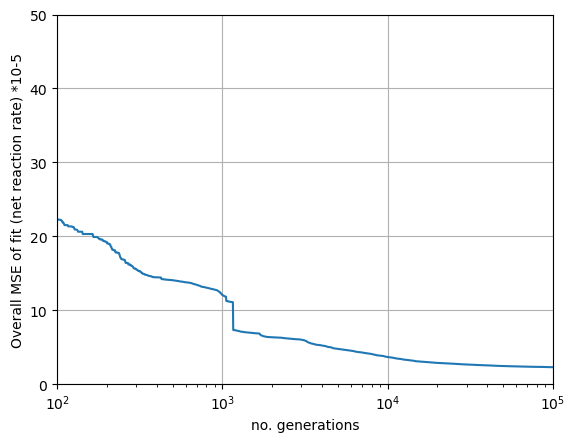

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.535264803093451
1.5237022542681078
0.8115052224954677
-4.225360053546861
0.48810774110817834
9.579679522257484e-06
0.40186750990631515
-5.138667145853394
0.37736969999778514
4.97091824211285
3.7634119111199085
3.886069423416831
0.6026104938876807
0.027004303143760403
2.9563884990054023
6.113667317276164e-05
0.29151442737922106
-11.482882344959666
1.8059928222621424
1.5244242205399454
-10.707253981780344
1.0868276604395986
3.541193749014651
0.019503735808462493
3.807202091773171
4.100757750288318
1.70965837401593
9.345364849250904
-8.16218199851702
2.613969780828078
2.5457510897777604
3.104947453406076
-4.194212103554738
0.5402818296711566
1.0487107842841636
-1.3010298172909547


In [37]:
res.X

array([-1.15352648e+01,  1.52370225e+00,  8.11505222e-01, -4.22536005e+00,
        4.88107741e-01,  9.57967952e-06,  4.01867510e-01, -5.13866715e+00,
        3.77369700e-01,  4.97091824e+00,  3.76341191e+00,  3.88606942e+00,
        6.02610494e-01,  2.70043031e-02,  2.95638850e+00,  6.11366732e-05,
        2.91514427e-01, -1.14828823e+01,  1.80599282e+00,  1.52442422e+00,
       -1.07072540e+01,  1.08682766e+00,  3.54119375e+00,  1.95037358e-02,
        3.80720209e+00,  4.10075775e+00,  1.70965837e+00,  9.34536485e+00,
       -8.16218200e+00,  2.61396978e+00,  2.54575109e+00,  3.10494745e+00,
       -4.19421210e+00,  5.40281830e-01,  1.04871078e+00, -1.30102982e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.535264803093451
1.6: 1.5237022542681078
0.9: 0.8115052224954677
-4.3: -4.225360053546861
0.5: 0.48810774110817834
0.003: 9.579679522257484e-06
0.4: 0.40186750990631515
-7.9: -5.138667145853394
0.7: 0.37736969999778514
7.2: 4.97091824211285
5.7: 3.7634119111199085
5.7: 3.886069423416831
0.8: 0.6026104938876807
0.03: 0.027004303143760403
3.1: 2.9563884990054023
6.000000000000001e-09: 6.113667317276164e-05
0.1: 0.29151442737922106
-12.0: -11.482882344959666
1.9: 1.8059928222621424
1.6: 1.5244242205399454
-11.6: -10.707253981780344
1.2: 1.0868276604395986
4.0: 3.541193749014651
0.01: 0.019503735808462493
4.2: 3.807202091773171
5.4: 4.100757750288318
2.2: 1.70965837401593
11.8: 9.345364849250904
-12.0: -8.16218199851702
3.3: 2.613969780828078
1.8: 2.5457510897777604
4.2: 3.104947453406076
-4.0: -4.194212103554738
0.5: 0.5402818296711566
1.0: 1.0487107842841636
coeff fit: 0.9553653804196773
r: 0.9774279412926957


In [1]:
# Use stored solution
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

# import numpy as np
# logkr=np.log10(kr)

# logkr=np.ndarray.tolist(logkr)
#del logkr[-1]
y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 = [-1.15352648e+01,  1.52370225e+00,  8.11505222e-01, -4.22536005e+00,
        4.88107741e-01,  9.57967952e-06,  4.01867510e-01, -5.13866715e+00,
        3.77369700e-01,  4.97091824e+00,  3.76341191e+00,  3.88606942e+00,
        6.02610494e-01,  2.70043031e-02,  2.95638850e+00,  6.11366732e-05,
        2.91514427e-01, -1.14828823e+01,  1.80599282e+00,  1.52442422e+00,
       -1.07072540e+01,  1.08682766e+00,  3.54119375e+00,  1.95037358e-02,
        3.80720209e+00,  4.10075775e+00,  1.70965837e+00,  9.34536485e+00,
       -8.16218200e+00,  2.61396978e+00,  2.54575109e+00,  3.10494745e+00,
       -4.19421210e+00,  5.40281830e-01,  1.04871078e+00, -1.30102982e+00]
#np.ndarray.tolist(res.X)
krseed10 = [-1.15733182e+01,  1.53445453e+00,  8.64514859e-01, -4.15094316e+00,
        4.78454823e-01,  6.81949685e-07,  4.05056381e-01, -3.93902430e+00,
        2.26124330e-01,  4.38691145e+00,  3.33008563e+00,  3.51111202e+00,
        5.94314040e-01,  3.28600192e-02,  3.00133416e+00,  1.11398788e-06,
        3.18921158e-01, -1.14060576e+01,  1.79428422e+00,  1.52362164e+00,
       -1.09647208e+01,  1.11700404e+00,  3.74208850e+00,  8.62503687e-03,
        3.98953792e+00,  4.02277188e+00,  1.65243106e+00,  9.09238680e+00,
       -1.08172057e+01,  2.99481333e+00,  1.78056677e+00,  3.79390720e+00,
       -4.09314326e+00,  5.14839337e-01,  1.00508243e+00, -1.30102999e+00]
krseed101 = [-1.19999992e+01,  1.59962732e+00,  9.06442637e-01, -4.19782695e+00,
        4.83220851e-01,  1.28842576e-06,  3.98144238e-01, -5.30600718e+00,
        3.99978412e-01,  5.09831812e+00,  3.86313378e+00,  3.98201133e+00,
        5.83083746e-01,  2.90216958e-02,  2.99265858e+00,  1.20622997e-07,
        3.60000661e-01, -1.15950397e+01,  1.82639009e+00,  1.54503824e+00,
       -1.11947451e+01,  1.14401723e+00,  3.72518941e+00,  5.05284629e-02,
        3.97028591e+00,  4.25726838e+00,  1.50196453e+00,  8.69305243e+00,
       -1.03286500e+01,  2.89358129e+00,  1.76310395e+00,  3.74385447e+00,
       -4.33470246e+00,  5.58170748e-01,  1.03170997e+00, -1.30102998e+00]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

coeff fit: 0.9619359110015947
r: 0.9807833150097909
-11.702860733333333
1.5525947
0.8608209059999999
-4.19137672
0.48326113833333334
3.850018321666666e-06
0.40168937633333335
-4.79456621
0.334490814
4.818715936666666
3.6522104399999997
3.7930642566666672
0.5933360933333333
0.0296286727
2.9834604133333333
2.0790428025666664e-05
0.32347874866666665
-11.494659866666666
1.8088890433333333
1.5310280333333335
-10.9555733
1.1159496433333336
3.669490553333333
0.02621907852333334
3.9223419733333333
4.1269326699999995
1.6213513199999998
9.043601359999998
-9.7693459
2.834121466666667
2.0298072699999996
3.547569706666667
-4.207352606666666
0.5377639716666666
1.0285010600000002


In [2]:
meankr

[-11.702860733333333,
 1.5525947,
 0.8608209059999999,
 -4.19137672,
 0.48326113833333334,
 3.850018321666666e-06,
 0.40168937633333335,
 -4.79456621,
 0.334490814,
 4.818715936666666,
 3.6522104399999997,
 3.7930642566666672,
 0.5933360933333333,
 0.0296286727,
 2.9834604133333333,
 2.0790428025666664e-05,
 0.32347874866666665,
 -11.494659866666666,
 1.8088890433333333,
 1.5310280333333335,
 -10.9555733,
 1.1159496433333336,
 3.669490553333333,
 0.02621907852333334,
 3.9223419733333333,
 4.1269326699999995,
 1.6213513199999998,
 9.043601359999998,
 -9.7693459,
 2.834121466666667,
 2.0298072699999996,
 3.547569706666667,
 -4.207352606666666,
 0.5377639716666666,
 1.0285010600000002]

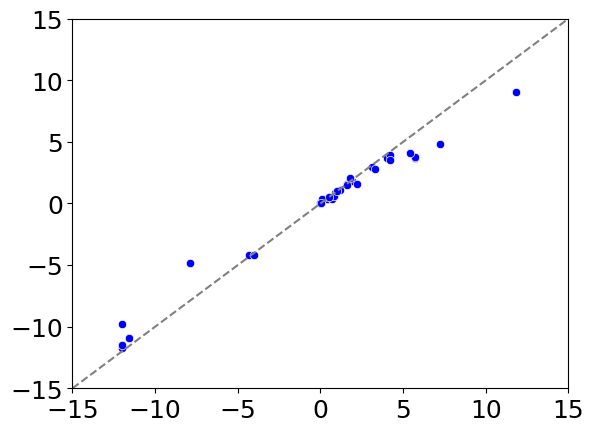

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()
